이번엔 처음에 MAE 18~~~ 나왔을때 변수인데 floor 변수를 라벨링안하고 해봄

# 데이터 확인 및 라이브러리 호출

## 라이브러리 

### 설치

### 호출 및 파일 불러오기

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


import xgboost as xgb

import re
import optuna
from optuna.integration import XGBoostPruningCallback
sns.set_theme(style="darkgrid")


pd.options.mode.chained_assignment = None
%matplotlib inline

In [3]:
import lightgbm as lgb

In [4]:
#Import train data set & test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

# 추가 데이터
interest_rate = pd.read_csv('interest_rate.csv') # 한국은행 금리
jeonse = pd.read_csv('아파트전세가격지수_시도_시_군_구__20230731180905.csv', encoding='cp949')


In [5]:
#train+test 
train['train_test'] = 'train'
test['train_test'] = 'test'
all_data = pd.concat([train, test])
all_data = all_data.reset_index(drop=True)
all_data.head()

id        sigungu jibun apt_name  exclusive_use_area  \
0  TRAIN_0000  서울특별시 강남구 대치동   503    개포우성1              158.54   
1  TRAIN_0001  서울특별시 강남구 대치동   503    개포우성1              127.61   
2  TRAIN_0002  서울특별시 강남구 대치동   503    개포우성1              127.61   
3  TRAIN_0003  서울특별시 강남구 대치동   503    개포우성1              127.61   
4  TRAIN_0004  서울특별시 강남구 대치동   503    개포우성1               84.81   

   transaction_year_month  transaction_day  transaction_real_price  floor  \
0                  201401                7                174000.0     13   
1                  201401                9                157500.0      6   
2                  201401               19                150000.0      5   
3                  201402               10                152000.0      9   
4                  201402               10                116000.0      3   

   year_of_completion train_test  
0                1983      train  
1                1983      train  
2                1983      train  
3                1983      train  
4                1983      train

## Train data 확인

In [6]:
train.head()

id        sigungu jibun apt_name  exclusive_use_area  \
0  TRAIN_0000  서울특별시 강남구 대치동   503    개포우성1              158.54   
1  TRAIN_0001  서울특별시 강남구 대치동   503    개포우성1              127.61   
2  TRAIN_0002  서울특별시 강남구 대치동   503    개포우성1              127.61   
3  TRAIN_0003  서울특별시 강남구 대치동   503    개포우성1              127.61   
4  TRAIN_0004  서울특별시 강남구 대치동   503    개포우성1               84.81   

   transaction_year_month  transaction_day  transaction_real_price  floor  \
0                  201401                7                  174000     13   
1                  201401                9                  157500      6   
2                  201401               19                  150000      5   
3                  201402               10                  152000      9   
4                  201402               10                  116000      3   

   year_of_completion train_test  
0                1983      train  
1                1983      train  
2                1983      train  
3                1983      train  
4                1983      train

In [7]:
train['sigungu'].value_counts()

서울특별시 강남구 대치동    5987
Name: sigungu, dtype: int64

In [8]:
train['apt_name'].value_counts()

은마          1476
대치삼성         392
래미안대치팰리스     389
대치아이파크       373
동부센트레빌       356
            ... 
미도맨션3차         3
화인하이빌          3
월드빌            2
노빌리티빌리지        2
해암프리존          1
Name: apt_name, Length: 69, dtype: int64

In [9]:
#Checking data types
print(train.info())
    #No missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5987 entries, 0 to 5986
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      5987 non-null   object 
 1   sigungu                 5987 non-null   object 
 2   jibun                   5987 non-null   object 
 3   apt_name                5987 non-null   object 
 4   exclusive_use_area      5987 non-null   float64
 5   transaction_year_month  5987 non-null   int64  
 6   transaction_day         5987 non-null   int64  
 7   transaction_real_price  5987 non-null   int64  
 8   floor                   5987 non-null   int64  
 9   year_of_completion      5987 non-null   int64  
 10  train_test              5987 non-null   object 
dtypes: float64(1), int64(5), object(5)
memory usage: 514.6+ KB
None


In [10]:
#Descriptive statistics of numerical data
train.describe()

exclusive_use_area  transaction_year_month  transaction_day  \
count         5987.000000             5987.000000      5987.000000   
mean            96.437380           201699.414398        15.902789   
std             31.991673              208.265846         8.750938   
min             20.370000           201401.000000         1.000000   
25%             76.790000           201509.000000         8.000000   
50%             84.810000           201704.000000        16.000000   
75%            119.580000           201903.000000        23.000000   
max            209.790000           202212.000000        31.000000   

       transaction_real_price        floor  year_of_completion  
count             5987.000000  5987.000000         5987.000000  
mean            158144.810423     9.236178         1992.938533  
std              78877.484068     5.959184           12.418632  
min              18000.000000     1.000000         1979.000000  
25%             100000.000000     5.000000         1983.000000  
50%             146000.000000     8.000000         1989.000000  
75%             202250.000000    13.000000         2004.000000  
max             535000.000000    35.000000         2017.000000

In [11]:
train['transaction_year_month'].value_counts().sort_values(ascending = True)

202209      4
202010      6
202201      6
202208      6
202207      6
         ... 
201711    141
202006    142
201604    145
201707    170
201705    183
Name: transaction_year_month, Length: 108, dtype: int64

In [12]:
train.shape

(5987, 11)

In [13]:
test.shape #transaction_real_price 가 제외

(196, 10)

## Test data & Submission data 확인

In [14]:
test.head(10
        )

id        sigungu jibun apt_name  exclusive_use_area  \
0  TEST_0000  서울특별시 강남구 대치동   977   (977-)               77.97   
1  TEST_0001  서울특별시 강남구 대치동   977   (977-)               59.99   
2  TEST_0002  서울특별시 강남구 대치동   503    개포우성1               84.81   
3  TEST_0003  서울특별시 강남구 대치동   503    개포우성1               84.81   
4  TEST_0004  서울특별시 강남구 대치동   503    개포우성1               84.81   
5  TEST_0005  서울특별시 강남구 대치동   503    개포우성1              158.54   
6  TEST_0006  서울특별시 강남구 대치동   503    개포우성1               84.81   
7  TEST_0007  서울특별시 강남구 대치동   503    개포우성1              127.61   
8  TEST_0008  서울특별시 강남구 대치동   503    개포우성1              158.54   
9  TEST_0009  서울특별시 강남구 대치동   500    개포우성2               84.69   

   transaction_year_month  transaction_day  floor  year_of_completion  \
0                  202304               10      2                2021   
1                  202304               10      2                2021   
2                  202301               13      3                1983   
3                  202301               19      9                1983   
4                  202302               15      5                1983   
5                  202303               17      2                1983   
6                  202304                7      5                1983   
7                  202305               24      9                1983   
8                  202306                2      3                1983   
9                  202302               11      8                1984   

  train_test  
0       test  
1       test  
2       test  
3       test  
4       test  
5       test  
6       test  
7       test  
8       test  
9       test

In [15]:
test.describe()

exclusive_use_area  transaction_year_month  transaction_day  \
count          196.000000              196.000000       196.000000   
mean            94.254751           202304.010204        15.750000   
std             30.808380                1.594831         8.427899   
min             28.340000           202301.000000         1.000000   
25%             76.790000           202303.000000         9.000000   
50%             84.480000           202304.000000        16.000000   
75%            116.587500           202305.000000        22.250000   
max            190.470000           202306.000000        31.000000   

            floor  year_of_completion  
count  196.000000          196.000000  
mean     8.785714         1989.423469  
std      6.287554           12.367420  
min      1.000000         1979.000000  
25%      4.000000         1979.000000  
50%      8.000000         1983.000000  
75%     12.000000         2000.000000  
max     28.000000         2021.000000

In [16]:
test['apt_name'].value_counts()

은마                          70
한보미도맨션2                     16
한보미도맨션1                     16
대치삼성                        12
대치아이파크                       9
래미안대치팰리스                     9
동부센트레빌                       7
개포우성1                        7
테헤란로대우아이빌(891-6)             6
개포우성2                        5
쌍용대치2                        5
대우아이빌멤버스(891-26)             4
쌍용대치아파트1동,2동,3동,5동,6동        4
대치현대                         4
선경2차(8동-12동)                 3
포스코더샵                        3
대치SKVIEW                     3
선경1차(1동-7동)                  2
대치우성아파트1동,2동,3동,5동,6동,7동     2
대우아이빌명문가(891-23)             2
(977-)                       2
풍림아이원2차202동                  1
래미안대치하이스턴                    1
선릉역대우아이빌(890-49)             1
대치효성                         1
현대1                          1
Name: apt_name, dtype: int64

In [17]:
test['sigungu'].value_counts()

서울특별시 강남구 대치동    196
Name: sigungu, dtype: int64

In [18]:
test['transaction_year_month'].value_counts()

202305    45
202306    44
202304    34
202302    30
202303    29
202301    14
Name: transaction_year_month, dtype: int64

test data 에서는 202301~202306의 데이터가 존재

In [19]:
#submission 데이터 확인
submission.head(10)

id  transaction_real_price
0  TEST_0000                       0
1  TEST_0001                       0
2  TEST_0002                       0
3  TEST_0003                       0
4  TEST_0004                       0
5  TEST_0005                       0
6  TEST_0006                       0
7  TEST_0007                       0
8  TEST_0008                       0
9  TEST_0009                       0

# 데이터 전처리

## K-means clustering을 통한 아파트 이름 데이터 전처리

In [20]:
pd.set_option('display.max_rows', None)
all_data['apt_name'].value_counts()[:69]

은마                          1546
대치삼성                         404
래미안대치팰리스                     398
대치아이파크                       382
동부센트레빌                       363
한보미도맨션2                      312
한보미도맨션1                      309
대치현대                         252
개포우성1                        224
선경1차(1동-7동)                  185
테헤란로대우아이빌(891-6)             144
개포우성2                        131
래미안대치하이스턴                    112
선경2차(8동-12동)                 112
포스코더샵                        104
쌍용대치아파트1동,2동,3동,5동,6동        102
대치우성아파트1동,2동,3동,5동,6동,7동      93
대우아이빌명문가(891-23)              82
선릉역대우아이빌(890-49)              63
롯데캐슬리베                        63
쌍용대치2                         57
대치동우정에쉐르1                     51
대우아이빌멤버스(891-26)              51
롯데캐슬                          50
대치효성                          47
현대1                           46
세영팔레스타운                       30
대치한신휴플러스                      30
대치SKVIEW                      29
국제                            27
선경3차      

In [21]:
#괄호안 내용은 분석에 불필요하다고 판단하고 제거
#괄호와 괄호안내용 제거
regex = "\(.*\)|\s-\s.*"
for i in tqdm(range(len(all_data))):
    all_data.at[i, 'apt_name'] = re.sub(regex, '', all_data.at[i, 'apt_name'])


100%|██████████████████████████████████████████████| 6183/6183 [00:00<00:00, 79162.21it/s]


In [22]:
all_data['apt_name'].value_counts().sort_values(ascending = False)

은마                          1546
대치삼성                         404
래미안대치팰리스                     398
대치아이파크                       382
동부센트레빌                       363
한보미도맨션2                      312
한보미도맨션1                      309
대치현대                         252
개포우성1                        224
선경1차                         185
테헤란로대우아이빌                    144
개포우성2                        131
선경2차                         112
래미안대치하이스턴                    112
포스코더샵                        104
쌍용대치아파트1동,2동,3동,5동,6동        102
대치우성아파트1동,2동,3동,5동,6동,7동      93
대우아이빌명문가                      82
선릉역대우아이빌                      63
롯데캐슬리베                        63
쌍용대치2                         57
대우아이빌멤버스                      51
대치동우정에쉐르1                     51
롯데캐슬                          50
대치효성                          47
현대1                           46
세영팔레스타운                       30
대치한신휴플러스                      30
대치SKVIEW                      29
국제                            27
선경3차      

In [23]:
from sklearn.cluster import KMeans
import numpy as np

# 아파트 별로 가격 평균값 구하기
train = all_data[all_data['train_test'] == 'train']
data = train[['apt_name', 'transaction_real_price']]

data = data.groupby('apt_name').mean()
arr = data['transaction_real_price'].to_numpy().reshape(-1, 1)

# 가격을 기준으로 아파트 군집화
k = 5  
kmeans = KMeans(n_clusters=k, n_init=10)
kmeans.fit(arr)

# 가격을 기준으로 군집의 순서를 정렬하기 위해 인덱스를 추출
sort_order = np.argsort(kmeans.cluster_centers_.flatten())

# 군집화 결과를 가격 순서대로 재할당
labels = np.zeros_like(kmeans.labels_)
for i, cluster in enumerate(sort_order):
    labels[kmeans.labels_ == cluster] = i

# 군집화 결과와 가격을 데이터에 추가
data['cluster'] = labels
data = data.reset_index()
data = data[['apt_name', 'cluster']]

all_data = pd.merge(all_data, data, how='left', left_on='apt_name', right_on='apt_name')

cluster_mode = all_data.loc[all_data['train_test'] == 'train', 'cluster'].mode()[0]
all_data['cluster'] = all_data['cluster'].fillna(cluster_mode)

all_data['cluster'].value_counts()

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7feeda392cb0>
Traceback (most recent call last):
  File "/home/t2user2/.conda/envs/pybook/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/t2user2/.conda/envs/pybook/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/t2user2/.conda/envs/pybook/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/t2user2/.conda/envs/pybook/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._fi

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7feeda392cb0>
Traceback (most recent call last):
  File "/home/t2user2/.conda/envs/pybook/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/t2user2/.conda/envs/pybook/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/t2user2/.conda/envs/pybook/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/t2user2/.conda/envs/pybook/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._fi

2.0    2938
3.0    2067
1.0     700
0.0     470
4.0       8
Name: cluster, dtype: int64

## 날짜 데이터 전처리

날짜 관련 컬럼은 year_of_completion, transaction_year_month, transaction_date가 있다. 이들은 범주형 데이터이기 때문에 분석을 위해 거래날짜 데이터를 제거 하고 거래연월 변수에 라벨인코딩을 적용할 것이다. 

In [24]:
train = all_data[all_data['train_test'] == 'train']
test = all_data[all_data['train_test'] == 'test']

In [25]:
print('train data 기술통계량')
print(train[['year_of_completion','transaction_year_month']].describe())
print('-'*90)
print('test data 기b술통계량')
print(test[['year_of_completion','transaction_year_month']].describe())


train data 기술통계량
       year_of_completion  transaction_year_month
count         5987.000000             5987.000000
mean          1992.938533           201699.414398
std             12.418632              208.265846
min           1979.000000           201401.000000
25%           1983.000000           201509.000000
50%           1989.000000           201704.000000
75%           2004.000000           201903.000000
max           2017.000000           202212.000000
------------------------------------------------------------------------------------------
test data 기b술통계량
       year_of_completion  transaction_year_month
count          196.000000              196.000000
mean          1989.423469           202304.010204
std             12.367420                1.594831
min           1979.000000           202301.000000
25%           1979.000000           202303.000000
50%           1983.000000           202304.000000
75%           2000.000000           202305.000000
max           2021.000000

[train data]
- year_of_completion

최대값은 2017년이며 최솟값은 1979년이다. 

- transaction_year_month

최대값은 2022년 12월이며 최솟값은 2014년 1월이다. 

-------------
[test data]
- year_of_completion

최대값은 2021년이며 최솟값은 1979년이다. 

- transaction_year_month

최대값은 2023년 6월이며 최솟값은 2023년 1월이다. 


최대년도에서 최소년도를 뺌으로써 정수형 라벨인코딩을 완성한다. test data의 경우 완공년도는 train data와 동일하기 때문에 인코딩에서 문제가 발생하진 않지만 거래연월에서 문제가 발생한다. 

In [26]:
from sklearn.preprocessing import LabelEncoder

# train set과 test set을 합쳐서 "year_of_completion" set의 최대값과 최소값 구하기
combined_yc = pd.concat([train['year_of_completion'], test['year_of_completion']])
combined_yc_max = combined_yc.max()
combined_yc_min = combined_yc.min()

# train set과 test set을 합쳐서 "transaction_year_month" set의 최대값과 최소값 구하기
combined_tym = pd.concat([train['transaction_year_month'], test['transaction_year_month']])
combined_tym_max = combined_tym.max()
combined_tym_min = combined_tym.min()

# train set에서 "year_of_completion" set에서 최소값 빼기
print('변환전\n', train['year_of_completion'].unique()[:5])
train['year_of_completion'] = train['year_of_completion'] - combined_yc_min
test['year_of_completion'] = test['year_of_completion'] - combined_yc_min
print('변환후\n', train['year_of_completion'].unique()[:5])

# train set과 test set에서 "transaction_year_month" 라벨 인코딩
print('train 변환전\n', train['transaction_year_month'].unique()[:5])
print('test 변환전\n', test['transaction_year_month'].unique()[:5])

le = LabelEncoder()
le.fit(combined_tym)
train['transaction_year_month'] = le.transform(train['transaction_year_month'])
test['transaction_year_month'] = le.transform(test['transaction_year_month'])

print('train 변환후\n', train['transaction_year_month'].unique()[:5])
print('test 변환후\n', test['transaction_year_month'].unique()[:5])



변환전
 [1983 1984 2003 2004 2000]
변환후
 [ 4  5 24 25 21]
train 변환전
 [201401 201402 201403 201405 201406]
test 변환전
 [202304 202301 202302 202303 202305]
train 변환후
 [0 1 2 4 5]
test 변환후
 [111 108 109 110 112]


In [27]:
test.head()

id        sigungu jibun apt_name  exclusive_use_area  \
5987  TEST_0000  서울특별시 강남구 대치동   977                        77.97   
5988  TEST_0001  서울특별시 강남구 대치동   977                        59.99   
5989  TEST_0002  서울특별시 강남구 대치동   503    개포우성1               84.81   
5990  TEST_0003  서울특별시 강남구 대치동   503    개포우성1               84.81   
5991  TEST_0004  서울특별시 강남구 대치동   503    개포우성1               84.81   

      transaction_year_month  transaction_day  transaction_real_price  floor  \
5987                     111               10                     NaN      2   
5988                     111               10                     NaN      2   
5989                     108               13                     NaN      3   
5990                     108               19                     NaN      9   
5991                     109               15                     NaN      5   

      year_of_completion train_test  cluster  
5987                  42       test      2.0  
5988                  42       test      2.0  
5989                   4       test      3.0  
5990                   4       test      3.0  
5991                   4       test      3.0

In [28]:
#인덱스가 섞여 있어 정리
test.reset_index(drop=True)

id        sigungu   jibun                  apt_name  \
0    TEST_0000  서울특별시 강남구 대치동     977                             
1    TEST_0001  서울특별시 강남구 대치동     977                             
2    TEST_0002  서울특별시 강남구 대치동     503                     개포우성1   
3    TEST_0003  서울특별시 강남구 대치동     503                     개포우성1   
4    TEST_0004  서울특별시 강남구 대치동     503                     개포우성1   
5    TEST_0005  서울특별시 강남구 대치동     503                     개포우성1   
6    TEST_0006  서울특별시 강남구 대치동     503                     개포우성1   
7    TEST_0007  서울특별시 강남구 대치동     503                     개포우성1   
8    TEST_0008  서울특별시 강남구 대치동     503                     개포우성1   
9    TEST_0009  서울특별시 강남구 대치동     500                     개포우성2   
10   TEST_0010  서울특별시 강남구 대치동     500                     개포우성2   
11   TEST_0011  서울특별시 강남구 대치동     500                     개포우성2   
12   TEST_0012  서울특별시 강남구 대치동     500                     개포우성2   
13   TEST_0013  서울특별시 강남구 대치동     500                     개포우성2   
14   TEST_0014  서울특별시 강남구 대치동  891-26                  대우아이빌멤버스   
15   TEST_0015  서울특별시 강남구 대치동  891-26                  대우아이빌멤버스   
16   TEST_0016  서울특별시 강남구 대치동  891-26                  대우아이빌멤버스   
17   TEST_0017  서울특별시 강남구 대치동  891-26                  대우아이빌멤버스   
18   TEST_0018  서울특별시 강남구 대치동  891-23                  대우아이빌명문가   
19   TEST_0019  서울특별시 강남구 대치동  891-23                  대우아이빌명문가   
20   TEST_0020  서울특별시 강남구 대치동    1029                  대치SKVIEW   
21   TEST_0021  서울특별시 강남구 대치동    1029                  대치SKVIEW   
22   TEST_0022  서울특별시 강남구 대치동    1029                  대치SKVIEW   
23   TEST_0023  서울특별시 강남구 대치동  1014-3                      대치삼성   
24   TEST_0024  서울특별시 강남구 대치동  1014-3                      대치삼성   
25   TEST_0025  서울특별시 강남구 대치동  1014-3                      대치삼성   
26   TEST_0026  서울특별시 강남구 대치동  1014-3                      대치삼성   
27   TEST_0027  서울특별시 강남구 대치동  1014-3                      대치삼성   
28   TEST_0028  서울특별시 강남구 대치동  1014-3                      대치삼성   
29   TEST_0029  서울특별시 강남구 대치동  1014-3                      대치삼성   
30   TEST_0030  서울특별시 강남구 대치동  1014-3                      대치삼성   
31   TEST_0031  서울특별시 강남구 대치동  1014-3                      대치삼성   
32   TEST_0032  서울특별시 강남구 대치동  1014-3                      대치삼성   
33   TEST_0033  서울특별시 강남구 대치동  1014-3                      대치삼성   
34   TEST_0034  서울특별시 강남구 대치동  1014-3                      대치삼성   
35   TEST_0035  서울특별시 강남구 대치동     888                    대치아이파크   
36   TEST_0036  서울특별시 강남구 대치동     888                    대치아이파크   
37   TEST_0037  서울특별시 강남구 대치동     888                    대치아이파크   
38   TEST_0038  서울특별시 강남구 대치동     888                    대치아이파크   
39   TEST_0039  서울특별시 강남구 대치동     888                    대치아이파크   
40   TEST_0040  서울특별시 강남구 대치동     888                    대치아이파크   
41   TEST_0041  서울특별시 강남구 대치동     888                    대치아이파크   
42   TEST_0042  서울특별시 강남구 대치동     888                    대치아이파크   
43   TEST_0043  서울특별시 강남구 대치동     888                    대치아이파크   
44   TEST_0044  서울특별시 강남구 대치동      63  대치우성아파트1동,2동,3동,5동,6동,7동   
45   TEST_0045  서울특별시 강남구 대치동      63  대치우성아파트1동,2동,3동,5동,6동,7동   
46   TEST_0046  서울특별시 강남구 대치동     974                      대치현대   
47   TEST_0047  서울특별시 강남구 대치동     974                      대치현대   
48   TEST_0048  서울특별시 강남구 대치동     974                      대치현대   
49   TEST_0049  서울특별시 강남구 대치동     974                      대치현대   
50   TEST_0050  서울특별시 강남구 대치동   988-4                      대치효성   
51   TEST_0051  서울특별시 강남구 대치동     670                    동부센트레빌   
52   TEST_0052  서울특별시 강남구 대치동     670                    동부센트레빌   
53   TEST_0053  서울특별시 강남구 대치동     670                    동부센트레빌   
54   TEST_0054  서울특별시 강남구 대치동     670                    동부센트레빌   
55   TEST_0055  서울특별시 강남구 대치동     670                    동부센트레빌   
56   TEST_0056  서울특별시 강남구 대치동     670                    동부센트레빌   
57   TEST_0057  서울특별시 강남구 대치동     670                    동부센트레빌   
58   TEST_0058  서울특별시 강남구 대치동    1027                  래미안대

In [29]:
print('train')
print(train[['transaction_year_month', 'year_of_completion']].describe())
print('-'*90)
print('test')
print(test[['transaction_year_month', 'year_of_completion']].describe())

train
       transaction_year_month  year_of_completion
count             5987.000000         5987.000000
mean                40.661266           13.938533
std                 25.281697           12.418632
min                  0.000000            0.000000
25%                 20.000000            4.000000
50%                 39.000000           10.000000
75%                 62.000000           25.000000
max                107.000000           38.000000
------------------------------------------------------------------------------------------
test
       transaction_year_month  year_of_completion
count              196.000000          196.000000
mean               111.010204           10.423469
std                  1.594831           12.367420
min                108.000000            0.000000
25%                110.000000            0.000000
50%                111.000000            4.000000
75%                112.000000           21.000000
max                113.000000           42.00000

## 거래가격 확인 및 로그변환

<Axes: ylabel='transaction_real_price'>

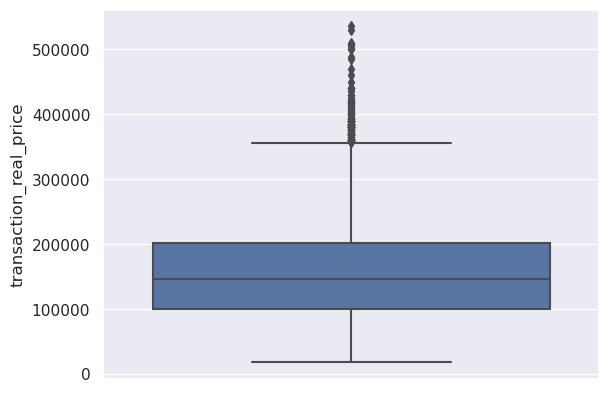

In [30]:
sns.boxplot(y='transaction_real_price', data = train)

In [31]:
train['log_price'] = np.log1p(train['transaction_real_price'])


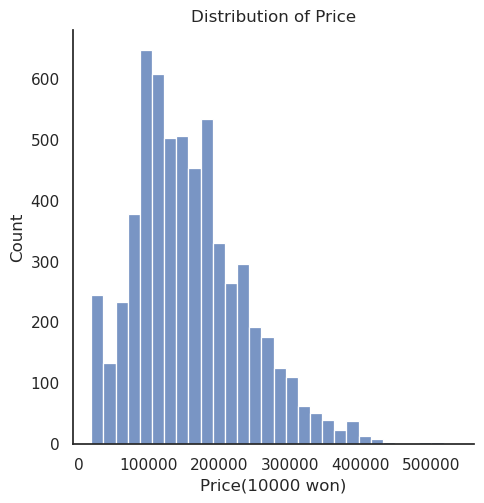

In [32]:
sns.set(style = 'white')
sns.displot(train['transaction_real_price'], bins=30)
plt.xlabel('Price(10000 won)')
plt.title('Distribution of Price')
plt.show()


## 면적(m^2) 확인 및 로그변환

<Figure size 640x480 with 0 Axes>

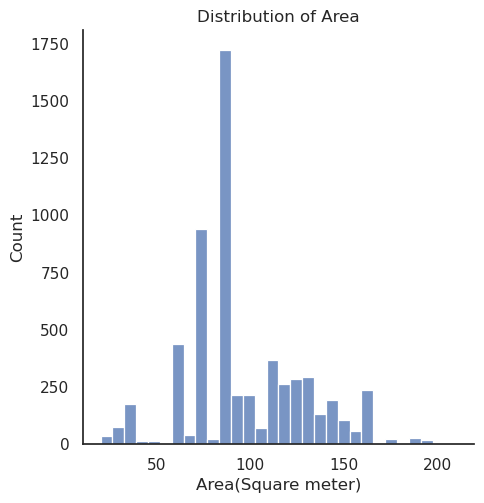

In [33]:
plt.figure()
sns.displot(train['exclusive_use_area'], bins=30)
plt.xlabel('Area(Square meter)')
plt.title('Distribution of Area')
plt.show()

이상치 때문에  로그변환을 수행해야 한다.

In [34]:
train['log_area'] = np.log1p(train['exclusive_use_area'])
test['log_area'] = np.log1p(test['exclusive_use_area'])

area = train['exclusive_use_area'] # 원래 면적

train.drop('exclusive_use_area', axis=1, inplace=True)
test.drop('exclusive_use_area', axis=1, inplace=True)
train.head(1)

id        sigungu jibun apt_name  transaction_year_month  \
0  TRAIN_0000  서울특별시 강남구 대치동   503    개포우성1                       0   

   transaction_day  transaction_real_price  floor  year_of_completion  \
0                7                174000.0     13                   4   

  train_test  cluster  log_price  log_area  
0      train      3.0  12.066816  5.072295

<Figure size 640x480 with 0 Axes>

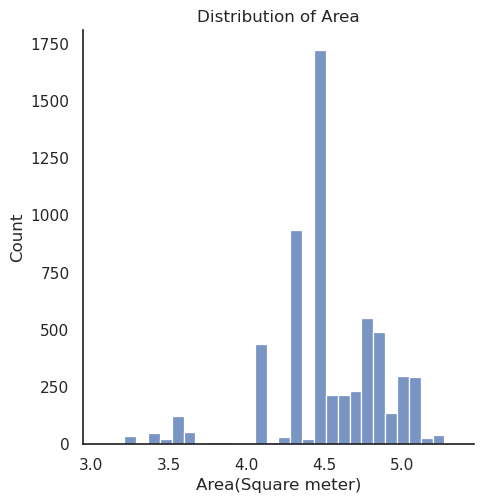

In [35]:
plt.figure()
sns.displot(train['log_area'], bins=30)
plt.xlabel('Area(Square meter)')
plt.title('Distribution of Area')
plt.show()

로그변환은 큰 소용이 없었다. 

# 직접 모델 비교

모델 목록
- Linear Regression
- Ridge Regression
- Lasso Regression
- Elasticnet Regression
- Decision Tree
- RandomForest Regressor
- XGBoost Regressor
- LightGBM Regressor


In [36]:

train.drop(['train_test','transaction_day'], axis = 1, inplace = True )
test.drop(['train_test','transaction_day'], axis = 1, inplace = True )

In [37]:
test.head()

id        sigungu jibun apt_name  transaction_year_month  \
5987  TEST_0000  서울특별시 강남구 대치동   977                              111   
5988  TEST_0001  서울특별시 강남구 대치동   977                              111   
5989  TEST_0002  서울특별시 강남구 대치동   503    개포우성1                     108   
5990  TEST_0003  서울특별시 강남구 대치동   503    개포우성1                     108   
5991  TEST_0004  서울특별시 강남구 대치동   503    개포우성1                     109   

      transaction_real_price  floor  year_of_completion  cluster  log_area  
5987                     NaN      2                  42      2.0  4.369068  
5988                     NaN      2                  42      2.0  4.110710  
5989                     NaN      3                   4      3.0  4.452136  
5990                     NaN      9                   4      3.0  4.452136  
5991                     NaN      5                   4      3.0  4.452136

In [38]:
train.columns

Index(['id', 'sigungu', 'jibun', 'apt_name', 'transaction_year_month',
       'transaction_real_price', 'floor', 'year_of_completion', 'cluster',
       'log_price', 'log_area'],
      dtype='object')

In [39]:
#모델링에 사용할 변수만 선택
train_df = train[['cluster', 'log_area','year_of_completion','floor',
                  'log_price',  'transaction_year_month']]
test_df = test[['cluster', 'log_area','year_of_completion','floor',
                    'transaction_year_month']] 

In [40]:
train_X, train_y = train_df.drop('log_price', axis=1), train_df['log_price']
print(train_X.shape, train_y.shape)

(5987, 5) (5987,)


In [41]:
from sklearn.metrics import mean_absolute_error

def MAE(y, y_pred):
    mae = mean_absolute_error(y, y_pred)
    return mae


def mae_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=10)
    mae_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mae = MAE(y_test, pred) 
        mae_list.append(mae)
    return model_name, mae_list

def print_mae_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = mae_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} MAE: {r:.4f}')
    print(f'\n{model_name} mean MAE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

In [42]:
#lgb num_leaves 정의
import math
num_leaves = int(round(math.sqrt(len(train_X))))
num_leaves

77

In [43]:
from catboost import CatBoostRegressor

In [44]:
reg = LinearRegression(n_jobs=-1)
ridge = Ridge(alpha=0.8, random_state=1)
lasso = Lasso(alpha = 0.01, random_state=1)
Enet = ElasticNet(alpha=0.03, l1_ratio=0.01, random_state=1)
DTree = DecisionTreeRegressor(max_depth=6, min_samples_split=10, min_samples_leaf=15, random_state=1)
rf = RandomForestRegressor(n_estimators=1, criterion='mae', max_depth=9, min_samples_split=50, 
                           min_samples_leaf=5, random_state=1, n_jobs=-1)
model_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=9, 
                             min_child_weight=5, gamma=0.1, n_jobs=-1)
model_lgb = lgb.LGBMRegressor(n_estimators=500, max_depth=9,num_leaves=77, min_child_weight=5, n_jobs=-1)
model_catb = CatBoostRegressor(iterations=500, depth=9)

### 모델링

In [45]:
from sklearn.model_selection import TimeSeriesSplit

models = []
scores = []
for model in [reg, ridge, lasso, Enet, DTree, model_xgb, model_lgb,model_catb]:
    model_name, mean_score = print_mae_score(model)
    models.append(model_name)
    scores.append(mean_score)

LinearRegression Cross Validations...: 100%|█████████████| 10/10 [00:00<00:00, 485.40it/s]


1 FOLDS: LinearRegression MAE: 0.0857
2 FOLDS: LinearRegression MAE: 0.0756
3 FOLDS: LinearRegression MAE: 0.0860
4 FOLDS: LinearRegression MAE: 0.1009
5 FOLDS: LinearRegression MAE: 0.1034
6 FOLDS: LinearRegression MAE: 0.1026
7 FOLDS: LinearRegression MAE: 0.1757
8 FOLDS: LinearRegression MAE: 0.1409
9 FOLDS: LinearRegression MAE: 0.1438
10 FOLDS: LinearRegression MAE: 0.1967

LinearRegression mean MAE: 0.1211


Ridge Cross Validations...: 100%|████████████████████████| 10/10 [00:00<00:00, 860.79it/s]


1 FOLDS: Ridge MAE: 0.0857
2 FOLDS: Ridge MAE: 0.0752
3 FOLDS: Ridge MAE: 0.0860
4 FOLDS: Ridge MAE: 0.1008
5 FOLDS: Ridge MAE: 0.1033
6 FOLDS: Ridge MAE: 0.1025
7 FOLDS: Ridge MAE: 0.1757
8 FOLDS: Ridge MAE: 0.1408
9 FOLDS: Ridge MAE: 0.1437
10 FOLDS: Ridge MAE: 0.1968

Ridge mean MAE: 0.1210


Lasso Cross Validations...: 100%|████████████████████████| 10/10 [00:00<00:00, 736.99it/s]


1 FOLDS: Lasso MAE: 0.0880
2 FOLDS: Lasso MAE: 0.0708
3 FOLDS: Lasso MAE: 0.0835
4 FOLDS: Lasso MAE: 0.0969
5 FOLDS: Lasso MAE: 0.1029
6 FOLDS: Lasso MAE: 0.0934
7 FOLDS: Lasso MAE: 0.1746
8 FOLDS: Lasso MAE: 0.1357
9 FOLDS: Lasso MAE: 0.1399
10 FOLDS: Lasso MAE: 0.2028

Lasso mean MAE: 0.1189


ElasticNet Cross Validations...: 100%|███████████████████| 10/10 [00:00<00:00, 729.00it/s]


1 FOLDS: ElasticNet MAE: 0.0948
2 FOLDS: ElasticNet MAE: 0.0699
3 FOLDS: ElasticNet MAE: 0.0917
4 FOLDS: ElasticNet MAE: 0.0976
5 FOLDS: ElasticNet MAE: 0.1016
6 FOLDS: ElasticNet MAE: 0.0903
7 FOLDS: ElasticNet MAE: 0.1733
8 FOLDS: ElasticNet MAE: 0.1336
9 FOLDS: ElasticNet MAE: 0.1392
10 FOLDS: ElasticNet MAE: 0.2078

ElasticNet mean MAE: 0.1200


DecisionTreeRegressor Cross Validations...: 100%|████████| 10/10 [00:00<00:00, 442.36it/s]


1 FOLDS: DecisionTreeRegressor MAE: 0.1102
2 FOLDS: DecisionTreeRegressor MAE: 0.0980
3 FOLDS: DecisionTreeRegressor MAE: 0.1469
4 FOLDS: DecisionTreeRegressor MAE: 0.1332
5 FOLDS: DecisionTreeRegressor MAE: 0.1647
6 FOLDS: DecisionTreeRegressor MAE: 0.1551
7 FOLDS: DecisionTreeRegressor MAE: 0.2258
8 FOLDS: DecisionTreeRegressor MAE: 0.1774
9 FOLDS: DecisionTreeRegressor MAE: 0.1206
10 FOLDS: DecisionTreeRegressor MAE: 0.1721

DecisionTreeRegressor mean MAE: 0.1504


XGBRegressor Cross Validations...: 100%|██████████████████| 10/10 [00:06<00:00,  1.49it/s]


1 FOLDS: XGBRegressor MAE: 0.1116
2 FOLDS: XGBRegressor MAE: 0.0723
3 FOLDS: XGBRegressor MAE: 0.0925
4 FOLDS: XGBRegressor MAE: 0.0602
5 FOLDS: XGBRegressor MAE: 0.1201
6 FOLDS: XGBRegressor MAE: 0.0576
7 FOLDS: XGBRegressor MAE: 0.1205
8 FOLDS: XGBRegressor MAE: 0.1172
9 FOLDS: XGBRegressor MAE: 0.0695
10 FOLDS: XGBRegressor MAE: 0.1075

XGBRegressor mean MAE: 0.0929


LGBMRegressor Cross Validations...:  10%|█▊                | 1/10 [00:00<00:01,  5.96it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 547, number of used features: 5
[LightGBM] [Info] Start training from score 11.489574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...:  20%|███▌              | 2/10 [00:00<00:01,  6.01it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...:  30%|█████▍            | 3/10 [00:00<00:01,  5.40it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...:  40%|███████▏          | 4/10 [00:00<00:01,  5.04it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...:  50%|█████████         | 5/10 [00:01<00:01,  4.64it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 3267, number of used features: 5
[LightGBM] [Info] Start training from score 11.634677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

LGBMRegressor Cross Validations...:  60%|██████████▊       | 6/10 [00:01<00:00,  4.12it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...:  70%|████████████▌     | 7/10 [00:01<00:00,  4.17it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...:  80%|██████████████▍   | 8/10 [00:01<00:00,  4.07it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...:  90%|████████████████▏ | 9/10 [00:02<00:00,  3.77it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 300
[LightGBM] [Info] Number of data points in the train set: 5443, number of used features: 5
[LightGBM] [Info] Start training from score 11.800627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

LGBMRegressor Cross Validations...: 100%|█████████████████| 10/10 [00:02<00:00,  4.04it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

CatBoostRegressor Cross Validations...:   0%|                      | 0/10 [00:00<?, ?it/s]

Learning rate set to 0.065391
0:	learn: 0.5195879	total: 50.8ms	remaining: 25.4s
1:	learn: 0.4939982	total: 53.1ms	remaining: 13.2s
2:	learn: 0.4669883	total: 56.9ms	remaining: 9.43s
3:	learn: 0.4464235	total: 59.4ms	remaining: 7.37s
4:	learn: 0.4244959	total: 61.4ms	remaining: 6.08s
5:	learn: 0.4049359	total: 63.5ms	remaining: 5.22s
6:	learn: 0.3837219	total: 64.2ms	remaining: 4.52s
7:	learn: 0.3636084	total: 66.2ms	remaining: 4.07s
8:	learn: 0.3474312	total: 66.7ms	remaining: 3.64s
9:	learn: 0.3306496	total: 68.8ms	remaining: 3.37s
10:	learn: 0.3148993	total: 71.5ms	remaining: 3.18s
11:	learn: 0.2999322	total: 73.8ms	remaining: 3s
12:	learn: 0.2870232	total: 76.1ms	remaining: 2.85s
13:	learn: 0.2730517	total: 78.5ms	remaining: 2.72s
14:	learn: 0.2606767	total: 80.2ms	remaining: 2.59s
15:	learn: 0.2483608	total: 82.3ms	remaining: 2.49s
16:	learn: 0.2370828	total: 84.6ms	remaining: 2.4s
17:	learn: 0.2261741	total: 86.7ms	remaining: 2.32s
18:	learn: 0.2170733	total: 88.9ms	remaining: 2.

224:	learn: 0.0316751	total: 195ms	remaining: 238ms
225:	learn: 0.0315799	total: 195ms	remaining: 237ms
226:	learn: 0.0314730	total: 196ms	remaining: 236ms
227:	learn: 0.0313733	total: 196ms	remaining: 234ms
228:	learn: 0.0312963	total: 197ms	remaining: 233ms
229:	learn: 0.0311981	total: 197ms	remaining: 231ms
230:	learn: 0.0310501	total: 197ms	remaining: 230ms
231:	learn: 0.0309711	total: 198ms	remaining: 228ms
232:	learn: 0.0308759	total: 198ms	remaining: 227ms
233:	learn: 0.0307881	total: 198ms	remaining: 226ms
234:	learn: 0.0306594	total: 199ms	remaining: 224ms
235:	learn: 0.0305929	total: 199ms	remaining: 223ms
236:	learn: 0.0304807	total: 200ms	remaining: 222ms
237:	learn: 0.0303085	total: 200ms	remaining: 220ms
238:	learn: 0.0302365	total: 200ms	remaining: 219ms
239:	learn: 0.0301431	total: 201ms	remaining: 218ms
240:	learn: 0.0299889	total: 201ms	remaining: 216ms
241:	learn: 0.0299000	total: 202ms	remaining: 215ms
242:	learn: 0.0298466	total: 202ms	remaining: 214ms
243:	learn: 

CatBoostRegressor Cross Validations...:  10%|█▍            | 1/10 [00:00<00:03,  2.53it/s]

403:	learn: 0.0199613	total: 263ms	remaining: 62.6ms
404:	learn: 0.0199333	total: 264ms	remaining: 61.9ms
405:	learn: 0.0198966	total: 264ms	remaining: 61.2ms
406:	learn: 0.0198545	total: 265ms	remaining: 60.5ms
407:	learn: 0.0198475	total: 265ms	remaining: 59.8ms
408:	learn: 0.0197826	total: 265ms	remaining: 59.1ms
409:	learn: 0.0197483	total: 266ms	remaining: 58.4ms
410:	learn: 0.0197207	total: 266ms	remaining: 57.7ms
411:	learn: 0.0196416	total: 267ms	remaining: 57ms
412:	learn: 0.0196028	total: 267ms	remaining: 56.3ms
413:	learn: 0.0195844	total: 268ms	remaining: 55.6ms
414:	learn: 0.0195408	total: 268ms	remaining: 54.9ms
415:	learn: 0.0195067	total: 268ms	remaining: 54.2ms
416:	learn: 0.0194619	total: 269ms	remaining: 53.5ms
417:	learn: 0.0194480	total: 269ms	remaining: 52.8ms
418:	learn: 0.0194110	total: 269ms	remaining: 52.1ms
419:	learn: 0.0193984	total: 270ms	remaining: 51.4ms
420:	learn: 0.0193633	total: 270ms	remaining: 50.7ms
421:	learn: 0.0193138	total: 271ms	remaining: 50

89:	learn: 0.0544163	total: 90ms	remaining: 410ms
90:	learn: 0.0540904	total: 90.6ms	remaining: 407ms
91:	learn: 0.0538860	total: 91.1ms	remaining: 404ms
92:	learn: 0.0536998	total: 91.7ms	remaining: 401ms
93:	learn: 0.0533916	total: 92.2ms	remaining: 398ms
94:	learn: 0.0532551	total: 92.5ms	remaining: 394ms
95:	learn: 0.0532276	total: 92.6ms	remaining: 389ms
96:	learn: 0.0528606	total: 93.1ms	remaining: 387ms
97:	learn: 0.0526702	total: 93.7ms	remaining: 384ms
98:	learn: 0.0526305	total: 93.8ms	remaining: 380ms
99:	learn: 0.0523810	total: 94.4ms	remaining: 378ms
100:	learn: 0.0521507	total: 95ms	remaining: 375ms
101:	learn: 0.0517442	total: 95.6ms	remaining: 373ms
102:	learn: 0.0517025	total: 95.7ms	remaining: 369ms
103:	learn: 0.0515304	total: 96.2ms	remaining: 366ms
104:	learn: 0.0511759	total: 96.7ms	remaining: 364ms
105:	learn: 0.0509300	total: 97.1ms	remaining: 361ms
106:	learn: 0.0507492	total: 97.7ms	remaining: 359ms
107:	learn: 0.0505496	total: 98.2ms	remaining: 357ms
108:	lea

345:	learn: 0.0275049	total: 218ms	remaining: 97.1ms
346:	learn: 0.0274660	total: 219ms	remaining: 96.5ms
347:	learn: 0.0274064	total: 219ms	remaining: 95.8ms
348:	learn: 0.0273866	total: 220ms	remaining: 95.1ms
349:	learn: 0.0273033	total: 220ms	remaining: 94.4ms
350:	learn: 0.0272771	total: 221ms	remaining: 93.7ms
351:	learn: 0.0272385	total: 221ms	remaining: 93.1ms
352:	learn: 0.0272085	total: 222ms	remaining: 92.4ms
353:	learn: 0.0271961	total: 222ms	remaining: 91.6ms
354:	learn: 0.0271706	total: 222ms	remaining: 90.8ms
355:	learn: 0.0271081	total: 223ms	remaining: 90.2ms
356:	learn: 0.0270790	total: 223ms	remaining: 89.5ms
357:	learn: 0.0270409	total: 224ms	remaining: 88.8ms
358:	learn: 0.0269861	total: 224ms	remaining: 88.1ms
359:	learn: 0.0269572	total: 225ms	remaining: 87.5ms
360:	learn: 0.0269144	total: 225ms	remaining: 86.8ms
361:	learn: 0.0268835	total: 226ms	remaining: 86.1ms
362:	learn: 0.0268316	total: 226ms	remaining: 85.4ms
363:	learn: 0.0268109	total: 227ms	remaining: 

CatBoostRegressor Cross Validations...:  20%|██▊           | 2/10 [00:00<00:02,  2.67it/s]

479:	learn: 0.0224508	total: 286ms	remaining: 11.9ms
480:	learn: 0.0224124	total: 286ms	remaining: 11.3ms
481:	learn: 0.0223971	total: 287ms	remaining: 10.7ms
482:	learn: 0.0223857	total: 287ms	remaining: 10.1ms
483:	learn: 0.0223638	total: 288ms	remaining: 9.52ms
484:	learn: 0.0223342	total: 289ms	remaining: 8.92ms
485:	learn: 0.0223166	total: 289ms	remaining: 8.33ms
486:	learn: 0.0222802	total: 290ms	remaining: 7.73ms
487:	learn: 0.0222115	total: 290ms	remaining: 7.13ms
488:	learn: 0.0221656	total: 291ms	remaining: 6.54ms
489:	learn: 0.0221517	total: 291ms	remaining: 5.94ms
490:	learn: 0.0221218	total: 292ms	remaining: 5.35ms
491:	learn: 0.0220817	total: 292ms	remaining: 4.75ms
492:	learn: 0.0220626	total: 293ms	remaining: 4.16ms
493:	learn: 0.0220532	total: 293ms	remaining: 3.56ms
494:	learn: 0.0220419	total: 294ms	remaining: 2.97ms
495:	learn: 0.0220261	total: 294ms	remaining: 2.37ms
496:	learn: 0.0219759	total: 295ms	remaining: 1.78ms
497:	learn: 0.0219480	total: 295ms	remaining: 

225:	learn: 0.0339085	total: 132ms	remaining: 160ms
226:	learn: 0.0338398	total: 133ms	remaining: 160ms
227:	learn: 0.0337742	total: 133ms	remaining: 159ms
228:	learn: 0.0337139	total: 134ms	remaining: 158ms
229:	learn: 0.0336217	total: 134ms	remaining: 158ms
230:	learn: 0.0336134	total: 135ms	remaining: 157ms
231:	learn: 0.0335360	total: 136ms	remaining: 157ms
232:	learn: 0.0334382	total: 136ms	remaining: 156ms
233:	learn: 0.0333094	total: 137ms	remaining: 155ms
234:	learn: 0.0332279	total: 137ms	remaining: 155ms
235:	learn: 0.0332209	total: 138ms	remaining: 154ms
236:	learn: 0.0331835	total: 138ms	remaining: 153ms
237:	learn: 0.0331643	total: 138ms	remaining: 152ms
238:	learn: 0.0331009	total: 139ms	remaining: 152ms
239:	learn: 0.0330378	total: 139ms	remaining: 151ms
240:	learn: 0.0329999	total: 140ms	remaining: 150ms
241:	learn: 0.0329597	total: 140ms	remaining: 150ms
242:	learn: 0.0328881	total: 141ms	remaining: 149ms
243:	learn: 0.0328312	total: 142ms	remaining: 149ms
244:	learn: 

457:	learn: 0.0227518	total: 261ms	remaining: 23.9ms
458:	learn: 0.0227325	total: 261ms	remaining: 23.3ms
459:	learn: 0.0227092	total: 262ms	remaining: 22.8ms
460:	learn: 0.0226393	total: 262ms	remaining: 22.2ms
461:	learn: 0.0226089	total: 263ms	remaining: 21.6ms
462:	learn: 0.0225863	total: 264ms	remaining: 21.1ms
463:	learn: 0.0225655	total: 264ms	remaining: 20.5ms
464:	learn: 0.0225564	total: 265ms	remaining: 19.9ms
465:	learn: 0.0225071	total: 265ms	remaining: 19.4ms
466:	learn: 0.0224739	total: 266ms	remaining: 18.8ms
467:	learn: 0.0224615	total: 266ms	remaining: 18.2ms
468:	learn: 0.0224212	total: 267ms	remaining: 17.6ms
469:	learn: 0.0223870	total: 268ms	remaining: 17.1ms
470:	learn: 0.0223408	total: 268ms	remaining: 16.5ms
471:	learn: 0.0223137	total: 269ms	remaining: 15.9ms
472:	learn: 0.0222944	total: 269ms	remaining: 15.4ms
473:	learn: 0.0222686	total: 270ms	remaining: 14.8ms
474:	learn: 0.0222385	total: 270ms	remaining: 14.2ms
475:	learn: 0.0221939	total: 271ms	remaining: 

CatBoostRegressor Cross Validations...:  30%|████▏         | 3/10 [00:01<00:02,  2.70it/s]

Learning rate set to 0.081351
0:	learn: 0.4555812	total: 1.12ms	remaining: 561ms
1:	learn: 0.4243301	total: 2.15ms	remaining: 537ms
2:	learn: 0.3953041	total: 4.45ms	remaining: 737ms
3:	learn: 0.3710446	total: 8.05ms	remaining: 998ms
4:	learn: 0.3462187	total: 10.6ms	remaining: 1.05s
5:	learn: 0.3229459	total: 13.7ms	remaining: 1.13s
6:	learn: 0.3023151	total: 14.9ms	remaining: 1.05s
7:	learn: 0.2829513	total: 17.5ms	remaining: 1.08s
8:	learn: 0.2674774	total: 18.3ms	remaining: 997ms
9:	learn: 0.2509163	total: 20.7ms	remaining: 1.01s
10:	learn: 0.2364108	total: 21.4ms	remaining: 952ms
11:	learn: 0.2224978	total: 22.6ms	remaining: 919ms
12:	learn: 0.2104819	total: 23.6ms	remaining: 883ms
13:	learn: 0.1996148	total: 25ms	remaining: 869ms
14:	learn: 0.1892161	total: 27ms	remaining: 874ms
15:	learn: 0.1782654	total: 29.3ms	remaining: 886ms
16:	learn: 0.1679448	total: 31ms	remaining: 880ms
17:	learn: 0.1593772	total: 33.1ms	remaining: 886ms
18:	learn: 0.1524368	total: 33.7ms	remaining: 854m

239:	learn: 0.0334510	total: 196ms	remaining: 212ms
240:	learn: 0.0333609	total: 197ms	remaining: 211ms
241:	learn: 0.0333339	total: 197ms	remaining: 211ms
242:	learn: 0.0332863	total: 198ms	remaining: 210ms
243:	learn: 0.0332304	total: 199ms	remaining: 209ms
244:	learn: 0.0331896	total: 199ms	remaining: 207ms
245:	learn: 0.0331476	total: 200ms	remaining: 206ms
246:	learn: 0.0330959	total: 201ms	remaining: 206ms
247:	learn: 0.0330031	total: 201ms	remaining: 204ms
248:	learn: 0.0329529	total: 202ms	remaining: 204ms
249:	learn: 0.0328979	total: 203ms	remaining: 203ms
250:	learn: 0.0328586	total: 203ms	remaining: 202ms
251:	learn: 0.0327495	total: 204ms	remaining: 201ms
252:	learn: 0.0327048	total: 205ms	remaining: 200ms
253:	learn: 0.0326197	total: 205ms	remaining: 199ms
254:	learn: 0.0325827	total: 206ms	remaining: 198ms
255:	learn: 0.0324991	total: 207ms	remaining: 197ms
256:	learn: 0.0324057	total: 207ms	remaining: 196ms
257:	learn: 0.0323449	total: 208ms	remaining: 195ms
258:	learn: 

CatBoostRegressor Cross Validations...:  40%|█████▌        | 4/10 [00:01<00:02,  2.53it/s]

Learning rate set to 0.084266
0:	learn: 0.4476830	total: 1.01ms	remaining: 507ms
1:	learn: 0.4154102	total: 1.77ms	remaining: 442ms
2:	learn: 0.3861974	total: 2.8ms	remaining: 464ms
3:	learn: 0.3595636	total: 4.13ms	remaining: 512ms
4:	learn: 0.3348212	total: 6.83ms	remaining: 676ms
5:	learn: 0.3113458	total: 8.8ms	remaining: 724ms
6:	learn: 0.2911267	total: 9.74ms	remaining: 686ms
7:	learn: 0.2713164	total: 12.2ms	remaining: 752ms
8:	learn: 0.2542076	total: 14.6ms	remaining: 794ms
9:	learn: 0.2383116	total: 15.8ms	remaining: 775ms
10:	learn: 0.2235104	total: 17.9ms	remaining: 797ms
11:	learn: 0.2096104	total: 20.4ms	remaining: 831ms
12:	learn: 0.1976093	total: 22.1ms	remaining: 829ms
13:	learn: 0.1855385	total: 24.2ms	remaining: 840ms
14:	learn: 0.1745593	total: 26.3ms	remaining: 851ms
15:	learn: 0.1648378	total: 29ms	remaining: 878ms
16:	learn: 0.1555823	total: 31.9ms	remaining: 905ms
17:	learn: 0.1476470	total: 35.1ms	remaining: 939ms
18:	learn: 0.1405693	total: 38ms	remaining: 962m

201:	learn: 0.0355461	total: 197ms	remaining: 291ms
202:	learn: 0.0354656	total: 198ms	remaining: 290ms
203:	learn: 0.0353624	total: 199ms	remaining: 289ms
204:	learn: 0.0352879	total: 200ms	remaining: 287ms
205:	learn: 0.0352367	total: 201ms	remaining: 286ms
206:	learn: 0.0351774	total: 201ms	remaining: 285ms
207:	learn: 0.0350898	total: 202ms	remaining: 284ms
208:	learn: 0.0350125	total: 203ms	remaining: 282ms
209:	learn: 0.0349808	total: 204ms	remaining: 281ms
210:	learn: 0.0348767	total: 204ms	remaining: 280ms
211:	learn: 0.0348550	total: 204ms	remaining: 278ms
212:	learn: 0.0348529	total: 205ms	remaining: 276ms
213:	learn: 0.0348049	total: 205ms	remaining: 274ms
214:	learn: 0.0346881	total: 206ms	remaining: 273ms
215:	learn: 0.0346520	total: 207ms	remaining: 272ms
216:	learn: 0.0345691	total: 208ms	remaining: 271ms
217:	learn: 0.0344061	total: 208ms	remaining: 270ms
218:	learn: 0.0343483	total: 209ms	remaining: 268ms
219:	learn: 0.0342464	total: 210ms	remaining: 267ms
220:	learn: 

474:	learn: 0.0246445	total: 395ms	remaining: 20.8ms
475:	learn: 0.0246025	total: 395ms	remaining: 19.9ms
476:	learn: 0.0245669	total: 396ms	remaining: 19.1ms
477:	learn: 0.0245499	total: 397ms	remaining: 18.3ms
478:	learn: 0.0245266	total: 398ms	remaining: 17.4ms
479:	learn: 0.0245001	total: 398ms	remaining: 16.6ms
480:	learn: 0.0244780	total: 399ms	remaining: 15.8ms
481:	learn: 0.0244578	total: 400ms	remaining: 14.9ms
482:	learn: 0.0244283	total: 400ms	remaining: 14.1ms
483:	learn: 0.0244182	total: 401ms	remaining: 13.3ms
484:	learn: 0.0243851	total: 402ms	remaining: 12.4ms
485:	learn: 0.0243644	total: 402ms	remaining: 11.6ms
486:	learn: 0.0243488	total: 403ms	remaining: 10.8ms
487:	learn: 0.0243098	total: 404ms	remaining: 9.93ms
488:	learn: 0.0242662	total: 405ms	remaining: 9.1ms
489:	learn: 0.0242628	total: 405ms	remaining: 8.27ms
490:	learn: 0.0242292	total: 406ms	remaining: 7.44ms
491:	learn: 0.0242029	total: 407ms	remaining: 6.62ms
492:	learn: 0.0241858	total: 408ms	remaining: 5

CatBoostRegressor Cross Validations...:  50%|███████       | 5/10 [00:02<00:02,  2.32it/s]

Learning rate set to 0.086727
0:	learn: 0.4600770	total: 1.2ms	remaining: 599ms
1:	learn: 0.4261003	total: 2.45ms	remaining: 611ms
2:	learn: 0.3950379	total: 4.94ms	remaining: 818ms
3:	learn: 0.3673389	total: 8.03ms	remaining: 996ms
4:	learn: 0.3412106	total: 12ms	remaining: 1.19s
5:	learn: 0.3166516	total: 15.2ms	remaining: 1.25s
6:	learn: 0.2939250	total: 18.3ms	remaining: 1.29s
7:	learn: 0.2741992	total: 20.3ms	remaining: 1.25s
8:	learn: 0.2553827	total: 23.5ms	remaining: 1.28s
9:	learn: 0.2381103	total: 25.5ms	remaining: 1.25s
10:	learn: 0.2229125	total: 29ms	remaining: 1.29s
11:	learn: 0.2095038	total: 32.4ms	remaining: 1.32s
12:	learn: 0.1966078	total: 35ms	remaining: 1.31s
13:	learn: 0.1850161	total: 37.9ms	remaining: 1.31s
14:	learn: 0.1736425	total: 40.4ms	remaining: 1.31s
15:	learn: 0.1632245	total: 42.9ms	remaining: 1.3s
16:	learn: 0.1546126	total: 45ms	remaining: 1.28s
17:	learn: 0.1475927	total: 45.7ms	remaining: 1.22s
18:	learn: 0.1398879	total: 48.1ms	remaining: 1.22s
19

196:	learn: 0.0390559	total: 197ms	remaining: 302ms
197:	learn: 0.0389944	total: 197ms	remaining: 301ms
198:	learn: 0.0388982	total: 198ms	remaining: 300ms
199:	learn: 0.0388537	total: 199ms	remaining: 299ms
200:	learn: 0.0388278	total: 200ms	remaining: 297ms
201:	learn: 0.0387721	total: 201ms	remaining: 296ms
202:	learn: 0.0386964	total: 202ms	remaining: 295ms
203:	learn: 0.0385652	total: 202ms	remaining: 293ms
204:	learn: 0.0384852	total: 203ms	remaining: 292ms
205:	learn: 0.0383857	total: 204ms	remaining: 291ms
206:	learn: 0.0382708	total: 205ms	remaining: 290ms
207:	learn: 0.0382179	total: 205ms	remaining: 288ms
208:	learn: 0.0381445	total: 206ms	remaining: 287ms
209:	learn: 0.0380454	total: 207ms	remaining: 286ms
210:	learn: 0.0379615	total: 208ms	remaining: 285ms
211:	learn: 0.0379099	total: 209ms	remaining: 283ms
212:	learn: 0.0378666	total: 210ms	remaining: 282ms
213:	learn: 0.0378106	total: 210ms	remaining: 281ms
214:	learn: 0.0377582	total: 211ms	remaining: 280ms
215:	learn: 

CatBoostRegressor Cross Validations...:  60%|████████▍     | 6/10 [00:02<00:01,  2.21it/s]

453:	learn: 0.0276287	total: 394ms	remaining: 39.9ms
454:	learn: 0.0276024	total: 394ms	remaining: 39ms
455:	learn: 0.0275846	total: 395ms	remaining: 38.1ms
456:	learn: 0.0275654	total: 396ms	remaining: 37.3ms
457:	learn: 0.0275368	total: 397ms	remaining: 36.4ms
458:	learn: 0.0274928	total: 398ms	remaining: 35.5ms
459:	learn: 0.0274737	total: 398ms	remaining: 34.6ms
460:	learn: 0.0274586	total: 399ms	remaining: 33.8ms
461:	learn: 0.0274157	total: 400ms	remaining: 32.9ms
462:	learn: 0.0274064	total: 401ms	remaining: 32ms
463:	learn: 0.0273657	total: 402ms	remaining: 31.2ms
464:	learn: 0.0273501	total: 402ms	remaining: 30.3ms
465:	learn: 0.0273387	total: 403ms	remaining: 29.4ms
466:	learn: 0.0273191	total: 404ms	remaining: 28.6ms
467:	learn: 0.0273018	total: 405ms	remaining: 27.7ms
468:	learn: 0.0272425	total: 406ms	remaining: 26.8ms
469:	learn: 0.0272254	total: 407ms	remaining: 26ms
470:	learn: 0.0271906	total: 407ms	remaining: 25.1ms
471:	learn: 0.0271743	total: 408ms	remaining: 24.2ms

198:	learn: 0.0385221	total: 218ms	remaining: 329ms
199:	learn: 0.0384175	total: 219ms	remaining: 328ms
200:	learn: 0.0383132	total: 219ms	remaining: 326ms
201:	learn: 0.0382776	total: 220ms	remaining: 325ms
202:	learn: 0.0382001	total: 221ms	remaining: 323ms
203:	learn: 0.0381493	total: 222ms	remaining: 322ms
204:	learn: 0.0381083	total: 223ms	remaining: 320ms
205:	learn: 0.0380256	total: 223ms	remaining: 319ms
206:	learn: 0.0379614	total: 224ms	remaining: 317ms
207:	learn: 0.0379205	total: 225ms	remaining: 316ms
208:	learn: 0.0378651	total: 226ms	remaining: 315ms
209:	learn: 0.0378215	total: 227ms	remaining: 313ms
210:	learn: 0.0377889	total: 228ms	remaining: 312ms
211:	learn: 0.0377404	total: 229ms	remaining: 310ms
212:	learn: 0.0376935	total: 229ms	remaining: 309ms
213:	learn: 0.0376626	total: 230ms	remaining: 308ms
214:	learn: 0.0376232	total: 231ms	remaining: 306ms
215:	learn: 0.0374559	total: 232ms	remaining: 305ms
216:	learn: 0.0373953	total: 233ms	remaining: 303ms
217:	learn: 

440:	learn: 0.0285285	total: 415ms	remaining: 55.5ms
441:	learn: 0.0285017	total: 416ms	remaining: 54.6ms
442:	learn: 0.0284741	total: 417ms	remaining: 53.6ms
443:	learn: 0.0284572	total: 418ms	remaining: 52.7ms
444:	learn: 0.0284360	total: 418ms	remaining: 51.7ms
445:	learn: 0.0284257	total: 419ms	remaining: 50.8ms
446:	learn: 0.0283954	total: 420ms	remaining: 49.8ms
447:	learn: 0.0283739	total: 421ms	remaining: 48.9ms
448:	learn: 0.0283008	total: 422ms	remaining: 47.9ms
449:	learn: 0.0282575	total: 423ms	remaining: 47ms
450:	learn: 0.0282321	total: 423ms	remaining: 46ms
451:	learn: 0.0282178	total: 424ms	remaining: 45ms
452:	learn: 0.0281877	total: 425ms	remaining: 44.1ms
453:	learn: 0.0281626	total: 426ms	remaining: 43.2ms
454:	learn: 0.0281351	total: 427ms	remaining: 42.2ms
455:	learn: 0.0281149	total: 427ms	remaining: 41.2ms
456:	learn: 0.0280961	total: 428ms	remaining: 40.3ms
457:	learn: 0.0280797	total: 429ms	remaining: 39.4ms
458:	learn: 0.0280524	total: 430ms	remaining: 38.4ms

CatBoostRegressor Cross Validations...:  70%|█████████▊    | 7/10 [00:03<00:01,  2.10it/s]

Learning rate set to 0.090756
0:	learn: 0.4609533	total: 1.11ms	remaining: 556ms
1:	learn: 0.4253145	total: 3.04ms	remaining: 757ms
2:	learn: 0.3930121	total: 6.14ms	remaining: 1.02s
3:	learn: 0.3632814	total: 9.09ms	remaining: 1.13s
4:	learn: 0.3372744	total: 11.9ms	remaining: 1.18s
5:	learn: 0.3121863	total: 14.6ms	remaining: 1.2s
6:	learn: 0.2908743	total: 15.7ms	remaining: 1.11s
7:	learn: 0.2701066	total: 17.8ms	remaining: 1.09s
8:	learn: 0.2509421	total: 20.2ms	remaining: 1.1s
9:	learn: 0.2348650	total: 21.5ms	remaining: 1.05s
10:	learn: 0.2193843	total: 24.3ms	remaining: 1.08s
11:	learn: 0.2050820	total: 27ms	remaining: 1.1s
12:	learn: 0.1925837	total: 28.4ms	remaining: 1.06s
13:	learn: 0.1804653	total: 30.7ms	remaining: 1.07s
14:	learn: 0.1695576	total: 32.5ms	remaining: 1.05s
15:	learn: 0.1600355	total: 34.8ms	remaining: 1.05s
16:	learn: 0.1511130	total: 36.6ms	remaining: 1.04s
17:	learn: 0.1432806	total: 38.1ms	remaining: 1.02s
18:	learn: 0.1360613	total: 39.7ms	remaining: 1s


190:	learn: 0.0417322	total: 198ms	remaining: 320ms
191:	learn: 0.0415603	total: 199ms	remaining: 319ms
192:	learn: 0.0414511	total: 200ms	remaining: 318ms
193:	learn: 0.0414497	total: 200ms	remaining: 315ms
194:	learn: 0.0413928	total: 201ms	remaining: 314ms
195:	learn: 0.0412552	total: 202ms	remaining: 313ms
196:	learn: 0.0411960	total: 203ms	remaining: 312ms
197:	learn: 0.0411467	total: 204ms	remaining: 311ms
198:	learn: 0.0410721	total: 205ms	remaining: 310ms
199:	learn: 0.0409748	total: 206ms	remaining: 308ms
200:	learn: 0.0409029	total: 207ms	remaining: 307ms
201:	learn: 0.0408456	total: 207ms	remaining: 306ms
202:	learn: 0.0408015	total: 208ms	remaining: 305ms
203:	learn: 0.0407734	total: 209ms	remaining: 304ms
204:	learn: 0.0406928	total: 210ms	remaining: 302ms
205:	learn: 0.0406401	total: 211ms	remaining: 301ms
206:	learn: 0.0405073	total: 212ms	remaining: 300ms
207:	learn: 0.0405060	total: 212ms	remaining: 298ms
208:	learn: 0.0403894	total: 213ms	remaining: 297ms
209:	learn: 

420:	learn: 0.0321138	total: 396ms	remaining: 74.3ms
421:	learn: 0.0320961	total: 397ms	remaining: 73.3ms
422:	learn: 0.0320646	total: 398ms	remaining: 72.4ms
423:	learn: 0.0320487	total: 399ms	remaining: 71.5ms
424:	learn: 0.0320303	total: 400ms	remaining: 70.5ms
425:	learn: 0.0320058	total: 401ms	remaining: 69.6ms
426:	learn: 0.0319826	total: 401ms	remaining: 68.6ms
427:	learn: 0.0319679	total: 402ms	remaining: 67.7ms
428:	learn: 0.0319437	total: 403ms	remaining: 66.7ms
429:	learn: 0.0319244	total: 404ms	remaining: 65.8ms
430:	learn: 0.0319203	total: 404ms	remaining: 64.7ms
431:	learn: 0.0319159	total: 405ms	remaining: 63.8ms
432:	learn: 0.0319035	total: 406ms	remaining: 62.8ms
433:	learn: 0.0318502	total: 407ms	remaining: 61.9ms
434:	learn: 0.0318393	total: 408ms	remaining: 61ms
435:	learn: 0.0318150	total: 409ms	remaining: 60ms
436:	learn: 0.0317807	total: 410ms	remaining: 59.1ms
437:	learn: 0.0317513	total: 410ms	remaining: 58.1ms
438:	learn: 0.0317227	total: 411ms	remaining: 57.2

CatBoostRegressor Cross Validations...:  80%|███████████▏  | 8/10 [00:03<00:00,  2.04it/s]

Learning rate set to 0.09246
0:	learn: 0.4861655	total: 5.9ms	remaining: 2.94s
1:	learn: 0.4468169	total: 7.1ms	remaining: 1.77s
2:	learn: 0.4119733	total: 11ms	remaining: 1.82s
3:	learn: 0.3795296	total: 14.9ms	remaining: 1.84s
4:	learn: 0.3508709	total: 17.5ms	remaining: 1.73s
5:	learn: 0.3246604	total: 21.6ms	remaining: 1.78s
6:	learn: 0.3025578	total: 22.8ms	remaining: 1.6s
7:	learn: 0.2809669	total: 25.6ms	remaining: 1.58s
8:	learn: 0.2606975	total: 27.9ms	remaining: 1.52s
9:	learn: 0.2439429	total: 28.9ms	remaining: 1.42s
10:	learn: 0.2280238	total: 31.4ms	remaining: 1.39s
11:	learn: 0.2130375	total: 33.6ms	remaining: 1.37s
12:	learn: 0.2001086	total: 35.5ms	remaining: 1.33s
13:	learn: 0.1877798	total: 37.7ms	remaining: 1.31s
14:	learn: 0.1759093	total: 39.5ms	remaining: 1.28s
15:	learn: 0.1654125	total: 41.6ms	remaining: 1.26s
16:	learn: 0.1555226	total: 43.6ms	remaining: 1.24s
17:	learn: 0.1463739	total: 45.8ms	remaining: 1.23s
18:	learn: 0.1385774	total: 48ms	remaining: 1.21s


173:	learn: 0.0441603	total: 197ms	remaining: 369ms
174:	learn: 0.0440936	total: 198ms	remaining: 368ms
175:	learn: 0.0440919	total: 198ms	remaining: 365ms
176:	learn: 0.0440053	total: 199ms	remaining: 364ms
177:	learn: 0.0439381	total: 200ms	remaining: 362ms
178:	learn: 0.0438458	total: 201ms	remaining: 361ms
179:	learn: 0.0437686	total: 202ms	remaining: 360ms
180:	learn: 0.0437493	total: 203ms	remaining: 358ms
181:	learn: 0.0437376	total: 204ms	remaining: 357ms
182:	learn: 0.0437258	total: 205ms	remaining: 355ms
183:	learn: 0.0436500	total: 206ms	remaining: 354ms
184:	learn: 0.0436388	total: 207ms	remaining: 352ms
185:	learn: 0.0435492	total: 207ms	remaining: 350ms
186:	learn: 0.0434567	total: 208ms	remaining: 349ms
187:	learn: 0.0433855	total: 209ms	remaining: 347ms
188:	learn: 0.0433446	total: 210ms	remaining: 346ms
189:	learn: 0.0432529	total: 211ms	remaining: 345ms
190:	learn: 0.0431982	total: 212ms	remaining: 343ms
191:	learn: 0.0431517	total: 213ms	remaining: 342ms
192:	learn: 

386:	learn: 0.0336761	total: 395ms	remaining: 115ms
387:	learn: 0.0336323	total: 396ms	remaining: 114ms
388:	learn: 0.0336140	total: 397ms	remaining: 113ms
389:	learn: 0.0335634	total: 398ms	remaining: 112ms
390:	learn: 0.0335451	total: 399ms	remaining: 111ms
391:	learn: 0.0335219	total: 400ms	remaining: 110ms
392:	learn: 0.0334923	total: 401ms	remaining: 109ms
393:	learn: 0.0334556	total: 402ms	remaining: 108ms
394:	learn: 0.0334382	total: 403ms	remaining: 107ms
395:	learn: 0.0334344	total: 404ms	remaining: 106ms
396:	learn: 0.0333911	total: 404ms	remaining: 105ms
397:	learn: 0.0333615	total: 405ms	remaining: 104ms
398:	learn: 0.0333382	total: 406ms	remaining: 103ms
399:	learn: 0.0332967	total: 407ms	remaining: 102ms
400:	learn: 0.0332723	total: 408ms	remaining: 101ms
401:	learn: 0.0332400	total: 409ms	remaining: 99.7ms
402:	learn: 0.0331973	total: 410ms	remaining: 98.7ms
403:	learn: 0.0331658	total: 411ms	remaining: 97.7ms
404:	learn: 0.0331270	total: 412ms	remaining: 96.7ms
405:	lea

CatBoostRegressor Cross Validations...:  90%|████████████▌ | 9/10 [00:04<00:00,  1.96it/s]

474:	learn: 0.0312235	total: 478ms	remaining: 25.2ms
475:	learn: 0.0312010	total: 479ms	remaining: 24.2ms
476:	learn: 0.0311572	total: 480ms	remaining: 23.2ms
477:	learn: 0.0311290	total: 481ms	remaining: 22.1ms
478:	learn: 0.0310985	total: 482ms	remaining: 21.1ms
479:	learn: 0.0310819	total: 483ms	remaining: 20.1ms
480:	learn: 0.0310504	total: 484ms	remaining: 19.1ms
481:	learn: 0.0310126	total: 485ms	remaining: 18.1ms
482:	learn: 0.0309950	total: 486ms	remaining: 17.1ms
483:	learn: 0.0309758	total: 487ms	remaining: 16.1ms
484:	learn: 0.0309624	total: 488ms	remaining: 15.1ms
485:	learn: 0.0309284	total: 489ms	remaining: 14.1ms
486:	learn: 0.0309126	total: 490ms	remaining: 13.1ms
487:	learn: 0.0309029	total: 491ms	remaining: 12.1ms
488:	learn: 0.0308677	total: 491ms	remaining: 11.1ms
489:	learn: 0.0308437	total: 493ms	remaining: 10.1ms
490:	learn: 0.0308271	total: 494ms	remaining: 9.05ms
491:	learn: 0.0308191	total: 495ms	remaining: 8.04ms
492:	learn: 0.0308039	total: 495ms	remaining: 

203:	learn: 0.0436277	total: 242ms	remaining: 352ms
204:	learn: 0.0436120	total: 244ms	remaining: 350ms
205:	learn: 0.0435663	total: 244ms	remaining: 349ms
206:	learn: 0.0435066	total: 246ms	remaining: 348ms
207:	learn: 0.0434025	total: 247ms	remaining: 347ms
208:	learn: 0.0432953	total: 248ms	remaining: 345ms
209:	learn: 0.0432862	total: 249ms	remaining: 344ms
210:	learn: 0.0431958	total: 250ms	remaining: 342ms
211:	learn: 0.0430769	total: 251ms	remaining: 341ms
212:	learn: 0.0430184	total: 252ms	remaining: 339ms
213:	learn: 0.0429352	total: 253ms	remaining: 338ms
214:	learn: 0.0428734	total: 254ms	remaining: 337ms
215:	learn: 0.0428047	total: 255ms	remaining: 335ms
216:	learn: 0.0427955	total: 256ms	remaining: 334ms
217:	learn: 0.0427586	total: 257ms	remaining: 332ms
218:	learn: 0.0427193	total: 258ms	remaining: 331ms
219:	learn: 0.0426651	total: 259ms	remaining: 329ms
220:	learn: 0.0426215	total: 260ms	remaining: 328ms
221:	learn: 0.0425256	total: 261ms	remaining: 326ms
222:	learn: 

411:	learn: 0.0349118	total: 441ms	remaining: 94.1ms
412:	learn: 0.0348926	total: 442ms	remaining: 93ms
413:	learn: 0.0348657	total: 443ms	remaining: 91.9ms
414:	learn: 0.0348469	total: 444ms	remaining: 90.9ms
415:	learn: 0.0347944	total: 445ms	remaining: 89.8ms
416:	learn: 0.0347520	total: 446ms	remaining: 88.7ms
417:	learn: 0.0347171	total: 447ms	remaining: 87.6ms
418:	learn: 0.0346874	total: 448ms	remaining: 86.5ms
419:	learn: 0.0346508	total: 449ms	remaining: 85.5ms
420:	learn: 0.0346225	total: 450ms	remaining: 84.4ms
421:	learn: 0.0345710	total: 451ms	remaining: 83.3ms
422:	learn: 0.0345607	total: 451ms	remaining: 82.2ms
423:	learn: 0.0345471	total: 452ms	remaining: 81.1ms
424:	learn: 0.0344994	total: 453ms	remaining: 80ms
425:	learn: 0.0344807	total: 454ms	remaining: 78.9ms
426:	learn: 0.0344495	total: 455ms	remaining: 77.8ms
427:	learn: 0.0344200	total: 456ms	remaining: 76.7ms
428:	learn: 0.0343767	total: 457ms	remaining: 75.7ms
429:	learn: 0.0343557	total: 458ms	remaining: 74.6

CatBoostRegressor Cross Validations...: 100%|█████████████| 10/10 [00:04<00:00,  2.11it/s]

495:	learn: 0.0327003	total: 523ms	remaining: 4.22ms
496:	learn: 0.0326659	total: 524ms	remaining: 3.16ms
497:	learn: 0.0326617	total: 525ms	remaining: 2.11ms
498:	learn: 0.0326303	total: 526ms	remaining: 1.05ms
499:	learn: 0.0326126	total: 527ms	remaining: 0us
1 FOLDS: CatBoostRegressor MAE: 0.0734
2 FOLDS: CatBoostRegressor MAE: 0.0639
3 FOLDS: CatBoostRegressor MAE: 0.0822
4 FOLDS: CatBoostRegressor MAE: 0.0488
5 FOLDS: CatBoostRegressor MAE: 0.1086
6 FOLDS: CatBoostRegressor MAE: 0.0478
7 FOLDS: CatBoostRegressor MAE: 0.1029
8 FOLDS: CatBoostRegressor MAE: 0.0962
9 FOLDS: CatBoostRegressor MAE: 0.0551
10 FOLDS: CatBoostRegressor MAE: 0.0898

CatBoostRegressor mean MAE: 0.0769


In [46]:
result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result_df

Model     Score
0       LinearRegression  0.121142
1                  Ridge  0.121047
2                  Lasso  0.118863
3             ElasticNet  0.119987
4  DecisionTreeRegressor  0.150398
5           XGBRegressor  0.092906
6          LGBMRegressor  0.078191
7      CatBoostRegressor  0.076870

가장 성능 좋은 LightGBM 채택

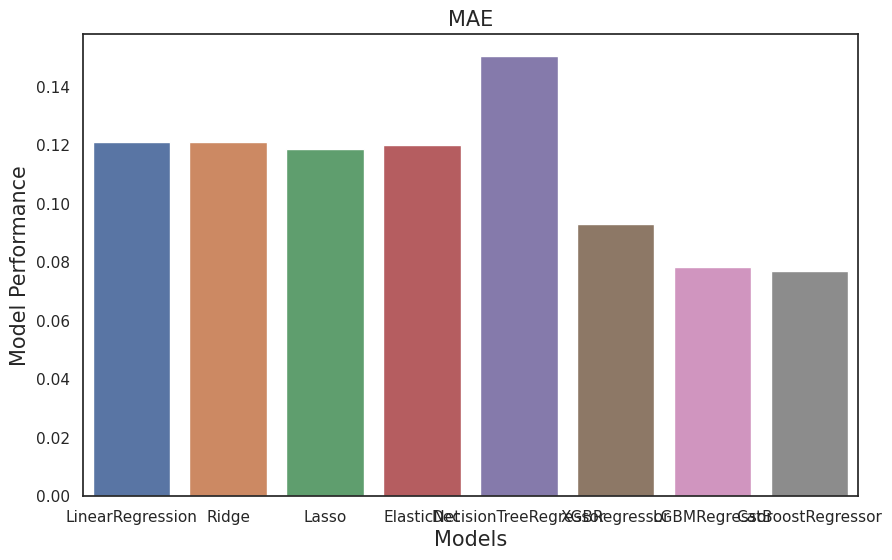

In [47]:
f, ax = plt.subplots(figsize=(10, 6))

sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)

plt.title('MAE', fontsize=15)
plt.show()

## Hyperparameter Tuning

In [48]:
cut = int(len(train_df)*0.8)
h_train = train_df[:cut]
h_valid = train_df[cut:]

h_train_X = h_train.drop('log_price', axis=1)
h_train_y = h_train['log_price']
h_valid_X = h_valid.drop('log_price', axis=1)
h_valid_y = h_valid['log_price']
print(h_train_X.shape, h_train_y.shape, h_valid_X.shape, h_valid_y.shape)


(4789, 5) (4789,) (1198, 5) (1198,)


In [49]:
h_train_X.head()

cluster  log_area  year_of_completion  floor  transaction_year_month
0      3.0  5.072295                   4     13                       0
1      3.0  4.856785                   4      6                       0
2      3.0  4.856785                   4      5                       0
3      3.0  4.856785                   4      9                       1
4      3.0  4.452136                   4      3                       1

In [50]:
import optuna
print(optuna.__version__)


3.2.0


### optuna를 통한 튜닝

#### Catboost

In [51]:
import catboost as catb
from catboost import Pool

def catboost_objective(trial):
    train_pool = Pool(data=h_train_X, label=h_train_y)
    valid_pool = Pool(data=h_valid_X, label=h_valid_y)

    param = {
        'loss_function': 'MAE', 
        'depth': trial.suggest_int('depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.4, 1, log=True),
    }

    model = catb.CatBoostRegressor(**param)
    catboost_model = model.fit(train_pool, eval_set=[valid_pool], early_stopping_rounds=10, verbose=100)
    mae = MAE(h_valid_y, catboost_model.predict(h_valid_X))
    
    return mae

study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(catboost_objective, n_trials=100)


[I 2023-08-02 00:54:05,312] A new study created in memory with name: no-name-799909d0-bcaf-48f5-bb73-da44e9a92783


0:	learn: 0.3911159	test: 0.6616776	best: 0.6616776 (0)	total: 335us	remaining: 505ms
100:	learn: 0.2874099	test: 0.5562656	best: 0.5562656 (100)	total: 29.9ms	remaining: 416ms
200:	learn: 0.2233311	test: 0.4819521	best: 0.4819521 (200)	total: 54.5ms	remaining: 354ms
300:	learn: 0.1829466	test: 0.4210274	best: 0.4210274 (300)	total: 79.4ms	remaining: 318ms
400:	learn: 0.1541201	test: 0.3693209	best: 0.3693209 (400)	total: 104ms	remaining: 287ms
500:	learn: 0.1314853	test: 0.3224149	best: 0.3224149 (500)	total: 129ms	remaining: 259ms
600:	learn: 0.1123373	test: 0.2785414	best: 0.2785414 (600)	total: 155ms	remaining: 233ms
700:	learn: 0.1002176	test: 0.2460807	best: 0.2460807 (700)	total: 180ms	remaining: 207ms
800:	learn: 0.0897195	test: 0.2116601	best: 0.2116601 (800)	total: 206ms	remaining: 181ms
900:	learn: 0.0816941	test: 0.1829195	best: 0.1829195 (900)	total: 232ms	remaining: 156ms
1000:	learn: 0.0766826	test: 0.1596990	best: 0.1596990 (1000)	total: 257ms	remaining: 130ms
1100:	lea

[I 2023-08-02 00:54:05,782] Trial 0 finished with value: 0.11544663520012918 and parameters: {'depth': 3, 'learning_rate': 0.005004444450169836, 'n_estimators': 1506, 'min_child_samples': 44, 'subsample': 0.42943426433441034}. Best is trial 0 with value: 0.11544663520012918.


0:	learn: 0.3696479	test: 0.6357797	best: 0.6357797 (0)	total: 1.5ms	remaining: 3.46s
100:	learn: 0.0406575	test: 0.1126666	best: 0.1126666 (100)	total: 146ms	remaining: 3.2s
200:	learn: 0.0305698	test: 0.0977723	best: 0.0977723 (200)	total: 244ms	remaining: 2.56s
300:	learn: 0.0264046	test: 0.0938816	best: 0.0938816 (300)	total: 342ms	remaining: 2.29s


[I 2023-08-02 00:54:06,216] Trial 1 finished with value: 0.09388262979316436 and parameters: {'depth': 9, 'learning_rate': 0.06412563026708994, 'n_estimators': 2315, 'min_child_samples': 12, 'subsample': 0.6794848077225858}. Best is trial 1 with value: 0.09388262979316436.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.09388162842
bestIteration = 300

Shrink model to first 301 iterations.
0:	learn: 0.3870890	test: 0.6565675	best: 0.6565675 (0)	total: 5.81ms	remaining: 14.1s
100:	learn: 0.1046917	test: 0.2830273	best: 0.2830273 (100)	total: 3.53s	remaining: 1m 21s
200:	learn: 0.0489408	test: 0.1880930	best: 0.1880930 (200)	total: 8.67s	remaining: 1m 36s
300:	learn: 0.0351669	test: 0.1531230	best: 0.1531230 (300)	total: 14.3s	remaining: 1m 40s
400:	learn: 0.0298951	test: 0.1385840	best: 0.1385840 (400)	total: 19.7s	remaining: 1m 40s
500:	learn: 0.0266051	test: 0.1340729	best: 0.1340729 (500)	total: 25.3s	remaining: 1m 37s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.13256803
bestIteration = 564

Shrink model to first 565 iterations.


[I 2023-08-02 00:54:36,548] Trial 2 finished with value: 0.13256904596613375 and parameters: {'depth': 15, 'learning_rate': 0.015455767062569084, 'n_estimators': 2432, 'min_child_samples': 94, 'subsample': 0.6615849877866808}. Best is trial 1 with value: 0.09388262979316436.


0:	learn: 0.3610375	test: 0.6296022	best: 0.6296022 (0)	total: 441us	remaining: 329ms
100:	learn: 0.0544070	test: 0.0948122	best: 0.0948122 (100)	total: 35.3ms	remaining: 225ms
200:	learn: 0.0425229	test: 0.0845420	best: 0.0845399 (199)	total: 67.1ms	remaining: 182ms
300:	learn: 0.0371921	test: 0.0796399	best: 0.0796399 (300)	total: 99.3ms	remaining: 146ms
400:	learn: 0.0335233	test: 0.0772223	best: 0.0772223 (400)	total: 131ms	remaining: 113ms
500:	learn: 0.0315731	test: 0.0758616	best: 0.0758616 (500)	total: 164ms	remaining: 79.7ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07562443639
bestIteration = 513

Shrink model to first 514 iterations.


[I 2023-08-02 00:54:36,783] Trial 3 finished with value: 0.07562544213113001 and parameters: {'depth': 4, 'learning_rate': 0.0962687784775514, 'n_estimators': 745, 'min_child_samples': 65, 'subsample': 0.8456374412354314}. Best is trial 3 with value: 0.07562544213113001.


0:	learn: 0.3651486	test: 0.6304500	best: 0.6304500 (0)	total: 1.09ms	remaining: 2.07s
100:	learn: 0.0323226	test: 0.1207745	best: 0.1207745 (100)	total: 503ms	remaining: 8.92s


[I 2023-08-02 00:54:37,992] Trial 4 finished with value: 0.11128436361195514 and parameters: {'depth': 12, 'learning_rate': 0.0767136052611963, 'n_estimators': 1893, 'min_child_samples': 63, 'subsample': 0.5351538395257704}. Best is trial 3 with value: 0.07562544213113001.


200:	learn: 0.0229385	test: 0.1122598	best: 0.1122598 (200)	total: 1.03s	remaining: 8.67s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.1112833493
bestIteration = 209

Shrink model to first 210 iterations.
0:	learn: 0.3916976	test: 0.6621721	best: 0.6621721 (0)	total: 1.45ms	remaining: 2.42s
100:	learn: 0.3070842	test: 0.5538067	best: 0.5538067 (100)	total: 1.57s	remaining: 24.3s
200:	learn: 0.2430429	test: 0.4702660	best: 0.4702660 (200)	total: 2.88s	remaining: 21s
300:	learn: 0.1939109	test: 0.4049548	best: 0.4049548 (300)	total: 4.36s	remaining: 19.8s
400:	learn: 0.1557154	test: 0.3550820	best: 0.3550820 (400)	total: 6.09s	remaining: 19.2s
500:	learn: 0.1274213	test: 0.3167469	best: 0.3167469 (500)	total: 7.99s	remaining: 18.6s
600:	learn: 0.1064602	test: 0.2859839	best: 0.2859839 (600)	total: 9.89s	remaining: 17.5s
700:	learn: 0.0904616	test: 0.2602055	best: 0.2602055 (700)	total: 12.1s	remaining: 16.7s
800:	learn: 0.0782001	test: 0.2393141	best: 0.2393141 (80

[I 2023-08-02 00:55:15,325] Trial 5 finished with value: 0.1534566794841738 and parameters: {'depth': 14, 'learning_rate': 0.0026083454574236512, 'n_estimators': 1667, 'min_child_samples': 88, 'subsample': 0.8116930666366236}. Best is trial 3 with value: 0.07562544213113001.


0:	learn: 0.3911237	test: 0.6614186	best: 0.6614186 (0)	total: 1.06ms	remaining: 2.72s
100:	learn: 0.2655009	test: 0.5005279	best: 0.5005279 (100)	total: 410ms	remaining: 10s
200:	learn: 0.1844432	test: 0.3956583	best: 0.3956583 (200)	total: 833ms	remaining: 9.81s
300:	learn: 0.1326814	test: 0.3250401	best: 0.3250401 (300)	total: 1.26s	remaining: 9.47s
400:	learn: 0.1008089	test: 0.2761008	best: 0.2761008 (400)	total: 1.73s	remaining: 9.35s
500:	learn: 0.0800886	test: 0.2404917	best: 0.2404917 (500)	total: 2.21s	remaining: 9.11s
600:	learn: 0.0662229	test: 0.2147754	best: 0.2147754 (600)	total: 2.71s	remaining: 8.87s
700:	learn: 0.0566237	test: 0.1934958	best: 0.1934958 (700)	total: 3.23s	remaining: 8.61s
800:	learn: 0.0501134	test: 0.1764692	best: 0.1764692 (800)	total: 3.74s	remaining: 8.25s
900:	learn: 0.0455577	test: 0.1615470	best: 0.1615470 (900)	total: 4.25s	remaining: 7.86s
1000:	learn: 0.0423217	test: 0.1505200	best: 0.1505200 (1000)	total: 4.78s	remaining: 7.48s
1100:	learn: 

[I 2023-08-02 00:55:25,582] Trial 6 finished with value: 0.11986699647054533 and parameters: {'depth': 12, 'learning_rate': 0.004214931498701549, 'n_estimators': 2569, 'min_child_samples': 90, 'subsample': 0.4575538880814109}. Best is trial 3 with value: 0.07562544213113001.


0:	learn: 0.3903530	test: 0.6604863	best: 0.6604863 (0)	total: 624us	remaining: 358ms
100:	learn: 0.2296032	test: 0.4707980	best: 0.4707980 (100)	total: 53.4ms	remaining: 250ms
200:	learn: 0.1452309	test: 0.3494645	best: 0.3494645 (200)	total: 106ms	remaining: 197ms
300:	learn: 0.1038687	test: 0.2790800	best: 0.2790800 (300)	total: 159ms	remaining: 144ms


[I 2023-08-02 00:55:25,956] Trial 7 finished with value: 0.16789126971760915 and parameters: {'depth': 7, 'learning_rate': 0.0063752472628123185, 'n_estimators': 574, 'min_child_samples': 53, 'subsample': 0.6602549209870143}. Best is trial 3 with value: 0.07562544213113001.


400:	learn: 0.0822820	test: 0.2318887	best: 0.2318887 (400)	total: 212ms	remaining: 91.4ms
500:	learn: 0.0680282	test: 0.1929233	best: 0.1929233 (500)	total: 264ms	remaining: 38.5ms
573:	learn: 0.0615299	test: 0.1678903	best: 0.1678903 (573)	total: 302ms	remaining: 0us

bestTest = 0.1678902505
bestIteration = 573

0:	learn: 0.3841334	test: 0.6544981	best: 0.6544981 (0)	total: 774us	remaining: 1.18s
100:	learn: 0.0924614	test: 0.2547434	best: 0.2547434 (100)	total: 82.1ms	remaining: 1.16s
200:	learn: 0.0567379	test: 0.1241753	best: 0.1241753 (200)	total: 124ms	remaining: 817ms
300:	learn: 0.0489077	test: 0.1007305	best: 0.1007305 (300)	total: 165ms	remaining: 675ms
400:	learn: 0.0442767	test: 0.0917250	best: 0.0917250 (400)	total: 206ms	remaining: 581ms
500:	learn: 0.0406650	test: 0.0882579	best: 0.0882542 (499)	total: 249ms	remaining: 510ms


[I 2023-08-02 00:55:26,352] Trial 8 finished with value: 0.08464985383846019 and parameters: {'depth': 6, 'learning_rate': 0.024863441162251077, 'n_estimators': 1530, 'min_child_samples': 99, 'subsample': 0.5253892840392717}. Best is trial 3 with value: 0.07562544213113001.


600:	learn: 0.0379721	test: 0.0859007	best: 0.0858875 (598)	total: 291ms	remaining: 449ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.08464885952
bestIteration = 672

Shrink model to first 673 iterations.
0:	learn: 0.3911662	test: 0.6614697	best: 0.6614697 (0)	total: 1.44ms	remaining: 3.27s
100:	learn: 0.2713901	test: 0.5102602	best: 0.5102602 (100)	total: 133ms	remaining: 2.87s
200:	learn: 0.1935415	test: 0.4096916	best: 0.4096916 (200)	total: 225ms	remaining: 2.32s
300:	learn: 0.1419977	test: 0.3386832	best: 0.3386832 (300)	total: 323ms	remaining: 2.12s
400:	learn: 0.1108012	test: 0.2920556	best: 0.2920556 (400)	total: 418ms	remaining: 1.95s
500:	learn: 0.0905482	test: 0.2565015	best: 0.2565015 (500)	total: 519ms	remaining: 1.83s
600:	learn: 0.0766908	test: 0.2278567	best: 0.2278567 (600)	total: 616ms	remaining: 1.71s
700:	learn: 0.0664991	test: 0.2033401	best: 0.2033401 (700)	total: 715ms	remaining: 1.6s
800:	learn: 0.0590994	test: 0.1809298	best: 0.1809298 (

[I 2023-08-02 00:55:28,320] Trial 9 finished with value: 0.10672520232817066 and parameters: {'depth': 9, 'learning_rate': 0.004096385107931559, 'n_estimators': 2272, 'min_child_samples': 54, 'subsample': 0.6786651828649511}. Best is trial 3 with value: 0.07562544213113001.
[I 2023-08-02 00:55:28,434] Trial 10 finished with value: 0.5898684607826662 and parameters: {'depth': 3, 'learning_rate': 0.0016751433101712106, 'n_estimators': 194, 'min_child_samples': 29, 'subsample': 0.9946883839287596}. Best is trial 3 with value: 0.07562544213113001.


0:	learn: 0.3921276	test: 0.6627154	best: 0.6627154 (0)	total: 367us	remaining: 70.9ms
100:	learn: 0.3519426	test: 0.6241197	best: 0.6241197 (100)	total: 31.7ms	remaining: 29.2ms
193:	learn: 0.3195687	test: 0.5898674	best: 0.5898674 (193)	total: 56.4ms	remaining: 0us

bestTest = 0.5898674481
bestIteration = 193

0:	learn: 0.3828140	test: 0.6531532	best: 0.6531532 (0)	total: 515us	remaining: 523ms
100:	learn: 0.0806367	test: 0.2235886	best: 0.2235886 (100)	total: 63.6ms	remaining: 576ms


[I 2023-08-02 00:55:28,751] Trial 11 finished with value: 0.08476993428854783 and parameters: {'depth': 6, 'learning_rate': 0.02872315872039696, 'n_estimators': 1017, 'min_child_samples': 74, 'subsample': 0.5193188989511045}. Best is trial 3 with value: 0.07562544213113001.


200:	learn: 0.0529984	test: 0.1120529	best: 0.1120529 (200)	total: 105ms	remaining: 426ms
300:	learn: 0.0463272	test: 0.0945778	best: 0.0945778 (300)	total: 146ms	remaining: 348ms
400:	learn: 0.0416844	test: 0.0882399	best: 0.0882399 (400)	total: 188ms	remaining: 289ms
500:	learn: 0.0384369	test: 0.0851941	best: 0.0851908 (499)	total: 230ms	remaining: 237ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.08476894172
bestIteration = 524

Shrink model to first 525 iterations.
0:	learn: 0.3813309	test: 0.6499954	best: 0.6499954 (0)	total: 469us	remaining: 523ms
100:	learn: 0.0784790	test: 0.2017450	best: 0.2017450 (100)	total: 92.2ms	remaining: 925ms
200:	learn: 0.0558993	test: 0.1079077	best: 0.1079077 (200)	total: 128ms	remaining: 582ms
300:	learn: 0.0492119	test: 0.0920476	best: 0.0920476 (300)	total: 164ms	remaining: 443ms


[I 2023-08-02 00:55:29,146] Trial 12 finished with value: 0.07890202419760839 and parameters: {'depth': 5, 'learning_rate': 0.03259688785589744, 'n_estimators': 1115, 'min_child_samples': 73, 'subsample': 0.8157660461728765}. Best is trial 3 with value: 0.07562544213113001.


400:	learn: 0.0442351	test: 0.0867381	best: 0.0867381 (400)	total: 200ms	remaining: 356ms
500:	learn: 0.0409300	test: 0.0842827	best: 0.0842827 (500)	total: 236ms	remaining: 289ms
600:	learn: 0.0382507	test: 0.0810065	best: 0.0810065 (600)	total: 272ms	remaining: 233ms
700:	learn: 0.0361204	test: 0.0790882	best: 0.0790882 (700)	total: 308ms	remaining: 182ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07890102957
bestIteration = 712

Shrink model to first 713 iterations.
0:	learn: 0.3591108	test: 0.6241482	best: 0.6241482 (0)	total: 702us	remaining: 660ms


[I 2023-08-02 00:55:29,390] Trial 13 finished with value: 0.07552846604558369 and parameters: {'depth': 5, 'learning_rate': 0.09723289646708408, 'n_estimators': 940, 'min_child_samples': 73, 'subsample': 0.8414231762262336}. Best is trial 13 with value: 0.07552846604558369.


100:	learn: 0.0486233	test: 0.0903754	best: 0.0903754 (100)	total: 82.6ms	remaining: 686ms
200:	learn: 0.0375104	test: 0.0786833	best: 0.0786833 (200)	total: 120ms	remaining: 440ms
300:	learn: 0.0324809	test: 0.0757884	best: 0.0757884 (300)	total: 157ms	remaining: 334ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07552746301
bestIteration = 320

Shrink model to first 321 iterations.
0:	learn: 0.3646129	test: 0.6364798	best: 0.6364798 (0)	total: 367us	remaining: 296ms
100:	learn: 0.0558483	test: 0.0976803	best: 0.0976803 (100)	total: 31.9ms	remaining: 223ms


[I 2023-08-02 00:55:29,600] Trial 14 finished with value: 0.07458549016392521 and parameters: {'depth': 4, 'learning_rate': 0.0873037776397525, 'n_estimators': 807, 'min_child_samples': 74, 'subsample': 0.9878493786285216}. Best is trial 14 with value: 0.07458549016392521.


200:	learn: 0.0445783	test: 0.0849325	best: 0.0849325 (200)	total: 63.7ms	remaining: 192ms
300:	learn: 0.0389517	test: 0.0793835	best: 0.0793825 (299)	total: 96ms	remaining: 161ms
400:	learn: 0.0357453	test: 0.0752524	best: 0.0752521 (397)	total: 128ms	remaining: 130ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07458448437
bestIteration = 431

Shrink model to first 432 iterations.
0:	learn: 0.3748421	test: 0.6435925	best: 0.6435925 (0)	total: 632us	remaining: 68.9ms


[I 2023-08-02 00:55:29,719] Trial 15 finished with value: 0.11421488217167955 and parameters: {'depth': 7, 'learning_rate': 0.052467259548372995, 'n_estimators': 110, 'min_child_samples': 79, 'subsample': 0.9907580265753996}. Best is trial 14 with value: 0.07458549016392521.


100:	learn: 0.0509921	test: 0.1176138	best: 0.1176138 (100)	total: 58.1ms	remaining: 5.18ms
109:	learn: 0.0493443	test: 0.1142139	best: 0.1142139 (109)	total: 63ms	remaining: 0us

bestTest = 0.1142138783
bestIteration = 109

0:	learn: 0.3609655	test: 0.6335917	best: 0.6335917 (0)	total: 850us	remaining: 2.52s
100:	learn: 0.0491493	test: 0.0900587	best: 0.0900587 (100)	total: 95.5ms	remaining: 2.71s
200:	learn: 0.0384878	test: 0.0819698	best: 0.0819698 (200)	total: 133ms	remaining: 1.83s


[I 2023-08-02 00:55:29,971] Trial 16 finished with value: 0.07759946889174701 and parameters: {'depth': 5, 'learning_rate': 0.09713122675372089, 'n_estimators': 2969, 'min_child_samples': 39, 'subsample': 0.8958818052050841}. Best is trial 14 with value: 0.07458549016392521.


300:	learn: 0.0331314	test: 0.0781594	best: 0.0781502 (299)	total: 170ms	remaining: 1.51s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07759847814
bestIteration = 315

Shrink model to first 316 iterations.
0:	learn: 0.3755119	test: 0.6439015	best: 0.6439015 (0)	total: 2.15ms	remaining: 2.24s
100:	learn: 0.0508381	test: 0.1267970	best: 0.1267970 (100)	total: 147ms	remaining: 1.38s
200:	learn: 0.0380430	test: 0.0982660	best: 0.0982660 (200)	total: 216ms	remaining: 908ms
300:	learn: 0.0318050	test: 0.0921268	best: 0.0921268 (300)	total: 286ms	remaining: 707ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.0909142854
bestIteration = 322

Shrink model to first 323 iterations.


[I 2023-08-02 00:55:30,363] Trial 17 finished with value: 0.09091529021969147 and parameters: {'depth': 8, 'learning_rate': 0.047599864004684, 'n_estimators': 1044, 'min_child_samples': 81, 'subsample': 0.7484986584126753}. Best is trial 14 with value: 0.07458549016392521.


0:	learn: 0.3881749	test: 0.6587621	best: 0.6587621 (0)	total: 405us	remaining: 230ms
100:	learn: 0.1647238	test: 0.3943545	best: 0.3943545 (100)	total: 54.3ms	remaining: 251ms
200:	learn: 0.0994582	test: 0.2579888	best: 0.2579888 (200)	total: 85.4ms	remaining: 156ms
300:	learn: 0.0721721	test: 0.1635738	best: 0.1635738 (300)	total: 117ms	remaining: 104ms
400:	learn: 0.0633479	test: 0.1208593	best: 0.1208593 (400)	total: 148ms	remaining: 61.5ms
500:	learn: 0.0585801	test: 0.1070978	best: 0.1070978 (500)	total: 179ms	remaining: 23.9ms


[I 2023-08-02 00:55:30,639] Trial 18 finished with value: 0.10202193157419735 and parameters: {'depth': 4, 'learning_rate': 0.014267050750616682, 'n_estimators': 568, 'min_child_samples': 61, 'subsample': 0.918498827276733}. Best is trial 14 with value: 0.07458549016392521.


567:	learn: 0.0561796	test: 0.1020209	best: 0.1020209 (567)	total: 200ms	remaining: 0us

bestTest = 0.1020209303
bestIteration = 567

0:	learn: 0.3764758	test: 0.6449831	best: 0.6449831 (0)	total: 1.57ms	remaining: 2s
100:	learn: 0.0429058	test: 0.1395455	best: 0.1395455 (100)	total: 341ms	remaining: 3.95s
200:	learn: 0.0315360	test: 0.1137485	best: 0.1137485 (200)	total: 623ms	remaining: 3.33s


[I 2023-08-02 00:55:31,666] Trial 19 finished with value: 0.10933889368785253 and parameters: {'depth': 11, 'learning_rate': 0.04491816262434414, 'n_estimators': 1274, 'min_child_samples': 69, 'subsample': 0.7505488287685691}. Best is trial 14 with value: 0.07458549016392521.


300:	learn: 0.0259226	test: 0.1093821	best: 0.1093379 (290)	total: 923ms	remaining: 2.98s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.1093378836
bestIteration = 290

Shrink model to first 291 iterations.
0:	learn: 0.3606705	test: 0.6328301	best: 0.6328301 (0)	total: 473us	remaining: 348ms
100:	learn: 0.0483677	test: 0.0928216	best: 0.0928216 (100)	total: 55ms	remaining: 345ms
200:	learn: 0.0375614	test: 0.0799091	best: 0.0799091 (200)	total: 92.6ms	remaining: 246ms


[I 2023-08-02 00:55:31,887] Trial 20 finished with value: 0.07434930894933363 and parameters: {'depth': 5, 'learning_rate': 0.09889177000711495, 'n_estimators': 735, 'min_child_samples': 83, 'subsample': 0.9271466518934494}. Best is trial 20 with value: 0.07434930894933363.


300:	learn: 0.0327773	test: 0.0749893	best: 0.0749893 (300)	total: 131ms	remaining: 189ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07434830232
bestIteration = 341

Shrink model to first 342 iterations.
0:	learn: 0.3616845	test: 0.6337994	best: 0.6337994 (0)	total: 510us	remaining: 390ms
100:	learn: 0.0497999	test: 0.0906322	best: 0.0906322 (100)	total: 69.6ms	remaining: 458ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.09033868785
bestIteration = 106

Shrink model to first 107 iterations.


[I 2023-08-02 00:55:32,021] Trial 21 finished with value: 0.09033968047190223 and parameters: {'depth': 5, 'learning_rate': 0.09571537129272971, 'n_estimators': 766, 'min_child_samples': 82, 'subsample': 0.9235579395520512}. Best is trial 20 with value: 0.07434930894933363.
[I 2023-08-02 00:55:32,237] Trial 22 finished with value: 0.08374753824528201 and parameters: {'depth': 3, 'learning_rate': 0.06608360210748099, 'n_estimators': 420, 'min_child_samples': 84, 'subsample': 0.9907479060207965}. Best is trial 20 with value: 0.07434930894933363.


0:	learn: 0.3727119	test: 0.6427384	best: 0.6427384 (0)	total: 360us	remaining: 151ms
100:	learn: 0.0678614	test: 0.1182995	best: 0.1182995 (100)	total: 58ms	remaining: 183ms
200:	learn: 0.0553211	test: 0.0930654	best: 0.0930654 (200)	total: 85.1ms	remaining: 92.7ms
300:	learn: 0.0494573	test: 0.0877368	best: 0.0877368 (300)	total: 112ms	remaining: 44.4ms
400:	learn: 0.0447747	test: 0.0841691	best: 0.0841691 (400)	total: 140ms	remaining: 6.63ms
419:	learn: 0.0438973	test: 0.0837465	best: 0.0837465 (419)	total: 145ms	remaining: 0us

bestTest = 0.0837465472
bestIteration = 419

0:	learn: 0.3783862	test: 0.6473985	best: 0.6473985 (0)	total: 842us	remaining: 655ms
100:	learn: 0.0562138	test: 0.1354676	best: 0.1354676 (100)	total: 123ms	remaining: 827ms
200:	learn: 0.0428501	test: 0.0971911	best: 0.0971911 (200)	total: 178ms	remaining: 510ms
300:	learn: 0.0360693	test: 0.0875741	best: 0.0875741 (300)	total: 232ms	remaining: 368ms
400:	learn: 0.0322715	test: 0.0850243	best: 0.0850243 (400)	t

[I 2023-08-02 00:55:32,704] Trial 23 finished with value: 0.08253402274151704 and parameters: {'depth': 7, 'learning_rate': 0.04198766478002701, 'n_estimators': 778, 'min_child_samples': 74, 'subsample': 0.8856884970004006}. Best is trial 20 with value: 0.07434930894933363.


0:	learn: 0.3712882	test: 0.6405569	best: 0.6405569 (0)	total: 365us	remaining: 482ms
100:	learn: 0.0598807	test: 0.1115752	best: 0.1115752 (100)	total: 34.9ms	remaining: 422ms
200:	learn: 0.0482190	test: 0.0873144	best: 0.0873144 (200)	total: 66.2ms	remaining: 369ms
300:	learn: 0.0423598	test: 0.0824813	best: 0.0824813 (300)	total: 97ms	remaining: 329ms
400:	learn: 0.0384927	test: 0.0790623	best: 0.0790623 (400)	total: 128ms	remaining: 294ms
500:	learn: 0.0357363	test: 0.0771147	best: 0.0771147 (500)	total: 159ms	remaining: 261ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07594922352
bestIteration = 582

Shrink model to first 583 iterations.


[I 2023-08-02 00:55:32,969] Trial 24 finished with value: 0.07595021940989528 and parameters: {'depth': 4, 'learning_rate': 0.06476332514858911, 'n_estimators': 1322, 'min_child_samples': 97, 'subsample': 0.7539753895021846}. Best is trial 20 with value: 0.07434930894933363.


0:	learn: 0.3607158	test: 0.6337271	best: 0.6337271 (0)	total: 662us	remaining: 254ms
100:	learn: 0.0442095	test: 0.0885167	best: 0.0885167 (100)	total: 97.2ms	remaining: 272ms
200:	learn: 0.0339262	test: 0.0808192	best: 0.0808192 (200)	total: 142ms	remaining: 129ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07843317261
bestIteration = 258

Shrink model to first 259 iterations.


[I 2023-08-02 00:55:33,230] Trial 25 finished with value: 0.07843416652869291 and parameters: {'depth': 6, 'learning_rate': 0.09790640949355288, 'n_estimators': 384, 'min_child_samples': 58, 'subsample': 0.854543536164097}. Best is trial 20 with value: 0.07434930894933363.


0:	learn: 0.3804171	test: 0.6498189	best: 0.6498189 (0)	total: 1.43ms	remaining: 1.28s
100:	learn: 0.0582800	test: 0.1649330	best: 0.1649330 (100)	total: 125ms	remaining: 990ms
200:	learn: 0.0423733	test: 0.1080702	best: 0.1080702 (200)	total: 196ms	remaining: 681ms


[I 2023-08-02 00:55:33,662] Trial 26 finished with value: 0.0964180149778759 and parameters: {'depth': 8, 'learning_rate': 0.03556114198581192, 'n_estimators': 900, 'min_child_samples': 69, 'subsample': 0.9316292665246799}. Best is trial 20 with value: 0.07434930894933363.


300:	learn: 0.0358886	test: 0.0988699	best: 0.0988699 (300)	total: 267ms	remaining: 531ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.09641701447
bestIteration = 361

Shrink model to first 362 iterations.
0:	learn: 0.3840799	test: 0.6532136	best: 0.6532136 (0)	total: 660us	remaining: 832ms
100:	learn: 0.0986978	test: 0.2585765	best: 0.2585765 (100)	total: 68.8ms	remaining: 791ms
200:	learn: 0.0609324	test: 0.1256144	best: 0.1256144 (200)	total: 105ms	remaining: 553ms
300:	learn: 0.0525180	test: 0.1039161	best: 0.1039161 (300)	total: 141ms	remaining: 448ms
400:	learn: 0.0482057	test: 0.0904695	best: 0.0904695 (400)	total: 176ms	remaining: 378ms
500:	learn: 0.0445054	test: 0.0866400	best: 0.0866372 (499)	total: 212ms	remaining: 322ms
600:	learn: 0.0415740	test: 0.0835524	best: 0.0835524 (600)	total: 248ms	remaining: 273ms
700:	learn: 0.0393630	test: 0.0810368	best: 0.0810368 (700)	total: 284ms	remaining: 227ms
800:	learn: 0.0374978	test: 0.0798700	best: 0.0798700 

[I 2023-08-02 00:55:34,208] Trial 27 finished with value: 0.07704867712557395 and parameters: {'depth': 5, 'learning_rate': 0.024493397094834828, 'n_estimators': 1261, 'min_child_samples': 41, 'subsample': 0.8069534135784854}. Best is trial 20 with value: 0.07434930894933363.


0:	learn: 0.3691349	test: 0.6325100	best: 0.6325100 (0)	total: 1.84ms	remaining: 3.41s
100:	learn: 0.0396169	test: 0.1172542	best: 0.1172542 (100)	total: 240ms	remaining: 4.16s
200:	learn: 0.0290365	test: 0.1057987	best: 0.1057987 (200)	total: 402ms	remaining: 3.31s


[I 2023-08-02 00:55:34,864] Trial 28 finished with value: 0.10285128994670743 and parameters: {'depth': 10, 'learning_rate': 0.06270084245999738, 'n_estimators': 1853, 'min_child_samples': 88, 'subsample': 0.9299437374434214}. Best is trial 20 with value: 0.07434930894933363.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.1028502805
bestIteration = 279

Shrink model to first 280 iterations.
0:	learn: 0.3791106	test: 0.6493248	best: 0.6493248 (0)	total: 520us	remaining: 272ms
100:	learn: 0.0807816	test: 0.1691396	best: 0.1691396 (100)	total: 55.4ms	remaining: 232ms
200:	learn: 0.0618489	test: 0.1053024	best: 0.1053024 (200)	total: 82.3ms	remaining: 132ms


[I 2023-08-02 00:55:35,120] Trial 29 finished with value: 0.0871455845852804 and parameters: {'depth': 3, 'learning_rate': 0.04471823084395428, 'n_estimators': 524, 'min_child_samples': 32, 'subsample': 0.8649689073572868}. Best is trial 20 with value: 0.07434930894933363.


300:	learn: 0.0553059	test: 0.0923255	best: 0.0923255 (300)	total: 109ms	remaining: 81.1ms
400:	learn: 0.0507684	test: 0.0889893	best: 0.0889378 (399)	total: 137ms	remaining: 42ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.08714459516
bestIteration = 446

Shrink model to first 447 iterations.
0:	learn: 0.3730201	test: 0.6445123	best: 0.6445123 (0)	total: 708us	remaining: 244ms
100:	learn: 0.0625535	test: 0.1164906	best: 0.1164906 (100)	total: 36.2ms	remaining: 87.4ms


[I 2023-08-02 00:55:35,327] Trial 30 finished with value: 0.08217716902979456 and parameters: {'depth': 4, 'learning_rate': 0.060930942307289, 'n_estimators': 345, 'min_child_samples': 50, 'subsample': 0.9523422630448873}. Best is trial 20 with value: 0.07434930894933363.


200:	learn: 0.0497579	test: 0.0897133	best: 0.0897133 (200)	total: 79.4ms	remaining: 56.9ms
300:	learn: 0.0435357	test: 0.0834740	best: 0.0834740 (300)	total: 111ms	remaining: 16.2ms
344:	learn: 0.0413346	test: 0.0821762	best: 0.0821762 (344)	total: 125ms	remaining: 0us

bestTest = 0.08217617252
bestIteration = 344

0:	learn: 0.3606103	test: 0.6291444	best: 0.6291444 (0)	total: 625us	remaining: 441ms
100:	learn: 0.0542118	test: 0.0930578	best: 0.0930578 (100)	total: 97.2ms	remaining: 583ms
200:	learn: 0.0430300	test: 0.0831554	best: 0.0831495 (199)	total: 129ms	remaining: 324ms
300:	learn: 0.0373272	test: 0.0783229	best: 0.0783229 (300)	total: 160ms	remaining: 216ms
400:	learn: 0.0335879	test: 0.0756663	best: 0.0756663 (400)	total: 193ms	remaining: 147ms
500:	learn: 0.0316322	test: 0.0737921	best: 0.0737909 (499)	total: 225ms	remaining: 92.4ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07359696787
bestIteration = 527

Shrink model to first 528 iterations.


[I 2023-08-02 00:55:35,661] Trial 31 finished with value: 0.0735979709946515 and parameters: {'depth': 4, 'learning_rate': 0.09758820389843333, 'n_estimators': 707, 'min_child_samples': 66, 'subsample': 0.8524904446746455}. Best is trial 31 with value: 0.0735979709946515.
[I 2023-08-02 00:55:35,828] Trial 32 finished with value: 0.09459275602302344 and parameters: {'depth': 3, 'learning_rate': 0.0758809319127558, 'n_estimators': 891, 'min_child_samples': 77, 'subsample': 0.8653572098597745}. Best is trial 31 with value: 0.0735979709946515.


0:	learn: 0.3697934	test: 0.6397218	best: 0.6397218 (0)	total: 582us	remaining: 519ms
100:	learn: 0.0671052	test: 0.1075851	best: 0.1075851 (100)	total: 59.7ms	remaining: 467ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.09459176419
bestIteration = 172

Shrink model to first 173 iterations.
0:	learn: 0.3687557	test: 0.6411660	best: 0.6411660 (0)	total: 896us	remaining: 574ms
100:	learn: 0.0486605	test: 0.0997223	best: 0.0997223 (100)	total: 118ms	remaining: 631ms
200:	learn: 0.0385279	test: 0.0865658	best: 0.0865658 (200)	total: 162ms	remaining: 356ms
300:	learn: 0.0324297	test: 0.0793910	best: 0.0793910 (300)	total: 208ms	remaining: 235ms
400:	learn: 0.0295273	test: 0.0782720	best: 0.0782454 (398)	total: 253ms	remaining: 151ms
500:	learn: 0.0280321	test: 0.0772000	best: 0.0771443 (491)	total: 298ms	remaining: 83.2ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07714425411
bestIteration = 491

Shrink model to first 492 iterations.


[I 2023-08-02 00:55:36,236] Trial 33 finished with value: 0.07714525185715662 and parameters: {'depth': 6, 'learning_rate': 0.07305709937063361, 'n_estimators': 641, 'min_child_samples': 68, 'subsample': 0.9988638547158024}. Best is trial 31 with value: 0.0735979709946515.


0:	learn: 0.3600525	test: 0.6285462	best: 0.6285462 (0)	total: 639us	remaining: 714ms
100:	learn: 0.0526006	test: 0.0921887	best: 0.0921887 (100)	total: 67.5ms	remaining: 679ms
200:	learn: 0.0419540	test: 0.0816074	best: 0.0816074 (200)	total: 98.5ms	remaining: 449ms
300:	learn: 0.0368369	test: 0.0771364	best: 0.0771364 (300)	total: 130ms	remaining: 352ms
400:	learn: 0.0334984	test: 0.0749943	best: 0.0749723 (398)	total: 162ms	remaining: 288ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.0748925998
bestIteration = 415

Shrink model to first 416 iterations.


[I 2023-08-02 00:55:36,495] Trial 34 finished with value: 0.07489360554445935 and parameters: {'depth': 4, 'learning_rate': 0.09931205993076847, 'n_estimators': 1117, 'min_child_samples': 17, 'subsample': 0.7917245244173263}. Best is trial 31 with value: 0.0735979709946515.


0:	learn: 0.3753177	test: 0.6448464	best: 0.6448464 (0)	total: 422us	remaining: 497ms
100:	learn: 0.0662059	test: 0.1243885	best: 0.1243885 (100)	total: 96.5ms	remaining: 1.03s
200:	learn: 0.0522589	test: 0.0921760	best: 0.0921760 (200)	total: 127ms	remaining: 618ms
300:	learn: 0.0454278	test: 0.0863386	best: 0.0863386 (300)	total: 158ms	remaining: 460ms
400:	learn: 0.0414209	test: 0.0814870	best: 0.0814870 (400)	total: 189ms	remaining: 365ms


[I 2023-08-02 00:55:36,904] Trial 35 finished with value: 0.07403552312413585 and parameters: {'depth': 4, 'learning_rate': 0.05245067477757397, 'n_estimators': 1178, 'min_child_samples': 8, 'subsample': 0.7910613117284664}. Best is trial 31 with value: 0.0735979709946515.


500:	learn: 0.0385244	test: 0.0776876	best: 0.0776876 (500)	total: 220ms	remaining: 297ms
600:	learn: 0.0361645	test: 0.0756827	best: 0.0756827 (600)	total: 251ms	remaining: 241ms
700:	learn: 0.0344243	test: 0.0745303	best: 0.0745303 (700)	total: 282ms	remaining: 192ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07403453166
bestIteration = 762

Shrink model to first 763 iterations.
0:	learn: 0.3760415	test: 0.6437940	best: 0.6437940 (0)	total: 842us	remaining: 1.2s


[I 2023-08-02 00:55:37,161] Trial 36 finished with value: 0.0875743924684775 and parameters: {'depth': 3, 'learning_rate': 0.05492161928725725, 'n_estimators': 1431, 'min_child_samples': 5, 'subsample': 0.7347020362899301}. Best is trial 31 with value: 0.0735979709946515.


100:	learn: 0.0713447	test: 0.1315532	best: 0.1315532 (100)	total: 71.8ms	remaining: 945ms
200:	learn: 0.0576622	test: 0.0966827	best: 0.0966827 (200)	total: 97.7ms	remaining: 598ms
300:	learn: 0.0514286	test: 0.0901672	best: 0.0901672 (300)	total: 124ms	remaining: 464ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.08757340451
bestIteration = 360

Shrink model to first 361 iterations.
0:	learn: 0.3681719	test: 0.6398847	best: 0.6398847 (0)	total: 715us	remaining: 537ms
100:	learn: 0.0577898	test: 0.1050696	best: 0.1050696 (100)	total: 38ms	remaining: 244ms
200:	learn: 0.0460274	test: 0.0854945	best: 0.0854945 (200)	total: 70.8ms	remaining: 194ms
300:	learn: 0.0406446	test: 0.0794704	best: 0.0794704 (300)	total: 103ms	remaining: 153ms
400:	learn: 0.0368994	test: 0.0759826	best: 0.0759807 (399)	total: 135ms	remaining: 118ms
500:	learn: 0.0343664	test: 0.0743121	best: 0.0743121 (500)	total: 167ms	remaining: 83.2ms
Stopped by overfitting detector  (10 iterations wait

[I 2023-08-02 00:55:37,465] Trial 37 finished with value: 0.07342764946114251 and parameters: {'depth': 4, 'learning_rate': 0.07611232892743947, 'n_estimators': 751, 'min_child_samples': 21, 'subsample': 0.8949840815891356}. Best is trial 37 with value: 0.07342764946114251.


0:	learn: 0.3721083	test: 0.6426032	best: 0.6426032 (0)	total: 711us	remaining: 196ms
100:	learn: 0.0592026	test: 0.1088266	best: 0.1088266 (100)	total: 109ms	remaining: 189ms
200:	learn: 0.0474304	test: 0.0877984	best: 0.0877984 (200)	total: 140ms	remaining: 52.4ms
275:	learn: 0.0430042	test: 0.0833569	best: 0.0833569 (275)	total: 164ms	remaining: 0us

bestTest = 0.08335692209
bestIteration = 275



[I 2023-08-02 00:55:37,730] Trial 38 finished with value: 0.08335790883265985 and parameters: {'depth': 4, 'learning_rate': 0.06609908486917938, 'n_estimators': 276, 'min_child_samples': 17, 'subsample': 0.8850042372120451}. Best is trial 37 with value: 0.07342764946114251.


0:	learn: 0.3730914	test: 0.6411928	best: 0.6411928 (0)	total: 1.59ms	remaining: 1.06s
100:	learn: 0.0340432	test: 0.1363920	best: 0.1363920 (100)	total: 2.23s	remaining: 12.5s
200:	learn: 0.0237616	test: 0.1259043	best: 0.1258921 (199)	total: 5.01s	remaining: 11.6s


[I 2023-08-02 00:55:43,322] Trial 39 finished with value: 0.12538956409792382 and parameters: {'depth': 14, 'learning_rate': 0.05433920021828292, 'n_estimators': 668, 'min_child_samples': 7, 'subsample': 0.7172925911269553}. Best is trial 37 with value: 0.07342764946114251.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.1253885501
bestIteration = 204

Shrink model to first 205 iterations.
0:	learn: 0.3689386	test: 0.6413350	best: 0.6413350 (0)	total: 555us	remaining: 659ms
100:	learn: 0.0492107	test: 0.0987502	best: 0.0987502 (100)	total: 47.1ms	remaining: 506ms


[I 2023-08-02 00:55:43,564] Trial 40 finished with value: 0.07838053969910036 and parameters: {'depth': 6, 'learning_rate': 0.07249383937762002, 'n_estimators': 1187, 'min_child_samples': 23, 'subsample': 0.7989848887522274}. Best is trial 37 with value: 0.07342764946114251.


200:	learn: 0.0381892	test: 0.0840702	best: 0.0840702 (200)	total: 90.7ms	remaining: 445ms
300:	learn: 0.0330815	test: 0.0798076	best: 0.0798076 (300)	total: 134ms	remaining: 396ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.0783795435
bestIteration = 375

Shrink model to first 376 iterations.
0:	learn: 0.3668323	test: 0.6387067	best: 0.6387067 (0)	total: 707us	remaining: 580ms
100:	learn: 0.0511388	test: 0.1003745	best: 0.1003745 (100)	total: 76.9ms	remaining: 548ms
200:	learn: 0.0409820	test: 0.0835292	best: 0.0835292 (200)	total: 114ms	remaining: 351ms
300:	learn: 0.0351145	test: 0.0787752	best: 0.0787752 (300)	total: 152ms	remaining: 262ms
400:	learn: 0.0318051	test: 0.0767653	best: 0.0767653 (400)	total: 189ms	remaining: 198ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07561489424
bestIteration = 486

Shrink model to first 487 iterations.


[I 2023-08-02 00:55:43,880] Trial 41 finished with value: 0.075615898658094 and parameters: {'depth': 5, 'learning_rate': 0.07963741850367834, 'n_estimators': 821, 'min_child_samples': 10, 'subsample': 0.9383429209335885}. Best is trial 37 with value: 0.07342764946114251.


0:	learn: 0.3664284	test: 0.6353745	best: 0.6353745 (0)	total: 2.14ms	remaining: 3.5s
100:	learn: 0.0576953	test: 0.0981429	best: 0.0981429 (100)	total: 110ms	remaining: 1.67s
200:	learn: 0.0461102	test: 0.0837531	best: 0.0836835 (199)	total: 141ms	remaining: 1.01s
300:	learn: 0.0400404	test: 0.0791473	best: 0.0791473 (300)	total: 173ms	remaining: 764ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07893117918
bestIteration = 308

Shrink model to first 309 iterations.


[I 2023-08-02 00:55:44,169] Trial 42 finished with value: 0.07893216928106031 and parameters: {'depth': 4, 'learning_rate': 0.0796615800772387, 'n_estimators': 1634, 'min_child_samples': 17, 'subsample': 0.8317681782259221}. Best is trial 37 with value: 0.07342764946114251.


0:	learn: 0.3813554	test: 0.6516369	best: 0.6516369 (0)	total: 1.12ms	remaining: 537ms
100:	learn: 0.0936241	test: 0.2256754	best: 0.2256754 (100)	total: 93.4ms	remaining: 349ms
200:	learn: 0.0656311	test: 0.1120353	best: 0.1120353 (200)	total: 120ms	remaining: 166ms
300:	learn: 0.0589373	test: 0.0944970	best: 0.0944970 (300)	total: 147ms	remaining: 86.8ms
400:	learn: 0.0538363	test: 0.0904517	best: 0.0904517 (400)	total: 174ms	remaining: 33.9ms


[I 2023-08-02 00:55:44,479] Trial 43 finished with value: 0.08858074665419792 and parameters: {'depth': 3, 'learning_rate': 0.0372482133241818, 'n_estimators': 479, 'min_child_samples': 91, 'subsample': 0.895103620421652}. Best is trial 37 with value: 0.07342764946114251.


478:	learn: 0.0510656	test: 0.0885798	best: 0.0885798 (478)	total: 195ms	remaining: 0us

bestTest = 0.08857975675
bestIteration = 478

0:	learn: 0.3762600	test: 0.6476021	best: 0.6476021 (0)	total: 661us	remaining: 449ms
100:	learn: 0.0672066	test: 0.1304391	best: 0.1304391 (100)	total: 70.4ms	remaining: 403ms
200:	learn: 0.0535640	test: 0.0923544	best: 0.0923544 (200)	total: 102ms	remaining: 242ms


[I 2023-08-02 00:55:44,844] Trial 44 finished with value: 0.0755983284100208 and parameters: {'depth': 4, 'learning_rate': 0.05080235922375348, 'n_estimators': 680, 'min_child_samples': 24, 'subsample': 0.9561198614045983}. Best is trial 37 with value: 0.07342764946114251.


300:	learn: 0.0471405	test: 0.0853200	best: 0.0853200 (300)	total: 133ms	remaining: 168ms
400:	learn: 0.0429464	test: 0.0825160	best: 0.0825160 (400)	total: 165ms	remaining: 115ms
500:	learn: 0.0397851	test: 0.0794849	best: 0.0794849 (500)	total: 197ms	remaining: 70.4ms
600:	learn: 0.0374927	test: 0.0771049	best: 0.0771000 (598)	total: 229ms	remaining: 30.1ms
679:	learn: 0.0359569	test: 0.0755973	best: 0.0755973 (679)	total: 254ms	remaining: 0us

bestTest = 0.07559733501
bestIteration = 679

0:	learn: 0.3654764	test: 0.6315584	best: 0.6315584 (0)	total: 881us	remaining: 1.23s
100:	learn: 0.0519348	test: 0.1004019	best: 0.1004019 (100)	total: 74.4ms	remaining: 956ms
200:	learn: 0.0406799	test: 0.0827548	best: 0.0827548 (200)	total: 113ms	remaining: 676ms
300:	learn: 0.0354097	test: 0.0779162	best: 0.0779162 (300)	total: 151ms	remaining: 550ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07612872461
bestIteration = 385

Shrink model to first 386 iterations.


[I 2023-08-02 00:55:45,132] Trial 45 finished with value: 0.0761297250534335 and parameters: {'depth': 5, 'learning_rate': 0.07861036322093254, 'n_estimators': 1399, 'min_child_samples': 48, 'subsample': 0.838496767638575}. Best is trial 37 with value: 0.07342764946114251.


0:	learn: 0.3790580	test: 0.6476033	best: 0.6476033 (0)	total: 792us	remaining: 789ms
100:	learn: 0.0642193	test: 0.1528220	best: 0.1528220 (100)	total: 114ms	remaining: 1.01s
200:	learn: 0.0483690	test: 0.0965388	best: 0.0965388 (200)	total: 157ms	remaining: 621ms


[I 2023-08-02 00:55:45,482] Trial 46 finished with value: 0.08318545443142966 and parameters: {'depth': 6, 'learning_rate': 0.03842534067481115, 'n_estimators': 997, 'min_child_samples': 64, 'subsample': 0.7891664735738513}. Best is trial 37 with value: 0.07342764946114251.


300:	learn: 0.0420632	test: 0.0863322	best: 0.0863322 (300)	total: 199ms	remaining: 461ms
400:	learn: 0.0376024	test: 0.0833656	best: 0.0832600 (398)	total: 242ms	remaining: 360ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.08318445611
bestIteration = 410

Shrink model to first 411 iterations.
0:	learn: 0.3842533	test: 0.6546198	best: 0.6546198 (0)	total: 448us	remaining: 341ms
100:	learn: 0.1179216	test: 0.2872782	best: 0.2872782 (100)	total: 53.4ms	remaining: 349ms
200:	learn: 0.0733503	test: 0.1361848	best: 0.1361848 (200)	total: 79.3ms	remaining: 221ms
300:	learn: 0.0642585	test: 0.1121284	best: 0.1121284 (300)	total: 105ms	remaining: 161ms
400:	learn: 0.0591340	test: 0.0990314	best: 0.0990314 (400)	total: 131ms	remaining: 118ms
500:	learn: 0.0555387	test: 0.0938025	best: 0.0938025 (500)	total: 156ms	remaining: 81.5ms
600:	learn: 0.0525418	test: 0.0909685	best: 0.0909685 (600)	total: 182ms	remaining: 48.8ms
Stopped by overfitting detector  (10 iterations wai

[I 2023-08-02 00:55:45,799] Trial 47 finished with value: 0.08951482532411095 and parameters: {'depth': 3, 'learning_rate': 0.02764949393779996, 'n_estimators': 762, 'min_child_samples': 60, 'subsample': 0.6285086686228238}. Best is trial 37 with value: 0.07342764946114251.


0:	learn: 0.3731421	test: 0.6417165	best: 0.6417165 (0)	total: 1.37ms	remaining: 1.54s
100:	learn: 0.0489096	test: 0.1127968	best: 0.1127968 (100)	total: 128ms	remaining: 1.3s
200:	learn: 0.0378447	test: 0.0893424	best: 0.0893424 (200)	total: 182ms	remaining: 837ms


[I 2023-08-02 00:55:46,136] Trial 48 finished with value: 0.08414265751257102 and parameters: {'depth': 7, 'learning_rate': 0.057503717544967796, 'n_estimators': 1127, 'min_child_samples': 32, 'subsample': 0.9600864557410921}. Best is trial 37 with value: 0.07342764946114251.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.08414165912
bestIteration = 283

Shrink model to first 284 iterations.
0:	learn: 0.3633880	test: 0.6311257	best: 0.6311257 (0)	total: 940us	remaining: 860ms


[I 2023-08-02 00:55:46,424] Trial 49 finished with value: 0.09071311652802358 and parameters: {'depth': 8, 'learning_rate': 0.08600000518959969, 'n_estimators': 915, 'min_child_samples': 11, 'subsample': 0.8997302471467522}. Best is trial 37 with value: 0.07342764946114251.


100:	learn: 0.0400240	test: 0.1007013	best: 0.1004682 (99)	total: 122ms	remaining: 981ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.09071211126
bestIteration = 168

Shrink model to first 169 iterations.
0:	learn: 0.3643101	test: 0.6302444	best: 0.6302444 (0)	total: 1.14ms	remaining: 659ms


[I 2023-08-02 00:55:46,647] Trial 50 finished with value: 0.07923913359173519 and parameters: {'depth': 5, 'learning_rate': 0.08146019345955138, 'n_estimators': 581, 'min_child_samples': 57, 'subsample': 0.8697109345045584}. Best is trial 37 with value: 0.07342764946114251.


100:	learn: 0.0512139	test: 0.0983173	best: 0.0983173 (100)	total: 38.3ms	remaining: 182ms
200:	learn: 0.0402525	test: 0.0843043	best: 0.0843043 (200)	total: 75.2ms	remaining: 142ms
300:	learn: 0.0350896	test: 0.0800951	best: 0.0800951 (300)	total: 112ms	remaining: 105ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.0792381372
bestIteration = 337

Shrink model to first 338 iterations.
0:	learn: 0.3622786	test: 0.6309316	best: 0.6309316 (0)	total: 414us	remaining: 452ms


[I 2023-08-02 00:55:46,945] Trial 51 finished with value: 0.07452558280278718 and parameters: {'depth': 4, 'learning_rate': 0.09243792469604986, 'n_estimators': 1092, 'min_child_samples': 16, 'subsample': 0.8430979409551967}. Best is trial 37 with value: 0.07342764946114251.


100:	learn: 0.0551561	test: 0.0952388	best: 0.0952388 (100)	total: 73.8ms	remaining: 724ms
200:	learn: 0.0433180	test: 0.0816655	best: 0.0816655 (200)	total: 105ms	remaining: 467ms
300:	learn: 0.0381444	test: 0.0784347	best: 0.0784347 (300)	total: 137ms	remaining: 360ms
400:	learn: 0.0344481	test: 0.0757844	best: 0.0757838 (399)	total: 169ms	remaining: 291ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07452458324
bestIteration = 463

Shrink model to first 464 iterations.
0:	learn: 0.3644490	test: 0.6332567	best: 0.6332567 (0)	total: 734us	remaining: 634ms
100:	learn: 0.0561684	test: 0.0966478	best: 0.0966478 (100)	total: 99ms	remaining: 748ms
200:	learn: 0.0439592	test: 0.0836999	best: 0.0836999 (200)	total: 130ms	remaining: 428ms
300:	learn: 0.0385297	test: 0.0794134	best: 0.0794134 (300)	total: 161ms	remaining: 301ms
400:	learn: 0.0351794	test: 0.0754425	best: 0.0754425 (400)	total: 192ms	remaining: 222ms


[I 2023-08-02 00:55:47,282] Trial 52 finished with value: 0.07389145751715091 and parameters: {'depth': 4, 'learning_rate': 0.08574984592037063, 'n_estimators': 864, 'min_child_samples': 21, 'subsample': 0.8295873714458618}. Best is trial 37 with value: 0.07342764946114251.


500:	learn: 0.0328082	test: 0.0742101	best: 0.0742101 (500)	total: 224ms	remaining: 162ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07389045673
bestIteration = 517

Shrink model to first 518 iterations.
0:	learn: 0.3712038	test: 0.6381026	best: 0.6381026 (0)	total: 434us	remaining: 454ms
100:	learn: 0.0667970	test: 0.1123874	best: 0.1123874 (100)	total: 56.4ms	remaining: 527ms
200:	learn: 0.0554150	test: 0.0930908	best: 0.0930908 (200)	total: 82.9ms	remaining: 348ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.08838639942
bestIteration = 273

Shrink model to first 274 iterations.


[I 2023-08-02 00:55:47,487] Trial 53 finished with value: 0.08838738832953709 and parameters: {'depth': 3, 'learning_rate': 0.07110885601401071, 'n_estimators': 1046, 'min_child_samples': 24, 'subsample': 0.8291359251326592}. Best is trial 37 with value: 0.07342764946114251.


0:	learn: 0.3603282	test: 0.6288419	best: 0.6288419 (0)	total: 712us	remaining: 851ms
100:	learn: 0.0537945	test: 0.0942542	best: 0.0942542 (100)	total: 35.7ms	remaining: 387ms
200:	learn: 0.0421912	test: 0.0843749	best: 0.0843749 (200)	total: 66.5ms	remaining: 329ms
300:	learn: 0.0368726	test: 0.0796959	best: 0.0796959 (300)	total: 97.6ms	remaining: 290ms
400:	learn: 0.0333691	test: 0.0767421	best: 0.0767421 (400)	total: 129ms	remaining: 255ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07644255161
bestIteration = 412

Shrink model to first 413 iterations.


[I 2023-08-02 00:55:47,722] Trial 54 finished with value: 0.07644355006319643 and parameters: {'depth': 4, 'learning_rate': 0.09845994723009442, 'n_estimators': 1196, 'min_child_samples': 20, 'subsample': 0.7724350949103423}. Best is trial 37 with value: 0.07342764946114251.


0:	learn: 0.3711726	test: 0.6382186	best: 0.6382186 (0)	total: 959us	remaining: 1.49s
100:	learn: 0.0565426	test: 0.1090755	best: 0.1090755 (100)	total: 111ms	remaining: 1.6s
200:	learn: 0.0445858	test: 0.0875217	best: 0.0874049 (199)	total: 148ms	remaining: 994ms
300:	learn: 0.0386036	test: 0.0828856	best: 0.0828856 (300)	total: 185ms	remaining: 768ms


[I 2023-08-02 00:55:48,073] Trial 55 finished with value: 0.07923403153303456 and parameters: {'depth': 5, 'learning_rate': 0.06159399001637523, 'n_estimators': 1551, 'min_child_samples': 11, 'subsample': 0.8336182733496349}. Best is trial 37 with value: 0.07342764946114251.


400:	learn: 0.0347759	test: 0.0797663	best: 0.0797663 (400)	total: 222ms	remaining: 637ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07923304175
bestIteration = 435

Shrink model to first 436 iterations.
0:	learn: 0.3772182	test: 0.6485159	best: 0.6485159 (0)	total: 590us	remaining: 590ms
100:	learn: 0.0689927	test: 0.1366466	best: 0.1366466 (100)	total: 69.5ms	remaining: 619ms
200:	learn: 0.0544644	test: 0.0957348	best: 0.0957348 (200)	total: 101ms	remaining: 402ms
300:	learn: 0.0474801	test: 0.0885218	best: 0.0885218 (300)	total: 132ms	remaining: 308ms
400:	learn: 0.0433672	test: 0.0847312	best: 0.0847058 (399)	total: 164ms	remaining: 245ms
500:	learn: 0.0400915	test: 0.0820627	best: 0.0820627 (500)	total: 195ms	remaining: 195ms
600:	learn: 0.0373952	test: 0.0793395	best: 0.0793395 (600)	total: 227ms	remaining: 151ms
700:	learn: 0.0354172	test: 0.0773840	best: 0.0773840 (700)	total: 259ms	remaining: 111ms
800:	learn: 0.0339788	test: 0.0760743	best: 0.0760702 

[I 2023-08-02 00:55:48,483] Trial 56 finished with value: 0.07599208618494172 and parameters: {'depth': 4, 'learning_rate': 0.04781387690818629, 'n_estimators': 1001, 'min_child_samples': 14, 'subsample': 0.9000399772685428}. Best is trial 37 with value: 0.07342764946114251.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07599109486
bestIteration = 816

Shrink model to first 817 iterations.
0:	learn: 0.3623059	test: 0.6284296	best: 0.6284296 (0)	total: 916us	remaining: 1.72s
100:	learn: 0.0458959	test: 0.0941036	best: 0.0941036 (100)	total: 94.6ms	remaining: 1.66s


[I 2023-08-02 00:55:48,813] Trial 57 finished with value: 0.0804927468333264 and parameters: {'depth': 6, 'learning_rate': 0.0861952311177815, 'n_estimators': 1873, 'min_child_samples': 27, 'subsample': 0.854169590412483}. Best is trial 37 with value: 0.07342764946114251.


200:	learn: 0.0360267	test: 0.0864552	best: 0.0864552 (200)	total: 139ms	remaining: 1.16s
300:	learn: 0.0305199	test: 0.0813543	best: 0.0813543 (300)	total: 184ms	remaining: 962ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.08049174909
bestIteration = 371

Shrink model to first 372 iterations.
0:	learn: 0.3725856	test: 0.6398626	best: 0.6398626 (0)	total: 897us	remaining: 758ms
100:	learn: 0.0571504	test: 0.1158929	best: 0.1158929 (100)	total: 105ms	remaining: 778ms
200:	learn: 0.0453750	test: 0.0891608	best: 0.0891116 (198)	total: 141ms	remaining: 454ms
300:	learn: 0.0393894	test: 0.0818771	best: 0.0818653 (299)	total: 178ms	remaining: 321ms
400:	learn: 0.0354155	test: 0.0792935	best: 0.0792935 (400)	total: 214ms	remaining: 237ms
500:	learn: 0.0328927	test: 0.0777267	best: 0.0777267 (500)	total: 251ms	remaining: 173ms
600:	learn: 0.0311130	test: 0.0767310	best: 0.0767149 (593)	total: 288ms	remaining: 117ms
Stopped by overfitting detector  (10 iterations wait)



[I 2023-08-02 00:55:49,217] Trial 58 finished with value: 0.07671593673537937 and parameters: {'depth': 5, 'learning_rate': 0.05751325658162929, 'n_estimators': 846, 'min_child_samples': 37, 'subsample': 0.8082060018690057}. Best is trial 37 with value: 0.07342764946114251.
[I 2023-08-02 00:55:49,380] Trial 59 finished with value: 0.09018179851246991 and parameters: {'depth': 3, 'learning_rate': 0.07011705327790825, 'n_estimators': 698, 'min_child_samples': 14, 'subsample': 0.7741945616900213}. Best is trial 37 with value: 0.07342764946114251.


0:	learn: 0.3714984	test: 0.6384510	best: 0.6384510 (0)	total: 499us	remaining: 348ms
100:	learn: 0.0664002	test: 0.1135115	best: 0.1135107 (99)	total: 32ms	remaining: 189ms
200:	learn: 0.0546163	test: 0.0921742	best: 0.0921742 (200)	total: 58.2ms	remaining: 144ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.09018080675
bestIteration = 241

Shrink model to first 242 iterations.
0:	learn: 0.3617835	test: 0.6285450	best: 0.6285450 (0)	total: 1.62ms	remaining: 2.2s
100:	learn: 0.0303440	test: 0.1196021	best: 0.1196021 (100)	total: 537ms	remaining: 6.69s


[I 2023-08-02 00:55:50,496] Trial 60 finished with value: 0.11021902298394962 and parameters: {'depth': 12, 'learning_rate': 0.08590559552990797, 'n_estimators': 1360, 'min_child_samples': 21, 'subsample': 0.8720984151284766}. Best is trial 37 with value: 0.07342764946114251.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.1102180129
bestIteration = 176

Shrink model to first 177 iterations.
0:	learn: 0.3618327	test: 0.6321780	best: 0.6321780 (0)	total: 429us	remaining: 356ms
100:	learn: 0.0542426	test: 0.0940520	best: 0.0940520 (100)	total: 39.4ms	remaining: 284ms
200:	learn: 0.0432939	test: 0.0849707	best: 0.0849707 (200)	total: 71.1ms	remaining: 222ms


[I 2023-08-02 00:55:50,745] Trial 61 finished with value: 0.0749368645484739 and parameters: {'depth': 4, 'learning_rate': 0.0998024590386465, 'n_estimators': 829, 'min_child_samples': 76, 'subsample': 0.9153035325641354}. Best is trial 37 with value: 0.07342764946114251.


300:	learn: 0.0373197	test: 0.0794790	best: 0.0794790 (300)	total: 103ms	remaining: 181ms
400:	learn: 0.0338216	test: 0.0766862	best: 0.0766656 (399)	total: 136ms	remaining: 145ms
500:	learn: 0.0319105	test: 0.0751512	best: 0.0751487 (499)	total: 168ms	remaining: 110ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.0749358608
bestIteration = 514

Shrink model to first 515 iterations.
0:	learn: 0.3648513	test: 0.6367078	best: 0.6367078 (0)	total: 394us	remaining: 199ms
100:	learn: 0.0555077	test: 0.0997450	best: 0.0997450 (100)	total: 50.3ms	remaining: 201ms


[I 2023-08-02 00:55:51,006] Trial 62 finished with value: 0.07457832028369797 and parameters: {'depth': 4, 'learning_rate': 0.0865533561910389, 'n_estimators': 504, 'min_child_samples': 84, 'subsample': 0.9567220892928578}. Best is trial 37 with value: 0.07342764946114251.


200:	learn: 0.0445143	test: 0.0840727	best: 0.0840667 (198)	total: 81.9ms	remaining: 124ms
300:	learn: 0.0385945	test: 0.0790044	best: 0.0790044 (300)	total: 114ms	remaining: 76.9ms
400:	learn: 0.0351642	test: 0.0760567	best: 0.0760567 (400)	total: 146ms	remaining: 37.6ms
500:	learn: 0.0325127	test: 0.0745871	best: 0.0745871 (500)	total: 179ms	remaining: 1.07ms
503:	learn: 0.0324437	test: 0.0745773	best: 0.0745773 (503)	total: 180ms	remaining: 0us

bestTest = 0.07457731486
bestIteration = 503

0:	learn: 0.3717740	test: 0.6422658	best: 0.6422658 (0)	total: 510us	remaining: 148ms


[I 2023-08-02 00:55:51,172] Trial 63 finished with value: 0.08208791154047307 and parameters: {'depth': 4, 'learning_rate': 0.06718783747291973, 'n_estimators': 291, 'min_child_samples': 83, 'subsample': 0.9446283005082504}. Best is trial 37 with value: 0.07342764946114251.


100:	learn: 0.0604447	test: 0.1098591	best: 0.1098591 (100)	total: 39.4ms	remaining: 74.1ms
200:	learn: 0.0483705	test: 0.0860358	best: 0.0860358 (200)	total: 70.9ms	remaining: 31.8ms
290:	learn: 0.0426061	test: 0.0820869	best: 0.0820869 (290)	total: 99.4ms	remaining: 0us

bestTest = 0.08208692093
bestIteration = 290

0:	learn: 0.3652964	test: 0.6372448	best: 0.6372448 (0)	total: 483us	remaining: 209ms


[I 2023-08-02 00:55:51,453] Trial 64 finished with value: 0.07645151615006732 and parameters: {'depth': 5, 'learning_rate': 0.08442484127011012, 'n_estimators': 433, 'min_child_samples': 93, 'subsample': 0.9161662803625636}. Best is trial 37 with value: 0.07342764946114251.


100:	learn: 0.0511866	test: 0.0977062	best: 0.0977062 (100)	total: 94ms	remaining: 309ms
200:	learn: 0.0403607	test: 0.0847699	best: 0.0847699 (200)	total: 132ms	remaining: 152ms
300:	learn: 0.0346247	test: 0.0783168	best: 0.0783168 (300)	total: 169ms	remaining: 74.2ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.0764505188
bestIteration = 380

Shrink model to first 381 iterations.
0:	learn: 0.3773576	test: 0.6475194	best: 0.6475194 (0)	total: 436us	remaining: 83.4ms


[I 2023-08-02 00:55:51,653] Trial 65 finished with value: 0.1021799172712665 and parameters: {'depth': 3, 'learning_rate': 0.05056405536303009, 'n_estimators': 192, 'min_child_samples': 86, 'subsample': 0.960235789677613}. Best is trial 37 with value: 0.07342764946114251.


100:	learn: 0.0748157	test: 0.1443130	best: 0.1443130 (100)	total: 92.1ms	remaining: 83ms
191:	learn: 0.0604417	test: 0.1021789	best: 0.1021789 (191)	total: 117ms	remaining: 0us

bestTest = 0.1021789197
bestIteration = 191

0:	learn: 0.3775462	test: 0.6456219	best: 0.6456219 (0)	total: 716us	remaining: 410ms
100:	learn: 0.0642644	test: 0.1369937	best: 0.1369937 (100)	total: 54.9ms	remaining: 257ms
200:	learn: 0.0504218	test: 0.0926580	best: 0.0926580 (200)	total: 91.4ms	remaining: 169ms


[I 2023-08-02 00:55:51,864] Trial 66 finished with value: 0.08433358088302839 and parameters: {'depth': 5, 'learning_rate': 0.04323388441196665, 'n_estimators': 573, 'min_child_samples': 100, 'subsample': 0.8532225416170657}. Best is trial 37 with value: 0.07342764946114251.


300:	learn: 0.0438920	test: 0.0845899	best: 0.0845899 (300)	total: 129ms	remaining: 116ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.08433259382
bestIteration = 303

Shrink model to first 304 iterations.
0:	learn: 0.3649003	test: 0.6341570	best: 0.6341570 (0)	total: 493us	remaining: 1.34s
100:	learn: 0.0550570	test: 0.0994269	best: 0.0994269 (100)	total: 73.2ms	remaining: 1.89s
200:	learn: 0.0444087	test: 0.0838780	best: 0.0838780 (200)	total: 105ms	remaining: 1.32s


[I 2023-08-02 00:55:52,118] Trial 67 finished with value: 0.07770510295062483 and parameters: {'depth': 4, 'learning_rate': 0.08748993512935425, 'n_estimators': 2711, 'min_child_samples': 28, 'subsample': 0.9749275179910283}. Best is trial 37 with value: 0.07342764946114251.


300:	learn: 0.0386221	test: 0.0802759	best: 0.0802742 (299)	total: 138ms	remaining: 1.1s
400:	learn: 0.0350655	test: 0.0778041	best: 0.0778041 (400)	total: 170ms	remaining: 978ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07770410572
bestIteration = 405

Shrink model to first 406 iterations.
0:	learn: 0.3692034	test: 0.6325999	best: 0.6325999 (0)	total: 1.63ms	remaining: 1.56s
100:	learn: 0.0298700	test: 0.1372595	best: 0.1372595 (100)	total: 4.82s	remaining: 41s
200:	learn: 0.0203021	test: 0.1288253	best: 0.1287878 (199)	total: 10.8s	remaining: 40.8s


[I 2023-08-02 00:56:05,051] Trial 68 finished with value: 0.12825228015826323 and parameters: {'depth': 15, 'learning_rate': 0.06251737760930165, 'n_estimators': 960, 'min_child_samples': 96, 'subsample': 0.8795339749363604}. Best is trial 37 with value: 0.07342764946114251.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.1282512637
bestIteration = 221

Shrink model to first 222 iterations.
0:	learn: 0.3667153	test: 0.6334823	best: 0.6334823 (0)	total: 585us	remaining: 368ms
100:	learn: 0.0486972	test: 0.0993072	best: 0.0993072 (100)	total: 48ms	remaining: 251ms
200:	learn: 0.0374544	test: 0.0842565	best: 0.0842565 (200)	total: 91.6ms	remaining: 195ms
300:	learn: 0.0322937	test: 0.0807208	best: 0.0807208 (300)	total: 136ms	remaining: 148ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07926054959
bestIteration = 348

Shrink model to first 349 iterations.


[I 2023-08-02 00:56:05,296] Trial 69 finished with value: 0.07926154589133097 and parameters: {'depth': 6, 'learning_rate': 0.07356399299712074, 'n_estimators': 630, 'min_child_samples': 6, 'subsample': 0.8307667144588792}. Best is trial 37 with value: 0.07342764946114251.


0:	learn: 0.3738265	test: 0.6423238	best: 0.6423238 (0)	total: 647us	remaining: 333ms
100:	learn: 0.0498451	test: 0.1115158	best: 0.1115158 (100)	total: 71.8ms	remaining: 294ms
200:	learn: 0.0381234	test: 0.0896199	best: 0.0896199 (200)	total: 126ms	remaining: 197ms
300:	learn: 0.0324637	test: 0.0850714	best: 0.0849778 (296)	total: 181ms	remaining: 129ms


[I 2023-08-02 00:56:05,592] Trial 70 finished with value: 0.08341982083466165 and parameters: {'depth': 7, 'learning_rate': 0.055515923040638265, 'n_estimators': 515, 'min_child_samples': 35, 'subsample': 0.9173391562920813}. Best is trial 37 with value: 0.07342764946114251.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.08341882339
bestIteration = 356

Shrink model to first 357 iterations.
0:	learn: 0.3650547	test: 0.6343207	best: 0.6343207 (0)	total: 406us	remaining: 311ms
100:	learn: 0.0550561	test: 0.1002926	best: 0.1002926 (100)	total: 39.8ms	remaining: 262ms
200:	learn: 0.0441083	test: 0.0846821	best: 0.0846821 (200)	total: 71.5ms	remaining: 201ms
300:	learn: 0.0387151	test: 0.0780728	best: 0.0780728 (300)	total: 104ms	remaining: 160ms


[I 2023-08-02 00:56:05,809] Trial 71 finished with value: 0.07548760612302755 and parameters: {'depth': 4, 'learning_rate': 0.0869948067047937, 'n_estimators': 766, 'min_child_samples': 71, 'subsample': 0.9775237204470747}. Best is trial 37 with value: 0.07342764946114251.


400:	learn: 0.0350976	test: 0.0755342	best: 0.0755255 (399)	total: 136ms	remaining: 124ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07548660573
bestIteration = 406

Shrink model to first 407 iterations.
0:	learn: 0.3711604	test: 0.6411377	best: 0.6411377 (0)	total: 377us	remaining: 409ms
100:	learn: 0.0670927	test: 0.1109516	best: 0.1109516 (100)	total: 57.3ms	remaining: 558ms
200:	learn: 0.0557442	test: 0.0939967	best: 0.0938358 (199)	total: 84.6ms	remaining: 372ms
300:	learn: 0.0488730	test: 0.0885291	best: 0.0885291 (300)	total: 112ms	remaining: 292ms


[I 2023-08-02 00:56:06,011] Trial 72 finished with value: 0.08673367615569504 and parameters: {'depth': 3, 'learning_rate': 0.07128237794683039, 'n_estimators': 1085, 'min_child_samples': 79, 'subsample': 0.9929820049845552}. Best is trial 37 with value: 0.07342764946114251.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.08673268451
bestIteration = 341

Shrink model to first 342 iterations.
0:	learn: 0.3623566	test: 0.6327130	best: 0.6327130 (0)	total: 420us	remaining: 392ms
100:	learn: 0.0535299	test: 0.0940523	best: 0.0940523 (100)	total: 53.6ms	remaining: 442ms
200:	learn: 0.0419566	test: 0.0832669	best: 0.0832669 (200)	total: 85.2ms	remaining: 311ms
300:	learn: 0.0363220	test: 0.0782959	best: 0.0782959 (300)	total: 117ms	remaining: 247ms


[I 2023-08-02 00:56:06,250] Trial 73 finished with value: 0.0755944075616053 and parameters: {'depth': 4, 'learning_rate': 0.09807050056575198, 'n_estimators': 934, 'min_child_samples': 8, 'subsample': 0.9290435768033436}. Best is trial 37 with value: 0.07342764946114251.


400:	learn: 0.0332801	test: 0.0760916	best: 0.0760749 (398)	total: 149ms	remaining: 199ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07559340974
bestIteration = 424

Shrink model to first 425 iterations.
0:	learn: 0.3713810	test: 0.6430366	best: 0.6430366 (0)	total: 495us	remaining: 626ms
100:	learn: 0.0547572	test: 0.1080724	best: 0.1080724 (100)	total: 89.9ms	remaining: 1.03s


[I 2023-08-02 00:56:06,586] Trial 74 finished with value: 0.07601379390212076 and parameters: {'depth': 5, 'learning_rate': 0.0654927348667229, 'n_estimators': 1264, 'min_child_samples': 66, 'subsample': 0.885523515081327}. Best is trial 37 with value: 0.07342764946114251.


200:	learn: 0.0431991	test: 0.0872932	best: 0.0872932 (200)	total: 127ms	remaining: 671ms
300:	learn: 0.0374133	test: 0.0813222	best: 0.0813222 (300)	total: 165ms	remaining: 527ms
400:	learn: 0.0342537	test: 0.0780068	best: 0.0780068 (400)	total: 202ms	remaining: 435ms
500:	learn: 0.0319457	test: 0.0764383	best: 0.0764383 (500)	total: 240ms	remaining: 366ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07601279502
bestIteration = 538

Shrink model to first 539 iterations.
0:	learn: 0.3657473	test: 0.6316253	best: 0.6316253 (0)	total: 343us	remaining: 246ms
100:	learn: 0.0620977	test: 0.1028131	best: 0.1028131 (100)	total: 68.9ms	remaining: 420ms
200:	learn: 0.0511817	test: 0.0902995	best: 0.0902995 (200)	total: 98.9ms	remaining: 254ms
300:	learn: 0.0443581	test: 0.0848802	best: 0.0848679 (298)	total: 127ms	remaining: 175ms
400:	learn: 0.0404173	test: 0.0802226	best: 0.0801975 (397)	total: 154ms	remaining: 122ms
500:	learn: 0.0379510	test: 0.0768221	best: 0.0768221

[I 2023-08-02 00:56:06,866] Trial 75 finished with value: 0.07547478047639276 and parameters: {'depth': 3, 'learning_rate': 0.08954544738333176, 'n_estimators': 717, 'min_child_samples': 87, 'subsample': 0.9712189419803977}. Best is trial 37 with value: 0.07342764946114251.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.0754737857
bestIteration = 560

Shrink model to first 561 iterations.
0:	learn: 0.3681120	test: 0.6399263	best: 0.6399263 (0)	total: 538us	remaining: 463ms
100:	learn: 0.0527716	test: 0.0989929	best: 0.0989929 (100)	total: 105ms	remaining: 788ms


[I 2023-08-02 00:56:07,231] Trial 76 finished with value: 0.07553336912139931 and parameters: {'depth': 5, 'learning_rate': 0.0756532530710292, 'n_estimators': 861, 'min_child_samples': 78, 'subsample': 0.9460676290683266}. Best is trial 37 with value: 0.07342764946114251.


200:	learn: 0.0417043	test: 0.0857247	best: 0.0857247 (200)	total: 142ms	remaining: 466ms
300:	learn: 0.0358959	test: 0.0786913	best: 0.0786913 (300)	total: 180ms	remaining: 334ms
400:	learn: 0.0328226	test: 0.0769226	best: 0.0768791 (396)	total: 217ms	remaining: 249ms
500:	learn: 0.0308055	test: 0.0760318	best: 0.0760318 (500)	total: 255ms	remaining: 183ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07553236799
bestIteration = 564

Shrink model to first 565 iterations.
0:	learn: 0.3762878	test: 0.6458791	best: 0.6458791 (0)	total: 458us	remaining: 989ms
100:	learn: 0.0676878	test: 0.1319186	best: 0.1319186 (100)	total: 58.3ms	remaining: 1.19s
200:	learn: 0.0531846	test: 0.0920833	best: 0.0920833 (200)	total: 89.6ms	remaining: 873ms
300:	learn: 0.0464034	test: 0.0865372	best: 0.0865372 (300)	total: 121ms	remaining: 747ms
400:	learn: 0.0424207	test: 0.0826335	best: 0.0826335 (400)	total: 153ms	remaining: 669ms
500:	learn: 0.0392584	test: 0.0806639	best: 0.0806512

[I 2023-08-02 00:56:07,560] Trial 77 finished with value: 0.07701238623498395 and parameters: {'depth': 4, 'learning_rate': 0.049489221457923296, 'n_estimators': 2159, 'min_child_samples': 14, 'subsample': 0.8540264711775859}. Best is trial 37 with value: 0.07342764946114251.


600:	learn: 0.0370171	test: 0.0784947	best: 0.0784947 (600)	total: 216ms	remaining: 561ms
700:	learn: 0.0352279	test: 0.0770660	best: 0.0770114 (696)	total: 248ms	remaining: 517ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07701139745
bestIteration = 696

Shrink model to first 697 iterations.
0:	learn: 0.3718500	test: 0.6398031	best: 0.6398031 (0)	total: 1.33ms	remaining: 1.58s
100:	learn: 0.0425274	test: 0.1127096	best: 0.1127096 (100)	total: 155ms	remaining: 1.67s
200:	learn: 0.0319713	test: 0.0951720	best: 0.0951720 (200)	total: 252ms	remaining: 1.24s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.09316558126
bestIteration = 263

Shrink model to first 264 iterations.


[I 2023-08-02 00:56:07,973] Trial 78 finished with value: 0.09316658785851795 and parameters: {'depth': 9, 'learning_rate': 0.0577967304175508, 'n_estimators': 1190, 'min_child_samples': 75, 'subsample': 0.8154016706411019}. Best is trial 37 with value: 0.07342764946114251.


0:	learn: 0.3691477	test: 0.6396097	best: 0.6396097 (0)	total: 414us	remaining: 197ms
100:	learn: 0.0574987	test: 0.1040991	best: 0.1040991 (100)	total: 35.9ms	remaining: 134ms
200:	learn: 0.0461111	test: 0.0848645	best: 0.0848645 (200)	total: 68.7ms	remaining: 94.4ms
300:	learn: 0.0401609	test: 0.0793558	best: 0.0793558 (300)	total: 101ms	remaining: 58.9ms
400:	learn: 0.0362837	test: 0.0758230	best: 0.0758230 (400)	total: 133ms	remaining: 25.2ms
476:	learn: 0.0342217	test: 0.0747402	best: 0.0747402 (476)	total: 158ms	remaining: 0us

bestTest = 0.07474022364
bestIteration = 476



[I 2023-08-02 00:56:08,205] Trial 79 finished with value: 0.07474122549716539 and parameters: {'depth': 4, 'learning_rate': 0.07575950323663232, 'n_estimators': 477, 'min_child_samples': 80, 'subsample': 0.9124687685845839}. Best is trial 37 with value: 0.07342764946114251.


0:	learn: 0.3596048	test: 0.6197793	best: 0.6197793 (0)	total: 3.38ms	remaining: 2.06s


[I 2023-08-02 00:56:08,665] Trial 80 finished with value: 0.10327902162280965 and parameters: {'depth': 10, 'learning_rate': 0.08911465504825973, 'n_estimators': 610, 'min_child_samples': 44, 'subsample': 0.8913269425907966}. Best is trial 37 with value: 0.07342764946114251.


100:	learn: 0.0337564	test: 0.1120679	best: 0.1120679 (100)	total: 240ms	remaining: 1.21s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.1032780116
bestIteration = 167

Shrink model to first 168 iterations.
0:	learn: 0.3686234	test: 0.6390788	best: 0.6390788 (0)	total: 407us	remaining: 188ms
100:	learn: 0.0576020	test: 0.1073298	best: 0.1073298 (100)	total: 43ms	remaining: 154ms
200:	learn: 0.0459293	test: 0.0867142	best: 0.0867142 (200)	total: 74.2ms	remaining: 96.7ms
300:	learn: 0.0404574	test: 0.0795107	best: 0.0795107 (300)	total: 106ms	remaining: 57ms
400:	learn: 0.0362923	test: 0.0770349	best: 0.0770294 (398)	total: 138ms	remaining: 21.3ms
462:	learn: 0.0345373	test: 0.0758111	best: 0.0758111 (462)	total: 158ms	remaining: 0us

bestTest = 0.07581112294
bestIteration = 462



[I 2023-08-02 00:56:08,902] Trial 81 finished with value: 0.07581212193187252 and parameters: {'depth': 4, 'learning_rate': 0.07747283753157735, 'n_estimators': 463, 'min_child_samples': 84, 'subsample': 0.9078162574010408}. Best is trial 37 with value: 0.07342764946114251.
[I 2023-08-02 00:56:09,120] Trial 82 finished with value: 0.08133313414353441 and parameters: {'depth': 4, 'learning_rate': 0.06544560567846157, 'n_estimators': 357, 'min_child_samples': 81, 'subsample': 0.9450165681457424}. Best is trial 37 with value: 0.07342764946114251.


0:	learn: 0.3723091	test: 0.6428057	best: 0.6428057 (0)	total: 510us	remaining: 182ms
100:	learn: 0.0601014	test: 0.1102903	best: 0.1102903 (100)	total: 57.7ms	remaining: 146ms
200:	learn: 0.0482797	test: 0.0872551	best: 0.0872551 (200)	total: 89.1ms	remaining: 69.1ms
300:	learn: 0.0423843	test: 0.0831671	best: 0.0831671 (300)	total: 121ms	remaining: 22.4ms
356:	learn: 0.0399048	test: 0.0813671	best: 0.0813322 (355)	total: 138ms	remaining: 0us

bestTest = 0.08133215187
bestIteration = 355

Shrink model to first 356 iterations.


[I 2023-08-02 00:56:09,252] Trial 83 finished with value: 0.0936932391783632 and parameters: {'depth': 3, 'learning_rate': 0.09977377601130957, 'n_estimators': 525, 'min_child_samples': 20, 'subsample': 0.8744083519018295}. Best is trial 37 with value: 0.07342764946114251.


0:	learn: 0.3627371	test: 0.6280394	best: 0.6280394 (0)	total: 336us	remaining: 176ms
100:	learn: 0.0626922	test: 0.1003499	best: 0.1003499 (100)	total: 47.7ms	remaining: 200ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.09369224768
bestIteration = 160

Shrink model to first 161 iterations.
0:	learn: 0.3667750	test: 0.6390360	best: 0.6390360 (0)	total: 447us	remaining: 347ms
100:	learn: 0.0517647	test: 0.0981513	best: 0.0981513 (100)	total: 66.4ms	remaining: 445ms


[I 2023-08-02 00:56:09,469] Trial 84 finished with value: 0.07937485489994682 and parameters: {'depth': 5, 'learning_rate': 0.07915876791978764, 'n_estimators': 778, 'min_child_samples': 72, 'subsample': 0.9966554890886521}. Best is trial 37 with value: 0.07342764946114251.


200:	learn: 0.0410002	test: 0.0846369	best: 0.0846369 (200)	total: 104ms	remaining: 298ms
300:	learn: 0.0355765	test: 0.0794073	best: 0.0794073 (300)	total: 141ms	remaining: 224ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.0793738594
bestIteration = 302

Shrink model to first 303 iterations.
0:	learn: 0.3666724	test: 0.6292756	best: 0.6292756 (0)	total: 1.68ms	remaining: 1.18s
100:	learn: 0.0318674	test: 0.1327327	best: 0.1325261 (99)	total: 983ms	remaining: 5.86s


[I 2023-08-02 00:56:11,381] Trial 85 finished with value: 0.12562632128894674 and parameters: {'depth': 13, 'learning_rate': 0.06930087585351843, 'n_estimators': 703, 'min_child_samples': 67, 'subsample': 0.9209132426229556}. Best is trial 37 with value: 0.07342764946114251.
[I 2023-08-02 00:56:11,502] Trial 86 finished with value: 0.09229824035163108 and parameters: {'depth': 3, 'learning_rate': 0.09055290382467858, 'n_estimators': 887, 'min_child_samples': 90, 'subsample': 0.8518413263633784}. Best is trial 37 with value: 0.07342764946114251.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.1256253024
bestIteration = 168

Shrink model to first 169 iterations.
0:	learn: 0.3654508	test: 0.6312713	best: 0.6312713 (0)	total: 373us	remaining: 331ms
100:	learn: 0.0622995	test: 0.1046184	best: 0.1046184 (100)	total: 30.8ms	remaining: 239ms
200:	learn: 0.0509605	test: 0.0923589	best: 0.0922973 (194)	total: 57.8ms	remaining: 197ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.09229725113
bestIteration = 194

Shrink model to first 195 iterations.


[I 2023-08-02 00:56:11,683] Trial 87 finished with value: 0.08703305449754274 and parameters: {'depth': 4, 'learning_rate': 0.057764389649685007, 'n_estimators': 268, 'min_child_samples': 70, 'subsample': 0.9385243888537471}. Best is trial 37 with value: 0.07342764946114251.


0:	learn: 0.3746704	test: 0.6451858	best: 0.6451858 (0)	total: 373us	remaining: 99.6ms
100:	learn: 0.0633090	test: 0.1202072	best: 0.1202072 (100)	total: 50ms	remaining: 82.7ms
200:	learn: 0.0506318	test: 0.0906081	best: 0.0905895 (198)	total: 81.2ms	remaining: 27.1ms
267:	learn: 0.0457449	test: 0.0870321	best: 0.0870321 (267)	total: 102ms	remaining: 0us

bestTest = 0.08703207021
bestIteration = 267

0:	learn: 0.3649047	test: 0.6309375	best: 0.6309375 (0)	total: 391us	remaining: 388ms
100:	learn: 0.0517637	test: 0.0992348	best: 0.0992348 (100)	total: 71.1ms	remaining: 629ms
200:	learn: 0.0406377	test: 0.0822675	best: 0.0822675 (200)	total: 111ms	remaining: 440ms
300:	learn: 0.0353855	test: 0.0789721	best: 0.0789721 (300)	total: 149ms	remaining: 344ms
400:	learn: 0.0321703	test: 0.0773411	best: 0.0773411 (400)	total: 188ms	remaining: 277ms
500:	learn: 0.0300251	test: 0.0758945	best: 0.0758859 (498)	total: 226ms	remaining: 222ms
Stopped by overfitting detector  (10 iterations wait)

best

[I 2023-08-02 00:56:12,000] Trial 88 finished with value: 0.07575766527091941 and parameters: {'depth': 5, 'learning_rate': 0.07973283599511587, 'n_estimators': 994, 'min_child_samples': 81, 'subsample': 0.9708708445534648}. Best is trial 37 with value: 0.07342764946114251.


0:	learn: 0.3724439	test: 0.6445715	best: 0.6445715 (0)	total: 503us	remaining: 200ms
100:	learn: 0.0515663	test: 0.1082433	best: 0.1082433 (100)	total: 62.2ms	remaining: 184ms
200:	learn: 0.0405684	test: 0.0874092	best: 0.0874088 (199)	total: 106ms	remaining: 105ms
300:	learn: 0.0347447	test: 0.0835474	best: 0.0835474 (300)	total: 151ms	remaining: 49.1ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.08311709123
bestIteration = 318

Shrink model to first 319 iterations.


[I 2023-08-02 00:56:12,243] Trial 89 finished with value: 0.08311808062770867 and parameters: {'depth': 6, 'learning_rate': 0.06170646235367204, 'n_estimators': 399, 'min_child_samples': 9, 'subsample': 0.8957173883919886}. Best is trial 37 with value: 0.07342764946114251.


0:	learn: 0.3754570	test: 0.6449947	best: 0.6449947 (0)	total: 398us	remaining: 321ms
100:	learn: 0.0655022	test: 0.1272596	best: 0.1272596 (100)	total: 35ms	remaining: 245ms
200:	learn: 0.0520714	test: 0.0926141	best: 0.0926141 (200)	total: 66.2ms	remaining: 199ms
300:	learn: 0.0454003	test: 0.0863340	best: 0.0863340 (300)	total: 97.7ms	remaining: 164ms
400:	learn: 0.0413354	test: 0.0824862	best: 0.0824862 (400)	total: 129ms	remaining: 131ms
500:	learn: 0.0384651	test: 0.0785464	best: 0.0785464 (500)	total: 161ms	remaining: 98ms
600:	learn: 0.0363082	test: 0.0762801	best: 0.0762708 (599)	total: 193ms	remaining: 65.7ms


[I 2023-08-02 00:56:12,584] Trial 90 finished with value: 0.0744283876281773 and parameters: {'depth': 4, 'learning_rate': 0.05202548012677123, 'n_estimators': 806, 'min_child_samples': 85, 'subsample': 0.8744492325169858}. Best is trial 37 with value: 0.07342764946114251.


700:	learn: 0.0344946	test: 0.0753088	best: 0.0753031 (694)	total: 224ms	remaining: 33.6ms
800:	learn: 0.0331623	test: 0.0745602	best: 0.0745602 (800)	total: 257ms	remaining: 1.6ms
805:	learn: 0.0331230	test: 0.0744274	best: 0.0744274 (805)	total: 258ms	remaining: 0us

bestTest = 0.07442738692
bestIteration = 805

0:	learn: 0.3788031	test: 0.6485530	best: 0.6485530 (0)	total: 395us	remaining: 322ms
100:	learn: 0.0732544	test: 0.1576471	best: 0.1576471 (100)	total: 83.1ms	remaining: 589ms
200:	learn: 0.0563045	test: 0.0988206	best: 0.0988206 (200)	total: 114ms	remaining: 349ms
300:	learn: 0.0496354	test: 0.0889856	best: 0.0889584 (298)	total: 144ms	remaining: 247ms
400:	learn: 0.0453667	test: 0.0854503	best: 0.0854503 (400)	total: 175ms	remaining: 181ms
500:	learn: 0.0418360	test: 0.0826530	best: 0.0826530 (500)	total: 206ms	remaining: 130ms
600:	learn: 0.0390147	test: 0.0801792	best: 0.0801792 (600)	total: 237ms	remaining: 84.9ms
700:	learn: 0.0370948	test: 0.0784399	best: 0.0784399 (7

[I 2023-08-02 00:56:12,973] Trial 91 finished with value: 0.07728092394157016 and parameters: {'depth': 4, 'learning_rate': 0.041835710224563685, 'n_estimators': 816, 'min_child_samples': 85, 'subsample': 0.8199724773220339}. Best is trial 37 with value: 0.07342764946114251.
[I 2023-08-02 00:56:13,182] Trial 92 finished with value: 0.09514007360032906 and parameters: {'depth': 3, 'learning_rate': 0.05366399065937603, 'n_estimators': 637, 'min_child_samples': 90, 'subsample': 0.866679708326841}. Best is trial 37 with value: 0.07342764946114251.


0:	learn: 0.3764182	test: 0.6442369	best: 0.6442369 (0)	total: 325us	remaining: 207ms
100:	learn: 0.0726811	test: 0.1325441	best: 0.1325441 (100)	total: 86.1ms	remaining: 457ms
200:	learn: 0.0596193	test: 0.0979535	best: 0.0979535 (200)	total: 115ms	remaining: 250ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.09513908286
bestIteration = 245

Shrink model to first 246 iterations.
0:	learn: 0.3680984	test: 0.6371564	best: 0.6371564 (0)	total: 362us	remaining: 382ms
100:	learn: 0.0588373	test: 0.1070761	best: 0.1070761 (100)	total: 82.6ms	remaining: 780ms
200:	learn: 0.0469508	test: 0.0868903	best: 0.0868903 (200)	total: 114ms	remaining: 486ms
300:	learn: 0.0409467	test: 0.0823186	best: 0.0823009 (298)	total: 146ms	remaining: 365ms
400:	learn: 0.0368191	test: 0.0794720	best: 0.0794720 (400)	total: 178ms	remaining: 290ms


[I 2023-08-02 00:56:13,497] Trial 93 finished with value: 0.07630496584093725 and parameters: {'depth': 4, 'learning_rate': 0.07453890420417669, 'n_estimators': 1054, 'min_child_samples': 79, 'subsample': 0.839860392137631}. Best is trial 37 with value: 0.07342764946114251.


500:	learn: 0.0343056	test: 0.0772522	best: 0.0772522 (500)	total: 210ms	remaining: 232ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07630396983
bestIteration = 568

Shrink model to first 569 iterations.
0:	learn: 0.3633757	test: 0.6337531	best: 0.6337531 (0)	total: 657us	remaining: 484ms
100:	learn: 0.0548778	test: 0.0951924	best: 0.0951924 (100)	total: 51.9ms	remaining: 327ms
200:	learn: 0.0433627	test: 0.0846867	best: 0.0846867 (200)	total: 92.5ms	remaining: 247ms


[I 2023-08-02 00:56:13,753] Trial 94 finished with value: 0.0759147253804993 and parameters: {'depth': 4, 'learning_rate': 0.09470341794156435, 'n_estimators': 737, 'min_child_samples': 18, 'subsample': 0.9145752800666646}. Best is trial 37 with value: 0.07342764946114251.


300:	learn: 0.0374374	test: 0.0791391	best: 0.0791044 (299)	total: 125ms	remaining: 181ms
400:	learn: 0.0339475	test: 0.0768214	best: 0.0768033 (398)	total: 157ms	remaining: 132ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07591372609
bestIteration = 448

Shrink model to first 449 iterations.
0:	learn: 0.3655790	test: 0.6379165	best: 0.6379165 (0)	total: 752us	remaining: 416ms
100:	learn: 0.0510607	test: 0.0994821	best: 0.0994821 (100)	total: 41.6ms	remaining: 187ms


[I 2023-08-02 00:56:13,980] Trial 95 finished with value: 0.0783910312289444 and parameters: {'depth': 5, 'learning_rate': 0.08285089122835582, 'n_estimators': 554, 'min_child_samples': 88, 'subsample': 0.900903251031256}. Best is trial 37 with value: 0.07342764946114251.


200:	learn: 0.0406352	test: 0.0856612	best: 0.0856612 (200)	total: 79.1ms	remaining: 139ms
300:	learn: 0.0347265	test: 0.0803533	best: 0.0803533 (300)	total: 117ms	remaining: 98.2ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.07839003353
bestIteration = 370

Shrink model to first 371 iterations.
0:	learn: 0.3785537	test: 0.6487513	best: 0.6487513 (0)	total: 472us	remaining: 318ms


[I 2023-08-02 00:56:14,197] Trial 96 finished with value: 0.09063108293558729 and parameters: {'depth': 3, 'learning_rate': 0.046575370413325594, 'n_estimators': 673, 'min_child_samples': 75, 'subsample': 0.9321776227286248}. Best is trial 37 with value: 0.07342764946114251.


100:	learn: 0.0786203	test: 0.1602472	best: 0.1602472 (100)	total: 64.5ms	remaining: 366ms
200:	learn: 0.0619432	test: 0.1028763	best: 0.1028763 (200)	total: 92ms	remaining: 216ms
300:	learn: 0.0558557	test: 0.0931219	best: 0.0931147 (297)	total: 119ms	remaining: 147ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.09063009456
bestIteration = 362

Shrink model to first 363 iterations.
0:	learn: 0.3703538	test: 0.6395622	best: 0.6395622 (0)	total: 373us	remaining: 426ms


[I 2023-08-02 00:56:14,398] Trial 97 finished with value: 0.08083565124650063 and parameters: {'depth': 4, 'learning_rate': 0.0676227844236497, 'n_estimators': 1143, 'min_child_samples': 82, 'subsample': 0.7981982189674101}. Best is trial 37 with value: 0.07342764946114251.


100:	learn: 0.0594073	test: 0.1101346	best: 0.1101346 (100)	total: 46.7ms	remaining: 482ms
200:	learn: 0.0474039	test: 0.0864938	best: 0.0864938 (200)	total: 77.7ms	remaining: 364ms
300:	learn: 0.0421147	test: 0.0818441	best: 0.0818441 (300)	total: 108ms	remaining: 303ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.0808346629
bestIteration = 334

Shrink model to first 335 iterations.
0:	learn: 0.3632007	test: 0.6352479	best: 0.6352479 (0)	total: 437us	remaining: 204ms


[I 2023-08-02 00:56:14,669] Trial 98 finished with value: 0.07658682346626441 and parameters: {'depth': 5, 'learning_rate': 0.0909685910736684, 'n_estimators': 467, 'min_child_samples': 13, 'subsample': 0.8812865761318018}. Best is trial 37 with value: 0.07342764946114251.


100:	learn: 0.0478883	test: 0.0935624	best: 0.0935624 (100)	total: 96.5ms	remaining: 350ms
200:	learn: 0.0383348	test: 0.0820961	best: 0.0820961 (200)	total: 134ms	remaining: 177ms
300:	learn: 0.0333556	test: 0.0774998	best: 0.0774998 (300)	total: 171ms	remaining: 94.3ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.0765858308
bestIteration = 346

Shrink model to first 347 iterations.
0:	learn: 0.3759756	test: 0.6473304	best: 0.6473304 (0)	total: 413us	remaining: 43.9ms


[I 2023-08-02 00:56:14,768] Trial 99 finished with value: 0.12397594007691994 and parameters: {'depth': 4, 'learning_rate': 0.051690757400790883, 'n_estimators': 107, 'min_child_samples': 26, 'subsample': 0.9566733410225137}. Best is trial 37 with value: 0.07342764946114251.


100:	learn: 0.0663302	test: 0.1274452	best: 0.1274452 (100)	total: 34.8ms	remaining: 2.07ms
106:	learn: 0.0648502	test: 0.1239749	best: 0.1239749 (106)	total: 36.7ms	remaining: 0us

bestTest = 0.1239749368
bestIteration = 106



In [52]:
trial = study_catboost.best_trial
trial_params1 = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params1))


Best Trial: score 0.07342764946114251,
params {'depth': 4, 'learning_rate': 0.07611232892743947, 'n_estimators': 751, 'min_child_samples': 21, 'subsample': 0.8949840815891356}


#### XGB

In [53]:
import xgboost as xgb

def xgb_objective(trial):
    dtrain = xgb.DMatrix(h_train_X, label=h_train_y)
    dtest = xgb.DMatrix(h_valid_X, label=h_valid_y)

    param = {
        'objective': 'reg:linear', 
        'eval_metric': 'mae', 
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1e-2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.4, 1, log=True),
    }


    model = xgb.XGBRegressor(**param)
    xgb_model = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)], early_stopping_rounds=10,)
    mae = MAE(h_valid_y, xgb_model.predict(h_valid_X))
    
    
    return mae

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(xgb_objective, n_trials=100)



[I 2023-08-02 00:56:14,788] A new study created in memory with name: no-name-1295f772-d5cc-498d-afd1-9f4d5eb77d70


[00:56:14] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.63632
[1]	validation_0-mae:11.63604
[2]	validation_0-mae:11.63577
[3]	validation_0-mae:11.63549
[4]	validation_0-mae:11.63521
[5]	validation_0-mae:11.63493
[6]	validation_0-mae:11.63465
[7]	validation_0-mae:11.63437
[8]	validation_0-mae:11.63409
[9]	validation_0-mae:11.63381
[10]	validation_0-mae:11.63353
[11]	validation_0-mae:11.63325
[12]	validation_0-mae:11.63298
[13]	validation_0-mae:11.63270
[14]	validation_0-mae:11.63242
[15]	validation_0-mae:11.63214
[16]	validation_0-mae:11.63186
[17]	validation_0-mae:11.63158
[18]	validation_0-mae:11.63130
[19]	validation_0-mae:11.63102
[20]	validation_0-mae:11.63074
[21]	validation_0-mae:11.63047
[22]	validation_0-mae:11.63019
[23]	validation_0-mae:11.62991
[24]	validation_0-mae:11.62963
[25]	validation_0-mae:11.62935
[26]	validation_0-mae:11.62907
[27]	validation_0-mae:11.62879
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[93]	validation_0-mae:11.61041
[94]	validation_0-mae:11.61013
[95]	validation_0-mae:11.60985
[96]	validation_0-mae:11.60957
[97]	validation_0-mae:11.60929
[98]	validation_0-mae:11.60902
[99]	validation_0-mae:11.60874
[100]	validation_0-mae:11.60846
[101]	validation_0-mae:11.60818
[102]	validation_0-mae:11.60790
[103]	validation_0-mae:11.60762
[104]	validation_0-mae:11.60735
[105]	validation_0-mae:11.60707
[106]	validation_0-mae:11.60679
[107]	validation_0-mae:11.60651
[108]	validation_0-mae:11.60623
[109]	validation_0-mae:11.60595
[110]	validation_0-mae:11.60568
[111]	validation_0-mae:11.60540
[112]	validation_0-mae:11.60512
[113]	validation_0-mae:11.60484
[114]	validation_0-mae:11.60456
[115]	validation_0-mae:11.60428
[116]	validation_0-mae:11.60401
[117]	validation_0-mae:11.60373
[118]	validation_0-mae:11.60345
[119]	validation_0-mae:11.60317
[120]	validation_0-mae:11.60289
[121]	validation_0-mae:11.60262
[122]	validation_0-mae:11.60234
[123]	validation_0-mae:11.60206
[124]	validatio

[349]	validation_0-mae:11.53938
[350]	validation_0-mae:11.53910
[351]	validation_0-mae:11.53882
[352]	validation_0-mae:11.53855
[353]	validation_0-mae:11.53827
[354]	validation_0-mae:11.53799
[355]	validation_0-mae:11.53772
[356]	validation_0-mae:11.53744
[357]	validation_0-mae:11.53716
[358]	validation_0-mae:11.53689
[359]	validation_0-mae:11.53661
[360]	validation_0-mae:11.53633
[361]	validation_0-mae:11.53606
[362]	validation_0-mae:11.53578
[363]	validation_0-mae:11.53550
[364]	validation_0-mae:11.53523
[365]	validation_0-mae:11.53495
[366]	validation_0-mae:11.53468
[367]	validation_0-mae:11.53440
[368]	validation_0-mae:11.53412
[369]	validation_0-mae:11.53385
[370]	validation_0-mae:11.53357
[371]	validation_0-mae:11.53329
[372]	validation_0-mae:11.53302
[373]	validation_0-mae:11.53274
[374]	validation_0-mae:11.53246
[375]	validation_0-mae:11.53219
[376]	validation_0-mae:11.53191
[377]	validation_0-mae:11.53163
[378]	validation_0-mae:11.53136
[379]	validation_0-mae:11.53108
[380]	va

[605]	validation_0-mae:11.46880
[606]	validation_0-mae:11.46853
[607]	validation_0-mae:11.46825
[608]	validation_0-mae:11.46798
[609]	validation_0-mae:11.46770
[610]	validation_0-mae:11.46743
[611]	validation_0-mae:11.46715
[612]	validation_0-mae:11.46688
[613]	validation_0-mae:11.46660
[614]	validation_0-mae:11.46633
[615]	validation_0-mae:11.46605
[616]	validation_0-mae:11.46578
[617]	validation_0-mae:11.46550
[618]	validation_0-mae:11.46523
[619]	validation_0-mae:11.46495
[620]	validation_0-mae:11.46468
[621]	validation_0-mae:11.46440
[622]	validation_0-mae:11.46413
[623]	validation_0-mae:11.46385
[624]	validation_0-mae:11.46358
[625]	validation_0-mae:11.46330
[626]	validation_0-mae:11.46303
[627]	validation_0-mae:11.46276
[628]	validation_0-mae:11.46248
[629]	validation_0-mae:11.46221
[630]	validation_0-mae:11.46193
[631]	validation_0-mae:11.46166
[632]	validation_0-mae:11.46138
[633]	validation_0-mae:11.46111
[634]	validation_0-mae:11.46083
[635]	validation_0-mae:11.46056
[636]	va

[861]	validation_0-mae:11.39867
[862]	validation_0-mae:11.39840
[863]	validation_0-mae:11.39813
[864]	validation_0-mae:11.39785
[865]	validation_0-mae:11.39758
[866]	validation_0-mae:11.39731
[867]	validation_0-mae:11.39703
[868]	validation_0-mae:11.39676
[869]	validation_0-mae:11.39649
[870]	validation_0-mae:11.39621
[871]	validation_0-mae:11.39594
[872]	validation_0-mae:11.39567
[873]	validation_0-mae:11.39540
[874]	validation_0-mae:11.39512
[875]	validation_0-mae:11.39485
[876]	validation_0-mae:11.39458
[877]	validation_0-mae:11.39430
[878]	validation_0-mae:11.39403
[879]	validation_0-mae:11.39376
[880]	validation_0-mae:11.39348
[881]	validation_0-mae:11.39321
[882]	validation_0-mae:11.39294
[883]	validation_0-mae:11.39267
[884]	validation_0-mae:11.39239
[885]	validation_0-mae:11.39212
[886]	validation_0-mae:11.39185
[887]	validation_0-mae:11.39157
[888]	validation_0-mae:11.39130
[889]	validation_0-mae:11.39103
[890]	validation_0-mae:11.39076
[891]	validation_0-mae:11.39048
[892]	va

[1113]	validation_0-mae:11.33008
[1114]	validation_0-mae:11.32981
[1115]	validation_0-mae:11.32953
[1116]	validation_0-mae:11.32926
[1117]	validation_0-mae:11.32899
[1118]	validation_0-mae:11.32872
[1119]	validation_0-mae:11.32845
[1120]	validation_0-mae:11.32818
[1121]	validation_0-mae:11.32791
[1122]	validation_0-mae:11.32764
[1123]	validation_0-mae:11.32736
[1124]	validation_0-mae:11.32709
[1125]	validation_0-mae:11.32682
[1126]	validation_0-mae:11.32655
[1127]	validation_0-mae:11.32628
[1128]	validation_0-mae:11.32601
[1129]	validation_0-mae:11.32574
[1130]	validation_0-mae:11.32547
[1131]	validation_0-mae:11.32519
[1132]	validation_0-mae:11.32492
[1133]	validation_0-mae:11.32465
[1134]	validation_0-mae:11.32438
[1135]	validation_0-mae:11.32411
[1136]	validation_0-mae:11.32384
[1137]	validation_0-mae:11.32357
[1138]	validation_0-mae:11.32330
[1139]	validation_0-mae:11.32303
[1140]	validation_0-mae:11.32275
[1141]	validation_0-mae:11.32248
[1142]	validation_0-mae:11.32221
[1143]	val

[1361]	validation_0-mae:11.26299
[1362]	validation_0-mae:11.26272
[1363]	validation_0-mae:11.26245
[1364]	validation_0-mae:11.26218
[1365]	validation_0-mae:11.26191
[1366]	validation_0-mae:11.26164
[1367]	validation_0-mae:11.26137
[1368]	validation_0-mae:11.26111
[1369]	validation_0-mae:11.26084
[1370]	validation_0-mae:11.26057
[1371]	validation_0-mae:11.26030
[1372]	validation_0-mae:11.26003
[1373]	validation_0-mae:11.25976
[1374]	validation_0-mae:11.25949
[1375]	validation_0-mae:11.25922
[1376]	validation_0-mae:11.25895
[1377]	validation_0-mae:11.25868
[1378]	validation_0-mae:11.25841
[1379]	validation_0-mae:11.25814
[1380]	validation_0-mae:11.25787
[1381]	validation_0-mae:11.25760
[1382]	validation_0-mae:11.25733
[1383]	validation_0-mae:11.25706
[1384]	validation_0-mae:11.25679
[1385]	validation_0-mae:11.25652
[1386]	validation_0-mae:11.25625
[1387]	validation_0-mae:11.25598
[1388]	validation_0-mae:11.25571
[1389]	validation_0-mae:11.25544
[1390]	validation_0-mae:11.25518
[1391]	val

[1609]	validation_0-mae:11.19632
[1610]	validation_0-mae:11.19605
[1611]	validation_0-mae:11.19579
[1612]	validation_0-mae:11.19552
[1613]	validation_0-mae:11.19525
[1614]	validation_0-mae:11.19498
[1615]	validation_0-mae:11.19472
[1616]	validation_0-mae:11.19445
[1617]	validation_0-mae:11.19418
[1618]	validation_0-mae:11.19391
[1619]	validation_0-mae:11.19364
[1620]	validation_0-mae:11.19338
[1621]	validation_0-mae:11.19311
[1622]	validation_0-mae:11.19284
[1623]	validation_0-mae:11.19257
[1624]	validation_0-mae:11.19230
[1625]	validation_0-mae:11.19204


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1093]	validation_0-mae:2.03266
[1094]	validation_0-mae:2.02939
[1095]	validation_0-mae:2.02604
[1096]	validation_0-mae:2.02272
[1097]	validation_0-mae:2.01957
[1098]	validation_0-mae:2.01633
[1099]	validation_0-mae:2.01313
[1100]	validation_0-mae:2.01004
[1101]	validation_0-mae:2.00690
[1102]	validation_0-mae:2.00375
[1103]	validation_0-mae:2.00066
[1104]	validation_0-mae:1.99759
[1105]	validation_0-mae:1.99451
[1106]	validation_0-mae:1.99132
[1107]	validation_0-mae:1.98820
[1108]	validation_0-mae:1.98515
[1109]	validation_0-mae:1.98209
[1110]	validation_0-mae:1.97893
[1111]	validation_0-mae:1.97588
[1112]	validation_0-mae:1.97267
[1113]	validation_0-mae:1.96957
[1114]	validation_0-mae:1.96648
[1115]	validation_0-mae:1.96341
[1116]	validation_0-mae:1.96028
[1117]	validation_0-mae:1.95719
[1118]	validation_0-mae:1.95409
[1119]	validation_0-mae:1.95103
[1120]	validation_0-mae:1.94795
[1121]	validation_0-mae:1.94479
[1122]	validation_0-mae:1.94178
[1123]	validation_0-mae:1.93882
[1124]	v

[1350]	validation_0-mae:1.35916
[1351]	validation_0-mae:1.35709
[1352]	validation_0-mae:1.35497
[1353]	validation_0-mae:1.35282
[1354]	validation_0-mae:1.35066
[1355]	validation_0-mae:1.34855
[1356]	validation_0-mae:1.34646
[1357]	validation_0-mae:1.34437
[1358]	validation_0-mae:1.34225
[1359]	validation_0-mae:1.34032
[1360]	validation_0-mae:1.33827
[1361]	validation_0-mae:1.33618
[1362]	validation_0-mae:1.33406
[1363]	validation_0-mae:1.33193
[1364]	validation_0-mae:1.32992
[1365]	validation_0-mae:1.32768
[1366]	validation_0-mae:1.32555
[1367]	validation_0-mae:1.32363
[1368]	validation_0-mae:1.32143
[1369]	validation_0-mae:1.31929
[1370]	validation_0-mae:1.31706
[1371]	validation_0-mae:1.31500
[1372]	validation_0-mae:1.31311
[1373]	validation_0-mae:1.31101
[1374]	validation_0-mae:1.30889
[1375]	validation_0-mae:1.30672
[1376]	validation_0-mae:1.30466
[1377]	validation_0-mae:1.30268
[1378]	validation_0-mae:1.30081
[1379]	validation_0-mae:1.29896
[1380]	validation_0-mae:1.29709
[1381]	v

[I 2023-08-02 00:56:19,182] Trial 1 finished with value: 1.1496947579299335 and parameters: {'max_depth': 12, 'learning_rate': 0.0016837082726535763, 'n_estimators': 1458, 'min_child_weight': 85, 'subsample': 0.6882681573892928}. Best is trial 1 with value: 1.1496947579299335.


[00:56:19] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.61798
[1]	validation_0-mae:11.59939
[2]	validation_0-mae:11.58083
[3]	validation_0-mae:11.56230
[4]	validation_0-mae:11.54380
[5]	validation_0-mae:11.52533
[6]	validation_0-mae:11.50689
[7]	validation_0-mae:11.48849
[8]	validation_0-mae:11.47010
[9]	validation_0-mae:11.45178
[10]	validation_0-mae:11.43347
[11]	validation_0-mae:11.41519
[12]	validation_0-mae:11.39694
[13]	validation_0-mae:11.37872
[14]	validation_0-mae:11.36053
[15]	validation_0-mae:11.34236
[16]	validation_0-mae:11.32424
[17]	validation_0-mae:11.30614
[18]	validation_0-mae:11.28808
[19]	validation_0-mae:11.27004
[20]	validation_0-mae:11.25203
[21]	validation_0-mae:11.23405
[22]	validation_0-mae:11.21612
[23]	validation_0-mae:11.19819
[24]	validation_0-mae:11.18030
[25]	validation_0-mae:11.16244
[26]	validation_0-mae:11.14461
[27]	validation_0-mae:11.12681
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[188]	validation_0-mae:8.60911
[189]	validation_0-mae:8.59515
[190]	validation_0-mae:8.58161
[191]	validation_0-mae:8.56765
[192]	validation_0-mae:8.55416
[193]	validation_0-mae:8.54051
[194]	validation_0-mae:8.52660
[195]	validation_0-mae:8.51317
[196]	validation_0-mae:8.49932
[197]	validation_0-mae:8.48540
[198]	validation_0-mae:8.47180
[199]	validation_0-mae:8.45799
[200]	validation_0-mae:8.44424
[201]	validation_0-mae:8.43095
[202]	validation_0-mae:8.41742
[203]	validation_0-mae:8.40416
[204]	validation_0-mae:8.39094
[205]	validation_0-mae:8.37756
[206]	validation_0-mae:8.36438
[207]	validation_0-mae:8.35121
[208]	validation_0-mae:8.33770
[209]	validation_0-mae:8.32405
[210]	validation_0-mae:8.31043
[211]	validation_0-mae:8.29697
[212]	validation_0-mae:8.28363
[213]	validation_0-mae:8.27020
[214]	validation_0-mae:8.25719
[215]	validation_0-mae:8.24369
[216]	validation_0-mae:8.23034
[217]	validation_0-mae:8.21714
[218]	validation_0-mae:8.20380
[219]	validation_0-mae:8.19037
[220]	va

[I 2023-08-02 00:56:19,618] Trial 2 finished with value: 6.207342642120513 and parameters: {'max_depth': 12, 'learning_rate': 0.001670569316422808, 'n_estimators': 393, 'min_child_weight': 16, 'subsample': 0.716134995955537}. Best is trial 1 with value: 1.1496947579299335.


[00:56:19] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.63654
[1]	validation_0-mae:11.63648
[2]	validation_0-mae:11.63642
[3]	validation_0-mae:11.63636
[4]	validation_0-mae:11.63629
[5]	validation_0-mae:11.63623
[6]	validation_0-mae:11.63617
[7]	validation_0-mae:11.63611
[8]	validation_0-mae:11.63605
[9]	validation_0-mae:11.63599
[10]	validation_0-mae:11.63592
[11]	validation_0-mae:11.63586
[12]	validation_0-mae:11.63580
[13]	validation_0-mae:11.63574
[14]	validation_0-mae:11.63568
[15]	validation_0-mae:11.63562
[16]	validation_0-mae:11.63555
[17]	validation_0-mae:11.63549
[18]	validation_0-mae:11.63543
[19]	validation_0-mae:11.63537
[20]	validation_0-mae:11.63531
[21]	validation_0-mae:11.63524
[22]	validation_0-mae:11.63518
[23]	validation_0-mae:11.63512
[24]	validation_0-mae:11.63506
[25]	validation_0-mae:11.63500
[26]	validation_0-mae:11.63494
[27]	validation_0-mae:11.63487
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[182]	validation_0-mae:11.62532
[183]	validation_0-mae:11.62525
[184]	validation_0-mae:11.62519
[185]	validation_0-mae:11.62513
[186]	validation_0-mae:11.62507
[187]	validation_0-mae:11.62501
[188]	validation_0-mae:11.62495
[189]	validation_0-mae:11.62488
[190]	validation_0-mae:11.62482
[191]	validation_0-mae:11.62476
[192]	validation_0-mae:11.62470
[193]	validation_0-mae:11.62464
[194]	validation_0-mae:11.62458
[195]	validation_0-mae:11.62452
[196]	validation_0-mae:11.62445
[197]	validation_0-mae:11.62439
[198]	validation_0-mae:11.62433
[199]	validation_0-mae:11.62427
[200]	validation_0-mae:11.62421
[201]	validation_0-mae:11.62414
[202]	validation_0-mae:11.62408
[203]	validation_0-mae:11.62402
[204]	validation_0-mae:11.62396
[205]	validation_0-mae:11.62390
[206]	validation_0-mae:11.62384
[207]	validation_0-mae:11.62378
[208]	validation_0-mae:11.62371
[209]	validation_0-mae:11.62365
[210]	validation_0-mae:11.62359
[211]	validation_0-mae:11.62353
[212]	validation_0-mae:11.62347
[213]	va

[438]	validation_0-mae:11.60955
[439]	validation_0-mae:11.60948
[440]	validation_0-mae:11.60942
[441]	validation_0-mae:11.60936
[442]	validation_0-mae:11.60930
[443]	validation_0-mae:11.60924
[444]	validation_0-mae:11.60918
[445]	validation_0-mae:11.60912
[446]	validation_0-mae:11.60905
[447]	validation_0-mae:11.60899
[448]	validation_0-mae:11.60893
[449]	validation_0-mae:11.60887
[450]	validation_0-mae:11.60881
[451]	validation_0-mae:11.60875
[452]	validation_0-mae:11.60868
[453]	validation_0-mae:11.60862
[454]	validation_0-mae:11.60856
[455]	validation_0-mae:11.60850
[456]	validation_0-mae:11.60844
[457]	validation_0-mae:11.60838
[458]	validation_0-mae:11.60832
[459]	validation_0-mae:11.60825
[460]	validation_0-mae:11.60819
[461]	validation_0-mae:11.60813
[462]	validation_0-mae:11.60807
[463]	validation_0-mae:11.60801
[464]	validation_0-mae:11.60795
[465]	validation_0-mae:11.60789
[466]	validation_0-mae:11.60782
[467]	validation_0-mae:11.60776
[468]	validation_0-mae:11.60770
[469]	va

[694]	validation_0-mae:11.59380
[695]	validation_0-mae:11.59374
[696]	validation_0-mae:11.59368
[697]	validation_0-mae:11.59362
[698]	validation_0-mae:11.59355
[699]	validation_0-mae:11.59349
[700]	validation_0-mae:11.59343
[701]	validation_0-mae:11.59337
[702]	validation_0-mae:11.59331
[703]	validation_0-mae:11.59325
[704]	validation_0-mae:11.59319
[705]	validation_0-mae:11.59312
[706]	validation_0-mae:11.59306
[707]	validation_0-mae:11.59300
[708]	validation_0-mae:11.59294
[709]	validation_0-mae:11.59288
[710]	validation_0-mae:11.59282
[711]	validation_0-mae:11.59276
[712]	validation_0-mae:11.59269
[713]	validation_0-mae:11.59263
[714]	validation_0-mae:11.59257
[715]	validation_0-mae:11.59251
[716]	validation_0-mae:11.59245
[717]	validation_0-mae:11.59239
[718]	validation_0-mae:11.59233
[719]	validation_0-mae:11.59226
[720]	validation_0-mae:11.59220
[721]	validation_0-mae:11.59214
[722]	validation_0-mae:11.59208
[723]	validation_0-mae:11.59202
[724]	validation_0-mae:11.59196
[725]	va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

[I 2023-08-02 00:56:22,265] Trial 3 finished with value: 11.492839238920979 and parameters: {'max_depth': 10, 'learning_rate': 5.537973318298507e-06, 'n_estimators': 2345, 'min_child_weight': 17, 'subsample': 0.5183535682986472}. Best is trial 1 with value: 1.1496947579299335.


[00:56:22] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.63659
[1]	validation_0-mae:11.63657
[2]	validation_0-mae:11.63655
[3]	validation_0-mae:11.63654
[4]	validation_0-mae:11.63652
[5]	validation_0-mae:11.63650
[6]	validation_0-mae:11.63649
[7]	validation_0-mae:11.63647
[8]	validation_0-mae:11.63646
[9]	validation_0-mae:11.63644
[10]	validation_0-mae:11.63642
[11]	validation_0-mae:11.63641
[12]	validation_0-mae:11.63639
[13]	validation_0-mae:11.63637
[14]	validation_0-mae:11.63636
[15]	validation_0-mae:11.63634
[16]	validation_0-mae:11.63633
[17]	validation_0-mae:11.63631
[18]	validation_0-mae:11.63629
[19]	validation_0-mae:11.63628
[20]	validation_0-mae:11.63626
[21]	validation_0-mae:11.63624
[22]	validation_0-mae:11.63623
[23]	validation_0-mae:11.63621
[24]	validation_0-mae:11.63620
[25]	validation_0-mae:11.63618
[26]	validation_0-mae:11.63616
[27]	validation_0-mae:11.63615
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[196]	validation_0-mae:11.63339
[197]	validation_0-mae:11.63338
[198]	validation_0-mae:11.63336
[199]	validation_0-mae:11.63335
[200]	validation_0-mae:11.63333
[201]	validation_0-mae:11.63331
[202]	validation_0-mae:11.63330
[203]	validation_0-mae:11.63328
[204]	validation_0-mae:11.63326
[205]	validation_0-mae:11.63325
[206]	validation_0-mae:11.63323
[207]	validation_0-mae:11.63322
[208]	validation_0-mae:11.63320
[209]	validation_0-mae:11.63318
[210]	validation_0-mae:11.63317
[211]	validation_0-mae:11.63315
[212]	validation_0-mae:11.63313
[213]	validation_0-mae:11.63312
[214]	validation_0-mae:11.63310
[215]	validation_0-mae:11.63309
[216]	validation_0-mae:11.63307
[217]	validation_0-mae:11.63305
[218]	validation_0-mae:11.63304
[219]	validation_0-mae:11.63302
[220]	validation_0-mae:11.63300
[221]	validation_0-mae:11.63299
[222]	validation_0-mae:11.63297
[223]	validation_0-mae:11.63295
[224]	validation_0-mae:11.63294
[225]	validation_0-mae:11.63292
[226]	validation_0-mae:11.63291
[227]	va

[452]	validation_0-mae:11.62923
[453]	validation_0-mae:11.62921
[454]	validation_0-mae:11.62919
[455]	validation_0-mae:11.62918
[456]	validation_0-mae:11.62916
[457]	validation_0-mae:11.62915
[458]	validation_0-mae:11.62913
[459]	validation_0-mae:11.62911
[460]	validation_0-mae:11.62910
[461]	validation_0-mae:11.62908
[462]	validation_0-mae:11.62906
[463]	validation_0-mae:11.62905
[464]	validation_0-mae:11.62903
[465]	validation_0-mae:11.62902
[466]	validation_0-mae:11.62900
[467]	validation_0-mae:11.62898
[468]	validation_0-mae:11.62897
[469]	validation_0-mae:11.62895
[470]	validation_0-mae:11.62893
[471]	validation_0-mae:11.62892
[472]	validation_0-mae:11.62890
[473]	validation_0-mae:11.62889
[474]	validation_0-mae:11.62887
[475]	validation_0-mae:11.62885
[476]	validation_0-mae:11.62884
[477]	validation_0-mae:11.62882
[478]	validation_0-mae:11.62880
[479]	validation_0-mae:11.62879
[480]	validation_0-mae:11.62877
[481]	validation_0-mae:11.62875
[482]	validation_0-mae:11.62874
[483]	va

[708]	validation_0-mae:11.62506
[709]	validation_0-mae:11.62504
[710]	validation_0-mae:11.62503
[711]	validation_0-mae:11.62501
[712]	validation_0-mae:11.62499
[713]	validation_0-mae:11.62498
[714]	validation_0-mae:11.62496
[715]	validation_0-mae:11.62495
[716]	validation_0-mae:11.62493
[717]	validation_0-mae:11.62491
[718]	validation_0-mae:11.62490
[719]	validation_0-mae:11.62488
[720]	validation_0-mae:11.62486
[721]	validation_0-mae:11.62485
[722]	validation_0-mae:11.62483
[723]	validation_0-mae:11.62482
[724]	validation_0-mae:11.62480
[725]	validation_0-mae:11.62478
[726]	validation_0-mae:11.62477
[727]	validation_0-mae:11.62475
[728]	validation_0-mae:11.62473
[729]	validation_0-mae:11.62472
[730]	validation_0-mae:11.62470
[731]	validation_0-mae:11.62469
[732]	validation_0-mae:11.62467
[733]	validation_0-mae:11.62465
[734]	validation_0-mae:11.62464
[735]	validation_0-mae:11.62462
[736]	validation_0-mae:11.62460
[737]	validation_0-mae:11.62459
[738]	validation_0-mae:11.62457
[739]	va

[964]	validation_0-mae:11.62089
[965]	validation_0-mae:11.62088
[966]	validation_0-mae:11.62086
[967]	validation_0-mae:11.62084
[968]	validation_0-mae:11.62083
[969]	validation_0-mae:11.62081
[970]	validation_0-mae:11.62080
[971]	validation_0-mae:11.62078
[972]	validation_0-mae:11.62076
[973]	validation_0-mae:11.62075
[974]	validation_0-mae:11.62073
[975]	validation_0-mae:11.62071
[976]	validation_0-mae:11.62070
[977]	validation_0-mae:11.62068
[978]	validation_0-mae:11.62067
[979]	validation_0-mae:11.62065
[980]	validation_0-mae:11.62063
[981]	validation_0-mae:11.62062
[982]	validation_0-mae:11.62060
[983]	validation_0-mae:11.62058
[984]	validation_0-mae:11.62057
[985]	validation_0-mae:11.62055
[986]	validation_0-mae:11.62054
[987]	validation_0-mae:11.62052
[988]	validation_0-mae:11.62050
[989]	validation_0-mae:11.62049
[990]	validation_0-mae:11.62047
[991]	validation_0-mae:11.62045
[992]	validation_0-mae:11.62044
[993]	validation_0-mae:11.62042
[994]	validation_0-mae:11.62040
[995]	va

[1213]	validation_0-mae:11.61684
[1214]	validation_0-mae:11.61683
[1215]	validation_0-mae:11.61681
[1216]	validation_0-mae:11.61679
[1217]	validation_0-mae:11.61678
[1218]	validation_0-mae:11.61676
[1219]	validation_0-mae:11.61674
[1220]	validation_0-mae:11.61673
[1221]	validation_0-mae:11.61671
[1222]	validation_0-mae:11.61669
[1223]	validation_0-mae:11.61668
[1224]	validation_0-mae:11.61666
[1225]	validation_0-mae:11.61665
[1226]	validation_0-mae:11.61663
[1227]	validation_0-mae:11.61661
[1228]	validation_0-mae:11.61660
[1229]	validation_0-mae:11.61658
[1230]	validation_0-mae:11.61656
[1231]	validation_0-mae:11.61655
[1232]	validation_0-mae:11.61653
[1233]	validation_0-mae:11.61652
[1234]	validation_0-mae:11.61650
[1235]	validation_0-mae:11.61648
[1236]	validation_0-mae:11.61647
[1237]	validation_0-mae:11.61645
[1238]	validation_0-mae:11.61643
[1239]	validation_0-mae:11.61642
[1240]	validation_0-mae:11.61640
[1241]	validation_0-mae:11.61639
[1242]	validation_0-mae:11.61637
[1243]	val

[1461]	validation_0-mae:11.61281
[1462]	validation_0-mae:11.61279
[1463]	validation_0-mae:11.61278
[1464]	validation_0-mae:11.61276
[1465]	validation_0-mae:11.61274
[1466]	validation_0-mae:11.61273
[1467]	validation_0-mae:11.61271
[1468]	validation_0-mae:11.61269
[1469]	validation_0-mae:11.61268
[1470]	validation_0-mae:11.61266
[1471]	validation_0-mae:11.61265
[1472]	validation_0-mae:11.61263
[1473]	validation_0-mae:11.61261
[1474]	validation_0-mae:11.61260
[1475]	validation_0-mae:11.61258
[1476]	validation_0-mae:11.61256
[1477]	validation_0-mae:11.61255
[1478]	validation_0-mae:11.61253
[1479]	validation_0-mae:11.61252
[1480]	validation_0-mae:11.61250
[1481]	validation_0-mae:11.61248
[1482]	validation_0-mae:11.61247
[1483]	validation_0-mae:11.61245
[1484]	validation_0-mae:11.61243
[1485]	validation_0-mae:11.61242
[1486]	validation_0-mae:11.61240
[1487]	validation_0-mae:11.61239
[1488]	validation_0-mae:11.61237
[1489]	validation_0-mae:11.61235
[1490]	validation_0-mae:11.61234
[1491]	val

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1094]	validation_0-mae:11.59354
[1095]	validation_0-mae:11.59350
[1096]	validation_0-mae:11.59347
[1097]	validation_0-mae:11.59343
[1098]	validation_0-mae:11.59339
[1099]	validation_0-mae:11.59335
[1100]	validation_0-mae:11.59331
[1101]	validation_0-mae:11.59327
[1102]	validation_0-mae:11.59323
[1103]	validation_0-mae:11.59319
[1104]	validation_0-mae:11.59315
[1105]	validation_0-mae:11.59311
[1106]	validation_0-mae:11.59307
[1107]	validation_0-mae:11.59303
[1108]	validation_0-mae:11.59299
[1109]	validation_0-mae:11.59296
[1110]	validation_0-mae:11.59292
[1111]	validation_0-mae:11.59288
[1112]	validation_0-mae:11.59284
[1113]	validation_0-mae:11.59280
[1114]	validation_0-mae:11.59276
[1115]	validation_0-mae:11.59272
[1116]	validation_0-mae:11.59268
[1117]	validation_0-mae:11.59264
[1118]	validation_0-mae:11.59260
[1119]	validation_0-mae:11.59256
[1120]	validation_0-mae:11.59252
[1121]	validation_0-mae:11.59248
[1122]	validation_0-mae:11.59245
[1123]	validation_0-mae:11.59241
[1124]	val

[1342]	validation_0-mae:11.58381
[1343]	validation_0-mae:11.58378
[1344]	validation_0-mae:11.58374
[1345]	validation_0-mae:11.58370
[1346]	validation_0-mae:11.58366
[1347]	validation_0-mae:11.58362
[1348]	validation_0-mae:11.58358
[1349]	validation_0-mae:11.58354
[1350]	validation_0-mae:11.58350
[1351]	validation_0-mae:11.58346
[1352]	validation_0-mae:11.58342
[1353]	validation_0-mae:11.58338
[1354]	validation_0-mae:11.58334
[1355]	validation_0-mae:11.58331
[1356]	validation_0-mae:11.58327
[1357]	validation_0-mae:11.58323
[1358]	validation_0-mae:11.58319
[1359]	validation_0-mae:11.58315
[1360]	validation_0-mae:11.58311
[1361]	validation_0-mae:11.58307
[1362]	validation_0-mae:11.58303
[1363]	validation_0-mae:11.58299
[1364]	validation_0-mae:11.58295
[1365]	validation_0-mae:11.58291
[1366]	validation_0-mae:11.58287
[1367]	validation_0-mae:11.58283
[1368]	validation_0-mae:11.58280
[1369]	validation_0-mae:11.58276
[1370]	validation_0-mae:11.58272
[1371]	validation_0-mae:11.58268
[1372]	val

[1591]	validation_0-mae:11.57406
[1592]	validation_0-mae:11.57402
[1593]	validation_0-mae:11.57398
[1594]	validation_0-mae:11.57394
[1595]	validation_0-mae:11.57390
[1596]	validation_0-mae:11.57386
[1597]	validation_0-mae:11.57382
[1598]	validation_0-mae:11.57378
[1599]	validation_0-mae:11.57374
[1600]	validation_0-mae:11.57370
[1601]	validation_0-mae:11.57366
[1602]	validation_0-mae:11.57362
[1603]	validation_0-mae:11.57359
[1604]	validation_0-mae:11.57355
[1605]	validation_0-mae:11.57351
[1606]	validation_0-mae:11.57347
[1607]	validation_0-mae:11.57343
[1608]	validation_0-mae:11.57339
[1609]	validation_0-mae:11.57335
[1610]	validation_0-mae:11.57331
[1611]	validation_0-mae:11.57327
[1612]	validation_0-mae:11.57323
[1613]	validation_0-mae:11.57319
[1614]	validation_0-mae:11.57315
[1615]	validation_0-mae:11.57312
[1616]	validation_0-mae:11.57308
[1617]	validation_0-mae:11.57304
[1618]	validation_0-mae:11.57300
[1619]	validation_0-mae:11.57296
[1620]	validation_0-mae:11.57292
[1621]	val

[1839]	validation_0-mae:11.56434
[1840]	validation_0-mae:11.56431
[1841]	validation_0-mae:11.56427
[1842]	validation_0-mae:11.56423
[1843]	validation_0-mae:11.56419
[1844]	validation_0-mae:11.56415
[1845]	validation_0-mae:11.56411
[1846]	validation_0-mae:11.56407
[1847]	validation_0-mae:11.56403
[1848]	validation_0-mae:11.56399
[1849]	validation_0-mae:11.56395
[1850]	validation_0-mae:11.56391
[1851]	validation_0-mae:11.56387
[1852]	validation_0-mae:11.56383
[1853]	validation_0-mae:11.56380
[1854]	validation_0-mae:11.56376
[1855]	validation_0-mae:11.56372
[1856]	validation_0-mae:11.56368
[1857]	validation_0-mae:11.56364
[1858]	validation_0-mae:11.56360
[1859]	validation_0-mae:11.56356
[1860]	validation_0-mae:11.56352
[1861]	validation_0-mae:11.56348
[1862]	validation_0-mae:11.56344
[1863]	validation_0-mae:11.56340
[1864]	validation_0-mae:11.56337
[1865]	validation_0-mae:11.56333
[1866]	validation_0-mae:11.56329
[1867]	validation_0-mae:11.56325
[1868]	validation_0-mae:11.56321
[1869]	val

[2088]	validation_0-mae:11.55460
[2089]	validation_0-mae:11.55456
[2090]	validation_0-mae:11.55452
[2091]	validation_0-mae:11.55448
[2092]	validation_0-mae:11.55444
[2093]	validation_0-mae:11.55440
[2094]	validation_0-mae:11.55437
[2095]	validation_0-mae:11.55433
[2096]	validation_0-mae:11.55429
[2097]	validation_0-mae:11.55425
[2098]	validation_0-mae:11.55421
[2099]	validation_0-mae:11.55417
[2100]	validation_0-mae:11.55413
[2101]	validation_0-mae:11.55409
[2102]	validation_0-mae:11.55405
[2103]	validation_0-mae:11.55401
[2104]	validation_0-mae:11.55397
[2105]	validation_0-mae:11.55394
[2106]	validation_0-mae:11.55390
[2107]	validation_0-mae:11.55386
[2108]	validation_0-mae:11.55382
[2109]	validation_0-mae:11.55378
[2110]	validation_0-mae:11.55374
[2111]	validation_0-mae:11.55370
[2112]	validation_0-mae:11.55366
[2113]	validation_0-mae:11.55362
[2114]	validation_0-mae:11.55358
[2115]	validation_0-mae:11.55354
[2116]	validation_0-mae:11.55350
[2117]	validation_0-mae:11.55347
[2118]	val

[2337]	validation_0-mae:11.54487
[2338]	validation_0-mae:11.54483
[2339]	validation_0-mae:11.54479
[2340]	validation_0-mae:11.54475
[2341]	validation_0-mae:11.54471
[2342]	validation_0-mae:11.54467
[2343]	validation_0-mae:11.54463
[2344]	validation_0-mae:11.54459
[2345]	validation_0-mae:11.54455
[2346]	validation_0-mae:11.54451
[2347]	validation_0-mae:11.54448
[2348]	validation_0-mae:11.54444
[2349]	validation_0-mae:11.54440
[2350]	validation_0-mae:11.54436
[2351]	validation_0-mae:11.54432
[2352]	validation_0-mae:11.54428
[2353]	validation_0-mae:11.54424
[2354]	validation_0-mae:11.54420
[2355]	validation_0-mae:11.54416
[2356]	validation_0-mae:11.54412
[2357]	validation_0-mae:11.54408
[2358]	validation_0-mae:11.54405
[2359]	validation_0-mae:11.54401
[2360]	validation_0-mae:11.54397
[2361]	validation_0-mae:11.54393
[2362]	validation_0-mae:11.54389
[2363]	validation_0-mae:11.54385
[2364]	validation_0-mae:11.54381
[2365]	validation_0-mae:11.54377
[2366]	validation_0-mae:11.54373
[2367]	val

[2586]	validation_0-mae:11.53514
[2587]	validation_0-mae:11.53510
[2588]	validation_0-mae:11.53506
[2589]	validation_0-mae:11.53502
[2590]	validation_0-mae:11.53498
[2591]	validation_0-mae:11.53495
[2592]	validation_0-mae:11.53491
[2593]	validation_0-mae:11.53487
[2594]	validation_0-mae:11.53483
[2595]	validation_0-mae:11.53479
[2596]	validation_0-mae:11.53475
[2597]	validation_0-mae:11.53471
[2598]	validation_0-mae:11.53467
[2599]	validation_0-mae:11.53463
[2600]	validation_0-mae:11.53459
[2601]	validation_0-mae:11.53455
[2602]	validation_0-mae:11.53452
[2603]	validation_0-mae:11.53448
[2604]	validation_0-mae:11.53444
[2605]	validation_0-mae:11.53440
[2606]	validation_0-mae:11.53436
[2607]	validation_0-mae:11.53432
[2608]	validation_0-mae:11.53428
[2609]	validation_0-mae:11.53424
[2610]	validation_0-mae:11.53420
[2611]	validation_0-mae:11.53416
[2612]	validation_0-mae:11.53413
[2613]	validation_0-mae:11.53409
[2614]	validation_0-mae:11.53405
[2615]	validation_0-mae:11.53401
[2616]	val

[I 2023-08-02 00:56:28,302] Trial 5 finished with value: 11.532563782437522 and parameters: {'max_depth': 6, 'learning_rate': 3.5379624693326328e-06, 'n_estimators': 2653, 'min_child_weight': 53, 'subsample': 0.41179951897122813}. Best is trial 1 with value: 1.1496947579299335.


[00:56:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.63653
[1]	validation_0-mae:11.63646
[2]	validation_0-mae:11.63639
[3]	validation_0-mae:11.63632
[4]	validation_0-mae:11.63625
[5]	validation_0-mae:11.63618
[6]	validation_0-mae:11.63610
[7]	validation_0-mae:11.63603
[8]	validation_0-mae:11.63596
[9]	validation_0-mae:11.63589
[10]	validation_0-mae:11.63582
[11]	validation_0-mae:11.63575
[12]	validation_0-mae:11.63568
[13]	validation_0-mae:11.63561
[14]	validation_0-mae:11.63554
[15]	validation_0-mae:11.63546
[16]	validation_0-mae:11.63539
[17]	validation_0-mae:11.63532
[18]	validation_0-mae:11.63525
[19]	validation_0-mae:11.63518
[20]	validation_0-mae:11.63511
[21]	validation_0-mae:11.63504
[22]	validation_0-mae:11.63497
[23]	validation_0-mae:11.63490
[24]	validation_0-mae:11.63482
[25]	validation_0-mae:11.63475
[26]	validation_0-mae:11.63468
[27]	validation_0-mae:11.63461
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[191]	validation_0-mae:11.62295
[192]	validation_0-mae:11.62288
[193]	validation_0-mae:11.62281
[194]	validation_0-mae:11.62274
[195]	validation_0-mae:11.62267
[196]	validation_0-mae:11.62260
[197]	validation_0-mae:11.62252
[198]	validation_0-mae:11.62245
[199]	validation_0-mae:11.62238
[200]	validation_0-mae:11.62231
[201]	validation_0-mae:11.62224
[202]	validation_0-mae:11.62217
[203]	validation_0-mae:11.62210
[204]	validation_0-mae:11.62203
[205]	validation_0-mae:11.62196
[206]	validation_0-mae:11.62189
[207]	validation_0-mae:11.62181
[208]	validation_0-mae:11.62174
[209]	validation_0-mae:11.62167
[210]	validation_0-mae:11.62160
[211]	validation_0-mae:11.62153
[212]	validation_0-mae:11.62146
[213]	validation_0-mae:11.62139
[214]	validation_0-mae:11.62132
[215]	validation_0-mae:11.62125
[216]	validation_0-mae:11.62117
[217]	validation_0-mae:11.62110
[218]	validation_0-mae:11.62103
[219]	validation_0-mae:11.62096
[220]	validation_0-mae:11.62089
[221]	validation_0-mae:11.62082
[222]	va

[447]	validation_0-mae:11.60478
[448]	validation_0-mae:11.60470
[449]	validation_0-mae:11.60463
[450]	validation_0-mae:11.60456
[451]	validation_0-mae:11.60449
[452]	validation_0-mae:11.60442
[453]	validation_0-mae:11.60435
[454]	validation_0-mae:11.60428
[455]	validation_0-mae:11.60421
[456]	validation_0-mae:11.60414
[457]	validation_0-mae:11.60407
[458]	validation_0-mae:11.60400
[459]	validation_0-mae:11.60392
[460]	validation_0-mae:11.60385
[461]	validation_0-mae:11.60378
[462]	validation_0-mae:11.60371
[463]	validation_0-mae:11.60364
[464]	validation_0-mae:11.60357
[465]	validation_0-mae:11.60350
[466]	validation_0-mae:11.60343
[467]	validation_0-mae:11.60336
[468]	validation_0-mae:11.60329
[469]	validation_0-mae:11.60321
[470]	validation_0-mae:11.60314
[471]	validation_0-mae:11.60307
[472]	validation_0-mae:11.60300
[473]	validation_0-mae:11.60293
[474]	validation_0-mae:11.60286
[475]	validation_0-mae:11.60279
[476]	validation_0-mae:11.60272


[I 2023-08-02 00:56:28,813] Trial 6 finished with value: 11.60271850431573 and parameters: {'max_depth': 10, 'learning_rate': 6.38296547012372e-06, 'n_estimators': 477, 'min_child_weight': 53, 'subsample': 0.6755225879217978}. Best is trial 1 with value: 1.1496947579299335.


[00:56:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.63631
[1]	validation_0-mae:11.63602
[2]	validation_0-mae:11.63573
[3]	validation_0-mae:11.63545
[4]	validation_0-mae:11.63516
[5]	validation_0-mae:11.63487
[6]	validation_0-mae:11.63458
[7]	validation_0-mae:11.63429
[8]	validation_0-mae:11.63400
[9]	validation_0-mae:11.63371
[10]	validation_0-mae:11.63342
[11]	validation_0-mae:11.63313
[12]	validation_0-mae:11.63284
[13]	validation_0-mae:11.63255
[14]	validation_0-mae:11.63226
[15]	validation_0-mae:11.63198
[16]	validation_0-mae:11.63169
[17]	validation_0-mae:11.63140
[18]	validation_0-mae:11.63111
[19]	validation_0-mae:11.63082
[20]	validation_0-mae:11.63053
[21]	validation_0-mae:11.63024
[22]	validation_0-mae:11.62995
[23]	validation_0-mae:11.62966
[24]	validation_0-mae:11.62937
[25]	validation_0-mae:11.62908
[26]	validation_0-mae:11.62880
[27]	validation_0-mae:11.62851
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[178]	validation_0-mae:11.58495
[179]	validation_0-mae:11.58466
[180]	validation_0-mae:11.58437
[181]	validation_0-mae:11.58409
[182]	validation_0-mae:11.58380
[183]	validation_0-mae:11.58351
[184]	validation_0-mae:11.58322
[185]	validation_0-mae:11.58294
[186]	validation_0-mae:11.58265
[187]	validation_0-mae:11.58236
[188]	validation_0-mae:11.58207
[189]	validation_0-mae:11.58178
[190]	validation_0-mae:11.58150
[191]	validation_0-mae:11.58121
[192]	validation_0-mae:11.58092
[193]	validation_0-mae:11.58063
[194]	validation_0-mae:11.58035
[195]	validation_0-mae:11.58006
[196]	validation_0-mae:11.57977
[197]	validation_0-mae:11.57948
[198]	validation_0-mae:11.57920
[199]	validation_0-mae:11.57891
[200]	validation_0-mae:11.57862
[201]	validation_0-mae:11.57833
[202]	validation_0-mae:11.57804
[203]	validation_0-mae:11.57776
[204]	validation_0-mae:11.57747
[205]	validation_0-mae:11.57718
[206]	validation_0-mae:11.57689
[207]	validation_0-mae:11.57661
[208]	validation_0-mae:11.57632
[209]	va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1013]	validation_0-mae:11.34714
[1014]	validation_0-mae:11.34686
[1015]	validation_0-mae:11.34657
[1016]	validation_0-mae:11.34629
[1017]	validation_0-mae:11.34601
[1018]	validation_0-mae:11.34573
[1019]	validation_0-mae:11.34545
[1020]	validation_0-mae:11.34517
[1021]	validation_0-mae:11.34488
[1022]	validation_0-mae:11.34460
[1023]	validation_0-mae:11.34432
[1024]	validation_0-mae:11.34404
[1025]	validation_0-mae:11.34376
[1026]	validation_0-mae:11.34348
[1027]	validation_0-mae:11.34319
[1028]	validation_0-mae:11.34291
[1029]	validation_0-mae:11.34263
[1030]	validation_0-mae:11.34235
[1031]	validation_0-mae:11.34207
[1032]	validation_0-mae:11.34179
[1033]	validation_0-mae:11.34150
[1034]	validation_0-mae:11.34122
[1035]	validation_0-mae:11.34094
[1036]	validation_0-mae:11.34066
[1037]	validation_0-mae:11.34038
[1038]	validation_0-mae:11.34009
[1039]	validation_0-mae:11.33981
[1040]	validation_0-mae:11.33953
[1041]	validation_0-mae:11.33925
[1042]	validation_0-mae:11.33897
[1043]	val

[1261]	validation_0-mae:11.27748
[1262]	validation_0-mae:11.27720
[1263]	validation_0-mae:11.27692
[1264]	validation_0-mae:11.27664
[1265]	validation_0-mae:11.27636
[1266]	validation_0-mae:11.27608
[1267]	validation_0-mae:11.27580
[1268]	validation_0-mae:11.27552
[1269]	validation_0-mae:11.27524
[1270]	validation_0-mae:11.27496
[1271]	validation_0-mae:11.27468
[1272]	validation_0-mae:11.27440
[1273]	validation_0-mae:11.27412
[1274]	validation_0-mae:11.27384
[1275]	validation_0-mae:11.27356
[1276]	validation_0-mae:11.27328
[1277]	validation_0-mae:11.27300
[1278]	validation_0-mae:11.27272
[1279]	validation_0-mae:11.27244
[1280]	validation_0-mae:11.27216
[1281]	validation_0-mae:11.27188
[1282]	validation_0-mae:11.27160
[1283]	validation_0-mae:11.27133
[1284]	validation_0-mae:11.27105
[1285]	validation_0-mae:11.27077
[1286]	validation_0-mae:11.27049
[1287]	validation_0-mae:11.27021
[1288]	validation_0-mae:11.26993
[1289]	validation_0-mae:11.26965
[1290]	validation_0-mae:11.26937
[1291]	val

[1509]	validation_0-mae:11.20828
[1510]	validation_0-mae:11.20801
[1511]	validation_0-mae:11.20773
[1512]	validation_0-mae:11.20745
[1513]	validation_0-mae:11.20717
[1514]	validation_0-mae:11.20689
[1515]	validation_0-mae:11.20662
[1516]	validation_0-mae:11.20634
[1517]	validation_0-mae:11.20606
[1518]	validation_0-mae:11.20578
[1519]	validation_0-mae:11.20550
[1520]	validation_0-mae:11.20523
[1521]	validation_0-mae:11.20495
[1522]	validation_0-mae:11.20467
[1523]	validation_0-mae:11.20439
[1524]	validation_0-mae:11.20411
[1525]	validation_0-mae:11.20383
[1526]	validation_0-mae:11.20356
[1527]	validation_0-mae:11.20328
[1528]	validation_0-mae:11.20300
[1529]	validation_0-mae:11.20272
[1530]	validation_0-mae:11.20245
[1531]	validation_0-mae:11.20217
[1532]	validation_0-mae:11.20189
[1533]	validation_0-mae:11.20161
[1534]	validation_0-mae:11.20133
[1535]	validation_0-mae:11.20106
[1536]	validation_0-mae:11.20078
[1537]	validation_0-mae:11.20050
[1538]	validation_0-mae:11.20022
[1539]	val

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[753]	validation_0-mae:10.65817
[754]	validation_0-mae:10.65693
[755]	validation_0-mae:10.65568
[756]	validation_0-mae:10.65444
[757]	validation_0-mae:10.65319
[758]	validation_0-mae:10.65196
[759]	validation_0-mae:10.65072
[760]	validation_0-mae:10.64948
[761]	validation_0-mae:10.64825
[762]	validation_0-mae:10.64701
[763]	validation_0-mae:10.64576
[764]	validation_0-mae:10.64451
[765]	validation_0-mae:10.64327
[766]	validation_0-mae:10.64204
[767]	validation_0-mae:10.64080
[768]	validation_0-mae:10.63957
[769]	validation_0-mae:10.63833
[770]	validation_0-mae:10.63709
[771]	validation_0-mae:10.63586
[772]	validation_0-mae:10.63462
[773]	validation_0-mae:10.63339
[774]	validation_0-mae:10.63215
[775]	validation_0-mae:10.63092
[776]	validation_0-mae:10.62968
[777]	validation_0-mae:10.62844
[778]	validation_0-mae:10.62720
[779]	validation_0-mae:10.62597
[780]	validation_0-mae:10.62473
[781]	validation_0-mae:10.62350
[782]	validation_0-mae:10.62227
[783]	validation_0-mae:10.62103
[784]	va

[1008]	validation_0-mae:10.34665
[1009]	validation_0-mae:10.34544
[1010]	validation_0-mae:10.34424
[1011]	validation_0-mae:10.34303
[1012]	validation_0-mae:10.34182
[1013]	validation_0-mae:10.34061
[1014]	validation_0-mae:10.33941
[1015]	validation_0-mae:10.33821
[1016]	validation_0-mae:10.33700
[1017]	validation_0-mae:10.33579
[1018]	validation_0-mae:10.33459
[1019]	validation_0-mae:10.33338
[1020]	validation_0-mae:10.33218
[1021]	validation_0-mae:10.33098
[1022]	validation_0-mae:10.32978
[1023]	validation_0-mae:10.32858
[1024]	validation_0-mae:10.32738
[1025]	validation_0-mae:10.32619
[1026]	validation_0-mae:10.32499
[1027]	validation_0-mae:10.32379
[1028]	validation_0-mae:10.32259
[1029]	validation_0-mae:10.32140
[1030]	validation_0-mae:10.32019
[1031]	validation_0-mae:10.31899
[1032]	validation_0-mae:10.31778
[1033]	validation_0-mae:10.31659
[1034]	validation_0-mae:10.31539
[1035]	validation_0-mae:10.31419
[1036]	validation_0-mae:10.31300
[1037]	validation_0-mae:10.31179
[1038]	val

[1256]	validation_0-mae:10.05248
[1257]	validation_0-mae:10.05131
[1258]	validation_0-mae:10.05015
[1259]	validation_0-mae:10.04897
[1260]	validation_0-mae:10.04781
[1261]	validation_0-mae:10.04665
[1262]	validation_0-mae:10.04547
[1263]	validation_0-mae:10.04430
[1264]	validation_0-mae:10.04313
[1265]	validation_0-mae:10.04196
[1266]	validation_0-mae:10.04078
[1267]	validation_0-mae:10.03962
[1268]	validation_0-mae:10.03845
[1269]	validation_0-mae:10.03728
[1270]	validation_0-mae:10.03611
[1271]	validation_0-mae:10.03495
[1272]	validation_0-mae:10.03379
[1273]	validation_0-mae:10.03263
[1274]	validation_0-mae:10.03146
[1275]	validation_0-mae:10.03030
[1276]	validation_0-mae:10.02913
[1277]	validation_0-mae:10.02797
[1278]	validation_0-mae:10.02681
[1279]	validation_0-mae:10.02564
[1280]	validation_0-mae:10.02447
[1281]	validation_0-mae:10.02332
[1282]	validation_0-mae:10.02215
[1283]	validation_0-mae:10.02098
[1284]	validation_0-mae:10.01982
[1285]	validation_0-mae:10.01866
[1286]	val

[1510]	validation_0-mae:9.76034
[1511]	validation_0-mae:9.75920
[1512]	validation_0-mae:9.75807
[1513]	validation_0-mae:9.75693
[1514]	validation_0-mae:9.75580
[1515]	validation_0-mae:9.75466
[1516]	validation_0-mae:9.75352
[1517]	validation_0-mae:9.75238
[1518]	validation_0-mae:9.75126
[1519]	validation_0-mae:9.75013
[1520]	validation_0-mae:9.74899
[1521]	validation_0-mae:9.74785
[1522]	validation_0-mae:9.74672
[1523]	validation_0-mae:9.74560
[1524]	validation_0-mae:9.74446
[1525]	validation_0-mae:9.74333
[1526]	validation_0-mae:9.74220
[1527]	validation_0-mae:9.74107
[1528]	validation_0-mae:9.73994
[1529]	validation_0-mae:9.73882
[1530]	validation_0-mae:9.73769
[1531]	validation_0-mae:9.73657
[1532]	validation_0-mae:9.73544
[1533]	validation_0-mae:9.73431
[1534]	validation_0-mae:9.73319
[1535]	validation_0-mae:9.73206
[1536]	validation_0-mae:9.73094
[1537]	validation_0-mae:9.72980
[1538]	validation_0-mae:9.72868
[1539]	validation_0-mae:9.72755
[1540]	validation_0-mae:9.72642
[1541]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1975]	validation_0-mae:9.24834
[1976]	validation_0-mae:9.24728
[1977]	validation_0-mae:9.24621
[1978]	validation_0-mae:9.24515
[1979]	validation_0-mae:9.24408
[1980]	validation_0-mae:9.24301
[1981]	validation_0-mae:9.24195
[1982]	validation_0-mae:9.24087
[1983]	validation_0-mae:9.23980
[1984]	validation_0-mae:9.23872
[1985]	validation_0-mae:9.23766
[1986]	validation_0-mae:9.23659
[1987]	validation_0-mae:9.23551
[1988]	validation_0-mae:9.23445
[1989]	validation_0-mae:9.23338
[1990]	validation_0-mae:9.23231
[1991]	validation_0-mae:9.23124
[1992]	validation_0-mae:9.23017
[1993]	validation_0-mae:9.22911
[1994]	validation_0-mae:9.22804
[1995]	validation_0-mae:9.22698
[1996]	validation_0-mae:9.22591
[1997]	validation_0-mae:9.22485
[1998]	validation_0-mae:9.22378
[1999]	validation_0-mae:9.22272
[2000]	validation_0-mae:9.22166
[2001]	validation_0-mae:9.22058
[2002]	validation_0-mae:9.21951
[2003]	validation_0-mae:9.21845
[2004]	validation_0-mae:9.21739
[2005]	validation_0-mae:9.21633
[2006]	v

[2232]	validation_0-mae:8.97728
[2233]	validation_0-mae:8.97625
[2234]	validation_0-mae:8.97518
[2235]	validation_0-mae:8.97414
[2236]	validation_0-mae:8.97310
[2237]	validation_0-mae:8.97207
[2238]	validation_0-mae:8.97103
[2239]	validation_0-mae:8.96999
[2240]	validation_0-mae:8.96896
[2241]	validation_0-mae:8.96792
[2242]	validation_0-mae:8.96688
[2243]	validation_0-mae:8.96584
[2244]	validation_0-mae:8.96481
[2245]	validation_0-mae:8.96376
[2246]	validation_0-mae:8.96273
[2247]	validation_0-mae:8.96170
[2248]	validation_0-mae:8.96067
[2249]	validation_0-mae:8.95964
[2250]	validation_0-mae:8.95859
[2251]	validation_0-mae:8.95756
[2252]	validation_0-mae:8.95653
[2253]	validation_0-mae:8.95549
[2254]	validation_0-mae:8.95445
[2255]	validation_0-mae:8.95342
[2256]	validation_0-mae:8.95239
[2257]	validation_0-mae:8.95137
[2258]	validation_0-mae:8.95033
[2259]	validation_0-mae:8.94930
[2260]	validation_0-mae:8.94827
[2261]	validation_0-mae:8.94724
[2262]	validation_0-mae:8.94618
[2263]	v

[2488]	validation_0-mae:8.71432
[2489]	validation_0-mae:8.71332
[2490]	validation_0-mae:8.71231
[2491]	validation_0-mae:8.71131
[2492]	validation_0-mae:8.71027
[2493]	validation_0-mae:8.70923
[2494]	validation_0-mae:8.70822
[2495]	validation_0-mae:8.70722
[2496]	validation_0-mae:8.70621
[2497]	validation_0-mae:8.70521
[2498]	validation_0-mae:8.70420
[2499]	validation_0-mae:8.70321
[2500]	validation_0-mae:8.70220
[2501]	validation_0-mae:8.70116
[2502]	validation_0-mae:8.70016
[2503]	validation_0-mae:8.69916
[2504]	validation_0-mae:8.69815
[2505]	validation_0-mae:8.69714
[2506]	validation_0-mae:8.69611
[2507]	validation_0-mae:8.69510
[2508]	validation_0-mae:8.69410
[2509]	validation_0-mae:8.69310
[2510]	validation_0-mae:8.69207
[2511]	validation_0-mae:8.69104
[2512]	validation_0-mae:8.69001
[2513]	validation_0-mae:8.68901
[2514]	validation_0-mae:8.68797
[2515]	validation_0-mae:8.68696
[2516]	validation_0-mae:8.68596
[2517]	validation_0-mae:8.68495
[2518]	validation_0-mae:8.68395
[2519]	v

[I 2023-08-02 00:56:34,426] Trial 8 finished with value: 8.606477881256753 and parameters: {'max_depth': 3, 'learning_rate': 0.00012183927285920987, 'n_estimators': 2596, 'min_child_weight': 98, 'subsample': 0.4797379369633557}. Best is trial 1 with value: 1.1496947579299335.


[00:56:34] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.62696
[1]	validation_0-mae:11.61732
[2]	validation_0-mae:11.60769
[3]	validation_0-mae:11.59807
[4]	validation_0-mae:11.58845
[5]	validation_0-mae:11.57884
[6]	validation_0-mae:11.56925
[7]	validation_0-mae:11.55966
[8]	validation_0-mae:11.55008
[9]	validation_0-mae:11.54052
[10]	validation_0-mae:11.53095
[11]	validation_0-mae:11.52140
[12]	validation_0-mae:11.51185
[13]	validation_0-mae:11.50232
[14]	validation_0-mae:11.49279
[15]	validation_0-mae:11.48327
[16]	validation_0-mae:11.47376
[17]	validation_0-mae:11.46426
[18]	validation_0-mae:11.45476
[19]	validation_0-mae:11.44528
[20]	validation_0-mae:11.43580
[21]	validation_0-mae:11.42632
[22]	validation_0-mae:11.41687
[23]	validation_0-mae:11.40741
[24]	validation_0-mae:11.39796
[25]	validation_0-mae:11.38852
[26]	validation_0-mae:11.37908
[27]	validation_0-mae:11.36966
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[114]	validation_0-mae:10.58036
[115]	validation_0-mae:10.57163
[116]	validation_0-mae:10.56292
[117]	validation_0-mae:10.55421
[118]	validation_0-mae:10.54551
[119]	validation_0-mae:10.53680
[120]	validation_0-mae:10.52809
[121]	validation_0-mae:10.51940
[122]	validation_0-mae:10.51073
[123]	validation_0-mae:10.50207
[124]	validation_0-mae:10.49341
[125]	validation_0-mae:10.48475
[126]	validation_0-mae:10.47611
[127]	validation_0-mae:10.46748
[128]	validation_0-mae:10.45884
[129]	validation_0-mae:10.45021
[130]	validation_0-mae:10.44159
[131]	validation_0-mae:10.43298
[132]	validation_0-mae:10.42437
[133]	validation_0-mae:10.41578
[134]	validation_0-mae:10.40719
[135]	validation_0-mae:10.39856
[136]	validation_0-mae:10.38998
[137]	validation_0-mae:10.38141
[138]	validation_0-mae:10.37285
[139]	validation_0-mae:10.36430
[140]	validation_0-mae:10.35577
[141]	validation_0-mae:10.34722
[142]	validation_0-mae:10.33868
[143]	validation_0-mae:10.33015
[144]	validation_0-mae:10.32163
[145]	va

[376]	validation_0-mae:8.52438
[377]	validation_0-mae:8.51744
[378]	validation_0-mae:8.51049
[379]	validation_0-mae:8.50355
[380]	validation_0-mae:8.49662
[381]	validation_0-mae:8.48969
[382]	validation_0-mae:8.48277
[383]	validation_0-mae:8.47586
[384]	validation_0-mae:8.46873
[385]	validation_0-mae:8.46167
[386]	validation_0-mae:8.45453
[387]	validation_0-mae:8.44743
[388]	validation_0-mae:8.44030
[389]	validation_0-mae:8.43323
[390]	validation_0-mae:8.42615
[391]	validation_0-mae:8.41928
[392]	validation_0-mae:8.41242
[393]	validation_0-mae:8.40540
[394]	validation_0-mae:8.39855
[395]	validation_0-mae:8.39150
[396]	validation_0-mae:8.38446
[397]	validation_0-mae:8.37736
[398]	validation_0-mae:8.37053
[399]	validation_0-mae:8.36348
[400]	validation_0-mae:8.35640
[401]	validation_0-mae:8.34960
[402]	validation_0-mae:8.34279
[403]	validation_0-mae:8.33599
[404]	validation_0-mae:8.32891
[405]	validation_0-mae:8.32213
[406]	validation_0-mae:8.31507
[407]	validation_0-mae:8.30830
[408]	va

[640]	validation_0-mae:6.84991
[641]	validation_0-mae:6.84413
[642]	validation_0-mae:6.83860
[643]	validation_0-mae:6.83291
[644]	validation_0-mae:6.82718
[645]	validation_0-mae:6.82145
[646]	validation_0-mae:6.81594
[647]	validation_0-mae:6.81031
[648]	validation_0-mae:6.80482
[649]	validation_0-mae:6.79920
[650]	validation_0-mae:6.79354
[651]	validation_0-mae:6.78792
[652]	validation_0-mae:6.78226
[653]	validation_0-mae:6.77660
[654]	validation_0-mae:6.77089
[655]	validation_0-mae:6.76529
[656]	validation_0-mae:6.75974
[657]	validation_0-mae:6.75428
[658]	validation_0-mae:6.74870
[659]	validation_0-mae:6.74317
[660]	validation_0-mae:6.73756
[661]	validation_0-mae:6.73198
[662]	validation_0-mae:6.72636
[663]	validation_0-mae:6.72081
[664]	validation_0-mae:6.71530
[665]	validation_0-mae:6.70989
[666]	validation_0-mae:6.70447
[667]	validation_0-mae:6.69902
[668]	validation_0-mae:6.69340
[669]	validation_0-mae:6.68786
[670]	validation_0-mae:6.68231
[671]	validation_0-mae:6.67692
[672]	va

[905]	validation_0-mae:5.50903
[906]	validation_0-mae:5.50452
[907]	validation_0-mae:5.50012
[908]	validation_0-mae:5.49563
[909]	validation_0-mae:5.49112
[910]	validation_0-mae:5.48667
[911]	validation_0-mae:5.48229
[912]	validation_0-mae:5.47770
[913]	validation_0-mae:5.47321
[914]	validation_0-mae:5.46872
[915]	validation_0-mae:5.46424
[916]	validation_0-mae:5.45989
[917]	validation_0-mae:5.45532
[918]	validation_0-mae:5.45089
[919]	validation_0-mae:5.44642
[920]	validation_0-mae:5.44208
[921]	validation_0-mae:5.43762
[922]	validation_0-mae:5.43317
[923]	validation_0-mae:5.42872
[924]	validation_0-mae:5.42429
[925]	validation_0-mae:5.41985
[926]	validation_0-mae:5.41534
[927]	validation_0-mae:5.41095
[928]	validation_0-mae:5.40657
[929]	validation_0-mae:5.40218
[930]	validation_0-mae:5.39769
[931]	validation_0-mae:5.39333
[932]	validation_0-mae:5.38896
[933]	validation_0-mae:5.38451
[934]	validation_0-mae:5.38015
[935]	validation_0-mae:5.37578
[936]	validation_0-mae:5.37143
[937]	va

[1164]	validation_0-mae:4.46105
[1165]	validation_0-mae:4.45746
[1166]	validation_0-mae:4.45374
[1167]	validation_0-mae:4.45008
[1168]	validation_0-mae:4.44647
[1169]	validation_0-mae:4.44283
[1170]	validation_0-mae:4.43927
[1171]	validation_0-mae:4.43571
[1172]	validation_0-mae:4.43215
[1173]	validation_0-mae:4.42854
[1174]	validation_0-mae:4.42494
[1175]	validation_0-mae:4.42137
[1176]	validation_0-mae:4.41770
[1177]	validation_0-mae:4.41412
[1178]	validation_0-mae:4.41049
[1179]	validation_0-mae:4.40692
[1180]	validation_0-mae:4.40333
[1181]	validation_0-mae:4.39980
[1182]	validation_0-mae:4.39627
[1183]	validation_0-mae:4.39266
[1184]	validation_0-mae:4.38899
[1185]	validation_0-mae:4.38547
[1186]	validation_0-mae:4.38195
[1187]	validation_0-mae:4.37845
[1188]	validation_0-mae:4.37487
[1189]	validation_0-mae:4.37136
[1190]	validation_0-mae:4.36780
[1191]	validation_0-mae:4.36416
[1192]	validation_0-mae:4.36066
[1193]	validation_0-mae:4.35715
[1194]	validation_0-mae:4.35356
[1195]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1944]	validation_0-mae:2.36851
[1945]	validation_0-mae:2.36660
[1946]	validation_0-mae:2.36467
[1947]	validation_0-mae:2.36278
[1948]	validation_0-mae:2.36091
[1949]	validation_0-mae:2.35890
[1950]	validation_0-mae:2.35702
[1951]	validation_0-mae:2.35514
[1952]	validation_0-mae:2.35323
[1953]	validation_0-mae:2.35130
[1954]	validation_0-mae:2.34935
[1955]	validation_0-mae:2.34741
[1956]	validation_0-mae:2.34551
[1957]	validation_0-mae:2.34351
[1958]	validation_0-mae:2.34151
[1959]	validation_0-mae:2.33966
[1960]	validation_0-mae:2.33780
[1961]	validation_0-mae:2.33597
[1962]	validation_0-mae:2.33410
[1963]	validation_0-mae:2.33217
[1964]	validation_0-mae:2.33031
[1965]	validation_0-mae:2.32843
[1966]	validation_0-mae:2.32655
[1967]	validation_0-mae:2.32470
[1968]	validation_0-mae:2.32282
[1969]	validation_0-mae:2.32094
[1970]	validation_0-mae:2.31896
[1971]	validation_0-mae:2.31707
[1972]	validation_0-mae:2.31519
[1973]	validation_0-mae:2.31324
[1974]	validation_0-mae:2.31132
[1975]	v

[2201]	validation_0-mae:1.92375
[2202]	validation_0-mae:1.92215
[2203]	validation_0-mae:1.92052
[2204]	validation_0-mae:1.91899
[2205]	validation_0-mae:1.91745
[2206]	validation_0-mae:1.91591
[2207]	validation_0-mae:1.91437
[2208]	validation_0-mae:1.91283
[2209]	validation_0-mae:1.91128
[2210]	validation_0-mae:1.90971
[2211]	validation_0-mae:1.90821
[2212]	validation_0-mae:1.90670
[2213]	validation_0-mae:1.90513
[2214]	validation_0-mae:1.90363
[2215]	validation_0-mae:1.90207
[2216]	validation_0-mae:1.90052
[2217]	validation_0-mae:1.89900
[2218]	validation_0-mae:1.89744
[2219]	validation_0-mae:1.89588
[2220]	validation_0-mae:1.89437
[2221]	validation_0-mae:1.89280
[2222]	validation_0-mae:1.89120
[2223]	validation_0-mae:1.88970
[2224]	validation_0-mae:1.88818
[2225]	validation_0-mae:1.88664
[2226]	validation_0-mae:1.88512
[2227]	validation_0-mae:1.88367
[2228]	validation_0-mae:1.88216
[2229]	validation_0-mae:1.88066
[2230]	validation_0-mae:1.87915
[2231]	validation_0-mae:1.87760
[2232]	v

[2458]	validation_0-mae:1.56333
[2459]	validation_0-mae:1.56206
[2460]	validation_0-mae:1.56072
[2461]	validation_0-mae:1.55948
[2462]	validation_0-mae:1.55822
[2463]	validation_0-mae:1.55705
[2464]	validation_0-mae:1.55589
[2465]	validation_0-mae:1.55461
[2466]	validation_0-mae:1.55325
[2467]	validation_0-mae:1.55210
[2468]	validation_0-mae:1.55086
[2469]	validation_0-mae:1.54957
[2470]	validation_0-mae:1.54835
[2471]	validation_0-mae:1.54715
[2472]	validation_0-mae:1.54593
[2473]	validation_0-mae:1.54468
[2474]	validation_0-mae:1.54348
[2475]	validation_0-mae:1.54222
[2476]	validation_0-mae:1.54101
[2477]	validation_0-mae:1.53976
[2478]	validation_0-mae:1.53860
[2479]	validation_0-mae:1.53738
[2480]	validation_0-mae:1.53605
[2481]	validation_0-mae:1.53484
[2482]	validation_0-mae:1.53359
[2483]	validation_0-mae:1.53240
[2484]	validation_0-mae:1.53112
[2485]	validation_0-mae:1.52994
[2486]	validation_0-mae:1.52871
[2487]	validation_0-mae:1.52739
[2488]	validation_0-mae:1.52618
[2489]	v

[I 2023-08-02 00:56:38,672] Trial 9 finished with value: 1.2965068315053687 and parameters: {'max_depth': 13, 'learning_rate': 0.00086543540765556, 'n_estimators': 2692, 'min_child_weight': 78, 'subsample': 0.6018084432155961}. Best is trial 1 with value: 1.1496947579299335.


[00:56:38] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.63660
[1]	validation_0-mae:11.63660
[2]	validation_0-mae:11.63660
[3]	validation_0-mae:11.63660
[4]	validation_0-mae:11.63659
[5]	validation_0-mae:11.63659
[6]	validation_0-mae:11.63659
[7]	validation_0-mae:11.63659
[8]	validation_0-mae:11.63659
[9]	validation_0-mae:11.63659
[10]	validation_0-mae:11.63658
[11]	validation_0-mae:11.63658
[12]	validation_0-mae:11.63658
[13]	validation_0-mae:11.63658
[14]	validation_0-mae:11.63658
[15]	validation_0-mae:11.63658
[16]	validation_0-mae:11.63657
[17]	validation_0-mae:11.63657
[18]	validation_0-mae:11.63657
[19]	validation_0-mae:11.63657
[20]	validation_0-mae:11.63657
[21]	validation_0-mae:11.63657
[22]	validation_0-mae:11.63657
[23]	validation_0-mae:11.63656
[24]	validation_0-mae:11.63656
[25]	validation_0-mae:11.63656
[26]	validation_0-mae:11.63656
[27]	validation_0-mae:11.63656
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[96]	validation_0-mae:11.63645
[97]	validation_0-mae:11.63645
[98]	validation_0-mae:11.63644
[99]	validation_0-mae:11.63644
[100]	validation_0-mae:11.63644
[101]	validation_0-mae:11.63644
[102]	validation_0-mae:11.63644
[103]	validation_0-mae:11.63644
[104]	validation_0-mae:11.63643
[105]	validation_0-mae:11.63643
[106]	validation_0-mae:11.63643
[107]	validation_0-mae:11.63643
[108]	validation_0-mae:11.63643
[109]	validation_0-mae:11.63643
[110]	validation_0-mae:11.63642
[111]	validation_0-mae:11.63642
[112]	validation_0-mae:11.63642
[113]	validation_0-mae:11.63642
[114]	validation_0-mae:11.63642
[115]	validation_0-mae:11.63642
[116]	validation_0-mae:11.63641
[117]	validation_0-mae:11.63641
[118]	validation_0-mae:11.63641
[119]	validation_0-mae:11.63641
[120]	validation_0-mae:11.63641
[121]	validation_0-mae:11.63641
[122]	validation_0-mae:11.63640
[123]	validation_0-mae:11.63640
[124]	validation_0-mae:11.63640
[125]	validation_0-mae:11.63640
[126]	validation_0-mae:11.63640
[127]	valida

[353]	validation_0-mae:11.63603
[354]	validation_0-mae:11.63603
[355]	validation_0-mae:11.63603
[356]	validation_0-mae:11.63603
[357]	validation_0-mae:11.63603
[358]	validation_0-mae:11.63603
[359]	validation_0-mae:11.63602
[360]	validation_0-mae:11.63602
[361]	validation_0-mae:11.63602
[362]	validation_0-mae:11.63602
[363]	validation_0-mae:11.63602
[364]	validation_0-mae:11.63602
[365]	validation_0-mae:11.63601
[366]	validation_0-mae:11.63601
[367]	validation_0-mae:11.63601
[368]	validation_0-mae:11.63601
[369]	validation_0-mae:11.63601
[370]	validation_0-mae:11.63601
[371]	validation_0-mae:11.63601
[372]	validation_0-mae:11.63600
[373]	validation_0-mae:11.63600
[374]	validation_0-mae:11.63600
[375]	validation_0-mae:11.63600
[376]	validation_0-mae:11.63600
[377]	validation_0-mae:11.63600
[378]	validation_0-mae:11.63599
[379]	validation_0-mae:11.63599
[380]	validation_0-mae:11.63599
[381]	validation_0-mae:11.63599
[382]	validation_0-mae:11.63599
[383]	validation_0-mae:11.63599
[384]	va

[610]	validation_0-mae:11.63562
[611]	validation_0-mae:11.63562
[612]	validation_0-mae:11.63562
[613]	validation_0-mae:11.63562
[614]	validation_0-mae:11.63562
[615]	validation_0-mae:11.63561
[616]	validation_0-mae:11.63561
[617]	validation_0-mae:11.63561
[618]	validation_0-mae:11.63561
[619]	validation_0-mae:11.63561
[620]	validation_0-mae:11.63561
[621]	validation_0-mae:11.63560
[622]	validation_0-mae:11.63560
[623]	validation_0-mae:11.63560
[624]	validation_0-mae:11.63560
[625]	validation_0-mae:11.63560
[626]	validation_0-mae:11.63560
[627]	validation_0-mae:11.63559
[628]	validation_0-mae:11.63559
[629]	validation_0-mae:11.63559
[630]	validation_0-mae:11.63559
[631]	validation_0-mae:11.63559
[632]	validation_0-mae:11.63559
[633]	validation_0-mae:11.63558
[634]	validation_0-mae:11.63558
[635]	validation_0-mae:11.63558
[636]	validation_0-mae:11.63558
[637]	validation_0-mae:11.63558
[638]	validation_0-mae:11.63558
[639]	validation_0-mae:11.63558
[640]	validation_0-mae:11.63557
[641]	va

[867]	validation_0-mae:11.63521
[868]	validation_0-mae:11.63521
[869]	validation_0-mae:11.63521
[870]	validation_0-mae:11.63520
[871]	validation_0-mae:11.63520
[872]	validation_0-mae:11.63520
[873]	validation_0-mae:11.63520
[874]	validation_0-mae:11.63520
[875]	validation_0-mae:11.63520
[876]	validation_0-mae:11.63519
[877]	validation_0-mae:11.63519
[878]	validation_0-mae:11.63519
[879]	validation_0-mae:11.63519
[880]	validation_0-mae:11.63519
[881]	validation_0-mae:11.63519
[882]	validation_0-mae:11.63519
[883]	validation_0-mae:11.63518
[884]	validation_0-mae:11.63518
[885]	validation_0-mae:11.63518
[886]	validation_0-mae:11.63518
[887]	validation_0-mae:11.63518
[888]	validation_0-mae:11.63518
[889]	validation_0-mae:11.63517
[890]	validation_0-mae:11.63517
[891]	validation_0-mae:11.63517
[892]	validation_0-mae:11.63517
[893]	validation_0-mae:11.63517
[894]	validation_0-mae:11.63517
[895]	validation_0-mae:11.63516
[896]	validation_0-mae:11.63516
[897]	validation_0-mae:11.63516
[898]	va

[1120]	validation_0-mae:11.63480
[1121]	validation_0-mae:11.63480
[1122]	validation_0-mae:11.63480
[1123]	validation_0-mae:11.63480
[1124]	validation_0-mae:11.63480
[1125]	validation_0-mae:11.63480
[1126]	validation_0-mae:11.63479
[1127]	validation_0-mae:11.63479
[1128]	validation_0-mae:11.63479
[1129]	validation_0-mae:11.63479
[1130]	validation_0-mae:11.63479
[1131]	validation_0-mae:11.63479
[1132]	validation_0-mae:11.63478
[1133]	validation_0-mae:11.63478
[1134]	validation_0-mae:11.63478
[1135]	validation_0-mae:11.63478
[1136]	validation_0-mae:11.63478
[1137]	validation_0-mae:11.63478
[1138]	validation_0-mae:11.63477
[1139]	validation_0-mae:11.63477
[1140]	validation_0-mae:11.63477
[1141]	validation_0-mae:11.63477
[1142]	validation_0-mae:11.63477
[1143]	validation_0-mae:11.63477
[1144]	validation_0-mae:11.63476
[1145]	validation_0-mae:11.63476


[I 2023-08-02 00:56:40,254] Trial 10 finished with value: 11.634763096770685 and parameters: {'max_depth': 15, 'learning_rate': 1.4222184458229487e-07, 'n_estimators': 1146, 'min_child_weight': 100, 'subsample': 0.8846029831934485}. Best is trial 1 with value: 1.1496947579299335.


[00:56:40] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.54816
[1]	validation_0-mae:11.46040
[2]	validation_0-mae:11.37336
[3]	validation_0-mae:11.28699
[4]	validation_0-mae:11.20130
[5]	validation_0-mae:11.11631
[6]	validation_0-mae:11.03198
[7]	validation_0-mae:10.94834
[8]	validation_0-mae:10.86535
[9]	validation_0-mae:10.78312
[10]	validation_0-mae:10.70146
[11]	validation_0-mae:10.62052
[12]	validation_0-mae:10.54015
[13]	validation_0-mae:10.46040
[14]	validation_0-mae:10.38128
[15]	validation_0-mae:10.30291
[16]	validation_0-mae:10.22504
[17]	validation_0-mae:10.14789
[18]	validation_0-mae:10.07135
[19]	validation_0-mae:9.99534
[20]	validation_0-mae:9.91994
[21]	validation_0-mae:9.84510
[22]	validation_0-mae:9.77090
[23]	validation_0-mae:9.69732
[24]	validation_0-mae:9.62435
[25]	validation_0-mae:9.55194
[26]	validation_0-mae:9.48010
[27]	validation_0-mae:9.40877
[28]	validation_0-mae:9.33680
[2

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[97]	validation_0-mae:5.51912
[98]	validation_0-mae:5.47723
[99]	validation_0-mae:5.43544
[100]	validation_0-mae:5.39448
[101]	validation_0-mae:5.35399
[102]	validation_0-mae:5.31432
[103]	validation_0-mae:5.27379
[104]	validation_0-mae:5.23477
[105]	validation_0-mae:5.19584
[106]	validation_0-mae:5.15654
[107]	validation_0-mae:5.11798
[108]	validation_0-mae:5.07932
[109]	validation_0-mae:5.04066
[110]	validation_0-mae:5.00268
[111]	validation_0-mae:4.96511
[112]	validation_0-mae:4.92765
[113]	validation_0-mae:4.89110
[114]	validation_0-mae:4.85439
[115]	validation_0-mae:4.81844
[116]	validation_0-mae:4.78258
[117]	validation_0-mae:4.74608
[118]	validation_0-mae:4.70998
[119]	validation_0-mae:4.67515
[120]	validation_0-mae:4.63951
[121]	validation_0-mae:4.60432
[122]	validation_0-mae:4.57030
[123]	validation_0-mae:4.53574
[124]	validation_0-mae:4.50224
[125]	validation_0-mae:4.46862
[126]	validation_0-mae:4.43480
[127]	validation_0-mae:4.40193
[128]	validation_0-mae:4.36927
[129]	valid

[362]	validation_0-mae:0.76503
[363]	validation_0-mae:0.75892
[364]	validation_0-mae:0.75307
[365]	validation_0-mae:0.74774
[366]	validation_0-mae:0.74262
[367]	validation_0-mae:0.73694
[368]	validation_0-mae:0.73180
[369]	validation_0-mae:0.72642
[370]	validation_0-mae:0.72088
[371]	validation_0-mae:0.71579
[372]	validation_0-mae:0.71016
[373]	validation_0-mae:0.70471
[374]	validation_0-mae:0.69911
[375]	validation_0-mae:0.69408
[376]	validation_0-mae:0.68902
[377]	validation_0-mae:0.68410
[378]	validation_0-mae:0.67934
[379]	validation_0-mae:0.67390
[380]	validation_0-mae:0.66919
[381]	validation_0-mae:0.66421
[382]	validation_0-mae:0.65928
[383]	validation_0-mae:0.65440
[384]	validation_0-mae:0.64922
[385]	validation_0-mae:0.64407
[386]	validation_0-mae:0.63899
[387]	validation_0-mae:0.63413
[388]	validation_0-mae:0.62917
[389]	validation_0-mae:0.62493
[390]	validation_0-mae:0.62071
[391]	validation_0-mae:0.61599
[392]	validation_0-mae:0.61184
[393]	validation_0-mae:0.60687
[394]	va

[626]	validation_0-mae:0.14263
[627]	validation_0-mae:0.14198
[628]	validation_0-mae:0.14153
[629]	validation_0-mae:0.14090
[630]	validation_0-mae:0.14034
[631]	validation_0-mae:0.13978
[632]	validation_0-mae:0.13919
[633]	validation_0-mae:0.13865
[634]	validation_0-mae:0.13808
[635]	validation_0-mae:0.13756
[636]	validation_0-mae:0.13703
[637]	validation_0-mae:0.13664
[638]	validation_0-mae:0.13617
[639]	validation_0-mae:0.13580
[640]	validation_0-mae:0.13527
[641]	validation_0-mae:0.13474
[642]	validation_0-mae:0.13438
[643]	validation_0-mae:0.13386
[644]	validation_0-mae:0.13351
[645]	validation_0-mae:0.13298
[646]	validation_0-mae:0.13262
[647]	validation_0-mae:0.13230
[648]	validation_0-mae:0.13195
[649]	validation_0-mae:0.13146
[650]	validation_0-mae:0.13112
[651]	validation_0-mae:0.13075
[652]	validation_0-mae:0.13040
[653]	validation_0-mae:0.13008
[654]	validation_0-mae:0.12973
[655]	validation_0-mae:0.12941
[656]	validation_0-mae:0.12912
[657]	validation_0-mae:0.12884
[658]	va

[890]	validation_0-mae:0.10123
[891]	validation_0-mae:0.10121
[892]	validation_0-mae:0.10117
[893]	validation_0-mae:0.10116
[894]	validation_0-mae:0.10114
[895]	validation_0-mae:0.10110
[896]	validation_0-mae:0.10108
[897]	validation_0-mae:0.10106
[898]	validation_0-mae:0.10103
[899]	validation_0-mae:0.10099
[900]	validation_0-mae:0.10096
[901]	validation_0-mae:0.10093
[902]	validation_0-mae:0.10092
[903]	validation_0-mae:0.10091
[904]	validation_0-mae:0.10090
[905]	validation_0-mae:0.10088
[906]	validation_0-mae:0.10084
[907]	validation_0-mae:0.10083
[908]	validation_0-mae:0.10080
[909]	validation_0-mae:0.10077
[910]	validation_0-mae:0.10077
[911]	validation_0-mae:0.10075
[912]	validation_0-mae:0.10070
[913]	validation_0-mae:0.10068
[914]	validation_0-mae:0.10064
[915]	validation_0-mae:0.10061
[916]	validation_0-mae:0.10055
[917]	validation_0-mae:0.10053
[918]	validation_0-mae:0.10049
[919]	validation_0-mae:0.10049
[920]	validation_0-mae:0.10048
[921]	validation_0-mae:0.10045
[922]	va

[I 2023-08-02 00:56:42,153] Trial 11 finished with value: 0.09788345749861277 and parameters: {'max_depth': 14, 'learning_rate': 0.00793282199095677, 'n_estimators': 1084, 'min_child_weight': 72, 'subsample': 0.8173144523411425}. Best is trial 11 with value: 0.09788345749861277.


[00:56:42] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.57359
[1]	validation_0-mae:11.51093
[2]	validation_0-mae:11.44864
[3]	validation_0-mae:11.38668
[4]	validation_0-mae:11.32508
[5]	validation_0-mae:11.26384
[6]	validation_0-mae:11.20293
[7]	validation_0-mae:11.14238
[8]	validation_0-mae:11.08217
[9]	validation_0-mae:11.02228
[10]	validation_0-mae:10.96276
[11]	validation_0-mae:10.90353
[12]	validation_0-mae:10.84467
[13]	validation_0-mae:10.78612
[14]	validation_0-mae:10.72792
[15]	validation_0-mae:10.67013
[16]	validation_0-mae:10.61258
[17]	validation_0-mae:10.55543
[18]	validation_0-mae:10.49855
[19]	validation_0-mae:10.44198
[20]	validation_0-mae:10.38573
[21]	validation_0-mae:10.32987
[22]	validation_0-mae:10.27426
[23]	validation_0-mae:10.21894
[24]	validation_0-mae:10.16400
[25]	validation_0-mae:10.10937
[26]	validation_0-mae:10.05499
[27]	validation_0-mae:10.00092
[28]	validation_0-mae:9

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[86]	validation_0-mae:7.25536
[87]	validation_0-mae:7.21554
[88]	validation_0-mae:7.17732
[89]	validation_0-mae:7.13812
[90]	validation_0-mae:7.10032
[91]	validation_0-mae:7.06137
[92]	validation_0-mae:7.02311
[93]	validation_0-mae:6.98506
[94]	validation_0-mae:6.94700
[95]	validation_0-mae:6.90940
[96]	validation_0-mae:6.87286
[97]	validation_0-mae:6.83515
[98]	validation_0-mae:6.79804
[99]	validation_0-mae:6.76080
[100]	validation_0-mae:6.72364
[101]	validation_0-mae:6.68726
[102]	validation_0-mae:6.65195
[103]	validation_0-mae:6.61566
[104]	validation_0-mae:6.57992
[105]	validation_0-mae:6.54440
[106]	validation_0-mae:6.50905
[107]	validation_0-mae:6.47362
[108]	validation_0-mae:6.43817
[109]	validation_0-mae:6.40385
[110]	validation_0-mae:6.36883
[111]	validation_0-mae:6.33447
[112]	validation_0-mae:6.29985
[113]	validation_0-mae:6.26609
[114]	validation_0-mae:6.23311
[115]	validation_0-mae:6.19954
[116]	validation_0-mae:6.16616
[117]	validation_0-mae:6.13294
[118]	validation_0-mae

[350]	validation_0-mae:1.76474
[351]	validation_0-mae:1.75530
[352]	validation_0-mae:1.74603
[353]	validation_0-mae:1.73694
[354]	validation_0-mae:1.72809
[355]	validation_0-mae:1.71933
[356]	validation_0-mae:1.71044
[357]	validation_0-mae:1.70191
[358]	validation_0-mae:1.69336
[359]	validation_0-mae:1.68415
[360]	validation_0-mae:1.67510
[361]	validation_0-mae:1.66625
[362]	validation_0-mae:1.65773
[363]	validation_0-mae:1.64957
[364]	validation_0-mae:1.64139
[365]	validation_0-mae:1.63258
[366]	validation_0-mae:1.62390
[367]	validation_0-mae:1.61559
[368]	validation_0-mae:1.60720
[369]	validation_0-mae:1.59877
[370]	validation_0-mae:1.59024
[371]	validation_0-mae:1.58157
[372]	validation_0-mae:1.57326
[373]	validation_0-mae:1.56480
[374]	validation_0-mae:1.55669
[375]	validation_0-mae:1.54840
[376]	validation_0-mae:1.54012
[377]	validation_0-mae:1.53229
[378]	validation_0-mae:1.52397
[379]	validation_0-mae:1.51564
[380]	validation_0-mae:1.50812
[381]	validation_0-mae:1.50068
[382]	va

[615]	validation_0-mae:0.43526
[616]	validation_0-mae:0.43299
[617]	validation_0-mae:0.43057
[618]	validation_0-mae:0.42812
[619]	validation_0-mae:0.42596
[620]	validation_0-mae:0.42406
[621]	validation_0-mae:0.42193
[622]	validation_0-mae:0.41985
[623]	validation_0-mae:0.41786
[624]	validation_0-mae:0.41551
[625]	validation_0-mae:0.41345
[626]	validation_0-mae:0.41143
[627]	validation_0-mae:0.40925
[628]	validation_0-mae:0.40738
[629]	validation_0-mae:0.40509
[630]	validation_0-mae:0.40303
[631]	validation_0-mae:0.40107
[632]	validation_0-mae:0.39900
[633]	validation_0-mae:0.39679
[634]	validation_0-mae:0.39474
[635]	validation_0-mae:0.39273
[636]	validation_0-mae:0.39077
[637]	validation_0-mae:0.38871
[638]	validation_0-mae:0.38687
[639]	validation_0-mae:0.38474
[640]	validation_0-mae:0.38260
[641]	validation_0-mae:0.38071
[642]	validation_0-mae:0.37879
[643]	validation_0-mae:0.37696
[644]	validation_0-mae:0.37490
[645]	validation_0-mae:0.37296
[646]	validation_0-mae:0.37137
[647]	va

[879]	validation_0-mae:0.14120
[880]	validation_0-mae:0.14087
[881]	validation_0-mae:0.14052
[882]	validation_0-mae:0.14018
[883]	validation_0-mae:0.13976
[884]	validation_0-mae:0.13948
[885]	validation_0-mae:0.13907
[886]	validation_0-mae:0.13865
[887]	validation_0-mae:0.13825
[888]	validation_0-mae:0.13795
[889]	validation_0-mae:0.13764
[890]	validation_0-mae:0.13725
[891]	validation_0-mae:0.13686
[892]	validation_0-mae:0.13647
[893]	validation_0-mae:0.13619
[894]	validation_0-mae:0.13582
[895]	validation_0-mae:0.13542
[896]	validation_0-mae:0.13512
[897]	validation_0-mae:0.13474
[898]	validation_0-mae:0.13440
[899]	validation_0-mae:0.13403
[900]	validation_0-mae:0.13367
[901]	validation_0-mae:0.13339
[902]	validation_0-mae:0.13306
[903]	validation_0-mae:0.13282
[904]	validation_0-mae:0.13255
[905]	validation_0-mae:0.13221
[906]	validation_0-mae:0.13186
[907]	validation_0-mae:0.13152
[908]	validation_0-mae:0.13126
[909]	validation_0-mae:0.13095
[910]	validation_0-mae:0.13064
[911]	va

[1139]	validation_0-mae:0.10321
[1140]	validation_0-mae:0.10318
[1141]	validation_0-mae:0.10315
[1142]	validation_0-mae:0.10312
[1143]	validation_0-mae:0.10308
[1144]	validation_0-mae:0.10305
[1145]	validation_0-mae:0.10302
[1146]	validation_0-mae:0.10299
[1147]	validation_0-mae:0.10298
[1148]	validation_0-mae:0.10294
[1149]	validation_0-mae:0.10290
[1150]	validation_0-mae:0.10285
[1151]	validation_0-mae:0.10281
[1152]	validation_0-mae:0.10280
[1153]	validation_0-mae:0.10276
[1154]	validation_0-mae:0.10272
[1155]	validation_0-mae:0.10268
[1156]	validation_0-mae:0.10264
[1157]	validation_0-mae:0.10261
[1158]	validation_0-mae:0.10257
[1159]	validation_0-mae:0.10253
[1160]	validation_0-mae:0.10251
[1161]	validation_0-mae:0.10249
[1162]	validation_0-mae:0.10247
[1163]	validation_0-mae:0.10243
[1164]	validation_0-mae:0.10242
[1165]	validation_0-mae:0.10237
[1166]	validation_0-mae:0.10232
[1167]	validation_0-mae:0.10229
[1168]	validation_0-mae:0.10226
[1169]	validation_0-mae:0.10223
[1170]	v

[I 2023-08-02 00:56:44,376] Trial 12 finished with value: 0.10153785128774102 and parameters: {'max_depth': 15, 'learning_rate': 0.005651205769419211, 'n_estimators': 1197, 'min_child_weight': 68, 'subsample': 0.864498115238835}. Best is trial 11 with value: 0.09788345749861277.


[00:56:44] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.55569
[1]	validation_0-mae:11.47538
[2]	validation_0-mae:11.39564
[3]	validation_0-mae:11.31648
[4]	validation_0-mae:11.23789
[5]	validation_0-mae:11.15989
[6]	validation_0-mae:11.08244
[7]	validation_0-mae:11.00556
[8]	validation_0-mae:10.92924
[9]	validation_0-mae:10.85347
[10]	validation_0-mae:10.77826
[11]	validation_0-mae:10.70357
[12]	validation_0-mae:10.62944
[13]	validation_0-mae:10.55592
[14]	validation_0-mae:10.48286
[15]	validation_0-mae:10.41034
[16]	validation_0-mae:10.33840
[17]	validation_0-mae:10.26700
[18]	validation_0-mae:10.19611
[19]	validation_0-mae:10.12457
[20]	validation_0-mae:10.05471
[21]	validation_0-mae:9.98536
[22]	validation_0-mae:9.91536
[23]	validation_0-mae:9.84701
[24]	validation_0-mae:9.77914
[25]	validation_0-mae:9.71177
[26]	validation_0-mae:9.64487
[27]	validation_0-mae:9.57734
[28]	validation_0-mae:9.51063


/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[120]	validation_0-mae:5.00643
[121]	validation_0-mae:4.97127
[122]	validation_0-mae:4.93726
[123]	validation_0-mae:4.90297
[124]	validation_0-mae:4.86910
[125]	validation_0-mae:4.83586
[126]	validation_0-mae:4.80278
[127]	validation_0-mae:4.77002
[128]	validation_0-mae:4.73689
[129]	validation_0-mae:4.70368
[130]	validation_0-mae:4.67111
[131]	validation_0-mae:4.63927
[132]	validation_0-mae:4.60710
[133]	validation_0-mae:4.57572
[134]	validation_0-mae:4.54394
[135]	validation_0-mae:4.51255
[136]	validation_0-mae:4.48183
[137]	validation_0-mae:4.45115
[138]	validation_0-mae:4.42061
[139]	validation_0-mae:4.39048
[140]	validation_0-mae:4.35981
[141]	validation_0-mae:4.32956
[142]	validation_0-mae:4.29966
[143]	validation_0-mae:4.27048
[144]	validation_0-mae:4.24100
[145]	validation_0-mae:4.21220
[146]	validation_0-mae:4.18364
[147]	validation_0-mae:4.15445
[148]	validation_0-mae:4.12628
[149]	validation_0-mae:4.09775
[150]	validation_0-mae:4.06929
[151]	validation_0-mae:4.04158
[152]	va

[385]	validation_0-mae:0.82243
[386]	validation_0-mae:0.81647
[387]	validation_0-mae:0.81100
[388]	validation_0-mae:0.80514
[389]	validation_0-mae:0.79954
[390]	validation_0-mae:0.79453
[391]	validation_0-mae:0.78879
[392]	validation_0-mae:0.78303
[393]	validation_0-mae:0.77742
[394]	validation_0-mae:0.77213
[395]	validation_0-mae:0.76651
[396]	validation_0-mae:0.76099
[397]	validation_0-mae:0.75624
[398]	validation_0-mae:0.75110
[399]	validation_0-mae:0.74560
[400]	validation_0-mae:0.74053
[401]	validation_0-mae:0.73582
[402]	validation_0-mae:0.73111
[403]	validation_0-mae:0.72593
[404]	validation_0-mae:0.72133
[405]	validation_0-mae:0.71644
[406]	validation_0-mae:0.71193
[407]	validation_0-mae:0.70755
[408]	validation_0-mae:0.70247
[409]	validation_0-mae:0.69742
[410]	validation_0-mae:0.69306
[411]	validation_0-mae:0.68805
[412]	validation_0-mae:0.68307
[413]	validation_0-mae:0.67808
[414]	validation_0-mae:0.67345
[415]	validation_0-mae:0.66859
[416]	validation_0-mae:0.66436
[417]	va

[649]	validation_0-mae:0.16023
[650]	validation_0-mae:0.15945
[651]	validation_0-mae:0.15884
[652]	validation_0-mae:0.15829
[653]	validation_0-mae:0.15762
[654]	validation_0-mae:0.15689
[655]	validation_0-mae:0.15632
[656]	validation_0-mae:0.15575
[657]	validation_0-mae:0.15510
[658]	validation_0-mae:0.15453
[659]	validation_0-mae:0.15403
[660]	validation_0-mae:0.15350
[661]	validation_0-mae:0.15281
[662]	validation_0-mae:0.15214
[663]	validation_0-mae:0.15161
[664]	validation_0-mae:0.15111
[665]	validation_0-mae:0.15056
[666]	validation_0-mae:0.14991
[667]	validation_0-mae:0.14942
[668]	validation_0-mae:0.14879
[669]	validation_0-mae:0.14816
[670]	validation_0-mae:0.14776
[671]	validation_0-mae:0.14717
[672]	validation_0-mae:0.14657
[673]	validation_0-mae:0.14599
[674]	validation_0-mae:0.14539
[675]	validation_0-mae:0.14481
[676]	validation_0-mae:0.14424
[677]	validation_0-mae:0.14374
[678]	validation_0-mae:0.14320
[679]	validation_0-mae:0.14274
[680]	validation_0-mae:0.14219
[681]	va

[914]	validation_0-mae:0.10158
[915]	validation_0-mae:0.10155
[916]	validation_0-mae:0.10151
[917]	validation_0-mae:0.10148
[918]	validation_0-mae:0.10144
[919]	validation_0-mae:0.10139
[920]	validation_0-mae:0.10136
[921]	validation_0-mae:0.10133
[922]	validation_0-mae:0.10130
[923]	validation_0-mae:0.10125
[924]	validation_0-mae:0.10123
[925]	validation_0-mae:0.10116
[926]	validation_0-mae:0.10115
[927]	validation_0-mae:0.10109
[928]	validation_0-mae:0.10106
[929]	validation_0-mae:0.10102
[930]	validation_0-mae:0.10098
[931]	validation_0-mae:0.10092
[932]	validation_0-mae:0.10088
[933]	validation_0-mae:0.10083
[934]	validation_0-mae:0.10081
[935]	validation_0-mae:0.10080
[936]	validation_0-mae:0.10076
[937]	validation_0-mae:0.10071
[938]	validation_0-mae:0.10066
[939]	validation_0-mae:0.10066
[940]	validation_0-mae:0.10064
[941]	validation_0-mae:0.10061
[942]	validation_0-mae:0.10057
[943]	validation_0-mae:0.10054
[944]	validation_0-mae:0.10052
[945]	validation_0-mae:0.10049
[946]	va

[I 2023-08-02 00:56:46,094] Trial 13 finished with value: 0.09915398989625457 and parameters: {'max_depth': 15, 'learning_rate': 0.007255746551792466, 'n_estimators': 993, 'min_child_weight': 66, 'subsample': 0.9489317107083356}. Best is trial 11 with value: 0.09788345749861277.


[00:56:46] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.53356
[1]	validation_0-mae:11.43148
[2]	validation_0-mae:11.33034
[3]	validation_0-mae:11.23013
[4]	validation_0-mae:11.13084
[5]	validation_0-mae:11.03248
[6]	validation_0-mae:10.93502
[7]	validation_0-mae:10.83846
[8]	validation_0-mae:10.74280
[9]	validation_0-mae:10.64802
[10]	validation_0-mae:10.55412
[11]	validation_0-mae:10.46118
[12]	validation_0-mae:10.36762
[13]	validation_0-mae:10.27639
[14]	validation_0-mae:10.18602
[15]	validation_0-mae:10.09648
[16]	validation_0-mae:10.00628
[17]	validation_0-mae:9.91839


/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-mae:9.83130
[19]	validation_0-mae:9.74501
[20]	validation_0-mae:9.65806
[21]	validation_0-mae:9.57336
[22]	validation_0-mae:9.48945
[23]	validation_0-mae:9.40488
[24]	validation_0-mae:9.32251
[25]	validation_0-mae:9.23947
[26]	validation_0-mae:9.15860
[27]	validation_0-mae:9.07849
[28]	validation_0-mae:8.99912
[29]	validation_0-mae:8.91798
[30]	validation_0-mae:8.83909
[31]	validation_0-mae:8.76191
[32]	validation_0-mae:8.68286
[33]	validation_0-mae:8.60465
[34]	validation_0-mae:8.52737
[35]	validation_0-mae:8.45300
[36]	validation_0-mae:8.37836
[37]	validation_0-mae:8.30287
[38]	validation_0-mae:8.22817
[39]	validation_0-mae:8.15406
[40]	validation_0-mae:8.08064
[41]	validation_0-mae:8.00788
[42]	validation_0-mae:7.93726
[43]	validation_0-mae:7.86820
[44]	validation_0-mae:7.79730
[45]	validation_0-mae:7.72717
[46]	validation_0-mae:7.65767
[47]	validation_0-mae:7.58910
[48]	validation_0-mae:7.52317
[49]	validation_0-mae:7.45636
[50]	validation_0-mae:7.38940
[51]	valid

[284]	validation_0-mae:0.95830
[285]	validation_0-mae:0.94996
[286]	validation_0-mae:0.94234
[287]	validation_0-mae:0.93475
[288]	validation_0-mae:0.92625
[289]	validation_0-mae:0.91769
[290]	validation_0-mae:0.90923
[291]	validation_0-mae:0.90109
[292]	validation_0-mae:0.89378
[293]	validation_0-mae:0.88580
[294]	validation_0-mae:0.87860
[295]	validation_0-mae:0.87150
[296]	validation_0-mae:0.86380
[297]	validation_0-mae:0.85608
[298]	validation_0-mae:0.84819
[299]	validation_0-mae:0.84037
[300]	validation_0-mae:0.83356
[301]	validation_0-mae:0.82590
[302]	validation_0-mae:0.81825
[303]	validation_0-mae:0.81098
[304]	validation_0-mae:0.80351
[305]	validation_0-mae:0.79633
[306]	validation_0-mae:0.78927
[307]	validation_0-mae:0.78304
[308]	validation_0-mae:0.77693
[309]	validation_0-mae:0.76978
[310]	validation_0-mae:0.76355
[311]	validation_0-mae:0.75695
[312]	validation_0-mae:0.75050
[313]	validation_0-mae:0.74359
[314]	validation_0-mae:0.73677
[315]	validation_0-mae:0.73010
[316]	va

[549]	validation_0-mae:0.12457
[550]	validation_0-mae:0.12415
[551]	validation_0-mae:0.12359
[552]	validation_0-mae:0.12309
[553]	validation_0-mae:0.12263
[554]	validation_0-mae:0.12209
[555]	validation_0-mae:0.12158
[556]	validation_0-mae:0.12113
[557]	validation_0-mae:0.12067
[558]	validation_0-mae:0.12034
[559]	validation_0-mae:0.11986
[560]	validation_0-mae:0.11936
[561]	validation_0-mae:0.11894
[562]	validation_0-mae:0.11866
[563]	validation_0-mae:0.11824
[564]	validation_0-mae:0.11784
[565]	validation_0-mae:0.11738
[566]	validation_0-mae:0.11692
[567]	validation_0-mae:0.11654
[568]	validation_0-mae:0.11619
[569]	validation_0-mae:0.11575
[570]	validation_0-mae:0.11532
[571]	validation_0-mae:0.11495
[572]	validation_0-mae:0.11457
[573]	validation_0-mae:0.11416
[574]	validation_0-mae:0.11377
[575]	validation_0-mae:0.11343
[576]	validation_0-mae:0.11309
[577]	validation_0-mae:0.11278
[578]	validation_0-mae:0.11241
[579]	validation_0-mae:0.11209
[580]	validation_0-mae:0.11176
[581]	va

[I 2023-08-02 00:56:47,667] Trial 14 finished with value: 0.09165121986271547 and parameters: {'max_depth': 14, 'learning_rate': 0.009240626379889328, 'n_estimators': 769, 'min_child_weight': 36, 'subsample': 0.9829120849734981}. Best is trial 14 with value: 0.09165121986271547.


[00:56:47] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.63211
[1]	validation_0-mae:11.62762
[2]	validation_0-mae:11.62313
[3]	validation_0-mae:11.61865
[4]	validation_0-mae:11.61417
[5]	validation_0-mae:11.60968
[6]	validation_0-mae:11.60520
[7]	validation_0-mae:11.60073
[8]	validation_0-mae:11.59625
[9]	validation_0-mae:11.59178
[10]	validation_0-mae:11.58730
[11]	validation_0-mae:11.58283
[12]	validation_0-mae:11.57836
[13]	validation_0-mae:11.57390
[14]	validation_0-mae:11.56943
[15]	validation_0-mae:11.56497
[16]	validation_0-mae:11.56050
[17]	validation_0-mae:11.55604
[18]	validation_0-mae:11.55159
[19]	validation_0-mae:11.54713
[20]	validation_0-mae:11.54268
[21]	validation_0-mae:11.53822
[22]	validation_0-mae:11.53377
[23]	validation_0-mae:11.52932
[24]	validation_0-mae:11.52487
[25]	validation_0-mae:11.52043
[26]	validation_0-mae:11.51598
[27]	validation_0-mae:11.51154
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[130]	validation_0-mae:11.06345
[131]	validation_0-mae:11.05919
[132]	validation_0-mae:11.05493
[133]	validation_0-mae:11.05067
[134]	validation_0-mae:11.04642
[135]	validation_0-mae:11.04217
[136]	validation_0-mae:11.03791
[137]	validation_0-mae:11.03366
[138]	validation_0-mae:11.02942
[139]	validation_0-mae:11.02517
[140]	validation_0-mae:11.02093
[141]	validation_0-mae:11.01668
[142]	validation_0-mae:11.01244
[143]	validation_0-mae:11.00820
[144]	validation_0-mae:11.00396
[145]	validation_0-mae:10.99973
[146]	validation_0-mae:10.99549
[147]	validation_0-mae:10.99126
[148]	validation_0-mae:10.98703
[149]	validation_0-mae:10.98280
[150]	validation_0-mae:10.97857
[151]	validation_0-mae:10.97435
[152]	validation_0-mae:10.97012
[153]	validation_0-mae:10.96590
[154]	validation_0-mae:10.96168
[155]	validation_0-mae:10.95746
[156]	validation_0-mae:10.95324
[157]	validation_0-mae:10.94903
[158]	validation_0-mae:10.94481
[159]	validation_0-mae:10.94060
[160]	validation_0-mae:10.93639
[161]	va

[386]	validation_0-mae:10.02509
[387]	validation_0-mae:10.02125
[388]	validation_0-mae:10.01735
[389]	validation_0-mae:10.01351
[390]	validation_0-mae:10.00968
[391]	validation_0-mae:10.00585
[392]	validation_0-mae:10.00202
[393]	validation_0-mae:9.99819
[394]	validation_0-mae:9.99429
[395]	validation_0-mae:9.99040
[396]	validation_0-mae:9.98658
[397]	validation_0-mae:9.98276
[398]	validation_0-mae:9.97894
[399]	validation_0-mae:9.97512
[400]	validation_0-mae:9.97130
[401]	validation_0-mae:9.96748
[402]	validation_0-mae:9.96366
[403]	validation_0-mae:9.95985
[404]	validation_0-mae:9.95604
[405]	validation_0-mae:9.95223
[406]	validation_0-mae:9.94842
[407]	validation_0-mae:9.94461
[408]	validation_0-mae:9.94080
[409]	validation_0-mae:9.93700
[410]	validation_0-mae:9.93320
[411]	validation_0-mae:9.92939
[412]	validation_0-mae:9.92553
[413]	validation_0-mae:9.92173
[414]	validation_0-mae:9.91787
[415]	validation_0-mae:9.91408
[416]	validation_0-mae:9.91028
[417]	validation_0-mae:9.90649
[

[650]	validation_0-mae:9.05898
[651]	validation_0-mae:9.05547
[652]	validation_0-mae:9.05202
[653]	validation_0-mae:9.04857
[654]	validation_0-mae:9.04501
[655]	validation_0-mae:9.04146
[656]	validation_0-mae:9.03795
[657]	validation_0-mae:9.03451
[658]	validation_0-mae:9.03096
[659]	validation_0-mae:9.02746
[660]	validation_0-mae:9.02391
[661]	validation_0-mae:9.02041
[662]	validation_0-mae:9.01691
[663]	validation_0-mae:9.01337
[664]	validation_0-mae:9.00993
[665]	validation_0-mae:9.00650
[666]	validation_0-mae:9.00307
[667]	validation_0-mae:8.99953
[668]	validation_0-mae:8.99604
[669]	validation_0-mae:8.99255
[670]	validation_0-mae:8.98902
[671]	validation_0-mae:8.98549
[672]	validation_0-mae:8.98207
[673]	validation_0-mae:8.97865
[674]	validation_0-mae:8.97518
[675]	validation_0-mae:8.97172
[676]	validation_0-mae:8.96820
[677]	validation_0-mae:8.96467
[678]	validation_0-mae:8.96126
[679]	validation_0-mae:8.95774
[680]	validation_0-mae:8.95422
[681]	validation_0-mae:8.95077
[682]	va

[I 2023-08-02 00:56:48,537] Trial 15 finished with value: 8.625947952810538 and parameters: {'max_depth': 13, 'learning_rate': 0.00040274878860147717, 'n_estimators': 777, 'min_child_weight': 36, 'subsample': 0.9927358085755761}. Best is trial 14 with value: 0.09165121986271547.


[00:56:48] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.63451
[1]	validation_0-mae:11.63243
[2]	validation_0-mae:11.63034
[3]	validation_0-mae:11.62825
[4]	validation_0-mae:11.62617
[5]	validation_0-mae:11.62408
[6]	validation_0-mae:11.62200
[7]	validation_0-mae:11.61991
[8]	validation_0-mae:11.61783
[9]	validation_0-mae:11.61574
[10]	validation_0-mae:11.61366
[11]	validation_0-mae:11.61157
[12]	validation_0-mae:11.60949
[13]	validation_0-mae:11.60741
[14]	validation_0-mae:11.60533
[15]	validation_0-mae:11.60325
[16]	validation_0-mae:11.60116
[17]	validation_0-mae:11.59908
[18]	validation_0-mae:11.59700
[19]	validation_0-mae:11.59492
[20]	validation_0-mae:11.59284
[21]	validation_0-mae:11.59077
[22]	validation_0-mae:11.58869
[23]	validation_0-mae:11.58661
[24]	validation_0-mae:11.58453
[25]	validation_0-mae:11.58245
[26]	validation_0-mae:11.58037
[27]	validation_0-mae:11.57830
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[119]	validation_0-mae:11.38887
[120]	validation_0-mae:11.38683
[121]	validation_0-mae:11.38478
[122]	validation_0-mae:11.38274
[123]	validation_0-mae:11.38070
[124]	validation_0-mae:11.37867
[125]	validation_0-mae:11.37663
[126]	validation_0-mae:11.37459
[127]	validation_0-mae:11.37255
[128]	validation_0-mae:11.37051
[129]	validation_0-mae:11.36847
[130]	validation_0-mae:11.36643
[131]	validation_0-mae:11.36440
[132]	validation_0-mae:11.36236
[133]	validation_0-mae:11.36032
[134]	validation_0-mae:11.35829
[135]	validation_0-mae:11.35625
[136]	validation_0-mae:11.35422
[137]	validation_0-mae:11.35218
[138]	validation_0-mae:11.35015
[139]	validation_0-mae:11.34811
[140]	validation_0-mae:11.34608
[141]	validation_0-mae:11.34404
[142]	validation_0-mae:11.34201
[143]	validation_0-mae:11.33998
[144]	validation_0-mae:11.33795
[145]	validation_0-mae:11.33592
[146]	validation_0-mae:11.33388
[147]	validation_0-mae:11.33185
[148]	validation_0-mae:11.32982
[149]	validation_0-mae:11.32779
[150]	va

[I 2023-08-02 00:56:48,781] Trial 16 finished with value: 11.285247941290503 and parameters: {'max_depth': 13, 'learning_rate': 0.00018725230821662562, 'n_estimators': 171, 'min_child_weight': 32, 'subsample': 0.8272495570641719}. Best is trial 14 with value: 0.09165121986271547.


[00:56:48] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.57331
[1]	validation_0-mae:11.51037
[2]	validation_0-mae:11.44779
[3]	validation_0-mae:11.38556
[4]	validation_0-mae:11.32368
[5]	validation_0-mae:11.26217
[6]	validation_0-mae:11.20099
[7]	validation_0-mae:11.14018
[8]	validation_0-mae:11.07969
[9]	validation_0-mae:11.01963
[10]	validation_0-mae:10.95985
[11]	validation_0-mae:10.90038
[12]	validation_0-mae:10.84128
[13]	validation_0-mae:10.78250
[14]	validation_0-mae:10.72405
[15]	validation_0-mae:10.66594
[16]	validation_0-mae:10.60816
[17]	validation_0-mae:10.55076
[18]	validation_0-mae:10.49366
[19]	validation_0-mae:10.43687
[20]	validation_0-mae:10.38039
[21]	validation_0-mae:10.32422
[22]	validation_0-mae:10.26841
[23]	validation_0-mae:10.21287
[24]	validation_0-mae:10.15773
[25]	validation_0-mae:10.10289
[26]	validation_0-mae:10.04835
[27]	validation_0-mae:9.99408
[28]	validation_0-mae:9.

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[77]	validation_0-mae:7.60803
[78]	validation_0-mae:7.56606
[79]	validation_0-mae:7.52574
[80]	validation_0-mae:7.48388
[81]	validation_0-mae:7.44263
[82]	validation_0-mae:7.40300
[83]	validation_0-mae:7.36263
[84]	validation_0-mae:7.32344
[85]	validation_0-mae:7.28446
[86]	validation_0-mae:7.24402
[87]	validation_0-mae:7.20389
[88]	validation_0-mae:7.16466
[89]	validation_0-mae:7.12592
[90]	validation_0-mae:7.08691
[91]	validation_0-mae:7.04871
[92]	validation_0-mae:7.01037
[93]	validation_0-mae:6.97170
[94]	validation_0-mae:6.93313
[95]	validation_0-mae:6.89517
[96]	validation_0-mae:6.85769
[97]	validation_0-mae:6.82129
[98]	validation_0-mae:6.78392
[99]	validation_0-mae:6.74794
[100]	validation_0-mae:6.71132
[101]	validation_0-mae:6.67463
[102]	validation_0-mae:6.63925
[103]	validation_0-mae:6.60296
[104]	validation_0-mae:6.56798
[105]	validation_0-mae:6.53238
[106]	validation_0-mae:6.49694
[107]	validation_0-mae:6.46106
[108]	validation_0-mae:6.42638
[109]	validation_0-mae:6.39152


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[29]	validation_0-mae:11.59853
[30]	validation_0-mae:11.59726
[31]	validation_0-mae:11.59600
[32]	validation_0-mae:11.59473
[33]	validation_0-mae:11.59346
[34]	validation_0-mae:11.59220
[35]	validation_0-mae:11.59093
[36]	validation_0-mae:11.58967
[37]	validation_0-mae:11.58840
[38]	validation_0-mae:11.58714
[39]	validation_0-mae:11.58587
[40]	validation_0-mae:11.58460
[41]	validation_0-mae:11.58334
[42]	validation_0-mae:11.58207
[43]	validation_0-mae:11.58081
[44]	validation_0-mae:11.57954
[45]	validation_0-mae:11.57828
[46]	validation_0-mae:11.57702
[47]	validation_0-mae:11.57575
[48]	validation_0-mae:11.57449
[49]	validation_0-mae:11.57322
[50]	validation_0-mae:11.57196
[51]	validation_0-mae:11.57069
[52]	validation_0-mae:11.56943
[53]	validation_0-mae:11.56817
[54]	validation_0-mae:11.56690
[55]	validation_0-mae:11.56564
[56]	validation_0-mae:11.56438
[57]	validation_0-mae:11.56312
[58]	validation_0-mae:11.56185
[59]	validation_0-mae:11.56059
[60]	validation_0-mae:11.55933
[61]	val

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[92]	validation_0-mae:11.51900
[93]	validation_0-mae:11.51775
[94]	validation_0-mae:11.51649
[95]	validation_0-mae:11.51523
[96]	validation_0-mae:11.51397
[97]	validation_0-mae:11.51272
[98]	validation_0-mae:11.51146
[99]	validation_0-mae:11.51020
[100]	validation_0-mae:11.50895
[101]	validation_0-mae:11.50769
[102]	validation_0-mae:11.50643
[103]	validation_0-mae:11.50518
[104]	validation_0-mae:11.50392
[105]	validation_0-mae:11.50266
[106]	validation_0-mae:11.50141
[107]	validation_0-mae:11.50015
[108]	validation_0-mae:11.49890
[109]	validation_0-mae:11.49764
[110]	validation_0-mae:11.49639
[111]	validation_0-mae:11.49513
[112]	validation_0-mae:11.49388
[113]	validation_0-mae:11.49262
[114]	validation_0-mae:11.49137
[115]	validation_0-mae:11.49011
[116]	validation_0-mae:11.48886
[117]	validation_0-mae:11.48760
[118]	validation_0-mae:11.48635
[119]	validation_0-mae:11.48510
[120]	validation_0-mae:11.48384
[121]	validation_0-mae:11.48259
[122]	validation_0-mae:11.48133
[123]	validation

[348]	validation_0-mae:11.20165
[349]	validation_0-mae:11.20043
[350]	validation_0-mae:11.19921
[351]	validation_0-mae:11.19799
[352]	validation_0-mae:11.19677
[353]	validation_0-mae:11.19555
[354]	validation_0-mae:11.19433
[355]	validation_0-mae:11.19311
[356]	validation_0-mae:11.19189
[357]	validation_0-mae:11.19066
[358]	validation_0-mae:11.18944
[359]	validation_0-mae:11.18822
[360]	validation_0-mae:11.18700
[361]	validation_0-mae:11.18578
[362]	validation_0-mae:11.18456
[363]	validation_0-mae:11.18334
[364]	validation_0-mae:11.18212
[365]	validation_0-mae:11.18091
[366]	validation_0-mae:11.17969
[367]	validation_0-mae:11.17847
[368]	validation_0-mae:11.17725
[369]	validation_0-mae:11.17603
[370]	validation_0-mae:11.17481
[371]	validation_0-mae:11.17359
[372]	validation_0-mae:11.17237
[373]	validation_0-mae:11.17116
[374]	validation_0-mae:11.16994
[375]	validation_0-mae:11.16872
[376]	validation_0-mae:11.16750
[377]	validation_0-mae:11.16628
[378]	validation_0-mae:11.16507
[379]	va

[604]	validation_0-mae:10.89342
[605]	validation_0-mae:10.89224
[606]	validation_0-mae:10.89105
[607]	validation_0-mae:10.88986
[608]	validation_0-mae:10.88868
[609]	validation_0-mae:10.88749
[610]	validation_0-mae:10.88631
[611]	validation_0-mae:10.88512
[612]	validation_0-mae:10.88394
[613]	validation_0-mae:10.88275
[614]	validation_0-mae:10.88157
[615]	validation_0-mae:10.88038
[616]	validation_0-mae:10.87919
[617]	validation_0-mae:10.87801
[618]	validation_0-mae:10.87683
[619]	validation_0-mae:10.87564
[620]	validation_0-mae:10.87446
[621]	validation_0-mae:10.87327
[622]	validation_0-mae:10.87209
[623]	validation_0-mae:10.87090
[624]	validation_0-mae:10.86972


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1021]	validation_0-mae:10.40971
[1022]	validation_0-mae:10.40858
[1023]	validation_0-mae:10.40745
[1024]	validation_0-mae:10.40632
[1025]	validation_0-mae:10.40519
[1026]	validation_0-mae:10.40407
[1027]	validation_0-mae:10.40294
[1028]	validation_0-mae:10.40181
[1029]	validation_0-mae:10.40068
[1030]	validation_0-mae:10.39955
[1031]	validation_0-mae:10.39840
[1032]	validation_0-mae:10.39727
[1033]	validation_0-mae:10.39612
[1034]	validation_0-mae:10.39498
[1035]	validation_0-mae:10.39385
[1036]	validation_0-mae:10.39272
[1037]	validation_0-mae:10.39159
[1038]	validation_0-mae:10.39046
[1039]	validation_0-mae:10.38934
[1040]	validation_0-mae:10.38821
[1041]	validation_0-mae:10.38708
[1042]	validation_0-mae:10.38593
[1043]	validation_0-mae:10.38481
[1044]	validation_0-mae:10.38368
[1045]	validation_0-mae:10.38255
[1046]	validation_0-mae:10.38143
[1047]	validation_0-mae:10.38028
[1048]	validation_0-mae:10.37915
[1049]	validation_0-mae:10.37803
[1050]	validation_0-mae:10.37690
[1051]	val

[1269]	validation_0-mae:10.13212
[1270]	validation_0-mae:10.13102
[1271]	validation_0-mae:10.12992
[1272]	validation_0-mae:10.12880
[1273]	validation_0-mae:10.12771
[1274]	validation_0-mae:10.12661
[1275]	validation_0-mae:10.12549
[1276]	validation_0-mae:10.12439
[1277]	validation_0-mae:10.12330
[1278]	validation_0-mae:10.12220
[1279]	validation_0-mae:10.12108
[1280]	validation_0-mae:10.11998
[1281]	validation_0-mae:10.11889
[1282]	validation_0-mae:10.11777
[1283]	validation_0-mae:10.11666
[1284]	validation_0-mae:10.11556
[1285]	validation_0-mae:10.11446
[1286]	validation_0-mae:10.11337
[1287]	validation_0-mae:10.11227
[1288]	validation_0-mae:10.11117
[1289]	validation_0-mae:10.11008
[1290]	validation_0-mae:10.10898
[1291]	validation_0-mae:10.10787
[1292]	validation_0-mae:10.10675
[1293]	validation_0-mae:10.10564
[1294]	validation_0-mae:10.10452
[1295]	validation_0-mae:10.10343
[1296]	validation_0-mae:10.10233
[1297]	validation_0-mae:10.10124
[1298]	validation_0-mae:10.10014
[1299]	val

[I 2023-08-02 00:56:51,676] Trial 18 finished with value: 9.87610983763265 and parameters: {'max_depth': 8, 'learning_rate': 0.00011400155403517566, 'n_estimators': 1505, 'min_child_weight': 42, 'subsample': 0.9971288129476232}. Best is trial 14 with value: 0.09165121986271547.


[00:56:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.53065
[1]	validation_0-mae:11.42570
[2]	validation_0-mae:11.32175
[3]	validation_0-mae:11.21878
[4]	validation_0-mae:11.11677
[5]	validation_0-mae:11.01577
[6]	validation_0-mae:10.91569
[7]	validation_0-mae:10.81660
[8]	validation_0-mae:10.71843
[9]	validation_0-mae:10.62131
[10]	validation_0-mae:10.52502
[11]	validation_0-mae:10.42975
[12]	validation_0-mae:10.33541
[13]	validation_0-mae:10.24182
[14]	validation_0-mae:10.14912
[15]	validation_0-mae:10.05744
[16]	validation_0-mae:9.96650
[17]	validation_0-mae:9.87651
[18]	validation_0-mae:9.78740
[19]	validation_0-mae:9.69906
[20]	validation_0-mae:9.61153
[21]	validation_0-mae:9.52481
[22]	validation_0-mae:9.43907
[23]	validation_0-mae:9.35398
[24]	validation_0-mae:9.26983
[25]	validation_0-mae:9.18645
[26]	validation_0-mae:9.10149
[27]	validation_0-mae:9.01823
[28]	validation_0-mae:8.93720
[29]	

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[112]	validation_0-mae:4.16298
[113]	validation_0-mae:4.12602
[114]	validation_0-mae:4.08931
[115]	validation_0-mae:4.05243
[116]	validation_0-mae:4.01667
[117]	validation_0-mae:3.98005
[118]	validation_0-mae:3.94411
[119]	validation_0-mae:3.90924
[120]	validation_0-mae:3.87368
[121]	validation_0-mae:3.83841
[122]	validation_0-mae:3.80442
[123]	validation_0-mae:3.77027
[124]	validation_0-mae:3.73635
[125]	validation_0-mae:3.70327
[126]	validation_0-mae:3.66991
[127]	validation_0-mae:3.63702
[128]	validation_0-mae:3.60358
[129]	validation_0-mae:3.57087
[130]	validation_0-mae:3.53945
[131]	validation_0-mae:3.50783
[132]	validation_0-mae:3.47700
[133]	validation_0-mae:3.44597
[134]	validation_0-mae:3.41458
[135]	validation_0-mae:3.38368
[136]	validation_0-mae:3.35357
[137]	validation_0-mae:3.32328
[138]	validation_0-mae:3.29303
[139]	validation_0-mae:3.26413
[140]	validation_0-mae:3.23471
[141]	validation_0-mae:3.20626
[142]	validation_0-mae:3.17750
[143]	validation_0-mae:3.14977
[144]	va

[377]	validation_0-mae:0.39297
[378]	validation_0-mae:0.38939
[379]	validation_0-mae:0.38604
[380]	validation_0-mae:0.38253
[381]	validation_0-mae:0.37917
[382]	validation_0-mae:0.37607
[383]	validation_0-mae:0.37267
[384]	validation_0-mae:0.36935
[385]	validation_0-mae:0.36578
[386]	validation_0-mae:0.36252
[387]	validation_0-mae:0.35965
[388]	validation_0-mae:0.35640
[389]	validation_0-mae:0.35368
[390]	validation_0-mae:0.35055
[391]	validation_0-mae:0.34734
[392]	validation_0-mae:0.34425
[393]	validation_0-mae:0.34122
[394]	validation_0-mae:0.33838
[395]	validation_0-mae:0.33526
[396]	validation_0-mae:0.33223
[397]	validation_0-mae:0.32926
[398]	validation_0-mae:0.32629
[399]	validation_0-mae:0.32359
[400]	validation_0-mae:0.32090
[401]	validation_0-mae:0.31816
[402]	validation_0-mae:0.31529
[403]	validation_0-mae:0.31253
[404]	validation_0-mae:0.30974
[405]	validation_0-mae:0.30707
[406]	validation_0-mae:0.30454
[407]	validation_0-mae:0.30196
[408]	validation_0-mae:0.29934
[409]	va

[641]	validation_0-mae:0.09608
[642]	validation_0-mae:0.09596
[643]	validation_0-mae:0.09586
[644]	validation_0-mae:0.09569
[645]	validation_0-mae:0.09562
[646]	validation_0-mae:0.09550
[647]	validation_0-mae:0.09538
[648]	validation_0-mae:0.09525
[649]	validation_0-mae:0.09509
[650]	validation_0-mae:0.09500
[651]	validation_0-mae:0.09484
[652]	validation_0-mae:0.09473
[653]	validation_0-mae:0.09463
[654]	validation_0-mae:0.09455
[655]	validation_0-mae:0.09452
[656]	validation_0-mae:0.09446
[657]	validation_0-mae:0.09436
[658]	validation_0-mae:0.09425
[659]	validation_0-mae:0.09416
[660]	validation_0-mae:0.09406
[661]	validation_0-mae:0.09396
[662]	validation_0-mae:0.09386
[663]	validation_0-mae:0.09377
[664]	validation_0-mae:0.09368
[665]	validation_0-mae:0.09359
[666]	validation_0-mae:0.09344
[667]	validation_0-mae:0.09335
[668]	validation_0-mae:0.09325
[669]	validation_0-mae:0.09317
[670]	validation_0-mae:0.09309
[671]	validation_0-mae:0.09299
[672]	validation_0-mae:0.09290
[673]	va

[906]	validation_0-mae:0.08530
[907]	validation_0-mae:0.08528
[908]	validation_0-mae:0.08526
[909]	validation_0-mae:0.08525
[910]	validation_0-mae:0.08523
[911]	validation_0-mae:0.08524
[912]	validation_0-mae:0.08521
[913]	validation_0-mae:0.08521
[914]	validation_0-mae:0.08518
[915]	validation_0-mae:0.08517
[916]	validation_0-mae:0.08517
[917]	validation_0-mae:0.08515
[918]	validation_0-mae:0.08514
[919]	validation_0-mae:0.08511
[920]	validation_0-mae:0.08512
[921]	validation_0-mae:0.08511
[922]	validation_0-mae:0.08509
[923]	validation_0-mae:0.08507
[924]	validation_0-mae:0.08504
[925]	validation_0-mae:0.08503
[926]	validation_0-mae:0.08501
[927]	validation_0-mae:0.08500
[928]	validation_0-mae:0.08498
[929]	validation_0-mae:0.08497
[930]	validation_0-mae:0.08495
[931]	validation_0-mae:0.08495
[932]	validation_0-mae:0.08494
[933]	validation_0-mae:0.08492
[934]	validation_0-mae:0.08490
[935]	validation_0-mae:0.08489
[936]	validation_0-mae:0.08488
[937]	validation_0-mae:0.08487
[938]	va

[1164]	validation_0-mae:0.08341
[1165]	validation_0-mae:0.08341
[1166]	validation_0-mae:0.08340
[1167]	validation_0-mae:0.08340
[1168]	validation_0-mae:0.08339
[1169]	validation_0-mae:0.08339
[1170]	validation_0-mae:0.08339
[1171]	validation_0-mae:0.08338
[1172]	validation_0-mae:0.08338
[1173]	validation_0-mae:0.08337
[1174]	validation_0-mae:0.08337
[1175]	validation_0-mae:0.08336
[1176]	validation_0-mae:0.08335
[1177]	validation_0-mae:0.08335
[1178]	validation_0-mae:0.08334
[1179]	validation_0-mae:0.08334
[1180]	validation_0-mae:0.08333
[1181]	validation_0-mae:0.08331
[1182]	validation_0-mae:0.08331
[1183]	validation_0-mae:0.08331
[1184]	validation_0-mae:0.08331
[1185]	validation_0-mae:0.08329
[1186]	validation_0-mae:0.08328
[1187]	validation_0-mae:0.08327
[1188]	validation_0-mae:0.08326
[1189]	validation_0-mae:0.08325
[1190]	validation_0-mae:0.08325
[1191]	validation_0-mae:0.08325
[1192]	validation_0-mae:0.08324
[1193]	validation_0-mae:0.08323
[1194]	validation_0-mae:0.08322
[1195]	v

[I 2023-08-02 00:56:54,969] Trial 19 finished with value: 0.08300134864427561 and parameters: {'max_depth': 14, 'learning_rate': 0.009503497323929504, 'n_estimators': 2997, 'min_child_weight': 8, 'subsample': 0.7864024832785098}. Best is trial 19 with value: 0.08300134864427561.


[00:56:55] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.62902
[1]	validation_0-mae:11.62144
[2]	validation_0-mae:11.61386
[3]	validation_0-mae:11.60629
[4]	validation_0-mae:11.59873
[5]	validation_0-mae:11.59117
[6]	validation_0-mae:11.58362
[7]	validation_0-mae:11.57607
[8]	validation_0-mae:11.56852
[9]	validation_0-mae:11.56098
[10]	validation_0-mae:11.55345
[11]	validation_0-mae:11.54592
[12]	validation_0-mae:11.53840
[13]	validation_0-mae:11.53088
[14]	validation_0-mae:11.52337
[15]	validation_0-mae:11.51587
[16]	validation_0-mae:11.50836
[17]	validation_0-mae:11.50086
[18]	validation_0-mae:11.49337
[19]	validation_0-mae:11.48589
[20]	validation_0-mae:11.47840
[21]	validation_0-mae:11.47093
[22]	validation_0-mae:11.46346
[23]	validation_0-mae:11.45599
[24]	validation_0-mae:11.44853
[25]	validation_0-mae:11.44107
[26]	validation_0-mae:11.43362
[27]	validation_0-mae:11.42617
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[48]	validation_0-mae:11.27096
[49]	validation_0-mae:11.26362
[50]	validation_0-mae:11.25629
[51]	validation_0-mae:11.24897
[52]	validation_0-mae:11.24165
[53]	validation_0-mae:11.23433
[54]	validation_0-mae:11.22702
[55]	validation_0-mae:11.21972
[56]	validation_0-mae:11.21241
[57]	validation_0-mae:11.20512
[58]	validation_0-mae:11.19783
[59]	validation_0-mae:11.19054
[60]	validation_0-mae:11.18326
[61]	validation_0-mae:11.17598
[62]	validation_0-mae:11.16871
[63]	validation_0-mae:11.16144
[64]	validation_0-mae:11.15418
[65]	validation_0-mae:11.14693
[66]	validation_0-mae:11.13967
[67]	validation_0-mae:11.13243
[68]	validation_0-mae:11.12519
[69]	validation_0-mae:11.11795
[70]	validation_0-mae:11.11072
[71]	validation_0-mae:11.10349
[72]	validation_0-mae:11.09627
[73]	validation_0-mae:11.08905
[74]	validation_0-mae:11.08184
[75]	validation_0-mae:11.07463
[76]	validation_0-mae:11.06743
[77]	validation_0-mae:11.06023
[78]	validation_0-mae:11.05304
[79]	validation_0-mae:11.04585
[80]	val

[308]	validation_0-mae:9.51970
[309]	validation_0-mae:9.51356
[310]	validation_0-mae:9.50742
[311]	validation_0-mae:9.50129
[312]	validation_0-mae:9.49516
[313]	validation_0-mae:9.48893
[314]	validation_0-mae:9.48282
[315]	validation_0-mae:9.47670
[316]	validation_0-mae:9.47059
[317]	validation_0-mae:9.46448
[318]	validation_0-mae:9.45838
[319]	validation_0-mae:9.45228
[320]	validation_0-mae:9.44619
[321]	validation_0-mae:9.43999
[322]	validation_0-mae:9.43383
[323]	validation_0-mae:9.42764
[324]	validation_0-mae:9.42156
[325]	validation_0-mae:9.41541
[326]	validation_0-mae:9.40934
[327]	validation_0-mae:9.40317
[328]	validation_0-mae:9.39700
[329]	validation_0-mae:9.39084
[330]	validation_0-mae:9.38478
[331]	validation_0-mae:9.37863
[332]	validation_0-mae:9.37258
[333]	validation_0-mae:9.36655
[334]	validation_0-mae:9.36051
[335]	validation_0-mae:9.35448
[336]	validation_0-mae:9.34845
[337]	validation_0-mae:9.34243
[338]	validation_0-mae:9.33641
[339]	validation_0-mae:9.33039
[340]	va

[572]	validation_0-mae:8.00987
[573]	validation_0-mae:8.00458
[574]	validation_0-mae:7.99928
[575]	validation_0-mae:7.99415
[576]	validation_0-mae:7.98903
[577]	validation_0-mae:7.98374
[578]	validation_0-mae:7.97862
[579]	validation_0-mae:7.97334
[580]	validation_0-mae:7.96806
[581]	validation_0-mae:7.96284
[582]	validation_0-mae:7.95756
[583]	validation_0-mae:7.95229
[584]	validation_0-mae:7.94705
[585]	validation_0-mae:7.94177
[586]	validation_0-mae:7.93669
[587]	validation_0-mae:7.93143
[588]	validation_0-mae:7.92618
[589]	validation_0-mae:7.92095
[590]	validation_0-mae:7.91570
[591]	validation_0-mae:7.91063
[592]	validation_0-mae:7.90556
[593]	validation_0-mae:7.90032
[594]	validation_0-mae:7.89520
[595]	validation_0-mae:7.88997
[596]	validation_0-mae:7.88475
[597]	validation_0-mae:7.87952
[598]	validation_0-mae:7.87430
[599]	validation_0-mae:7.86909
[600]	validation_0-mae:7.86392
[601]	validation_0-mae:7.85871
[602]	validation_0-mae:7.85368
[603]	validation_0-mae:7.84850
[604]	va

[836]	validation_0-mae:6.73868
[837]	validation_0-mae:6.73429
[838]	validation_0-mae:6.72985
[839]	validation_0-mae:6.72546
[840]	validation_0-mae:6.72102
[841]	validation_0-mae:6.71674
[842]	validation_0-mae:6.71230
[843]	validation_0-mae:6.70803
[844]	validation_0-mae:6.70366
[845]	validation_0-mae:6.69940
[846]	validation_0-mae:6.69504
[847]	validation_0-mae:6.69073
[848]	validation_0-mae:6.68632
[849]	validation_0-mae:6.68194
[850]	validation_0-mae:6.67759
[851]	validation_0-mae:6.67334
[852]	validation_0-mae:6.66900
[853]	validation_0-mae:6.66463
[854]	validation_0-mae:6.66023
[855]	validation_0-mae:6.65590
[856]	validation_0-mae:6.65166
[857]	validation_0-mae:6.64733
[858]	validation_0-mae:6.64294
[859]	validation_0-mae:6.63862
[860]	validation_0-mae:6.63423
[861]	validation_0-mae:6.62984
[862]	validation_0-mae:6.62563
[863]	validation_0-mae:6.62132
[864]	validation_0-mae:6.61706
[865]	validation_0-mae:6.61276
[866]	validation_0-mae:6.60839
[867]	validation_0-mae:6.60409
[868]	va

[1097]	validation_0-mae:5.68851
[1098]	validation_0-mae:5.68483
[1099]	validation_0-mae:5.68114
[1100]	validation_0-mae:5.67746
[1101]	validation_0-mae:5.67380
[1102]	validation_0-mae:5.67014
[1103]	validation_0-mae:5.66646
[1104]	validation_0-mae:5.66283
[1105]	validation_0-mae:5.65920
[1106]	validation_0-mae:5.65553
[1107]	validation_0-mae:5.65185
[1108]	validation_0-mae:5.64819
[1109]	validation_0-mae:5.64454
[1110]	validation_0-mae:5.64091
[1111]	validation_0-mae:5.63721
[1112]	validation_0-mae:5.63358
[1113]	validation_0-mae:5.62993
[1114]	validation_0-mae:5.62630
[1115]	validation_0-mae:5.62266
[1116]	validation_0-mae:5.61902
[1117]	validation_0-mae:5.61539
[1118]	validation_0-mae:5.61176
[1119]	validation_0-mae:5.60814
[1120]	validation_0-mae:5.60451
[1121]	validation_0-mae:5.60088
[1122]	validation_0-mae:5.59725
[1123]	validation_0-mae:5.59363
[1124]	validation_0-mae:5.59000
[1125]	validation_0-mae:5.58638
[1126]	validation_0-mae:5.58277
[1127]	validation_0-mae:5.57916
[1128]	v

[1353]	validation_0-mae:4.82142
[1354]	validation_0-mae:4.81833
[1355]	validation_0-mae:4.81520
[1356]	validation_0-mae:4.81203
[1357]	validation_0-mae:4.80890
[1358]	validation_0-mae:4.80581
[1359]	validation_0-mae:4.80271
[1360]	validation_0-mae:4.79964
[1361]	validation_0-mae:4.79657
[1362]	validation_0-mae:4.79346
[1363]	validation_0-mae:4.79039
[1364]	validation_0-mae:4.78729
[1365]	validation_0-mae:4.78417
[1366]	validation_0-mae:4.78111
[1367]	validation_0-mae:4.77798
[1368]	validation_0-mae:4.77488
[1369]	validation_0-mae:4.77175
[1370]	validation_0-mae:4.76865
[1371]	validation_0-mae:4.76560
[1372]	validation_0-mae:4.76251
[1373]	validation_0-mae:4.75942
[1374]	validation_0-mae:4.75640
[1375]	validation_0-mae:4.75329
[1376]	validation_0-mae:4.75021
[1377]	validation_0-mae:4.74713
[1378]	validation_0-mae:4.74400


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[2832]	validation_0-mae:1.86555
[2833]	validation_0-mae:1.86435
[2834]	validation_0-mae:1.86315
[2835]	validation_0-mae:1.86203
[2836]	validation_0-mae:1.86082
[2837]	validation_0-mae:1.85970
[2838]	validation_0-mae:1.85857
[2839]	validation_0-mae:1.85737
[2840]	validation_0-mae:1.85615
[2841]	validation_0-mae:1.85504
[2842]	validation_0-mae:1.85385
[2843]	validation_0-mae:1.85265
[2844]	validation_0-mae:1.85145
[2845]	validation_0-mae:1.85024
[2846]	validation_0-mae:1.84911
[2847]	validation_0-mae:1.84800
[2848]	validation_0-mae:1.84683
[2849]	validation_0-mae:1.84564
[2850]	validation_0-mae:1.84448
[2851]	validation_0-mae:1.84329
[2852]	validation_0-mae:1.84213
[2853]	validation_0-mae:1.84097
[2854]	validation_0-mae:1.83978
[2855]	validation_0-mae:1.83865
[2856]	validation_0-mae:1.83749
[2857]	validation_0-mae:1.83639
[2858]	validation_0-mae:1.83521
[2859]	validation_0-mae:1.83402
[2860]	validation_0-mae:1.83285
[2861]	validation_0-mae:1.83171
[2862]	validation_0-mae:1.83055
[2863]	

[I 2023-08-02 00:56:58,423] Trial 20 finished with value: 1.687524577356048 and parameters: {'max_depth': 11, 'learning_rate': 0.0006802711494916184, 'n_estimators': 2992, 'min_child_weight': 6, 'subsample': 0.9234309966654745}. Best is trial 19 with value: 0.08300134864427561.


[00:56:58] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.53516
[1]	validation_0-mae:11.43462
[2]	validation_0-mae:11.33502
[3]	validation_0-mae:11.23631
[4]	validation_0-mae:11.13849
[5]	validation_0-mae:11.04158
[6]	validation_0-mae:10.94553
[7]	validation_0-mae:10.85038
[8]	validation_0-mae:10.75607
[9]	validation_0-mae:10.66275
[10]	validation_0-mae:10.57018
[11]	validation_0-mae:10.47854
[12]	validation_0-mae:10.38777
[13]	validation_0-mae:10.29768
[14]	validation_0-mae:10.20842
[15]	validation_0-mae:10.12011
[16]	validation_0-mae:10.03246
[17]	validation_0-mae:9.94570
[18]	validation_0-mae:9.85975
[19]	validation_0-mae:9.77450
[20]	validation_0-mae:9.69002
[21]	validation_0-mae:9.60627
[22]	validation_0-mae:9.52336
[23]	validation_0-mae:9.44122
[24]	validation_0-mae:9.35984
[25]	validation_0-mae:9.27920
[26]	validation_0-mae:9.19701
[27]	validation_0-mae:9.11642
[28]	validation_0-mae:9.03644
[29]

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[170]	validation_0-mae:2.63708
[171]	validation_0-mae:2.61454
[172]	validation_0-mae:2.59233
[173]	validation_0-mae:2.57000
[174]	validation_0-mae:2.54780
[175]	validation_0-mae:2.52569
[176]	validation_0-mae:2.50381
[177]	validation_0-mae:2.48269
[178]	validation_0-mae:2.46136
[179]	validation_0-mae:2.44049
[180]	validation_0-mae:2.42002
[181]	validation_0-mae:2.39895
[182]	validation_0-mae:2.37837
[183]	validation_0-mae:2.35809
[184]	validation_0-mae:2.33783
[185]	validation_0-mae:2.31790
[186]	validation_0-mae:2.29845
[187]	validation_0-mae:2.27887
[188]	validation_0-mae:2.25968
[189]	validation_0-mae:2.24037
[190]	validation_0-mae:2.22162
[191]	validation_0-mae:2.20325
[192]	validation_0-mae:2.18436
[193]	validation_0-mae:2.16617
[194]	validation_0-mae:2.14835
[195]	validation_0-mae:2.13005
[196]	validation_0-mae:2.11199
[197]	validation_0-mae:2.09376
[198]	validation_0-mae:2.07588
[199]	validation_0-mae:2.05774
[200]	validation_0-mae:2.04034
[201]	validation_0-mae:2.02265
[202]	va

[434]	validation_0-mae:0.28042
[435]	validation_0-mae:0.27809
[436]	validation_0-mae:0.27621
[437]	validation_0-mae:0.27377
[438]	validation_0-mae:0.27166
[439]	validation_0-mae:0.26979
[440]	validation_0-mae:0.26751
[441]	validation_0-mae:0.26534
[442]	validation_0-mae:0.26318
[443]	validation_0-mae:0.26093
[444]	validation_0-mae:0.25880
[445]	validation_0-mae:0.25679
[446]	validation_0-mae:0.25476
[447]	validation_0-mae:0.25261
[448]	validation_0-mae:0.25049
[449]	validation_0-mae:0.24840
[450]	validation_0-mae:0.24630
[451]	validation_0-mae:0.24432
[452]	validation_0-mae:0.24253
[453]	validation_0-mae:0.24041
[454]	validation_0-mae:0.23883
[455]	validation_0-mae:0.23702
[456]	validation_0-mae:0.23512
[457]	validation_0-mae:0.23322
[458]	validation_0-mae:0.23160
[459]	validation_0-mae:0.22976
[460]	validation_0-mae:0.22824
[461]	validation_0-mae:0.22640
[462]	validation_0-mae:0.22463
[463]	validation_0-mae:0.22287
[464]	validation_0-mae:0.22128
[465]	validation_0-mae:0.21941
[466]	va

[699]	validation_0-mae:0.09133
[700]	validation_0-mae:0.09126
[701]	validation_0-mae:0.09116
[702]	validation_0-mae:0.09109
[703]	validation_0-mae:0.09105
[704]	validation_0-mae:0.09097
[705]	validation_0-mae:0.09091
[706]	validation_0-mae:0.09084
[707]	validation_0-mae:0.09077
[708]	validation_0-mae:0.09066
[709]	validation_0-mae:0.09062
[710]	validation_0-mae:0.09059
[711]	validation_0-mae:0.09050
[712]	validation_0-mae:0.09041
[713]	validation_0-mae:0.09037
[714]	validation_0-mae:0.09031
[715]	validation_0-mae:0.09023
[716]	validation_0-mae:0.09021
[717]	validation_0-mae:0.09014
[718]	validation_0-mae:0.09008
[719]	validation_0-mae:0.09004
[720]	validation_0-mae:0.08998


[I 2023-08-02 00:56:59,926] Trial 21 finished with value: 0.08997924039306049 and parameters: {'max_depth': 14, 'learning_rate': 0.00909921262209428, 'n_estimators': 721, 'min_child_weight': 7, 'subsample': 0.793102826105358}. Best is trial 19 with value: 0.08300134864427561.


[00:57:00] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.61096
[1]	validation_0-mae:11.58537
[2]	validation_0-mae:11.55985
[3]	validation_0-mae:11.53438
[4]	validation_0-mae:11.50897
[5]	validation_0-mae:11.48362
[6]	validation_0-mae:11.45833
[7]	validation_0-mae:11.43310
[8]	validation_0-mae:11.40793
[9]	validation_0-mae:11.38281
[10]	validation_0-mae:11.35776
[11]	validation_0-mae:11.33276
[12]	validation_0-mae:11.30782
[13]	validation_0-mae:11.28293
[14]	validation_0-mae:11.25811
[15]	validation_0-mae:11.23333
[16]	validation_0-mae:11.20862
[17]	validation_0-mae:11.18396
[18]	validation_0-mae:11.15938
[19]	validation_0-mae:11.13484
[20]	validation_0-mae:11.11036


/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-mae:11.08593
[22]	validation_0-mae:11.06157
[23]	validation_0-mae:11.03724
[24]	validation_0-mae:11.01298
[25]	validation_0-mae:10.98877
[26]	validation_0-mae:10.96462
[27]	validation_0-mae:10.94053
[28]	validation_0-mae:10.91648
[29]	validation_0-mae:10.89249
[30]	validation_0-mae:10.86856
[31]	validation_0-mae:10.84468
[32]	validation_0-mae:10.82085
[33]	validation_0-mae:10.79708
[34]	validation_0-mae:10.77340
[35]	validation_0-mae:10.74975
[36]	validation_0-mae:10.72614
[37]	validation_0-mae:10.70259
[38]	validation_0-mae:10.67912
[39]	validation_0-mae:10.65570
[40]	validation_0-mae:10.63231
[41]	validation_0-mae:10.60901
[42]	validation_0-mae:10.58574
[43]	validation_0-mae:10.56251
[44]	validation_0-mae:10.53934
[45]	validation_0-mae:10.51623
[46]	validation_0-mae:10.49320
[47]	validation_0-mae:10.47018
[48]	validation_0-mae:10.44722
[49]	validation_0-mae:10.42435
[50]	validation_0-mae:10.40150
[51]	validation_0-mae:10.37870
[52]	validation_0-mae:10.35596
[53]	val

[286]	validation_0-mae:6.18187
[287]	validation_0-mae:6.16833
[288]	validation_0-mae:6.15481
[289]	validation_0-mae:6.14133
[290]	validation_0-mae:6.12820
[291]	validation_0-mae:6.11470
[292]	validation_0-mae:6.10111
[293]	validation_0-mae:6.08773
[294]	validation_0-mae:6.07440
[295]	validation_0-mae:6.06120
[296]	validation_0-mae:6.04793
[297]	validation_0-mae:6.03465
[298]	validation_0-mae:6.02142
[299]	validation_0-mae:6.00823
[300]	validation_0-mae:5.99516
[301]	validation_0-mae:5.98201
[302]	validation_0-mae:5.96907
[303]	validation_0-mae:5.95601
[304]	validation_0-mae:5.94279
[305]	validation_0-mae:5.92980
[306]	validation_0-mae:5.91682
[307]	validation_0-mae:5.90382
[308]	validation_0-mae:5.89090
[309]	validation_0-mae:5.87819
[310]	validation_0-mae:5.86550
[311]	validation_0-mae:5.85270
[312]	validation_0-mae:5.83992
[313]	validation_0-mae:5.82717
[314]	validation_0-mae:5.81420
[315]	validation_0-mae:5.80161
[316]	validation_0-mae:5.78892
[317]	validation_0-mae:5.77625
[318]	va

[550]	validation_0-mae:3.47953
[551]	validation_0-mae:3.47190
[552]	validation_0-mae:3.46451
[553]	validation_0-mae:3.45704
[554]	validation_0-mae:3.44941
[555]	validation_0-mae:3.44197
[556]	validation_0-mae:3.43453
[557]	validation_0-mae:3.42713
[558]	validation_0-mae:3.41992
[559]	validation_0-mae:3.41264
[560]	validation_0-mae:3.40544
[561]	validation_0-mae:3.39799
[562]	validation_0-mae:3.39080
[563]	validation_0-mae:3.38346
[564]	validation_0-mae:3.37612
[565]	validation_0-mae:3.36889
[566]	validation_0-mae:3.36151
[567]	validation_0-mae:3.35420
[568]	validation_0-mae:3.34695
[569]	validation_0-mae:3.33986
[570]	validation_0-mae:3.33268
[571]	validation_0-mae:3.32549
[572]	validation_0-mae:3.31831
[573]	validation_0-mae:3.31117
[574]	validation_0-mae:3.30397
[575]	validation_0-mae:3.29695
[576]	validation_0-mae:3.28964
[577]	validation_0-mae:3.28248
[578]	validation_0-mae:3.27531
[579]	validation_0-mae:3.26823
[580]	validation_0-mae:3.26106
[581]	validation_0-mae:3.25408
[582]	va

[I 2023-08-02 00:57:00,924] Trial 22 finished with value: 2.6418326899510856 and parameters: {'max_depth': 14, 'learning_rate': 0.0023000228056790123, 'n_estimators': 678, 'min_child_weight': 5, 'subsample': 0.7770738985371367}. Best is trial 19 with value: 0.08300134864427561.


[00:57:01] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.52536
[1]	validation_0-mae:11.41524
[2]	validation_0-mae:11.30621
[3]	validation_0-mae:11.19827
[4]	validation_0-mae:11.09140
[5]	validation_0-mae:10.98562
[6]	validation_0-mae:10.88086
[7]	validation_0-mae:10.77719
[8]	validation_0-mae:10.67454
[9]	validation_0-mae:10.57301
[10]	validation_0-mae:10.47243
[11]	validation_0-mae:10.37293
[12]	validation_0-mae:10.27430
[13]	validation_0-mae:10.17677
[14]	validation_0-mae:10.08011
[15]	validation_0-mae:9.98455
[16]	validation_0-mae:9.88979
[17]	validation_0-mae:9.79611
[18]	validation_0-mae:9.70335
[19]	validation_0-mae:9.61150
[20]	validation_0-mae:9.51890
[21]	validation_0-mae:9.42890
[22]	validation_0-mae:9.33824
[23]	validation_0-mae:9.24845
[24]	validation_0-mae:9.16110


/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-mae:9.07460
[26]	validation_0-mae:8.98615
[27]	validation_0-mae:8.90137
[28]	validation_0-mae:8.81591
[29]	validation_0-mae:8.73017
[30]	validation_0-mae:8.64551
[31]	validation_0-mae:8.56128
[32]	validation_0-mae:8.48065
[33]	validation_0-mae:8.39823
[34]	validation_0-mae:8.31922
[35]	validation_0-mae:8.23865
[36]	validation_0-mae:8.15846
[37]	validation_0-mae:8.07915
[38]	validation_0-mae:8.00324
[39]	validation_0-mae:7.92586
[40]	validation_0-mae:7.84876
[41]	validation_0-mae:7.77255
[42]	validation_0-mae:7.69798
[43]	validation_0-mae:7.62578
[44]	validation_0-mae:7.55188
[45]	validation_0-mae:7.47954
[46]	validation_0-mae:7.40701
[47]	validation_0-mae:7.33602
[48]	validation_0-mae:7.26479
[49]	validation_0-mae:7.19681
[50]	validation_0-mae:7.12710
[51]	validation_0-mae:7.06046
[52]	validation_0-mae:6.99207
[53]	validation_0-mae:6.92519
[54]	validation_0-mae:6.85900
[55]	validation_0-mae:6.79422
[56]	validation_0-mae:6.72929
[57]	validation_0-mae:6.66655
[58]	valid

[I 2023-08-02 00:57:01,267] Trial 23 finished with value: 2.0747421826093406 and parameters: {'max_depth': 14, 'learning_rate': 0.009975861921208872, 'n_estimators': 181, 'min_child_weight': 18, 'subsample': 0.889808304747539}. Best is trial 19 with value: 0.08300134864427561.


[00:57:01] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.61385
[1]	validation_0-mae:11.59114
[2]	validation_0-mae:11.56848
[3]	validation_0-mae:11.54587
[4]	validation_0-mae:11.52329
[5]	validation_0-mae:11.50077
[6]	validation_0-mae:11.47829
[7]	validation_0-mae:11.45587
[8]	validation_0-mae:11.43348
[9]	validation_0-mae:11.41114
[10]	validation_0-mae:11.38885
[11]	validation_0-mae:11.36660
[12]	validation_0-mae:11.34440
[13]	validation_0-mae:11.32224
[14]	validation_0-mae:11.30013
[15]	validation_0-mae:11.27807
[16]	validation_0-mae:11.25605
[17]	validation_0-mae:11.23407
[18]	validation_0-mae:11.21215
[19]	validation_0-mae:11.19027
[20]	validation_0-mae:11.16844
[21]	validation_0-mae:11.14664
[22]	validation_0-mae:11.12490
[23]	validation_0-mae:11.10318
[24]	validation_0-mae:11.08152
[25]	validation_0-mae:11.05990
[26]	validation_0-mae:11.03833
[27]	validation_0-mae:11.01680
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[107]	validation_0-mae:9.42986
[108]	validation_0-mae:9.41161
[109]	validation_0-mae:9.39342
[110]	validation_0-mae:9.37527
[111]	validation_0-mae:9.35715
[112]	validation_0-mae:9.33875
[113]	validation_0-mae:9.32070
[114]	validation_0-mae:9.30271
[115]	validation_0-mae:9.28472
[116]	validation_0-mae:9.26679
[117]	validation_0-mae:9.24857
[118]	validation_0-mae:9.23015
[119]	validation_0-mae:9.21233
[120]	validation_0-mae:9.19399
[121]	validation_0-mae:9.17624
[122]	validation_0-mae:9.15853
[123]	validation_0-mae:9.14033
[124]	validation_0-mae:9.12234
[125]	validation_0-mae:9.10451
[126]	validation_0-mae:9.08694
[127]	validation_0-mae:9.06941
[128]	validation_0-mae:9.05191
[129]	validation_0-mae:9.03412
[130]	validation_0-mae:9.01611
[131]	validation_0-mae:8.99834
[132]	validation_0-mae:8.98075
[133]	validation_0-mae:8.96343
[134]	validation_0-mae:8.94564
[135]	validation_0-mae:8.92839
[136]	validation_0-mae:8.91062
[137]	validation_0-mae:8.89288
[138]	validation_0-mae:8.87516
[139]	va

[371]	validation_0-mae:5.62596
[372]	validation_0-mae:5.61507
[373]	validation_0-mae:5.60434
[374]	validation_0-mae:5.59346
[375]	validation_0-mae:5.58257
[376]	validation_0-mae:5.57173
[377]	validation_0-mae:5.56097
[378]	validation_0-mae:5.55020
[379]	validation_0-mae:5.53953
[380]	validation_0-mae:5.52896
[381]	validation_0-mae:5.51826
[382]	validation_0-mae:5.50773
[383]	validation_0-mae:5.49720
[384]	validation_0-mae:5.48647
[385]	validation_0-mae:5.47585
[386]	validation_0-mae:5.46530
[387]	validation_0-mae:5.45476
[388]	validation_0-mae:5.44399
[389]	validation_0-mae:5.43328
[390]	validation_0-mae:5.42262
[391]	validation_0-mae:5.41224
[392]	validation_0-mae:5.40161
[393]	validation_0-mae:5.39115
[394]	validation_0-mae:5.38086
[395]	validation_0-mae:5.37048
[396]	validation_0-mae:5.36017
[397]	validation_0-mae:5.34957
[398]	validation_0-mae:5.33902
[399]	validation_0-mae:5.32872
[400]	validation_0-mae:5.31837
[401]	validation_0-mae:5.30807
[402]	validation_0-mae:5.29779
[403]	va

[635]	validation_0-mae:3.37994
[636]	validation_0-mae:3.37347
[637]	validation_0-mae:3.36706
[638]	validation_0-mae:3.36071
[639]	validation_0-mae:3.35427
[640]	validation_0-mae:3.34775
[641]	validation_0-mae:3.34119
[642]	validation_0-mae:3.33484
[643]	validation_0-mae:3.32847
[644]	validation_0-mae:3.32196
[645]	validation_0-mae:3.31558
[646]	validation_0-mae:3.30915
[647]	validation_0-mae:3.30278
[648]	validation_0-mae:3.29625
[649]	validation_0-mae:3.28986
[650]	validation_0-mae:3.28353
[651]	validation_0-mae:3.27731
[652]	validation_0-mae:3.27094
[653]	validation_0-mae:3.26477
[654]	validation_0-mae:3.25843
[655]	validation_0-mae:3.25221
[656]	validation_0-mae:3.24598
[657]	validation_0-mae:3.23981
[658]	validation_0-mae:3.23360
[659]	validation_0-mae:3.22737
[660]	validation_0-mae:3.22112
[661]	validation_0-mae:3.21494
[662]	validation_0-mae:3.20848
[663]	validation_0-mae:3.20227
[664]	validation_0-mae:3.19611
[665]	validation_0-mae:3.18979
[666]	validation_0-mae:3.18357
[667]	va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[00:57:03] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.63101
[1]	validation_0-mae:11.62542
[2]	validation_0-mae:11.61984
[3]	validation_0-mae:11.61426
[4]	validation_0-mae:11.60868
[5]	validation_0-mae:11.60310
[6]	validation_0-mae:11.59753
[7]	validation_0-mae:11.59196
[8]	validation_0-mae:11.58639
[9]	validation_0-mae:11.58083
[10]	validation_0-mae:11.57526
[11]	validation_0-mae:11.56970
[12]	validation_0-mae:11.56415
[13]	validation_0-mae:11.55859
[14]	validation_0-mae:11.55304
[15]	validation_0-mae:11.54750
[16]	validation_0-mae:11.54195
[17]	validation_0-mae:11.53641
[18]	validation_0-mae:11.53087
[19]	validation_0-mae:11.52533
[20]	validation_0-mae:11.51980
[21]	validation_0-mae:11.51427
[22]	validation_0-mae:11.50874
[23]	validation_0-mae:11.50321
[24]	validation_0-mae:11.49769
[25]	validation_0-mae:11.49217
[26]	validation_0-mae:11.48665
[27]	validation_0-mae:11.48114
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[123]	validation_0-mae:10.96437
[124]	validation_0-mae:10.95911
[125]	validation_0-mae:10.95386
[126]	validation_0-mae:10.94861
[127]	validation_0-mae:10.94337
[128]	validation_0-mae:10.93812
[129]	validation_0-mae:10.93288
[130]	validation_0-mae:10.92765
[131]	validation_0-mae:10.92241
[132]	validation_0-mae:10.91718
[133]	validation_0-mae:10.91195
[134]	validation_0-mae:10.90672
[135]	validation_0-mae:10.90150
[136]	validation_0-mae:10.89628
[137]	validation_0-mae:10.89106
[138]	validation_0-mae:10.88584
[139]	validation_0-mae:10.88062
[140]	validation_0-mae:10.87541
[141]	validation_0-mae:10.87020
[142]	validation_0-mae:10.86500
[143]	validation_0-mae:10.85979
[144]	validation_0-mae:10.85459
[145]	validation_0-mae:10.84939
[146]	validation_0-mae:10.84420
[147]	validation_0-mae:10.83900
[148]	validation_0-mae:10.83381
[149]	validation_0-mae:10.82862
[150]	validation_0-mae:10.82344
[151]	validation_0-mae:10.81826
[152]	validation_0-mae:10.81308
[153]	validation_0-mae:10.80790
[154]	va

[381]	validation_0-mae:9.69144
[382]	validation_0-mae:9.68683
[383]	validation_0-mae:9.68222
[384]	validation_0-mae:9.67754
[385]	validation_0-mae:9.67294
[386]	validation_0-mae:9.66834
[387]	validation_0-mae:9.66374
[388]	validation_0-mae:9.65914
[389]	validation_0-mae:9.65454
[390]	validation_0-mae:9.64995
[391]	validation_0-mae:9.64528
[392]	validation_0-mae:9.64069
[393]	validation_0-mae:9.63611
[394]	validation_0-mae:9.63145
[395]	validation_0-mae:9.62679
[396]	validation_0-mae:9.62213
[397]	validation_0-mae:9.61755
[398]	validation_0-mae:9.61290
[399]	validation_0-mae:9.60833
[400]	validation_0-mae:9.60376
[401]	validation_0-mae:9.59919
[402]	validation_0-mae:9.59457
[403]	validation_0-mae:9.59001
[404]	validation_0-mae:9.58537
[405]	validation_0-mae:9.58081
[406]	validation_0-mae:9.57618
[407]	validation_0-mae:9.57162
[408]	validation_0-mae:9.56707
[409]	validation_0-mae:9.56244
[410]	validation_0-mae:9.55784
[411]	validation_0-mae:9.55330
[412]	validation_0-mae:9.54876
[413]	va

[I 2023-08-02 00:57:03,921] Trial 25 finished with value: 9.28334933583317 and parameters: {'max_depth': 5, 'learning_rate': 0.0005013802635136696, 'n_estimators': 472, 'min_child_weight': 12, 'subsample': 0.926733075446427}. Best is trial 19 with value: 0.08300134864427561.


[00:57:04] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.60964
[1]	validation_0-mae:11.58275
[2]	validation_0-mae:11.55593
[3]	validation_0-mae:11.52916
[4]	validation_0-mae:11.50245
[5]	validation_0-mae:11.47582
[6]	validation_0-mae:11.44925
[7]	validation_0-mae:11.42275
[8]	validation_0-mae:11.39631
[9]	validation_0-mae:11.36997
[10]	validation_0-mae:11.34366
[11]	validation_0-mae:11.31741
[12]	validation_0-mae:11.29123
[13]	validation_0-mae:11.26510
[14]	validation_0-mae:11.23905
[15]	validation_0-mae:11.21305
[16]	validation_0-mae:11.18712
[17]	validation_0-mae:11.16125
[18]	validation_0-mae:11.13546
[19]	validation_0-mae:11.10972
[20]	validation_0-mae:11.08404
[21]	validation_0-mae:11.05842
[22]	validation_0-mae:11.03288
[23]	validation_0-mae:11.00737
[24]	validation_0-mae:10.98193
[25]	validation_0-mae:10.95657
[26]	validation_0-mae:10.93125
[27]	validation_0-mae:10.90600
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-mae:10.83059
[31]	validation_0-mae:10.80558
[32]	validation_0-mae:10.78063
[33]	validation_0-mae:10.75573
[34]	validation_0-mae:10.73091
[35]	validation_0-mae:10.70615
[36]	validation_0-mae:10.68144
[37]	validation_0-mae:10.65678
[38]	validation_0-mae:10.63222
[39]	validation_0-mae:10.60771
[40]	validation_0-mae:10.58324
[41]	validation_0-mae:10.55886
[42]	validation_0-mae:10.53452
[43]	validation_0-mae:10.51023
[44]	validation_0-mae:10.48599
[45]	validation_0-mae:10.46182
[46]	validation_0-mae:10.43774
[47]	validation_0-mae:10.41368
[48]	validation_0-mae:10.38971
[49]	validation_0-mae:10.36580
[50]	validation_0-mae:10.34192
[51]	validation_0-mae:10.31812
[52]	validation_0-mae:10.29436
[53]	validation_0-mae:10.27064
[54]	validation_0-mae:10.24702
[55]	validation_0-mae:10.22343
[56]	validation_0-mae:10.19989
[57]	validation_0-mae:10.17643
[58]	validation_0-mae:10.15300
[59]	validation_0-mae:10.12967
[60]	validation_0-mae:10.10638
[61]	validation_0-mae:10.08315
[62]	val

[295]	validation_0-mae:5.86358
[296]	validation_0-mae:5.84997
[297]	validation_0-mae:5.83648
[298]	validation_0-mae:5.82302
[299]	validation_0-mae:5.80962
[300]	validation_0-mae:5.79627
[301]	validation_0-mae:5.78305
[302]	validation_0-mae:5.76994
[303]	validation_0-mae:5.75668
[304]	validation_0-mae:5.74328
[305]	validation_0-mae:5.73010
[306]	validation_0-mae:5.71693
[307]	validation_0-mae:5.70373
[308]	validation_0-mae:5.69073
[309]	validation_0-mae:5.67785
[310]	validation_0-mae:5.66500
[311]	validation_0-mae:5.65199
[312]	validation_0-mae:5.63917
[313]	validation_0-mae:5.62625
[314]	validation_0-mae:5.61303
[315]	validation_0-mae:5.60028
[316]	validation_0-mae:5.58742
[317]	validation_0-mae:5.57479
[318]	validation_0-mae:5.56190
[319]	validation_0-mae:5.54933
[320]	validation_0-mae:5.53672
[321]	validation_0-mae:5.52412
[322]	validation_0-mae:5.51145
[323]	validation_0-mae:5.49899
[324]	validation_0-mae:5.48617
[325]	validation_0-mae:5.47341
[326]	validation_0-mae:5.46084
[327]	va

[559]	validation_0-mae:3.20773
[560]	validation_0-mae:3.20054
[561]	validation_0-mae:3.19343
[562]	validation_0-mae:3.18635
[563]	validation_0-mae:3.17914
[564]	validation_0-mae:3.17181
[565]	validation_0-mae:3.16469
[566]	validation_0-mae:3.15736
[567]	validation_0-mae:3.15010
[568]	validation_0-mae:3.14294
[569]	validation_0-mae:3.13585
[570]	validation_0-mae:3.12879
[571]	validation_0-mae:3.12169
[572]	validation_0-mae:3.11461
[573]	validation_0-mae:3.10763
[574]	validation_0-mae:3.10061
[575]	validation_0-mae:3.09362
[576]	validation_0-mae:3.08642
[577]	validation_0-mae:3.07937
[578]	validation_0-mae:3.07229
[579]	validation_0-mae:3.06534
[580]	validation_0-mae:3.05829
[581]	validation_0-mae:3.05143
[582]	validation_0-mae:3.04429
[583]	validation_0-mae:3.03747
[584]	validation_0-mae:3.03050
[585]	validation_0-mae:3.02358
[586]	validation_0-mae:3.01679
[587]	validation_0-mae:3.00990
[588]	validation_0-mae:3.00306
[589]	validation_0-mae:2.99614
[590]	validation_0-mae:2.98927
[591]	va

[823]	validation_0-mae:1.76218
[824]	validation_0-mae:1.75827
[825]	validation_0-mae:1.75425
[826]	validation_0-mae:1.75033
[827]	validation_0-mae:1.74634
[828]	validation_0-mae:1.74227
[829]	validation_0-mae:1.73842
[830]	validation_0-mae:1.73467
[831]	validation_0-mae:1.73103
[832]	validation_0-mae:1.72724
[833]	validation_0-mae:1.72332
[834]	validation_0-mae:1.71930
[835]	validation_0-mae:1.71544
[836]	validation_0-mae:1.71161
[837]	validation_0-mae:1.70769
[838]	validation_0-mae:1.70373
[839]	validation_0-mae:1.69998
[840]	validation_0-mae:1.69630
[841]	validation_0-mae:1.69273
[842]	validation_0-mae:1.68901
[843]	validation_0-mae:1.68534
[844]	validation_0-mae:1.68178
[845]	validation_0-mae:1.67810
[846]	validation_0-mae:1.67428
[847]	validation_0-mae:1.67048
[848]	validation_0-mae:1.66659
[849]	validation_0-mae:1.66280
[850]	validation_0-mae:1.65902
[851]	validation_0-mae:1.65502
[852]	validation_0-mae:1.65155
[853]	validation_0-mae:1.64770
[854]	validation_0-mae:1.64403
[855]	va

[1084]	validation_0-mae:0.97898
[1085]	validation_0-mae:0.97665
[1086]	validation_0-mae:0.97430
[1087]	validation_0-mae:0.97202
[1088]	validation_0-mae:0.96964
[1089]	validation_0-mae:0.96736
[1090]	validation_0-mae:0.96500
[1091]	validation_0-mae:0.96299
[1092]	validation_0-mae:0.96076
[1093]	validation_0-mae:0.95841
[1094]	validation_0-mae:0.95627
[1095]	validation_0-mae:0.95397
[1096]	validation_0-mae:0.95178
[1097]	validation_0-mae:0.94960
[1098]	validation_0-mae:0.94729
[1099]	validation_0-mae:0.94530
[1100]	validation_0-mae:0.94326
[1101]	validation_0-mae:0.94095
[1102]	validation_0-mae:0.93883
[1103]	validation_0-mae:0.93685
[1104]	validation_0-mae:0.93479
[1105]	validation_0-mae:0.93271
[1106]	validation_0-mae:0.93062
[1107]	validation_0-mae:0.92846
[1108]	validation_0-mae:0.92635
[1109]	validation_0-mae:0.92408
[1110]	validation_0-mae:0.92200
[1111]	validation_0-mae:0.92008
[1112]	validation_0-mae:0.91787
[1113]	validation_0-mae:0.91582
[1114]	validation_0-mae:0.91372
[1115]	v

[I 2023-08-02 00:57:05,606] Trial 26 finished with value: 0.6069510240499482 and parameters: {'max_depth': 12, 'learning_rate': 0.002418093242853905, 'n_estimators': 1295, 'min_child_weight': 26, 'subsample': 0.7571759734918733}. Best is trial 19 with value: 0.08300134864427561.


[00:57:05] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.59779
[1]	validation_0-mae:11.55910
[2]	validation_0-mae:11.52056
[3]	validation_0-mae:11.48214
[4]	validation_0-mae:11.44387
[5]	validation_0-mae:11.40572
[6]	validation_0-mae:11.36770
[7]	validation_0-mae:11.32984
[8]	validation_0-mae:11.29209
[9]	validation_0-mae:11.25446
[10]	validation_0-mae:11.21699
[11]	validation_0-mae:11.17962
[12]	validation_0-mae:11.14240
[13]	validation_0-mae:11.10531
[14]	validation_0-mae:11.06834
[15]	validation_0-mae:11.03151
[16]	validation_0-mae:10.99481
[17]	validation_0-mae:10.95823
[18]	validation_0-mae:10.92180
[19]	validation_0-mae:10.88548
[20]	validation_0-mae:10.84928
[21]	validation_0-mae:10.81320
[22]	validation_0-mae:10.77727
[23]	validation_0-mae:10.74144
[24]	validation_0-mae:10.70574
[25]	validation_0-mae:10.67017
[26]	validation_0-mae:10.63472
[27]	validation_0-mae:10.59940
[28]	validation_0-mae:1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[814]	validation_0-mae:0.79739
[815]	validation_0-mae:0.79486
[816]	validation_0-mae:0.79245
[817]	validation_0-mae:0.78966
[818]	validation_0-mae:0.78713
[819]	validation_0-mae:0.78467
[820]	validation_0-mae:0.78220
[821]	validation_0-mae:0.77973
[822]	validation_0-mae:0.77734
[823]	validation_0-mae:0.77479
[824]	validation_0-mae:0.77207
[825]	validation_0-mae:0.76966


[I 2023-08-02 00:57:06,894] Trial 27 finished with value: 0.7696619869101492 and parameters: {'max_depth': 14, 'learning_rate': 0.0034812612801076175, 'n_estimators': 826, 'min_child_weight': 12, 'subsample': 0.8524383294210742}. Best is trial 19 with value: 0.08300134864427561.


[00:57:06] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.62687
[1]	validation_0-mae:11.61715
[2]	validation_0-mae:11.60744
[3]	validation_0-mae:11.59773
[4]	validation_0-mae:11.58803
[5]	validation_0-mae:11.57835
[6]	validation_0-mae:11.56867
[7]	validation_0-mae:11.55900
[8]	validation_0-mae:11.54933
[9]	validation_0-mae:11.53968
[10]	validation_0-mae:11.53003
[11]	validation_0-mae:11.52039
[12]	validation_0-mae:11.51076
[13]	validation_0-mae:11.50114
[14]	validation_0-mae:11.49153
[15]	validation_0-mae:11.48193
[16]	validation_0-mae:11.47234
[17]	validation_0-mae:11.46275
[18]	validation_0-mae:11.45318
[19]	validation_0-mae:11.44361
[20]	validation_0-mae:11.43405
[21]	validation_0-mae:11.42449
[22]	validation_0-mae:11.41495
[23]	validation_0-mae:11.40542
[24]	validation_0-mae:11.39589
[25]	validation_0-mae:11.38637
[26]	validation_0-mae:11.37686
[27]	validation_0-mae:11.36736
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[208]	validation_0-mae:9.77754
[209]	validation_0-mae:9.76944
[210]	validation_0-mae:9.76135
[211]	validation_0-mae:9.75313
[212]	validation_0-mae:9.74505
[213]	validation_0-mae:9.73698
[214]	validation_0-mae:9.72892
[215]	validation_0-mae:9.72086
[216]	validation_0-mae:9.71282
[217]	validation_0-mae:9.70463
[218]	validation_0-mae:9.69660
[219]	validation_0-mae:9.68843
[220]	validation_0-mae:9.68041
[221]	validation_0-mae:9.67240
[222]	validation_0-mae:9.66439
[223]	validation_0-mae:9.65638
[224]	validation_0-mae:9.64838
[225]	validation_0-mae:9.64039
[226]	validation_0-mae:9.63227
[227]	validation_0-mae:9.62430
[228]	validation_0-mae:9.61619
[229]	validation_0-mae:9.60810
[230]	validation_0-mae:9.60015
[231]	validation_0-mae:9.59205
[232]	validation_0-mae:9.58395
[233]	validation_0-mae:9.57602
[234]	validation_0-mae:9.56809
[235]	validation_0-mae:9.56018
[236]	validation_0-mae:9.55226
[237]	validation_0-mae:9.54435
[238]	validation_0-mae:9.53646
[239]	validation_0-mae:9.52857
[240]	va

[472]	validation_0-mae:7.83604
[473]	validation_0-mae:7.82942
[474]	validation_0-mae:7.82285
[475]	validation_0-mae:7.81623
[476]	validation_0-mae:7.80963
[477]	validation_0-mae:7.80300
[478]	validation_0-mae:7.79643
[479]	validation_0-mae:7.78982
[480]	validation_0-mae:7.78342
[481]	validation_0-mae:7.77685
[482]	validation_0-mae:7.77024
[483]	validation_0-mae:7.76364
[484]	validation_0-mae:7.75705
[485]	validation_0-mae:7.75046
[486]	validation_0-mae:7.74410
[487]	validation_0-mae:7.73753
[488]	validation_0-mae:7.73095
[489]	validation_0-mae:7.72441
[490]	validation_0-mae:7.71807
[491]	validation_0-mae:7.71152
[492]	validation_0-mae:7.70519
[493]	validation_0-mae:7.69865
[494]	validation_0-mae:7.69214
[495]	validation_0-mae:7.68569
[496]	validation_0-mae:7.67930
[497]	validation_0-mae:7.67277
[498]	validation_0-mae:7.66632
[499]	validation_0-mae:7.66003
[500]	validation_0-mae:7.65353
[501]	validation_0-mae:7.64703
[502]	validation_0-mae:7.64062
[503]	validation_0-mae:7.63419
[504]	va

[736]	validation_0-mae:6.28202
[737]	validation_0-mae:6.27678
[738]	validation_0-mae:6.27155
[739]	validation_0-mae:6.26640
[740]	validation_0-mae:6.26118
[741]	validation_0-mae:6.25597
[742]	validation_0-mae:6.25070
[743]	validation_0-mae:6.24554
[744]	validation_0-mae:6.24041
[745]	validation_0-mae:6.23512
[746]	validation_0-mae:6.22993
[747]	validation_0-mae:6.22475
[748]	validation_0-mae:6.21956
[749]	validation_0-mae:6.21439
[750]	validation_0-mae:6.20921
[751]	validation_0-mae:6.20398
[752]	validation_0-mae:6.19888
[753]	validation_0-mae:6.19385
[754]	validation_0-mae:6.18867
[755]	validation_0-mae:6.18352
[756]	validation_0-mae:6.17831
[757]	validation_0-mae:6.17317
[758]	validation_0-mae:6.16804
[759]	validation_0-mae:6.16291
[760]	validation_0-mae:6.15781
[761]	validation_0-mae:6.15270
[762]	validation_0-mae:6.14761
[763]	validation_0-mae:6.14242
[764]	validation_0-mae:6.13734
[765]	validation_0-mae:6.13216
[766]	validation_0-mae:6.12705
[767]	validation_0-mae:6.12192
[768]	va

[1000]	validation_0-mae:5.04640
[1001]	validation_0-mae:5.04223
[1002]	validation_0-mae:5.03807
[1003]	validation_0-mae:5.03385
[1004]	validation_0-mae:5.02971
[1005]	validation_0-mae:5.02556
[1006]	validation_0-mae:5.02141
[1007]	validation_0-mae:5.01728
[1008]	validation_0-mae:5.01314
[1009]	validation_0-mae:5.00902
[1010]	validation_0-mae:5.00485
[1011]	validation_0-mae:5.00062
[1012]	validation_0-mae:4.99641
[1013]	validation_0-mae:4.99229
[1014]	validation_0-mae:4.98814
[1015]	validation_0-mae:4.98402
[1016]	validation_0-mae:4.97989
[1017]	validation_0-mae:4.97573
[1018]	validation_0-mae:4.97159
[1019]	validation_0-mae:4.96751
[1020]	validation_0-mae:4.96341
[1021]	validation_0-mae:4.95933
[1022]	validation_0-mae:4.95527
[1023]	validation_0-mae:4.95117
[1024]	validation_0-mae:4.94712
[1025]	validation_0-mae:4.94295
[1026]	validation_0-mae:4.93887
[1027]	validation_0-mae:4.93481
[1028]	validation_0-mae:4.93078
[1029]	validation_0-mae:4.92665
[1030]	validation_0-mae:4.92261
[1031]	v

[1256]	validation_0-mae:4.08346
[1257]	validation_0-mae:4.08008
[1258]	validation_0-mae:4.07666
[1259]	validation_0-mae:4.07333
[1260]	validation_0-mae:4.07001
[1261]	validation_0-mae:4.06664
[1262]	validation_0-mae:4.06333
[1263]	validation_0-mae:4.05997
[1264]	validation_0-mae:4.05660
[1265]	validation_0-mae:4.05330
[1266]	validation_0-mae:4.04998
[1267]	validation_0-mae:4.04663
[1268]	validation_0-mae:4.04328
[1269]	validation_0-mae:4.03995
[1270]	validation_0-mae:4.03665
[1271]	validation_0-mae:4.03331
[1272]	validation_0-mae:4.03004
[1273]	validation_0-mae:4.02670
[1274]	validation_0-mae:4.02336
[1275]	validation_0-mae:4.02000
[1276]	validation_0-mae:4.01674
[1277]	validation_0-mae:4.01345
[1278]	validation_0-mae:4.01019
[1279]	validation_0-mae:4.00692
[1280]	validation_0-mae:4.00358
[1281]	validation_0-mae:4.00027
[1282]	validation_0-mae:3.99693
[1283]	validation_0-mae:3.99363
[1284]	validation_0-mae:3.99031
[1285]	validation_0-mae:3.98693
[1286]	validation_0-mae:3.98369
[1287]	v

[1512]	validation_0-mae:3.30519
[1513]	validation_0-mae:3.30251
[1514]	validation_0-mae:3.29975
[1515]	validation_0-mae:3.29704
[1516]	validation_0-mae:3.29425
[1517]	validation_0-mae:3.29157
[1518]	validation_0-mae:3.28887
[1519]	validation_0-mae:3.28611
[1520]	validation_0-mae:3.28342
[1521]	validation_0-mae:3.28064
[1522]	validation_0-mae:3.27792
[1523]	validation_0-mae:3.27524
[1524]	validation_0-mae:3.27252
[1525]	validation_0-mae:3.26978
[1526]	validation_0-mae:3.26709
[1527]	validation_0-mae:3.26437
[1528]	validation_0-mae:3.26169
[1529]	validation_0-mae:3.25893
[1530]	validation_0-mae:3.25622
[1531]	validation_0-mae:3.25353
[1532]	validation_0-mae:3.25081
[1533]	validation_0-mae:3.24815
[1534]	validation_0-mae:3.24547
[1535]	validation_0-mae:3.24276
[1536]	validation_0-mae:3.24012
[1537]	validation_0-mae:3.23737
[1538]	validation_0-mae:3.23464
[1539]	validation_0-mae:3.23200
[1540]	validation_0-mae:3.22923
[1541]	validation_0-mae:3.22661
[1542]	validation_0-mae:3.22393
[1543]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[636]	validation_0-mae:0.10140
[637]	validation_0-mae:0.10133
[638]	validation_0-mae:0.10127
[639]	validation_0-mae:0.10122
[640]	validation_0-mae:0.10108
[641]	validation_0-mae:0.10098
[642]	validation_0-mae:0.10094
[643]	validation_0-mae:0.10085
[644]	validation_0-mae:0.10080
[645]	validation_0-mae:0.10072
[646]	validation_0-mae:0.10070
[647]	validation_0-mae:0.10064
[648]	validation_0-mae:0.10060
[649]	validation_0-mae:0.10052
[650]	validation_0-mae:0.10043
[651]	validation_0-mae:0.10037
[652]	validation_0-mae:0.10030
[653]	validation_0-mae:0.10025
[654]	validation_0-mae:0.10014
[655]	validation_0-mae:0.10010
[656]	validation_0-mae:0.10004
[657]	validation_0-mae:0.09997
[658]	validation_0-mae:0.09992
[659]	validation_0-mae:0.09985
[660]	validation_0-mae:0.09978
[661]	validation_0-mae:0.09972
[662]	validation_0-mae:0.09959
[663]	validation_0-mae:0.09944
[664]	validation_0-mae:0.09933
[665]	validation_0-mae:0.09927
[666]	validation_0-mae:0.09918
[667]	validation_0-mae:0.09910
[668]	va

[900]	validation_0-mae:0.09257
[901]	validation_0-mae:0.09255
[902]	validation_0-mae:0.09254
[903]	validation_0-mae:0.09257
[904]	validation_0-mae:0.09254
[905]	validation_0-mae:0.09255
[906]	validation_0-mae:0.09256
[907]	validation_0-mae:0.09252
[908]	validation_0-mae:0.09251
[909]	validation_0-mae:0.09248
[910]	validation_0-mae:0.09248
[911]	validation_0-mae:0.09249
[912]	validation_0-mae:0.09248
[913]	validation_0-mae:0.09248
[914]	validation_0-mae:0.09247
[915]	validation_0-mae:0.09247
[916]	validation_0-mae:0.09248
[917]	validation_0-mae:0.09246
[918]	validation_0-mae:0.09243
[919]	validation_0-mae:0.09242
[920]	validation_0-mae:0.09243
[921]	validation_0-mae:0.09242
[922]	validation_0-mae:0.09242
[923]	validation_0-mae:0.09241
[924]	validation_0-mae:0.09241
[925]	validation_0-mae:0.09238
[926]	validation_0-mae:0.09235
[927]	validation_0-mae:0.09234
[928]	validation_0-mae:0.09233
[929]	validation_0-mae:0.09232
[930]	validation_0-mae:0.09228
[931]	validation_0-mae:0.09227
[932]	va

[1159]	validation_0-mae:0.08965
[1160]	validation_0-mae:0.08965
[1161]	validation_0-mae:0.08963
[1162]	validation_0-mae:0.08962
[1163]	validation_0-mae:0.08961
[1164]	validation_0-mae:0.08958
[1165]	validation_0-mae:0.08955
[1166]	validation_0-mae:0.08954
[1167]	validation_0-mae:0.08952
[1168]	validation_0-mae:0.08952
[1169]	validation_0-mae:0.08950
[1170]	validation_0-mae:0.08950
[1171]	validation_0-mae:0.08949
[1172]	validation_0-mae:0.08949
[1173]	validation_0-mae:0.08948
[1174]	validation_0-mae:0.08947
[1175]	validation_0-mae:0.08948
[1176]	validation_0-mae:0.08948
[1177]	validation_0-mae:0.08948
[1178]	validation_0-mae:0.08944
[1179]	validation_0-mae:0.08942
[1180]	validation_0-mae:0.08942
[1181]	validation_0-mae:0.08941
[1182]	validation_0-mae:0.08941
[1183]	validation_0-mae:0.08941
[1184]	validation_0-mae:0.08941
[1185]	validation_0-mae:0.08941
[1186]	validation_0-mae:0.08940
[1187]	validation_0-mae:0.08941
[1188]	validation_0-mae:0.08937
[1189]	validation_0-mae:0.08937
[1190]	v

[I 2023-08-02 00:57:11,895] Trial 29 finished with value: 0.08871838483165771 and parameters: {'max_depth': 15, 'learning_rate': 0.009877042043277407, 'n_estimators': 2144, 'min_child_weight': 38, 'subsample': 0.7386382218964409}. Best is trial 19 with value: 0.08300134864427561.


[00:57:11] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.63614
[1]	validation_0-mae:11.63567
[2]	validation_0-mae:11.63521
[3]	validation_0-mae:11.63474
[4]	validation_0-mae:11.63428
[5]	validation_0-mae:11.63381
[6]	validation_0-mae:11.63335
[7]	validation_0-mae:11.63288
[8]	validation_0-mae:11.63242
[9]	validation_0-mae:11.63195
[10]	validation_0-mae:11.63149
[11]	validation_0-mae:11.63102
[12]	validation_0-mae:11.63056
[13]	validation_0-mae:11.63009
[14]	validation_0-mae:11.62963
[15]	validation_0-mae:11.62916
[16]	validation_0-mae:11.62870
[17]	validation_0-mae:11.62823
[18]	validation_0-mae:11.62777
[19]	validation_0-mae:11.62730
[20]	validation_0-mae:11.62684
[21]	validation_0-mae:11.62637
[22]	validation_0-mae:11.62591
[23]	validation_0-mae:11.62545
[24]	validation_0-mae:11.62498
[25]	validation_0-mae:11.62452
[26]	validation_0-mae:11.62405
[27]	validation_0-mae:11.62359
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[198]	validation_0-mae:11.54443
[199]	validation_0-mae:11.54397
[200]	validation_0-mae:11.54350
[201]	validation_0-mae:11.54304
[202]	validation_0-mae:11.54258
[203]	validation_0-mae:11.54212
[204]	validation_0-mae:11.54166
[205]	validation_0-mae:11.54120
[206]	validation_0-mae:11.54074
[207]	validation_0-mae:11.54028
[208]	validation_0-mae:11.53982
[209]	validation_0-mae:11.53935
[210]	validation_0-mae:11.53889
[211]	validation_0-mae:11.53843
[212]	validation_0-mae:11.53797
[213]	validation_0-mae:11.53751
[214]	validation_0-mae:11.53705
[215]	validation_0-mae:11.53659
[216]	validation_0-mae:11.53613
[217]	validation_0-mae:11.53567
[218]	validation_0-mae:11.53520
[219]	validation_0-mae:11.53474
[220]	validation_0-mae:11.53428
[221]	validation_0-mae:11.53382
[222]	validation_0-mae:11.53336
[223]	validation_0-mae:11.53290
[224]	validation_0-mae:11.53244
[225]	validation_0-mae:11.53198
[226]	validation_0-mae:11.53152
[227]	validation_0-mae:11.53106
[228]	validation_0-mae:11.53060
[229]	va

[454]	validation_0-mae:11.42697
[455]	validation_0-mae:11.42651
[456]	validation_0-mae:11.42606
[457]	validation_0-mae:11.42560
[458]	validation_0-mae:11.42514
[459]	validation_0-mae:11.42469
[460]	validation_0-mae:11.42423
[461]	validation_0-mae:11.42377
[462]	validation_0-mae:11.42332
[463]	validation_0-mae:11.42286
[464]	validation_0-mae:11.42240
[465]	validation_0-mae:11.42195
[466]	validation_0-mae:11.42149
[467]	validation_0-mae:11.42104
[468]	validation_0-mae:11.42058
[469]	validation_0-mae:11.42012
[470]	validation_0-mae:11.41967
[471]	validation_0-mae:11.41921
[472]	validation_0-mae:11.41876
[473]	validation_0-mae:11.41830
[474]	validation_0-mae:11.41784
[475]	validation_0-mae:11.41739
[476]	validation_0-mae:11.41693
[477]	validation_0-mae:11.41648
[478]	validation_0-mae:11.41602
[479]	validation_0-mae:11.41556
[480]	validation_0-mae:11.41511
[481]	validation_0-mae:11.41465
[482]	validation_0-mae:11.41420
[483]	validation_0-mae:11.41374
[484]	validation_0-mae:11.41329
[485]	va

[710]	validation_0-mae:11.31075
[711]	validation_0-mae:11.31030
[712]	validation_0-mae:11.30985
[713]	validation_0-mae:11.30940
[714]	validation_0-mae:11.30895
[715]	validation_0-mae:11.30850
[716]	validation_0-mae:11.30805
[717]	validation_0-mae:11.30759
[718]	validation_0-mae:11.30714
[719]	validation_0-mae:11.30669
[720]	validation_0-mae:11.30624
[721]	validation_0-mae:11.30579
[722]	validation_0-mae:11.30534
[723]	validation_0-mae:11.30489
[724]	validation_0-mae:11.30444
[725]	validation_0-mae:11.30398
[726]	validation_0-mae:11.30353
[727]	validation_0-mae:11.30308
[728]	validation_0-mae:11.30263
[729]	validation_0-mae:11.30218
[730]	validation_0-mae:11.30173
[731]	validation_0-mae:11.30128
[732]	validation_0-mae:11.30083
[733]	validation_0-mae:11.30038
[734]	validation_0-mae:11.29992
[735]	validation_0-mae:11.29947
[736]	validation_0-mae:11.29902
[737]	validation_0-mae:11.29857
[738]	validation_0-mae:11.29812
[739]	validation_0-mae:11.29767
[740]	validation_0-mae:11.29722
[741]	va

[966]	validation_0-mae:11.19577
[967]	validation_0-mae:11.19533
[968]	validation_0-mae:11.19488
[969]	validation_0-mae:11.19443
[970]	validation_0-mae:11.19399
[971]	validation_0-mae:11.19354
[972]	validation_0-mae:11.19309
[973]	validation_0-mae:11.19265
[974]	validation_0-mae:11.19220
[975]	validation_0-mae:11.19175
[976]	validation_0-mae:11.19131
[977]	validation_0-mae:11.19086
[978]	validation_0-mae:11.19042
[979]	validation_0-mae:11.18997
[980]	validation_0-mae:11.18952
[981]	validation_0-mae:11.18908
[982]	validation_0-mae:11.18863
[983]	validation_0-mae:11.18818
[984]	validation_0-mae:11.18774
[985]	validation_0-mae:11.18729
[986]	validation_0-mae:11.18684
[987]	validation_0-mae:11.18640
[988]	validation_0-mae:11.18595
[989]	validation_0-mae:11.18550
[990]	validation_0-mae:11.18506
[991]	validation_0-mae:11.18461
[992]	validation_0-mae:11.18417
[993]	validation_0-mae:11.18372
[994]	validation_0-mae:11.18327
[995]	validation_0-mae:11.18283
[996]	validation_0-mae:11.18238
[997]	va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[2419]	validation_0-mae:10.56601
[2420]	validation_0-mae:10.56558
[2421]	validation_0-mae:10.56516
[2422]	validation_0-mae:10.56474
[2423]	validation_0-mae:10.56432
[2424]	validation_0-mae:10.56390
[2425]	validation_0-mae:10.56348
[2426]	validation_0-mae:10.56306
[2427]	validation_0-mae:10.56264
[2428]	validation_0-mae:10.56222
[2429]	validation_0-mae:10.56180
[2430]	validation_0-mae:10.56138
[2431]	validation_0-mae:10.56096
[2432]	validation_0-mae:10.56054
[2433]	validation_0-mae:10.56012
[2434]	validation_0-mae:10.55970
[2435]	validation_0-mae:10.55928
[2436]	validation_0-mae:10.55886
[2437]	validation_0-mae:10.55844
[2438]	validation_0-mae:10.55802
[2439]	validation_0-mae:10.55760
[2440]	validation_0-mae:10.55718
[2441]	validation_0-mae:10.55676
[2442]	validation_0-mae:10.55634
[2443]	validation_0-mae:10.55592
[2444]	validation_0-mae:10.55550
[2445]	validation_0-mae:10.55508
[2446]	validation_0-mae:10.55466
[2447]	validation_0-mae:10.55424
[2448]	validation_0-mae:10.55382
[2449]	va

[2667]	validation_0-mae:10.46231
[2668]	validation_0-mae:10.46189
[2669]	validation_0-mae:10.46148
[2670]	validation_0-mae:10.46106
[2671]	validation_0-mae:10.46064
[2672]	validation_0-mae:10.46023
[2673]	validation_0-mae:10.45981
[2674]	validation_0-mae:10.45940
[2675]	validation_0-mae:10.45898
[2676]	validation_0-mae:10.45856
[2677]	validation_0-mae:10.45815
[2678]	validation_0-mae:10.45773
[2679]	validation_0-mae:10.45732
[2680]	validation_0-mae:10.45690
[2681]	validation_0-mae:10.45648
[2682]	validation_0-mae:10.45607
[2683]	validation_0-mae:10.45565
[2684]	validation_0-mae:10.45524
[2685]	validation_0-mae:10.45482
[2686]	validation_0-mae:10.45441
[2687]	validation_0-mae:10.45399
[2688]	validation_0-mae:10.45357
[2689]	validation_0-mae:10.45316
[2690]	validation_0-mae:10.45274
[2691]	validation_0-mae:10.45233
[2692]	validation_0-mae:10.45191
[2693]	validation_0-mae:10.45150
[2694]	validation_0-mae:10.45108
[2695]	validation_0-mae:10.45067
[2696]	validation_0-mae:10.45025
[2697]	val

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[2949]	validation_0-mae:10.34569
[2950]	validation_0-mae:10.34528
[2951]	validation_0-mae:10.34487
[2952]	validation_0-mae:10.34446
[2953]	validation_0-mae:10.34404
[2954]	validation_0-mae:10.34363
[2955]	validation_0-mae:10.34322
[2956]	validation_0-mae:10.34281
[2957]	validation_0-mae:10.34240
[2958]	validation_0-mae:10.34199
[2959]	validation_0-mae:10.34158
[2960]	validation_0-mae:10.34117
[2961]	validation_0-mae:10.34076
[2962]	validation_0-mae:10.34035
[2963]	validation_0-mae:10.33994
[2964]	validation_0-mae:10.33952
[2965]	validation_0-mae:10.33911
[2966]	validation_0-mae:10.33870
[2967]	validation_0-mae:10.33829
[2968]	validation_0-mae:10.33788
[2969]	validation_0-mae:10.33747
[2970]	validation_0-mae:10.33706
[2971]	validation_0-mae:10.33665
[2972]	validation_0-mae:10.33624
[2973]	validation_0-mae:10.33583
[2974]	validation_0-mae:10.33542
[2975]	validation_0-mae:10.33501
[2976]	validation_0-mae:10.33459
[2977]	validation_0-mae:10.33418
[2978]	validation_0-mae:10.33377
[2979]	val

[I 2023-08-02 00:57:15,375] Trial 30 finished with value: 10.332131396990494 and parameters: {'max_depth': 15, 'learning_rate': 4.1725787479177804e-05, 'n_estimators': 2983, 'min_child_weight': 23, 'subsample': 0.7309572166081295}. Best is trial 19 with value: 0.08300134864427561.


[00:57:15] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.53922
[1]	validation_0-mae:11.44271
[2]	validation_0-mae:11.34704
[3]	validation_0-mae:11.25218
[4]	validation_0-mae:11.15813
[5]	validation_0-mae:11.06492
[6]	validation_0-mae:10.97251
[7]	validation_0-mae:10.88095
[8]	validation_0-mae:10.79015
[9]	validation_0-mae:10.70028
[10]	validation_0-mae:10.61110
[11]	validation_0-mae:10.52267
[12]	validation_0-mae:10.43517
[13]	validation_0-mae:10.34827
[14]	validation_0-mae:10.26214
[15]	validation_0-mae:10.17689
[16]	validation_0-mae:10.09229
[17]	validation_0-mae:10.00847
[18]	validation_0-mae:9.92535
[19]	validation_0-mae:9.84292
[20]	validation_0-mae:9.76123
[21]	validation_0-mae:9.68034
[22]	validation_0-mae:9.60019
[23]	validation_0-mae:9.52069
[24]	validation_0-mae:9.44189
[25]	validation_0-mae:9.36376
[26]	validation_0-mae:9.28411
[27]	validation_0-mae:9.20726
[28]	validation_0-mae:9.13103
[29

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[143]	validation_0-mae:3.50425
[144]	validation_0-mae:3.47596
[145]	validation_0-mae:3.44794
[146]	validation_0-mae:3.41969
[147]	validation_0-mae:3.39170
[148]	validation_0-mae:3.36351
[149]	validation_0-mae:3.33588
[150]	validation_0-mae:3.30850
[151]	validation_0-mae:3.28052
[152]	validation_0-mae:3.25301
[153]	validation_0-mae:3.22606
[154]	validation_0-mae:3.19931
[155]	validation_0-mae:3.17211
[156]	validation_0-mae:3.14630
[157]	validation_0-mae:3.12037
[158]	validation_0-mae:3.09542
[159]	validation_0-mae:3.06979
[160]	validation_0-mae:3.04459
[161]	validation_0-mae:3.01942
[162]	validation_0-mae:2.99524
[163]	validation_0-mae:2.97089
[164]	validation_0-mae:2.94666
[165]	validation_0-mae:2.92297
[166]	validation_0-mae:2.89877
[167]	validation_0-mae:2.87474
[168]	validation_0-mae:2.85154
[169]	validation_0-mae:2.82786
[170]	validation_0-mae:2.80500
[171]	validation_0-mae:2.78202
[172]	validation_0-mae:2.75898
[173]	validation_0-mae:2.73622
[174]	validation_0-mae:2.71330
[175]	va

[408]	validation_0-mae:0.39896
[409]	validation_0-mae:0.39579
[410]	validation_0-mae:0.39280
[411]	validation_0-mae:0.38967
[412]	validation_0-mae:0.38651
[413]	validation_0-mae:0.38340
[414]	validation_0-mae:0.38052
[415]	validation_0-mae:0.37737
[416]	validation_0-mae:0.37413
[417]	validation_0-mae:0.37096
[418]	validation_0-mae:0.36837
[419]	validation_0-mae:0.36521
[420]	validation_0-mae:0.36205
[421]	validation_0-mae:0.35933
[422]	validation_0-mae:0.35626
[423]	validation_0-mae:0.35340
[424]	validation_0-mae:0.35058
[425]	validation_0-mae:0.34783
[426]	validation_0-mae:0.34502
[427]	validation_0-mae:0.34239
[428]	validation_0-mae:0.34014
[429]	validation_0-mae:0.33781
[430]	validation_0-mae:0.33519
[431]	validation_0-mae:0.33238
[432]	validation_0-mae:0.32978
[433]	validation_0-mae:0.32724
[434]	validation_0-mae:0.32463
[435]	validation_0-mae:0.32200
[436]	validation_0-mae:0.31957
[437]	validation_0-mae:0.31707
[438]	validation_0-mae:0.31491
[439]	validation_0-mae:0.31269
[440]	va

[673]	validation_0-mae:0.10643
[674]	validation_0-mae:0.10631
[675]	validation_0-mae:0.10617
[676]	validation_0-mae:0.10603
[677]	validation_0-mae:0.10593
[678]	validation_0-mae:0.10578
[679]	validation_0-mae:0.10568
[680]	validation_0-mae:0.10560
[681]	validation_0-mae:0.10545
[682]	validation_0-mae:0.10531
[683]	validation_0-mae:0.10521
[684]	validation_0-mae:0.10503
[685]	validation_0-mae:0.10493
[686]	validation_0-mae:0.10472
[687]	validation_0-mae:0.10458
[688]	validation_0-mae:0.10444
[689]	validation_0-mae:0.10430
[690]	validation_0-mae:0.10418
[691]	validation_0-mae:0.10404
[692]	validation_0-mae:0.10392
[693]	validation_0-mae:0.10384
[694]	validation_0-mae:0.10373
[695]	validation_0-mae:0.10365
[696]	validation_0-mae:0.10349
[697]	validation_0-mae:0.10342
[698]	validation_0-mae:0.10330
[699]	validation_0-mae:0.10314
[700]	validation_0-mae:0.10301
[701]	validation_0-mae:0.10289
[702]	validation_0-mae:0.10280
[703]	validation_0-mae:0.10266
[704]	validation_0-mae:0.10255
[705]	va

[937]	validation_0-mae:0.09346
[938]	validation_0-mae:0.09345
[939]	validation_0-mae:0.09341
[940]	validation_0-mae:0.09340
[941]	validation_0-mae:0.09340
[942]	validation_0-mae:0.09339
[943]	validation_0-mae:0.09338
[944]	validation_0-mae:0.09336
[945]	validation_0-mae:0.09332
[946]	validation_0-mae:0.09331
[947]	validation_0-mae:0.09329
[948]	validation_0-mae:0.09327
[949]	validation_0-mae:0.09325
[950]	validation_0-mae:0.09322
[951]	validation_0-mae:0.09323
[952]	validation_0-mae:0.09321
[953]	validation_0-mae:0.09320
[954]	validation_0-mae:0.09319
[955]	validation_0-mae:0.09317
[956]	validation_0-mae:0.09316
[957]	validation_0-mae:0.09314
[958]	validation_0-mae:0.09314
[959]	validation_0-mae:0.09312
[960]	validation_0-mae:0.09311
[961]	validation_0-mae:0.09309
[962]	validation_0-mae:0.09308
[963]	validation_0-mae:0.09305
[964]	validation_0-mae:0.09303
[965]	validation_0-mae:0.09302
[966]	validation_0-mae:0.09301
[967]	validation_0-mae:0.09299
[968]	validation_0-mae:0.09298
[969]	va

[1195]	validation_0-mae:0.09000
[1196]	validation_0-mae:0.08998
[1197]	validation_0-mae:0.08998
[1198]	validation_0-mae:0.08997
[1199]	validation_0-mae:0.08998
[1200]	validation_0-mae:0.08997
[1201]	validation_0-mae:0.08997
[1202]	validation_0-mae:0.08995
[1203]	validation_0-mae:0.08994
[1204]	validation_0-mae:0.08994
[1205]	validation_0-mae:0.08993
[1206]	validation_0-mae:0.08990
[1207]	validation_0-mae:0.08990
[1208]	validation_0-mae:0.08989
[1209]	validation_0-mae:0.08989
[1210]	validation_0-mae:0.08989
[1211]	validation_0-mae:0.08989
[1212]	validation_0-mae:0.08987
[1213]	validation_0-mae:0.08987
[1214]	validation_0-mae:0.08986
[1215]	validation_0-mae:0.08985
[1216]	validation_0-mae:0.08985
[1217]	validation_0-mae:0.08985
[1218]	validation_0-mae:0.08985
[1219]	validation_0-mae:0.08984
[1220]	validation_0-mae:0.08984
[1221]	validation_0-mae:0.08983
[1222]	validation_0-mae:0.08980
[1223]	validation_0-mae:0.08979
[1224]	validation_0-mae:0.08978
[1225]	validation_0-mae:0.08979
[1226]	v

[1452]	validation_0-mae:0.08818
[1453]	validation_0-mae:0.08818
[1454]	validation_0-mae:0.08818
[1455]	validation_0-mae:0.08817
[1456]	validation_0-mae:0.08818
[1457]	validation_0-mae:0.08816
[1458]	validation_0-mae:0.08816
[1459]	validation_0-mae:0.08816
[1460]	validation_0-mae:0.08815
[1461]	validation_0-mae:0.08814
[1462]	validation_0-mae:0.08814
[1463]	validation_0-mae:0.08814
[1464]	validation_0-mae:0.08814
[1465]	validation_0-mae:0.08813
[1466]	validation_0-mae:0.08812
[1467]	validation_0-mae:0.08812
[1468]	validation_0-mae:0.08811
[1469]	validation_0-mae:0.08811
[1470]	validation_0-mae:0.08810
[1471]	validation_0-mae:0.08810
[1472]	validation_0-mae:0.08811
[1473]	validation_0-mae:0.08811
[1474]	validation_0-mae:0.08812
[1475]	validation_0-mae:0.08812
[1476]	validation_0-mae:0.08810
[1477]	validation_0-mae:0.08811
[1478]	validation_0-mae:0.08808
[1479]	validation_0-mae:0.08808
[1480]	validation_0-mae:0.08808
[1481]	validation_0-mae:0.08808
[1482]	validation_0-mae:0.08806
[1483]	v

[I 2023-08-02 00:57:18,425] Trial 31 finished with value: 0.08797312612312662 and parameters: {'max_depth': 14, 'learning_rate': 0.008735180893549877, 'n_estimators': 2120, 'min_child_weight': 36, 'subsample': 0.718599125360193}. Best is trial 19 with value: 0.08300134864427561.


[00:57:18] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.59896
[1]	validation_0-mae:11.56146
[2]	validation_0-mae:11.52407
[3]	validation_0-mae:11.48681
[4]	validation_0-mae:11.44966
[5]	validation_0-mae:11.41264
[6]	validation_0-mae:11.37576
[7]	validation_0-mae:11.33901
[8]	validation_0-mae:11.30238
[9]	validation_0-mae:11.26593
[10]	validation_0-mae:11.22955
[11]	validation_0-mae:11.19329
[12]	validation_0-mae:11.15716
[13]	validation_0-mae:11.12114
[14]	validation_0-mae:11.08525
[15]	validation_0-mae:11.04948
[16]	validation_0-mae:11.01383
[17]	validation_0-mae:10.97831
[18]	validation_0-mae:10.94291
[19]	validation_0-mae:10.90762
[20]	validation_0-mae:10.87245
[21]	validation_0-mae:10.83739
[22]	validation_0-mae:10.80247
[23]	validation_0-mae:10.76764
[24]	validation_0-mae:10.73293
[25]	validation_0-mae:10.69838
[26]	validation_0-mae:10.66390
[27]	validation_0-mae:10.62955
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[137]	validation_0-mae:7.45006
[138]	validation_0-mae:7.42563
[139]	validation_0-mae:7.40214
[140]	validation_0-mae:7.37775
[141]	validation_0-mae:7.35354
[142]	validation_0-mae:7.32951
[143]	validation_0-mae:7.30579
[144]	validation_0-mae:7.28173
[145]	validation_0-mae:7.25839
[146]	validation_0-mae:7.23441
[147]	validation_0-mae:7.21069
[148]	validation_0-mae:7.18736
[149]	validation_0-mae:7.16464
[150]	validation_0-mae:7.14125
[151]	validation_0-mae:7.11870
[152]	validation_0-mae:7.09524
[153]	validation_0-mae:7.07216
[154]	validation_0-mae:7.04983
[155]	validation_0-mae:7.02662
[156]	validation_0-mae:7.00374
[157]	validation_0-mae:6.98079
[158]	validation_0-mae:6.95794
[159]	validation_0-mae:6.93582
[160]	validation_0-mae:6.91343
[161]	validation_0-mae:6.89108
[162]	validation_0-mae:6.86900
[163]	validation_0-mae:6.84734
[164]	validation_0-mae:6.82520
[165]	validation_0-mae:6.80370
[166]	validation_0-mae:6.78141
[167]	validation_0-mae:6.75959
[168]	validation_0-mae:6.73759
[169]	va

[402]	validation_0-mae:3.19475
[403]	validation_0-mae:3.18474
[404]	validation_0-mae:3.17470
[405]	validation_0-mae:3.16482
[406]	validation_0-mae:3.15481
[407]	validation_0-mae:3.14469
[408]	validation_0-mae:3.13474
[409]	validation_0-mae:3.12489
[410]	validation_0-mae:3.11484
[411]	validation_0-mae:3.10483
[412]	validation_0-mae:3.09503
[413]	validation_0-mae:3.08528
[414]	validation_0-mae:3.07540
[415]	validation_0-mae:3.06537
[416]	validation_0-mae:3.05551
[417]	validation_0-mae:3.04578
[418]	validation_0-mae:3.03625
[419]	validation_0-mae:3.02657
[420]	validation_0-mae:3.01708
[421]	validation_0-mae:3.00755
[422]	validation_0-mae:2.99810
[423]	validation_0-mae:2.98852
[424]	validation_0-mae:2.97905
[425]	validation_0-mae:2.96944
[426]	validation_0-mae:2.96016
[427]	validation_0-mae:2.95090
[428]	validation_0-mae:2.94147
[429]	validation_0-mae:2.93218
[430]	validation_0-mae:2.92264
[431]	validation_0-mae:2.91311
[432]	validation_0-mae:2.90379
[433]	validation_0-mae:2.89459
[434]	va

[666]	validation_0-mae:1.38968
[667]	validation_0-mae:1.38546
[668]	validation_0-mae:1.38085
[669]	validation_0-mae:1.37670
[670]	validation_0-mae:1.37275
[671]	validation_0-mae:1.36834
[672]	validation_0-mae:1.36391
[673]	validation_0-mae:1.35972
[674]	validation_0-mae:1.35536
[675]	validation_0-mae:1.35120
[676]	validation_0-mae:1.34690
[677]	validation_0-mae:1.34301
[678]	validation_0-mae:1.33883
[679]	validation_0-mae:1.33465
[680]	validation_0-mae:1.33039
[681]	validation_0-mae:1.32592
[682]	validation_0-mae:1.32182
[683]	validation_0-mae:1.31804
[684]	validation_0-mae:1.31388
[685]	validation_0-mae:1.30949
[686]	validation_0-mae:1.30542
[687]	validation_0-mae:1.30111
[688]	validation_0-mae:1.29671
[689]	validation_0-mae:1.29280
[690]	validation_0-mae:1.28889
[691]	validation_0-mae:1.28484
[692]	validation_0-mae:1.28068
[693]	validation_0-mae:1.27663
[694]	validation_0-mae:1.27269
[695]	validation_0-mae:1.26877
[696]	validation_0-mae:1.26464
[697]	validation_0-mae:1.26080
[698]	va

[931]	validation_0-mae:0.60222
[932]	validation_0-mae:0.60034
[933]	validation_0-mae:0.59849
[934]	validation_0-mae:0.59660
[935]	validation_0-mae:0.59458
[936]	validation_0-mae:0.59266
[937]	validation_0-mae:0.59085
[938]	validation_0-mae:0.58896
[939]	validation_0-mae:0.58706
[940]	validation_0-mae:0.58509
[941]	validation_0-mae:0.58334
[942]	validation_0-mae:0.58136
[943]	validation_0-mae:0.57936
[944]	validation_0-mae:0.57761
[945]	validation_0-mae:0.57573
[946]	validation_0-mae:0.57397
[947]	validation_0-mae:0.57226
[948]	validation_0-mae:0.57039
[949]	validation_0-mae:0.56851
[950]	validation_0-mae:0.56672
[951]	validation_0-mae:0.56501
[952]	validation_0-mae:0.56327
[953]	validation_0-mae:0.56155
[954]	validation_0-mae:0.55971
[955]	validation_0-mae:0.55788
[956]	validation_0-mae:0.55601
[957]	validation_0-mae:0.55440
[958]	validation_0-mae:0.55277
[959]	validation_0-mae:0.55095
[960]	validation_0-mae:0.54931
[961]	validation_0-mae:0.54741
[962]	validation_0-mae:0.54591
[963]	va

[1189]	validation_0-mae:0.27563
[1190]	validation_0-mae:0.27477
[1191]	validation_0-mae:0.27397
[1192]	validation_0-mae:0.27315
[1193]	validation_0-mae:0.27235
[1194]	validation_0-mae:0.27169
[1195]	validation_0-mae:0.27091
[1196]	validation_0-mae:0.27006
[1197]	validation_0-mae:0.26938
[1198]	validation_0-mae:0.26855
[1199]	validation_0-mae:0.26782
[1200]	validation_0-mae:0.26717
[1201]	validation_0-mae:0.26652
[1202]	validation_0-mae:0.26577
[1203]	validation_0-mae:0.26496
[1204]	validation_0-mae:0.26429
[1205]	validation_0-mae:0.26359
[1206]	validation_0-mae:0.26281
[1207]	validation_0-mae:0.26209
[1208]	validation_0-mae:0.26136
[1209]	validation_0-mae:0.26064
[1210]	validation_0-mae:0.26001
[1211]	validation_0-mae:0.25940
[1212]	validation_0-mae:0.25860
[1213]	validation_0-mae:0.25787
[1214]	validation_0-mae:0.25711
[1215]	validation_0-mae:0.25640
[1216]	validation_0-mae:0.25581
[1217]	validation_0-mae:0.25521
[1218]	validation_0-mae:0.25444
[1219]	validation_0-mae:0.25367
[1220]	v

[1446]	validation_0-mae:0.14946
[1447]	validation_0-mae:0.14918
[1448]	validation_0-mae:0.14887
[1449]	validation_0-mae:0.14857
[1450]	validation_0-mae:0.14827
[1451]	validation_0-mae:0.14806
[1452]	validation_0-mae:0.14788
[1453]	validation_0-mae:0.14757
[1454]	validation_0-mae:0.14727
[1455]	validation_0-mae:0.14700
[1456]	validation_0-mae:0.14678
[1457]	validation_0-mae:0.14655
[1458]	validation_0-mae:0.14627
[1459]	validation_0-mae:0.14609
[1460]	validation_0-mae:0.14581
[1461]	validation_0-mae:0.14554
[1462]	validation_0-mae:0.14529
[1463]	validation_0-mae:0.14504
[1464]	validation_0-mae:0.14482
[1465]	validation_0-mae:0.14461
[1466]	validation_0-mae:0.14434
[1467]	validation_0-mae:0.14406
[1468]	validation_0-mae:0.14379
[1469]	validation_0-mae:0.14358
[1470]	validation_0-mae:0.14335
[1471]	validation_0-mae:0.14312
[1472]	validation_0-mae:0.14293
[1473]	validation_0-mae:0.14267
[1474]	validation_0-mae:0.14248
[1475]	validation_0-mae:0.14226
[1476]	validation_0-mae:0.14199
[1477]	v

[1702]	validation_0-mae:0.11166
[1703]	validation_0-mae:0.11158
[1704]	validation_0-mae:0.11149
[1705]	validation_0-mae:0.11142
[1706]	validation_0-mae:0.11137
[1707]	validation_0-mae:0.11132
[1708]	validation_0-mae:0.11127
[1709]	validation_0-mae:0.11119
[1710]	validation_0-mae:0.11109
[1711]	validation_0-mae:0.11101
[1712]	validation_0-mae:0.11093
[1713]	validation_0-mae:0.11091
[1714]	validation_0-mae:0.11088
[1715]	validation_0-mae:0.11082
[1716]	validation_0-mae:0.11075
[1717]	validation_0-mae:0.11068
[1718]	validation_0-mae:0.11061
[1719]	validation_0-mae:0.11057
[1720]	validation_0-mae:0.11052
[1721]	validation_0-mae:0.11044
[1722]	validation_0-mae:0.11042
[1723]	validation_0-mae:0.11034
[1724]	validation_0-mae:0.11026
[1725]	validation_0-mae:0.11023
[1726]	validation_0-mae:0.11015
[1727]	validation_0-mae:0.11008
[1728]	validation_0-mae:0.11002
[1729]	validation_0-mae:0.10995
[1730]	validation_0-mae:0.10987
[1731]	validation_0-mae:0.10980
[1732]	validation_0-mae:0.10976
[1733]	v

[1959]	validation_0-mae:0.10138
[1960]	validation_0-mae:0.10136
[1961]	validation_0-mae:0.10134
[1962]	validation_0-mae:0.10133
[1963]	validation_0-mae:0.10130
[1964]	validation_0-mae:0.10128
[1965]	validation_0-mae:0.10127
[1966]	validation_0-mae:0.10127
[1967]	validation_0-mae:0.10124
[1968]	validation_0-mae:0.10121
[1969]	validation_0-mae:0.10118
[1970]	validation_0-mae:0.10116
[1971]	validation_0-mae:0.10114
[1972]	validation_0-mae:0.10112
[1973]	validation_0-mae:0.10109
[1974]	validation_0-mae:0.10106
[1975]	validation_0-mae:0.10105
[1976]	validation_0-mae:0.10101
[1977]	validation_0-mae:0.10100
[1978]	validation_0-mae:0.10098
[1979]	validation_0-mae:0.10096
[1980]	validation_0-mae:0.10094
[1981]	validation_0-mae:0.10091
[1982]	validation_0-mae:0.10089
[1983]	validation_0-mae:0.10087
[1984]	validation_0-mae:0.10085
[1985]	validation_0-mae:0.10082
[1986]	validation_0-mae:0.10080
[1987]	validation_0-mae:0.10078
[1988]	validation_0-mae:0.10077
[1989]	validation_0-mae:0.10075
[1990]	v

[I 2023-08-02 00:57:22,031] Trial 32 finished with value: 0.09812235634209764 and parameters: {'max_depth': 12, 'learning_rate': 0.0033762973079469625, 'n_estimators': 2177, 'min_child_weight': 44, 'subsample': 0.6795875490115728}. Best is trial 19 with value: 0.08300134864427561.


[00:57:22] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.62298
[1]	validation_0-mae:11.60937
[2]	validation_0-mae:11.59578
[3]	validation_0-mae:11.58220
[4]	validation_0-mae:11.56864
[5]	validation_0-mae:11.55510
[6]	validation_0-mae:11.54157
[7]	validation_0-mae:11.52807
[8]	validation_0-mae:11.51457
[9]	validation_0-mae:11.50110
[10]	validation_0-mae:11.48765
[11]	validation_0-mae:11.47420
[12]	validation_0-mae:11.46078
[13]	validation_0-mae:11.44737
[14]	validation_0-mae:11.43398
[15]	validation_0-mae:11.42060
[16]	validation_0-mae:11.40724
[17]	validation_0-mae:11.39390
[18]	validation_0-mae:11.38058
[19]	validation_0-mae:11.36727
[20]	validation_0-mae:11.35398
[21]	validation_0-mae:11.34070
[22]	validation_0-mae:11.32745
[23]	validation_0-mae:11.31420
[24]	validation_0-mae:11.30097
[25]	validation_0-mae:11.28775
[26]	validation_0-mae:11.27456
[27]	validation_0-mae:11.26138
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[186]	validation_0-mae:9.35865
[187]	validation_0-mae:9.34783
[188]	validation_0-mae:9.33702
[189]	validation_0-mae:9.32622
[190]	validation_0-mae:9.31543
[191]	validation_0-mae:9.30466
[192]	validation_0-mae:9.29390
[193]	validation_0-mae:9.28314
[194]	validation_0-mae:9.27240
[195]	validation_0-mae:9.26168
[196]	validation_0-mae:9.25063
[197]	validation_0-mae:9.23993
[198]	validation_0-mae:9.22924
[199]	validation_0-mae:9.21824
[200]	validation_0-mae:9.20725
[201]	validation_0-mae:9.19661
[202]	validation_0-mae:9.18596
[203]	validation_0-mae:9.17534
[204]	validation_0-mae:9.16474
[205]	validation_0-mae:9.15413
[206]	validation_0-mae:9.14355
[207]	validation_0-mae:9.13299
[208]	validation_0-mae:9.12210
[209]	validation_0-mae:9.11156
[210]	validation_0-mae:9.10102
[211]	validation_0-mae:9.09032
[212]	validation_0-mae:9.07953
[213]	validation_0-mae:9.06873
[214]	validation_0-mae:9.05825
[215]	validation_0-mae:9.04746
[216]	validation_0-mae:9.03681
[217]	validation_0-mae:9.02636
[218]	va

[451]	validation_0-mae:6.85668
[452]	validation_0-mae:6.84867
[453]	validation_0-mae:6.84084
[454]	validation_0-mae:6.83303
[455]	validation_0-mae:6.82523
[456]	validation_0-mae:6.81726
[457]	validation_0-mae:6.80948
[458]	validation_0-mae:6.80144
[459]	validation_0-mae:6.79348
[460]	validation_0-mae:6.78572
[461]	validation_0-mae:6.77798
[462]	validation_0-mae:6.76990
[463]	validation_0-mae:6.76198
[464]	validation_0-mae:6.75397
[465]	validation_0-mae:6.74605
[466]	validation_0-mae:6.73815
[467]	validation_0-mae:6.73025
[468]	validation_0-mae:6.72246
[469]	validation_0-mae:6.71461
[470]	validation_0-mae:6.70678
[471]	validation_0-mae:6.69884
[472]	validation_0-mae:6.69097
[473]	validation_0-mae:6.68310
[474]	validation_0-mae:6.67512
[475]	validation_0-mae:6.66733
[476]	validation_0-mae:6.65949
[477]	validation_0-mae:6.65190
[478]	validation_0-mae:6.64413
[479]	validation_0-mae:6.63626
[480]	validation_0-mae:6.62869
[481]	validation_0-mae:6.62080
[482]	validation_0-mae:6.61325
[483]	va

[716]	validation_0-mae:5.04018
[717]	validation_0-mae:5.03442
[718]	validation_0-mae:5.02861
[719]	validation_0-mae:5.02280
[720]	validation_0-mae:5.01688
[721]	validation_0-mae:5.01111
[722]	validation_0-mae:5.00533
[723]	validation_0-mae:4.99952
[724]	validation_0-mae:4.99380
[725]	validation_0-mae:4.98805
[726]	validation_0-mae:4.98228
[727]	validation_0-mae:4.97662
[728]	validation_0-mae:4.97094
[729]	validation_0-mae:4.96512
[730]	validation_0-mae:4.95945
[731]	validation_0-mae:4.95363
[732]	validation_0-mae:4.94801
[733]	validation_0-mae:4.94227
[734]	validation_0-mae:4.93647
[735]	validation_0-mae:4.93078
[736]	validation_0-mae:4.92513
[737]	validation_0-mae:4.91947
[738]	validation_0-mae:4.91381
[739]	validation_0-mae:4.90823
[740]	validation_0-mae:4.90253
[741]	validation_0-mae:4.89676
[742]	validation_0-mae:4.89104
[743]	validation_0-mae:4.88536
[744]	validation_0-mae:4.87982
[745]	validation_0-mae:4.87417
[746]	validation_0-mae:4.86855
[747]	validation_0-mae:4.86282
[748]	va

[981]	validation_0-mae:3.71472
[982]	validation_0-mae:3.71052
[983]	validation_0-mae:3.70620
[984]	validation_0-mae:3.70200
[985]	validation_0-mae:3.69775
[986]	validation_0-mae:3.69344
[987]	validation_0-mae:3.68920
[988]	validation_0-mae:3.68499
[989]	validation_0-mae:3.68078
[990]	validation_0-mae:3.67653
[991]	validation_0-mae:3.67229
[992]	validation_0-mae:3.66806
[993]	validation_0-mae:3.66375
[994]	validation_0-mae:3.65953
[995]	validation_0-mae:3.65526
[996]	validation_0-mae:3.65112
[997]	validation_0-mae:3.64686
[998]	validation_0-mae:3.64275
[999]	validation_0-mae:3.63863
[1000]	validation_0-mae:3.63446
[1001]	validation_0-mae:3.63029
[1002]	validation_0-mae:3.62606
[1003]	validation_0-mae:3.62197
[1004]	validation_0-mae:3.61790
[1005]	validation_0-mae:3.61377
[1006]	validation_0-mae:3.60956
[1007]	validation_0-mae:3.60550
[1008]	validation_0-mae:3.60127
[1009]	validation_0-mae:3.59716
[1010]	validation_0-mae:3.59294
[1011]	validation_0-mae:3.58872
[1012]	validation_0-mae:3.5

[1238]	validation_0-mae:2.76375
[1239]	validation_0-mae:2.76056
[1240]	validation_0-mae:2.75744
[1241]	validation_0-mae:2.75426
[1242]	validation_0-mae:2.75107
[1243]	validation_0-mae:2.74792
[1244]	validation_0-mae:2.74484
[1245]	validation_0-mae:2.74165
[1246]	validation_0-mae:2.73852
[1247]	validation_0-mae:2.73536
[1248]	validation_0-mae:2.73231
[1249]	validation_0-mae:2.72916
[1250]	validation_0-mae:2.72599
[1251]	validation_0-mae:2.72291
[1252]	validation_0-mae:2.71983
[1253]	validation_0-mae:2.71668
[1254]	validation_0-mae:2.71356
[1255]	validation_0-mae:2.71038
[1256]	validation_0-mae:2.70725
[1257]	validation_0-mae:2.70411
[1258]	validation_0-mae:2.70092
[1259]	validation_0-mae:2.69793
[1260]	validation_0-mae:2.69483
[1261]	validation_0-mae:2.69177
[1262]	validation_0-mae:2.68867
[1263]	validation_0-mae:2.68557
[1264]	validation_0-mae:2.68249
[1265]	validation_0-mae:2.67938
[1266]	validation_0-mae:2.67641
[1267]	validation_0-mae:2.67330
[1268]	validation_0-mae:2.67027
[1269]	v

[1495]	validation_0-mae:2.05765
[1496]	validation_0-mae:2.05529
[1497]	validation_0-mae:2.05291
[1498]	validation_0-mae:2.05057
[1499]	validation_0-mae:2.04822
[1500]	validation_0-mae:2.04593
[1501]	validation_0-mae:2.04361
[1502]	validation_0-mae:2.04134
[1503]	validation_0-mae:2.03908
[1504]	validation_0-mae:2.03679
[1505]	validation_0-mae:2.03449
[1506]	validation_0-mae:2.03210
[1507]	validation_0-mae:2.02986
[1508]	validation_0-mae:2.02746
[1509]	validation_0-mae:2.02511
[1510]	validation_0-mae:2.02274
[1511]	validation_0-mae:2.02043
[1512]	validation_0-mae:2.01808
[1513]	validation_0-mae:2.01574
[1514]	validation_0-mae:2.01347
[1515]	validation_0-mae:2.01114
[1516]	validation_0-mae:2.00877
[1517]	validation_0-mae:2.00649
[1518]	validation_0-mae:2.00416
[1519]	validation_0-mae:2.00180
[1520]	validation_0-mae:1.99952
[1521]	validation_0-mae:1.99725
[1522]	validation_0-mae:1.99498
[1523]	validation_0-mae:1.99266
[1524]	validation_0-mae:1.99031
[1525]	validation_0-mae:1.98799
[1526]	v

[1751]	validation_0-mae:1.53856
[1752]	validation_0-mae:1.53694
[1753]	validation_0-mae:1.53518
[1754]	validation_0-mae:1.53338
[1755]	validation_0-mae:1.53157
[1756]	validation_0-mae:1.52984
[1757]	validation_0-mae:1.52822
[1758]	validation_0-mae:1.52649
[1759]	validation_0-mae:1.52462
[1760]	validation_0-mae:1.52290
[1761]	validation_0-mae:1.52128
[1762]	validation_0-mae:1.51955
[1763]	validation_0-mae:1.51786
[1764]	validation_0-mae:1.51613
[1765]	validation_0-mae:1.51442
[1766]	validation_0-mae:1.51273
[1767]	validation_0-mae:1.51112
[1768]	validation_0-mae:1.50946
[1769]	validation_0-mae:1.50778
[1770]	validation_0-mae:1.50602
[1771]	validation_0-mae:1.50426
[1772]	validation_0-mae:1.50261
[1773]	validation_0-mae:1.50084
[1774]	validation_0-mae:1.49926
[1775]	validation_0-mae:1.49753
[1776]	validation_0-mae:1.49582
[1777]	validation_0-mae:1.49399
[1778]	validation_0-mae:1.49226
[1779]	validation_0-mae:1.49070
[1780]	validation_0-mae:1.48887
[1781]	validation_0-mae:1.48723
[1782]	v

[2008]	validation_0-mae:1.14917
[2009]	validation_0-mae:1.14794
[2010]	validation_0-mae:1.14660
[2011]	validation_0-mae:1.14519
[2012]	validation_0-mae:1.14386
[2013]	validation_0-mae:1.14246
[2014]	validation_0-mae:1.14119
[2015]	validation_0-mae:1.13991
[2016]	validation_0-mae:1.13867
[2017]	validation_0-mae:1.13743
[2018]	validation_0-mae:1.13615
[2019]	validation_0-mae:1.13486
[2020]	validation_0-mae:1.13368
[2021]	validation_0-mae:1.13232
[2022]	validation_0-mae:1.13100
[2023]	validation_0-mae:1.12961
[2024]	validation_0-mae:1.12823
[2025]	validation_0-mae:1.12696
[2026]	validation_0-mae:1.12574
[2027]	validation_0-mae:1.12452
[2028]	validation_0-mae:1.12324
[2029]	validation_0-mae:1.12195
[2030]	validation_0-mae:1.12066
[2031]	validation_0-mae:1.11949
[2032]	validation_0-mae:1.11813
[2033]	validation_0-mae:1.11695
[2034]	validation_0-mae:1.11569
[2035]	validation_0-mae:1.11452
[2036]	validation_0-mae:1.11316
[2037]	validation_0-mae:1.11181
[2038]	validation_0-mae:1.11043
[2039]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[50]	validation_0-mae:9.94233
[51]	validation_0-mae:9.91185
[52]	validation_0-mae:9.88148
[53]	validation_0-mae:9.85115
[54]	validation_0-mae:9.82098
[55]	validation_0-mae:9.79089
[56]	validation_0-mae:9.76087
[57]	validation_0-mae:9.73097
[58]	validation_0-mae:9.70117
[59]	validation_0-mae:9.67148
[60]	validation_0-mae:9.64188
[61]	validation_0-mae:9.61237
[62]	validation_0-mae:9.58292
[63]	validation_0-mae:9.55357
[64]	validation_0-mae:9.52435
[65]	validation_0-mae:9.49521
[66]	validation_0-mae:9.46617
[67]	validation_0-mae:9.43724
[68]	validation_0-mae:9.40836
[69]	validation_0-mae:9.37960
[70]	validation_0-mae:9.35011
[71]	validation_0-mae:9.32071
[72]	validation_0-mae:9.29224
[73]	validation_0-mae:9.26386
[74]	validation_0-mae:9.23557
[75]	validation_0-mae:9.20738
[76]	validation_0-mae:9.17924
[77]	validation_0-mae:9.15123
[78]	validation_0-mae:9.12331
[79]	validation_0-mae:9.09547
[80]	validation_0-mae:9.06657
[81]	validation_0-mae:9.03892
[82]	validation_0-mae:9.01135
[83]	valid

[315]	validation_0-mae:4.39600
[316]	validation_0-mae:4.38270
[317]	validation_0-mae:4.36958
[318]	validation_0-mae:4.35624
[319]	validation_0-mae:4.34320
[320]	validation_0-mae:4.33019
[321]	validation_0-mae:4.31724
[322]	validation_0-mae:4.30415
[323]	validation_0-mae:4.29110
[324]	validation_0-mae:4.27789
[325]	validation_0-mae:4.26503
[326]	validation_0-mae:4.25218
[327]	validation_0-mae:4.23917
[328]	validation_0-mae:4.22626
[329]	validation_0-mae:4.21314
[330]	validation_0-mae:4.20039
[331]	validation_0-mae:4.18783
[332]	validation_0-mae:4.17490
[333]	validation_0-mae:4.16210
[334]	validation_0-mae:4.14946
[335]	validation_0-mae:4.13707
[336]	validation_0-mae:4.12461
[337]	validation_0-mae:4.11218
[338]	validation_0-mae:4.09958
[339]	validation_0-mae:4.08702
[340]	validation_0-mae:4.07435
[341]	validation_0-mae:4.06223
[342]	validation_0-mae:4.05006
[343]	validation_0-mae:4.03800
[344]	validation_0-mae:4.02592
[345]	validation_0-mae:4.01359
[346]	validation_0-mae:4.00142
[347]	va

[579]	validation_0-mae:1.97402
[580]	validation_0-mae:1.96802
[581]	validation_0-mae:1.96203
[582]	validation_0-mae:1.95613
[583]	validation_0-mae:1.95030
[584]	validation_0-mae:1.94455
[585]	validation_0-mae:1.93875
[586]	validation_0-mae:1.93279
[587]	validation_0-mae:1.92702
[588]	validation_0-mae:1.92110
[589]	validation_0-mae:1.91535
[590]	validation_0-mae:1.90970
[591]	validation_0-mae:1.90407
[592]	validation_0-mae:1.89824
[593]	validation_0-mae:1.89239
[594]	validation_0-mae:1.88671
[595]	validation_0-mae:1.88126
[596]	validation_0-mae:1.87564
[597]	validation_0-mae:1.86989
[598]	validation_0-mae:1.86411
[599]	validation_0-mae:1.85855
[600]	validation_0-mae:1.85296
[601]	validation_0-mae:1.84738
[602]	validation_0-mae:1.84185
[603]	validation_0-mae:1.83637
[604]	validation_0-mae:1.83094
[605]	validation_0-mae:1.82525
[606]	validation_0-mae:1.81968
[607]	validation_0-mae:1.81416
[608]	validation_0-mae:1.80879
[609]	validation_0-mae:1.80323
[610]	validation_0-mae:1.79778
[611]	va

[843]	validation_0-mae:0.89248
[844]	validation_0-mae:0.88961
[845]	validation_0-mae:0.88687
[846]	validation_0-mae:0.88409
[847]	validation_0-mae:0.88123
[848]	validation_0-mae:0.87863
[849]	validation_0-mae:0.87613
[850]	validation_0-mae:0.87340
[851]	validation_0-mae:0.87063
[852]	validation_0-mae:0.86809
[853]	validation_0-mae:0.86558
[854]	validation_0-mae:0.86288
[855]	validation_0-mae:0.86050
[856]	validation_0-mae:0.85772
[857]	validation_0-mae:0.85514
[858]	validation_0-mae:0.85280
[859]	validation_0-mae:0.85018
[860]	validation_0-mae:0.84783
[861]	validation_0-mae:0.84508
[862]	validation_0-mae:0.84253
[863]	validation_0-mae:0.84003
[864]	validation_0-mae:0.83768
[865]	validation_0-mae:0.83515
[866]	validation_0-mae:0.83283
[867]	validation_0-mae:0.83039
[868]	validation_0-mae:0.82788
[869]	validation_0-mae:0.82544
[870]	validation_0-mae:0.82300
[871]	validation_0-mae:0.82049
[872]	validation_0-mae:0.81791
[873]	validation_0-mae:0.81569
[874]	validation_0-mae:0.81327
[875]	va

[1103]	validation_0-mae:0.40675
[1104]	validation_0-mae:0.40551
[1105]	validation_0-mae:0.40423
[1106]	validation_0-mae:0.40304
[1107]	validation_0-mae:0.40178
[1108]	validation_0-mae:0.40075
[1109]	validation_0-mae:0.39949
[1110]	validation_0-mae:0.39823
[1111]	validation_0-mae:0.39706
[1112]	validation_0-mae:0.39580
[1113]	validation_0-mae:0.39474
[1114]	validation_0-mae:0.39374
[1115]	validation_0-mae:0.39253
[1116]	validation_0-mae:0.39132
[1117]	validation_0-mae:0.39017
[1118]	validation_0-mae:0.38902
[1119]	validation_0-mae:0.38790
[1120]	validation_0-mae:0.38689
[1121]	validation_0-mae:0.38571
[1122]	validation_0-mae:0.38446
[1123]	validation_0-mae:0.38336
[1124]	validation_0-mae:0.38231
[1125]	validation_0-mae:0.38112
[1126]	validation_0-mae:0.37987
[1127]	validation_0-mae:0.37890
[1128]	validation_0-mae:0.37774
[1129]	validation_0-mae:0.37659
[1130]	validation_0-mae:0.37547
[1131]	validation_0-mae:0.37429
[1132]	validation_0-mae:0.37331
[1133]	validation_0-mae:0.37217
[1134]	v

[1360]	validation_0-mae:0.19725
[1361]	validation_0-mae:0.19668
[1362]	validation_0-mae:0.19620
[1363]	validation_0-mae:0.19572
[1364]	validation_0-mae:0.19524
[1365]	validation_0-mae:0.19470
[1366]	validation_0-mae:0.19416
[1367]	validation_0-mae:0.19358
[1368]	validation_0-mae:0.19307
[1369]	validation_0-mae:0.19257
[1370]	validation_0-mae:0.19210
[1371]	validation_0-mae:0.19179
[1372]	validation_0-mae:0.19128
[1373]	validation_0-mae:0.19077
[1374]	validation_0-mae:0.19033
[1375]	validation_0-mae:0.18981
[1376]	validation_0-mae:0.18932
[1377]	validation_0-mae:0.18888
[1378]	validation_0-mae:0.18838
[1379]	validation_0-mae:0.18792
[1380]	validation_0-mae:0.18742
[1381]	validation_0-mae:0.18697
[1382]	validation_0-mae:0.18642
[1383]	validation_0-mae:0.18601
[1384]	validation_0-mae:0.18555
[1385]	validation_0-mae:0.18505
[1386]	validation_0-mae:0.18457
[1387]	validation_0-mae:0.18408
[1388]	validation_0-mae:0.18354
[1389]	validation_0-mae:0.18312
[1390]	validation_0-mae:0.18262
[1391]	v

[1617]	validation_0-mae:0.11921
[1618]	validation_0-mae:0.11911
[1619]	validation_0-mae:0.11897
[1620]	validation_0-mae:0.11883
[1621]	validation_0-mae:0.11869
[1622]	validation_0-mae:0.11852
[1623]	validation_0-mae:0.11836
[1624]	validation_0-mae:0.11820
[1625]	validation_0-mae:0.11808
[1626]	validation_0-mae:0.11788
[1627]	validation_0-mae:0.11773
[1628]	validation_0-mae:0.11755
[1629]	validation_0-mae:0.11738
[1630]	validation_0-mae:0.11727
[1631]	validation_0-mae:0.11715
[1632]	validation_0-mae:0.11699
[1633]	validation_0-mae:0.11688
[1634]	validation_0-mae:0.11678
[1635]	validation_0-mae:0.11664
[1636]	validation_0-mae:0.11646
[1637]	validation_0-mae:0.11631
[1638]	validation_0-mae:0.11617
[1639]	validation_0-mae:0.11604
[1640]	validation_0-mae:0.11592
[1641]	validation_0-mae:0.11577
[1642]	validation_0-mae:0.11559
[1643]	validation_0-mae:0.11544
[1644]	validation_0-mae:0.11528
[1645]	validation_0-mae:0.11513
[1646]	validation_0-mae:0.11502
[1647]	validation_0-mae:0.11485
[1648]	v

[1874]	validation_0-mae:0.09595
[1875]	validation_0-mae:0.09593
[1876]	validation_0-mae:0.09589
[1877]	validation_0-mae:0.09584
[1878]	validation_0-mae:0.09578
[1879]	validation_0-mae:0.09574
[1880]	validation_0-mae:0.09570
[1881]	validation_0-mae:0.09565
[1882]	validation_0-mae:0.09561
[1883]	validation_0-mae:0.09558
[1884]	validation_0-mae:0.09556
[1885]	validation_0-mae:0.09554
[1886]	validation_0-mae:0.09549
[1887]	validation_0-mae:0.09544
[1888]	validation_0-mae:0.09539
[1889]	validation_0-mae:0.09536
[1890]	validation_0-mae:0.09531
[1891]	validation_0-mae:0.09528
[1892]	validation_0-mae:0.09523
[1893]	validation_0-mae:0.09518
[1894]	validation_0-mae:0.09513
[1895]	validation_0-mae:0.09509
[1896]	validation_0-mae:0.09507
[1897]	validation_0-mae:0.09504
[1898]	validation_0-mae:0.09500
[1899]	validation_0-mae:0.09495
[1900]	validation_0-mae:0.09491
[1901]	validation_0-mae:0.09488
[1902]	validation_0-mae:0.09482
[1903]	validation_0-mae:0.09478
[1904]	validation_0-mae:0.09472
[1905]	v

[2131]	validation_0-mae:0.08926
[2132]	validation_0-mae:0.08925
[2133]	validation_0-mae:0.08924
[2134]	validation_0-mae:0.08922
[2135]	validation_0-mae:0.08920
[2136]	validation_0-mae:0.08919
[2137]	validation_0-mae:0.08917
[2138]	validation_0-mae:0.08915
[2139]	validation_0-mae:0.08913
[2140]	validation_0-mae:0.08911
[2141]	validation_0-mae:0.08909
[2142]	validation_0-mae:0.08909
[2143]	validation_0-mae:0.08907
[2144]	validation_0-mae:0.08906
[2145]	validation_0-mae:0.08904
[2146]	validation_0-mae:0.08903
[2147]	validation_0-mae:0.08902
[2148]	validation_0-mae:0.08901
[2149]	validation_0-mae:0.08899
[2150]	validation_0-mae:0.08898
[2151]	validation_0-mae:0.08896
[2152]	validation_0-mae:0.08895
[2153]	validation_0-mae:0.08893
[2154]	validation_0-mae:0.08892
[2155]	validation_0-mae:0.08891
[2156]	validation_0-mae:0.08889
[2157]	validation_0-mae:0.08888
[2158]	validation_0-mae:0.08887
[2159]	validation_0-mae:0.08885
[2160]	validation_0-mae:0.08883
[2161]	validation_0-mae:0.08882
[2162]	v

[2387]	validation_0-mae:0.08657
[2388]	validation_0-mae:0.08656
[2389]	validation_0-mae:0.08656
[2390]	validation_0-mae:0.08655
[2391]	validation_0-mae:0.08654
[2392]	validation_0-mae:0.08653
[2393]	validation_0-mae:0.08652
[2394]	validation_0-mae:0.08652
[2395]	validation_0-mae:0.08651
[2396]	validation_0-mae:0.08651
[2397]	validation_0-mae:0.08650
[2398]	validation_0-mae:0.08650
[2399]	validation_0-mae:0.08649
[2400]	validation_0-mae:0.08648
[2401]	validation_0-mae:0.08647
[2402]	validation_0-mae:0.08646
[2403]	validation_0-mae:0.08646


[I 2023-08-02 00:57:30,829] Trial 34 finished with value: 0.08645575737466345 and parameters: {'max_depth': 13, 'learning_rate': 0.0032280480123672755, 'n_estimators': 2404, 'min_child_weight': 10, 'subsample': 0.715004775201644}. Best is trial 19 with value: 0.08300134864427561.


[00:57:30] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.59960
[1]	validation_0-mae:11.56272
[2]	validation_0-mae:11.52597
[3]	validation_0-mae:11.48932
[4]	validation_0-mae:11.45280
[5]	validation_0-mae:11.41640
[6]	validation_0-mae:11.38012
[7]	validation_0-mae:11.34398
[8]	validation_0-mae:11.30794
[9]	validation_0-mae:11.27207
[10]	validation_0-mae:11.23629
[11]	validation_0-mae:11.20061
[12]	validation_0-mae:11.16505
[13]	validation_0-mae:11.12961
[14]	validation_0-mae:11.09429
[15]	validation_0-mae:11.05909
[16]	validation_0-mae:11.02401
[17]	validation_0-mae:10.98905
[18]	validation_0-mae:10.95421
[19]	validation_0-mae:10.91947
[20]	validation_0-mae:10.88485
[21]	validation_0-mae:10.85034
[22]	validation_0-mae:10.81598
[23]	validation_0-mae:10.78168
[24]	validation_0-mae:10.74751
[25]	validation_0-mae:10.71349
[26]	validation_0-mae:10.67955
[27]	validation_0-mae:10.64573
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[173]	validation_0-mae:6.68998
[174]	validation_0-mae:6.66857
[175]	validation_0-mae:6.64697
[176]	validation_0-mae:6.62639
[177]	validation_0-mae:6.60510
[178]	validation_0-mae:6.58386
[179]	validation_0-mae:6.56296
[180]	validation_0-mae:6.54189
[181]	validation_0-mae:6.52114
[182]	validation_0-mae:6.50048
[183]	validation_0-mae:6.48007
[184]	validation_0-mae:6.45953
[185]	validation_0-mae:6.43903
[186]	validation_0-mae:6.41880
[187]	validation_0-mae:6.39851
[188]	validation_0-mae:6.37826
[189]	validation_0-mae:6.35805
[190]	validation_0-mae:6.33840
[191]	validation_0-mae:6.31832
[192]	validation_0-mae:6.29880
[193]	validation_0-mae:6.27905
[194]	validation_0-mae:6.25918
[195]	validation_0-mae:6.23986
[196]	validation_0-mae:6.21986
[197]	validation_0-mae:6.19977
[198]	validation_0-mae:6.17987
[199]	validation_0-mae:6.16032
[200]	validation_0-mae:6.14104
[201]	validation_0-mae:6.12210
[202]	validation_0-mae:6.10274
[203]	validation_0-mae:6.08345
[204]	validation_0-mae:6.06470
[205]	va

[438]	validation_0-mae:2.91258
[439]	validation_0-mae:2.90360
[440]	validation_0-mae:2.89472
[441]	validation_0-mae:2.88568
[442]	validation_0-mae:2.87677
[443]	validation_0-mae:2.86795
[444]	validation_0-mae:2.85906
[445]	validation_0-mae:2.84997
[446]	validation_0-mae:2.84119
[447]	validation_0-mae:2.83243
[448]	validation_0-mae:2.82376
[449]	validation_0-mae:2.81475
[450]	validation_0-mae:2.80590
[451]	validation_0-mae:2.79730
[452]	validation_0-mae:2.78861
[453]	validation_0-mae:2.78006
[454]	validation_0-mae:2.77120
[455]	validation_0-mae:2.76236
[456]	validation_0-mae:2.75379
[457]	validation_0-mae:2.74535
[458]	validation_0-mae:2.73706
[459]	validation_0-mae:2.72873
[460]	validation_0-mae:2.72042
[461]	validation_0-mae:2.71179
[462]	validation_0-mae:2.70328
[463]	validation_0-mae:2.69500
[464]	validation_0-mae:2.68658
[465]	validation_0-mae:2.67820
[466]	validation_0-mae:2.66995
[467]	validation_0-mae:2.66162
[468]	validation_0-mae:2.65349
[469]	validation_0-mae:2.64530
[470]	va

[703]	validation_0-mae:1.28281
[704]	validation_0-mae:1.27883
[705]	validation_0-mae:1.27489
[706]	validation_0-mae:1.27084
[707]	validation_0-mae:1.26693
[708]	validation_0-mae:1.26274
[709]	validation_0-mae:1.25888
[710]	validation_0-mae:1.25499
[711]	validation_0-mae:1.25122
[712]	validation_0-mae:1.24728
[713]	validation_0-mae:1.24345
[714]	validation_0-mae:1.23924
[715]	validation_0-mae:1.23557
[716]	validation_0-mae:1.23201
[717]	validation_0-mae:1.22816
[718]	validation_0-mae:1.22472
[719]	validation_0-mae:1.22088
[720]	validation_0-mae:1.21717
[721]	validation_0-mae:1.21315
[722]	validation_0-mae:1.20940
[723]	validation_0-mae:1.20562
[724]	validation_0-mae:1.20212
[725]	validation_0-mae:1.19852
[726]	validation_0-mae:1.19492
[727]	validation_0-mae:1.19119
[728]	validation_0-mae:1.18764
[729]	validation_0-mae:1.18391
[730]	validation_0-mae:1.18042
[731]	validation_0-mae:1.17678
[732]	validation_0-mae:1.17348
[733]	validation_0-mae:1.16984
[734]	validation_0-mae:1.16627
[735]	va

[968]	validation_0-mae:0.56141
[969]	validation_0-mae:0.55970
[970]	validation_0-mae:0.55784
[971]	validation_0-mae:0.55626
[972]	validation_0-mae:0.55450
[973]	validation_0-mae:0.55286
[974]	validation_0-mae:0.55137
[975]	validation_0-mae:0.54982
[976]	validation_0-mae:0.54805
[977]	validation_0-mae:0.54638
[978]	validation_0-mae:0.54461
[979]	validation_0-mae:0.54300
[980]	validation_0-mae:0.54135
[981]	validation_0-mae:0.53966
[982]	validation_0-mae:0.53807
[983]	validation_0-mae:0.53633
[984]	validation_0-mae:0.53469
[985]	validation_0-mae:0.53307
[986]	validation_0-mae:0.53149
[987]	validation_0-mae:0.52975
[988]	validation_0-mae:0.52793
[989]	validation_0-mae:0.52637
[990]	validation_0-mae:0.52489
[991]	validation_0-mae:0.52338
[992]	validation_0-mae:0.52169
[993]	validation_0-mae:0.52006
[994]	validation_0-mae:0.51845
[995]	validation_0-mae:0.51670
[996]	validation_0-mae:0.51529
[997]	validation_0-mae:0.51382
[998]	validation_0-mae:0.51217
[999]	validation_0-mae:0.51065
[1000]	v

[1225]	validation_0-mae:0.25959
[1226]	validation_0-mae:0.25878
[1227]	validation_0-mae:0.25801
[1228]	validation_0-mae:0.25729
[1229]	validation_0-mae:0.25649
[1230]	validation_0-mae:0.25574
[1231]	validation_0-mae:0.25504
[1232]	validation_0-mae:0.25428
[1233]	validation_0-mae:0.25352
[1234]	validation_0-mae:0.25278
[1235]	validation_0-mae:0.25205
[1236]	validation_0-mae:0.25122
[1237]	validation_0-mae:0.25052
[1238]	validation_0-mae:0.24980
[1239]	validation_0-mae:0.24905
[1240]	validation_0-mae:0.24827
[1241]	validation_0-mae:0.24762
[1242]	validation_0-mae:0.24696
[1243]	validation_0-mae:0.24633
[1244]	validation_0-mae:0.24575
[1245]	validation_0-mae:0.24504
[1246]	validation_0-mae:0.24434
[1247]	validation_0-mae:0.24368
[1248]	validation_0-mae:0.24296
[1249]	validation_0-mae:0.24226
[1250]	validation_0-mae:0.24166
[1251]	validation_0-mae:0.24098
[1252]	validation_0-mae:0.24033
[1253]	validation_0-mae:0.23962
[1254]	validation_0-mae:0.23898
[1255]	validation_0-mae:0.23825
[1256]	v

[1482]	validation_0-mae:0.13994
[1483]	validation_0-mae:0.13970
[1484]	validation_0-mae:0.13946
[1485]	validation_0-mae:0.13922
[1486]	validation_0-mae:0.13897
[1487]	validation_0-mae:0.13874
[1488]	validation_0-mae:0.13851
[1489]	validation_0-mae:0.13828
[1490]	validation_0-mae:0.13800
[1491]	validation_0-mae:0.13779
[1492]	validation_0-mae:0.13761
[1493]	validation_0-mae:0.13736
[1494]	validation_0-mae:0.13710
[1495]	validation_0-mae:0.13686
[1496]	validation_0-mae:0.13659
[1497]	validation_0-mae:0.13635
[1498]	validation_0-mae:0.13610
[1499]	validation_0-mae:0.13590
[1500]	validation_0-mae:0.13569
[1501]	validation_0-mae:0.13541
[1502]	validation_0-mae:0.13521
[1503]	validation_0-mae:0.13498
[1504]	validation_0-mae:0.13475
[1505]	validation_0-mae:0.13452
[1506]	validation_0-mae:0.13430
[1507]	validation_0-mae:0.13403
[1508]	validation_0-mae:0.13384
[1509]	validation_0-mae:0.13361
[1510]	validation_0-mae:0.13335
[1511]	validation_0-mae:0.13310
[1512]	validation_0-mae:0.13290
[1513]	v

[1739]	validation_0-mae:0.10269
[1740]	validation_0-mae:0.10263
[1741]	validation_0-mae:0.10254
[1742]	validation_0-mae:0.10246
[1743]	validation_0-mae:0.10239
[1744]	validation_0-mae:0.10234
[1745]	validation_0-mae:0.10229
[1746]	validation_0-mae:0.10221
[1747]	validation_0-mae:0.10215
[1748]	validation_0-mae:0.10209
[1749]	validation_0-mae:0.10201
[1750]	validation_0-mae:0.10195
[1751]	validation_0-mae:0.10189
[1752]	validation_0-mae:0.10182
[1753]	validation_0-mae:0.10174
[1754]	validation_0-mae:0.10165
[1755]	validation_0-mae:0.10160
[1756]	validation_0-mae:0.10151
[1757]	validation_0-mae:0.10147
[1758]	validation_0-mae:0.10140
[1759]	validation_0-mae:0.10135
[1760]	validation_0-mae:0.10127
[1761]	validation_0-mae:0.10122
[1762]	validation_0-mae:0.10116
[1763]	validation_0-mae:0.10108
[1764]	validation_0-mae:0.10101
[1765]	validation_0-mae:0.10095
[1766]	validation_0-mae:0.10092
[1767]	validation_0-mae:0.10087
[1768]	validation_0-mae:0.10081
[1769]	validation_0-mae:0.10073
[1770]	v

[1996]	validation_0-mae:0.09286
[1997]	validation_0-mae:0.09284
[1998]	validation_0-mae:0.09283
[1999]	validation_0-mae:0.09279
[2000]	validation_0-mae:0.09278
[2001]	validation_0-mae:0.09276
[2002]	validation_0-mae:0.09274
[2003]	validation_0-mae:0.09272
[2004]	validation_0-mae:0.09270
[2005]	validation_0-mae:0.09270
[2006]	validation_0-mae:0.09269
[2007]	validation_0-mae:0.09267
[2008]	validation_0-mae:0.09266
[2009]	validation_0-mae:0.09263
[2010]	validation_0-mae:0.09262
[2011]	validation_0-mae:0.09260
[2012]	validation_0-mae:0.09256
[2013]	validation_0-mae:0.09254
[2014]	validation_0-mae:0.09253
[2015]	validation_0-mae:0.09251
[2016]	validation_0-mae:0.09250
[2017]	validation_0-mae:0.09248
[2018]	validation_0-mae:0.09248
[2019]	validation_0-mae:0.09246
[2020]	validation_0-mae:0.09244
[2021]	validation_0-mae:0.09241
[2022]	validation_0-mae:0.09239
[2023]	validation_0-mae:0.09237
[2024]	validation_0-mae:0.09235
[2025]	validation_0-mae:0.09233
[2026]	validation_0-mae:0.09231
[2027]	v

[2253]	validation_0-mae:0.08950
[2254]	validation_0-mae:0.08950
[2255]	validation_0-mae:0.08949
[2256]	validation_0-mae:0.08948
[2257]	validation_0-mae:0.08948
[2258]	validation_0-mae:0.08946
[2259]	validation_0-mae:0.08946
[2260]	validation_0-mae:0.08944
[2261]	validation_0-mae:0.08943
[2262]	validation_0-mae:0.08942
[2263]	validation_0-mae:0.08941
[2264]	validation_0-mae:0.08940
[2265]	validation_0-mae:0.08940
[2266]	validation_0-mae:0.08939
[2267]	validation_0-mae:0.08938
[2268]	validation_0-mae:0.08937
[2269]	validation_0-mae:0.08936
[2270]	validation_0-mae:0.08936
[2271]	validation_0-mae:0.08935
[2272]	validation_0-mae:0.08934
[2273]	validation_0-mae:0.08933
[2274]	validation_0-mae:0.08932
[2275]	validation_0-mae:0.08932
[2276]	validation_0-mae:0.08931
[2277]	validation_0-mae:0.08931
[2278]	validation_0-mae:0.08930
[2279]	validation_0-mae:0.08930
[2280]	validation_0-mae:0.08929
[2281]	validation_0-mae:0.08928
[2282]	validation_0-mae:0.08927
[2283]	validation_0-mae:0.08926
[2284]	v

[I 2023-08-02 00:57:36,254] Trial 35 finished with value: 0.08842158021321193 and parameters: {'max_depth': 13, 'learning_rate': 0.003319470034493703, 'n_estimators': 2408, 'min_child_weight': 19, 'subsample': 0.7121730585770044}. Best is trial 19 with value: 0.08300134864427561.


[00:57:36] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.61404
[1]	validation_0-mae:11.59153
[2]	validation_0-mae:11.56907
[3]	validation_0-mae:11.54664
[4]	validation_0-mae:11.52426
[5]	validation_0-mae:11.50192
[6]	validation_0-mae:11.47963
[7]	validation_0-mae:11.45740
[8]	validation_0-mae:11.43520
[9]	validation_0-mae:11.41306
[10]	validation_0-mae:11.39096
[11]	validation_0-mae:11.36890
[12]	validation_0-mae:11.34688
[13]	validation_0-mae:11.32491
[14]	validation_0-mae:11.30298
[15]	validation_0-mae:11.28110
[16]	validation_0-mae:11.25927
[17]	validation_0-mae:11.23748
[18]	validation_0-mae:11.21574
[19]	validation_0-mae:11.19404
[20]	validation_0-mae:11.17238
[21]	validation_0-mae:11.15076
[22]	validation_0-mae:11.12920
[23]	validation_0-mae:11.10766
[24]	validation_0-mae:11.08617
[25]	validation_0-mae:11.06473
[26]	validation_0-mae:11.04333
[27]	validation_0-mae:11.02197
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[106]	validation_0-mae:9.46527
[107]	validation_0-mae:9.44712
[108]	validation_0-mae:9.42899
[109]	validation_0-mae:9.41091
[110]	validation_0-mae:9.39287
[111]	validation_0-mae:9.37487
[112]	validation_0-mae:9.35632
[113]	validation_0-mae:9.33838
[114]	validation_0-mae:9.32050
[115]	validation_0-mae:9.30263
[116]	validation_0-mae:9.28481
[117]	validation_0-mae:9.26702
[118]	validation_0-mae:9.24928
[119]	validation_0-mae:9.23157
[120]	validation_0-mae:9.21335
[121]	validation_0-mae:9.19572
[122]	validation_0-mae:9.17813
[123]	validation_0-mae:9.16004
[124]	validation_0-mae:9.14251
[125]	validation_0-mae:9.12502
[126]	validation_0-mae:9.10757
[127]	validation_0-mae:9.09014
[128]	validation_0-mae:9.07275
[129]	validation_0-mae:9.05538
[130]	validation_0-mae:9.03756
[131]	validation_0-mae:9.02028
[132]	validation_0-mae:9.00252
[133]	validation_0-mae:8.98531
[134]	validation_0-mae:8.96811
[135]	validation_0-mae:8.95097
[136]	validation_0-mae:8.93332
[137]	validation_0-mae:8.91568
[138]	va

[370]	validation_0-mae:5.67763
[371]	validation_0-mae:5.66683
[372]	validation_0-mae:5.65576
[373]	validation_0-mae:5.64488
[374]	validation_0-mae:5.63389
[375]	validation_0-mae:5.62318
[376]	validation_0-mae:5.61236
[377]	validation_0-mae:5.60149
[378]	validation_0-mae:5.59074
[379]	validation_0-mae:5.58010
[380]	validation_0-mae:5.56953
[381]	validation_0-mae:5.55899
[382]	validation_0-mae:5.54847
[383]	validation_0-mae:5.53784
[384]	validation_0-mae:5.52695
[385]	validation_0-mae:5.51647
[386]	validation_0-mae:5.50584
[387]	validation_0-mae:5.49530
[388]	validation_0-mae:5.48460
[389]	validation_0-mae:5.47394
[390]	validation_0-mae:5.46356
[391]	validation_0-mae:5.45312
[392]	validation_0-mae:5.44252
[393]	validation_0-mae:5.43210
[394]	validation_0-mae:5.42184
[395]	validation_0-mae:5.41135
[396]	validation_0-mae:5.40089
[397]	validation_0-mae:5.39060
[398]	validation_0-mae:5.38007
[399]	validation_0-mae:5.36981
[400]	validation_0-mae:5.35947
[401]	validation_0-mae:5.34903
[402]	va

[635]	validation_0-mae:3.42381
[636]	validation_0-mae:3.41733
[637]	validation_0-mae:3.41086
[638]	validation_0-mae:3.40449
[639]	validation_0-mae:3.39805
[640]	validation_0-mae:3.39150
[641]	validation_0-mae:3.38497
[642]	validation_0-mae:3.37868
[643]	validation_0-mae:3.37228
[644]	validation_0-mae:3.36586
[645]	validation_0-mae:3.35946
[646]	validation_0-mae:3.35300
[647]	validation_0-mae:3.34665
[648]	validation_0-mae:3.34010
[649]	validation_0-mae:3.33369
[650]	validation_0-mae:3.32740
[651]	validation_0-mae:3.32079
[652]	validation_0-mae:3.31450
[653]	validation_0-mae:3.30834
[654]	validation_0-mae:3.30204
[655]	validation_0-mae:3.29585
[656]	validation_0-mae:3.28983
[657]	validation_0-mae:3.28364
[658]	validation_0-mae:3.27750
[659]	validation_0-mae:3.27134
[660]	validation_0-mae:3.26511
[661]	validation_0-mae:3.25886
[662]	validation_0-mae:3.25237
[663]	validation_0-mae:3.24619
[664]	validation_0-mae:3.24022
[665]	validation_0-mae:3.23409
[666]	validation_0-mae:3.22784
[667]	va

[899]	validation_0-mae:2.07214
[900]	validation_0-mae:2.06816
[901]	validation_0-mae:2.06424
[902]	validation_0-mae:2.06031
[903]	validation_0-mae:2.05642
[904]	validation_0-mae:2.05254
[905]	validation_0-mae:2.04880
[906]	validation_0-mae:2.04484
[907]	validation_0-mae:2.04106
[908]	validation_0-mae:2.03718
[909]	validation_0-mae:2.03319
[910]	validation_0-mae:2.02936
[911]	validation_0-mae:2.02554
[912]	validation_0-mae:2.02169
[913]	validation_0-mae:2.01783
[914]	validation_0-mae:2.01408
[915]	validation_0-mae:2.01018
[916]	validation_0-mae:2.00632
[917]	validation_0-mae:2.00253
[918]	validation_0-mae:1.99877
[919]	validation_0-mae:1.99506
[920]	validation_0-mae:1.99143
[921]	validation_0-mae:1.98751
[922]	validation_0-mae:1.98383
[923]	validation_0-mae:1.98007
[924]	validation_0-mae:1.97627
[925]	validation_0-mae:1.97259
[926]	validation_0-mae:1.96874
[927]	validation_0-mae:1.96505
[928]	validation_0-mae:1.96135
[929]	validation_0-mae:1.95766
[930]	validation_0-mae:1.95384
[931]	va

[1158]	validation_0-mae:1.27345
[1159]	validation_0-mae:1.27098
[1160]	validation_0-mae:1.26852
[1161]	validation_0-mae:1.26611
[1162]	validation_0-mae:1.26367
[1163]	validation_0-mae:1.26111
[1164]	validation_0-mae:1.25874
[1165]	validation_0-mae:1.25649
[1166]	validation_0-mae:1.25432
[1167]	validation_0-mae:1.25182
[1168]	validation_0-mae:1.24942
[1169]	validation_0-mae:1.24704
[1170]	validation_0-mae:1.24473
[1171]	validation_0-mae:1.24240
[1172]	validation_0-mae:1.24005
[1173]	validation_0-mae:1.23769
[1174]	validation_0-mae:1.23532
[1175]	validation_0-mae:1.23303
[1176]	validation_0-mae:1.23081
[1177]	validation_0-mae:1.22853
[1178]	validation_0-mae:1.22618
[1179]	validation_0-mae:1.22388
[1180]	validation_0-mae:1.22168
[1181]	validation_0-mae:1.21921
[1182]	validation_0-mae:1.21692
[1183]	validation_0-mae:1.21481
[1184]	validation_0-mae:1.21246
[1185]	validation_0-mae:1.21009
[1186]	validation_0-mae:1.20791
[1187]	validation_0-mae:1.20570
[1188]	validation_0-mae:1.20323
[1189]	v

[1415]	validation_0-mae:0.78448
[1416]	validation_0-mae:0.78287
[1417]	validation_0-mae:0.78144
[1418]	validation_0-mae:0.77988
[1419]	validation_0-mae:0.77845
[1420]	validation_0-mae:0.77707
[1421]	validation_0-mae:0.77551
[1422]	validation_0-mae:0.77417
[1423]	validation_0-mae:0.77270
[1424]	validation_0-mae:0.77108
[1425]	validation_0-mae:0.76967
[1426]	validation_0-mae:0.76810
[1427]	validation_0-mae:0.76654
[1428]	validation_0-mae:0.76508
[1429]	validation_0-mae:0.76360
[1430]	validation_0-mae:0.76206
[1431]	validation_0-mae:0.76055
[1432]	validation_0-mae:0.75911
[1433]	validation_0-mae:0.75776
[1434]	validation_0-mae:0.75638
[1435]	validation_0-mae:0.75495
[1436]	validation_0-mae:0.75362
[1437]	validation_0-mae:0.75229
[1438]	validation_0-mae:0.75088
[1439]	validation_0-mae:0.74939
[1440]	validation_0-mae:0.74795
[1441]	validation_0-mae:0.74647
[1442]	validation_0-mae:0.74520
[1443]	validation_0-mae:0.74383
[1444]	validation_0-mae:0.74240
[1445]	validation_0-mae:0.74107
[1446]	v

[1672]	validation_0-mae:0.48194
[1673]	validation_0-mae:0.48095
[1674]	validation_0-mae:0.48004
[1675]	validation_0-mae:0.47918
[1676]	validation_0-mae:0.47827
[1677]	validation_0-mae:0.47735
[1678]	validation_0-mae:0.47655
[1679]	validation_0-mae:0.47565
[1680]	validation_0-mae:0.47477
[1681]	validation_0-mae:0.47385
[1682]	validation_0-mae:0.47301
[1683]	validation_0-mae:0.47203
[1684]	validation_0-mae:0.47116
[1685]	validation_0-mae:0.47025
[1686]	validation_0-mae:0.46935
[1687]	validation_0-mae:0.46839
[1688]	validation_0-mae:0.46743
[1689]	validation_0-mae:0.46654
[1690]	validation_0-mae:0.46563
[1691]	validation_0-mae:0.46475
[1692]	validation_0-mae:0.46383
[1693]	validation_0-mae:0.46299
[1694]	validation_0-mae:0.46216
[1695]	validation_0-mae:0.46125
[1696]	validation_0-mae:0.46037
[1697]	validation_0-mae:0.45943
[1698]	validation_0-mae:0.45854
[1699]	validation_0-mae:0.45770
[1700]	validation_0-mae:0.45688
[1701]	validation_0-mae:0.45601
[1702]	validation_0-mae:0.45512
[1703]	v

[1929]	validation_0-mae:0.29962
[1930]	validation_0-mae:0.29915
[1931]	validation_0-mae:0.29864
[1932]	validation_0-mae:0.29809
[1933]	validation_0-mae:0.29754
[1934]	validation_0-mae:0.29701
[1935]	validation_0-mae:0.29651
[1936]	validation_0-mae:0.29595
[1937]	validation_0-mae:0.29550
[1938]	validation_0-mae:0.29497
[1939]	validation_0-mae:0.29443
[1940]	validation_0-mae:0.29396
[1941]	validation_0-mae:0.29343
[1942]	validation_0-mae:0.29289
[1943]	validation_0-mae:0.29238
[1944]	validation_0-mae:0.29187
[1945]	validation_0-mae:0.29133
[1946]	validation_0-mae:0.29078
[1947]	validation_0-mae:0.29027
[1948]	validation_0-mae:0.28976
[1949]	validation_0-mae:0.28925
[1950]	validation_0-mae:0.28882
[1951]	validation_0-mae:0.28834
[1952]	validation_0-mae:0.28789
[1953]	validation_0-mae:0.28734
[1954]	validation_0-mae:0.28680
[1955]	validation_0-mae:0.28625
[1956]	validation_0-mae:0.28572
[1957]	validation_0-mae:0.28524
[1958]	validation_0-mae:0.28471
[1959]	validation_0-mae:0.28420
[1960]	v

[2186]	validation_0-mae:0.19524
[2187]	validation_0-mae:0.19496
[2188]	validation_0-mae:0.19465
[2189]	validation_0-mae:0.19429
[2190]	validation_0-mae:0.19400
[2191]	validation_0-mae:0.19369
[2192]	validation_0-mae:0.19340
[2193]	validation_0-mae:0.19308
[2194]	validation_0-mae:0.19283
[2195]	validation_0-mae:0.19251
[2196]	validation_0-mae:0.19220
[2197]	validation_0-mae:0.19188
[2198]	validation_0-mae:0.19155
[2199]	validation_0-mae:0.19123
[2200]	validation_0-mae:0.19100
[2201]	validation_0-mae:0.19067
[2202]	validation_0-mae:0.19037
[2203]	validation_0-mae:0.19007
[2204]	validation_0-mae:0.18979
[2205]	validation_0-mae:0.18951
[2206]	validation_0-mae:0.18920
[2207]	validation_0-mae:0.18890
[2208]	validation_0-mae:0.18862
[2209]	validation_0-mae:0.18834
[2210]	validation_0-mae:0.18805
[2211]	validation_0-mae:0.18775
[2212]	validation_0-mae:0.18742
[2213]	validation_0-mae:0.18711
[2214]	validation_0-mae:0.18680
[2215]	validation_0-mae:0.18652
[2216]	validation_0-mae:0.18620
[2217]	v

[I 2023-08-02 00:57:40,081] Trial 36 finished with value: 0.1404591619601723 and parameters: {'max_depth': 12, 'learning_rate': 0.002023585261136915, 'n_estimators': 2431, 'min_child_weight': 20, 'subsample': 0.6958050331723493}. Best is trial 19 with value: 0.08300134864427561.


[00:57:40] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.59469
[1]	validation_0-mae:11.55295
[2]	validation_0-mae:11.51136
[3]	validation_0-mae:11.46992
[4]	validation_0-mae:11.42861
[5]	validation_0-mae:11.38747
[6]	validation_0-mae:11.34651
[7]	validation_0-mae:11.30570
[8]	validation_0-mae:11.26504
[9]	validation_0-mae:11.22455
[10]	validation_0-mae:11.18420
[11]	validation_0-mae:11.14400
[12]	validation_0-mae:11.10396
[13]	validation_0-mae:11.06406
[14]	validation_0-mae:11.02430
[15]	validation_0-mae:10.98471
[16]	validation_0-mae:10.94526
[17]	validation_0-mae:10.90598
[18]	validation_0-mae:10.86683
[19]	validation_0-mae:10.82782
[20]	validation_0-mae:10.78897
[21]	validation_0-mae:10.75024
[22]	validation_0-mae:10.71169
[23]	validation_0-mae:10.67326
[24]	validation_0-mae:10.63497
[25]	validation_0-mae:10.59687
[26]	validation_0-mae:10.55886
[27]	validation_0-mae:10.52102
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[99]	validation_0-mae:8.12158
[100]	validation_0-mae:8.09222
[101]	validation_0-mae:8.06271
[102]	validation_0-mae:8.03420
[103]	validation_0-mae:8.00495
[104]	validation_0-mae:7.97666
[105]	validation_0-mae:7.94848
[106]	validation_0-mae:7.91925
[107]	validation_0-mae:7.89013
[108]	validation_0-mae:7.86130
[109]	validation_0-mae:7.83352
[110]	validation_0-mae:7.80492
[111]	validation_0-mae:7.77736
[112]	validation_0-mae:7.74892
[113]	validation_0-mae:7.72040
[114]	validation_0-mae:7.69317
[115]	validation_0-mae:7.66565
[116]	validation_0-mae:7.63768
[117]	validation_0-mae:7.61075
[118]	validation_0-mae:7.58293
[119]	validation_0-mae:7.55504
[120]	validation_0-mae:7.52744
[121]	validation_0-mae:7.50091
[122]	validation_0-mae:7.47450
[123]	validation_0-mae:7.44727
[124]	validation_0-mae:7.42104
[125]	validation_0-mae:7.39490
[126]	validation_0-mae:7.36887
[127]	validation_0-mae:7.34183
[128]	validation_0-mae:7.31597
[129]	validation_0-mae:7.28930
[130]	validation_0-mae:7.26255
[131]	val

[364]	validation_0-mae:3.16210
[365]	validation_0-mae:3.15075
[366]	validation_0-mae:3.13979
[367]	validation_0-mae:3.12901
[368]	validation_0-mae:3.11802
[369]	validation_0-mae:3.10695
[370]	validation_0-mae:3.09613
[371]	validation_0-mae:3.08536
[372]	validation_0-mae:3.07435
[373]	validation_0-mae:3.06334
[374]	validation_0-mae:3.05207
[375]	validation_0-mae:3.04150
[376]	validation_0-mae:3.03060
[377]	validation_0-mae:3.01994
[378]	validation_0-mae:3.00903
[379]	validation_0-mae:2.99844
[380]	validation_0-mae:2.98775
[381]	validation_0-mae:2.97742
[382]	validation_0-mae:2.96691
[383]	validation_0-mae:2.95654
[384]	validation_0-mae:2.94608
[385]	validation_0-mae:2.93585
[386]	validation_0-mae:2.92565
[387]	validation_0-mae:2.91563
[388]	validation_0-mae:2.90532
[389]	validation_0-mae:2.89526
[390]	validation_0-mae:2.88478
[391]	validation_0-mae:2.87457
[392]	validation_0-mae:2.86441
[393]	validation_0-mae:2.85422
[394]	validation_0-mae:2.84456
[395]	validation_0-mae:2.83458
[396]	va

[628]	validation_0-mae:1.25469
[629]	validation_0-mae:1.25046
[630]	validation_0-mae:1.24651
[631]	validation_0-mae:1.24214
[632]	validation_0-mae:1.23760
[633]	validation_0-mae:1.23333
[634]	validation_0-mae:1.22897
[635]	validation_0-mae:1.22470
[636]	validation_0-mae:1.22042
[637]	validation_0-mae:1.21657
[638]	validation_0-mae:1.21263
[639]	validation_0-mae:1.20850
[640]	validation_0-mae:1.20409
[641]	validation_0-mae:1.19985
[642]	validation_0-mae:1.19557
[643]	validation_0-mae:1.19167
[644]	validation_0-mae:1.18759
[645]	validation_0-mae:1.18349
[646]	validation_0-mae:1.17961
[647]	validation_0-mae:1.17547
[648]	validation_0-mae:1.17171
[649]	validation_0-mae:1.16745
[650]	validation_0-mae:1.16331
[651]	validation_0-mae:1.15897
[652]	validation_0-mae:1.15497
[653]	validation_0-mae:1.15069
[654]	validation_0-mae:1.14706
[655]	validation_0-mae:1.14307
[656]	validation_0-mae:1.13931
[657]	validation_0-mae:1.13542
[658]	validation_0-mae:1.13120
[659]	validation_0-mae:1.12728
[660]	va

[893]	validation_0-mae:0.49636
[894]	validation_0-mae:0.49470
[895]	validation_0-mae:0.49288
[896]	validation_0-mae:0.49107
[897]	validation_0-mae:0.48924
[898]	validation_0-mae:0.48745
[899]	validation_0-mae:0.48571
[900]	validation_0-mae:0.48396
[901]	validation_0-mae:0.48244
[902]	validation_0-mae:0.48058
[903]	validation_0-mae:0.47892
[904]	validation_0-mae:0.47727
[905]	validation_0-mae:0.47560
[906]	validation_0-mae:0.47414
[907]	validation_0-mae:0.47241
[908]	validation_0-mae:0.47091
[909]	validation_0-mae:0.46932
[910]	validation_0-mae:0.46774
[911]	validation_0-mae:0.46613
[912]	validation_0-mae:0.46434
[913]	validation_0-mae:0.46267
[914]	validation_0-mae:0.46105
[915]	validation_0-mae:0.45948
[916]	validation_0-mae:0.45790
[917]	validation_0-mae:0.45624
[918]	validation_0-mae:0.45453
[919]	validation_0-mae:0.45314
[920]	validation_0-mae:0.45152
[921]	validation_0-mae:0.44990
[922]	validation_0-mae:0.44856
[923]	validation_0-mae:0.44693
[924]	validation_0-mae:0.44528
[925]	va

[1153]	validation_0-mae:0.20915
[1154]	validation_0-mae:0.20851
[1155]	validation_0-mae:0.20783
[1156]	validation_0-mae:0.20713
[1157]	validation_0-mae:0.20649
[1158]	validation_0-mae:0.20585
[1159]	validation_0-mae:0.20520
[1160]	validation_0-mae:0.20454
[1161]	validation_0-mae:0.20401
[1162]	validation_0-mae:0.20336
[1163]	validation_0-mae:0.20273
[1164]	validation_0-mae:0.20207
[1165]	validation_0-mae:0.20149
[1166]	validation_0-mae:0.20085
[1167]	validation_0-mae:0.20021
[1168]	validation_0-mae:0.19960
[1169]	validation_0-mae:0.19895
[1170]	validation_0-mae:0.19842
[1171]	validation_0-mae:0.19785
[1172]	validation_0-mae:0.19734
[1173]	validation_0-mae:0.19675
[1174]	validation_0-mae:0.19608
[1175]	validation_0-mae:0.19545
[1176]	validation_0-mae:0.19495
[1177]	validation_0-mae:0.19447
[1178]	validation_0-mae:0.19385
[1179]	validation_0-mae:0.19331
[1180]	validation_0-mae:0.19273
[1181]	validation_0-mae:0.19209
[1182]	validation_0-mae:0.19161
[1183]	validation_0-mae:0.19105
[1184]	v

[1410]	validation_0-mae:0.11754
[1411]	validation_0-mae:0.11737
[1412]	validation_0-mae:0.11720
[1413]	validation_0-mae:0.11702
[1414]	validation_0-mae:0.11688
[1415]	validation_0-mae:0.11675
[1416]	validation_0-mae:0.11659
[1417]	validation_0-mae:0.11641
[1418]	validation_0-mae:0.11624
[1419]	validation_0-mae:0.11608
[1420]	validation_0-mae:0.11594
[1421]	validation_0-mae:0.11574
[1422]	validation_0-mae:0.11558
[1423]	validation_0-mae:0.11542
[1424]	validation_0-mae:0.11527
[1425]	validation_0-mae:0.11517
[1426]	validation_0-mae:0.11499
[1427]	validation_0-mae:0.11479
[1428]	validation_0-mae:0.11469
[1429]	validation_0-mae:0.11451
[1430]	validation_0-mae:0.11435
[1431]	validation_0-mae:0.11423
[1432]	validation_0-mae:0.11405
[1433]	validation_0-mae:0.11388
[1434]	validation_0-mae:0.11376
[1435]	validation_0-mae:0.11365
[1436]	validation_0-mae:0.11353
[1437]	validation_0-mae:0.11339
[1438]	validation_0-mae:0.11323
[1439]	validation_0-mae:0.11312
[1440]	validation_0-mae:0.11297
[1441]	v

[1667]	validation_0-mae:0.09424
[1668]	validation_0-mae:0.09422
[1669]	validation_0-mae:0.09417
[1670]	validation_0-mae:0.09416
[1671]	validation_0-mae:0.09411
[1672]	validation_0-mae:0.09405
[1673]	validation_0-mae:0.09402
[1674]	validation_0-mae:0.09399
[1675]	validation_0-mae:0.09394
[1676]	validation_0-mae:0.09390
[1677]	validation_0-mae:0.09388
[1678]	validation_0-mae:0.09386
[1679]	validation_0-mae:0.09381
[1680]	validation_0-mae:0.09379
[1681]	validation_0-mae:0.09376
[1682]	validation_0-mae:0.09372
[1683]	validation_0-mae:0.09368
[1684]	validation_0-mae:0.09364
[1685]	validation_0-mae:0.09360
[1686]	validation_0-mae:0.09357
[1687]	validation_0-mae:0.09353
[1688]	validation_0-mae:0.09349
[1689]	validation_0-mae:0.09344
[1690]	validation_0-mae:0.09341
[1691]	validation_0-mae:0.09339
[1692]	validation_0-mae:0.09335
[1693]	validation_0-mae:0.09332
[1694]	validation_0-mae:0.09328
[1695]	validation_0-mae:0.09324
[1696]	validation_0-mae:0.09322
[1697]	validation_0-mae:0.09319
[1698]	v

[1923]	validation_0-mae:0.08877
[1924]	validation_0-mae:0.08875
[1925]	validation_0-mae:0.08874
[1926]	validation_0-mae:0.08873
[1927]	validation_0-mae:0.08872
[1928]	validation_0-mae:0.08871
[1929]	validation_0-mae:0.08868
[1930]	validation_0-mae:0.08867
[1931]	validation_0-mae:0.08865
[1932]	validation_0-mae:0.08864
[1933]	validation_0-mae:0.08864
[1934]	validation_0-mae:0.08862
[1935]	validation_0-mae:0.08861
[1936]	validation_0-mae:0.08861
[1937]	validation_0-mae:0.08860
[1938]	validation_0-mae:0.08859
[1939]	validation_0-mae:0.08857
[1940]	validation_0-mae:0.08856
[1941]	validation_0-mae:0.08854
[1942]	validation_0-mae:0.08852
[1943]	validation_0-mae:0.08851
[1944]	validation_0-mae:0.08850
[1945]	validation_0-mae:0.08849
[1946]	validation_0-mae:0.08849
[1947]	validation_0-mae:0.08848
[1948]	validation_0-mae:0.08846
[1949]	validation_0-mae:0.08844
[1950]	validation_0-mae:0.08844
[1951]	validation_0-mae:0.08842
[1952]	validation_0-mae:0.08841
[1953]	validation_0-mae:0.08840
[1954]	v

[2180]	validation_0-mae:0.08649
[2181]	validation_0-mae:0.08648
[2182]	validation_0-mae:0.08647
[2183]	validation_0-mae:0.08647
[2184]	validation_0-mae:0.08646
[2185]	validation_0-mae:0.08646
[2186]	validation_0-mae:0.08645
[2187]	validation_0-mae:0.08645
[2188]	validation_0-mae:0.08644
[2189]	validation_0-mae:0.08644
[2190]	validation_0-mae:0.08643
[2191]	validation_0-mae:0.08642
[2192]	validation_0-mae:0.08642
[2193]	validation_0-mae:0.08642
[2194]	validation_0-mae:0.08641
[2195]	validation_0-mae:0.08640
[2196]	validation_0-mae:0.08640
[2197]	validation_0-mae:0.08640
[2198]	validation_0-mae:0.08639
[2199]	validation_0-mae:0.08639
[2200]	validation_0-mae:0.08638
[2201]	validation_0-mae:0.08637
[2202]	validation_0-mae:0.08638
[2203]	validation_0-mae:0.08637
[2204]	validation_0-mae:0.08636
[2205]	validation_0-mae:0.08635
[2206]	validation_0-mae:0.08635
[2207]	validation_0-mae:0.08634
[2208]	validation_0-mae:0.08634
[2209]	validation_0-mae:0.08633
[2210]	validation_0-mae:0.08633
[2211]	v

[2437]	validation_0-mae:0.08514
[2438]	validation_0-mae:0.08514
[2439]	validation_0-mae:0.08514
[2440]	validation_0-mae:0.08513
[2441]	validation_0-mae:0.08513
[2442]	validation_0-mae:0.08513
[2443]	validation_0-mae:0.08513
[2444]	validation_0-mae:0.08513
[2445]	validation_0-mae:0.08512
[2446]	validation_0-mae:0.08511
[2447]	validation_0-mae:0.08511
[2448]	validation_0-mae:0.08510
[2449]	validation_0-mae:0.08510
[2450]	validation_0-mae:0.08510
[2451]	validation_0-mae:0.08509
[2452]	validation_0-mae:0.08509
[2453]	validation_0-mae:0.08508
[2454]	validation_0-mae:0.08508
[2455]	validation_0-mae:0.08508
[2456]	validation_0-mae:0.08507
[2457]	validation_0-mae:0.08507
[2458]	validation_0-mae:0.08507
[2459]	validation_0-mae:0.08507
[2460]	validation_0-mae:0.08507
[2461]	validation_0-mae:0.08506
[2462]	validation_0-mae:0.08505
[2463]	validation_0-mae:0.08504
[2464]	validation_0-mae:0.08504
[2465]	validation_0-mae:0.08504
[2466]	validation_0-mae:0.08504
[2467]	validation_0-mae:0.08504
[2468]	v

[2693]	validation_0-mae:0.08413
[2694]	validation_0-mae:0.08413
[2695]	validation_0-mae:0.08412
[2696]	validation_0-mae:0.08412
[2697]	validation_0-mae:0.08412
[2698]	validation_0-mae:0.08411
[2699]	validation_0-mae:0.08411
[2700]	validation_0-mae:0.08410
[2701]	validation_0-mae:0.08409
[2702]	validation_0-mae:0.08409
[2703]	validation_0-mae:0.08409
[2704]	validation_0-mae:0.08408
[2705]	validation_0-mae:0.08408
[2706]	validation_0-mae:0.08407
[2707]	validation_0-mae:0.08408
[2708]	validation_0-mae:0.08407
[2709]	validation_0-mae:0.08406
[2710]	validation_0-mae:0.08406
[2711]	validation_0-mae:0.08406
[2712]	validation_0-mae:0.08405
[2713]	validation_0-mae:0.08405
[2714]	validation_0-mae:0.08405
[2715]	validation_0-mae:0.08405
[2716]	validation_0-mae:0.08405
[2717]	validation_0-mae:0.08404
[2718]	validation_0-mae:0.08404
[2719]	validation_0-mae:0.08404
[2720]	validation_0-mae:0.08403
[2721]	validation_0-mae:0.08403
[2722]	validation_0-mae:0.08403
[2723]	validation_0-mae:0.08403
[2724]	v

[I 2023-08-02 00:57:46,375] Trial 37 finished with value: 0.08363214072271115 and parameters: {'max_depth': 10, 'learning_rate': 0.0037591527131028775, 'n_estimators': 2843, 'min_child_weight': 13, 'subsample': 0.6537801295212765}. Best is trial 19 with value: 0.08300134864427561.


[00:57:46] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.63324
[1]	validation_0-mae:11.62989
[2]	validation_0-mae:11.62653
[3]	validation_0-mae:11.62317
[4]	validation_0-mae:11.61981
[5]	validation_0-mae:11.61646
[6]	validation_0-mae:11.61311
[7]	validation_0-mae:11.60975
[8]	validation_0-mae:11.60640
[9]	validation_0-mae:11.60305
[10]	validation_0-mae:11.59971
[11]	validation_0-mae:11.59636
[12]	validation_0-mae:11.59301
[13]	validation_0-mae:11.58967
[14]	validation_0-mae:11.58632
[15]	validation_0-mae:11.58298
[16]	validation_0-mae:11.57964
[17]	validation_0-mae:11.57630
[18]	validation_0-mae:11.57296
[19]	validation_0-mae:11.56962
[20]	validation_0-mae:11.56628
[21]	validation_0-mae:11.56294
[22]	validation_0-mae:11.55961
[23]	validation_0-mae:11.55627
[24]	validation_0-mae:11.55293
[25]	validation_0-mae:11.54960
[26]	validation_0-mae:11.54627
[27]	validation_0-mae:11.54294
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[72]	validation_0-mae:11.39406
[73]	validation_0-mae:11.39078
[74]	validation_0-mae:11.38749
[75]	validation_0-mae:11.38421
[76]	validation_0-mae:11.38093
[77]	validation_0-mae:11.37765
[78]	validation_0-mae:11.37437
[79]	validation_0-mae:11.37109
[80]	validation_0-mae:11.36781
[81]	validation_0-mae:11.36453
[82]	validation_0-mae:11.36126
[83]	validation_0-mae:11.35798
[84]	validation_0-mae:11.35470
[85]	validation_0-mae:11.35143
[86]	validation_0-mae:11.34815
[87]	validation_0-mae:11.34488
[88]	validation_0-mae:11.34161
[89]	validation_0-mae:11.33834
[90]	validation_0-mae:11.33507
[91]	validation_0-mae:11.33180
[92]	validation_0-mae:11.32854
[93]	validation_0-mae:11.32527
[94]	validation_0-mae:11.32201
[95]	validation_0-mae:11.31874
[96]	validation_0-mae:11.31548
[97]	validation_0-mae:11.31222
[98]	validation_0-mae:11.30896
[99]	validation_0-mae:11.30570
[100]	validation_0-mae:11.30244
[101]	validation_0-mae:11.29918
[102]	validation_0-mae:11.29592
[103]	validation_0-mae:11.29267
[104

[329]	validation_0-mae:10.58143
[330]	validation_0-mae:10.57839
[331]	validation_0-mae:10.57535
[332]	validation_0-mae:10.57231
[333]	validation_0-mae:10.56927
[334]	validation_0-mae:10.56623
[335]	validation_0-mae:10.56320
[336]	validation_0-mae:10.56016
[337]	validation_0-mae:10.55713
[338]	validation_0-mae:10.55409
[339]	validation_0-mae:10.55107
[340]	validation_0-mae:10.54804
[341]	validation_0-mae:10.54501
[342]	validation_0-mae:10.54198
[343]	validation_0-mae:10.53895
[344]	validation_0-mae:10.53593
[345]	validation_0-mae:10.53290
[346]	validation_0-mae:10.52987
[347]	validation_0-mae:10.52685
[348]	validation_0-mae:10.52383
[349]	validation_0-mae:10.52081
[350]	validation_0-mae:10.51778
[351]	validation_0-mae:10.51476
[352]	validation_0-mae:10.51174
[353]	validation_0-mae:10.50873
[354]	validation_0-mae:10.50571
[355]	validation_0-mae:10.50269
[356]	validation_0-mae:10.49968
[357]	validation_0-mae:10.49667
[358]	validation_0-mae:10.49365
[359]	validation_0-mae:10.49063
[360]	va

[587]	validation_0-mae:9.82689
[588]	validation_0-mae:9.82408
[589]	validation_0-mae:9.82127
[590]	validation_0-mae:9.81846
[591]	validation_0-mae:9.81565
[592]	validation_0-mae:9.81285
[593]	validation_0-mae:9.81004
[594]	validation_0-mae:9.80723
[595]	validation_0-mae:9.80443
[596]	validation_0-mae:9.80163
[597]	validation_0-mae:9.79883
[598]	validation_0-mae:9.79602
[599]	validation_0-mae:9.79322
[600]	validation_0-mae:9.79042
[601]	validation_0-mae:9.78762
[602]	validation_0-mae:9.78482
[603]	validation_0-mae:9.78202
[604]	validation_0-mae:9.77922
[605]	validation_0-mae:9.77642
[606]	validation_0-mae:9.77362
[607]	validation_0-mae:9.77083
[608]	validation_0-mae:9.76804
[609]	validation_0-mae:9.76525
[610]	validation_0-mae:9.76245
[611]	validation_0-mae:9.75966
[612]	validation_0-mae:9.75687
[613]	validation_0-mae:9.75408
[614]	validation_0-mae:9.75129
[615]	validation_0-mae:9.74850
[616]	validation_0-mae:9.74571
[617]	validation_0-mae:9.74292
[618]	validation_0-mae:9.74013
[619]	va

[852]	validation_0-mae:9.10905
[853]	validation_0-mae:9.10638
[854]	validation_0-mae:9.10371
[855]	validation_0-mae:9.10104
[856]	validation_0-mae:9.09837
[857]	validation_0-mae:9.09571
[858]	validation_0-mae:9.09311
[859]	validation_0-mae:9.09053
[860]	validation_0-mae:9.08793
[861]	validation_0-mae:9.08534
[862]	validation_0-mae:9.08276
[863]	validation_0-mae:9.08017
[864]	validation_0-mae:9.07759
[865]	validation_0-mae:9.07492
[866]	validation_0-mae:9.07224
[867]	validation_0-mae:9.06958
[868]	validation_0-mae:9.06699
[869]	validation_0-mae:9.06441
[870]	validation_0-mae:9.06183
[871]	validation_0-mae:9.05917
[872]	validation_0-mae:9.05659
[873]	validation_0-mae:9.05401
[874]	validation_0-mae:9.05143
[875]	validation_0-mae:9.04885
[876]	validation_0-mae:9.04619
[877]	validation_0-mae:9.04362
[878]	validation_0-mae:9.04104
[879]	validation_0-mae:9.03841
[880]	validation_0-mae:9.03574
[881]	validation_0-mae:9.03316
[882]	validation_0-mae:9.03059
[883]	validation_0-mae:9.02793
[884]	va

[1112]	validation_0-mae:8.44995
[1113]	validation_0-mae:8.44755
[1114]	validation_0-mae:8.44515
[1115]	validation_0-mae:8.44268
[1116]	validation_0-mae:8.44019
[1117]	validation_0-mae:8.43770
[1118]	validation_0-mae:8.43531
[1119]	validation_0-mae:8.43291
[1120]	validation_0-mae:8.43044
[1121]	validation_0-mae:8.42797
[1122]	validation_0-mae:8.42548
[1123]	validation_0-mae:8.42309
[1124]	validation_0-mae:8.42062
[1125]	validation_0-mae:8.41823
[1126]	validation_0-mae:8.41575
[1127]	validation_0-mae:8.41336
[1128]	validation_0-mae:8.41097
[1129]	validation_0-mae:8.40858
[1130]	validation_0-mae:8.40612
[1131]	validation_0-mae:8.40374
[1132]	validation_0-mae:8.40135
[1133]	validation_0-mae:8.39888
[1134]	validation_0-mae:8.39643
[1135]	validation_0-mae:8.39405
[1136]	validation_0-mae:8.39159
[1137]	validation_0-mae:8.38913
[1138]	validation_0-mae:8.38666
[1139]	validation_0-mae:8.38421
[1140]	validation_0-mae:8.38182
[1141]	validation_0-mae:8.37944
[1142]	validation_0-mae:8.37699
[1143]	v

[1369]	validation_0-mae:7.84454
[1370]	validation_0-mae:7.84225
[1371]	validation_0-mae:7.84003
[1372]	validation_0-mae:7.83777
[1373]	validation_0-mae:7.83549
[1374]	validation_0-mae:7.83320
[1375]	validation_0-mae:7.83090
[1376]	validation_0-mae:7.82859
[1377]	validation_0-mae:7.82631
[1378]	validation_0-mae:7.82409
[1379]	validation_0-mae:7.82181
[1380]	validation_0-mae:7.81960
[1381]	validation_0-mae:7.81738
[1382]	validation_0-mae:7.81509
[1383]	validation_0-mae:7.81288
[1384]	validation_0-mae:7.81067
[1385]	validation_0-mae:7.80841
[1386]	validation_0-mae:7.80613
[1387]	validation_0-mae:7.80383
[1388]	validation_0-mae:7.80162
[1389]	validation_0-mae:7.79941
[1390]	validation_0-mae:7.79714
[1391]	validation_0-mae:7.79486
[1392]	validation_0-mae:7.79265
[1393]	validation_0-mae:7.79045
[1394]	validation_0-mae:7.78824
[1395]	validation_0-mae:7.78597
[1396]	validation_0-mae:7.78377
[1397]	validation_0-mae:7.78148
[1398]	validation_0-mae:7.77921
[1399]	validation_0-mae:7.77701
[1400]	v

[1625]	validation_0-mae:7.28570
[1626]	validation_0-mae:7.28364
[1627]	validation_0-mae:7.28151
[1628]	validation_0-mae:7.27937
[1629]	validation_0-mae:7.27732
[1630]	validation_0-mae:7.27518
[1631]	validation_0-mae:7.27313
[1632]	validation_0-mae:7.27102
[1633]	validation_0-mae:7.26897
[1634]	validation_0-mae:7.26686
[1635]	validation_0-mae:7.26475
[1636]	validation_0-mae:7.26263
[1637]	validation_0-mae:7.26051
[1638]	validation_0-mae:7.25840
[1639]	validation_0-mae:7.25633
[1640]	validation_0-mae:7.25423
[1641]	validation_0-mae:7.25211
[1642]	validation_0-mae:7.25007
[1643]	validation_0-mae:7.24799
[1644]	validation_0-mae:7.24588
[1645]	validation_0-mae:7.24377
[1646]	validation_0-mae:7.24168
[1647]	validation_0-mae:7.23956
[1648]	validation_0-mae:7.23746
[1649]	validation_0-mae:7.23537
[1650]	validation_0-mae:7.23326
[1651]	validation_0-mae:7.23117
[1652]	validation_0-mae:7.22906
[1653]	validation_0-mae:7.22694
[1654]	validation_0-mae:7.22484
[1655]	validation_0-mae:7.22274
[1656]	v

[1881]	validation_0-mae:6.76715
[1882]	validation_0-mae:6.76519
[1883]	validation_0-mae:6.76324
[1884]	validation_0-mae:6.76130
[1885]	validation_0-mae:6.75938
[1886]	validation_0-mae:6.75748
[1887]	validation_0-mae:6.75556
[1888]	validation_0-mae:6.75366
[1889]	validation_0-mae:6.75173
[1890]	validation_0-mae:6.74974
[1891]	validation_0-mae:6.74784
[1892]	validation_0-mae:6.74595
[1893]	validation_0-mae:6.74405
[1894]	validation_0-mae:6.74211
[1895]	validation_0-mae:6.74017
[1896]	validation_0-mae:6.73824
[1897]	validation_0-mae:6.73630
[1898]	validation_0-mae:6.73434
[1899]	validation_0-mae:6.73240
[1900]	validation_0-mae:6.73046
[1901]	validation_0-mae:6.72851
[1902]	validation_0-mae:6.72661
[1903]	validation_0-mae:6.72465
[1904]	validation_0-mae:6.72269
[1905]	validation_0-mae:6.72077
[1906]	validation_0-mae:6.71884
[1907]	validation_0-mae:6.71690
[1908]	validation_0-mae:6.71502
[1909]	validation_0-mae:6.71305
[1910]	validation_0-mae:6.71116
[1911]	validation_0-mae:6.70927
[1912]	v

[2138]	validation_0-mae:6.28632
[2139]	validation_0-mae:6.28456
[2140]	validation_0-mae:6.28280
[2141]	validation_0-mae:6.28099
[2142]	validation_0-mae:6.27915
[2143]	validation_0-mae:6.27733
[2144]	validation_0-mae:6.27550
[2145]	validation_0-mae:6.27370
[2146]	validation_0-mae:6.27186
[2147]	validation_0-mae:6.27006
[2148]	validation_0-mae:6.26826
[2149]	validation_0-mae:6.26650
[2150]	validation_0-mae:6.26471
[2151]	validation_0-mae:6.26290
[2152]	validation_0-mae:6.26110
[2153]	validation_0-mae:6.25929
[2154]	validation_0-mae:6.25750
[2155]	validation_0-mae:6.25574
[2156]	validation_0-mae:6.25395
[2157]	validation_0-mae:6.25216
[2158]	validation_0-mae:6.25035
[2159]	validation_0-mae:6.24854
[2160]	validation_0-mae:6.24679
[2161]	validation_0-mae:6.24497
[2162]	validation_0-mae:6.24320
[2163]	validation_0-mae:6.24142
[2164]	validation_0-mae:6.23963
[2165]	validation_0-mae:6.23788
[2166]	validation_0-mae:6.23609
[2167]	validation_0-mae:6.23430
[2168]	validation_0-mae:6.23251
[2169]	v

[2395]	validation_0-mae:5.84100
[2396]	validation_0-mae:5.83937
[2397]	validation_0-mae:5.83767
[2398]	validation_0-mae:5.83600
[2399]	validation_0-mae:5.83429
[2400]	validation_0-mae:5.83262
[2401]	validation_0-mae:5.83095
[2402]	validation_0-mae:5.82928
[2403]	validation_0-mae:5.82761
[2404]	validation_0-mae:5.82595
[2405]	validation_0-mae:5.82428
[2406]	validation_0-mae:5.82262
[2407]	validation_0-mae:5.82093
[2408]	validation_0-mae:5.81926
[2409]	validation_0-mae:5.81758
[2410]	validation_0-mae:5.81588
[2411]	validation_0-mae:5.81426
[2412]	validation_0-mae:5.81260
[2413]	validation_0-mae:5.81093
[2414]	validation_0-mae:5.80927
[2415]	validation_0-mae:5.80761
[2416]	validation_0-mae:5.80593
[2417]	validation_0-mae:5.80427
[2418]	validation_0-mae:5.80261
[2419]	validation_0-mae:5.80097
[2420]	validation_0-mae:5.79927
[2421]	validation_0-mae:5.79757
[2422]	validation_0-mae:5.79591
[2423]	validation_0-mae:5.79426
[2424]	validation_0-mae:5.79259
[2425]	validation_0-mae:5.79094
[2426]	v

[2651]	validation_0-mae:5.42918
[2652]	validation_0-mae:5.42762
[2653]	validation_0-mae:5.42609
[2654]	validation_0-mae:5.42453
[2655]	validation_0-mae:5.42297
[2656]	validation_0-mae:5.42144
[2657]	validation_0-mae:5.41991
[2658]	validation_0-mae:5.41840
[2659]	validation_0-mae:5.41686
[2660]	validation_0-mae:5.41532
[2661]	validation_0-mae:5.41378
[2662]	validation_0-mae:5.41225
[2663]	validation_0-mae:5.41068
[2664]	validation_0-mae:5.40912
[2665]	validation_0-mae:5.40754
[2666]	validation_0-mae:5.40602
[2667]	validation_0-mae:5.40445
[2668]	validation_0-mae:5.40287
[2669]	validation_0-mae:5.40135
[2670]	validation_0-mae:5.39981
[2671]	validation_0-mae:5.39827
[2672]	validation_0-mae:5.39674
[2673]	validation_0-mae:5.39521
[2674]	validation_0-mae:5.39371
[2675]	validation_0-mae:5.39213
[2676]	validation_0-mae:5.39059
[2677]	validation_0-mae:5.38902
[2678]	validation_0-mae:5.38748
[2679]	validation_0-mae:5.38596
[2680]	validation_0-mae:5.38439
[2681]	validation_0-mae:5.38282
[2682]	v

[I 2023-08-02 00:57:51,138] Trial 38 finished with value: 5.187213598729281 and parameters: {'max_depth': 9, 'learning_rate': 0.0003013483144853725, 'n_estimators': 2812, 'min_child_weight': 11, 'subsample': 0.6452883669343812}. Best is trial 19 with value: 0.08300134864427561.


[00:57:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.62045
[1]	validation_0-mae:11.60433
[2]	validation_0-mae:11.58823
[3]	validation_0-mae:11.57215
[4]	validation_0-mae:11.55608
[5]	validation_0-mae:11.54004
[6]	validation_0-mae:11.52404
[7]	validation_0-mae:11.50805
[8]	validation_0-mae:11.49209
[9]	validation_0-mae:11.47616
[10]	validation_0-mae:11.46025
[11]	validation_0-mae:11.44435
[12]	validation_0-mae:11.42849
[13]	validation_0-mae:11.41264
[14]	validation_0-mae:11.39682
[15]	validation_0-mae:11.38102
[16]	validation_0-mae:11.36524
[17]	validation_0-mae:11.34950
[18]	validation_0-mae:11.33377
[19]	validation_0-mae:11.31806
[20]	validation_0-mae:11.30238
[21]	validation_0-mae:11.28671
[22]	validation_0-mae:11.27108
[23]	validation_0-mae:11.25546
[24]	validation_0-mae:11.23986
[25]	validation_0-mae:11.22429
[26]	validation_0-mae:11.20873
[27]	validation_0-mae:11.19321
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[184]	validation_0-mae:9.01331
[185]	validation_0-mae:9.00096
[186]	validation_0-mae:8.98865
[187]	validation_0-mae:8.97635
[188]	validation_0-mae:8.96370
[189]	validation_0-mae:8.95108
[190]	validation_0-mae:8.93884
[191]	validation_0-mae:8.92622
[192]	validation_0-mae:8.91365
[193]	validation_0-mae:8.90144
[194]	validation_0-mae:8.88886
[195]	validation_0-mae:8.87671
[196]	validation_0-mae:8.86419
[197]	validation_0-mae:8.85207
[198]	validation_0-mae:8.83995
[199]	validation_0-mae:8.82747
[200]	validation_0-mae:8.81501
[201]	validation_0-mae:8.80296
[202]	validation_0-mae:8.79091
[203]	validation_0-mae:8.77889
[204]	validation_0-mae:8.76689
[205]	validation_0-mae:8.75489
[206]	validation_0-mae:8.74292
[207]	validation_0-mae:8.73097
[208]	validation_0-mae:8.71871
[209]	validation_0-mae:8.70632
[210]	validation_0-mae:8.69409
[211]	validation_0-mae:8.68188
[212]	validation_0-mae:8.66968
[213]	validation_0-mae:8.65748
[214]	validation_0-mae:8.64565
[215]	validation_0-mae:8.63345
[216]	va

[449]	validation_0-mae:6.23957
[450]	validation_0-mae:6.23086
[451]	validation_0-mae:6.22234
[452]	validation_0-mae:6.21382
[453]	validation_0-mae:6.20531
[454]	validation_0-mae:6.19674
[455]	validation_0-mae:6.18821
[456]	validation_0-mae:6.17974
[457]	validation_0-mae:6.17109
[458]	validation_0-mae:6.16259
[459]	validation_0-mae:6.15409
[460]	validation_0-mae:6.14581
[461]	validation_0-mae:6.13739
[462]	validation_0-mae:6.12893
[463]	validation_0-mae:6.12048
[464]	validation_0-mae:6.11192
[465]	validation_0-mae:6.10347
[466]	validation_0-mae:6.09499
[467]	validation_0-mae:6.08669
[468]	validation_0-mae:6.07828
[469]	validation_0-mae:6.06989
[470]	validation_0-mae:6.06155
[471]	validation_0-mae:6.05327
[472]	validation_0-mae:6.04484
[473]	validation_0-mae:6.03639
[474]	validation_0-mae:6.02811
[475]	validation_0-mae:6.01979
[476]	validation_0-mae:6.01139
[477]	validation_0-mae:6.00312
[478]	validation_0-mae:5.99485
[479]	validation_0-mae:5.98647
[480]	validation_0-mae:5.97842
[481]	va

[713]	validation_0-mae:4.34613
[714]	validation_0-mae:4.34019
[715]	validation_0-mae:4.33436
[716]	validation_0-mae:4.32831
[717]	validation_0-mae:4.32237
[718]	validation_0-mae:4.31651
[719]	validation_0-mae:4.31061
[720]	validation_0-mae:4.30480
[721]	validation_0-mae:4.29882
[722]	validation_0-mae:4.29310
[723]	validation_0-mae:4.28724
[724]	validation_0-mae:4.28142
[725]	validation_0-mae:4.27563
[726]	validation_0-mae:4.26971
[727]	validation_0-mae:4.26383
[728]	validation_0-mae:4.25809
[729]	validation_0-mae:4.25218
[730]	validation_0-mae:4.24649
[731]	validation_0-mae:4.24069
[732]	validation_0-mae:4.23504
[733]	validation_0-mae:4.22927
[734]	validation_0-mae:4.22344
[735]	validation_0-mae:4.21771
[736]	validation_0-mae:4.21203
[737]	validation_0-mae:4.20618
[738]	validation_0-mae:4.20051
[739]	validation_0-mae:4.19479
[740]	validation_0-mae:4.18906
[741]	validation_0-mae:4.18328
[742]	validation_0-mae:4.17759
[743]	validation_0-mae:4.17189
[744]	validation_0-mae:4.16627
[745]	va

[978]	validation_0-mae:3.03117
[979]	validation_0-mae:3.02708
[980]	validation_0-mae:3.02305
[981]	validation_0-mae:3.01897
[982]	validation_0-mae:3.01489
[983]	validation_0-mae:3.01068
[984]	validation_0-mae:3.00655
[985]	validation_0-mae:3.00252
[986]	validation_0-mae:2.99844
[987]	validation_0-mae:2.99443
[988]	validation_0-mae:2.99043
[989]	validation_0-mae:2.98635
[990]	validation_0-mae:2.98225
[991]	validation_0-mae:2.97811
[992]	validation_0-mae:2.97406
[993]	validation_0-mae:2.96999
[994]	validation_0-mae:2.96598
[995]	validation_0-mae:2.96185
[996]	validation_0-mae:2.95785
[997]	validation_0-mae:2.95380
[998]	validation_0-mae:2.94987
[999]	validation_0-mae:2.94582
[1000]	validation_0-mae:2.94187
[1001]	validation_0-mae:2.93794
[1002]	validation_0-mae:2.93392
[1003]	validation_0-mae:2.93002
[1004]	validation_0-mae:2.92600
[1005]	validation_0-mae:2.92199
[1006]	validation_0-mae:2.91809
[1007]	validation_0-mae:2.91402
[1008]	validation_0-mae:2.91005
[1009]	validation_0-mae:2.9061

[1235]	validation_0-mae:2.13593
[1236]	validation_0-mae:2.13300
[1237]	validation_0-mae:2.13013
[1238]	validation_0-mae:2.12725
[1239]	validation_0-mae:2.12437
[1240]	validation_0-mae:2.12155
[1241]	validation_0-mae:2.11869
[1242]	validation_0-mae:2.11582
[1243]	validation_0-mae:2.11284
[1244]	validation_0-mae:2.11000
[1245]	validation_0-mae:2.10716
[1246]	validation_0-mae:2.10415
[1247]	validation_0-mae:2.10131
[1248]	validation_0-mae:2.09847
[1249]	validation_0-mae:2.09569
[1250]	validation_0-mae:2.09286
[1251]	validation_0-mae:2.09012
[1252]	validation_0-mae:2.08734
[1253]	validation_0-mae:2.08452
[1254]	validation_0-mae:2.08172
[1255]	validation_0-mae:2.07886
[1256]	validation_0-mae:2.07606
[1257]	validation_0-mae:2.07330
[1258]	validation_0-mae:2.07053
[1259]	validation_0-mae:2.06773
[1260]	validation_0-mae:2.06494
[1261]	validation_0-mae:2.06216
[1262]	validation_0-mae:2.05934
[1263]	validation_0-mae:2.05654
[1264]	validation_0-mae:2.05365
[1265]	validation_0-mae:2.05087
[1266]	v

[1492]	validation_0-mae:1.51125
[1493]	validation_0-mae:1.50916
[1494]	validation_0-mae:1.50727
[1495]	validation_0-mae:1.50540
[1496]	validation_0-mae:1.50339
[1497]	validation_0-mae:1.50135
[1498]	validation_0-mae:1.49933
[1499]	validation_0-mae:1.49733
[1500]	validation_0-mae:1.49531
[1501]	validation_0-mae:1.49323
[1502]	validation_0-mae:1.49129
[1503]	validation_0-mae:1.48945
[1504]	validation_0-mae:1.48741
[1505]	validation_0-mae:1.48536
[1506]	validation_0-mae:1.48331
[1507]	validation_0-mae:1.48124
[1508]	validation_0-mae:1.47924
[1509]	validation_0-mae:1.47730
[1510]	validation_0-mae:1.47525
[1511]	validation_0-mae:1.47323
[1512]	validation_0-mae:1.47130
[1513]	validation_0-mae:1.46925
[1514]	validation_0-mae:1.46734
[1515]	validation_0-mae:1.46531
[1516]	validation_0-mae:1.46330
[1517]	validation_0-mae:1.46118
[1518]	validation_0-mae:1.45919
[1519]	validation_0-mae:1.45716
[1520]	validation_0-mae:1.45533
[1521]	validation_0-mae:1.45334
[1522]	validation_0-mae:1.45147
[1523]	v

[1748]	validation_0-mae:1.07290
[1749]	validation_0-mae:1.07134
[1750]	validation_0-mae:1.06988
[1751]	validation_0-mae:1.06834
[1752]	validation_0-mae:1.06692
[1753]	validation_0-mae:1.06559
[1754]	validation_0-mae:1.06416
[1755]	validation_0-mae:1.06273
[1756]	validation_0-mae:1.06141
[1757]	validation_0-mae:1.05989
[1758]	validation_0-mae:1.05857
[1759]	validation_0-mae:1.05703
[1760]	validation_0-mae:1.05560
[1761]	validation_0-mae:1.05405
[1762]	validation_0-mae:1.05263
[1763]	validation_0-mae:1.05120
[1764]	validation_0-mae:1.04975
[1765]	validation_0-mae:1.04844
[1766]	validation_0-mae:1.04708
[1767]	validation_0-mae:1.04574
[1768]	validation_0-mae:1.04433
[1769]	validation_0-mae:1.04294
[1770]	validation_0-mae:1.04144
[1771]	validation_0-mae:1.04005
[1772]	validation_0-mae:1.03865
[1773]	validation_0-mae:1.03725
[1774]	validation_0-mae:1.03595
[1775]	validation_0-mae:1.03452
[1776]	validation_0-mae:1.03311
[1777]	validation_0-mae:1.03161
[1778]	validation_0-mae:1.03033
[1779]	v

[2005]	validation_0-mae:0.75789
[2006]	validation_0-mae:0.75685
[2007]	validation_0-mae:0.75581
[2008]	validation_0-mae:0.75481
[2009]	validation_0-mae:0.75389
[2010]	validation_0-mae:0.75295
[2011]	validation_0-mae:0.75184
[2012]	validation_0-mae:0.75093
[2013]	validation_0-mae:0.74982
[2014]	validation_0-mae:0.74888
[2015]	validation_0-mae:0.74790
[2016]	validation_0-mae:0.74696
[2017]	validation_0-mae:0.74599
[2018]	validation_0-mae:0.74505
[2019]	validation_0-mae:0.74409
[2020]	validation_0-mae:0.74303
[2021]	validation_0-mae:0.74195
[2022]	validation_0-mae:0.74086
[2023]	validation_0-mae:0.73980
[2024]	validation_0-mae:0.73872
[2025]	validation_0-mae:0.73779
[2026]	validation_0-mae:0.73690
[2027]	validation_0-mae:0.73598
[2028]	validation_0-mae:0.73498
[2029]	validation_0-mae:0.73398
[2030]	validation_0-mae:0.73303
[2031]	validation_0-mae:0.73214
[2032]	validation_0-mae:0.73106
[2033]	validation_0-mae:0.73017
[2034]	validation_0-mae:0.72926
[2035]	validation_0-mae:0.72839
[2036]	v

[2262]	validation_0-mae:0.53525
[2263]	validation_0-mae:0.53453
[2264]	validation_0-mae:0.53378
[2265]	validation_0-mae:0.53307
[2266]	validation_0-mae:0.53229
[2267]	validation_0-mae:0.53150
[2268]	validation_0-mae:0.53077
[2269]	validation_0-mae:0.53006
[2270]	validation_0-mae:0.52938
[2271]	validation_0-mae:0.52872
[2272]	validation_0-mae:0.52801
[2273]	validation_0-mae:0.52733
[2274]	validation_0-mae:0.52660
[2275]	validation_0-mae:0.52588
[2276]	validation_0-mae:0.52517
[2277]	validation_0-mae:0.52442
[2278]	validation_0-mae:0.52374
[2279]	validation_0-mae:0.52302
[2280]	validation_0-mae:0.52227
[2281]	validation_0-mae:0.52153
[2282]	validation_0-mae:0.52087
[2283]	validation_0-mae:0.52013
[2284]	validation_0-mae:0.51942
[2285]	validation_0-mae:0.51874
[2286]	validation_0-mae:0.51804
[2287]	validation_0-mae:0.51734
[2288]	validation_0-mae:0.51660
[2289]	validation_0-mae:0.51589
[2290]	validation_0-mae:0.51513
[2291]	validation_0-mae:0.51450
[2292]	validation_0-mae:0.51381
[2293]	v

[2518]	validation_0-mae:0.37929
[2519]	validation_0-mae:0.37883
[2520]	validation_0-mae:0.37827
[2521]	validation_0-mae:0.37784
[2522]	validation_0-mae:0.37741
[2523]	validation_0-mae:0.37691
[2524]	validation_0-mae:0.37643
[2525]	validation_0-mae:0.37593
[2526]	validation_0-mae:0.37541
[2527]	validation_0-mae:0.37488
[2528]	validation_0-mae:0.37434
[2529]	validation_0-mae:0.37388
[2530]	validation_0-mae:0.37332
[2531]	validation_0-mae:0.37277
[2532]	validation_0-mae:0.37230
[2533]	validation_0-mae:0.37175
[2534]	validation_0-mae:0.37127
[2535]	validation_0-mae:0.37072
[2536]	validation_0-mae:0.37023
[2537]	validation_0-mae:0.36977
[2538]	validation_0-mae:0.36927
[2539]	validation_0-mae:0.36872
[2540]	validation_0-mae:0.36818
[2541]	validation_0-mae:0.36771
[2542]	validation_0-mae:0.36721
[2543]	validation_0-mae:0.36670
[2544]	validation_0-mae:0.36627
[2545]	validation_0-mae:0.36576
[2546]	validation_0-mae:0.36526
[2547]	validation_0-mae:0.36477
[2548]	validation_0-mae:0.36430
[2549]	v

[2775]	validation_0-mae:0.27204
[2776]	validation_0-mae:0.27176
[2777]	validation_0-mae:0.27146
[2778]	validation_0-mae:0.27116
[2779]	validation_0-mae:0.27082
[2780]	validation_0-mae:0.27048
[2781]	validation_0-mae:0.27011
[2782]	validation_0-mae:0.26975
[2783]	validation_0-mae:0.26942
[2784]	validation_0-mae:0.26912
[2785]	validation_0-mae:0.26874
[2786]	validation_0-mae:0.26842
[2787]	validation_0-mae:0.26811
[2788]	validation_0-mae:0.26778
[2789]	validation_0-mae:0.26745
[2790]	validation_0-mae:0.26710
[2791]	validation_0-mae:0.26676
[2792]	validation_0-mae:0.26642
[2793]	validation_0-mae:0.26608
[2794]	validation_0-mae:0.26579
[2795]	validation_0-mae:0.26550
[2796]	validation_0-mae:0.26515
[2797]	validation_0-mae:0.26479
[2798]	validation_0-mae:0.26442
[2799]	validation_0-mae:0.26409
[2800]	validation_0-mae:0.26375
[2801]	validation_0-mae:0.26342
[2802]	validation_0-mae:0.26309
[2803]	validation_0-mae:0.26277
[2804]	validation_0-mae:0.26244


[I 2023-08-02 00:57:55,796] Trial 39 finished with value: 0.2624422347724277 and parameters: {'max_depth': 10, 'learning_rate': 0.001448644876261887, 'n_estimators': 2805, 'min_child_weight': 12, 'subsample': 0.6680646837708812}. Best is trial 19 with value: 0.08300134864427561.


[00:57:55] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.62417
[1]	validation_0-mae:11.61175
[2]	validation_0-mae:11.59935
[3]	validation_0-mae:11.58695
[4]	validation_0-mae:11.57457
[5]	validation_0-mae:11.56220
[6]	validation_0-mae:11.54985
[7]	validation_0-mae:11.53752
[8]	validation_0-mae:11.52520
[9]	validation_0-mae:11.51290
[10]	validation_0-mae:11.50060
[11]	validation_0-mae:11.48832
[12]	validation_0-mae:11.47606
[13]	validation_0-mae:11.46380
[14]	validation_0-mae:11.45156
[15]	validation_0-mae:11.43934
[16]	validation_0-mae:11.42713
[17]	validation_0-mae:11.41494
[18]	validation_0-mae:11.40276
[19]	validation_0-mae:11.39059
[20]	validation_0-mae:11.37843
[21]	validation_0-mae:11.36628
[22]	validation_0-mae:11.35416
[23]	validation_0-mae:11.34204
[24]	validation_0-mae:11.32993
[25]	validation_0-mae:11.31785
[26]	validation_0-mae:11.30577
[27]	validation_0-mae:11.29371
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[88]	validation_0-mae:10.58287
[89]	validation_0-mae:10.57161
[90]	validation_0-mae:10.56037
[91]	validation_0-mae:10.54914
[92]	validation_0-mae:10.53793
[93]	validation_0-mae:10.52672
[94]	validation_0-mae:10.51552
[95]	validation_0-mae:10.50433
[96]	validation_0-mae:10.49318
[97]	validation_0-mae:10.48202
[98]	validation_0-mae:10.47088
[99]	validation_0-mae:10.45974
[100]	validation_0-mae:10.44864
[101]	validation_0-mae:10.43753
[102]	validation_0-mae:10.42645
[103]	validation_0-mae:10.41538
[104]	validation_0-mae:10.40433
[105]	validation_0-mae:10.39327
[106]	validation_0-mae:10.38222
[107]	validation_0-mae:10.37118
[108]	validation_0-mae:10.36016
[109]	validation_0-mae:10.34915
[110]	validation_0-mae:10.33816
[111]	validation_0-mae:10.32719
[112]	validation_0-mae:10.31621
[113]	validation_0-mae:10.30525
[114]	validation_0-mae:10.29432
[115]	validation_0-mae:10.28338
[116]	validation_0-mae:10.27248
[117]	validation_0-mae:10.26157
[118]	validation_0-mae:10.25069
[119]	validation_0-m

[350]	validation_0-mae:8.00608
[351]	validation_0-mae:7.99742
[352]	validation_0-mae:7.98903
[353]	validation_0-mae:7.98042
[354]	validation_0-mae:7.97205
[355]	validation_0-mae:7.96370
[356]	validation_0-mae:7.95535
[357]	validation_0-mae:7.94679
[358]	validation_0-mae:7.93844
[359]	validation_0-mae:7.92981
[360]	validation_0-mae:7.92115
[361]	validation_0-mae:7.91249
[362]	validation_0-mae:7.90420
[363]	validation_0-mae:7.89567
[364]	validation_0-mae:7.88728
[365]	validation_0-mae:7.87902
[366]	validation_0-mae:7.87076
[367]	validation_0-mae:7.86251
[368]	validation_0-mae:7.85427
[369]	validation_0-mae:7.84569
[370]	validation_0-mae:7.83747
[371]	validation_0-mae:7.82908
[372]	validation_0-mae:7.82063
[373]	validation_0-mae:7.81244
[374]	validation_0-mae:7.80392
[375]	validation_0-mae:7.79563
[376]	validation_0-mae:7.78713
[377]	validation_0-mae:7.77872
[378]	validation_0-mae:7.77058
[379]	validation_0-mae:7.76244
[380]	validation_0-mae:7.75432
[381]	validation_0-mae:7.74620
[382]	va

[614]	validation_0-mae:6.04362
[615]	validation_0-mae:6.03720
[616]	validation_0-mae:6.03081
[617]	validation_0-mae:6.02440
[618]	validation_0-mae:6.01807
[619]	validation_0-mae:6.01185
[620]	validation_0-mae:6.00539
[621]	validation_0-mae:5.99917
[622]	validation_0-mae:5.99286
[623]	validation_0-mae:5.98662
[624]	validation_0-mae:5.98027
[625]	validation_0-mae:5.97388
[626]	validation_0-mae:5.96754
[627]	validation_0-mae:5.96121
[628]	validation_0-mae:5.95504
[629]	validation_0-mae:5.94878
[630]	validation_0-mae:5.94248
[631]	validation_0-mae:5.93619
[632]	validation_0-mae:5.93005
[633]	validation_0-mae:5.92380
[634]	validation_0-mae:5.91749
[635]	validation_0-mae:5.91118
[636]	validation_0-mae:5.90492
[637]	validation_0-mae:5.89883
[638]	validation_0-mae:5.89266
[639]	validation_0-mae:5.88642
[640]	validation_0-mae:5.88009
[641]	validation_0-mae:5.87371
[642]	validation_0-mae:5.86764
[643]	validation_0-mae:5.86146
[644]	validation_0-mae:5.85525
[645]	validation_0-mae:5.84904
[646]	va

[878]	validation_0-mae:4.57603
[879]	validation_0-mae:4.57125
[880]	validation_0-mae:4.56649
[881]	validation_0-mae:4.56176
[882]	validation_0-mae:4.55696
[883]	validation_0-mae:4.55219
[884]	validation_0-mae:4.54740
[885]	validation_0-mae:4.54270
[886]	validation_0-mae:4.53797
[887]	validation_0-mae:4.53318
[888]	validation_0-mae:4.52840
[889]	validation_0-mae:4.52371
[890]	validation_0-mae:4.51898
[891]	validation_0-mae:4.51423
[892]	validation_0-mae:4.50948
[893]	validation_0-mae:4.50473
[894]	validation_0-mae:4.50003
[895]	validation_0-mae:4.49522
[896]	validation_0-mae:4.49057
[897]	validation_0-mae:4.48591
[898]	validation_0-mae:4.48126
[899]	validation_0-mae:4.47650
[900]	validation_0-mae:4.47181
[901]	validation_0-mae:4.46711
[902]	validation_0-mae:4.46247
[903]	validation_0-mae:4.45782
[904]	validation_0-mae:4.45303
[905]	validation_0-mae:4.44827
[906]	validation_0-mae:4.44367
[907]	validation_0-mae:4.43900
[908]	validation_0-mae:4.43434
[909]	validation_0-mae:4.42970
[910]	va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1776]	validation_0-mae:1.78905
[1777]	validation_0-mae:1.78720
[1778]	validation_0-mae:1.78546
[1779]	validation_0-mae:1.78361
[1780]	validation_0-mae:1.78169
[1781]	validation_0-mae:1.77989
[1782]	validation_0-mae:1.77801
[1783]	validation_0-mae:1.77604
[1784]	validation_0-mae:1.77421
[1785]	validation_0-mae:1.77234
[1786]	validation_0-mae:1.77049
[1787]	validation_0-mae:1.76860
[1788]	validation_0-mae:1.76678
[1789]	validation_0-mae:1.76490
[1790]	validation_0-mae:1.76298
[1791]	validation_0-mae:1.76111
[1792]	validation_0-mae:1.75928
[1793]	validation_0-mae:1.75746
[1794]	validation_0-mae:1.75565
[1795]	validation_0-mae:1.75388
[1796]	validation_0-mae:1.75200
[1797]	validation_0-mae:1.75019
[1798]	validation_0-mae:1.74845
[1799]	validation_0-mae:1.74662
[1800]	validation_0-mae:1.74475
[1801]	validation_0-mae:1.74293
[1802]	validation_0-mae:1.74116
[1803]	validation_0-mae:1.73929
[1804]	validation_0-mae:1.73747
[1805]	validation_0-mae:1.73568
[1806]	validation_0-mae:1.73387
[1807]	v

[2032]	validation_0-mae:1.37268
[2033]	validation_0-mae:1.37125
[2034]	validation_0-mae:1.36987
[2035]	validation_0-mae:1.36853
[2036]	validation_0-mae:1.36723
[2037]	validation_0-mae:1.36584
[2038]	validation_0-mae:1.36442
[2039]	validation_0-mae:1.36301
[2040]	validation_0-mae:1.36156
[2041]	validation_0-mae:1.36009
[2042]	validation_0-mae:1.35874
[2043]	validation_0-mae:1.35733
[2044]	validation_0-mae:1.35592
[2045]	validation_0-mae:1.35450
[2046]	validation_0-mae:1.35311
[2047]	validation_0-mae:1.35171
[2048]	validation_0-mae:1.35042
[2049]	validation_0-mae:1.34896
[2050]	validation_0-mae:1.34762
[2051]	validation_0-mae:1.34623
[2052]	validation_0-mae:1.34494
[2053]	validation_0-mae:1.34364
[2054]	validation_0-mae:1.34223
[2055]	validation_0-mae:1.34085
[2056]	validation_0-mae:1.33956
[2057]	validation_0-mae:1.33814
[2058]	validation_0-mae:1.33672
[2059]	validation_0-mae:1.33537
[2060]	validation_0-mae:1.33399
[2061]	validation_0-mae:1.33264
[2062]	validation_0-mae:1.33126
[2063]	v

[2288]	validation_0-mae:1.05395
[2289]	validation_0-mae:1.05284
[2290]	validation_0-mae:1.05167
[2291]	validation_0-mae:1.05059
[2292]	validation_0-mae:1.04952
[2293]	validation_0-mae:1.04834
[2294]	validation_0-mae:1.04715
[2295]	validation_0-mae:1.04597
[2296]	validation_0-mae:1.04485
[2297]	validation_0-mae:1.04375
[2298]	validation_0-mae:1.04272
[2299]	validation_0-mae:1.04164
[2300]	validation_0-mae:1.04060
[2301]	validation_0-mae:1.03961
[2302]	validation_0-mae:1.03857
[2303]	validation_0-mae:1.03750
[2304]	validation_0-mae:1.03641
[2305]	validation_0-mae:1.03532
[2306]	validation_0-mae:1.03427
[2307]	validation_0-mae:1.03316
[2308]	validation_0-mae:1.03204
[2309]	validation_0-mae:1.03098
[2310]	validation_0-mae:1.03001
[2311]	validation_0-mae:1.02893
[2312]	validation_0-mae:1.02789
[2313]	validation_0-mae:1.02675
[2314]	validation_0-mae:1.02578
[2315]	validation_0-mae:1.02469
[2316]	validation_0-mae:1.02354
[2317]	validation_0-mae:1.02256
[2318]	validation_0-mae:1.02151
[2319]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[2452]	validation_0-mae:0.88793
[2453]	validation_0-mae:0.88698
[2454]	validation_0-mae:0.88604
[2455]	validation_0-mae:0.88511
[2456]	validation_0-mae:0.88420
[2457]	validation_0-mae:0.88322
[2458]	validation_0-mae:0.88230
[2459]	validation_0-mae:0.88144
[2460]	validation_0-mae:0.88047
[2461]	validation_0-mae:0.87957
[2462]	validation_0-mae:0.87858
[2463]	validation_0-mae:0.87772
[2464]	validation_0-mae:0.87683
[2465]	validation_0-mae:0.87589
[2466]	validation_0-mae:0.87495
[2467]	validation_0-mae:0.87414
[2468]	validation_0-mae:0.87328
[2469]	validation_0-mae:0.87238
[2470]	validation_0-mae:0.87153
[2471]	validation_0-mae:0.87070
[2472]	validation_0-mae:0.86972
[2473]	validation_0-mae:0.86882
[2474]	validation_0-mae:0.86782
[2475]	validation_0-mae:0.86691
[2476]	validation_0-mae:0.86601
[2477]	validation_0-mae:0.86510
[2478]	validation_0-mae:0.86423
[2479]	validation_0-mae:0.86339
[2480]	validation_0-mae:0.86242
[2481]	validation_0-mae:0.86160
[2482]	validation_0-mae:0.86075
[2483]	v

[I 2023-08-02 00:57:59,431] Trial 40 finished with value: 0.8135048876846639 and parameters: {'max_depth': 8, 'learning_rate': 0.001115378021122759, 'n_estimators': 2538, 'min_child_weight': 27, 'subsample': 0.6351959615839189}. Best is trial 19 with value: 0.08300134864427561.


[00:57:59] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.59639
[1]	validation_0-mae:11.55634
[2]	validation_0-mae:11.51642
[3]	validation_0-mae:11.47664
[4]	validation_0-mae:11.43699
[5]	validation_0-mae:11.39750
[6]	validation_0-mae:11.35814
[7]	validation_0-mae:11.31895
[8]	validation_0-mae:11.27988
[9]	validation_0-mae:11.24101
[10]	validation_0-mae:11.20224
[11]	validation_0-mae:11.16360
[12]	validation_0-mae:11.12510
[13]	validation_0-mae:11.08673
[14]	validation_0-mae:11.04850
[15]	validation_0-mae:11.01041
[16]	validation_0-mae:10.97248
[17]	validation_0-mae:10.93467
[18]	validation_0-mae:10.89701
[19]	validation_0-mae:10.85947
[20]	validation_0-mae:10.82207
[21]	validation_0-mae:10.78480
[22]	validation_0-mae:10.74770
[23]	validation_0-mae:10.71068
[24]	validation_0-mae:10.67381
[25]	validation_0-mae:10.63711
[26]	validation_0-mae:10.60050
[27]	validation_0-mae:10.56403
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[147]	validation_0-mae:6.97597
[148]	validation_0-mae:6.95188
[149]	validation_0-mae:6.92842
[150]	validation_0-mae:6.90429
[151]	validation_0-mae:6.88102
[152]	validation_0-mae:6.85681
[153]	validation_0-mae:6.83300
[154]	validation_0-mae:6.80998
[155]	validation_0-mae:6.78631
[156]	validation_0-mae:6.76326
[157]	validation_0-mae:6.73961
[158]	validation_0-mae:6.71612
[159]	validation_0-mae:6.69347
[160]	validation_0-mae:6.67042
[161]	validation_0-mae:6.64741
[162]	validation_0-mae:6.62468
[163]	validation_0-mae:6.60240
[164]	validation_0-mae:6.57944
[165]	validation_0-mae:6.55682
[166]	validation_0-mae:6.53389
[167]	validation_0-mae:6.51149
[168]	validation_0-mae:6.48902
[169]	validation_0-mae:6.46688
[170]	validation_0-mae:6.44452
[171]	validation_0-mae:6.42232
[172]	validation_0-mae:6.40023
[173]	validation_0-mae:6.37825
[174]	validation_0-mae:6.35611
[175]	validation_0-mae:6.33423
[176]	validation_0-mae:6.31297
[177]	validation_0-mae:6.29097
[178]	validation_0-mae:6.26903
[179]	va

[411]	validation_0-mae:2.83550
[412]	validation_0-mae:2.82578
[413]	validation_0-mae:2.81608
[414]	validation_0-mae:2.80647
[415]	validation_0-mae:2.79659
[416]	validation_0-mae:2.78702
[417]	validation_0-mae:2.77742
[418]	validation_0-mae:2.76805
[419]	validation_0-mae:2.75866
[420]	validation_0-mae:2.74934
[421]	validation_0-mae:2.74020
[422]	validation_0-mae:2.73105
[423]	validation_0-mae:2.72171
[424]	validation_0-mae:2.71246
[425]	validation_0-mae:2.70324
[426]	validation_0-mae:2.69400
[427]	validation_0-mae:2.68480
[428]	validation_0-mae:2.67567
[429]	validation_0-mae:2.66676
[430]	validation_0-mae:2.65752
[431]	validation_0-mae:2.64830
[432]	validation_0-mae:2.63929
[433]	validation_0-mae:2.63033
[434]	validation_0-mae:2.62154
[435]	validation_0-mae:2.61279
[436]	validation_0-mae:2.60402
[437]	validation_0-mae:2.59509
[438]	validation_0-mae:2.58635
[439]	validation_0-mae:2.57753
[440]	validation_0-mae:2.56871
[441]	validation_0-mae:2.56007
[442]	validation_0-mae:2.55133
[443]	va

[676]	validation_0-mae:1.16351
[677]	validation_0-mae:1.15956
[678]	validation_0-mae:1.15560
[679]	validation_0-mae:1.15186
[680]	validation_0-mae:1.14790
[681]	validation_0-mae:1.14379
[682]	validation_0-mae:1.14027
[683]	validation_0-mae:1.13671
[684]	validation_0-mae:1.13268
[685]	validation_0-mae:1.12865
[686]	validation_0-mae:1.12481
[687]	validation_0-mae:1.12073
[688]	validation_0-mae:1.11669
[689]	validation_0-mae:1.11314
[690]	validation_0-mae:1.10917
[691]	validation_0-mae:1.10543
[692]	validation_0-mae:1.10155
[693]	validation_0-mae:1.09809
[694]	validation_0-mae:1.09439
[695]	validation_0-mae:1.09074
[696]	validation_0-mae:1.08676
[697]	validation_0-mae:1.08326
[698]	validation_0-mae:1.07946
[699]	validation_0-mae:1.07575
[700]	validation_0-mae:1.07211
[701]	validation_0-mae:1.06848
[702]	validation_0-mae:1.06472
[703]	validation_0-mae:1.06133
[704]	validation_0-mae:1.05762
[705]	validation_0-mae:1.05410
[706]	validation_0-mae:1.05053
[707]	validation_0-mae:1.04728
[708]	va

[941]	validation_0-mae:0.47441
[942]	validation_0-mae:0.47270
[943]	validation_0-mae:0.47101
[944]	validation_0-mae:0.46940
[945]	validation_0-mae:0.46780
[946]	validation_0-mae:0.46618
[947]	validation_0-mae:0.46472
[948]	validation_0-mae:0.46302
[949]	validation_0-mae:0.46139
[950]	validation_0-mae:0.45983
[951]	validation_0-mae:0.45839
[952]	validation_0-mae:0.45689
[953]	validation_0-mae:0.45540
[954]	validation_0-mae:0.45387
[955]	validation_0-mae:0.45229
[956]	validation_0-mae:0.45069
[957]	validation_0-mae:0.44922
[958]	validation_0-mae:0.44776
[959]	validation_0-mae:0.44624
[960]	validation_0-mae:0.44470
[961]	validation_0-mae:0.44307
[962]	validation_0-mae:0.44179
[963]	validation_0-mae:0.44025
[964]	validation_0-mae:0.43877
[965]	validation_0-mae:0.43731
[966]	validation_0-mae:0.43580
[967]	validation_0-mae:0.43425
[968]	validation_0-mae:0.43294
[969]	validation_0-mae:0.43153
[970]	validation_0-mae:0.42999
[971]	validation_0-mae:0.42871
[972]	validation_0-mae:0.42743
[973]	va

[1198]	validation_0-mae:0.20910
[1199]	validation_0-mae:0.20852
[1200]	validation_0-mae:0.20801
[1201]	validation_0-mae:0.20731
[1202]	validation_0-mae:0.20669
[1203]	validation_0-mae:0.20608
[1204]	validation_0-mae:0.20546
[1205]	validation_0-mae:0.20491
[1206]	validation_0-mae:0.20431
[1207]	validation_0-mae:0.20376
[1208]	validation_0-mae:0.20325
[1209]	validation_0-mae:0.20284
[1210]	validation_0-mae:0.20227
[1211]	validation_0-mae:0.20179
[1212]	validation_0-mae:0.20122
[1213]	validation_0-mae:0.20067
[1214]	validation_0-mae:0.20010
[1215]	validation_0-mae:0.19957
[1216]	validation_0-mae:0.19903
[1217]	validation_0-mae:0.19853
[1218]	validation_0-mae:0.19788
[1219]	validation_0-mae:0.19732
[1220]	validation_0-mae:0.19683
[1221]	validation_0-mae:0.19630
[1222]	validation_0-mae:0.19576
[1223]	validation_0-mae:0.19518
[1224]	validation_0-mae:0.19481
[1225]	validation_0-mae:0.19429
[1226]	validation_0-mae:0.19369
[1227]	validation_0-mae:0.19308
[1228]	validation_0-mae:0.19272
[1229]	v

[1455]	validation_0-mae:0.11950
[1456]	validation_0-mae:0.11934
[1457]	validation_0-mae:0.11918
[1458]	validation_0-mae:0.11898
[1459]	validation_0-mae:0.11887
[1460]	validation_0-mae:0.11869
[1461]	validation_0-mae:0.11850
[1462]	validation_0-mae:0.11833
[1463]	validation_0-mae:0.11814
[1464]	validation_0-mae:0.11798
[1465]	validation_0-mae:0.11779
[1466]	validation_0-mae:0.11759
[1467]	validation_0-mae:0.11744
[1468]	validation_0-mae:0.11732
[1469]	validation_0-mae:0.11719
[1470]	validation_0-mae:0.11705
[1471]	validation_0-mae:0.11691
[1472]	validation_0-mae:0.11682
[1473]	validation_0-mae:0.11670
[1474]	validation_0-mae:0.11658
[1475]	validation_0-mae:0.11644
[1476]	validation_0-mae:0.11628
[1477]	validation_0-mae:0.11615
[1478]	validation_0-mae:0.11602
[1479]	validation_0-mae:0.11587
[1480]	validation_0-mae:0.11570
[1481]	validation_0-mae:0.11556
[1482]	validation_0-mae:0.11538
[1483]	validation_0-mae:0.11524
[1484]	validation_0-mae:0.11510
[1485]	validation_0-mae:0.11499
[1486]	v

[1712]	validation_0-mae:0.09626
[1713]	validation_0-mae:0.09625
[1714]	validation_0-mae:0.09621
[1715]	validation_0-mae:0.09617
[1716]	validation_0-mae:0.09614
[1717]	validation_0-mae:0.09609
[1718]	validation_0-mae:0.09604
[1719]	validation_0-mae:0.09600
[1720]	validation_0-mae:0.09597
[1721]	validation_0-mae:0.09593
[1722]	validation_0-mae:0.09588
[1723]	validation_0-mae:0.09583
[1724]	validation_0-mae:0.09578
[1725]	validation_0-mae:0.09575
[1726]	validation_0-mae:0.09572
[1727]	validation_0-mae:0.09570
[1728]	validation_0-mae:0.09566
[1729]	validation_0-mae:0.09561
[1730]	validation_0-mae:0.09558
[1731]	validation_0-mae:0.09553
[1732]	validation_0-mae:0.09552
[1733]	validation_0-mae:0.09548
[1734]	validation_0-mae:0.09544
[1735]	validation_0-mae:0.09539
[1736]	validation_0-mae:0.09535
[1737]	validation_0-mae:0.09532
[1738]	validation_0-mae:0.09529
[1739]	validation_0-mae:0.09526
[1740]	validation_0-mae:0.09522
[1741]	validation_0-mae:0.09519
[1742]	validation_0-mae:0.09515
[1743]	v

[1969]	validation_0-mae:0.09032
[1970]	validation_0-mae:0.09030
[1971]	validation_0-mae:0.09028
[1972]	validation_0-mae:0.09027
[1973]	validation_0-mae:0.09026
[1974]	validation_0-mae:0.09025
[1975]	validation_0-mae:0.09024
[1976]	validation_0-mae:0.09022
[1977]	validation_0-mae:0.09020
[1978]	validation_0-mae:0.09019
[1979]	validation_0-mae:0.09017
[1980]	validation_0-mae:0.09017
[1981]	validation_0-mae:0.09015
[1982]	validation_0-mae:0.09014
[1983]	validation_0-mae:0.09013
[1984]	validation_0-mae:0.09012
[1985]	validation_0-mae:0.09010
[1986]	validation_0-mae:0.09009
[1987]	validation_0-mae:0.09006
[1988]	validation_0-mae:0.09004
[1989]	validation_0-mae:0.09003
[1990]	validation_0-mae:0.09002
[1991]	validation_0-mae:0.09000
[1992]	validation_0-mae:0.08999
[1993]	validation_0-mae:0.08998
[1994]	validation_0-mae:0.08997
[1995]	validation_0-mae:0.08996
[1996]	validation_0-mae:0.08995
[1997]	validation_0-mae:0.08993
[1998]	validation_0-mae:0.08992
[1999]	validation_0-mae:0.08990
[2000]	v

[2226]	validation_0-mae:0.08788
[2227]	validation_0-mae:0.08787
[2228]	validation_0-mae:0.08787
[2229]	validation_0-mae:0.08786
[2230]	validation_0-mae:0.08785
[2231]	validation_0-mae:0.08785
[2232]	validation_0-mae:0.08784
[2233]	validation_0-mae:0.08784
[2234]	validation_0-mae:0.08783
[2235]	validation_0-mae:0.08782
[2236]	validation_0-mae:0.08780
[2237]	validation_0-mae:0.08780
[2238]	validation_0-mae:0.08779
[2239]	validation_0-mae:0.08778
[2240]	validation_0-mae:0.08778
[2241]	validation_0-mae:0.08778
[2242]	validation_0-mae:0.08776
[2243]	validation_0-mae:0.08776
[2244]	validation_0-mae:0.08775
[2245]	validation_0-mae:0.08774
[2246]	validation_0-mae:0.08774
[2247]	validation_0-mae:0.08773
[2248]	validation_0-mae:0.08772
[2249]	validation_0-mae:0.08772
[2250]	validation_0-mae:0.08772
[2251]	validation_0-mae:0.08772
[2252]	validation_0-mae:0.08771
[2253]	validation_0-mae:0.08770
[2254]	validation_0-mae:0.08770
[2255]	validation_0-mae:0.08770
[2256]	validation_0-mae:0.08770
[2257]	v

[I 2023-08-02 00:58:03,419] Trial 41 finished with value: 0.08753572121261523 and parameters: {'max_depth': 12, 'learning_rate': 0.003606928382018221, 'n_estimators': 2283, 'min_child_weight': 17, 'subsample': 0.7075191581754393}. Best is trial 19 with value: 0.08300134864427561.


[00:58:03] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.58581
[1]	validation_0-mae:11.53525
[2]	validation_0-mae:11.48492
[3]	validation_0-mae:11.43480
[4]	validation_0-mae:11.38490
[5]	validation_0-mae:11.33525
[6]	validation_0-mae:11.28582
[7]	validation_0-mae:11.23664
[8]	validation_0-mae:11.18766
[9]	validation_0-mae:11.13897
[10]	validation_0-mae:11.09046
[11]	validation_0-mae:11.04215
[12]	validation_0-mae:10.99406
[13]	validation_0-mae:10.94619
[14]	validation_0-mae:10.89854
[15]	validation_0-mae:10.85110
[16]	validation_0-mae:10.80390
[17]	validation_0-mae:10.75691
[18]	validation_0-mae:10.71014
[19]	validation_0-mae:10.66357
[20]	validation_0-mae:10.61722
[21]	validation_0-mae:10.57107
[22]	validation_0-mae:10.52516
[23]	validation_0-mae:10.47941
[24]	validation_0-mae:10.43388
[25]	validation_0-mae:10.38861
[26]	validation_0-mae:10.34350
[27]	validation_0-mae:10.29860
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[141]	validation_0-mae:6.26009
[142]	validation_0-mae:6.23311
[143]	validation_0-mae:6.20606
[144]	validation_0-mae:6.17924
[145]	validation_0-mae:6.15243
[146]	validation_0-mae:6.12573
[147]	validation_0-mae:6.09921
[148]	validation_0-mae:6.07274
[149]	validation_0-mae:6.04640
[150]	validation_0-mae:6.02039
[151]	validation_0-mae:5.99494
[152]	validation_0-mae:5.96842
[153]	validation_0-mae:5.94274
[154]	validation_0-mae:5.91763
[155]	validation_0-mae:5.89179
[156]	validation_0-mae:5.86637
[157]	validation_0-mae:5.84057
[158]	validation_0-mae:5.81470
[159]	validation_0-mae:5.78966
[160]	validation_0-mae:5.76460
[161]	validation_0-mae:5.73964
[162]	validation_0-mae:5.71500
[163]	validation_0-mae:5.69047
[164]	validation_0-mae:5.66547
[165]	validation_0-mae:5.64119
[166]	validation_0-mae:5.61640
[167]	validation_0-mae:5.59225
[168]	validation_0-mae:5.56802
[169]	validation_0-mae:5.54399
[170]	validation_0-mae:5.51994
[171]	validation_0-mae:5.49608
[172]	validation_0-mae:5.47237
[173]	va

[405]	validation_0-mae:2.01316
[406]	validation_0-mae:2.00477
[407]	validation_0-mae:1.99609
[408]	validation_0-mae:1.98778
[409]	validation_0-mae:1.97946
[410]	validation_0-mae:1.97120
[411]	validation_0-mae:1.96264
[412]	validation_0-mae:1.95420
[413]	validation_0-mae:1.94548
[414]	validation_0-mae:1.93691
[415]	validation_0-mae:1.92851
[416]	validation_0-mae:1.92032
[417]	validation_0-mae:1.91234
[418]	validation_0-mae:1.90427
[419]	validation_0-mae:1.89612
[420]	validation_0-mae:1.88794
[421]	validation_0-mae:1.88006
[422]	validation_0-mae:1.87227
[423]	validation_0-mae:1.86420
[424]	validation_0-mae:1.85639
[425]	validation_0-mae:1.84848
[426]	validation_0-mae:1.84046
[427]	validation_0-mae:1.83295
[428]	validation_0-mae:1.82525
[429]	validation_0-mae:1.81757
[430]	validation_0-mae:1.81017
[431]	validation_0-mae:1.80272
[432]	validation_0-mae:1.79524
[433]	validation_0-mae:1.78756
[434]	validation_0-mae:1.78024
[435]	validation_0-mae:1.77260
[436]	validation_0-mae:1.76526
[437]	va

[670]	validation_0-mae:0.65303
[671]	validation_0-mae:0.65005
[672]	validation_0-mae:0.64705
[673]	validation_0-mae:0.64417
[674]	validation_0-mae:0.64153
[675]	validation_0-mae:0.63882
[676]	validation_0-mae:0.63602
[677]	validation_0-mae:0.63343
[678]	validation_0-mae:0.63063
[679]	validation_0-mae:0.62790
[680]	validation_0-mae:0.62524
[681]	validation_0-mae:0.62234
[682]	validation_0-mae:0.61959
[683]	validation_0-mae:0.61724
[684]	validation_0-mae:0.61450
[685]	validation_0-mae:0.61173
[686]	validation_0-mae:0.60938
[687]	validation_0-mae:0.60656
[688]	validation_0-mae:0.60381
[689]	validation_0-mae:0.60126
[690]	validation_0-mae:0.59853
[691]	validation_0-mae:0.59629
[692]	validation_0-mae:0.59375
[693]	validation_0-mae:0.59120
[694]	validation_0-mae:0.58861
[695]	validation_0-mae:0.58594
[696]	validation_0-mae:0.58319
[697]	validation_0-mae:0.58099
[698]	validation_0-mae:0.57831
[699]	validation_0-mae:0.57587
[700]	validation_0-mae:0.57336
[701]	validation_0-mae:0.57096
[702]	va

[935]	validation_0-mae:0.21971
[936]	validation_0-mae:0.21895
[937]	validation_0-mae:0.21808
[938]	validation_0-mae:0.21725
[939]	validation_0-mae:0.21640
[940]	validation_0-mae:0.21558
[941]	validation_0-mae:0.21495
[942]	validation_0-mae:0.21402
[943]	validation_0-mae:0.21319
[944]	validation_0-mae:0.21236
[945]	validation_0-mae:0.21147
[946]	validation_0-mae:0.21072
[947]	validation_0-mae:0.21006
[948]	validation_0-mae:0.20921
[949]	validation_0-mae:0.20841
[950]	validation_0-mae:0.20762
[951]	validation_0-mae:0.20696
[952]	validation_0-mae:0.20617
[953]	validation_0-mae:0.20554
[954]	validation_0-mae:0.20471
[955]	validation_0-mae:0.20389
[956]	validation_0-mae:0.20314
[957]	validation_0-mae:0.20243
[958]	validation_0-mae:0.20171
[959]	validation_0-mae:0.20112
[960]	validation_0-mae:0.20031
[961]	validation_0-mae:0.19954
[962]	validation_0-mae:0.19883
[963]	validation_0-mae:0.19807
[964]	validation_0-mae:0.19740
[965]	validation_0-mae:0.19671
[966]	validation_0-mae:0.19597
[967]	va

[1193]	validation_0-mae:0.11097
[1194]	validation_0-mae:0.11078
[1195]	validation_0-mae:0.11062
[1196]	validation_0-mae:0.11047
[1197]	validation_0-mae:0.11036
[1198]	validation_0-mae:0.11021
[1199]	validation_0-mae:0.11004
[1200]	validation_0-mae:0.10991
[1201]	validation_0-mae:0.10971
[1202]	validation_0-mae:0.10958
[1203]	validation_0-mae:0.10943
[1204]	validation_0-mae:0.10929
[1205]	validation_0-mae:0.10916
[1206]	validation_0-mae:0.10899
[1207]	validation_0-mae:0.10884
[1208]	validation_0-mae:0.10872
[1209]	validation_0-mae:0.10858
[1210]	validation_0-mae:0.10844
[1211]	validation_0-mae:0.10827
[1212]	validation_0-mae:0.10810
[1213]	validation_0-mae:0.10800
[1214]	validation_0-mae:0.10789
[1215]	validation_0-mae:0.10774
[1216]	validation_0-mae:0.10759
[1217]	validation_0-mae:0.10748
[1218]	validation_0-mae:0.10729
[1219]	validation_0-mae:0.10716
[1220]	validation_0-mae:0.10705
[1221]	validation_0-mae:0.10695
[1222]	validation_0-mae:0.10682
[1223]	validation_0-mae:0.10669
[1224]	v

[1449]	validation_0-mae:0.09232
[1450]	validation_0-mae:0.09230
[1451]	validation_0-mae:0.09228
[1452]	validation_0-mae:0.09225
[1453]	validation_0-mae:0.09222
[1454]	validation_0-mae:0.09220
[1455]	validation_0-mae:0.09216
[1456]	validation_0-mae:0.09213
[1457]	validation_0-mae:0.09209
[1458]	validation_0-mae:0.09206
[1459]	validation_0-mae:0.09204
[1460]	validation_0-mae:0.09199
[1461]	validation_0-mae:0.09196
[1462]	validation_0-mae:0.09194
[1463]	validation_0-mae:0.09190
[1464]	validation_0-mae:0.09188
[1465]	validation_0-mae:0.09185
[1466]	validation_0-mae:0.09182
[1467]	validation_0-mae:0.09180
[1468]	validation_0-mae:0.09178
[1469]	validation_0-mae:0.09176
[1470]	validation_0-mae:0.09174
[1471]	validation_0-mae:0.09173
[1472]	validation_0-mae:0.09170
[1473]	validation_0-mae:0.09168
[1474]	validation_0-mae:0.09166
[1475]	validation_0-mae:0.09163
[1476]	validation_0-mae:0.09161
[1477]	validation_0-mae:0.09159
[1478]	validation_0-mae:0.09156
[1479]	validation_0-mae:0.09154
[1480]	v

[1706]	validation_0-mae:0.08810
[1707]	validation_0-mae:0.08810
[1708]	validation_0-mae:0.08809
[1709]	validation_0-mae:0.08808
[1710]	validation_0-mae:0.08807
[1711]	validation_0-mae:0.08806
[1712]	validation_0-mae:0.08805
[1713]	validation_0-mae:0.08804
[1714]	validation_0-mae:0.08804
[1715]	validation_0-mae:0.08803
[1716]	validation_0-mae:0.08801
[1717]	validation_0-mae:0.08800
[1718]	validation_0-mae:0.08798
[1719]	validation_0-mae:0.08798
[1720]	validation_0-mae:0.08797
[1721]	validation_0-mae:0.08795
[1722]	validation_0-mae:0.08795
[1723]	validation_0-mae:0.08794
[1724]	validation_0-mae:0.08793
[1725]	validation_0-mae:0.08793
[1726]	validation_0-mae:0.08792
[1727]	validation_0-mae:0.08791
[1728]	validation_0-mae:0.08790
[1729]	validation_0-mae:0.08789
[1730]	validation_0-mae:0.08789
[1731]	validation_0-mae:0.08787
[1732]	validation_0-mae:0.08787
[1733]	validation_0-mae:0.08786
[1734]	validation_0-mae:0.08785
[1735]	validation_0-mae:0.08785
[1736]	validation_0-mae:0.08784
[1737]	v

[1962]	validation_0-mae:0.08623
[1963]	validation_0-mae:0.08622
[1964]	validation_0-mae:0.08622
[1965]	validation_0-mae:0.08621
[1966]	validation_0-mae:0.08620
[1967]	validation_0-mae:0.08619
[1968]	validation_0-mae:0.08617
[1969]	validation_0-mae:0.08616
[1970]	validation_0-mae:0.08616
[1971]	validation_0-mae:0.08615
[1972]	validation_0-mae:0.08615
[1973]	validation_0-mae:0.08614
[1974]	validation_0-mae:0.08613
[1975]	validation_0-mae:0.08613
[1976]	validation_0-mae:0.08612
[1977]	validation_0-mae:0.08611
[1978]	validation_0-mae:0.08610
[1979]	validation_0-mae:0.08609
[1980]	validation_0-mae:0.08608
[1981]	validation_0-mae:0.08608
[1982]	validation_0-mae:0.08608
[1983]	validation_0-mae:0.08607
[1984]	validation_0-mae:0.08607
[1985]	validation_0-mae:0.08606
[1986]	validation_0-mae:0.08605
[1987]	validation_0-mae:0.08604
[1988]	validation_0-mae:0.08604
[1989]	validation_0-mae:0.08602
[1990]	validation_0-mae:0.08602
[1991]	validation_0-mae:0.08602
[1992]	validation_0-mae:0.08601
[1993]	v

[I 2023-08-02 00:58:07,126] Trial 42 finished with value: 0.0858043057295298 and parameters: {'max_depth': 10, 'learning_rate': 0.004556646964696547, 'n_estimators': 2031, 'min_child_weight': 16, 'subsample': 0.7065536203632358}. Best is trial 19 with value: 0.08300134864427561.


[00:58:07] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.59198
[1]	validation_0-mae:11.54756
[2]	validation_0-mae:11.50331
[3]	validation_0-mae:11.45922
[4]	validation_0-mae:11.41529
[5]	validation_0-mae:11.37155
[6]	validation_0-mae:11.32800
[7]	validation_0-mae:11.28463
[8]	validation_0-mae:11.24143
[9]	validation_0-mae:11.19841
[10]	validation_0-mae:11.15556
[11]	validation_0-mae:11.11288
[12]	validation_0-mae:11.07038
[13]	validation_0-mae:11.02803
[14]	validation_0-mae:10.98585
[15]	validation_0-mae:10.94385
[16]	validation_0-mae:10.90202
[17]	validation_0-mae:10.86038
[18]	validation_0-mae:10.81888
[19]	validation_0-mae:10.77754
[20]	validation_0-mae:10.73638
[21]	validation_0-mae:10.69536
[22]	validation_0-mae:10.65455
[23]	validation_0-mae:10.61386
[24]	validation_0-mae:10.57333
[25]	validation_0-mae:10.53301
[26]	validation_0-mae:10.49287
[27]	validation_0-mae:10.45285
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[86]	validation_0-mae:8.34343
[87]	validation_0-mae:8.31196
[88]	validation_0-mae:8.27992
[89]	validation_0-mae:8.24740
[90]	validation_0-mae:8.21635
[91]	validation_0-mae:8.18412
[92]	validation_0-mae:8.15242
[93]	validation_0-mae:8.12048
[94]	validation_0-mae:8.08904
[95]	validation_0-mae:8.05763
[96]	validation_0-mae:8.02647
[97]	validation_0-mae:7.99527
[98]	validation_0-mae:7.96425
[99]	validation_0-mae:7.93430
[100]	validation_0-mae:7.90378
[101]	validation_0-mae:7.87311
[102]	validation_0-mae:7.84351
[103]	validation_0-mae:7.81313
[104]	validation_0-mae:7.78376
[105]	validation_0-mae:7.75453
[106]	validation_0-mae:7.72419
[107]	validation_0-mae:7.69397
[108]	validation_0-mae:7.66406
[109]	validation_0-mae:7.63526
[110]	validation_0-mae:7.60561
[111]	validation_0-mae:7.57705
[112]	validation_0-mae:7.54757
[113]	validation_0-mae:7.51802
[114]	validation_0-mae:7.48982
[115]	validation_0-mae:7.46133
[116]	validation_0-mae:7.43237
[117]	validation_0-mae:7.40450
[118]	validation_0-mae

[350]	validation_0-mae:3.06498
[351]	validation_0-mae:3.05341
[352]	validation_0-mae:3.04178
[353]	validation_0-mae:3.03019
[354]	validation_0-mae:3.01901
[355]	validation_0-mae:3.00749
[356]	validation_0-mae:2.99619
[357]	validation_0-mae:2.98506
[358]	validation_0-mae:2.97396
[359]	validation_0-mae:2.96292
[360]	validation_0-mae:2.95162
[361]	validation_0-mae:2.94035
[362]	validation_0-mae:2.92950
[363]	validation_0-mae:2.91840
[364]	validation_0-mae:2.90763
[365]	validation_0-mae:2.89655
[366]	validation_0-mae:2.88579
[367]	validation_0-mae:2.87489
[368]	validation_0-mae:2.86418
[369]	validation_0-mae:2.85333
[370]	validation_0-mae:2.84232
[371]	validation_0-mae:2.83175
[372]	validation_0-mae:2.82103
[373]	validation_0-mae:2.81018
[374]	validation_0-mae:2.79975
[375]	validation_0-mae:2.78933
[376]	validation_0-mae:2.77873
[377]	validation_0-mae:2.76837
[378]	validation_0-mae:2.75771
[379]	validation_0-mae:2.74747
[380]	validation_0-mae:2.73714
[381]	validation_0-mae:2.72711
[382]	va

[614]	validation_0-mae:1.14642
[615]	validation_0-mae:1.14216
[616]	validation_0-mae:1.13798
[617]	validation_0-mae:1.13375
[618]	validation_0-mae:1.12971
[619]	validation_0-mae:1.12590
[620]	validation_0-mae:1.12151
[621]	validation_0-mae:1.11743
[622]	validation_0-mae:1.11359
[623]	validation_0-mae:1.10955
[624]	validation_0-mae:1.10578
[625]	validation_0-mae:1.10171
[626]	validation_0-mae:1.09778
[627]	validation_0-mae:1.09346
[628]	validation_0-mae:1.08955
[629]	validation_0-mae:1.08559
[630]	validation_0-mae:1.08140
[631]	validation_0-mae:1.07729
[632]	validation_0-mae:1.07311
[633]	validation_0-mae:1.06919
[634]	validation_0-mae:1.06518
[635]	validation_0-mae:1.06135
[636]	validation_0-mae:1.05730
[637]	validation_0-mae:1.05333
[638]	validation_0-mae:1.04975
[639]	validation_0-mae:1.04575
[640]	validation_0-mae:1.04167
[641]	validation_0-mae:1.03780
[642]	validation_0-mae:1.03390
[643]	validation_0-mae:1.03024
[644]	validation_0-mae:1.02639
[645]	validation_0-mae:1.02264
[646]	va

[879]	validation_0-mae:0.42676
[880]	validation_0-mae:0.42527
[881]	validation_0-mae:0.42365
[882]	validation_0-mae:0.42210
[883]	validation_0-mae:0.42051
[884]	validation_0-mae:0.41890
[885]	validation_0-mae:0.41748
[886]	validation_0-mae:0.41604
[887]	validation_0-mae:0.41452
[888]	validation_0-mae:0.41290
[889]	validation_0-mae:0.41134
[890]	validation_0-mae:0.40971
[891]	validation_0-mae:0.40829
[892]	validation_0-mae:0.40683
[893]	validation_0-mae:0.40530
[894]	validation_0-mae:0.40389
[895]	validation_0-mae:0.40235
[896]	validation_0-mae:0.40081
[897]	validation_0-mae:0.39919
[898]	validation_0-mae:0.39767
[899]	validation_0-mae:0.39617
[900]	validation_0-mae:0.39469
[901]	validation_0-mae:0.39339
[902]	validation_0-mae:0.39180
[903]	validation_0-mae:0.39038
[904]	validation_0-mae:0.38898
[905]	validation_0-mae:0.38743
[906]	validation_0-mae:0.38616
[907]	validation_0-mae:0.38473
[908]	validation_0-mae:0.38339
[909]	validation_0-mae:0.38203
[910]	validation_0-mae:0.38065
[911]	va

[1138]	validation_0-mae:0.17692
[1139]	validation_0-mae:0.17637
[1140]	validation_0-mae:0.17584
[1141]	validation_0-mae:0.17523
[1142]	validation_0-mae:0.17473
[1143]	validation_0-mae:0.17419
[1144]	validation_0-mae:0.17372
[1145]	validation_0-mae:0.17327
[1146]	validation_0-mae:0.17277
[1147]	validation_0-mae:0.17227
[1148]	validation_0-mae:0.17179
[1149]	validation_0-mae:0.17129
[1150]	validation_0-mae:0.17081
[1151]	validation_0-mae:0.17041
[1152]	validation_0-mae:0.16993
[1153]	validation_0-mae:0.16940
[1154]	validation_0-mae:0.16892
[1155]	validation_0-mae:0.16841
[1156]	validation_0-mae:0.16793
[1157]	validation_0-mae:0.16746
[1158]	validation_0-mae:0.16698
[1159]	validation_0-mae:0.16654
[1160]	validation_0-mae:0.16613
[1161]	validation_0-mae:0.16575
[1162]	validation_0-mae:0.16522
[1163]	validation_0-mae:0.16476
[1164]	validation_0-mae:0.16428
[1165]	validation_0-mae:0.16381
[1166]	validation_0-mae:0.16335
[1167]	validation_0-mae:0.16287
[1168]	validation_0-mae:0.16243
[1169]	v

[1395]	validation_0-mae:0.10748
[1396]	validation_0-mae:0.10734
[1397]	validation_0-mae:0.10722
[1398]	validation_0-mae:0.10707
[1399]	validation_0-mae:0.10692
[1400]	validation_0-mae:0.10678
[1401]	validation_0-mae:0.10665
[1402]	validation_0-mae:0.10655
[1403]	validation_0-mae:0.10643
[1404]	validation_0-mae:0.10631
[1405]	validation_0-mae:0.10621
[1406]	validation_0-mae:0.10608
[1407]	validation_0-mae:0.10597
[1408]	validation_0-mae:0.10585
[1409]	validation_0-mae:0.10574
[1410]	validation_0-mae:0.10564
[1411]	validation_0-mae:0.10554
[1412]	validation_0-mae:0.10543
[1413]	validation_0-mae:0.10533
[1414]	validation_0-mae:0.10524
[1415]	validation_0-mae:0.10515
[1416]	validation_0-mae:0.10505
[1417]	validation_0-mae:0.10493
[1418]	validation_0-mae:0.10482
[1419]	validation_0-mae:0.10472
[1420]	validation_0-mae:0.10464
[1421]	validation_0-mae:0.10451
[1422]	validation_0-mae:0.10441
[1423]	validation_0-mae:0.10428
[1424]	validation_0-mae:0.10418
[1425]	validation_0-mae:0.10409
[1426]	v

[1652]	validation_0-mae:0.09254
[1653]	validation_0-mae:0.09252
[1654]	validation_0-mae:0.09249
[1655]	validation_0-mae:0.09246
[1656]	validation_0-mae:0.09245
[1657]	validation_0-mae:0.09243
[1658]	validation_0-mae:0.09240
[1659]	validation_0-mae:0.09238
[1660]	validation_0-mae:0.09237
[1661]	validation_0-mae:0.09235
[1662]	validation_0-mae:0.09233
[1663]	validation_0-mae:0.09230
[1664]	validation_0-mae:0.09227
[1665]	validation_0-mae:0.09223
[1666]	validation_0-mae:0.09221
[1667]	validation_0-mae:0.09218
[1668]	validation_0-mae:0.09216
[1669]	validation_0-mae:0.09213
[1670]	validation_0-mae:0.09212
[1671]	validation_0-mae:0.09209
[1672]	validation_0-mae:0.09207
[1673]	validation_0-mae:0.09206
[1674]	validation_0-mae:0.09204
[1675]	validation_0-mae:0.09201
[1676]	validation_0-mae:0.09198
[1677]	validation_0-mae:0.09197
[1678]	validation_0-mae:0.09195
[1679]	validation_0-mae:0.09192
[1680]	validation_0-mae:0.09191
[1681]	validation_0-mae:0.09189
[1682]	validation_0-mae:0.09188
[1683]	v

[1909]	validation_0-mae:0.08868
[1910]	validation_0-mae:0.08868
[1911]	validation_0-mae:0.08867
[1912]	validation_0-mae:0.08866
[1913]	validation_0-mae:0.08864
[1914]	validation_0-mae:0.08864
[1915]	validation_0-mae:0.08863
[1916]	validation_0-mae:0.08863
[1917]	validation_0-mae:0.08862
[1918]	validation_0-mae:0.08862
[1919]	validation_0-mae:0.08861
[1920]	validation_0-mae:0.08859
[1921]	validation_0-mae:0.08858
[1922]	validation_0-mae:0.08857
[1923]	validation_0-mae:0.08856
[1924]	validation_0-mae:0.08854
[1925]	validation_0-mae:0.08853
[1926]	validation_0-mae:0.08853
[1927]	validation_0-mae:0.08853
[1928]	validation_0-mae:0.08852
[1929]	validation_0-mae:0.08850
[1930]	validation_0-mae:0.08849
[1931]	validation_0-mae:0.08849
[1932]	validation_0-mae:0.08848
[1933]	validation_0-mae:0.08847
[1934]	validation_0-mae:0.08847
[1935]	validation_0-mae:0.08846
[1936]	validation_0-mae:0.08845
[1937]	validation_0-mae:0.08845
[1938]	validation_0-mae:0.08844
[1939]	validation_0-mae:0.08843
[1940]	v

[2166]	validation_0-mae:0.08674
[2167]	validation_0-mae:0.08674
[2168]	validation_0-mae:0.08673
[2169]	validation_0-mae:0.08672
[2170]	validation_0-mae:0.08671
[2171]	validation_0-mae:0.08671
[2172]	validation_0-mae:0.08670
[2173]	validation_0-mae:0.08670
[2174]	validation_0-mae:0.08670
[2175]	validation_0-mae:0.08669
[2176]	validation_0-mae:0.08668
[2177]	validation_0-mae:0.08668
[2178]	validation_0-mae:0.08667
[2179]	validation_0-mae:0.08666
[2180]	validation_0-mae:0.08665
[2181]	validation_0-mae:0.08665
[2182]	validation_0-mae:0.08663
[2183]	validation_0-mae:0.08663
[2184]	validation_0-mae:0.08664
[2185]	validation_0-mae:0.08663
[2186]	validation_0-mae:0.08663
[2187]	validation_0-mae:0.08662
[2188]	validation_0-mae:0.08661
[2189]	validation_0-mae:0.08661
[2190]	validation_0-mae:0.08660
[2191]	validation_0-mae:0.08659
[2192]	validation_0-mae:0.08659
[2193]	validation_0-mae:0.08659
[2194]	validation_0-mae:0.08659
[2195]	validation_0-mae:0.08658
[2196]	validation_0-mae:0.08658
[2197]	v

[2422]	validation_0-mae:0.08555
[2423]	validation_0-mae:0.08554
[2424]	validation_0-mae:0.08554
[2425]	validation_0-mae:0.08553
[2426]	validation_0-mae:0.08552
[2427]	validation_0-mae:0.08552
[2428]	validation_0-mae:0.08552
[2429]	validation_0-mae:0.08552
[2430]	validation_0-mae:0.08552
[2431]	validation_0-mae:0.08551
[2432]	validation_0-mae:0.08551
[2433]	validation_0-mae:0.08550
[2434]	validation_0-mae:0.08550
[2435]	validation_0-mae:0.08550
[2436]	validation_0-mae:0.08550
[2437]	validation_0-mae:0.08549
[2438]	validation_0-mae:0.08549
[2439]	validation_0-mae:0.08548
[2440]	validation_0-mae:0.08548
[2441]	validation_0-mae:0.08548
[2442]	validation_0-mae:0.08547
[2443]	validation_0-mae:0.08548
[2444]	validation_0-mae:0.08547
[2445]	validation_0-mae:0.08546
[2446]	validation_0-mae:0.08546
[2447]	validation_0-mae:0.08546
[2448]	validation_0-mae:0.08546
[2449]	validation_0-mae:0.08546
[2450]	validation_0-mae:0.08545
[2451]	validation_0-mae:0.08544
[2452]	validation_0-mae:0.08543
[2453]	v

[2679]	validation_0-mae:0.08455
[2680]	validation_0-mae:0.08454
[2681]	validation_0-mae:0.08454
[2682]	validation_0-mae:0.08453
[2683]	validation_0-mae:0.08454
[2684]	validation_0-mae:0.08454
[2685]	validation_0-mae:0.08454
[2686]	validation_0-mae:0.08453
[2687]	validation_0-mae:0.08453
[2688]	validation_0-mae:0.08453
[2689]	validation_0-mae:0.08453
[2690]	validation_0-mae:0.08452
[2691]	validation_0-mae:0.08452
[2692]	validation_0-mae:0.08451
[2693]	validation_0-mae:0.08451
[2694]	validation_0-mae:0.08451
[2695]	validation_0-mae:0.08450
[2696]	validation_0-mae:0.08450
[2697]	validation_0-mae:0.08450
[2698]	validation_0-mae:0.08449
[2699]	validation_0-mae:0.08448
[2700]	validation_0-mae:0.08448
[2701]	validation_0-mae:0.08447
[2702]	validation_0-mae:0.08447
[2703]	validation_0-mae:0.08446
[2704]	validation_0-mae:0.08446
[2705]	validation_0-mae:0.08446
[2706]	validation_0-mae:0.08446
[2707]	validation_0-mae:0.08446
[2708]	validation_0-mae:0.08446
[2709]	validation_0-mae:0.08445
[2710]	v

[I 2023-08-02 00:58:12,247] Trial 43 finished with value: 0.0843197065071285 and parameters: {'max_depth': 10, 'learning_rate': 0.004001936314945484, 'n_estimators': 2749, 'min_child_weight': 16, 'subsample': 0.6521716982642853}. Best is trial 19 with value: 0.08300134864427561.


[00:58:12] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.62790
[1]	validation_0-mae:11.61919
[2]	validation_0-mae:11.61050
[3]	validation_0-mae:11.60181
[4]	validation_0-mae:11.59313
[5]	validation_0-mae:11.58445
[6]	validation_0-mae:11.57578
[7]	validation_0-mae:11.56713
[8]	validation_0-mae:11.55847
[9]	validation_0-mae:11.54983
[10]	validation_0-mae:11.54119
[11]	validation_0-mae:11.53255
[12]	validation_0-mae:11.52393
[13]	validation_0-mae:11.51531
[14]	validation_0-mae:11.50670
[15]	validation_0-mae:11.49809
[16]	validation_0-mae:11.48950
[17]	validation_0-mae:11.48091
[18]	validation_0-mae:11.47233
[19]	validation_0-mae:11.46375
[20]	validation_0-mae:11.45517
[21]	validation_0-mae:11.44661
[22]	validation_0-mae:11.43805
[23]	validation_0-mae:11.42950
[24]	validation_0-mae:11.42095
[25]	validation_0-mae:11.41241
[26]	validation_0-mae:11.40388
[27]	validation_0-mae:11.39535
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[145]	validation_0-mae:10.43467
[146]	validation_0-mae:10.42690
[147]	validation_0-mae:10.41914
[148]	validation_0-mae:10.41138
[149]	validation_0-mae:10.40363
[150]	validation_0-mae:10.39589
[151]	validation_0-mae:10.38815
[152]	validation_0-mae:10.38043
[153]	validation_0-mae:10.37270
[154]	validation_0-mae:10.36499
[155]	validation_0-mae:10.35729
[156]	validation_0-mae:10.34958
[157]	validation_0-mae:10.34188
[158]	validation_0-mae:10.33419
[159]	validation_0-mae:10.32650
[160]	validation_0-mae:10.31883
[161]	validation_0-mae:10.31116
[162]	validation_0-mae:10.30349
[163]	validation_0-mae:10.29583
[164]	validation_0-mae:10.28817
[165]	validation_0-mae:10.28053
[166]	validation_0-mae:10.27288
[167]	validation_0-mae:10.26523
[168]	validation_0-mae:10.25761
[169]	validation_0-mae:10.24998
[170]	validation_0-mae:10.24236
[171]	validation_0-mae:10.23474
[172]	validation_0-mae:10.22712
[173]	validation_0-mae:10.21953
[174]	validation_0-mae:10.21193
[175]	validation_0-mae:10.20433
[176]	va

[407]	validation_0-mae:8.58645
[408]	validation_0-mae:8.58012
[409]	validation_0-mae:8.57381
[410]	validation_0-mae:8.56728
[411]	validation_0-mae:8.56097
[412]	validation_0-mae:8.55444
[413]	validation_0-mae:8.54815
[414]	validation_0-mae:8.54185
[415]	validation_0-mae:8.53535
[416]	validation_0-mae:8.52889
[417]	validation_0-mae:8.52240
[418]	validation_0-mae:8.51594
[419]	validation_0-mae:8.50966
[420]	validation_0-mae:8.50340
[421]	validation_0-mae:8.49714
[422]	validation_0-mae:8.49089
[423]	validation_0-mae:8.48446
[424]	validation_0-mae:8.47822
[425]	validation_0-mae:8.47178
[426]	validation_0-mae:8.46535
[427]	validation_0-mae:8.45912
[428]	validation_0-mae:8.45269
[429]	validation_0-mae:8.44648
[430]	validation_0-mae:8.44006
[431]	validation_0-mae:8.43363
[432]	validation_0-mae:8.42743
[433]	validation_0-mae:8.42123
[434]	validation_0-mae:8.41504
[435]	validation_0-mae:8.40884
[436]	validation_0-mae:8.40260
[437]	validation_0-mae:8.39621
[438]	validation_0-mae:8.39004
[439]	va

[672]	validation_0-mae:7.04183
[673]	validation_0-mae:7.03669
[674]	validation_0-mae:7.03144
[675]	validation_0-mae:7.02630
[676]	validation_0-mae:7.02101
[677]	validation_0-mae:7.01569
[678]	validation_0-mae:7.01038
[679]	validation_0-mae:7.00509
[680]	validation_0-mae:6.99985
[681]	validation_0-mae:6.99455
[682]	validation_0-mae:6.98929
[683]	validation_0-mae:6.98396
[684]	validation_0-mae:6.97874
[685]	validation_0-mae:6.97365
[686]	validation_0-mae:6.96849
[687]	validation_0-mae:6.96340
[688]	validation_0-mae:6.95820
[689]	validation_0-mae:6.95300
[690]	validation_0-mae:6.94774
[691]	validation_0-mae:6.94244
[692]	validation_0-mae:6.93718
[693]	validation_0-mae:6.93196
[694]	validation_0-mae:6.92674
[695]	validation_0-mae:6.92149
[696]	validation_0-mae:6.91634
[697]	validation_0-mae:6.91117
[698]	validation_0-mae:6.90595
[699]	validation_0-mae:6.90080
[700]	validation_0-mae:6.89577
[701]	validation_0-mae:6.89064
[702]	validation_0-mae:6.88549
[703]	validation_0-mae:6.88028
[704]	va

[936]	validation_0-mae:5.78768
[937]	validation_0-mae:5.78350
[938]	validation_0-mae:5.77917
[939]	validation_0-mae:5.77499
[940]	validation_0-mae:5.77065
[941]	validation_0-mae:5.76648
[942]	validation_0-mae:5.76211
[943]	validation_0-mae:5.75794
[944]	validation_0-mae:5.75365
[945]	validation_0-mae:5.74936
[946]	validation_0-mae:5.74514
[947]	validation_0-mae:5.74085
[948]	validation_0-mae:5.73670
[949]	validation_0-mae:5.73245
[950]	validation_0-mae:5.72831
[951]	validation_0-mae:5.72406
[952]	validation_0-mae:5.71976
[953]	validation_0-mae:5.71547
[954]	validation_0-mae:5.71124
[955]	validation_0-mae:5.70697
[956]	validation_0-mae:5.70285
[957]	validation_0-mae:5.69864
[958]	validation_0-mae:5.69446
[959]	validation_0-mae:5.69024
[960]	validation_0-mae:5.68603
[961]	validation_0-mae:5.68172
[962]	validation_0-mae:5.67754
[963]	validation_0-mae:5.67345
[964]	validation_0-mae:5.66925
[965]	validation_0-mae:5.66503
[966]	validation_0-mae:5.66079
[967]	validation_0-mae:5.65663
[968]	va

[1195]	validation_0-mae:4.78203
[1196]	validation_0-mae:4.77849
[1197]	validation_0-mae:4.77493
[1198]	validation_0-mae:4.77135
[1199]	validation_0-mae:4.76783
[1200]	validation_0-mae:4.76437
[1201]	validation_0-mae:4.76088
[1202]	validation_0-mae:4.75742
[1203]	validation_0-mae:4.75388
[1204]	validation_0-mae:4.75038
[1205]	validation_0-mae:4.74694
[1206]	validation_0-mae:4.74348
[1207]	validation_0-mae:4.74001
[1208]	validation_0-mae:4.73645
[1209]	validation_0-mae:4.73300
[1210]	validation_0-mae:4.72953
[1211]	validation_0-mae:4.72609
[1212]	validation_0-mae:4.72267
[1213]	validation_0-mae:4.71912
[1214]	validation_0-mae:4.71563
[1215]	validation_0-mae:4.71216
[1216]	validation_0-mae:4.70862
[1217]	validation_0-mae:4.70512
[1218]	validation_0-mae:4.70171
[1219]	validation_0-mae:4.69824
[1220]	validation_0-mae:4.69483
[1221]	validation_0-mae:4.69141
[1222]	validation_0-mae:4.68795
[1223]	validation_0-mae:4.68450
[1224]	validation_0-mae:4.68098
[1225]	validation_0-mae:4.67752
[1226]	v

[1452]	validation_0-mae:3.95992
[1453]	validation_0-mae:3.95704
[1454]	validation_0-mae:3.95420
[1455]	validation_0-mae:3.95124
[1456]	validation_0-mae:3.94835
[1457]	validation_0-mae:3.94547
[1458]	validation_0-mae:3.94260
[1459]	validation_0-mae:3.93966
[1460]	validation_0-mae:3.93680
[1461]	validation_0-mae:3.93392
[1462]	validation_0-mae:3.93106
[1463]	validation_0-mae:3.92819
[1464]	validation_0-mae:3.92535
[1465]	validation_0-mae:3.92241
[1466]	validation_0-mae:3.91951
[1467]	validation_0-mae:3.91668
[1468]	validation_0-mae:3.91384
[1469]	validation_0-mae:3.91093
[1470]	validation_0-mae:3.90805
[1471]	validation_0-mae:3.90516
[1472]	validation_0-mae:3.90235
[1473]	validation_0-mae:3.89947
[1474]	validation_0-mae:3.89661
[1475]	validation_0-mae:3.89373
[1476]	validation_0-mae:3.89083
[1477]	validation_0-mae:3.88802
[1478]	validation_0-mae:3.88515
[1479]	validation_0-mae:3.88229
[1480]	validation_0-mae:3.87948
[1481]	validation_0-mae:3.87667
[1482]	validation_0-mae:3.87382
[1483]	v

[1709]	validation_0-mae:3.28203
[1710]	validation_0-mae:3.27965
[1711]	validation_0-mae:3.27725

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[2357]	validation_0-mae:2.04217
[2358]	validation_0-mae:2.04068
[2359]	validation_0-mae:2.03912
[2360]	validation_0-mae:2.03763
[2361]	validation_0-mae:2.03612
[2362]	validation_0-mae:2.03469
[2363]	validation_0-mae:2.03316
[2364]	validation_0-mae:2.03168
[2365]	validation_0-mae:2.03020
[2366]	validation_0-mae:2.02868
[2367]	validation_0-mae:2.02713
[2368]	validation_0-mae:2.02567
[2369]	validation_0-mae:2.02421
[2370]	validation_0-mae:2.02270
[2371]	validation_0-mae:2.02124
[2372]	validation_0-mae:2.01980
[2373]	validation_0-mae:2.01837
[2374]	validation_0-mae:2.01687
[2375]	validation_0-mae:2.01541
[2376]	validation_0-mae:2.01399
[2377]	validation_0-mae:2.01253
[2378]	validation_0-mae:2.01107
[2379]	validation_0-mae:2.00962
[2380]	validation_0-mae:2.00813
[2381]	validation_0-mae:2.00664
[2382]	validation_0-mae:2.00521
[2383]	validation_0-mae:2.00380
[2384]	validation_0-mae:2.00231
[2385]	validation_0-mae:2.00083
[2386]	validation_0-mae:1.99937
[2387]	validation_0-mae:1.99788
[2388]	v

[2613]	validation_0-mae:1.69520
[2614]	validation_0-mae:1.69391
[2615]	validation_0-mae:1.69271
[2616]	validation_0-mae:1.69149
[2617]	validation_0-mae:1.69020
[2618]	validation_0-mae:1.68897
[2619]	validation_0-mae:1.68775
[2620]	validation_0-mae:1.68654
[2621]	validation_0-mae:1.68535
[2622]	validation_0-mae:1.68422
[2623]	validation_0-mae:1.68302
[2624]	validation_0-mae:1.68181
[2625]	validation_0-mae:1.68063
[2626]	validation_0-mae:1.67943
[2627]	validation_0-mae:1.67821
[2628]	validation_0-mae:1.67701
[2629]	validation_0-mae:1.67580
[2630]	validation_0-mae:1.67457
[2631]	validation_0-mae:1.67339
[2632]	validation_0-mae:1.67218
[2633]	validation_0-mae:1.67088
[2634]	validation_0-mae:1.66964
[2635]	validation_0-mae:1.66840
[2636]	validation_0-mae:1.66721
[2637]	validation_0-mae:1.66598
[2638]	validation_0-mae:1.66474
[2639]	validation_0-mae:1.66356
[2640]	validation_0-mae:1.66236
[2641]	validation_0-mae:1.66124
[2642]	validation_0-mae:1.66005
[2643]	validation_0-mae:1.65885
[2644]	v

[I 2023-08-02 00:58:16,045] Trial 44 finished with value: 1.5417957981985146 and parameters: {'max_depth': 9, 'learning_rate': 0.0007812628547208933, 'n_estimators': 2745, 'min_child_weight': 10, 'subsample': 0.6015324523262772}. Best is trial 19 with value: 0.08300134864427561.


[00:58:16] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.58653
[1]	validation_0-mae:11.53669
[2]	validation_0-mae:11.48708
[3]	validation_0-mae:11.43767
[4]	validation_0-mae:11.38846
[5]	validation_0-mae:11.33949
[6]	validation_0-mae:11.29076
[7]	validation_0-mae:11.24225
[8]	validation_0-mae:11.19395
[9]	validation_0-mae:11.14589
[10]	validation_0-mae:11.09804
[11]	validation_0-mae:11.05039
[12]	validation_0-mae:11.00296
[13]	validation_0-mae:10.95574
[14]	validation_0-mae:10.90873
[15]	validation_0-mae:10.86194
[16]	validation_0-mae:10.81536
[17]	validation_0-mae:10.76901
[18]	validation_0-mae:10.72285
[19]	validation_0-mae:10.67688
[20]	validation_0-mae:10.63114
[21]	validation_0-mae:10.58557
[22]	validation_0-mae:10.54026
[23]	validation_0-mae:10.49510
[24]	validation_0-mae:10.45015
[25]	validation_0-mae:10.40546
[26]	validation_0-mae:10.36098
[27]	validation_0-mae:10.31666
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[65]	validation_0-mae:8.76714
[66]	validation_0-mae:8.72872
[67]	validation_0-mae:8.69175
[68]	validation_0-mae:8.65386
[69]	validation_0-mae:8.61719
[70]	validation_0-mae:8.57943
[71]	validation_0-mae:8.54192
[72]	validation_0-mae:8.50575
[73]	validation_0-mae:8.46858
[74]	validation_0-mae:8.43274
[75]	validation_0-mae:8.39709
[76]	validation_0-mae:8.36010
[77]	validation_0-mae:8.32444
[78]	validation_0-mae:8.28926
[79]	validation_0-mae:8.25335
[80]	validation_0-mae:8.21697
[81]	validation_0-mae:8.18079
[82]	validation_0-mae:8.14624
[83]	validation_0-mae:8.11105
[84]	validation_0-mae:8.07678
[85]	validation_0-mae:8.04266
[86]	validation_0-mae:8.00729
[87]	validation_0-mae:7.97211
[88]	validation_0-mae:7.93848
[89]	validation_0-mae:7.90377
[90]	validation_0-mae:7.87043
[91]	validation_0-mae:7.83582
[92]	validation_0-mae:7.80180
[93]	validation_0-mae:7.76753
[94]	validation_0-mae:7.73381
[95]	validation_0-mae:7.70015
[96]	validation_0-mae:7.66697
[97]	validation_0-mae:7.63356
[98]	valid

[330]	validation_0-mae:2.83644
[331]	validation_0-mae:2.82443
[332]	validation_0-mae:2.81233
[333]	validation_0-mae:2.80055
[334]	validation_0-mae:2.78894
[335]	validation_0-mae:2.77693
[336]	validation_0-mae:2.76518
[337]	validation_0-mae:2.75356
[338]	validation_0-mae:2.74167
[339]	validation_0-mae:2.72984
[340]	validation_0-mae:2.71824
[341]	validation_0-mae:2.70717
[342]	validation_0-mae:2.69571
[343]	validation_0-mae:2.68437
[344]	validation_0-mae:2.67291
[345]	validation_0-mae:2.66171
[346]	validation_0-mae:2.65019
[347]	validation_0-mae:2.63909
[348]	validation_0-mae:2.62772
[349]	validation_0-mae:2.61653
[350]	validation_0-mae:2.60537
[351]	validation_0-mae:2.59437
[352]	validation_0-mae:2.58328
[353]	validation_0-mae:2.57231
[354]	validation_0-mae:2.56138
[355]	validation_0-mae:2.55047
[356]	validation_0-mae:2.54007
[357]	validation_0-mae:2.52957
[358]	validation_0-mae:2.51916
[359]	validation_0-mae:2.50863
[360]	validation_0-mae:2.49766
[361]	validation_0-mae:2.48697
[362]	va

[594]	validation_0-mae:0.94124
[595]	validation_0-mae:0.93715
[596]	validation_0-mae:0.93328
[597]	validation_0-mae:0.92926
[598]	validation_0-mae:0.92520
[599]	validation_0-mae:0.92150
[600]	validation_0-mae:0.91762
[601]	validation_0-mae:0.91382
[602]	validation_0-mae:0.90999
[603]	validation_0-mae:0.90639
[604]	validation_0-mae:0.90291
[605]	validation_0-mae:0.89898
[606]	validation_0-mae:0.89551
[607]	validation_0-mae:0.89157
[608]	validation_0-mae:0.88816
[609]	validation_0-mae:0.88415
[610]	validation_0-mae:0.88044
[611]	validation_0-mae:0.87681
[612]	validation_0-mae:0.87295
[613]	validation_0-mae:0.86950
[614]	validation_0-mae:0.86565
[615]	validation_0-mae:0.86199
[616]	validation_0-mae:0.85843
[617]	validation_0-mae:0.85494
[618]	validation_0-mae:0.85152
[619]	validation_0-mae:0.84802
[620]	validation_0-mae:0.84436
[621]	validation_0-mae:0.84118
[622]	validation_0-mae:0.83803
[623]	validation_0-mae:0.83479
[624]	validation_0-mae:0.83108
[625]	validation_0-mae:0.82761
[626]	va

[858]	validation_0-mae:0.31402
[859]	validation_0-mae:0.31284
[860]	validation_0-mae:0.31162
[861]	validation_0-mae:0.31053
[862]	validation_0-mae:0.30936
[863]	validation_0-mae:0.30814
[864]	validation_0-mae:0.30708
[865]	validation_0-mae:0.30588
[866]	validation_0-mae:0.30470
[867]	validation_0-mae:0.30345
[868]	validation_0-mae:0.30225
[869]	validation_0-mae:0.30117
[870]	validation_0-mae:0.29995
[871]	validation_0-mae:0.29880
[872]	validation_0-mae:0.29759
[873]	validation_0-mae:0.29656
[874]	validation_0-mae:0.29558
[875]	validation_0-mae:0.29438
[876]	validation_0-mae:0.29321
[877]	validation_0-mae:0.29205
[878]	validation_0-mae:0.29090
[879]	validation_0-mae:0.28994
[880]	validation_0-mae:0.28887
[881]	validation_0-mae:0.28772
[882]	validation_0-mae:0.28668
[883]	validation_0-mae:0.28545
[884]	validation_0-mae:0.28423
[885]	validation_0-mae:0.28312
[886]	validation_0-mae:0.28195
[887]	validation_0-mae:0.28076
[888]	validation_0-mae:0.27962
[889]	validation_0-mae:0.27853
[890]	va

[1118]	validation_0-mae:0.13314
[1119]	validation_0-mae:0.13283
[1120]	validation_0-mae:0.13257
[1121]	validation_0-mae:0.13223
[1122]	validation_0-mae:0.13196
[1123]	validation_0-mae:0.13171
[1124]	validation_0-mae:0.13143
[1125]	validation_0-mae:0.13113
[1126]	validation_0-mae:0.13085
[1127]	validation_0-mae:0.13051
[1128]	validation_0-mae:0.13026
[1129]	validation_0-mae:0.12997
[1130]	validation_0-mae:0.12967
[1131]	validation_0-mae:0.12937
[1132]	validation_0-mae:0.12912
[1133]	validation_0-mae:0.12879
[1134]	validation_0-mae:0.12848
[1135]	validation_0-mae:0.12819
[1136]	validation_0-mae:0.12792
[1137]	validation_0-mae:0.12768
[1138]	validation_0-mae:0.12739
[1139]	validation_0-mae:0.12711
[1140]	validation_0-mae:0.12682
[1141]	validation_0-mae:0.12649
[1142]	validation_0-mae:0.12628
[1143]	validation_0-mae:0.12606
[1144]	validation_0-mae:0.12584
[1145]	validation_0-mae:0.12562
[1146]	validation_0-mae:0.12532
[1147]	validation_0-mae:0.12512
[1148]	validation_0-mae:0.12488
[1149]	v

[1375]	validation_0-mae:0.09664
[1376]	validation_0-mae:0.09658
[1377]	validation_0-mae:0.09653
[1378]	validation_0-mae:0.09646
[1379]	validation_0-mae:0.09642
[1380]	validation_0-mae:0.09639
[1381]	validation_0-mae:0.09635
[1382]	validation_0-mae:0.09628
[1383]	validation_0-mae:0.09624
[1384]	validation_0-mae:0.09618
[1385]	validation_0-mae:0.09613
[1386]	validation_0-mae:0.09606
[1387]	validation_0-mae:0.09599
[1388]	validation_0-mae:0.09592
[1389]	validation_0-mae:0.09587
[1390]	validation_0-mae:0.09579
[1391]	validation_0-mae:0.09573
[1392]	validation_0-mae:0.09571
[1393]	validation_0-mae:0.09568
[1394]	validation_0-mae:0.09563
[1395]	validation_0-mae:0.09560
[1396]	validation_0-mae:0.09555
[1397]	validation_0-mae:0.09552
[1398]	validation_0-mae:0.09550
[1399]	validation_0-mae:0.09546
[1400]	validation_0-mae:0.09541
[1401]	validation_0-mae:0.09535
[1402]	validation_0-mae:0.09532
[1403]	validation_0-mae:0.09527
[1404]	validation_0-mae:0.09521
[1405]	validation_0-mae:0.09517
[1406]	v

[1632]	validation_0-mae:0.08964
[1633]	validation_0-mae:0.08963
[1634]	validation_0-mae:0.08961
[1635]	validation_0-mae:0.08960
[1636]	validation_0-mae:0.08958
[1637]	validation_0-mae:0.08957
[1638]	validation_0-mae:0.08955
[1639]	validation_0-mae:0.08954
[1640]	validation_0-mae:0.08952
[1641]	validation_0-mae:0.08949
[1642]	validation_0-mae:0.08948
[1643]	validation_0-mae:0.08948
[1644]	validation_0-mae:0.08947
[1645]	validation_0-mae:0.08948
[1646]	validation_0-mae:0.08947
[1647]	validation_0-mae:0.08947
[1648]	validation_0-mae:0.08946
[1649]	validation_0-mae:0.08944
[1650]	validation_0-mae:0.08943
[1651]	validation_0-mae:0.08941
[1652]	validation_0-mae:0.08939
[1653]	validation_0-mae:0.08939
[1654]	validation_0-mae:0.08938
[1655]	validation_0-mae:0.08936
[1656]	validation_0-mae:0.08935
[1657]	validation_0-mae:0.08934
[1658]	validation_0-mae:0.08933
[1659]	validation_0-mae:0.08932
[1660]	validation_0-mae:0.08931
[1661]	validation_0-mae:0.08930
[1662]	validation_0-mae:0.08928
[1663]	v

[1888]	validation_0-mae:0.08707
[1889]	validation_0-mae:0.08707
[1890]	validation_0-mae:0.08706
[1891]	validation_0-mae:0.08705
[1892]	validation_0-mae:0.08704
[1893]	validation_0-mae:0.08705
[1894]	validation_0-mae:0.08704
[1895]	validation_0-mae:0.08703
[1896]	validation_0-mae:0.08702
[1897]	validation_0-mae:0.08702
[1898]	validation_0-mae:0.08701
[1899]	validation_0-mae:0.08700
[1900]	validation_0-mae:0.08700
[1901]	validation_0-mae:0.08700
[1902]	validation_0-mae:0.08700
[1903]	validation_0-mae:0.08699
[1904]	validation_0-mae:0.08699
[1905]	validation_0-mae:0.08699
[1906]	validation_0-mae:0.08697
[1907]	validation_0-mae:0.08696
[1908]	validation_0-mae:0.08695
[1909]	validation_0-mae:0.08694
[1910]	validation_0-mae:0.08694
[1911]	validation_0-mae:0.08693
[1912]	validation_0-mae:0.08692
[1913]	validation_0-mae:0.08691
[1914]	validation_0-mae:0.08690
[1915]	validation_0-mae:0.08689
[1916]	validation_0-mae:0.08689
[1917]	validation_0-mae:0.08688
[1918]	validation_0-mae:0.08687
[1919]	v

[2145]	validation_0-mae:0.08540
[2146]	validation_0-mae:0.08539
[2147]	validation_0-mae:0.08538
[2148]	validation_0-mae:0.08537
[2149]	validation_0-mae:0.08537
[2150]	validation_0-mae:0.08536
[2151]	validation_0-mae:0.08536
[2152]	validation_0-mae:0.08536
[2153]	validation_0-mae:0.08536
[2154]	validation_0-mae:0.08536
[2155]	validation_0-mae:0.08535
[2156]	validation_0-mae:0.08534
[2157]	validation_0-mae:0.08534
[2158]	validation_0-mae:0.08534
[2159]	validation_0-mae:0.08534
[2160]	validation_0-mae:0.08533
[2161]	validation_0-mae:0.08532
[2162]	validation_0-mae:0.08532
[2163]	validation_0-mae:0.08531
[2164]	validation_0-mae:0.08530
[2165]	validation_0-mae:0.08531
[2166]	validation_0-mae:0.08531
[2167]	validation_0-mae:0.08531
[2168]	validation_0-mae:0.08531
[2169]	validation_0-mae:0.08529
[2170]	validation_0-mae:0.08529
[2171]	validation_0-mae:0.08528
[2172]	validation_0-mae:0.08528
[2173]	validation_0-mae:0.08528
[2174]	validation_0-mae:0.08528
[2175]	validation_0-mae:0.08527
[2176]	v

[2402]	validation_0-mae:0.08430
[2403]	validation_0-mae:0.08430
[2404]	validation_0-mae:0.08430
[2405]	validation_0-mae:0.08430
[2406]	validation_0-mae:0.08430
[2407]	validation_0-mae:0.08430
[2408]	validation_0-mae:0.08430
[2409]	validation_0-mae:0.08428
[2410]	validation_0-mae:0.08427
[2411]	validation_0-mae:0.08427
[2412]	validation_0-mae:0.08426
[2413]	validation_0-mae:0.08425
[2414]	validation_0-mae:0.08425
[2415]	validation_0-mae:0.08424
[2416]	validation_0-mae:0.08424
[2417]	validation_0-mae:0.08423
[2418]	validation_0-mae:0.08422
[2419]	validation_0-mae:0.08422
[2420]	validation_0-mae:0.08422
[2421]	validation_0-mae:0.08422
[2422]	validation_0-mae:0.08421
[2423]	validation_0-mae:0.08420
[2424]	validation_0-mae:0.08420
[2425]	validation_0-mae:0.08419
[2426]	validation_0-mae:0.08419
[2427]	validation_0-mae:0.08419
[2428]	validation_0-mae:0.08418
[2429]	validation_0-mae:0.08418
[2430]	validation_0-mae:0.08419
[2431]	validation_0-mae:0.08419
[2432]	validation_0-mae:0.08418
[2433]	v

[I 2023-08-02 00:58:20,153] Trial 45 finished with value: 0.08372844643556725 and parameters: {'max_depth': 8, 'learning_rate': 0.004491499739139496, 'n_estimators': 2539, 'min_child_weight': 15, 'subsample': 0.644831734630099}. Best is trial 19 with value: 0.08300134864427561.


[00:58:20] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.62090
[1]	validation_0-mae:11.60522
[2]	validation_0-mae:11.58956
[3]	validation_0-mae:11.57392
[4]	validation_0-mae:11.55830
[5]	validation_0-mae:11.54270
[6]	validation_0-mae:11.52713
[7]	validation_0-mae:11.51158
[8]	validation_0-mae:11.49606
[9]	validation_0-mae:11.48056
[10]	validation_0-mae:11.46508
[11]	validation_0-mae:11.44961
[12]	validation_0-mae:11.43418
[13]	validation_0-mae:11.41876
[14]	validation_0-mae:11.40337
[15]	validation_0-mae:11.38800
[16]	validation_0-mae:11.37265
[17]	validation_0-mae:11.35733
[18]	validation_0-mae:11.34202
[19]	validation_0-mae:11.32673
[20]	validation_0-mae:11.31147
[21]	validation_0-mae:11.29622
[22]	validation_0-mae:11.28101
[23]	validation_0-mae:11.26581
[24]	validation_0-mae:11.25062
[25]	validation_0-mae:11.23547
[26]	validation_0-mae:11.22032
[27]	validation_0-mae:11.20521
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[123]	validation_0-mae:9.84948
[124]	validation_0-mae:9.83629
[125]	validation_0-mae:9.82312
[126]	validation_0-mae:9.80999
[127]	validation_0-mae:9.79687
[128]	validation_0-mae:9.78378
[129]	validation_0-mae:9.77069
[130]	validation_0-mae:9.75761
[131]	validation_0-mae:9.74457
[132]	validation_0-mae:9.73152
[133]	validation_0-mae:9.71852
[134]	validation_0-mae:9.70551
[135]	validation_0-mae:9.69247
[136]	validation_0-mae:9.67951
[137]	validation_0-mae:9.66658
[138]	validation_0-mae:9.65365
[139]	validation_0-mae:9.64077
[140]	validation_0-mae:9.62790
[141]	validation_0-mae:9.61504
[142]	validation_0-mae:9.60220
[143]	validation_0-mae:9.58938
[144]	validation_0-mae:9.57658
[145]	validation_0-mae:9.56379
[146]	validation_0-mae:9.55103
[147]	validation_0-mae:9.53828
[148]	validation_0-mae:9.52553
[149]	validation_0-mae:9.51279
[150]	validation_0-mae:9.50010
[151]	validation_0-mae:9.48742
[152]	validation_0-mae:9.47478
[153]	validation_0-mae:9.46179
[154]	validation_0-mae:9.44917
[155]	va

[388]	validation_0-mae:6.89292
[389]	validation_0-mae:6.88356
[390]	validation_0-mae:6.87429
[391]	validation_0-mae:6.86525
[392]	validation_0-mae:6.85623
[393]	validation_0-mae:6.84698
[394]	validation_0-mae:6.83798
[395]	validation_0-mae:6.82870
[396]	validation_0-mae:6.81943
[397]	validation_0-mae:6.81040
[398]	validation_0-mae:6.80121
[399]	validation_0-mae:6.79189
[400]	validation_0-mae:6.78258
[401]	validation_0-mae:6.77331
[402]	validation_0-mae:6.76429
[403]	validation_0-mae:6.75540
[404]	validation_0-mae:6.74611
[405]	validation_0-mae:6.73725
[406]	validation_0-mae:6.72801
[407]	validation_0-mae:6.71883
[408]	validation_0-mae:6.71001
[409]	validation_0-mae:6.70106
[410]	validation_0-mae:6.69193
[411]	validation_0-mae:6.68291
[412]	validation_0-mae:6.67392
[413]	validation_0-mae:6.66516
[414]	validation_0-mae:6.65618
[415]	validation_0-mae:6.64710
[416]	validation_0-mae:6.63809
[417]	validation_0-mae:6.62909
[418]	validation_0-mae:6.62019
[419]	validation_0-mae:6.61116
[420]	va

[652]	validation_0-mae:4.84468
[653]	validation_0-mae:4.83827
[654]	validation_0-mae:4.83193
[655]	validation_0-mae:4.82553
[656]	validation_0-mae:4.81910
[657]	validation_0-mae:4.81270
[658]	validation_0-mae:4.80639
[659]	validation_0-mae:4.80008
[660]	validation_0-mae:4.79366
[661]	validation_0-mae:4.78730
[662]	validation_0-mae:4.78089
[663]	validation_0-mae:4.77454
[664]	validation_0-mae:4.76828
[665]	validation_0-mae:4.76192
[666]	validation_0-mae:4.75560
[667]	validation_0-mae:4.74927
[668]	validation_0-mae:4.74299
[669]	validation_0-mae:4.73670
[670]	validation_0-mae:4.73039
[671]	validation_0-mae:4.72419
[672]	validation_0-mae:4.71799
[673]	validation_0-mae:4.71171
[674]	validation_0-mae:4.70544
[675]	validation_0-mae:4.69925
[676]	validation_0-mae:4.69301
[677]	validation_0-mae:4.68665
[678]	validation_0-mae:4.68051
[679]	validation_0-mae:4.67427
[680]	validation_0-mae:4.66809
[681]	validation_0-mae:4.66198
[682]	validation_0-mae:4.65578
[683]	validation_0-mae:4.64951
[684]	va

[917]	validation_0-mae:3.41267
[918]	validation_0-mae:3.40809
[919]	validation_0-mae:3.40362
[920]	validation_0-mae:3.39906
[921]	validation_0-mae:3.39460
[922]	validation_0-mae:3.39009
[923]	validation_0-mae:3.38564
[924]	validation_0-mae:3.38119
[925]	validation_0-mae:3.37666
[926]	validation_0-mae:3.37218
[927]	validation_0-mae:3.36770
[928]	validation_0-mae:3.36319
[929]	validation_0-mae:3.35880
[930]	validation_0-mae:3.35432
[931]	validation_0-mae:3.34999
[932]	validation_0-mae:3.34553
[933]	validation_0-mae:3.34112
[934]	validation_0-mae:3.33676
[935]	validation_0-mae:3.33236
[936]	validation_0-mae:3.32792
[937]	validation_0-mae:3.32348
[938]	validation_0-mae:3.31916
[939]	validation_0-mae:3.31464
[940]	validation_0-mae:3.31021
[941]	validation_0-mae:3.30571
[942]	validation_0-mae:3.30130
[943]	validation_0-mae:3.29688
[944]	validation_0-mae:3.29263
[945]	validation_0-mae:3.28828
[946]	validation_0-mae:3.28387
[947]	validation_0-mae:3.27956
[948]	validation_0-mae:3.27522
[949]	va

[1175]	validation_0-mae:2.42639
[1176]	validation_0-mae:2.42318
[1177]	validation_0-mae:2.41996
[1178]	validation_0-mae:2.41675
[1179]	validation_0-mae:2.41355
[1180]	validation_0-mae:2.41040
[1181]	validation_0-mae:2.40727
[1182]	validation_0-mae:2.40413
[1183]	validation_0-mae:2.40100
[1184]	validation_0-mae:2.39782
[1185]	validation_0-mae:2.39448
[1186]	validation_0-mae:2.39132
[1187]	validation_0-mae:2.38817
[1188]	validation_0-mae:2.38499
[1189]	validation_0-mae:2.38183
[1190]	validation_0-mae:2.37875
[1191]	validation_0-mae:2.37562
[1192]	validation_0-mae:2.37248
[1193]	validation_0-mae:2.36930
[1194]	validation_0-mae:2.36622
[1195]	validation_0-mae:2.36307
[1196]	validation_0-mae:2.35986
[1197]	validation_0-mae:2.35679
[1198]	validation_0-mae:2.35367
[1199]	validation_0-mae:2.35054
[1200]	validation_0-mae:2.34744
[1201]	validation_0-mae:2.34437
[1202]	validation_0-mae:2.34120
[1203]	validation_0-mae:2.33812
[1204]	validation_0-mae:2.33503
[1205]	validation_0-mae:2.33190
[1206]	v

[1431]	validation_0-mae:1.73230
[1432]	validation_0-mae:1.73005
[1433]	validation_0-mae:1.72784
[1434]	validation_0-mae:1.72551
[1435]	validation_0-mae:1.72325
[1436]	validation_0-mae:1.72110
[1437]	validation_0-mae:1.71889
[1438]	validation_0-mae:1.71668
[1439]	validation_0-mae:1.71446
[1440]	validation_0-mae:1.71219
[1441]	validation_0-mae:1.70996
[1442]	validation_0-mae:1.70773
[1443]	validation_0-mae:1.70551
[1444]	validation_0-mae:1.70337
[1445]	validation_0-mae:1.70122
[1446]	validation_0-mae:1.69901
[1447]	validation_0-mae:1.69694
[1448]	validation_0-mae:1.69472
[1449]	validation_0-mae:1.69251
[1450]	validation_0-mae:1.69014
[1451]	validation_0-mae:1.68791
[1452]	validation_0-mae:1.68561
[1453]	validation_0-mae:1.68346
[1454]	validation_0-mae:1.68118
[1455]	validation_0-mae:1.67899
[1456]	validation_0-mae:1.67672
[1457]	validation_0-mae:1.67445
[1458]	validation_0-mae:1.67230
[1459]	validation_0-mae:1.67012
[1460]	validation_0-mae:1.66795
[1461]	validation_0-mae:1.66579
[1462]	v

[1688]	validation_0-mae:1.23991
[1689]	validation_0-mae:1.23842
[1690]	validation_0-mae:1.23688
[1691]	validation_0-mae:1.23527
[1692]	validation_0-mae:1.23366
[1693]	validation_0-mae:1.23201
[1694]	validation_0-mae:1.23048
[1695]	validation_0-mae:1.22887
[1696]	validation_0-mae:1.22727
[1697]	validation_0-mae:1.22566
[1698]	validation_0-mae:1.22417
[1699]	validation_0-mae:1.22256
[1700]	validation_0-mae:1.22096
[1701]	validation_0-mae:1.21935
[1702]	validation_0-mae:1.21779
[1703]	validation_0-mae:1.21636
[1704]	validation_0-mae:1.21465
[1705]	validation_0-mae:1.21297
[1706]	validation_0-mae:1.21138
[1707]	validation_0-mae:1.20987
[1708]	validation_0-mae:1.20829
[1709]	validation_0-mae:1.20669
[1710]	validation_0-mae:1.20524
[1711]	validation_0-mae:1.20364
[1712]	validation_0-mae:1.20220
[1713]	validation_0-mae:1.20072
[1714]	validation_0-mae:1.19919
[1715]	validation_0-mae:1.19763
[1716]	validation_0-mae:1.19609
[1717]	validation_0-mae:1.19456
[1718]	validation_0-mae:1.19298
[1719]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[2297]	validation_0-mae:0.55852
[2298]	validation_0-mae:0.55788
[2299]	validation_0-mae:0.55716
[2300]	validation_0-mae:0.55649
[2301]	validation_0-mae:0.55580
[2302]	validation_0-mae:0.55515
[2303]	validation_0-mae:0.55442
[2304]	validation_0-mae:0.55363
[2305]	validation_0-mae:0.55291
[2306]	validation_0-mae:0.55215
[2307]	validation_0-mae:0.55141
[2308]	validation_0-mae:0.55078
[2309]	validation_0-mae:0.55001
[2310]	validation_0-mae:0.54933
[2311]	validation_0-mae:0.54861
[2312]	validation_0-mae:0.54788
[2313]	validation_0-mae:0.54711
[2314]	validation_0-mae:0.54646
[2315]	validation_0-mae:0.54572
[2316]	validation_0-mae:0.54499
[2317]	validation_0-mae:0.54435
[2318]	validation_0-mae:0.54365
[2319]	validation_0-mae:0.54288
[2320]	validation_0-mae:0.54220
[2321]	validation_0-mae:0.54151
[2322]	validation_0-mae:0.54079
[2323]	validation_0-mae:0.54011
[2324]	validation_0-mae:0.53949
[2325]	validation_0-mae:0.53873
[2326]	validation_0-mae:0.53799
[2327]	validation_0-mae:0.53728
[2328]	v

[2554]	validation_0-mae:0.39941
[2555]	validation_0-mae:0.39892
[2556]	validation_0-mae:0.39847
[2557]	validation_0-mae:0.39796
[2558]	validation_0-mae:0.39744
[2559]	validation_0-mae:0.39688
[2560]	validation_0-mae:0.39645
[2561]	validation_0-mae:0.39590
[2562]	validation_0-mae:0.39540
[2563]	validation_0-mae:0.39489
[2564]	validation_0-mae:0.39437
[2565]	validation_0-mae:0.39382
[2566]	validation_0-mae:0.39333
[2567]	validation_0-mae:0.39281
[2568]	validation_0-mae:0.39231
[2569]	validation_0-mae:0.39182
[2570]	validation_0-mae:0.39132
[2571]	validation_0-mae:0.39078
[2572]	validation_0-mae:0.39026
[2573]	validation_0-mae:0.38974
[2574]	validation_0-mae:0.38932
[2575]	validation_0-mae:0.38880
[2576]	validation_0-mae:0.38826
[2577]	validation_0-mae:0.38783
[2578]	validation_0-mae:0.38736
[2579]	validation_0-mae:0.38686
[2580]	validation_0-mae:0.38645
[2581]	validation_0-mae:0.38596
[2582]	validation_0-mae:0.38543
[2583]	validation_0-mae:0.38493
[2584]	validation_0-mae:0.38449
[2585]	v

[2811]	validation_0-mae:0.29025
[2812]	validation_0-mae:0.28989
[2813]	validation_0-mae:0.28953
[2814]	validation_0-mae:0.28920
[2815]	validation_0-mae:0.28881
[2816]	validation_0-mae:0.28846
[2817]	validation_0-mae:0.28809
[2818]	validation_0-mae:0.28771
[2819]	validation_0-mae:0.28735
[2820]	validation_0-mae:0.28701
[2821]	validation_0-mae:0.28662
[2822]	validation_0-mae:0.28629
[2823]	validation_0-mae:0.28590
[2824]	validation_0-mae:0.28556
[2825]	validation_0-mae:0.28517
[2826]	validation_0-mae:0.28482
[2827]	validation_0-mae:0.28443
[2828]	validation_0-mae:0.28408
[2829]	validation_0-mae:0.28374
[2830]	validation_0-mae:0.28343
[2831]	validation_0-mae:0.28308
[2832]	validation_0-mae:0.28272
[2833]	validation_0-mae:0.28240
[2834]	validation_0-mae:0.28203
[2835]	validation_0-mae:0.28166
[2836]	validation_0-mae:0.28136
[2837]	validation_0-mae:0.28102
[2838]	validation_0-mae:0.28071
[2839]	validation_0-mae:0.28039
[2840]	validation_0-mae:0.28007
[2841]	validation_0-mae:0.27975
[2842]	v

[I 2023-08-02 00:58:24,321] Trial 46 finished with value: 0.265279934095773 and parameters: {'max_depth': 7, 'learning_rate': 0.0014088090626889443, 'n_estimators': 2886, 'min_child_weight': 15, 'subsample': 0.6127047060186269}. Best is trial 19 with value: 0.08300134864427561.


[00:58:24] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.59577
[1]	validation_0-mae:11.55511
[2]	validation_0-mae:11.51458
[3]	validation_0-mae:11.47420
[4]	validation_0-mae:11.43394
[5]	validation_0-mae:11.39385
[6]	validation_0-mae:11.35392
[7]	validation_0-mae:11.31414
[8]	validation_0-mae:11.27449
[9]	validation_0-mae:11.23501
[10]	validation_0-mae:11.19567
[11]	validation_0-mae:11.15647
[12]	validation_0-mae:11.11741
[13]	validation_0-mae:11.07849
[14]	validation_0-mae:11.03971
[15]	validation_0-mae:11.00108
[16]	validation_0-mae:10.96259
[17]	validation_0-mae:10.92426
[18]	validation_0-mae:10.88605
[19]	validation_0-mae:10.84798
[20]	validation_0-mae:10.81005
[21]	validation_0-mae:10.77225
[22]	validation_0-mae:10.73462
[23]	validation_0-mae:10.69709
[24]	validation_0-mae:10.65970
[25]	validation_0-mae:10.62250
[26]	validation_0-mae:10.58538
[27]	validation_0-mae:10.54842
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[147]	validation_0-mae:6.92564
[148]	validation_0-mae:6.90115
[149]	validation_0-mae:6.87753
[150]	validation_0-mae:6.85323
[151]	validation_0-mae:6.82980
[152]	validation_0-mae:6.80543
[153]	validation_0-mae:6.78145
[154]	validation_0-mae:6.75771
[155]	validation_0-mae:6.73388
[156]	validation_0-mae:6.71088
[157]	validation_0-mae:6.68705
[158]	validation_0-mae:6.66370
[159]	validation_0-mae:6.64028
[160]	validation_0-mae:6.61708
[161]	validation_0-mae:6.59391
[162]	validation_0-mae:6.57105
[163]	validation_0-mae:6.54824
[164]	validation_0-mae:6.52531
[165]	validation_0-mae:6.50256
[166]	validation_0-mae:6.47947
[167]	validation_0-mae:6.45690
[168]	validation_0-mae:6.43415
[169]	validation_0-mae:6.41188
[170]	validation_0-mae:6.38971
[171]	validation_0-mae:6.36739
[172]	validation_0-mae:6.34540
[173]	validation_0-mae:6.32327
[174]	validation_0-mae:6.30104
[175]	validation_0-mae:6.27902
[176]	validation_0-mae:6.25765
[177]	validation_0-mae:6.23552
[178]	validation_0-mae:6.21345
[179]	va

[412]	validation_0-mae:2.77045
[413]	validation_0-mae:2.76105
[414]	validation_0-mae:2.75117
[415]	validation_0-mae:2.74148
[416]	validation_0-mae:2.73196
[417]	validation_0-mae:2.72258
[418]	validation_0-mae:2.71328
[419]	validation_0-mae:2.70395
[420]	validation_0-mae:2.69450
[421]	validation_0-mae:2.68549
[422]	validation_0-mae:2.67639
[423]	validation_0-mae:2.66700
[424]	validation_0-mae:2.65781
[425]	validation_0-mae:2.64865
[426]	validation_0-mae:2.63947
[427]	validation_0-mae:2.63037
[428]	validation_0-mae:2.62129
[429]	validation_0-mae:2.61237
[430]	validation_0-mae:2.60346
[431]	validation_0-mae:2.59430
[432]	validation_0-mae:2.58534
[433]	validation_0-mae:2.57651
[434]	validation_0-mae:2.56779
[435]	validation_0-mae:2.55903
[436]	validation_0-mae:2.55034
[437]	validation_0-mae:2.54158
[438]	validation_0-mae:2.53311
[439]	validation_0-mae:2.52451
[440]	validation_0-mae:2.51567
[441]	validation_0-mae:2.50710
[442]	validation_0-mae:2.49844
[443]	validation_0-mae:2.48980
[444]	va

[677]	validation_0-mae:1.12245
[678]	validation_0-mae:1.11848
[679]	validation_0-mae:1.11447
[680]	validation_0-mae:1.11063
[681]	validation_0-mae:1.10659
[682]	validation_0-mae:1.10257
[683]	validation_0-mae:1.09889
[684]	validation_0-mae:1.09508
[685]	validation_0-mae:1.09113
[686]	validation_0-mae:1.08772
[687]	validation_0-mae:1.08389
[688]	validation_0-mae:1.07992
[689]	validation_0-mae:1.07641
[690]	validation_0-mae:1.07283
[691]	validation_0-mae:1.06923
[692]	validation_0-mae:1.06541
[693]	validation_0-mae:1.06179
[694]	validation_0-mae:1.05836
[695]	validation_0-mae:1.05483
[696]	validation_0-mae:1.05092
[697]	validation_0-mae:1.04749
[698]	validation_0-mae:1.04380
[699]	validation_0-mae:1.04017
[700]	validation_0-mae:1.03657
[701]	validation_0-mae:1.03309
[702]	validation_0-mae:1.02949
[703]	validation_0-mae:1.02572
[704]	validation_0-mae:1.02237
[705]	validation_0-mae:1.01882
[706]	validation_0-mae:1.01535
[707]	validation_0-mae:1.01165
[708]	validation_0-mae:1.00793
[709]	va

[942]	validation_0-mae:0.45365
[943]	validation_0-mae:0.45201
[944]	validation_0-mae:0.45051
[945]	validation_0-mae:0.44899
[946]	validation_0-mae:0.44746
[947]	validation_0-mae:0.44604
[948]	validation_0-mae:0.44449
[949]	validation_0-mae:0.44305
[950]	validation_0-mae:0.44156
[951]	validation_0-mae:0.44016
[952]	validation_0-mae:0.43882
[953]	validation_0-mae:0.43756
[954]	validation_0-mae:0.43602
[955]	validation_0-mae:0.43450
[956]	validation_0-mae:0.43296
[957]	validation_0-mae:0.43165
[958]	validation_0-mae:0.43032
[959]	validation_0-mae:0.42882
[960]	validation_0-mae:0.42757
[961]	validation_0-mae:0.42597
[962]	validation_0-mae:0.42471
[963]	validation_0-mae:0.42321
[964]	validation_0-mae:0.42178
[965]	validation_0-mae:0.42026
[966]	validation_0-mae:0.41892
[967]	validation_0-mae:0.41746
[968]	validation_0-mae:0.41600
[969]	validation_0-mae:0.41472
[970]	validation_0-mae:0.41324
[971]	validation_0-mae:0.41203
[972]	validation_0-mae:0.41081
[973]	validation_0-mae:0.40950
[974]	va

[1200]	validation_0-mae:0.20390
[1201]	validation_0-mae:0.20342
[1202]	validation_0-mae:0.20285
[1203]	validation_0-mae:0.20224
[1204]	validation_0-mae:0.20177
[1205]	validation_0-mae:0.20127
[1206]	validation_0-mae:0.20068
[1207]	validation_0-mae:0.20015
[1208]	validation_0-mae:0.19959
[1209]	validation_0-mae:0.19903
[1210]	validation_0-mae:0.19855
[1211]	validation_0-mae:0.19807
[1212]	validation_0-mae:0.19758
[1213]	validation_0-mae:0.19716
[1214]	validation_0-mae:0.19660
[1215]	validation_0-mae:0.19607
[1216]	validation_0-mae:0.19571
[1217]	validation_0-mae:0.19524
[1218]	validation_0-mae:0.19467
[1219]	validation_0-mae:0.19415
[1220]	validation_0-mae:0.19370
[1221]	validation_0-mae:0.19321
[1222]	validation_0-mae:0.19258
[1223]	validation_0-mae:0.19216
[1224]	validation_0-mae:0.19170
[1225]	validation_0-mae:0.19120
[1226]	validation_0-mae:0.19065
[1227]	validation_0-mae:0.19012
[1228]	validation_0-mae:0.18958
[1229]	validation_0-mae:0.18901
[1230]	validation_0-mae:0.18851
[1231]	v

[1456]	validation_0-mae:0.12149
[1457]	validation_0-mae:0.12137
[1458]	validation_0-mae:0.12121
[1459]	validation_0-mae:0.12110
[1460]	validation_0-mae:0.12090
[1461]	validation_0-mae:0.12070
[1462]	validation_0-mae:0.12055
[1463]	validation_0-mae:0.12036
[1464]	validation_0-mae:0.12022
[1465]	validation_0-mae:0.12007
[1466]	validation_0-mae:0.11987
[1467]	validation_0-mae:0.11973
[1468]	validation_0-mae:0.11960
[1469]	validation_0-mae:0.11948
[1470]	validation_0-mae:0.11931
[1471]	validation_0-mae:0.11918
[1472]	validation_0-mae:0.11907
[1473]	validation_0-mae:0.11894
[1474]	validation_0-mae:0.11882
[1475]	validation_0-mae:0.11871
[1476]	validation_0-mae:0.11858
[1477]	validation_0-mae:0.11849
[1478]	validation_0-mae:0.11836
[1479]	validation_0-mae:0.11822
[1480]	validation_0-mae:0.11812
[1481]	validation_0-mae:0.11801
[1482]	validation_0-mae:0.11784
[1483]	validation_0-mae:0.11770
[1484]	validation_0-mae:0.11758
[1485]	validation_0-mae:0.11748
[1486]	validation_0-mae:0.11737
[1487]	v

[1713]	validation_0-mae:0.09995
[1714]	validation_0-mae:0.09993
[1715]	validation_0-mae:0.09990
[1716]	validation_0-mae:0.09986
[1717]	validation_0-mae:0.09983
[1718]	validation_0-mae:0.09978
[1719]	validation_0-mae:0.09975
[1720]	validation_0-mae:0.09974
[1721]	validation_0-mae:0.09969
[1722]	validation_0-mae:0.09967
[1723]	validation_0-mae:0.09960
[1724]	validation_0-mae:0.09955
[1725]	validation_0-mae:0.09951
[1726]	validation_0-mae:0.09949
[1727]	validation_0-mae:0.09944
[1728]	validation_0-mae:0.09940
[1729]	validation_0-mae:0.09935
[1730]	validation_0-mae:0.09930
[1731]	validation_0-mae:0.09925
[1732]	validation_0-mae:0.09922
[1733]	validation_0-mae:0.09917
[1734]	validation_0-mae:0.09913
[1735]	validation_0-mae:0.09907
[1736]	validation_0-mae:0.09905
[1737]	validation_0-mae:0.09904
[1738]	validation_0-mae:0.09899
[1739]	validation_0-mae:0.09896
[1740]	validation_0-mae:0.09891
[1741]	validation_0-mae:0.09886
[1742]	validation_0-mae:0.09882
[1743]	validation_0-mae:0.09879
[1744]	v

[1970]	validation_0-mae:0.09365
[1971]	validation_0-mae:0.09365
[1972]	validation_0-mae:0.09364
[1973]	validation_0-mae:0.09364
[1974]	validation_0-mae:0.09361
[1975]	validation_0-mae:0.09360
[1976]	validation_0-mae:0.09358
[1977]	validation_0-mae:0.09356
[1978]	validation_0-mae:0.09354
[1979]	validation_0-mae:0.09353
[1980]	validation_0-mae:0.09350
[1981]	validation_0-mae:0.09348
[1982]	validation_0-mae:0.09346
[1983]	validation_0-mae:0.09345
[1984]	validation_0-mae:0.09344
[1985]	validation_0-mae:0.09342
[1986]	validation_0-mae:0.09341
[1987]	validation_0-mae:0.09340
[1988]	validation_0-mae:0.09339
[1989]	validation_0-mae:0.09336
[1990]	validation_0-mae:0.09336
[1991]	validation_0-mae:0.09335
[1992]	validation_0-mae:0.09333
[1993]	validation_0-mae:0.09332
[1994]	validation_0-mae:0.09330
[1995]	validation_0-mae:0.09328
[1996]	validation_0-mae:0.09327
[1997]	validation_0-mae:0.09327
[1998]	validation_0-mae:0.09326
[1999]	validation_0-mae:0.09324
[2000]	validation_0-mae:0.09323
[2001]	v

[2227]	validation_0-mae:0.09092
[2228]	validation_0-mae:0.09091
[2229]	validation_0-mae:0.09090
[2230]	validation_0-mae:0.09090
[2231]	validation_0-mae:0.09090
[2232]	validation_0-mae:0.09089
[2233]	validation_0-mae:0.09088
[2234]	validation_0-mae:0.09086
[2235]	validation_0-mae:0.09085
[2236]	validation_0-mae:0.09084
[2237]	validation_0-mae:0.09083
[2238]	validation_0-mae:0.09082
[2239]	validation_0-mae:0.09082
[2240]	validation_0-mae:0.09081
[2241]	validation_0-mae:0.09080
[2242]	validation_0-mae:0.09079
[2243]	validation_0-mae:0.09079
[2244]	validation_0-mae:0.09078
[2245]	validation_0-mae:0.09077
[2246]	validation_0-mae:0.09076
[2247]	validation_0-mae:0.09075
[2248]	validation_0-mae:0.09074
[2249]	validation_0-mae:0.09074
[2250]	validation_0-mae:0.09073
[2251]	validation_0-mae:0.09072
[2252]	validation_0-mae:0.09071
[2253]	validation_0-mae:0.09070
[2254]	validation_0-mae:0.09070
[2255]	validation_0-mae:0.09069
[2256]	validation_0-mae:0.09068
[2257]	validation_0-mae:0.09066
[2258]	v

[2484]	validation_0-mae:0.08911
[2485]	validation_0-mae:0.08911
[2486]	validation_0-mae:0.08910
[2487]	validation_0-mae:0.08910
[2488]	validation_0-mae:0.08910
[2489]	validation_0-mae:0.08909
[2490]	validation_0-mae:0.08909
[2491]	validation_0-mae:0.08908
[2492]	validation_0-mae:0.08907
[2493]	validation_0-mae:0.08906
[2494]	validation_0-mae:0.08906
[2495]	validation_0-mae:0.08905
[2496]	validation_0-mae:0.08905
[2497]	validation_0-mae:0.08905
[2498]	validation_0-mae:0.08904
[2499]	validation_0-mae:0.08903
[2500]	validation_0-mae:0.08903
[2501]	validation_0-mae:0.08902
[2502]	validation_0-mae:0.08902
[2503]	validation_0-mae:0.08901
[2504]	validation_0-mae:0.08900
[2505]	validation_0-mae:0.08899
[2506]	validation_0-mae:0.08899
[2507]	validation_0-mae:0.08899
[2508]	validation_0-mae:0.08899
[2509]	validation_0-mae:0.08898
[2510]	validation_0-mae:0.08897
[2511]	validation_0-mae:0.08896
[2512]	validation_0-mae:0.08895
[2513]	validation_0-mae:0.08895
[2514]	validation_0-mae:0.08895
[2515]	v

[I 2023-08-02 00:58:28,877] Trial 47 finished with value: 0.0886693630020002 and parameters: {'max_depth': 10, 'learning_rate': 0.003662075288535043, 'n_estimators': 2570, 'min_child_weight': 29, 'subsample': 0.6569197583980292}. Best is trial 19 with value: 0.08300134864427561.


[00:58:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.58693
[1]	validation_0-mae:11.53747
[2]	validation_0-mae:11.48824
[3]	validation_0-mae:11.43922
[4]	validation_0-mae:11.39038
[5]	validation_0-mae:11.34177
[6]	validation_0-mae:11.29341
[7]	validation_0-mae:11.24527
[8]	validation_0-mae:11.19733
[9]	validation_0-mae:11.14932
[10]	validation_0-mae:11.10181
[11]	validation_0-mae:11.05451
[12]	validation_0-mae:11.00743
[13]	validation_0-mae:10.96056
[14]	validation_0-mae:10.91389
[15]	validation_0-mae:10.86743
[16]	validation_0-mae:10.82120
[17]	validation_0-mae:10.77518
[18]	validation_0-mae:10.72933
[19]	validation_0-mae:10.68369
[20]	validation_0-mae:10.63825
[21]	validation_0-mae:10.59301
[22]	validation_0-mae:10.54801
[23]	validation_0-mae:10.50317
[24]	validation_0-mae:10.45852
[25]	validation_0-mae:10.41413
[26]	validation_0-mae:10.36988
[27]	validation_0-mae:10.32584
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[175]	validation_0-mae:5.49895
[176]	validation_0-mae:5.47602
[177]	validation_0-mae:5.45258
[178]	validation_0-mae:5.42984
[179]	validation_0-mae:5.40692
[180]	validation_0-mae:5.38380
[181]	validation_0-mae:5.36114
[182]	validation_0-mae:5.33914
[183]	validation_0-mae:5.31684
[184]	validation_0-mae:5.29446
[185]	validation_0-mae:5.27213
[186]	validation_0-mae:5.25016
[187]	validation_0-mae:5.22813
[188]	validation_0-mae:5.20636
[189]	validation_0-mae:5.18445
[190]	validation_0-mae:5.16290
[191]	validation_0-mae:5.14075
[192]	validation_0-mae:5.11928
[193]	validation_0-mae:5.09831
[194]	validation_0-mae:5.07656
[195]	validation_0-mae:5.05581
[196]	validation_0-mae:5.03398
[197]	validation_0-mae:5.01302
[198]	validation_0-mae:4.99150
[199]	validation_0-mae:4.97042
[200]	validation_0-mae:4.94973
[201]	validation_0-mae:4.92926
[202]	validation_0-mae:4.90875
[203]	validation_0-mae:4.88815
[204]	validation_0-mae:4.86796
[205]	validation_0-mae:4.84694
[206]	validation_0-mae:4.82685
[207]	va

[439]	validation_0-mae:1.82205
[440]	validation_0-mae:1.81455
[441]	validation_0-mae:1.80662
[442]	validation_0-mae:1.79903
[443]	validation_0-mae:1.79157
[444]	validation_0-mae:1.78419
[445]	validation_0-mae:1.77714
[446]	validation_0-mae:1.76981
[447]	validation_0-mae:1.76277
[448]	validation_0-mae:1.75497
[449]	validation_0-mae:1.74736
[450]	validation_0-mae:1.74015
[451]	validation_0-mae:1.73308
[452]	validation_0-mae:1.72601
[453]	validation_0-mae:1.71855
[454]	validation_0-mae:1.71133
[455]	validation_0-mae:1.70437
[456]	validation_0-mae:1.69723
[457]	validation_0-mae:1.69020
[458]	validation_0-mae:1.68326
[459]	validation_0-mae:1.67635
[460]	validation_0-mae:1.66959
[461]	validation_0-mae:1.66247
[462]	validation_0-mae:1.65564
[463]	validation_0-mae:1.64869
[464]	validation_0-mae:1.64192
[465]	validation_0-mae:1.63543
[466]	validation_0-mae:1.62873
[467]	validation_0-mae:1.62189
[468]	validation_0-mae:1.61514
[469]	validation_0-mae:1.60844
[470]	validation_0-mae:1.60184
[471]	va

[704]	validation_0-mae:0.60818
[705]	validation_0-mae:0.60560
[706]	validation_0-mae:0.60314
[707]	validation_0-mae:0.60078
[708]	validation_0-mae:0.59812
[709]	validation_0-mae:0.59556
[710]	validation_0-mae:0.59309
[711]	validation_0-mae:0.59057
[712]	validation_0-mae:0.58793
[713]	validation_0-mae:0.58581
[714]	validation_0-mae:0.58322
[715]	validation_0-mae:0.58095
[716]	validation_0-mae:0.57849
[717]	validation_0-mae:0.57621
[718]	validation_0-mae:0.57413
[719]	validation_0-mae:0.57203
[720]	validation_0-mae:0.56960
[721]	validation_0-mae:0.56702
[722]	validation_0-mae:0.56486
[723]	validation_0-mae:0.56228
[724]	validation_0-mae:0.55991
[725]	validation_0-mae:0.55736
[726]	validation_0-mae:0.55529
[727]	validation_0-mae:0.55271
[728]	validation_0-mae:0.55071
[729]	validation_0-mae:0.54827
[730]	validation_0-mae:0.54583
[731]	validation_0-mae:0.54335
[732]	validation_0-mae:0.54137
[733]	validation_0-mae:0.53909
[734]	validation_0-mae:0.53686
[735]	validation_0-mae:0.53453
[736]	va

[968]	validation_0-mae:0.21572
[969]	validation_0-mae:0.21492
[970]	validation_0-mae:0.21401
[971]	validation_0-mae:0.21323
[972]	validation_0-mae:0.21250
[973]	validation_0-mae:0.21176
[974]	validation_0-mae:0.21107
[975]	validation_0-mae:0.21038
[976]	validation_0-mae:0.20963
[977]	validation_0-mae:0.20885
[978]	validation_0-mae:0.20804
[979]	validation_0-mae:0.20720
[980]	validation_0-mae:0.20648
[981]	validation_0-mae:0.20573
[982]	validation_0-mae:0.20505
[983]	validation_0-mae:0.20432
[984]	validation_0-mae:0.20363
[985]	validation_0-mae:0.20295
[986]	validation_0-mae:0.20223
[987]	validation_0-mae:0.20146
[988]	validation_0-mae:0.20082
[989]	validation_0-mae:0.20032
[990]	validation_0-mae:0.19965
[991]	validation_0-mae:0.19910
[992]	validation_0-mae:0.19838
[993]	validation_0-mae:0.19764
[994]	validation_0-mae:0.19704
[995]	validation_0-mae:0.19634
[996]	validation_0-mae:0.19553
[997]	validation_0-mae:0.19494
[998]	validation_0-mae:0.19424
[999]	validation_0-mae:0.19351
[1000]	v

[1226]	validation_0-mae:0.11349
[1227]	validation_0-mae:0.11328
[1228]	validation_0-mae:0.11314
[1229]	validation_0-mae:0.11296
[1230]	validation_0-mae:0.11281
[1231]	validation_0-mae:0.11270
[1232]	validation_0-mae:0.11257
[1233]	validation_0-mae:0.11237
[1234]	validation_0-mae:0.11228
[1235]	validation_0-mae:0.11211
[1236]	validation_0-mae:0.11195
[1237]	validation_0-mae:0.11179
[1238]	validation_0-mae:0.11160
[1239]	validation_0-mae:0.11149
[1240]	validation_0-mae:0.11135
[1241]	validation_0-mae:0.11124
[1242]	validation_0-mae:0.11112
[1243]	validation_0-mae:0.11097
[1244]	validation_0-mae:0.11089
[1245]	validation_0-mae:0.11071
[1246]	validation_0-mae:0.11054
[1247]	validation_0-mae:0.11039
[1248]	validation_0-mae:0.11024
[1249]	validation_0-mae:0.11013
[1250]	validation_0-mae:0.10995
[1251]	validation_0-mae:0.10976
[1252]	validation_0-mae:0.10964
[1253]	validation_0-mae:0.10955
[1254]	validation_0-mae:0.10946
[1255]	validation_0-mae:0.10936
[1256]	validation_0-mae:0.10918
[1257]	v

[1483]	validation_0-mae:0.09447
[1484]	validation_0-mae:0.09444
[1485]	validation_0-mae:0.09441
[1486]	validation_0-mae:0.09438
[1487]	validation_0-mae:0.09437
[1488]	validation_0-mae:0.09434
[1489]	validation_0-mae:0.09430
[1490]	validation_0-mae:0.09426
[1491]	validation_0-mae:0.09423
[1492]	validation_0-mae:0.09419
[1493]	validation_0-mae:0.09418
[1494]	validation_0-mae:0.09415
[1495]	validation_0-mae:0.09413
[1496]	validation_0-mae:0.09411
[1497]	validation_0-mae:0.09407
[1498]	validation_0-mae:0.09404
[1499]	validation_0-mae:0.09399
[1500]	validation_0-mae:0.09395
[1501]	validation_0-mae:0.09393
[1502]	validation_0-mae:0.09390
[1503]	validation_0-mae:0.09387
[1504]	validation_0-mae:0.09384
[1505]	validation_0-mae:0.09383
[1506]	validation_0-mae:0.09381
[1507]	validation_0-mae:0.09378
[1508]	validation_0-mae:0.09375
[1509]	validation_0-mae:0.09372
[1510]	validation_0-mae:0.09368
[1511]	validation_0-mae:0.09363
[1512]	validation_0-mae:0.09361
[1513]	validation_0-mae:0.09359
[1514]	v

[1740]	validation_0-mae:0.08975
[1741]	validation_0-mae:0.08974
[1742]	validation_0-mae:0.08972
[1743]	validation_0-mae:0.08971
[1744]	validation_0-mae:0.08971
[1745]	validation_0-mae:0.08970
[1746]	validation_0-mae:0.08969
[1747]	validation_0-mae:0.08968
[1748]	validation_0-mae:0.08968
[1749]	validation_0-mae:0.08965
[1750]	validation_0-mae:0.08964
[1751]	validation_0-mae:0.08964
[1752]	validation_0-mae:0.08963
[1753]	validation_0-mae:0.08961
[1754]	validation_0-mae:0.08961
[1755]	validation_0-mae:0.08960
[1756]	validation_0-mae:0.08959
[1757]	validation_0-mae:0.08959
[1758]	validation_0-mae:0.08957
[1759]	validation_0-mae:0.08956
[1760]	validation_0-mae:0.08954
[1761]	validation_0-mae:0.08953
[1762]	validation_0-mae:0.08952
[1763]	validation_0-mae:0.08950
[1764]	validation_0-mae:0.08949
[1765]	validation_0-mae:0.08947
[1766]	validation_0-mae:0.08947
[1767]	validation_0-mae:0.08946
[1768]	validation_0-mae:0.08946
[1769]	validation_0-mae:0.08943
[1770]	validation_0-mae:0.08942
[1771]	v

[1996]	validation_0-mae:0.08751
[1997]	validation_0-mae:0.08750
[1998]	validation_0-mae:0.08750
[1999]	validation_0-mae:0.08748
[2000]	validation_0-mae:0.08748
[2001]	validation_0-mae:0.08747
[2002]	validation_0-mae:0.08746
[2003]	validation_0-mae:0.08746
[2004]	validation_0-mae:0.08745
[2005]	validation_0-mae:0.08744
[2006]	validation_0-mae:0.08742
[2007]	validation_0-mae:0.08741
[2008]	validation_0-mae:0.08741
[2009]	validation_0-mae:0.08741
[2010]	validation_0-mae:0.08741
[2011]	validation_0-mae:0.08741
[2012]	validation_0-mae:0.08740
[2013]	validation_0-mae:0.08740
[2014]	validation_0-mae:0.08740
[2015]	validation_0-mae:0.08737
[2016]	validation_0-mae:0.08737
[2017]	validation_0-mae:0.08737
[2018]	validation_0-mae:0.08736
[2019]	validation_0-mae:0.08735
[2020]	validation_0-mae:0.08734
[2021]	validation_0-mae:0.08733
[2022]	validation_0-mae:0.08732
[2023]	validation_0-mae:0.08732
[2024]	validation_0-mae:0.08730
[2025]	validation_0-mae:0.08730
[2026]	validation_0-mae:0.08729
[2027]	v

[2253]	validation_0-mae:0.08596
[2254]	validation_0-mae:0.08595
[2255]	validation_0-mae:0.08595
[2256]	validation_0-mae:0.08594
[2257]	validation_0-mae:0.08593
[2258]	validation_0-mae:0.08592
[2259]	validation_0-mae:0.08592
[2260]	validation_0-mae:0.08592
[2261]	validation_0-mae:0.08591
[2262]	validation_0-mae:0.08590
[2263]	validation_0-mae:0.08590
[2264]	validation_0-mae:0.08589
[2265]	validation_0-mae:0.08589
[2266]	validation_0-mae:0.08588
[2267]	validation_0-mae:0.08587
[2268]	validation_0-mae:0.08587
[2269]	validation_0-mae:0.08586
[2270]	validation_0-mae:0.08585
[2271]	validation_0-mae:0.08586
[2272]	validation_0-mae:0.08585
[2273]	validation_0-mae:0.08584
[2274]	validation_0-mae:0.08583
[2275]	validation_0-mae:0.08583
[2276]	validation_0-mae:0.08581
[2277]	validation_0-mae:0.08581
[2278]	validation_0-mae:0.08580
[2279]	validation_0-mae:0.08578
[2280]	validation_0-mae:0.08578
[2281]	validation_0-mae:0.08576
[2282]	validation_0-mae:0.08575
[2283]	validation_0-mae:0.08575
[2284]	v

[2510]	validation_0-mae:0.08488
[2511]	validation_0-mae:0.08488
[2512]	validation_0-mae:0.08488
[2513]	validation_0-mae:0.08487
[2514]	validation_0-mae:0.08486
[2515]	validation_0-mae:0.08486
[2516]	validation_0-mae:0.08486
[2517]	validation_0-mae:0.08486
[2518]	validation_0-mae:0.08486
[2519]	validation_0-mae:0.08485
[2520]	validation_0-mae:0.08485
[2521]	validation_0-mae:0.08484
[2522]	validation_0-mae:0.08484
[2523]	validation_0-mae:0.08484
[2524]	validation_0-mae:0.08483
[2525]	validation_0-mae:0.08483
[2526]	validation_0-mae:0.08481
[2527]	validation_0-mae:0.08481
[2528]	validation_0-mae:0.08480
[2529]	validation_0-mae:0.08480
[2530]	validation_0-mae:0.08480
[2531]	validation_0-mae:0.08479
[2532]	validation_0-mae:0.08478
[2533]	validation_0-mae:0.08479
[2534]	validation_0-mae:0.08478
[2535]	validation_0-mae:0.08479
[2536]	validation_0-mae:0.08478
[2537]	validation_0-mae:0.08478
[2538]	validation_0-mae:0.08478
[2539]	validation_0-mae:0.08478
[2540]	validation_0-mae:0.08478
[2541]	v

[I 2023-08-02 00:58:33,137] Trial 48 finished with value: 0.08428143351595632 and parameters: {'max_depth': 8, 'learning_rate': 0.004457561121369106, 'n_estimators': 2668, 'min_child_weight': 21, 'subsample': 0.5910078971839542}. Best is trial 19 with value: 0.08300134864427561.
/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[00:58:33] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.57940
[1]	validation_0-mae:11.52250
[2]	validation_0-mae:11.46589
[3]	validation_0-mae:11.40957
[4]	validation_0-mae:11.35348
[5]	validation_0-mae:11.29770
[6]	validation_0-mae:11.24224
[7]	validation_0-mae:11.18707
[8]	validation_0-mae:11.13217
[9]	validation_0-mae:11.07757
[10]	validation_0-mae:11.02323
[11]	validation_0-mae:10.96917
[12]	validation_0-mae:10.91541
[13]	validation_0-mae:10.86191
[14]	validation_0-mae:10.80868
[15]	validation_0-mae:10.75572
[16]	validation_0-mae:10.70306
[17]	validation_0-mae:10.65056
[18]	validation_0-mae:10.59833
[19]	validation_0-mae:10.54644
[20]	validation_0-mae:10.49483
[21]	validation_0-mae:10.44347
[22]	validation_0-mae:10.39242
[23]	validation_0-mae:10.34158
[24]	validation_0-mae:10.29100
[25]	validation_0-mae:10.24074
[26]	validation_0-mae:10.19075
[27]	validation_0-mae:10.14097
[28]	validation_0-mae:1

[263]	validation_0-mae:3.21786
[264]	validation_0-mae:3.20217
[265]	validation_0-mae:3.18668
[266]	validation_0-mae:3.17170
[267]	validation_0-mae:3.15629
[268]	validation_0-mae:3.14086
[269]	validation_0-mae:3.12593
[270]	validation_0-mae:3.11066
[271]	validation_0-mae:3.09579
[272]	validation_0-mae:3.08071
[273]	validation_0-mae:3.06606
[274]	validation_0-mae:3.05126
[275]	validation_0-mae:3.03648
[276]	validation_0-mae:3.02177
[277]	validation_0-mae:3.00718
[278]	validation_0-mae:2.99230
[279]	validation_0-mae:2.97778
[280]	validation_0-mae:2.96361
[281]	validation_0-mae:2.94956
[282]	validation_0-mae:2.93458
[283]	validation_0-mae:2.92063
[284]	validation_0-mae:2.90678
[285]	validation_0-mae:2.89289
[286]	validation_0-mae:2.87912
[287]	validation_0-mae:2.86536
[288]	validation_0-mae:2.85184
[289]	validation_0-mae:2.83807
[290]	validation_0-mae:2.82431
[291]	validation_0-mae:2.80995
[292]	validation_0-mae:2.79667
[293]	validation_0-mae:2.78343
[294]	validation_0-mae:2.76995
[295]	va

[527]	validation_0-mae:0.90885
[528]	validation_0-mae:0.90410
[529]	validation_0-mae:0.89973
[530]	validation_0-mae:0.89568
[531]	validation_0-mae:0.89113
[532]	validation_0-mae:0.88673
[533]	validation_0-mae:0.88254
[534]	validation_0-mae:0.87833
[535]	validation_0-mae:0.87458
[536]	validation_0-mae:0.87072
[537]	validation_0-mae:0.86640
[538]	validation_0-mae:0.86224
[539]	validation_0-mae:0.85797
[540]	validation_0-mae:0.85355
[541]	validation_0-mae:0.84923
[542]	validation_0-mae:0.84514
[543]	validation_0-mae:0.84129
[544]	validation_0-mae:0.83686
[545]	validation_0-mae:0.83273
[546]	validation_0-mae:0.82916
[547]	validation_0-mae:0.82538
[548]	validation_0-mae:0.82146
[549]	validation_0-mae:0.81737
[550]	validation_0-mae:0.81343
[551]	validation_0-mae:0.80956
[552]	validation_0-mae:0.80558
[553]	validation_0-mae:0.80170
[554]	validation_0-mae:0.79799
[555]	validation_0-mae:0.79454
[556]	validation_0-mae:0.79092
[557]	validation_0-mae:0.78711
[558]	validation_0-mae:0.78315
[559]	va

[791]	validation_0-mae:0.26676
[792]	validation_0-mae:0.26581
[793]	validation_0-mae:0.26459
[794]	validation_0-mae:0.26363
[795]	validation_0-mae:0.26237
[796]	validation_0-mae:0.26130
[797]	validation_0-mae:0.26014
[798]	validation_0-mae:0.25900
[799]	validation_0-mae:0.25781
[800]	validation_0-mae:0.25671
[801]	validation_0-mae:0.25559
[802]	validation_0-mae:0.25468
[803]	validation_0-mae:0.25360
[804]	validation_0-mae:0.25255
[805]	validation_0-mae:0.25163
[806]	validation_0-mae:0.25068
[807]	validation_0-mae:0.24958
[808]	validation_0-mae:0.24851
[809]	validation_0-mae:0.24760
[810]	validation_0-mae:0.24677
[811]	validation_0-mae:0.24580
[812]	validation_0-mae:0.24466
[813]	validation_0-mae:0.24353
[814]	validation_0-mae:0.24241
[815]	validation_0-mae:0.24158
[816]	validation_0-mae:0.24073
[817]	validation_0-mae:0.23962
[818]	validation_0-mae:0.23866
[819]	validation_0-mae:0.23781
[820]	validation_0-mae:0.23680
[821]	validation_0-mae:0.23584
[822]	validation_0-mae:0.23501
[823]	va

[1054]	validation_0-mae:0.11878
[1055]	validation_0-mae:0.11865
[1056]	validation_0-mae:0.11849
[1057]	validation_0-mae:0.11825
[1058]	validation_0-mae:0.11810
[1059]	validation_0-mae:0.11796
[1060]	validation_0-mae:0.11767
[1061]	validation_0-mae:0.11743
[1062]	validation_0-mae:0.11718
[1063]	validation_0-mae:0.11695
[1064]	validation_0-mae:0.11680
[1065]	validation_0-mae:0.11666
[1066]	validation_0-mae:0.11649
[1067]	validation_0-mae:0.11630
[1068]	validation_0-mae:0.11605
[1069]	validation_0-mae:0.11582
[1070]	validation_0-mae:0.11566
[1071]	validation_0-mae:0.11553
[1072]	validation_0-mae:0.11537
[1073]	validation_0-mae:0.11514
[1074]	validation_0-mae:0.11494
[1075]	validation_0-mae:0.11467
[1076]	validation_0-mae:0.11445
[1077]	validation_0-mae:0.11432
[1078]	validation_0-mae:0.11415
[1079]	validation_0-mae:0.11393
[1080]	validation_0-mae:0.11380
[1081]	validation_0-mae:0.11367
[1082]	validation_0-mae:0.11355
[1083]	validation_0-mae:0.11332
[1084]	validation_0-mae:0.11316
[1085]	v

[1311]	validation_0-mae:0.09650
[1312]	validation_0-mae:0.09648
[1313]	validation_0-mae:0.09642
[1314]	validation_0-mae:0.09640
[1315]	validation_0-mae:0.09638
[1316]	validation_0-mae:0.09638
[1317]	validation_0-mae:0.09635
[1318]	validation_0-mae:0.09633
[1319]	validation_0-mae:0.09630
[1320]	validation_0-mae:0.09629
[1321]	validation_0-mae:0.09624
[1322]	validation_0-mae:0.09623
[1323]	validation_0-mae:0.09620
[1324]	validation_0-mae:0.09618
[1325]	validation_0-mae:0.09617
[1326]	validation_0-mae:0.09613
[1327]	validation_0-mae:0.09609
[1328]	validation_0-mae:0.09603
[1329]	validation_0-mae:0.09599
[1330]	validation_0-mae:0.09596
[1331]	validation_0-mae:0.09595
[1332]	validation_0-mae:0.09593
[1333]	validation_0-mae:0.09590
[1334]	validation_0-mae:0.09585
[1335]	validation_0-mae:0.09580
[1336]	validation_0-mae:0.09579
[1337]	validation_0-mae:0.09577
[1338]	validation_0-mae:0.09571
[1339]	validation_0-mae:0.09570
[1340]	validation_0-mae:0.09565
[1341]	validation_0-mae:0.09563
[1342]	v

[1568]	validation_0-mae:0.09166
[1569]	validation_0-mae:0.09163
[1570]	validation_0-mae:0.09162
[1571]	validation_0-mae:0.09160
[1572]	validation_0-mae:0.09157
[1573]	validation_0-mae:0.09157
[1574]	validation_0-mae:0.09153
[1575]	validation_0-mae:0.09148
[1576]	validation_0-mae:0.09147
[1577]	validation_0-mae:0.09144
[1578]	validation_0-mae:0.09141
[1579]	validation_0-mae:0.09142
[1580]	validation_0-mae:0.09142
[1581]	validation_0-mae:0.09139
[1582]	validation_0-mae:0.09139
[1583]	validation_0-mae:0.09137
[1584]	validation_0-mae:0.09135
[1585]	validation_0-mae:0.09134
[1586]	validation_0-mae:0.09133
[1587]	validation_0-mae:0.09130
[1588]	validation_0-mae:0.09130
[1589]	validation_0-mae:0.09127
[1590]	validation_0-mae:0.09125
[1591]	validation_0-mae:0.09125
[1592]	validation_0-mae:0.09125
[1593]	validation_0-mae:0.09122
[1594]	validation_0-mae:0.09122
[1595]	validation_0-mae:0.09120
[1596]	validation_0-mae:0.09119
[1597]	validation_0-mae:0.09119
[1598]	validation_0-mae:0.09117
[1599]	v

[1825]	validation_0-mae:0.08892
[1826]	validation_0-mae:0.08891
[1827]	validation_0-mae:0.08889
[1828]	validation_0-mae:0.08889
[1829]	validation_0-mae:0.08889
[1830]	validation_0-mae:0.08888
[1831]	validation_0-mae:0.08887
[1832]	validation_0-mae:0.08887
[1833]	validation_0-mae:0.08885
[1834]	validation_0-mae:0.08884
[1835]	validation_0-mae:0.08883
[1836]	validation_0-mae:0.08883
[1837]	validation_0-mae:0.08883
[1838]	validation_0-mae:0.08884
[1839]	validation_0-mae:0.08881
[1840]	validation_0-mae:0.08881
[1841]	validation_0-mae:0.08880
[1842]	validation_0-mae:0.08878
[1843]	validation_0-mae:0.08878
[1844]	validation_0-mae:0.08877
[1845]	validation_0-mae:0.08877
[1846]	validation_0-mae:0.08875
[1847]	validation_0-mae:0.08874
[1848]	validation_0-mae:0.08874
[1849]	validation_0-mae:0.08873
[1850]	validation_0-mae:0.08874
[1851]	validation_0-mae:0.08873
[1852]	validation_0-mae:0.08873
[1853]	validation_0-mae:0.08873
[1854]	validation_0-mae:0.08872
[1855]	validation_0-mae:0.08872
[1856]	v

[2082]	validation_0-mae:0.08706
[2083]	validation_0-mae:0.08707
[2084]	validation_0-mae:0.08706
[2085]	validation_0-mae:0.08705
[2086]	validation_0-mae:0.08704
[2087]	validation_0-mae:0.08704
[2088]	validation_0-mae:0.08702
[2089]	validation_0-mae:0.08700
[2090]	validation_0-mae:0.08700
[2091]	validation_0-mae:0.08699
[2092]	validation_0-mae:0.08698
[2093]	validation_0-mae:0.08698
[2094]	validation_0-mae:0.08697
[2095]	validation_0-mae:0.08696
[2096]	validation_0-mae:0.08696
[2097]	validation_0-mae:0.08696
[2098]	validation_0-mae:0.08695
[2099]	validation_0-mae:0.08694
[2100]	validation_0-mae:0.08693
[2101]	validation_0-mae:0.08692
[2102]	validation_0-mae:0.08692
[2103]	validation_0-mae:0.08691
[2104]	validation_0-mae:0.08691
[2105]	validation_0-mae:0.08690
[2106]	validation_0-mae:0.08690
[2107]	validation_0-mae:0.08689
[2108]	validation_0-mae:0.08689
[2109]	validation_0-mae:0.08689
[2110]	validation_0-mae:0.08689
[2111]	validation_0-mae:0.08689
[2112]	validation_0-mae:0.08687
[2113]	v

[2339]	validation_0-mae:0.08564
[2340]	validation_0-mae:0.08562
[2341]	validation_0-mae:0.08562
[2342]	validation_0-mae:0.08562
[2343]	validation_0-mae:0.08562
[2344]	validation_0-mae:0.08561
[2345]	validation_0-mae:0.08561
[2346]	validation_0-mae:0.08560
[2347]	validation_0-mae:0.08560
[2348]	validation_0-mae:0.08560
[2349]	validation_0-mae:0.08560
[2350]	validation_0-mae:0.08559
[2351]	validation_0-mae:0.08558
[2352]	validation_0-mae:0.08557
[2353]	validation_0-mae:0.08556
[2354]	validation_0-mae:0.08556
[2355]	validation_0-mae:0.08556
[2356]	validation_0-mae:0.08556
[2357]	validation_0-mae:0.08556
[2358]	validation_0-mae:0.08555
[2359]	validation_0-mae:0.08554
[2360]	validation_0-mae:0.08553
[2361]	validation_0-mae:0.08553
[2362]	validation_0-mae:0.08552
[2363]	validation_0-mae:0.08552
[2364]	validation_0-mae:0.08552
[2365]	validation_0-mae:0.08551
[2366]	validation_0-mae:0.08551
[2367]	validation_0-mae:0.08551
[2368]	validation_0-mae:0.08550
[2369]	validation_0-mae:0.08549
[2370]	v

[2596]	validation_0-mae:0.08459
[2597]	validation_0-mae:0.08459
[2598]	validation_0-mae:0.08459
[2599]	validation_0-mae:0.08459
[2600]	validation_0-mae:0.08458
[2601]	validation_0-mae:0.08458
[2602]	validation_0-mae:0.08458
[2603]	validation_0-mae:0.08457
[2604]	validation_0-mae:0.08458
[2605]	validation_0-mae:0.08457
[2606]	validation_0-mae:0.08458
[2607]	validation_0-mae:0.08457
[2608]	validation_0-mae:0.08457
[2609]	validation_0-mae:0.08457
[2610]	validation_0-mae:0.08457
[2611]	validation_0-mae:0.08457
[2612]	validation_0-mae:0.08456
[2613]	validation_0-mae:0.08455
[2614]	validation_0-mae:0.08454
[2615]	validation_0-mae:0.08453
[2616]	validation_0-mae:0.08453
[2617]	validation_0-mae:0.08453
[2618]	validation_0-mae:0.08452
[2619]	validation_0-mae:0.08452
[2620]	validation_0-mae:0.08452
[2621]	validation_0-mae:0.08452
[2622]	validation_0-mae:0.08452
[2623]	validation_0-mae:0.08451
[2624]	validation_0-mae:0.08451


[I 2023-08-02 00:58:37,138] Trial 49 finished with value: 0.08450528552694365 and parameters: {'max_depth': 6, 'learning_rate': 0.005132717504376618, 'n_estimators': 2625, 'min_child_weight': 22, 'subsample': 0.5787696286743677}. Best is trial 19 with value: 0.08300134864427561.


[00:58:37] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.63217
[1]	validation_0-mae:11.62773
[2]	validation_0-mae:11.62330
[3]	validation_0-mae:11.61887
[4]	validation_0-mae:11.61444
[5]	validation_0-mae:11.61001
[6]	validation_0-mae:11.60559
[7]	validation_0-mae:11.60117
[8]	validation_0-mae:11.59674
[9]	validation_0-mae:11.59232
[10]	validation_0-mae:11.58791
[11]	validation_0-mae:11.58349
[12]	validation_0-mae:11.57908
[13]	validation_0-mae:11.57467
[14]	validation_0-mae:11.57026
[15]	validation_0-mae:11.56585
[16]	validation_0-mae:11.56144
[17]	validation_0-mae:11.55704
[18]	validation_0-mae:11.55263
[19]	validation_0-mae:11.54823
[20]	validation_0-mae:11.54383
[21]	validation_0-mae:11.53943
[22]	validation_0-mae:11.53504
[23]	validation_0-mae:11.53064
[24]	validation_0-mae:11.52625
[25]	validation_0-mae:11.52185
[26]	validation_0-mae:11.51746
[27]	validation_0-mae:11.51308
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[116]	validation_0-mae:11.12943
[117]	validation_0-mae:11.12520
[118]	validation_0-mae:11.12096
[119]	validation_0-mae:11.11673
[120]	validation_0-mae:11.11250
[121]	validation_0-mae:11.10827
[122]	validation_0-mae:11.10405
[123]	validation_0-mae:11.09983
[124]	validation_0-mae:11.09561
[125]	validation_0-mae:11.09139
[126]	validation_0-mae:11.08717
[127]	validation_0-mae:11.08295
[128]	validation_0-mae:11.07873
[129]	validation_0-mae:11.07452
[130]	validation_0-mae:11.07031
[131]	validation_0-mae:11.06610
[132]	validation_0-mae:11.06188
[133]	validation_0-mae:11.05768
[134]	validation_0-mae:11.05347
[135]	validation_0-mae:11.04927
[136]	validation_0-mae:11.04507
[137]	validation_0-mae:11.04086
[138]	validation_0-mae:11.03667
[139]	validation_0-mae:11.03247
[140]	validation_0-mae:11.02828
[141]	validation_0-mae:11.02408
[142]	validation_0-mae:11.01989
[143]	validation_0-mae:11.01570
[144]	validation_0-mae:11.01151
[145]	validation_0-mae:11.00733
[146]	validation_0-mae:11.00314
[147]	va

[372]	validation_0-mae:10.09815
[373]	validation_0-mae:10.09432
[374]	validation_0-mae:10.09050
[375]	validation_0-mae:10.08668
[376]	validation_0-mae:10.08286
[377]	validation_0-mae:10.07905
[378]	validation_0-mae:10.07524
[379]	validation_0-mae:10.07143
[380]	validation_0-mae:10.06762
[381]	validation_0-mae:10.06382
[382]	validation_0-mae:10.05998
[383]	validation_0-mae:10.05618
[384]	validation_0-mae:10.05237
[385]	validation_0-mae:10.04857
[386]	validation_0-mae:10.04478
[387]	validation_0-mae:10.04098
[388]	validation_0-mae:10.03718
[389]	validation_0-mae:10.03337
[390]	validation_0-mae:10.02958
[391]	validation_0-mae:10.02579
[392]	validation_0-mae:10.02200
[393]	validation_0-mae:10.01821
[394]	validation_0-mae:10.01442
[395]	validation_0-mae:10.01062
[396]	validation_0-mae:10.00683
[397]	validation_0-mae:10.00305
[398]	validation_0-mae:9.99927
[399]	validation_0-mae:9.99547
[400]	validation_0-mae:9.99170
[401]	validation_0-mae:9.98792
[402]	validation_0-mae:9.98415
[403]	validat

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1229]	validation_0-mae:7.29113
[1230]	validation_0-mae:7.28829
[1231]	validation_0-mae:7.28558
[1232]	validation_0-mae:7.28287
[1233]	validation_0-mae:7.28007
[1234]	validation_0-mae:7.27725
[1235]	validation_0-mae:7.27444
[1236]	validation_0-mae:7.27173
[1237]	validation_0-mae:7.26903
[1238]	validation_0-mae:7.26626
[1239]	validation_0-mae:7.26344
[1240]	validation_0-mae:7.26061
[1241]	validation_0-mae:7.25791
[1242]	validation_0-mae:7.25521
[1243]	validation_0-mae:7.25241
[1244]	validation_0-mae:7.24971
[1245]	validation_0-mae:7.24695
[1246]	validation_0-mae:7.24419
[1247]	validation_0-mae:7.24141
[1248]	validation_0-mae:7.23861
[1249]	validation_0-mae:7.23586
[1250]	validation_0-mae:7.23308
[1251]	validation_0-mae:7.23030
[1252]	validation_0-mae:7.22752
[1253]	validation_0-mae:7.22473
[1254]	validation_0-mae:7.22195
[1255]	validation_0-mae:7.21915
[1256]	validation_0-mae:7.21634
[1257]	validation_0-mae:7.21360
[1258]	validation_0-mae:7.21082
[1259]	validation_0-mae:7.20814
[1260]	v

[1485]	validation_0-mae:6.61569
[1486]	validation_0-mae:6.61318
[1487]	validation_0-mae:6.61064
[1488]	validation_0-mae:6.60813
[1489]	validation_0-mae:6.60568
[1490]	validation_0-mae:6.60311
[1491]	validation_0-mae:6.60065
[1492]	validation_0-mae:6.59815
[1493]	validation_0-mae:6.59564
[1494]	validation_0-mae:6.59312
[1495]	validation_0-mae:6.59061
[1496]	validation_0-mae:6.58810
[1497]	validation_0-mae:6.58563
[1498]	validation_0-mae:6.58309
[1499]	validation_0-mae:6.58065
[1500]	validation_0-mae:6.57821
[1501]	validation_0-mae:6.57567
[1502]	validation_0-mae:6.57323
[1503]	validation_0-mae:6.57080
[1504]	validation_0-mae:6.56836
[1505]	validation_0-mae:6.56585
[1506]	validation_0-mae:6.56342
[1507]	validation_0-mae:6.56090
[1508]	validation_0-mae:6.55847
[1509]	validation_0-mae:6.55604
[1510]	validation_0-mae:6.55355
[1511]	validation_0-mae:6.55106
[1512]	validation_0-mae:6.54864
[1513]	validation_0-mae:6.54611
[1514]	validation_0-mae:6.54363
[1515]	validation_0-mae:6.54112
[1516]	v

[1741]	validation_0-mae:6.00546
[1742]	validation_0-mae:6.00321
[1743]	validation_0-mae:6.00100
[1744]	validation_0-mae:5.99871
[1745]	validation_0-mae:5.99644
[1746]	validation_0-mae:5.99417
[1747]	validation_0-mae:5.99187
[1748]	validation_0-mae:5.98956
[1749]	validation_0-mae:5.98732
[1750]	validation_0-mae:5.98507
[1751]	validation_0-mae:5.98283
[1752]	validation_0-mae:5.98057
[1753]	validation_0-mae:5.97831
[1754]	validation_0-mae:5.97607
[1755]	validation_0-mae:5.97381
[1756]	validation_0-mae:5.97154
[1757]	validation_0-mae:5.96927
[1758]	validation_0-mae:5.96696
[1759]	validation_0-mae:5.96470
[1760]	validation_0-mae:5.96244
[1761]	validation_0-mae:5.96014
[1762]	validation_0-mae:5.95786
[1763]	validation_0-mae:5.95563
[1764]	validation_0-mae:5.95336
[1765]	validation_0-mae:5.95111
[1766]	validation_0-mae:5.94881
[1767]	validation_0-mae:5.94653
[1768]	validation_0-mae:5.94433
[1769]	validation_0-mae:5.94210
[1770]	validation_0-mae:5.93986
[1771]	validation_0-mae:5.93767
[1772]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[2405]	validation_0-mae:4.67996
[2406]	validation_0-mae:4.67822
[2407]	validation_0-mae:4.67649
[2408]	validation_0-mae:4.67474
[2409]	validation_0-mae:4.67300
[2410]	validation_0-mae:4.67122
[2411]	validation_0-mae:4.66949
[2412]	validation_0-mae:4.66774
[2413]	validation_0-mae:4.66600
[2414]	validation_0-mae:4.66428
[2415]	validation_0-mae:4.66256
[2416]	validation_0-mae:4.66079
[2417]	validation_0-mae:4.65906
[2418]	validation_0-mae:4.65731
[2419]	validation_0-mae:4.65559
[2420]	validation_0-mae:4.65384
[2421]	validation_0-mae:4.65205
[2422]	validation_0-mae:4.65032
[2423]	validation_0-mae:4.64858
[2424]	validation_0-mae:4.64684
[2425]	validation_0-mae:4.64513
[2426]	validation_0-mae:4.64337
[2427]	validation_0-mae:4.64164
[2428]	validation_0-mae:4.63993
[2429]	validation_0-mae:4.63821
[2430]	validation_0-mae:4.63647
[2431]	validation_0-mae:4.63473
[2432]	validation_0-mae:4.63301
[2433]	validation_0-mae:4.63127
[2434]	validation_0-mae:4.62951
[2435]	validation_0-mae:4.62780
[2436]	

[2661]	validation_0-mae:4.25373
[2662]	validation_0-mae:4.25213
[2663]	validation_0-mae:4.25049
[2664]	validation_0-mae:4.24890
[2665]	validation_0-mae:4.24731
[2666]	validation_0-mae:4.24575
[2667]	validation_0-mae:4.24414
[2668]	validation_0-mae:4.24256
[2669]	validation_0-mae:4.24100
[2670]	validation_0-mae:4.23940
[2671]	validation_0-mae:4.23785
[2672]	validation_0-mae:4.23627
[2673]	validation_0-mae:4.23470
[2674]	validation_0-mae:4.23315
[2675]	validation_0-mae:4.23153
[2676]	validation_0-mae:4.22997
[2677]	validation_0-mae:4.22836
[2678]	validation_0-mae:4.22676
[2679]	validation_0-mae:4.22521
[2680]	validation_0-mae:4.22361
[2681]	validation_0-mae:4.22201
[2682]	validation_0-mae:4.22045
[2683]	validation_0-mae:4.21889
[2684]	validation_0-mae:4.21728
[2685]	validation_0-mae:4.21573
[2686]	validation_0-mae:4.21411
[2687]	validation_0-mae:4.21256
[2688]	validation_0-mae:4.21096
[2689]	validation_0-mae:4.20937
[2690]	validation_0-mae:4.20777
[2691]	validation_0-mae:4.20616
[2692]	v

[I 2023-08-02 00:58:41,153] Trial 50 finished with value: 3.882017143125632 and parameters: {'max_depth': 8, 'learning_rate': 0.00039800137614537585, 'n_estimators': 2907, 'min_child_weight': 30, 'subsample': 0.569149186056665}. Best is trial 19 with value: 0.08300134864427561.
/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[00:58:41] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.58248
[1]	validation_0-mae:11.52860
[2]	validation_0-mae:11.47500
[3]	validation_0-mae:11.42165
[4]	validation_0-mae:11.36852
[5]	validation_0-mae:11.31566
[6]	validation_0-mae:11.26308
[7]	validation_0-mae:11.21077
[8]	validation_0-mae:11.15870
[9]	validation_0-mae:11.10657
[10]	validation_0-mae:11.05501
[11]	validation_0-mae:11.00368
[12]	validation_0-mae:10.95263
[13]	validation_0-mae:10.90182
[14]	validation_0-mae:10.85125
[15]	validation_0-mae:10.80093
[16]	validation_0-mae:10.75087
[17]	validation_0-mae:10.70096
[18]	validation_0-mae:10.65136
[19]	validation_0-mae:10.60200
[20]	validation_0-mae:10.55288
[21]	validation_0-mae:10.50400
[22]	validation_0-mae:10.45539
[23]	validation_0-mae:10.40698
[24]	validation_0-mae:10.35879
[25]	validation_0-mae:10.31090
[26]	validation_0-mae:10.26319
[27]	validation_0-mae:10.21572
[28]	validation_0-mae:1

[262]	validation_0-mae:3.45978
[263]	validation_0-mae:3.44405
[264]	validation_0-mae:3.42811
[265]	validation_0-mae:3.41256
[266]	validation_0-mae:3.39730
[267]	validation_0-mae:3.38163
[268]	validation_0-mae:3.36593
[269]	validation_0-mae:3.35074
[270]	validation_0-mae:3.33521
[271]	validation_0-mae:3.31991
[272]	validation_0-mae:3.30468
[273]	validation_0-mae:3.28974
[274]	validation_0-mae:3.27466
[275]	validation_0-mae:3.25962
[276]	validation_0-mae:3.24463
[277]	validation_0-mae:3.22974
[278]	validation_0-mae:3.21507
[279]	validation_0-mae:3.20025
[280]	validation_0-mae:3.18578
[281]	validation_0-mae:3.17129
[282]	validation_0-mae:3.15666
[283]	validation_0-mae:3.14267
[284]	validation_0-mae:3.12847
[285]	validation_0-mae:3.11427
[286]	validation_0-mae:3.10059
[287]	validation_0-mae:3.08655
[288]	validation_0-mae:3.07266
[289]	validation_0-mae:3.05837
[290]	validation_0-mae:3.04429
[291]	validation_0-mae:3.03042
[292]	validation_0-mae:3.01681
[293]	validation_0-mae:3.00325
[294]	va

[527]	validation_0-mae:1.04119
[528]	validation_0-mae:1.03606
[529]	validation_0-mae:1.03175
[530]	validation_0-mae:1.02732
[531]	validation_0-mae:1.02237
[532]	validation_0-mae:1.01816
[533]	validation_0-mae:1.01355
[534]	validation_0-mae:1.00895
[535]	validation_0-mae:1.00485
[536]	validation_0-mae:1.00058
[537]	validation_0-mae:0.99591
[538]	validation_0-mae:0.99142
[539]	validation_0-mae:0.98677
[540]	validation_0-mae:0.98196
[541]	validation_0-mae:0.97749
[542]	validation_0-mae:0.97305
[543]	validation_0-mae:0.96889
[544]	validation_0-mae:0.96407
[545]	validation_0-mae:0.95935
[546]	validation_0-mae:0.95526
[547]	validation_0-mae:0.95128
[548]	validation_0-mae:0.94697
[549]	validation_0-mae:0.94257
[550]	validation_0-mae:0.93826
[551]	validation_0-mae:0.93401
[552]	validation_0-mae:0.92965
[553]	validation_0-mae:0.92528
[554]	validation_0-mae:0.92115
[555]	validation_0-mae:0.91735
[556]	validation_0-mae:0.91333
[557]	validation_0-mae:0.90963
[558]	validation_0-mae:0.90530
[559]	va

[791]	validation_0-mae:0.32164
[792]	validation_0-mae:0.32053
[793]	validation_0-mae:0.31902
[794]	validation_0-mae:0.31787
[795]	validation_0-mae:0.31674
[796]	validation_0-mae:0.31545
[797]	validation_0-mae:0.31414
[798]	validation_0-mae:0.31275
[799]	validation_0-mae:0.31134
[800]	validation_0-mae:0.30998
[801]	validation_0-mae:0.30864
[802]	validation_0-mae:0.30752
[803]	validation_0-mae:0.30618
[804]	validation_0-mae:0.30481
[805]	validation_0-mae:0.30354
[806]	validation_0-mae:0.30238
[807]	validation_0-mae:0.30105
[808]	validation_0-mae:0.29975
[809]	validation_0-mae:0.29870
[810]	validation_0-mae:0.29769
[811]	validation_0-mae:0.29652
[812]	validation_0-mae:0.29516
[813]	validation_0-mae:0.29380
[814]	validation_0-mae:0.29255
[815]	validation_0-mae:0.29136
[816]	validation_0-mae:0.29035
[817]	validation_0-mae:0.28911
[818]	validation_0-mae:0.28815
[819]	validation_0-mae:0.28717
[820]	validation_0-mae:0.28599
[821]	validation_0-mae:0.28477
[822]	validation_0-mae:0.28377
[823]	va

[1054]	validation_0-mae:0.13458
[1055]	validation_0-mae:0.13422
[1056]	validation_0-mae:0.13399
[1057]	validation_0-mae:0.13364
[1058]	validation_0-mae:0.13344
[1059]	validation_0-mae:0.13323
[1060]	validation_0-mae:0.13282
[1061]	validation_0-mae:0.13246
[1062]	validation_0-mae:0.13209
[1063]	validation_0-mae:0.13174
[1064]	validation_0-mae:0.13151
[1065]	validation_0-mae:0.13130
[1066]	validation_0-mae:0.13100
[1067]	validation_0-mae:0.13070
[1068]	validation_0-mae:0.13042
[1069]	validation_0-mae:0.13007
[1070]	validation_0-mae:0.12986
[1071]	validation_0-mae:0.12964
[1072]	validation_0-mae:0.12946
[1073]	validation_0-mae:0.12912
[1074]	validation_0-mae:0.12880
[1075]	validation_0-mae:0.12843
[1076]	validation_0-mae:0.12810
[1077]	validation_0-mae:0.12791
[1078]	validation_0-mae:0.12764
[1079]	validation_0-mae:0.12732
[1080]	validation_0-mae:0.12713
[1081]	validation_0-mae:0.12695
[1082]	validation_0-mae:0.12676
[1083]	validation_0-mae:0.12642
[1084]	validation_0-mae:0.12617
[1085]	v

[1310]	validation_0-mae:0.10037
[1311]	validation_0-mae:0.10033
[1312]	validation_0-mae:0.10029
[1313]	validation_0-mae:0.10021
[1314]	validation_0-mae:0.10019
[1315]	validation_0-mae:0.10016
[1316]	validation_0-mae:0.10012
[1317]	validation_0-mae:0.10009
[1318]	validation_0-mae:0.10004
[1319]	validation_0-mae:0.10001
[1320]	validation_0-mae:0.09998
[1321]	validation_0-mae:0.09991
[1322]	validation_0-mae:0.09989
[1323]	validation_0-mae:0.09985
[1324]	validation_0-mae:0.09982
[1325]	validation_0-mae:0.09978
[1326]	validation_0-mae:0.09973
[1327]	validation_0-mae:0.09969
[1328]	validation_0-mae:0.09963
[1329]	validation_0-mae:0.09957
[1330]	validation_0-mae:0.09954
[1331]	validation_0-mae:0.09952
[1332]	validation_0-mae:0.09949
[1333]	validation_0-mae:0.09945
[1334]	validation_0-mae:0.09943
[1335]	validation_0-mae:0.09936
[1336]	validation_0-mae:0.09933
[1337]	validation_0-mae:0.09930
[1338]	validation_0-mae:0.09927
[1339]	validation_0-mae:0.09924
[1340]	validation_0-mae:0.09917
[1341]	v

[1566]	validation_0-mae:0.09443
[1567]	validation_0-mae:0.09442
[1568]	validation_0-mae:0.09442
[1569]	validation_0-mae:0.09440
[1570]	validation_0-mae:0.09440
[1571]	validation_0-mae:0.09438
[1572]	validation_0-mae:0.09435
[1573]	validation_0-mae:0.09434
[1574]	validation_0-mae:0.09434
[1575]	validation_0-mae:0.09428
[1576]	validation_0-mae:0.09428
[1577]	validation_0-mae:0.09426
[1578]	validation_0-mae:0.09424
[1579]	validation_0-mae:0.09424
[1580]	validation_0-mae:0.09423
[1581]	validation_0-mae:0.09421
[1582]	validation_0-mae:0.09420
[1583]	validation_0-mae:0.09419
[1584]	validation_0-mae:0.09418
[1585]	validation_0-mae:0.09417
[1586]	validation_0-mae:0.09416
[1587]	validation_0-mae:0.09412
[1588]	validation_0-mae:0.09410
[1589]	validation_0-mae:0.09409
[1590]	validation_0-mae:0.09407
[1591]	validation_0-mae:0.09407
[1592]	validation_0-mae:0.09406
[1593]	validation_0-mae:0.09403
[1594]	validation_0-mae:0.09400
[1595]	validation_0-mae:0.09399
[1596]	validation_0-mae:0.09397
[1597]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[2279]	validation_0-mae:0.08793
[2280]	validation_0-mae:0.08794
[2281]	validation_0-mae:0.08791
[2282]	validation_0-mae:0.08789
[2283]	validation_0-mae:0.08788
[2284]	validation_0-mae:0.08788
[2285]	validation_0-mae:0.08786
[2286]	validation_0-mae:0.08786
[2287]	validation_0-mae:0.08785
[2288]	validation_0-mae:0.08783
[2289]	validation_0-mae:0.08783
[2290]	validation_0-mae:0.08781
[2291]	validation_0-mae:0.08781
[2292]	validation_0-mae:0.08780
[2293]	validation_0-mae:0.08780
[2294]	validation_0-mae:0.08779
[2295]	validation_0-mae:0.08779
[2296]	validation_0-mae:0.08778
[2297]	validation_0-mae:0.08778
[2298]	validation_0-mae:0.08776
[2299]	validation_0-mae:0.08776
[2300]	validation_0-mae:0.08775
[2301]	validation_0-mae:0.08775
[2302]	validation_0-mae:0.08775
[2303]	validation_0-mae:0.08775
[2304]	validation_0-mae:0.08774
[2305]	validation_0-mae:0.08775
[2306]	validation_0-mae:0.08775
[2307]	validation_0-mae:0.08774
[2308]	validation_0-mae:0.08774
[2309]	validation_0-mae:0.08774
[2310]	v

[2535]	validation_0-mae:0.08656
[2536]	validation_0-mae:0.08656
[2537]	validation_0-mae:0.08655
[2538]	validation_0-mae:0.08654
[2539]	validation_0-mae:0.08654
[2540]	validation_0-mae:0.08653
[2541]	validation_0-mae:0.08652
[2542]	validation_0-mae:0.08652
[2543]	validation_0-mae:0.08652
[2544]	validation_0-mae:0.08652
[2545]	validation_0-mae:0.08649
[2546]	validation_0-mae:0.08649
[2547]	validation_0-mae:0.08649
[2548]	validation_0-mae:0.08648
[2549]	validation_0-mae:0.08647
[2550]	validation_0-mae:0.08647
[2551]	validation_0-mae:0.08646
[2552]	validation_0-mae:0.08646
[2553]	validation_0-mae:0.08645
[2554]	validation_0-mae:0.08644
[2555]	validation_0-mae:0.08643
[2556]	validation_0-mae:0.08643
[2557]	validation_0-mae:0.08643
[2558]	validation_0-mae:0.08643
[2559]	validation_0-mae:0.08642
[2560]	validation_0-mae:0.08642
[2561]	validation_0-mae:0.08640
[2562]	validation_0-mae:0.08639
[2563]	validation_0-mae:0.08639
[2564]	validation_0-mae:0.08638
[2565]	validation_0-mae:0.08638
[2566]	v

[I 2023-08-02 00:58:45,252] Trial 51 finished with value: 0.08572222134949538 and parameters: {'max_depth': 5, 'learning_rate': 0.004857368255492757, 'n_estimators': 2705, 'min_child_weight': 22, 'subsample': 0.5880121608789185}. Best is trial 19 with value: 0.08300134864427561.


[00:58:45] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.57464
[1]	validation_0-mae:11.51304
[2]	validation_0-mae:11.45176
[3]	validation_0-mae:11.39083
[4]	validation_0-mae:11.33019
[5]	validation_0-mae:11.26992
[6]	validation_0-mae:11.21000
[7]	validation_0-mae:11.15044
[8]	validation_0-mae:11.09119
[9]	validation_0-mae:11.03191
[10]	validation_0-mae:10.97333
[11]	validation_0-mae:10.91505
[12]	validation_0-mae:10.85712
[13]	validation_0-mae:10.79948
[14]	validation_0-mae:10.74218
[15]	validation_0-mae:10.68521
[16]	validation_0-mae:10.62855
[17]	validation_0-mae:10.57224
[18]	validation_0-mae:10.51620
[19]	validation_0-mae:10.46047
[20]	validation_0-mae:10.40506
[21]	validation_0-mae:10.35002
[22]	validation_0-mae:10.29525
[23]	validation_0-mae:10.24072
[24]	validation_0-mae:10.18652
[25]	validation_0-mae:10.13268
[26]	validation_0-mae:10.07914
[27]	validation_0-mae:10.02585
[28]	validation_0-mae:9

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[154]	validation_0-mae:5.10746
[155]	validation_0-mae:5.08083
[156]	validation_0-mae:5.05448
[157]	validation_0-mae:5.02786
[158]	validation_0-mae:5.00146
[159]	validation_0-mae:4.97556
[160]	validation_0-mae:4.94912
[161]	validation_0-mae:4.92319
[162]	validation_0-mae:4.89766
[163]	validation_0-mae:4.87218
[164]	validation_0-mae:4.84612
[165]	validation_0-mae:4.82085
[166]	validation_0-mae:4.79540
[167]	validation_0-mae:4.77061
[168]	validation_0-mae:4.74543
[169]	validation_0-mae:4.72049
[170]	validation_0-mae:4.69608
[171]	validation_0-mae:4.67176
[172]	validation_0-mae:4.64765
[173]	validation_0-mae:4.62344
[174]	validation_0-mae:4.59877
[175]	validation_0-mae:4.57499
[176]	validation_0-mae:4.55139
[177]	validation_0-mae:4.52711
[178]	validation_0-mae:4.50379
[179]	validation_0-mae:4.48016
[180]	validation_0-mae:4.45702
[181]	validation_0-mae:4.43405
[182]	validation_0-mae:4.41120
[183]	validation_0-mae:4.38853
[184]	validation_0-mae:4.36531
[185]	validation_0-mae:4.34283
[186]	va

[418]	validation_0-mae:1.29013
[419]	validation_0-mae:1.28322
[420]	validation_0-mae:1.27667
[421]	validation_0-mae:1.26987
[422]	validation_0-mae:1.26356
[423]	validation_0-mae:1.25685
[424]	validation_0-mae:1.25060
[425]	validation_0-mae:1.24409
[426]	validation_0-mae:1.23744
[427]	validation_0-mae:1.23155
[428]	validation_0-mae:1.22547
[429]	validation_0-mae:1.21936
[430]	validation_0-mae:1.21312
[431]	validation_0-mae:1.20740
[432]	validation_0-mae:1.20167
[433]	validation_0-mae:1.19554
[434]	validation_0-mae:1.18950
[435]	validation_0-mae:1.18341
[436]	validation_0-mae:1.17738
[437]	validation_0-mae:1.17086
[438]	validation_0-mae:1.16499
[439]	validation_0-mae:1.15898
[440]	validation_0-mae:1.15355
[441]	validation_0-mae:1.14701
[442]	validation_0-mae:1.14099
[443]	validation_0-mae:1.13493
[444]	validation_0-mae:1.12892
[445]	validation_0-mae:1.12360
[446]	validation_0-mae:1.11826
[447]	validation_0-mae:1.11210
[448]	validation_0-mae:1.10602
[449]	validation_0-mae:1.10012
[450]	va

[683]	validation_0-mae:0.33116
[684]	validation_0-mae:0.32965
[685]	validation_0-mae:0.32803
[686]	validation_0-mae:0.32635
[687]	validation_0-mae:0.32470
[688]	validation_0-mae:0.32332
[689]	validation_0-mae:0.32162
[690]	validation_0-mae:0.32002
[691]	validation_0-mae:0.31867
[692]	validation_0-mae:0.31703
[693]	validation_0-mae:0.31577
[694]	validation_0-mae:0.31418
[695]	validation_0-mae:0.31266
[696]	validation_0-mae:0.31113
[697]	validation_0-mae:0.30963
[698]	validation_0-mae:0.30815
[699]	validation_0-mae:0.30679
[700]	validation_0-mae:0.30526
[701]	validation_0-mae:0.30381
[702]	validation_0-mae:0.30238
[703]	validation_0-mae:0.30079
[704]	validation_0-mae:0.29933
[705]	validation_0-mae:0.29779
[706]	validation_0-mae:0.29634
[707]	validation_0-mae:0.29503
[708]	validation_0-mae:0.29366
[709]	validation_0-mae:0.29222
[710]	validation_0-mae:0.29090
[711]	validation_0-mae:0.28957
[712]	validation_0-mae:0.28812
[713]	validation_0-mae:0.28696
[714]	validation_0-mae:0.28549
[715]	va

[948]	validation_0-mae:0.12273
[949]	validation_0-mae:0.12240
[950]	validation_0-mae:0.12206
[951]	validation_0-mae:0.12185
[952]	validation_0-mae:0.12162
[953]	validation_0-mae:0.12135
[954]	validation_0-mae:0.12106
[955]	validation_0-mae:0.12085
[956]	validation_0-mae:0.12065
[957]	validation_0-mae:0.12048
[958]	validation_0-mae:0.12023
[959]	validation_0-mae:0.11996
[960]	validation_0-mae:0.11966
[961]	validation_0-mae:0.11943
[962]	validation_0-mae:0.11917
[963]	validation_0-mae:0.11888
[964]	validation_0-mae:0.11869
[965]	validation_0-mae:0.11855
[966]	validation_0-mae:0.11838
[967]	validation_0-mae:0.11820
[968]	validation_0-mae:0.11800
[969]	validation_0-mae:0.11778
[970]	validation_0-mae:0.11752
[971]	validation_0-mae:0.11732
[972]	validation_0-mae:0.11715
[973]	validation_0-mae:0.11696
[974]	validation_0-mae:0.11681
[975]	validation_0-mae:0.11665
[976]	validation_0-mae:0.11645
[977]	validation_0-mae:0.11620
[978]	validation_0-mae:0.11597
[979]	validation_0-mae:0.11572
[980]	va

[1206]	validation_0-mae:0.09470
[1207]	validation_0-mae:0.09468
[1208]	validation_0-mae:0.09465
[1209]	validation_0-mae:0.09463
[1210]	validation_0-mae:0.09460
[1211]	validation_0-mae:0.09456
[1212]	validation_0-mae:0.09453
[1213]	validation_0-mae:0.09452
[1214]	validation_0-mae:0.09449
[1215]	validation_0-mae:0.09447
[1216]	validation_0-mae:0.09442
[1217]	validation_0-mae:0.09440
[1218]	validation_0-mae:0.09440
[1219]	validation_0-mae:0.09438
[1220]	validation_0-mae:0.09436
[1221]	validation_0-mae:0.09434
[1222]	validation_0-mae:0.09430
[1223]	validation_0-mae:0.09429
[1224]	validation_0-mae:0.09425
[1225]	validation_0-mae:0.09423
[1226]	validation_0-mae:0.09420
[1227]	validation_0-mae:0.09414
[1228]	validation_0-mae:0.09412
[1229]	validation_0-mae:0.09407
[1230]	validation_0-mae:0.09404
[1231]	validation_0-mae:0.09402
[1232]	validation_0-mae:0.09399
[1233]	validation_0-mae:0.09394
[1234]	validation_0-mae:0.09389
[1235]	validation_0-mae:0.09387
[1236]	validation_0-mae:0.09386
[1237]	v

[1463]	validation_0-mae:0.08985
[1464]	validation_0-mae:0.08984
[1465]	validation_0-mae:0.08983
[1466]	validation_0-mae:0.08981
[1467]	validation_0-mae:0.08981
[1468]	validation_0-mae:0.08980
[1469]	validation_0-mae:0.08980
[1470]	validation_0-mae:0.08979
[1471]	validation_0-mae:0.08978
[1472]	validation_0-mae:0.08977
[1473]	validation_0-mae:0.08976
[1474]	validation_0-mae:0.08975
[1475]	validation_0-mae:0.08973
[1476]	validation_0-mae:0.08972
[1477]	validation_0-mae:0.08971
[1478]	validation_0-mae:0.08971
[1479]	validation_0-mae:0.08969
[1480]	validation_0-mae:0.08969
[1481]	validation_0-mae:0.08968
[1482]	validation_0-mae:0.08966
[1483]	validation_0-mae:0.08965
[1484]	validation_0-mae:0.08964
[1485]	validation_0-mae:0.08962
[1486]	validation_0-mae:0.08962
[1487]	validation_0-mae:0.08961
[1488]	validation_0-mae:0.08960
[1489]	validation_0-mae:0.08958
[1490]	validation_0-mae:0.08956
[1491]	validation_0-mae:0.08954
[1492]	validation_0-mae:0.08954
[1493]	validation_0-mae:0.08953
[1494]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1845]	validation_0-mae:0.08640
[1846]	validation_0-mae:0.08639
[1847]	validation_0-mae:0.08639
[1848]	validation_0-mae:0.08639
[1849]	validation_0-mae:0.08638
[1850]	validation_0-mae:0.08637
[1851]	validation_0-mae:0.08636
[1852]	validation_0-mae:0.08636
[1853]	validation_0-mae:0.08636
[1854]	validation_0-mae:0.08636
[1855]	validation_0-mae:0.08636
[1856]	validation_0-mae:0.08635
[1857]	validation_0-mae:0.08635
[1858]	validation_0-mae:0.08634
[1859]	validation_0-mae:0.08634
[1860]	validation_0-mae:0.08634
[1861]	validation_0-mae:0.08633
[1862]	validation_0-mae:0.08633
[1863]	validation_0-mae:0.08632
[1864]	validation_0-mae:0.08632
[1865]	validation_0-mae:0.08631
[1866]	validation_0-mae:0.08630
[1867]	validation_0-mae:0.08629
[1868]	validation_0-mae:0.08629
[1869]	validation_0-mae:0.08629
[1870]	validation_0-mae:0.08628
[1871]	validation_0-mae:0.08628
[1872]	validation_0-mae:0.08625
[1873]	validation_0-mae:0.08624
[1874]	validation_0-mae:0.08624
[1875]	validation_0-mae:0.08623
[1876]	v

[2102]	validation_0-mae:0.08501
[2103]	validation_0-mae:0.08501
[2104]	validation_0-mae:0.08501
[2105]	validation_0-mae:0.08501
[2106]	validation_0-mae:0.08501
[2107]	validation_0-mae:0.08500
[2108]	validation_0-mae:0.08500
[2109]	validation_0-mae:0.08499
[2110]	validation_0-mae:0.08498
[2111]	validation_0-mae:0.08498
[2112]	validation_0-mae:0.08497
[2113]	validation_0-mae:0.08496
[2114]	validation_0-mae:0.08496
[2115]	validation_0-mae:0.08495
[2116]	validation_0-mae:0.08495
[2117]	validation_0-mae:0.08495
[2118]	validation_0-mae:0.08494
[2119]	validation_0-mae:0.08494
[2120]	validation_0-mae:0.08494
[2121]	validation_0-mae:0.08494
[2122]	validation_0-mae:0.08494
[2123]	validation_0-mae:0.08493
[2124]	validation_0-mae:0.08493
[2125]	validation_0-mae:0.08494
[2126]	validation_0-mae:0.08492
[2127]	validation_0-mae:0.08491
[2128]	validation_0-mae:0.08491
[2129]	validation_0-mae:0.08490
[2130]	validation_0-mae:0.08489
[2131]	validation_0-mae:0.08488
[2132]	validation_0-mae:0.08488
[2133]	v

[2358]	validation_0-mae:0.08390
[2359]	validation_0-mae:0.08390
[2360]	validation_0-mae:0.08389
[2361]	validation_0-mae:0.08388
[2362]	validation_0-mae:0.08388
[2363]	validation_0-mae:0.08388
[2364]	validation_0-mae:0.08388
[2365]	validation_0-mae:0.08387
[2366]	validation_0-mae:0.08388
[2367]	validation_0-mae:0.08387
[2368]	validation_0-mae:0.08387
[2369]	validation_0-mae:0.08387
[2370]	validation_0-mae:0.08386
[2371]	validation_0-mae:0.08386
[2372]	validation_0-mae:0.08386
[2373]	validation_0-mae:0.08386
[2374]	validation_0-mae:0.08385
[2375]	validation_0-mae:0.08385
[2376]	validation_0-mae:0.08384
[2377]	validation_0-mae:0.08384
[2378]	validation_0-mae:0.08383
[2379]	validation_0-mae:0.08383
[2380]	validation_0-mae:0.08383
[2381]	validation_0-mae:0.08382
[2382]	validation_0-mae:0.08381
[2383]	validation_0-mae:0.08381
[2384]	validation_0-mae:0.08381
[2385]	validation_0-mae:0.08381
[2386]	validation_0-mae:0.08382
[2387]	validation_0-mae:0.08382
[2388]	validation_0-mae:0.08382
[2389]	v

[I 2023-08-02 00:58:49,347] Trial 52 finished with value: 0.08335860006866048 and parameters: {'max_depth': 7, 'learning_rate': 0.005558358015612801, 'n_estimators': 2545, 'min_child_weight': 21, 'subsample': 0.6332252694409315}. Best is trial 19 with value: 0.08300134864427561.


[00:58:49] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.61674
[1]	validation_0-mae:11.59691
[2]	validation_0-mae:11.57712
[3]	validation_0-mae:11.55736
[4]	validation_0-mae:11.53762
[5]	validation_0-mae:11.51793
[6]	validation_0-mae:11.49828
[7]	validation_0-mae:11.47867
[8]	validation_0-mae:11.45909
[9]	validation_0-mae:11.43955
[10]	validation_0-mae:11.42004
[11]	validation_0-mae:11.40057
[12]	validation_0-mae:11.38113
[13]	validation_0-mae:11.36172
[14]	validation_0-mae:11.34235
[15]	validation_0-mae:11.32301
[16]	validation_0-mae:11.30371
[17]	validation_0-mae:11.28446
[18]	validation_0-mae:11.26523
[19]	validation_0-mae:11.24603
[20]	validation_0-mae:11.22686
[21]	validation_0-mae:11.20773
[22]	validation_0-mae:11.18864
[23]	validation_0-mae:11.16957
[24]	validation_0-mae:11.15054
[25]	validation_0-mae:11.13155
[26]	validation_0-mae:11.11258
[27]	validation_0-mae:11.09366
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[194]	validation_0-mae:8.35120
[195]	validation_0-mae:8.33720
[196]	validation_0-mae:8.32274
[197]	validation_0-mae:8.30838
[198]	validation_0-mae:8.29386
[199]	validation_0-mae:8.27949
[200]	validation_0-mae:8.26561
[201]	validation_0-mae:8.25175
[202]	validation_0-mae:8.23789
[203]	validation_0-mae:8.22365
[204]	validation_0-mae:8.20987
[205]	validation_0-mae:8.19609
[206]	validation_0-mae:8.18179
[207]	validation_0-mae:8.16808
[208]	validation_0-mae:8.15400
[209]	validation_0-mae:8.13977
[210]	validation_0-mae:8.12558
[211]	validation_0-mae:8.11177
[212]	validation_0-mae:8.09787
[213]	validation_0-mae:8.08388
[214]	validation_0-mae:8.07033
[215]	validation_0-mae:8.05681
[216]	validation_0-mae:8.04277
[217]	validation_0-mae:8.02927
[218]	validation_0-mae:8.01542
[219]	validation_0-mae:8.00150
[220]	validation_0-mae:7.98774
[221]	validation_0-mae:7.97381
[222]	validation_0-mae:7.96045
[223]	validation_0-mae:7.94712
[224]	validation_0-mae:7.93381
[225]	validation_0-mae:7.92014
[226]	va

[459]	validation_0-mae:5.32229
[460]	validation_0-mae:5.31340
[461]	validation_0-mae:5.30453
[462]	validation_0-mae:5.29568
[463]	validation_0-mae:5.28686
[464]	validation_0-mae:5.27782
[465]	validation_0-mae:5.26892
[466]	validation_0-mae:5.26016
[467]	validation_0-mae:5.25133
[468]	validation_0-mae:5.24257
[469]	validation_0-mae:5.23368
[470]	validation_0-mae:5.22487
[471]	validation_0-mae:5.21616
[472]	validation_0-mae:5.20735
[473]	validation_0-mae:5.19867
[474]	validation_0-mae:5.18995
[475]	validation_0-mae:5.18130
[476]	validation_0-mae:5.17246
[477]	validation_0-mae:5.16382
[478]	validation_0-mae:5.15511
[479]	validation_0-mae:5.14630
[480]	validation_0-mae:5.13758
[481]	validation_0-mae:5.12887
[482]	validation_0-mae:5.12032
[483]	validation_0-mae:5.11172
[484]	validation_0-mae:5.10299
[485]	validation_0-mae:5.09443
[486]	validation_0-mae:5.08588
[487]	validation_0-mae:5.07746
[488]	validation_0-mae:5.06874
[489]	validation_0-mae:5.06044
[490]	validation_0-mae:5.05202
[491]	va

[724]	validation_0-mae:3.41361
[725]	validation_0-mae:3.40801
[726]	validation_0-mae:3.40227
[727]	validation_0-mae:3.39650
[728]	validation_0-mae:3.39090
[729]	validation_0-mae:3.38515
[730]	validation_0-mae:3.37958
[731]	validation_0-mae:3.37397
[732]	validation_0-mae:3.36828
[733]	validation_0-mae:3.36259
[734]	validation_0-mae:3.35696
[735]	validation_0-mae:3.35150
[736]	validation_0-mae:3.34592
[737]	validation_0-mae:3.34015
[738]	validation_0-mae:3.33441
[739]	validation_0-mae:3.32885
[740]	validation_0-mae:3.32318
[741]	validation_0-mae:3.31752
[742]	validation_0-mae:3.31205
[743]	validation_0-mae:3.30656
[744]	validation_0-mae:3.30090
[745]	validation_0-mae:3.29539
[746]	validation_0-mae:3.28991
[747]	validation_0-mae:3.28440
[748]	validation_0-mae:3.27883
[749]	validation_0-mae:3.27336
[750]	validation_0-mae:3.26792
[751]	validation_0-mae:3.26255
[752]	validation_0-mae:3.25718
[753]	validation_0-mae:3.25169
[754]	validation_0-mae:3.24618
[755]	validation_0-mae:3.24079
[756]	va

[988]	validation_0-mae:2.19331
[989]	validation_0-mae:2.18979
[990]	validation_0-mae:2.18612
[991]	validation_0-mae:2.18244
[992]	validation_0-mae:2.17882
[993]	validation_0-mae:2.17520
[994]	validation_0-mae:2.17153
[995]	validation_0-mae:2.16790
[996]	validation_0-mae:2.16438
[997]	validation_0-mae:2.16078
[998]	validation_0-mae:2.15730
[999]	validation_0-mae:2.15376
[1000]	validation_0-mae:2.15010
[1001]	validation_0-mae:2.14661
[1002]	validation_0-mae:2.14302
[1003]	validation_0-mae:2.13945
[1004]	validation_0-mae:2.13588
[1005]	validation_0-mae:2.13233
[1006]	validation_0-mae:2.12876
[1007]	validation_0-mae:2.12527
[1008]	validation_0-mae:2.12179
[1009]	validation_0-mae:2.11824
[1010]	validation_0-mae:2.11492
[1011]	validation_0-mae:2.11143
[1012]	validation_0-mae:2.10800
[1013]	validation_0-mae:2.10440
[1014]	validation_0-mae:2.10094
[1015]	validation_0-mae:2.09743
[1016]	validation_0-mae:2.09396
[1017]	validation_0-mae:2.09057
[1018]	validation_0-mae:2.08707
[1019]	validation_0-

[1245]	validation_0-mae:1.43352
[1246]	validation_0-mae:1.43095
[1247]	validation_0-mae:1.42868
[1248]	validation_0-mae:1.42619
[1249]	validation_0-mae:1.42389
[1250]	validation_0-mae:1.42171
[1251]	validation_0-mae:1.41930
[1252]	validation_0-mae:1.41704
[1253]	validation_0-mae:1.41452
[1254]	validation_0-mae:1.41221
[1255]	validation_0-mae:1.40990
[1256]	validation_0-mae:1.40769
[1257]	validation_0-mae:1.40524
[1258]	validation_0-mae:1.40281
[1259]	validation_0-mae:1.40068
[1260]	validation_0-mae:1.39841
[1261]	validation_0-mae:1.39595
[1262]	validation_0-mae:1.39364
[1263]	validation_0-mae:1.39132
[1264]	validation_0-mae:1.38905
[1265]	validation_0-mae:1.38671
[1266]	validation_0-mae:1.38446
[1267]	validation_0-mae:1.38198
[1268]	validation_0-mae:1.37977
[1269]	validation_0-mae:1.37758
[1270]	validation_0-mae:1.37542
[1271]	validation_0-mae:1.37329
[1272]	validation_0-mae:1.37104
[1273]	validation_0-mae:1.36885
[1274]	validation_0-mae:1.36653
[1275]	validation_0-mae:1.36428
[1276]	v

[1502]	validation_0-mae:0.93737
[1503]	validation_0-mae:0.93586
[1504]	validation_0-mae:0.93422
[1505]	validation_0-mae:0.93265
[1506]	validation_0-mae:0.93105
[1507]	validation_0-mae:0.92937
[1508]	validation_0-mae:0.92786
[1509]	validation_0-mae:0.92636
[1510]	validation_0-mae:0.92480
[1511]	validation_0-mae:0.92328
[1512]	validation_0-mae:0.92191
[1513]	validation_0-mae:0.92025
[1514]	validation_0-mae:0.91872
[1515]	validation_0-mae:0.91734
[1516]	validation_0-mae:0.91583
[1517]	validation_0-mae:0.91421
[1518]	validation_0-mae:0.91263
[1519]	validation_0-mae:0.91108
[1520]	validation_0-mae:0.90948
[1521]	validation_0-mae:0.90790
[1522]	validation_0-mae:0.90653
[1523]	validation_0-mae:0.90503
[1524]	validation_0-mae:0.90355
[1525]	validation_0-mae:0.90207
[1526]	validation_0-mae:0.90061
[1527]	validation_0-mae:0.89905
[1528]	validation_0-mae:0.89747
[1529]	validation_0-mae:0.89594
[1530]	validation_0-mae:0.89451
[1531]	validation_0-mae:0.89303
[1532]	validation_0-mae:0.89169
[1533]	v

[1759]	validation_0-mae:0.61301
[1760]	validation_0-mae:0.61205
[1761]	validation_0-mae:0.61104
[1762]	validation_0-mae:0.60995
[1763]	validation_0-mae:0.60898
[1764]	validation_0-mae:0.60792
[1765]	validation_0-mae:0.60687
[1766]	validation_0-mae:0.60588
[1767]	validation_0-mae:0.60489
[1768]	validation_0-mae:0.60388
[1769]	validation_0-mae:0.60280
[1770]	validation_0-mae:0.60176
[1771]	validation_0-mae:0.60074
[1772]	validation_0-mae:0.59967
[1773]	validation_0-mae:0.59863
[1774]	validation_0-mae:0.59769
[1775]	validation_0-mae:0.59667
[1776]	validation_0-mae:0.59573
[1777]	validation_0-mae:0.59484
[1778]	validation_0-mae:0.59396
[1779]	validation_0-mae:0.59294
[1780]	validation_0-mae:0.59190
[1781]	validation_0-mae:0.59087
[1782]	validation_0-mae:0.58992
[1783]	validation_0-mae:0.58892
[1784]	validation_0-mae:0.58791
[1785]	validation_0-mae:0.58687
[1786]	validation_0-mae:0.58580
[1787]	validation_0-mae:0.58479
[1788]	validation_0-mae:0.58395
[1789]	validation_0-mae:0.58297
[1790]	v

[2016]	validation_0-mae:0.40086
[2017]	validation_0-mae:0.40015
[2018]	validation_0-mae:0.39953
[2019]	validation_0-mae:0.39891
[2020]	validation_0-mae:0.39826
[2021]	validation_0-mae:0.39755
[2022]	validation_0-mae:0.39691
[2023]	validation_0-mae:0.39625
[2024]	validation_0-mae:0.39557
[2025]	validation_0-mae:0.39487
[2026]	validation_0-mae:0.39432
[2027]	validation_0-mae:0.39367
[2028]	validation_0-mae:0.39306
[2029]	validation_0-mae:0.39241
[2030]	validation_0-mae:0.39184
[2031]	validation_0-mae:0.39130
[2032]	validation_0-mae:0.39065
[2033]	validation_0-mae:0.39005
[2034]	validation_0-mae:0.38946
[2035]	validation_0-mae:0.38893
[2036]	validation_0-mae:0.38829
[2037]	validation_0-mae:0.38762
[2038]	validation_0-mae:0.38695
[2039]	validation_0-mae:0.38629
[2040]	validation_0-mae:0.38563
[2041]	validation_0-mae:0.38502
[2042]	validation_0-mae:0.38440
[2043]	validation_0-mae:0.38374
[2044]	validation_0-mae:0.38312
[2045]	validation_0-mae:0.38247
[2046]	validation_0-mae:0.38188
[2047]	v

[2273]	validation_0-mae:0.26619
[2274]	validation_0-mae:0.26577
[2275]	validation_0-mae:0.26543
[2276]	validation_0-mae:0.26501
[2277]	validation_0-mae:0.26464
[2278]	validation_0-mae:0.26430
[2279]	validation_0-mae:0.26382
[2280]	validation_0-mae:0.26339
[2281]	validation_0-mae:0.26297
[2282]	validation_0-mae:0.26258
[2283]	validation_0-mae:0.26221
[2284]	validation_0-mae:0.26180
[2285]	validation_0-mae:0.26137
[2286]	validation_0-mae:0.26097
[2287]	validation_0-mae:0.26060
[2288]	validation_0-mae:0.26022
[2289]	validation_0-mae:0.25988
[2290]	validation_0-mae:0.25953
[2291]	validation_0-mae:0.25912
[2292]	validation_0-mae:0.25868
[2293]	validation_0-mae:0.25824
[2294]	validation_0-mae:0.25784
[2295]	validation_0-mae:0.25742
[2296]	validation_0-mae:0.25699
[2297]	validation_0-mae:0.25665
[2298]	validation_0-mae:0.25631
[2299]	validation_0-mae:0.25592
[2300]	validation_0-mae:0.25559
[2301]	validation_0-mae:0.25516
[2302]	validation_0-mae:0.25478
[2303]	validation_0-mae:0.25442
[2304]	v

[I 2023-08-02 00:58:53,463] Trial 53 finished with value: 0.18972220853164537 and parameters: {'max_depth': 6, 'learning_rate': 0.0017819567756173049, 'n_estimators': 2502, 'min_child_weight': 6, 'subsample': 0.6371284053861421}. Best is trial 19 with value: 0.08300134864427561.


[00:58:53] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.57630
[1]	validation_0-mae:11.51635
[2]	validation_0-mae:11.45672
[3]	validation_0-mae:11.39739
[4]	validation_0-mae:11.33835
[5]	validation_0-mae:11.27966
[6]	validation_0-mae:11.22131
[7]	validation_0-mae:11.16328
[8]	validation_0-mae:11.10555
[9]	validation_0-mae:11.04822
[10]	validation_0-mae:10.99113
[11]	validation_0-mae:10.93434
[12]	validation_0-mae:10.87787
[13]	validation_0-mae:10.82168
[14]	validation_0-mae:10.76580
[15]	validation_0-mae:10.71023
[16]	validation_0-mae:10.65496
[17]	validation_0-mae:10.60005
[18]	validation_0-mae:10.54537
[19]	validation_0-mae:10.49099
[20]	validation_0-mae:10.43690
[21]	validation_0-mae:10.38309
[22]	validation_0-mae:10.32963
[23]	validation_0-mae:10.27639
[24]	validation_0-mae:10.22345
[25]	validation_0-mae:10.17086
[26]	validation_0-mae:10.11856
[27]	validation_0-mae:10.06650
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-mae:9.86099
[32]	validation_0-mae:9.81036
[33]	validation_0-mae:9.76001
[34]	validation_0-mae:9.70994
[35]	validation_0-mae:9.66007
[36]	validation_0-mae:9.61053
[37]	validation_0-mae:9.56130
[38]	validation_0-mae:9.51229
[39]	validation_0-mae:9.46353
[40]	validation_0-mae:9.41500
[41]	validation_0-mae:9.36680
[42]	validation_0-mae:9.31884
[43]	validation_0-mae:9.27109
[44]	validation_0-mae:9.22216
[45]	validation_0-mae:9.17498
[46]	validation_0-mae:9.12655
[47]	validation_0-mae:9.07892
[48]	validation_0-mae:9.03251
[49]	validation_0-mae:8.98635
[50]	validation_0-mae:8.93889
[51]	validation_0-mae:8.89324
[52]	validation_0-mae:8.84784
[53]	validation_0-mae:8.80267
[54]	validation_0-mae:8.75775
[55]	validation_0-mae:8.71305
[56]	validation_0-mae:8.66720
[57]	validation_0-mae:8.62299
[58]	validation_0-mae:8.57751
[59]	validation_0-mae:8.53205
[60]	validation_0-mae:8.48725
[61]	validation_0-mae:8.44399
[62]	validation_0-mae:8.39954
[63]	validation_0-mae:8.35642
[64]	valid

[297]	validation_0-mae:2.51825
[298]	validation_0-mae:2.50550
[299]	validation_0-mae:2.49212
[300]	validation_0-mae:2.47963
[301]	validation_0-mae:2.46724
[302]	validation_0-mae:2.45490
[303]	validation_0-mae:2.44244
[304]	validation_0-mae:2.43005
[305]	validation_0-mae:2.41749
[306]	validation_0-mae:2.40512
[307]	validation_0-mae:2.39275
[308]	validation_0-mae:2.38035
[309]	validation_0-mae:2.36821
[310]	validation_0-mae:2.35640
[311]	validation_0-mae:2.34461
[312]	validation_0-mae:2.33309
[313]	validation_0-mae:2.32122
[314]	validation_0-mae:2.30950
[315]	validation_0-mae:2.29722
[316]	validation_0-mae:2.28564
[317]	validation_0-mae:2.27412
[318]	validation_0-mae:2.26258
[319]	validation_0-mae:2.25082
[320]	validation_0-mae:2.23923
[321]	validation_0-mae:2.22791
[322]	validation_0-mae:2.21620
[323]	validation_0-mae:2.20494
[324]	validation_0-mae:2.19378
[325]	validation_0-mae:2.18270
[326]	validation_0-mae:2.17178
[327]	validation_0-mae:2.16084
[328]	validation_0-mae:2.15014
[329]	va

[562]	validation_0-mae:0.66061
[563]	validation_0-mae:0.65706
[564]	validation_0-mae:0.65342
[565]	validation_0-mae:0.65018
[566]	validation_0-mae:0.64677
[567]	validation_0-mae:0.64346
[568]	validation_0-mae:0.64006
[569]	validation_0-mae:0.63691
[570]	validation_0-mae:0.63349
[571]	validation_0-mae:0.63062
[572]	validation_0-mae:0.62742
[573]	validation_0-mae:0.62430
[574]	validation_0-mae:0.62090
[575]	validation_0-mae:0.61806
[576]	validation_0-mae:0.61471
[577]	validation_0-mae:0.61149
[578]	validation_0-mae:0.60855
[579]	validation_0-mae:0.60547
[580]	validation_0-mae:0.60276
[581]	validation_0-mae:0.59988
[582]	validation_0-mae:0.59686
[583]	validation_0-mae:0.59373
[584]	validation_0-mae:0.59082
[585]	validation_0-mae:0.58759
[586]	validation_0-mae:0.58481
[587]	validation_0-mae:0.58179
[588]	validation_0-mae:0.57877
[589]	validation_0-mae:0.57585
[590]	validation_0-mae:0.57324
[591]	validation_0-mae:0.57036
[592]	validation_0-mae:0.56753
[593]	validation_0-mae:0.56474
[594]	va

[827]	validation_0-mae:0.18618
[828]	validation_0-mae:0.18538
[829]	validation_0-mae:0.18458
[830]	validation_0-mae:0.18385
[831]	validation_0-mae:0.18314
[832]	validation_0-mae:0.18227
[833]	validation_0-mae:0.18148
[834]	validation_0-mae:0.18080
[835]	validation_0-mae:0.17999
[836]	validation_0-mae:0.17937
[837]	validation_0-mae:0.17853
[838]	validation_0-mae:0.17782
[839]	validation_0-mae:0.17711
[840]	validation_0-mae:0.17641
[841]	validation_0-mae:0.17578
[842]	validation_0-mae:0.17520
[843]	validation_0-mae:0.17463
[844]	validation_0-mae:0.17383
[845]	validation_0-mae:0.17324
[846]	validation_0-mae:0.17262
[847]	validation_0-mae:0.17199
[848]	validation_0-mae:0.17138
[849]	validation_0-mae:0.17077
[850]	validation_0-mae:0.17005
[851]	validation_0-mae:0.16933
[852]	validation_0-mae:0.16882
[853]	validation_0-mae:0.16830
[854]	validation_0-mae:0.16764
[855]	validation_0-mae:0.16702
[856]	validation_0-mae:0.16634
[857]	validation_0-mae:0.16581
[858]	validation_0-mae:0.16531
[859]	va

[1089]	validation_0-mae:0.10096
[1090]	validation_0-mae:0.10083
[1091]	validation_0-mae:0.10076
[1092]	validation_0-mae:0.10066
[1093]	validation_0-mae:0.10055
[1094]	validation_0-mae:0.10049
[1095]	validation_0-mae:0.10039
[1096]	validation_0-mae:0.10033
[1097]	validation_0-mae:0.10026
[1098]	validation_0-mae:0.10020
[1099]	validation_0-mae:0.10006
[1100]	validation_0-mae:0.09995
[1101]	validation_0-mae:0.09983
[1102]	validation_0-mae:0.09978
[1103]	validation_0-mae:0.09969
[1104]	validation_0-mae:0.09959
[1105]	validation_0-mae:0.09952
[1106]	validation_0-mae:0.09945
[1107]	validation_0-mae:0.09934
[1108]	validation_0-mae:0.09928
[1109]	validation_0-mae:0.09921
[1110]	validation_0-mae:0.09914
[1111]	validation_0-mae:0.09908
[1112]	validation_0-mae:0.09902
[1113]	validation_0-mae:0.09894
[1114]	validation_0-mae:0.09885
[1115]	validation_0-mae:0.09880
[1116]	validation_0-mae:0.09870
[1117]	validation_0-mae:0.09864
[1118]	validation_0-mae:0.09858
[1119]	validation_0-mae:0.09850
[1120]	v

[1346]	validation_0-mae:0.09066
[1347]	validation_0-mae:0.09062
[1348]	validation_0-mae:0.09060
[1349]	validation_0-mae:0.09059
[1350]	validation_0-mae:0.09057
[1351]	validation_0-mae:0.09054
[1352]	validation_0-mae:0.09054
[1353]	validation_0-mae:0.09052
[1354]	validation_0-mae:0.09050
[1355]	validation_0-mae:0.09049
[1356]	validation_0-mae:0.09049
[1357]	validation_0-mae:0.09049
[1358]	validation_0-mae:0.09047
[1359]	validation_0-mae:0.09043
[1360]	validation_0-mae:0.09042
[1361]	validation_0-mae:0.09040
[1362]	validation_0-mae:0.09038
[1363]	validation_0-mae:0.09038
[1364]	validation_0-mae:0.09035
[1365]	validation_0-mae:0.09034
[1366]	validation_0-mae:0.09033
[1367]	validation_0-mae:0.09031
[1368]	validation_0-mae:0.09030
[1369]	validation_0-mae:0.09029
[1370]	validation_0-mae:0.09029
[1371]	validation_0-mae:0.09028
[1372]	validation_0-mae:0.09026
[1373]	validation_0-mae:0.09025
[1374]	validation_0-mae:0.09024
[1375]	validation_0-mae:0.09022
[1376]	validation_0-mae:0.09022
[1377]	v

[1603]	validation_0-mae:0.08753
[1604]	validation_0-mae:0.08752
[1605]	validation_0-mae:0.08751
[1606]	validation_0-mae:0.08749
[1607]	validation_0-mae:0.08748
[1608]	validation_0-mae:0.08748
[1609]	validation_0-mae:0.08748
[1610]	validation_0-mae:0.08747
[1611]	validation_0-mae:0.08746
[1612]	validation_0-mae:0.08746
[1613]	validation_0-mae:0.08745
[1614]	validation_0-mae:0.08743
[1615]	validation_0-mae:0.08742
[1616]	validation_0-mae:0.08741
[1617]	validation_0-mae:0.08738
[1618]	validation_0-mae:0.08738
[1619]	validation_0-mae:0.08738
[1620]	validation_0-mae:0.08735
[1621]	validation_0-mae:0.08733
[1622]	validation_0-mae:0.08733
[1623]	validation_0-mae:0.08732
[1624]	validation_0-mae:0.08731
[1625]	validation_0-mae:0.08732
[1626]	validation_0-mae:0.08730
[1627]	validation_0-mae:0.08730
[1628]	validation_0-mae:0.08727
[1629]	validation_0-mae:0.08727
[1630]	validation_0-mae:0.08727
[1631]	validation_0-mae:0.08725
[1632]	validation_0-mae:0.08725
[1633]	validation_0-mae:0.08725
[1634]	v

[1860]	validation_0-mae:0.08557
[1861]	validation_0-mae:0.08556
[1862]	validation_0-mae:0.08554
[1863]	validation_0-mae:0.08554
[1864]	validation_0-mae:0.08553
[1865]	validation_0-mae:0.08553
[1866]	validation_0-mae:0.08552
[1867]	validation_0-mae:0.08552
[1868]	validation_0-mae:0.08551
[1869]	validation_0-mae:0.08551
[1870]	validation_0-mae:0.08550
[1871]	validation_0-mae:0.08548
[1872]	validation_0-mae:0.08546
[1873]	validation_0-mae:0.08546
[1874]	validation_0-mae:0.08545
[1875]	validation_0-mae:0.08545
[1876]	validation_0-mae:0.08544
[1877]	validation_0-mae:0.08543
[1878]	validation_0-mae:0.08543
[1879]	validation_0-mae:0.08542
[1880]	validation_0-mae:0.08543
[1881]	validation_0-mae:0.08542
[1882]	validation_0-mae:0.08541
[1883]	validation_0-mae:0.08541
[1884]	validation_0-mae:0.08541
[1885]	validation_0-mae:0.08540
[1886]	validation_0-mae:0.08539
[1887]	validation_0-mae:0.08539
[1888]	validation_0-mae:0.08539
[1889]	validation_0-mae:0.08539
[1890]	validation_0-mae:0.08539
[1891]	v

[2117]	validation_0-mae:0.08410
[2118]	validation_0-mae:0.08410
[2119]	validation_0-mae:0.08411
[2120]	validation_0-mae:0.08411
[2121]	validation_0-mae:0.08411
[2122]	validation_0-mae:0.08410
[2123]	validation_0-mae:0.08410
[2124]	validation_0-mae:0.08410
[2125]	validation_0-mae:0.08410
[2126]	validation_0-mae:0.08408
[2127]	validation_0-mae:0.08408
[2128]	validation_0-mae:0.08407
[2129]	validation_0-mae:0.08406
[2130]	validation_0-mae:0.08406
[2131]	validation_0-mae:0.08405
[2132]	validation_0-mae:0.08405
[2133]	validation_0-mae:0.08405
[2134]	validation_0-mae:0.08404
[2135]	validation_0-mae:0.08405
[2136]	validation_0-mae:0.08404
[2137]	validation_0-mae:0.08404
[2138]	validation_0-mae:0.08404
[2139]	validation_0-mae:0.08403
[2140]	validation_0-mae:0.08401
[2141]	validation_0-mae:0.08400
[2142]	validation_0-mae:0.08400
[2143]	validation_0-mae:0.08400
[2144]	validation_0-mae:0.08399
[2145]	validation_0-mae:0.08399
[2146]	validation_0-mae:0.08398
[2147]	validation_0-mae:0.08398
[2148]	v

[2374]	validation_0-mae:0.08308
[2375]	validation_0-mae:0.08308
[2376]	validation_0-mae:0.08308
[2377]	validation_0-mae:0.08307
[2378]	validation_0-mae:0.08307
[2379]	validation_0-mae:0.08306
[2380]	validation_0-mae:0.08306
[2381]	validation_0-mae:0.08305
[2382]	validation_0-mae:0.08305
[2383]	validation_0-mae:0.08305
[2384]	validation_0-mae:0.08305
[2385]	validation_0-mae:0.08304
[2386]	validation_0-mae:0.08303
[2387]	validation_0-mae:0.08303
[2388]	validation_0-mae:0.08303
[2389]	validation_0-mae:0.08303
[2390]	validation_0-mae:0.08302
[2391]	validation_0-mae:0.08302
[2392]	validation_0-mae:0.08302
[2393]	validation_0-mae:0.08302
[2394]	validation_0-mae:0.08302
[2395]	validation_0-mae:0.08302
[2396]	validation_0-mae:0.08301
[2397]	validation_0-mae:0.08301
[2398]	validation_0-mae:0.08301
[2399]	validation_0-mae:0.08301
[2400]	validation_0-mae:0.08301
[2401]	validation_0-mae:0.08300
[2402]	validation_0-mae:0.08300
[2403]	validation_0-mae:0.08299
[2404]	validation_0-mae:0.08299
[2405]	v

[I 2023-08-02 00:58:57,905] Trial 54 finished with value: 0.08257379975407891 and parameters: {'max_depth': 7, 'learning_rate': 0.005408164110555025, 'n_estimators': 2855, 'min_child_weight': 15, 'subsample': 0.6621016880950016}. Best is trial 54 with value: 0.08257379975407891.


[00:58:57] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.57424
[1]	validation_0-mae:11.51223
[2]	validation_0-mae:11.45057
[3]	validation_0-mae:11.38926
[4]	validation_0-mae:11.32824
[5]	validation_0-mae:11.26701
[6]	validation_0-mae:11.20673
[7]	validation_0-mae:11.14679
[8]	validation_0-mae:11.08718
[9]	validation_0-mae:11.02754
[10]	validation_0-mae:10.96860
[11]	validation_0-mae:10.90996
[12]	validation_0-mae:10.85169
[13]	validation_0-mae:10.79372
[14]	validation_0-mae:10.73608
[15]	validation_0-mae:10.67878
[16]	validation_0-mae:10.62178
[17]	validation_0-mae:10.56515
[18]	validation_0-mae:10.50879
[19]	validation_0-mae:10.45274
[20]	validation_0-mae:10.39700
[21]	validation_0-mae:10.34156
[22]	validation_0-mae:10.28649
[23]	validation_0-mae:10.23167
[24]	validation_0-mae:10.17715
[25]	validation_0-mae:10.12302
[26]	validation_0-mae:10.06910
[27]	validation_0-mae:10.01552
[28]	validation_0-mae:9

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[106]	validation_0-mae:6.56004
[107]	validation_0-mae:6.52507
[108]	validation_0-mae:6.49030
[109]	validation_0-mae:6.45514
[110]	validation_0-mae:6.42028
[111]	validation_0-mae:6.38687
[112]	validation_0-mae:6.35232
[113]	validation_0-mae:6.31871
[114]	validation_0-mae:6.28504
[115]	validation_0-mae:6.25186
[116]	validation_0-mae:6.21858
[117]	validation_0-mae:6.18543
[118]	validation_0-mae:6.15329
[119]	validation_0-mae:6.12058
[120]	validation_0-mae:6.08799
[121]	validation_0-mae:6.05552
[122]	validation_0-mae:6.02336
[123]	validation_0-mae:5.99096
[124]	validation_0-mae:5.95946
[125]	validation_0-mae:5.92806
[126]	validation_0-mae:5.89734
[127]	validation_0-mae:5.86607
[128]	validation_0-mae:5.83569
[129]	validation_0-mae:5.80471
[130]	validation_0-mae:5.77394
[131]	validation_0-mae:5.74329
[132]	validation_0-mae:5.71254
[133]	validation_0-mae:5.68300
[134]	validation_0-mae:5.65284
[135]	validation_0-mae:5.62316
[136]	validation_0-mae:5.59292
[137]	validation_0-mae:5.56310
[138]	va

[371]	validation_0-mae:1.62492
[372]	validation_0-mae:1.61655
[373]	validation_0-mae:1.60787
[374]	validation_0-mae:1.59913
[375]	validation_0-mae:1.59083
[376]	validation_0-mae:1.58244
[377]	validation_0-mae:1.57422
[378]	validation_0-mae:1.56639
[379]	validation_0-mae:1.55794
[380]	validation_0-mae:1.54973
[381]	validation_0-mae:1.54147
[382]	validation_0-mae:1.53364
[383]	validation_0-mae:1.52566
[384]	validation_0-mae:1.51793
[385]	validation_0-mae:1.51010
[386]	validation_0-mae:1.50217
[387]	validation_0-mae:1.49498
[388]	validation_0-mae:1.48720
[389]	validation_0-mae:1.47985
[390]	validation_0-mae:1.47225
[391]	validation_0-mae:1.46437
[392]	validation_0-mae:1.45687
[393]	validation_0-mae:1.44901
[394]	validation_0-mae:1.44211
[395]	validation_0-mae:1.43523
[396]	validation_0-mae:1.42757
[397]	validation_0-mae:1.42027
[398]	validation_0-mae:1.41284
[399]	validation_0-mae:1.40612
[400]	validation_0-mae:1.39877
[401]	validation_0-mae:1.39184
[402]	validation_0-mae:1.38523
[403]	va

[636]	validation_0-mae:0.41076
[637]	validation_0-mae:0.40902
[638]	validation_0-mae:0.40692
[639]	validation_0-mae:0.40467
[640]	validation_0-mae:0.40236
[641]	validation_0-mae:0.40028
[642]	validation_0-mae:0.39816
[643]	validation_0-mae:0.39603
[644]	validation_0-mae:0.39397
[645]	validation_0-mae:0.39207
[646]	validation_0-mae:0.39017
[647]	validation_0-mae:0.38821
[648]	validation_0-mae:0.38623
[649]	validation_0-mae:0.38423
[650]	validation_0-mae:0.38233
[651]	validation_0-mae:0.38036
[652]	validation_0-mae:0.37838
[653]	validation_0-mae:0.37624
[654]	validation_0-mae:0.37452
[655]	validation_0-mae:0.37256
[656]	validation_0-mae:0.37051
[657]	validation_0-mae:0.36852
[658]	validation_0-mae:0.36668
[659]	validation_0-mae:0.36481
[660]	validation_0-mae:0.36292
[661]	validation_0-mae:0.36102
[662]	validation_0-mae:0.35928
[663]	validation_0-mae:0.35727
[664]	validation_0-mae:0.35551
[665]	validation_0-mae:0.35380
[666]	validation_0-mae:0.35211
[667]	validation_0-mae:0.35018
[668]	va

[901]	validation_0-mae:0.13271
[902]	validation_0-mae:0.13224
[903]	validation_0-mae:0.13193
[904]	validation_0-mae:0.13160
[905]	validation_0-mae:0.13132
[906]	validation_0-mae:0.13102
[907]	validation_0-mae:0.13056
[908]	validation_0-mae:0.13012
[909]	validation_0-mae:0.12980
[910]	validation_0-mae:0.12950
[911]	validation_0-mae:0.12921
[912]	validation_0-mae:0.12891
[913]	validation_0-mae:0.12859
[914]	validation_0-mae:0.12825
[915]	validation_0-mae:0.12790
[916]	validation_0-mae:0.12749
[917]	validation_0-mae:0.12711
[918]	validation_0-mae:0.12671
[919]	validation_0-mae:0.12646
[920]	validation_0-mae:0.12621
[921]	validation_0-mae:0.12580
[922]	validation_0-mae:0.12554
[923]	validation_0-mae:0.12534
[924]	validation_0-mae:0.12504
[925]	validation_0-mae:0.12469
[926]	validation_0-mae:0.12442
[927]	validation_0-mae:0.12415
[928]	validation_0-mae:0.12391
[929]	validation_0-mae:0.12367
[930]	validation_0-mae:0.12330
[931]	validation_0-mae:0.12305
[932]	validation_0-mae:0.12269
[933]	va

[1161]	validation_0-mae:0.09248
[1162]	validation_0-mae:0.09244
[1163]	validation_0-mae:0.09240
[1164]	validation_0-mae:0.09237
[1165]	validation_0-mae:0.09234
[1166]	validation_0-mae:0.09230
[1167]	validation_0-mae:0.09227
[1168]	validation_0-mae:0.09223
[1169]	validation_0-mae:0.09218
[1170]	validation_0-mae:0.09214
[1171]	validation_0-mae:0.09211
[1172]	validation_0-mae:0.09207
[1173]	validation_0-mae:0.09204
[1174]	validation_0-mae:0.09200
[1175]	validation_0-mae:0.09193
[1176]	validation_0-mae:0.09191
[1177]	validation_0-mae:0.09188
[1178]	validation_0-mae:0.09184
[1179]	validation_0-mae:0.09178
[1180]	validation_0-mae:0.09176
[1181]	validation_0-mae:0.09173
[1182]	validation_0-mae:0.09171
[1183]	validation_0-mae:0.09167
[1184]	validation_0-mae:0.09164
[1185]	validation_0-mae:0.09160
[1186]	validation_0-mae:0.09156
[1187]	validation_0-mae:0.09153
[1188]	validation_0-mae:0.09150
[1189]	validation_0-mae:0.09148
[1190]	validation_0-mae:0.09143
[1191]	validation_0-mae:0.09137
[1192]	v

[1418]	validation_0-mae:0.08675
[1419]	validation_0-mae:0.08673
[1420]	validation_0-mae:0.08672
[1421]	validation_0-mae:0.08672
[1422]	validation_0-mae:0.08671
[1423]	validation_0-mae:0.08670
[1424]	validation_0-mae:0.08668
[1425]	validation_0-mae:0.08667
[1426]	validation_0-mae:0.08665
[1427]	validation_0-mae:0.08662
[1428]	validation_0-mae:0.08661
[1429]	validation_0-mae:0.08658
[1430]	validation_0-mae:0.08657
[1431]	validation_0-mae:0.08657
[1432]	validation_0-mae:0.08655
[1433]	validation_0-mae:0.08655
[1434]	validation_0-mae:0.08652
[1435]	validation_0-mae:0.08650
[1436]	validation_0-mae:0.08648
[1437]	validation_0-mae:0.08647
[1438]	validation_0-mae:0.08646
[1439]	validation_0-mae:0.08645
[1440]	validation_0-mae:0.08642
[1441]	validation_0-mae:0.08641
[1442]	validation_0-mae:0.08639
[1443]	validation_0-mae:0.08639
[1444]	validation_0-mae:0.08637
[1445]	validation_0-mae:0.08635
[1446]	validation_0-mae:0.08634
[1447]	validation_0-mae:0.08633
[1448]	validation_0-mae:0.08632
[1449]	v

[1675]	validation_0-mae:0.08395
[1676]	validation_0-mae:0.08394
[1677]	validation_0-mae:0.08394
[1678]	validation_0-mae:0.08392
[1679]	validation_0-mae:0.08392
[1680]	validation_0-mae:0.08391
[1681]	validation_0-mae:0.08390
[1682]	validation_0-mae:0.08388
[1683]	validation_0-mae:0.08386
[1684]	validation_0-mae:0.08384
[1685]	validation_0-mae:0.08383
[1686]	validation_0-mae:0.08382
[1687]	validation_0-mae:0.08380
[1688]	validation_0-mae:0.08380
[1689]	validation_0-mae:0.08377
[1690]	validation_0-mae:0.08376
[1691]	validation_0-mae:0.08376
[1692]	validation_0-mae:0.08375
[1693]	validation_0-mae:0.08375
[1694]	validation_0-mae:0.08375
[1695]	validation_0-mae:0.08374
[1696]	validation_0-mae:0.08374
[1697]	validation_0-mae:0.08373
[1698]	validation_0-mae:0.08372
[1699]	validation_0-mae:0.08371
[1700]	validation_0-mae:0.08370
[1701]	validation_0-mae:0.08369
[1702]	validation_0-mae:0.08367
[1703]	validation_0-mae:0.08365
[1704]	validation_0-mae:0.08364
[1705]	validation_0-mae:0.08363
[1706]	v

[1932]	validation_0-mae:0.08212
[1933]	validation_0-mae:0.08212
[1934]	validation_0-mae:0.08212
[1935]	validation_0-mae:0.08211
[1936]	validation_0-mae:0.08212
[1937]	validation_0-mae:0.08210
[1938]	validation_0-mae:0.08210
[1939]	validation_0-mae:0.08210
[1940]	validation_0-mae:0.08210
[1941]	validation_0-mae:0.08209
[1942]	validation_0-mae:0.08209
[1943]	validation_0-mae:0.08207
[1944]	validation_0-mae:0.08207
[1945]	validation_0-mae:0.08207
[1946]	validation_0-mae:0.08207
[1947]	validation_0-mae:0.08206
[1948]	validation_0-mae:0.08205
[1949]	validation_0-mae:0.08204
[1950]	validation_0-mae:0.08204
[1951]	validation_0-mae:0.08203
[1952]	validation_0-mae:0.08202
[1953]	validation_0-mae:0.08201
[1954]	validation_0-mae:0.08200
[1955]	validation_0-mae:0.08200
[1956]	validation_0-mae:0.08200
[1957]	validation_0-mae:0.08200
[1958]	validation_0-mae:0.08200
[1959]	validation_0-mae:0.08198
[1960]	validation_0-mae:0.08198
[1961]	validation_0-mae:0.08197
[1962]	validation_0-mae:0.08197
[1963]	v

[2189]	validation_0-mae:0.08091
[2190]	validation_0-mae:0.08090
[2191]	validation_0-mae:0.08090
[2192]	validation_0-mae:0.08090
[2193]	validation_0-mae:0.08090
[2194]	validation_0-mae:0.08090
[2195]	validation_0-mae:0.08090
[2196]	validation_0-mae:0.08090
[2197]	validation_0-mae:0.08089
[2198]	validation_0-mae:0.08089
[2199]	validation_0-mae:0.08089
[2200]	validation_0-mae:0.08089
[2201]	validation_0-mae:0.08088
[2202]	validation_0-mae:0.08087
[2203]	validation_0-mae:0.08087
[2204]	validation_0-mae:0.08087
[2205]	validation_0-mae:0.08085
[2206]	validation_0-mae:0.08086
[2207]	validation_0-mae:0.08084
[2208]	validation_0-mae:0.08084
[2209]	validation_0-mae:0.08085
[2210]	validation_0-mae:0.08084
[2211]	validation_0-mae:0.08083
[2212]	validation_0-mae:0.08083
[2213]	validation_0-mae:0.08082
[2214]	validation_0-mae:0.08082
[2215]	validation_0-mae:0.08081
[2216]	validation_0-mae:0.08081
[2217]	validation_0-mae:0.08080
[2218]	validation_0-mae:0.08080
[2219]	validation_0-mae:0.08079
[2220]	v

[I 2023-08-02 00:59:01,986] Trial 55 finished with value: 0.08022472600786691 and parameters: {'max_depth': 7, 'learning_rate': 0.005594283485486297, 'n_estimators': 2879, 'min_child_weight': 9, 'subsample': 0.6145019357216903}. Best is trial 55 with value: 0.08022472600786691.


[00:59:02] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.55657
[1]	validation_0-mae:11.47713
[2]	validation_0-mae:11.39825
[3]	validation_0-mae:11.31991
[4]	validation_0-mae:11.24212
[5]	validation_0-mae:11.16491
[6]	validation_0-mae:11.08826
[7]	validation_0-mae:11.01219
[8]	validation_0-mae:10.93664
[9]	validation_0-mae:10.86176
[10]	validation_0-mae:10.78731
[11]	validation_0-mae:10.71338
[12]	validation_0-mae:10.64012
[13]	validation_0-mae:10.56724
[14]	validation_0-mae:10.49489
[15]	validation_0-mae:10.42317
[16]	validation_0-mae:10.35188
[17]	validation_0-mae:10.28114
[18]	validation_0-mae:10.21085
[19]	validation_0-mae:10.14107
[20]	validation_0-mae:10.07179
[21]	validation_0-mae:10.00299
[22]	validation_0-mae:9.93474
[23]	validation_0-mae:9.86690
[24]	validation_0-mae:9.79966
[25]	validation_0-mae:9.73289
[26]	validation_0-mae:9.66661
[27]	validation_0-mae:9.60074
[28]	validation_0-mae:9.53528

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[109]	validation_0-mae:5.46394
[110]	validation_0-mae:5.42659
[111]	validation_0-mae:5.39026
[112]	validation_0-mae:5.35368
[113]	validation_0-mae:5.31759
[114]	validation_0-mae:5.28187
[115]	validation_0-mae:5.24543
[116]	validation_0-mae:5.20990
[117]	validation_0-mae:5.17492
[118]	validation_0-mae:5.13927
[119]	validation_0-mae:5.10427
[120]	validation_0-mae:5.06884
[121]	validation_0-mae:5.03422
[122]	validation_0-mae:5.00046
[123]	validation_0-mae:4.96692
[124]	validation_0-mae:4.93359
[125]	validation_0-mae:4.90050
[126]	validation_0-mae:4.86789
[127]	validation_0-mae:4.83495
[128]	validation_0-mae:4.80277
[129]	validation_0-mae:4.77064
[130]	validation_0-mae:4.73838
[131]	validation_0-mae:4.70622
[132]	validation_0-mae:4.67481
[133]	validation_0-mae:4.64335
[134]	validation_0-mae:4.61178
[135]	validation_0-mae:4.58091
[136]	validation_0-mae:4.54956
[137]	validation_0-mae:4.51919
[138]	validation_0-mae:4.48847
[139]	validation_0-mae:4.45855
[140]	validation_0-mae:4.42784
[141]	va

[374]	validation_0-mae:0.91861
[375]	validation_0-mae:0.91287
[376]	validation_0-mae:0.90694
[377]	validation_0-mae:0.90104
[378]	validation_0-mae:0.89509
[379]	validation_0-mae:0.88855
[380]	validation_0-mae:0.88222
[381]	validation_0-mae:0.87611
[382]	validation_0-mae:0.87014
[383]	validation_0-mae:0.86384
[384]	validation_0-mae:0.85786
[385]	validation_0-mae:0.85243
[386]	validation_0-mae:0.84632
[387]	validation_0-mae:0.84126
[388]	validation_0-mae:0.83533
[389]	validation_0-mae:0.83016
[390]	validation_0-mae:0.82439
[391]	validation_0-mae:0.81888
[392]	validation_0-mae:0.81302
[393]	validation_0-mae:0.80710
[394]	validation_0-mae:0.80185
[395]	validation_0-mae:0.79639
[396]	validation_0-mae:0.79072
[397]	validation_0-mae:0.78499
[398]	validation_0-mae:0.77987
[399]	validation_0-mae:0.77516
[400]	validation_0-mae:0.77008
[401]	validation_0-mae:0.76508
[402]	validation_0-mae:0.75992
[403]	validation_0-mae:0.75505
[404]	validation_0-mae:0.74961
[405]	validation_0-mae:0.74491
[406]	va

[639]	validation_0-mae:0.17144
[640]	validation_0-mae:0.17057
[641]	validation_0-mae:0.16976
[642]	validation_0-mae:0.16884
[643]	validation_0-mae:0.16798
[644]	validation_0-mae:0.16740
[645]	validation_0-mae:0.16664
[646]	validation_0-mae:0.16600
[647]	validation_0-mae:0.16522
[648]	validation_0-mae:0.16452
[649]	validation_0-mae:0.16360
[650]	validation_0-mae:0.16267
[651]	validation_0-mae:0.16201
[652]	validation_0-mae:0.16107
[653]	validation_0-mae:0.16040
[654]	validation_0-mae:0.15976
[655]	validation_0-mae:0.15901
[656]	validation_0-mae:0.15842
[657]	validation_0-mae:0.15761
[658]	validation_0-mae:0.15690
[659]	validation_0-mae:0.15623
[660]	validation_0-mae:0.15554
[661]	validation_0-mae:0.15482
[662]	validation_0-mae:0.15418
[663]	validation_0-mae:0.15338
[664]	validation_0-mae:0.15270
[665]	validation_0-mae:0.15211
[666]	validation_0-mae:0.15159
[667]	validation_0-mae:0.15093
[668]	validation_0-mae:0.15024
[669]	validation_0-mae:0.14968
[670]	validation_0-mae:0.14912
[671]	va

[904]	validation_0-mae:0.09287
[905]	validation_0-mae:0.09284
[906]	validation_0-mae:0.09279
[907]	validation_0-mae:0.09273
[908]	validation_0-mae:0.09263
[909]	validation_0-mae:0.09257
[910]	validation_0-mae:0.09251
[911]	validation_0-mae:0.09245
[912]	validation_0-mae:0.09239
[913]	validation_0-mae:0.09233
[914]	validation_0-mae:0.09228
[915]	validation_0-mae:0.09222
[916]	validation_0-mae:0.09215
[917]	validation_0-mae:0.09207
[918]	validation_0-mae:0.09199
[919]	validation_0-mae:0.09193
[920]	validation_0-mae:0.09188
[921]	validation_0-mae:0.09180
[922]	validation_0-mae:0.09176
[923]	validation_0-mae:0.09172
[924]	validation_0-mae:0.09166
[925]	validation_0-mae:0.09158
[926]	validation_0-mae:0.09156
[927]	validation_0-mae:0.09150
[928]	validation_0-mae:0.09146
[929]	validation_0-mae:0.09144
[930]	validation_0-mae:0.09138
[931]	validation_0-mae:0.09132
[932]	validation_0-mae:0.09127
[933]	validation_0-mae:0.09124
[934]	validation_0-mae:0.09118
[935]	validation_0-mae:0.09112
[936]	va

[1164]	validation_0-mae:0.08532
[1165]	validation_0-mae:0.08531
[1166]	validation_0-mae:0.08530
[1167]	validation_0-mae:0.08528
[1168]	validation_0-mae:0.08524
[1169]	validation_0-mae:0.08523
[1170]	validation_0-mae:0.08522
[1171]	validation_0-mae:0.08521
[1172]	validation_0-mae:0.08518
[1173]	validation_0-mae:0.08518
[1174]	validation_0-mae:0.08517
[1175]	validation_0-mae:0.08516
[1176]	validation_0-mae:0.08515
[1177]	validation_0-mae:0.08513
[1178]	validation_0-mae:0.08513
[1179]	validation_0-mae:0.08510
[1180]	validation_0-mae:0.08510
[1181]	validation_0-mae:0.08509
[1182]	validation_0-mae:0.08507
[1183]	validation_0-mae:0.08505
[1184]	validation_0-mae:0.08503
[1185]	validation_0-mae:0.08501
[1186]	validation_0-mae:0.08499
[1187]	validation_0-mae:0.08497
[1188]	validation_0-mae:0.08497
[1189]	validation_0-mae:0.08494
[1190]	validation_0-mae:0.08491
[1191]	validation_0-mae:0.08488
[1192]	validation_0-mae:0.08486
[1193]	validation_0-mae:0.08484
[1194]	validation_0-mae:0.08482
[1195]	v

[1421]	validation_0-mae:0.08225
[1422]	validation_0-mae:0.08224
[1423]	validation_0-mae:0.08222
[1424]	validation_0-mae:0.08221
[1425]	validation_0-mae:0.08220
[1426]	validation_0-mae:0.08221
[1427]	validation_0-mae:0.08220
[1428]	validation_0-mae:0.08219
[1429]	validation_0-mae:0.08219
[1430]	validation_0-mae:0.08219
[1431]	validation_0-mae:0.08218
[1432]	validation_0-mae:0.08217
[1433]	validation_0-mae:0.08215
[1434]	validation_0-mae:0.08214
[1435]	validation_0-mae:0.08214
[1436]	validation_0-mae:0.08214
[1437]	validation_0-mae:0.08213
[1438]	validation_0-mae:0.08213
[1439]	validation_0-mae:0.08212
[1440]	validation_0-mae:0.08210
[1441]	validation_0-mae:0.08209
[1442]	validation_0-mae:0.08208
[1443]	validation_0-mae:0.08208
[1444]	validation_0-mae:0.08207
[1445]	validation_0-mae:0.08206
[1446]	validation_0-mae:0.08206
[1447]	validation_0-mae:0.08206
[1448]	validation_0-mae:0.08204
[1449]	validation_0-mae:0.08204
[1450]	validation_0-mae:0.08202
[1451]	validation_0-mae:0.08202
[1452]	v

[1678]	validation_0-mae:0.08045
[1679]	validation_0-mae:0.08044
[1680]	validation_0-mae:0.08044
[1681]	validation_0-mae:0.08044
[1682]	validation_0-mae:0.08043
[1683]	validation_0-mae:0.08042
[1684]	validation_0-mae:0.08042
[1685]	validation_0-mae:0.08042
[1686]	validation_0-mae:0.08041
[1687]	validation_0-mae:0.08040
[1688]	validation_0-mae:0.08039
[1689]	validation_0-mae:0.08038
[1690]	validation_0-mae:0.08037
[1691]	validation_0-mae:0.08037
[1692]	validation_0-mae:0.08038
[1693]	validation_0-mae:0.08038
[1694]	validation_0-mae:0.08037
[1695]	validation_0-mae:0.08037
[1696]	validation_0-mae:0.08037
[1697]	validation_0-mae:0.08037
[1698]	validation_0-mae:0.08036
[1699]	validation_0-mae:0.08034
[1700]	validation_0-mae:0.08033
[1701]	validation_0-mae:0.08033
[1702]	validation_0-mae:0.08032
[1703]	validation_0-mae:0.08032
[1704]	validation_0-mae:0.08031
[1705]	validation_0-mae:0.08031
[1706]	validation_0-mae:0.08031
[1707]	validation_0-mae:0.08030
[1708]	validation_0-mae:0.08029
[1709]	v

[1935]	validation_0-mae:0.07929
[1936]	validation_0-mae:0.07928
[1937]	validation_0-mae:0.07928
[1938]	validation_0-mae:0.07928
[1939]	validation_0-mae:0.07927
[1940]	validation_0-mae:0.07927
[1941]	validation_0-mae:0.07926
[1942]	validation_0-mae:0.07926
[1943]	validation_0-mae:0.07927
[1944]	validation_0-mae:0.07926
[1945]	validation_0-mae:0.07926
[1946]	validation_0-mae:0.07926
[1947]	validation_0-mae:0.07925
[1948]	validation_0-mae:0.07924
[1949]	validation_0-mae:0.07925
[1950]	validation_0-mae:0.07925
[1951]	validation_0-mae:0.07925
[1952]	validation_0-mae:0.07924
[1953]	validation_0-mae:0.07924
[1954]	validation_0-mae:0.07924
[1955]	validation_0-mae:0.07924
[1956]	validation_0-mae:0.07924
[1957]	validation_0-mae:0.07924
[1958]	validation_0-mae:0.07923
[1959]	validation_0-mae:0.07923
[1960]	validation_0-mae:0.07922
[1961]	validation_0-mae:0.07922
[1962]	validation_0-mae:0.07921
[1963]	validation_0-mae:0.07921
[1964]	validation_0-mae:0.07921
[1965]	validation_0-mae:0.07920
[1966]	v

[2192]	validation_0-mae:0.07860
[2193]	validation_0-mae:0.07860
[2194]	validation_0-mae:0.07859
[2195]	validation_0-mae:0.07859
[2196]	validation_0-mae:0.07859
[2197]	validation_0-mae:0.07859
[2198]	validation_0-mae:0.07859
[2199]	validation_0-mae:0.07859
[2200]	validation_0-mae:0.07858
[2201]	validation_0-mae:0.07858
[2202]	validation_0-mae:0.07858
[2203]	validation_0-mae:0.07858
[2204]	validation_0-mae:0.07857
[2205]	validation_0-mae:0.07856
[2206]	validation_0-mae:0.07856
[2207]	validation_0-mae:0.07856
[2208]	validation_0-mae:0.07855
[2209]	validation_0-mae:0.07856
[2210]	validation_0-mae:0.07855
[2211]	validation_0-mae:0.07855
[2212]	validation_0-mae:0.07856
[2213]	validation_0-mae:0.07855
[2214]	validation_0-mae:0.07856
[2215]	validation_0-mae:0.07854
[2216]	validation_0-mae:0.07854
[2217]	validation_0-mae:0.07853
[2218]	validation_0-mae:0.07853
[2219]	validation_0-mae:0.07853
[2220]	validation_0-mae:0.07853
[2221]	validation_0-mae:0.07852
[2222]	validation_0-mae:0.07852
[2223]	v

[I 2023-08-02 00:59:05,541] Trial 56 finished with value: 0.07841254964460133 and parameters: {'max_depth': 7, 'learning_rate': 0.007178823668326356, 'n_estimators': 2887, 'min_child_weight': 8, 'subsample': 0.684467240175467}. Best is trial 56 with value: 0.07841254964460133.


[00:59:05] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.55254
[1]	validation_0-mae:11.46912
[2]	validation_0-mae:11.38633
[3]	validation_0-mae:11.30414
[4]	validation_0-mae:11.22254
[5]	validation_0-mae:11.14158
[6]	validation_0-mae:11.06125
[7]	validation_0-mae:10.98154
[8]	validation_0-mae:10.90242
[9]	validation_0-mae:10.82403
[10]	validation_0-mae:10.74611
[11]	validation_0-mae:10.66877
[12]	validation_0-mae:10.59215
[13]	validation_0-mae:10.51596
[14]	validation_0-mae:10.44036
[15]	validation_0-mae:10.36543
[16]	validation_0-mae:10.29098
[17]	validation_0-mae:10.21715
[18]	validation_0-mae:10.14381
[19]	validation_0-mae:10.07101
[20]	validation_0-mae:9.99877
[21]	validation_0-mae:9.92705
[22]	validation_0-mae:9.85593
[23]	validation_0-mae:9.78527
[24]	validation_0-mae:9.71525
[25]	validation_0-mae:9.64576
[26]	validation_0-mae:9.57679
[27]	validation_0-mae:9.50828
[28]	validation_0-mae:9.44022
[

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[47]	validation_0-mae:8.22374
[48]	validation_0-mae:8.16536
[49]	validation_0-mae:8.10743
[50]	validation_0-mae:8.04788
[51]	validation_0-mae:7.99082
[52]	validation_0-mae:7.93420
[53]	validation_0-mae:7.87799
[54]	validation_0-mae:7.82043
[55]	validation_0-mae:7.76371
[56]	validation_0-mae:7.70646
[57]	validation_0-mae:7.65192
[58]	validation_0-mae:7.59584
[59]	validation_0-mae:7.53989
[60]	validation_0-mae:7.48489
[61]	validation_0-mae:7.42965
[62]	validation_0-mae:7.37531
[63]	validation_0-mae:7.32279
[64]	validation_0-mae:7.27108
[65]	validation_0-mae:7.21746
[66]	validation_0-mae:7.16528
[67]	validation_0-mae:7.11477
[68]	validation_0-mae:7.06225
[69]	validation_0-mae:7.01245
[70]	validation_0-mae:6.96114
[71]	validation_0-mae:6.91016
[72]	validation_0-mae:6.86038
[73]	validation_0-mae:6.81100
[74]	validation_0-mae:6.76306
[75]	validation_0-mae:6.71485
[76]	validation_0-mae:6.66650
[77]	validation_0-mae:6.61921
[78]	validation_0-mae:6.57272
[79]	validation_0-mae:6.52544
[80]	valid

[313]	validation_0-mae:1.23941
[314]	validation_0-mae:1.23101
[315]	validation_0-mae:1.22174
[316]	validation_0-mae:1.21241
[317]	validation_0-mae:1.20431
[318]	validation_0-mae:1.19558
[319]	validation_0-mae:1.18706
[320]	validation_0-mae:1.17877
[321]	validation_0-mae:1.17076
[322]	validation_0-mae:1.16200
[323]	validation_0-mae:1.15397
[324]	validation_0-mae:1.14624
[325]	validation_0-mae:1.13880
[326]	validation_0-mae:1.13049
[327]	validation_0-mae:1.12306
[328]	validation_0-mae:1.11568
[329]	validation_0-mae:1.10855
[330]	validation_0-mae:1.10126
[331]	validation_0-mae:1.09362
[332]	validation_0-mae:1.08619
[333]	validation_0-mae:1.07850
[334]	validation_0-mae:1.07137
[335]	validation_0-mae:1.06343
[336]	validation_0-mae:1.05608
[337]	validation_0-mae:1.04853
[338]	validation_0-mae:1.04112
[339]	validation_0-mae:1.03393
[340]	validation_0-mae:1.02637
[341]	validation_0-mae:1.01922
[342]	validation_0-mae:1.01190
[343]	validation_0-mae:1.00441
[344]	validation_0-mae:0.99773
[345]	va

[578]	validation_0-mae:0.20281
[579]	validation_0-mae:0.20162
[580]	validation_0-mae:0.20035
[581]	validation_0-mae:0.19932
[582]	validation_0-mae:0.19803
[583]	validation_0-mae:0.19698
[584]	validation_0-mae:0.19596
[585]	validation_0-mae:0.19466
[586]	validation_0-mae:0.19369
[587]	validation_0-mae:0.19272
[588]	validation_0-mae:0.19135
[589]	validation_0-mae:0.19026
[590]	validation_0-mae:0.18904
[591]	validation_0-mae:0.18806
[592]	validation_0-mae:0.18714
[593]	validation_0-mae:0.18590
[594]	validation_0-mae:0.18487
[595]	validation_0-mae:0.18397
[596]	validation_0-mae:0.18295
[597]	validation_0-mae:0.18179
[598]	validation_0-mae:0.18071
[599]	validation_0-mae:0.17984
[600]	validation_0-mae:0.17903
[601]	validation_0-mae:0.17809
[602]	validation_0-mae:0.17698
[603]	validation_0-mae:0.17586
[604]	validation_0-mae:0.17492
[605]	validation_0-mae:0.17403
[606]	validation_0-mae:0.17308
[607]	validation_0-mae:0.17205
[608]	validation_0-mae:0.17100
[609]	validation_0-mae:0.16995
[610]	va

[843]	validation_0-mae:0.09408
[844]	validation_0-mae:0.09401
[845]	validation_0-mae:0.09395
[846]	validation_0-mae:0.09391
[847]	validation_0-mae:0.09384
[848]	validation_0-mae:0.09380
[849]	validation_0-mae:0.09376
[850]	validation_0-mae:0.09369
[851]	validation_0-mae:0.09363
[852]	validation_0-mae:0.09359
[853]	validation_0-mae:0.09352
[854]	validation_0-mae:0.09340
[855]	validation_0-mae:0.09332
[856]	validation_0-mae:0.09326
[857]	validation_0-mae:0.09320
[858]	validation_0-mae:0.09315
[859]	validation_0-mae:0.09310
[860]	validation_0-mae:0.09303
[861]	validation_0-mae:0.09294
[862]	validation_0-mae:0.09286
[863]	validation_0-mae:0.09282
[864]	validation_0-mae:0.09278
[865]	validation_0-mae:0.09271
[866]	validation_0-mae:0.09267
[867]	validation_0-mae:0.09261
[868]	validation_0-mae:0.09257
[869]	validation_0-mae:0.09255
[870]	validation_0-mae:0.09250
[871]	validation_0-mae:0.09244
[872]	validation_0-mae:0.09234
[873]	validation_0-mae:0.09231
[874]	validation_0-mae:0.09226
[875]	va

[1104]	validation_0-mae:0.08574
[1105]	validation_0-mae:0.08572
[1106]	validation_0-mae:0.08572
[1107]	validation_0-mae:0.08571
[1108]	validation_0-mae:0.08569
[1109]	validation_0-mae:0.08569
[1110]	validation_0-mae:0.08568
[1111]	validation_0-mae:0.08563
[1112]	validation_0-mae:0.08562
[1113]	validation_0-mae:0.08559
[1114]	validation_0-mae:0.08557
[1115]	validation_0-mae:0.08555
[1116]	validation_0-mae:0.08553
[1117]	validation_0-mae:0.08550
[1118]	validation_0-mae:0.08547
[1119]	validation_0-mae:0.08545
[1120]	validation_0-mae:0.08542
[1121]	validation_0-mae:0.08542
[1122]	validation_0-mae:0.08540
[1123]	validation_0-mae:0.08539
[1124]	validation_0-mae:0.08537
[1125]	validation_0-mae:0.08537
[1126]	validation_0-mae:0.08535
[1127]	validation_0-mae:0.08530
[1128]	validation_0-mae:0.08530
[1129]	validation_0-mae:0.08528
[1130]	validation_0-mae:0.08527
[1131]	validation_0-mae:0.08527
[1132]	validation_0-mae:0.08526
[1133]	validation_0-mae:0.08525
[1134]	validation_0-mae:0.08524
[1135]	v

[1361]	validation_0-mae:0.08280
[1362]	validation_0-mae:0.08279
[1363]	validation_0-mae:0.08279
[1364]	validation_0-mae:0.08278
[1365]	validation_0-mae:0.08278
[1366]	validation_0-mae:0.08276
[1367]	validation_0-mae:0.08276
[1368]	validation_0-mae:0.08274
[1369]	validation_0-mae:0.08273
[1370]	validation_0-mae:0.08272
[1371]	validation_0-mae:0.08270
[1372]	validation_0-mae:0.08270
[1373]	validation_0-mae:0.08269
[1374]	validation_0-mae:0.08269
[1375]	validation_0-mae:0.08268
[1376]	validation_0-mae:0.08268
[1377]	validation_0-mae:0.08267
[1378]	validation_0-mae:0.08266
[1379]	validation_0-mae:0.08266
[1380]	validation_0-mae:0.08265
[1381]	validation_0-mae:0.08265
[1382]	validation_0-mae:0.08263
[1383]	validation_0-mae:0.08262
[1384]	validation_0-mae:0.08261
[1385]	validation_0-mae:0.08260
[1386]	validation_0-mae:0.08259
[1387]	validation_0-mae:0.08258
[1388]	validation_0-mae:0.08257
[1389]	validation_0-mae:0.08257
[1390]	validation_0-mae:0.08255
[1391]	validation_0-mae:0.08254
[1392]	v

[1618]	validation_0-mae:0.08104
[1619]	validation_0-mae:0.08104
[1620]	validation_0-mae:0.08102
[1621]	validation_0-mae:0.08101
[1622]	validation_0-mae:0.08102
[1623]	validation_0-mae:0.08101
[1624]	validation_0-mae:0.08099
[1625]	validation_0-mae:0.08099
[1626]	validation_0-mae:0.08098
[1627]	validation_0-mae:0.08096
[1628]	validation_0-mae:0.08094
[1629]	validation_0-mae:0.08093
[1630]	validation_0-mae:0.08093
[1631]	validation_0-mae:0.08093
[1632]	validation_0-mae:0.08093
[1633]	validation_0-mae:0.08092
[1634]	validation_0-mae:0.08092
[1635]	validation_0-mae:0.08091
[1636]	validation_0-mae:0.08090
[1637]	validation_0-mae:0.08090
[1638]	validation_0-mae:0.08090
[1639]	validation_0-mae:0.08088
[1640]	validation_0-mae:0.08088
[1641]	validation_0-mae:0.08087
[1642]	validation_0-mae:0.08086
[1643]	validation_0-mae:0.08084
[1644]	validation_0-mae:0.08085
[1645]	validation_0-mae:0.08084
[1646]	validation_0-mae:0.08084
[1647]	validation_0-mae:0.08083
[1648]	validation_0-mae:0.08081
[1649]	v

[1875]	validation_0-mae:0.07970
[1876]	validation_0-mae:0.07969
[1877]	validation_0-mae:0.07969
[1878]	validation_0-mae:0.07969
[1879]	validation_0-mae:0.07968
[1880]	validation_0-mae:0.07969
[1881]	validation_0-mae:0.07969
[1882]	validation_0-mae:0.07968
[1883]	validation_0-mae:0.07968
[1884]	validation_0-mae:0.07968
[1885]	validation_0-mae:0.07967
[1886]	validation_0-mae:0.07966
[1887]	validation_0-mae:0.07965
[1888]	validation_0-mae:0.07965
[1889]	validation_0-mae:0.07965
[1890]	validation_0-mae:0.07965
[1891]	validation_0-mae:0.07964
[1892]	validation_0-mae:0.07963
[1893]	validation_0-mae:0.07962
[1894]	validation_0-mae:0.07961
[1895]	validation_0-mae:0.07960
[1896]	validation_0-mae:0.07959
[1897]	validation_0-mae:0.07959
[1898]	validation_0-mae:0.07959
[1899]	validation_0-mae:0.07959
[1900]	validation_0-mae:0.07958
[1901]	validation_0-mae:0.07958
[1902]	validation_0-mae:0.07958
[1903]	validation_0-mae:0.07957
[1904]	validation_0-mae:0.07956
[1905]	validation_0-mae:0.07957
[1906]	v

[2132]	validation_0-mae:0.07896
[2133]	validation_0-mae:0.07896
[2134]	validation_0-mae:0.07896
[2135]	validation_0-mae:0.07896
[2136]	validation_0-mae:0.07895
[2137]	validation_0-mae:0.07894
[2138]	validation_0-mae:0.07893
[2139]	validation_0-mae:0.07893
[2140]	validation_0-mae:0.07893
[2141]	validation_0-mae:0.07892
[2142]	validation_0-mae:0.07892
[2143]	validation_0-mae:0.07892
[2144]	validation_0-mae:0.07892
[2145]	validation_0-mae:0.07892
[2146]	validation_0-mae:0.07891
[2147]	validation_0-mae:0.07891
[2148]	validation_0-mae:0.07891
[2149]	validation_0-mae:0.07891
[2150]	validation_0-mae:0.07889
[2151]	validation_0-mae:0.07889
[2152]	validation_0-mae:0.07890
[2153]	validation_0-mae:0.07890
[2154]	validation_0-mae:0.07890
[2155]	validation_0-mae:0.07890
[2156]	validation_0-mae:0.07889
[2157]	validation_0-mae:0.07889
[2158]	validation_0-mae:0.07889
[2159]	validation_0-mae:0.07888
[2160]	validation_0-mae:0.07888
[2161]	validation_0-mae:0.07888
[2162]	validation_0-mae:0.07888
[2163]	v

[I 2023-08-02 00:59:10,125] Trial 57 finished with value: 0.0787666589705427 and parameters: {'max_depth': 7, 'learning_rate': 0.007540569096677042, 'n_estimators': 2910, 'min_child_weight': 8, 'subsample': 0.6778570182036479}. Best is trial 56 with value: 0.07841254964460133.
/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[00:59:10] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.56253
[1]	validation_0-mae:11.48896
[2]	validation_0-mae:11.41588
[3]	validation_0-mae:11.34326
[4]	validation_0-mae:11.27110
[5]	validation_0-mae:11.19945
[6]	validation_0-mae:11.12828
[7]	validation_0-mae:11.05760
[8]	validation_0-mae:10.98737
[9]	validation_0-mae:10.91772
[10]	validation_0-mae:10.84845
[11]	validation_0-mae:10.77963
[12]	validation_0-mae:10.71127
[13]	validation_0-mae:10.64335
[14]	validation_0-mae:10.57588
[15]	validation_0-mae:10.50895
[16]	validation_0-mae:10.44240
[17]	validation_0-mae:10.37633
[18]	validation_0-mae:10.31064
[19]	validation_0-mae:10.24539
[20]	validation_0-mae:10.18058
[21]	validation_0-mae:10.11617
[22]	validation_0-mae:10.05225
[23]	validation_0-mae:9.98869
[24]	validation_0-mae:9.92564
[25]	validation_0-mae:9.86301
[26]	validation_0-mae:9.80080
[27]	validation_0-mae:9.73894
[28]	validation_0-mae:9.6774

[263]	validation_0-mae:2.19704
[264]	validation_0-mae:2.18365
[265]	validation_0-mae:2.17003
[266]	validation_0-mae:2.15642
[267]	validation_0-mae:2.14303
[268]	validation_0-mae:2.12973
[269]	validation_0-mae:2.11645
[270]	validation_0-mae:2.10269
[271]	validation_0-mae:2.08900
[272]	validation_0-mae:2.07600
[273]	validation_0-mae:2.06336
[274]	validation_0-mae:2.05059
[275]	validation_0-mae:2.03785
[276]	validation_0-mae:2.02512
[277]	validation_0-mae:2.01264
[278]	validation_0-mae:2.00035
[279]	validation_0-mae:1.98807
[280]	validation_0-mae:1.97573
[281]	validation_0-mae:1.96318
[282]	validation_0-mae:1.95070
[283]	validation_0-mae:1.93849
[284]	validation_0-mae:1.92636
[285]	validation_0-mae:1.91430
[286]	validation_0-mae:1.90223
[287]	validation_0-mae:1.89068
[288]	validation_0-mae:1.87899
[289]	validation_0-mae:1.86726
[290]	validation_0-mae:1.85574
[291]	validation_0-mae:1.84461
[292]	validation_0-mae:1.83362
[293]	validation_0-mae:1.82269
[294]	validation_0-mae:1.81124
[295]	va

[528]	validation_0-mae:0.42435
[529]	validation_0-mae:0.42164
[530]	validation_0-mae:0.41884
[531]	validation_0-mae:0.41634
[532]	validation_0-mae:0.41377
[533]	validation_0-mae:0.41095
[534]	validation_0-mae:0.40849
[535]	validation_0-mae:0.40613
[536]	validation_0-mae:0.40370
[537]	validation_0-mae:0.40151
[538]	validation_0-mae:0.39912
[539]	validation_0-mae:0.39664
[540]	validation_0-mae:0.39410
[541]	validation_0-mae:0.39147
[542]	validation_0-mae:0.38879
[543]	validation_0-mae:0.38668
[544]	validation_0-mae:0.38424
[545]	validation_0-mae:0.38186
[546]	validation_0-mae:0.37950
[547]	validation_0-mae:0.37707
[548]	validation_0-mae:0.37487
[549]	validation_0-mae:0.37254
[550]	validation_0-mae:0.37019
[551]	validation_0-mae:0.36779
[552]	validation_0-mae:0.36547
[553]	validation_0-mae:0.36314
[554]	validation_0-mae:0.36074
[555]	validation_0-mae:0.35858
[556]	validation_0-mae:0.35649
[557]	validation_0-mae:0.35435
[558]	validation_0-mae:0.35205
[559]	validation_0-mae:0.34987
[560]	va

[793]	validation_0-mae:0.11727
[794]	validation_0-mae:0.11705
[795]	validation_0-mae:0.11677
[796]	validation_0-mae:0.11645
[797]	validation_0-mae:0.11616
[798]	validation_0-mae:0.11591
[799]	validation_0-mae:0.11560
[800]	validation_0-mae:0.11535
[801]	validation_0-mae:0.11506
[802]	validation_0-mae:0.11479
[803]	validation_0-mae:0.11444
[804]	validation_0-mae:0.11414
[805]	validation_0-mae:0.11383
[806]	validation_0-mae:0.11360
[807]	validation_0-mae:0.11332
[808]	validation_0-mae:0.11312
[809]	validation_0-mae:0.11287
[810]	validation_0-mae:0.11264
[811]	validation_0-mae:0.11230
[812]	validation_0-mae:0.11204
[813]	validation_0-mae:0.11173
[814]	validation_0-mae:0.11150
[815]	validation_0-mae:0.11118
[816]	validation_0-mae:0.11097
[817]	validation_0-mae:0.11074
[818]	validation_0-mae:0.11054
[819]	validation_0-mae:0.11034
[820]	validation_0-mae:0.11014
[821]	validation_0-mae:0.10994
[822]	validation_0-mae:0.10972
[823]	validation_0-mae:0.10951
[824]	validation_0-mae:0.10931
[825]	va

[1056]	validation_0-mae:0.08873
[1057]	validation_0-mae:0.08870
[1058]	validation_0-mae:0.08864
[1059]	validation_0-mae:0.08858
[1060]	validation_0-mae:0.08853
[1061]	validation_0-mae:0.08851
[1062]	validation_0-mae:0.08846
[1063]	validation_0-mae:0.08841
[1064]	validation_0-mae:0.08835
[1065]	validation_0-mae:0.08833
[1066]	validation_0-mae:0.08830
[1067]	validation_0-mae:0.08829
[1068]	validation_0-mae:0.08827
[1069]	validation_0-mae:0.08825
[1070]	validation_0-mae:0.08822
[1071]	validation_0-mae:0.08821
[1072]	validation_0-mae:0.08820
[1073]	validation_0-mae:0.08817
[1074]	validation_0-mae:0.08814
[1075]	validation_0-mae:0.08811
[1076]	validation_0-mae:0.08807
[1077]	validation_0-mae:0.08806
[1078]	validation_0-mae:0.08801
[1079]	validation_0-mae:0.08798
[1080]	validation_0-mae:0.08796
[1081]	validation_0-mae:0.08793
[1082]	validation_0-mae:0.08791
[1083]	validation_0-mae:0.08784
[1084]	validation_0-mae:0.08783
[1085]	validation_0-mae:0.08780
[1086]	validation_0-mae:0.08777
[1087]	v

[1313]	validation_0-mae:0.08376
[1314]	validation_0-mae:0.08376
[1315]	validation_0-mae:0.08375
[1316]	validation_0-mae:0.08373
[1317]	validation_0-mae:0.08372
[1318]	validation_0-mae:0.08370
[1319]	validation_0-mae:0.08368
[1320]	validation_0-mae:0.08368
[1321]	validation_0-mae:0.08366
[1322]	validation_0-mae:0.08364
[1323]	validation_0-mae:0.08364
[1324]	validation_0-mae:0.08362
[1325]	validation_0-mae:0.08362
[1326]	validation_0-mae:0.08362
[1327]	validation_0-mae:0.08361
[1328]	validation_0-mae:0.08359
[1329]	validation_0-mae:0.08358
[1330]	validation_0-mae:0.08357
[1331]	validation_0-mae:0.08355
[1332]	validation_0-mae:0.08353
[1333]	validation_0-mae:0.08352
[1334]	validation_0-mae:0.08352
[1335]	validation_0-mae:0.08351
[1336]	validation_0-mae:0.08350
[1337]	validation_0-mae:0.08349
[1338]	validation_0-mae:0.08348
[1339]	validation_0-mae:0.08347
[1340]	validation_0-mae:0.08346
[1341]	validation_0-mae:0.08346
[1342]	validation_0-mae:0.08345
[1343]	validation_0-mae:0.08345
[1344]	v

[1570]	validation_0-mae:0.08154
[1571]	validation_0-mae:0.08154
[1572]	validation_0-mae:0.08154
[1573]	validation_0-mae:0.08153
[1574]	validation_0-mae:0.08153
[1575]	validation_0-mae:0.08152
[1576]	validation_0-mae:0.08152
[1577]	validation_0-mae:0.08152
[1578]	validation_0-mae:0.08151
[1579]	validation_0-mae:0.08150
[1580]	validation_0-mae:0.08149
[1581]	validation_0-mae:0.08149
[1582]	validation_0-mae:0.08147
[1583]	validation_0-mae:0.08146
[1584]	validation_0-mae:0.08145
[1585]	validation_0-mae:0.08145
[1586]	validation_0-mae:0.08145
[1587]	validation_0-mae:0.08144
[1588]	validation_0-mae:0.08143
[1589]	validation_0-mae:0.08141
[1590]	validation_0-mae:0.08141
[1591]	validation_0-mae:0.08139
[1592]	validation_0-mae:0.08138
[1593]	validation_0-mae:0.08137
[1594]	validation_0-mae:0.08136
[1595]	validation_0-mae:0.08136
[1596]	validation_0-mae:0.08135
[1597]	validation_0-mae:0.08135
[1598]	validation_0-mae:0.08134
[1599]	validation_0-mae:0.08134
[1600]	validation_0-mae:0.08134
[1601]	v

[1827]	validation_0-mae:0.08011
[1828]	validation_0-mae:0.08011
[1829]	validation_0-mae:0.08011
[1830]	validation_0-mae:0.08010
[1831]	validation_0-mae:0.08010
[1832]	validation_0-mae:0.08009
[1833]	validation_0-mae:0.08007
[1834]	validation_0-mae:0.08006
[1835]	validation_0-mae:0.08006
[1836]	validation_0-mae:0.08005
[1837]	validation_0-mae:0.08004
[1838]	validation_0-mae:0.08004
[1839]	validation_0-mae:0.08004
[1840]	validation_0-mae:0.08003
[1841]	validation_0-mae:0.08002
[1842]	validation_0-mae:0.08002
[1843]	validation_0-mae:0.08001
[1844]	validation_0-mae:0.08001
[1845]	validation_0-mae:0.07999
[1846]	validation_0-mae:0.07999
[1847]	validation_0-mae:0.07998
[1848]	validation_0-mae:0.07998
[1849]	validation_0-mae:0.07998
[1850]	validation_0-mae:0.07997
[1851]	validation_0-mae:0.07997
[1852]	validation_0-mae:0.07997
[1853]	validation_0-mae:0.07998
[1854]	validation_0-mae:0.07998
[1855]	validation_0-mae:0.07997
[1856]	validation_0-mae:0.07997
[1857]	validation_0-mae:0.07997
[1858]	v

[2084]	validation_0-mae:0.07903
[2085]	validation_0-mae:0.07903
[2086]	validation_0-mae:0.07902
[2087]	validation_0-mae:0.07902
[2088]	validation_0-mae:0.07902
[2089]	validation_0-mae:0.07901
[2090]	validation_0-mae:0.07901
[2091]	validation_0-mae:0.07901
[2092]	validation_0-mae:0.07900
[2093]	validation_0-mae:0.07900
[2094]	validation_0-mae:0.07900
[2095]	validation_0-mae:0.07900
[2096]	validation_0-mae:0.07900
[2097]	validation_0-mae:0.07900
[2098]	validation_0-mae:0.07899
[2099]	validation_0-mae:0.07899
[2100]	validation_0-mae:0.07899
[2101]	validation_0-mae:0.07899
[2102]	validation_0-mae:0.07898
[2103]	validation_0-mae:0.07898
[2104]	validation_0-mae:0.07897
[2105]	validation_0-mae:0.07897
[2106]	validation_0-mae:0.07897
[2107]	validation_0-mae:0.07897
[2108]	validation_0-mae:0.07896
[2109]	validation_0-mae:0.07896
[2110]	validation_0-mae:0.07895
[2111]	validation_0-mae:0.07895
[2112]	validation_0-mae:0.07895
[2113]	validation_0-mae:0.07895
[2114]	validation_0-mae:0.07894
[2115]	v

[2341]	validation_0-mae:0.07835
[2342]	validation_0-mae:0.07835
[2343]	validation_0-mae:0.07835
[2344]	validation_0-mae:0.07834
[2345]	validation_0-mae:0.07835
[2346]	validation_0-mae:0.07834
[2347]	validation_0-mae:0.07833
[2348]	validation_0-mae:0.07833
[2349]	validation_0-mae:0.07833
[2350]	validation_0-mae:0.07833
[2351]	validation_0-mae:0.07832
[2352]	validation_0-mae:0.07832
[2353]	validation_0-mae:0.07832
[2354]	validation_0-mae:0.07832
[2355]	validation_0-mae:0.07831
[2356]	validation_0-mae:0.07831
[2357]	validation_0-mae:0.07831
[2358]	validation_0-mae:0.07831
[2359]	validation_0-mae:0.07830
[2360]	validation_0-mae:0.07830
[2361]	validation_0-mae:0.07829
[2362]	validation_0-mae:0.07829
[2363]	validation_0-mae:0.07828
[2364]	validation_0-mae:0.07828
[2365]	validation_0-mae:0.07828
[2366]	validation_0-mae:0.07827
[2367]	validation_0-mae:0.07827
[2368]	validation_0-mae:0.07827
[2369]	validation_0-mae:0.07827
[2370]	validation_0-mae:0.07827
[2371]	validation_0-mae:0.07827
[2372]	v

[I 2023-08-02 00:59:14,362] Trial 58 finished with value: 0.07821309394202881 and parameters: {'max_depth': 7, 'learning_rate': 0.006644389568552493, 'n_estimators': 2986, 'min_child_weight': 8, 'subsample': 0.6879787959234872}. Best is trial 58 with value: 0.07821309394202881.


[00:59:14] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.55650
[1]	validation_0-mae:11.47699
[2]	validation_0-mae:11.39804
[3]	validation_0-mae:11.31964
[4]	validation_0-mae:11.24179
[5]	validation_0-mae:11.16452
[6]	validation_0-mae:11.08780
[7]	validation_0-mae:11.01166
[8]	validation_0-mae:10.93605
[9]	validation_0-mae:10.86109
[10]	validation_0-mae:10.78658
[11]	validation_0-mae:10.71260
[12]	validation_0-mae:10.63926
[13]	validation_0-mae:10.56633
[14]	validation_0-mae:10.49392
[15]	validation_0-mae:10.42214
[16]	validation_0-mae:10.35079
[17]	validation_0-mae:10.28000
[18]	validation_0-mae:10.20967
[19]	validation_0-mae:10.13983
[20]	validation_0-mae:10.07050
[21]	validation_0-mae:10.00165
[22]	validation_0-mae:9.93335
[23]	validation_0-mae:9.86547
[24]	validation_0-mae:9.79818
[25]	validation_0-mae:9.73136
[26]	validation_0-mae:9.66504
[27]	validation_0-mae:9.59911
[28]	validation_0-mae:9.53361

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[187]	validation_0-mae:3.21570
[188]	validation_0-mae:3.19438
[189]	validation_0-mae:3.17336
[190]	validation_0-mae:3.15180
[191]	validation_0-mae:3.12988
[192]	validation_0-mae:3.10902
[193]	validation_0-mae:3.08836
[194]	validation_0-mae:3.06733
[195]	validation_0-mae:3.04640
[196]	validation_0-mae:3.02622
[197]	validation_0-mae:3.00566
[198]	validation_0-mae:2.98524
[199]	validation_0-mae:2.96531
[200]	validation_0-mae:2.94537
[201]	validation_0-mae:2.92570
[202]	validation_0-mae:2.90585
[203]	validation_0-mae:2.88573
[204]	validation_0-mae:2.86613
[205]	validation_0-mae:2.84645
[206]	validation_0-mae:2.82731
[207]	validation_0-mae:2.80842
[208]	validation_0-mae:2.78900
[209]	validation_0-mae:2.77004
[210]	validation_0-mae:2.75113
[211]	validation_0-mae:2.73247
[212]	validation_0-mae:2.71423
[213]	validation_0-mae:2.69548
[214]	validation_0-mae:2.67748
[215]	validation_0-mae:2.65969
[216]	validation_0-mae:2.64153
[217]	validation_0-mae:2.62407
[218]	validation_0-mae:2.60673
[219]	va

[451]	validation_0-mae:0.54658
[452]	validation_0-mae:0.54335
[453]	validation_0-mae:0.53966
[454]	validation_0-mae:0.53596
[455]	validation_0-mae:0.53279
[456]	validation_0-mae:0.52890
[457]	validation_0-mae:0.52560
[458]	validation_0-mae:0.52174
[459]	validation_0-mae:0.51812
[460]	validation_0-mae:0.51502
[461]	validation_0-mae:0.51152
[462]	validation_0-mae:0.50773
[463]	validation_0-mae:0.50433
[464]	validation_0-mae:0.50096
[465]	validation_0-mae:0.49751
[466]	validation_0-mae:0.49384
[467]	validation_0-mae:0.49018
[468]	validation_0-mae:0.48678
[469]	validation_0-mae:0.48395
[470]	validation_0-mae:0.48088
[471]	validation_0-mae:0.47761
[472]	validation_0-mae:0.47433
[473]	validation_0-mae:0.47089
[474]	validation_0-mae:0.46789
[475]	validation_0-mae:0.46444
[476]	validation_0-mae:0.46101
[477]	validation_0-mae:0.45787
[478]	validation_0-mae:0.45461
[479]	validation_0-mae:0.45152
[480]	validation_0-mae:0.44862
[481]	validation_0-mae:0.44570
[482]	validation_0-mae:0.44267
[483]	va

[715]	validation_0-mae:0.12547
[716]	validation_0-mae:0.12500
[717]	validation_0-mae:0.12465
[718]	validation_0-mae:0.12435
[719]	validation_0-mae:0.12403
[720]	validation_0-mae:0.12372
[721]	validation_0-mae:0.12323
[722]	validation_0-mae:0.12293
[723]	validation_0-mae:0.12267
[724]	validation_0-mae:0.12229
[725]	validation_0-mae:0.12204
[726]	validation_0-mae:0.12174
[727]	validation_0-mae:0.12143
[728]	validation_0-mae:0.12109
[729]	validation_0-mae:0.12077
[730]	validation_0-mae:0.12045
[731]	validation_0-mae:0.12007
[732]	validation_0-mae:0.11974
[733]	validation_0-mae:0.11935
[734]	validation_0-mae:0.11903
[735]	validation_0-mae:0.11878
[736]	validation_0-mae:0.11850
[737]	validation_0-mae:0.11819
[738]	validation_0-mae:0.11790
[739]	validation_0-mae:0.11751
[740]	validation_0-mae:0.11714
[741]	validation_0-mae:0.11677
[742]	validation_0-mae:0.11651
[743]	validation_0-mae:0.11611
[744]	validation_0-mae:0.11588
[745]	validation_0-mae:0.11559
[746]	validation_0-mae:0.11521
[747]	va

[979]	validation_0-mae:0.08911
[980]	validation_0-mae:0.08910
[981]	validation_0-mae:0.08906
[982]	validation_0-mae:0.08904
[983]	validation_0-mae:0.08899
[984]	validation_0-mae:0.08898
[985]	validation_0-mae:0.08890
[986]	validation_0-mae:0.08886
[987]	validation_0-mae:0.08879
[988]	validation_0-mae:0.08876
[989]	validation_0-mae:0.08872
[990]	validation_0-mae:0.08870
[991]	validation_0-mae:0.08866
[992]	validation_0-mae:0.08859
[993]	validation_0-mae:0.08856
[994]	validation_0-mae:0.08854
[995]	validation_0-mae:0.08852
[996]	validation_0-mae:0.08848
[997]	validation_0-mae:0.08846
[998]	validation_0-mae:0.08841
[999]	validation_0-mae:0.08838
[1000]	validation_0-mae:0.08835
[1001]	validation_0-mae:0.08830
[1002]	validation_0-mae:0.08828
[1003]	validation_0-mae:0.08826
[1004]	validation_0-mae:0.08824
[1005]	validation_0-mae:0.08820
[1006]	validation_0-mae:0.08818
[1007]	validation_0-mae:0.08814
[1008]	validation_0-mae:0.08812
[1009]	validation_0-mae:0.08808
[1010]	validation_0-mae:0.088

[1236]	validation_0-mae:0.08410
[1237]	validation_0-mae:0.08410
[1238]	validation_0-mae:0.08409
[1239]	validation_0-mae:0.08409
[1240]	validation_0-mae:0.08407
[1241]	validation_0-mae:0.08407
[1242]	validation_0-mae:0.08405
[1243]	validation_0-mae:0.08405
[1244]	validation_0-mae:0.08402
[1245]	validation_0-mae:0.08401
[1246]	validation_0-mae:0.08399
[1247]	validation_0-mae:0.08398
[1248]	validation_0-mae:0.08396
[1249]	validation_0-mae:0.08393
[1250]	validation_0-mae:0.08392
[1251]	validation_0-mae:0.08392
[1252]	validation_0-mae:0.08391
[1253]	validation_0-mae:0.08389
[1254]	validation_0-mae:0.08388
[1255]	validation_0-mae:0.08386
[1256]	validation_0-mae:0.08385
[1257]	validation_0-mae:0.08384
[1258]	validation_0-mae:0.08383
[1259]	validation_0-mae:0.08383
[1260]	validation_0-mae:0.08383
[1261]	validation_0-mae:0.08383
[1262]	validation_0-mae:0.08383
[1263]	validation_0-mae:0.08380
[1264]	validation_0-mae:0.08380
[1265]	validation_0-mae:0.08378
[1266]	validation_0-mae:0.08378
[1267]	v

[1492]	validation_0-mae:0.08167
[1493]	validation_0-mae:0.08167
[1494]	validation_0-mae:0.08166
[1495]	validation_0-mae:0.08166
[1496]	validation_0-mae:0.08165
[1497]	validation_0-mae:0.08163
[1498]	validation_0-mae:0.08162
[1499]	validation_0-mae:0.08162
[1500]	validation_0-mae:0.08161
[1501]	validation_0-mae:0.08160
[1502]	validation_0-mae:0.08160
[1503]	validation_0-mae:0.08160
[1504]	validation_0-mae:0.08159
[1505]	validation_0-mae:0.08159
[1506]	validation_0-mae:0.08158
[1507]	validation_0-mae:0.08158
[1508]	validation_0-mae:0.08158
[1509]	validation_0-mae:0.08158
[1510]	validation_0-mae:0.08157
[1511]	validation_0-mae:0.08156
[1512]	validation_0-mae:0.08153
[1513]	validation_0-mae:0.08153
[1514]	validation_0-mae:0.08152
[1515]	validation_0-mae:0.08152
[1516]	validation_0-mae:0.08151
[1517]	validation_0-mae:0.08150
[1518]	validation_0-mae:0.08149
[1519]	validation_0-mae:0.08149
[1520]	validation_0-mae:0.08149
[1521]	validation_0-mae:0.08147
[1522]	validation_0-mae:0.08147
[1523]	v

[1748]	validation_0-mae:0.08006
[1749]	validation_0-mae:0.08005
[1750]	validation_0-mae:0.08006
[1751]	validation_0-mae:0.08005
[1752]	validation_0-mae:0.08006
[1753]	validation_0-mae:0.08005
[1754]	validation_0-mae:0.08003
[1755]	validation_0-mae:0.08002
[1756]	validation_0-mae:0.08002
[1757]	validation_0-mae:0.08001
[1758]	validation_0-mae:0.08001
[1759]	validation_0-mae:0.08001
[1760]	validation_0-mae:0.08001
[1761]	validation_0-mae:0.08001
[1762]	validation_0-mae:0.07999
[1763]	validation_0-mae:0.07998
[1764]	validation_0-mae:0.07997
[1765]	validation_0-mae:0.07997
[1766]	validation_0-mae:0.07996
[1767]	validation_0-mae:0.07996
[1768]	validation_0-mae:0.07995
[1769]	validation_0-mae:0.07995
[1770]	validation_0-mae:0.07995
[1771]	validation_0-mae:0.07994
[1772]	validation_0-mae:0.07992
[1773]	validation_0-mae:0.07992
[1774]	validation_0-mae:0.07992
[1775]	validation_0-mae:0.07991
[1776]	validation_0-mae:0.07990
[1777]	validation_0-mae:0.07990
[1778]	validation_0-mae:0.07990
[1779]	v

[2005]	validation_0-mae:0.07909
[2006]	validation_0-mae:0.07909
[2007]	validation_0-mae:0.07909
[2008]	validation_0-mae:0.07909
[2009]	validation_0-mae:0.07907
[2010]	validation_0-mae:0.07906
[2011]	validation_0-mae:0.07906
[2012]	validation_0-mae:0.07906
[2013]	validation_0-mae:0.07906
[2014]	validation_0-mae:0.07906
[2015]	validation_0-mae:0.07905
[2016]	validation_0-mae:0.07904
[2017]	validation_0-mae:0.07905
[2018]	validation_0-mae:0.07906
[2019]	validation_0-mae:0.07905
[2020]	validation_0-mae:0.07905
[2021]	validation_0-mae:0.07905
[2022]	validation_0-mae:0.07905
[2023]	validation_0-mae:0.07904
[2024]	validation_0-mae:0.07904
[2025]	validation_0-mae:0.07904
[2026]	validation_0-mae:0.07904
[2027]	validation_0-mae:0.07903
[2028]	validation_0-mae:0.07903
[2029]	validation_0-mae:0.07903
[2030]	validation_0-mae:0.07903
[2031]	validation_0-mae:0.07903
[2032]	validation_0-mae:0.07903
[2033]	validation_0-mae:0.07902
[2034]	validation_0-mae:0.07901
[2035]	validation_0-mae:0.07901
[2036]	v

[I 2023-08-02 00:59:17,336] Trial 59 finished with value: 0.07879168983548554 and parameters: {'max_depth': 7, 'learning_rate': 0.007185028635159699, 'n_estimators': 2992, 'min_child_weight': 8, 'subsample': 0.6939124044972858}. Best is trial 58 with value: 0.07821309394202881.


[00:59:17] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.61826
[1]	validation_0-mae:11.59995
[2]	validation_0-mae:11.58167
[3]	validation_0-mae:11.56341
[4]	validation_0-mae:11.54518
[5]	validation_0-mae:11.52699
[6]	validation_0-mae:11.50883
[7]	validation_0-mae:11.49070
[8]	validation_0-mae:11.47260
[9]	validation_0-mae:11.45455
[10]	validation_0-mae:11.43652
[11]	validation_0-mae:11.41851
[12]	validation_0-mae:11.40053
[13]	validation_0-mae:11.38258
[14]	validation_0-mae:11.36465
[15]	validation_0-mae:11.34676
[16]	validation_0-mae:11.32890
[17]	validation_0-mae:11.31107
[18]	validation_0-mae:11.29327
[19]	validation_0-mae:11.27550
[20]	validation_0-mae:11.25775
[21]	validation_0-mae:11.24004
[22]	validation_0-mae:11.22236
[23]	validation_0-mae:11.20470
[24]	validation_0-mae:11.18706
[25]	validation_0-mae:11.16947
[26]	validation_0-mae:11.15189
[27]	validation_0-mae:11.13435
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[217]	validation_0-mae:8.26107
[218]	validation_0-mae:8.24785
[219]	validation_0-mae:8.23462
[220]	validation_0-mae:8.22148
[221]	validation_0-mae:8.20832
[222]	validation_0-mae:8.19560
[223]	validation_0-mae:8.18292
[224]	validation_0-mae:8.16981
[225]	validation_0-mae:8.15679
[226]	validation_0-mae:8.14376
[227]	validation_0-mae:8.13116
[228]	validation_0-mae:8.11804
[229]	validation_0-mae:8.10548
[230]	validation_0-mae:8.09293
[231]	validation_0-mae:8.07989
[232]	validation_0-mae:8.06700
[233]	validation_0-mae:8.05428
[234]	validation_0-mae:8.04182
[235]	validation_0-mae:8.02887
[236]	validation_0-mae:8.01592
[237]	validation_0-mae:8.00308
[238]	validation_0-mae:7.99020
[239]	validation_0-mae:7.97784
[240]	validation_0-mae:7.96551
[241]	validation_0-mae:7.95283
[242]	validation_0-mae:7.94015
[243]	validation_0-mae:7.92788
[244]	validation_0-mae:7.91511
[245]	validation_0-mae:7.90287
[246]	validation_0-mae:7.89020
[247]	validation_0-mae:7.87746
[248]	validation_0-mae:7.86486
[249]	va

[481]	validation_0-mae:5.45443
[482]	validation_0-mae:5.44597
[483]	validation_0-mae:5.43749
[484]	validation_0-mae:5.42888
[485]	validation_0-mae:5.42030
[486]	validation_0-mae:5.41186
[487]	validation_0-mae:5.40331
[488]	validation_0-mae:5.39472
[489]	validation_0-mae:5.38625
[490]	validation_0-mae:5.37794
[491]	validation_0-mae:5.36955
[492]	validation_0-mae:5.36115
[493]	validation_0-mae:5.35291
[494]	validation_0-mae:5.34469
[495]	validation_0-mae:5.33622
[496]	validation_0-mae:5.32792
[497]	validation_0-mae:5.31971
[498]	validation_0-mae:5.31145
[499]	validation_0-mae:5.30307
[500]	validation_0-mae:5.29482
[501]	validation_0-mae:5.28655
[502]	validation_0-mae:5.27835
[503]	validation_0-mae:5.27018
[504]	validation_0-mae:5.26190
[505]	validation_0-mae:5.25371
[506]	validation_0-mae:5.24559
[507]	validation_0-mae:5.23756
[508]	validation_0-mae:5.22953
[509]	validation_0-mae:5.22138
[510]	validation_0-mae:5.21309
[511]	validation_0-mae:5.20500
[512]	validation_0-mae:5.19691
[513]	va

[746]	validation_0-mae:3.61618
[747]	validation_0-mae:3.61054
[748]	validation_0-mae:3.60494
[749]	validation_0-mae:3.59936
[750]	validation_0-mae:3.59371
[751]	validation_0-mae:3.58821
[752]	validation_0-mae:3.58257
[753]	validation_0-mae:3.57697
[754]	validation_0-mae:3.57135
[755]	validation_0-mae:3.56593
[756]	validation_0-mae:3.56049
[757]	validation_0-mae:3.55509
[758]	validation_0-mae:3.54968
[759]	validation_0-mae:3.54428
[760]	validation_0-mae:3.53883
[761]	validation_0-mae:3.53341
[762]	validation_0-mae:3.52797
[763]	validation_0-mae:3.52244
[764]	validation_0-mae:3.51707
[765]	validation_0-mae:3.51162
[766]	validation_0-mae:3.50617
[767]	validation_0-mae:3.50079
[768]	validation_0-mae:3.49532
[769]	validation_0-mae:3.48979
[770]	validation_0-mae:3.48438
[771]	validation_0-mae:3.47898
[772]	validation_0-mae:3.47353
[773]	validation_0-mae:3.46815
[774]	validation_0-mae:3.46272
[775]	validation_0-mae:3.45746
[776]	validation_0-mae:3.45224
[777]	validation_0-mae:3.44697
[778]	va

[1009]	validation_0-mae:2.40771
[1010]	validation_0-mae:2.40398
[1011]	validation_0-mae:2.40025
[1012]	validation_0-mae:2.39647
[1013]	validation_0-mae:2.39267
[1014]	validation_0-mae:2.38902
[1015]	validation_0-mae:2.38531
[1016]	validation_0-mae:2.38164
[1017]	validation_0-mae:2.37794
[1018]	validation_0-mae:2.37417
[1019]	validation_0-mae:2.37062
[1020]	validation_0-mae:2.36703
[1021]	validation_0-mae:2.36351
[1022]	validation_0-mae:2.35983
[1023]	validation_0-mae:2.35617
[1024]	validation_0-mae:2.35253
[1025]	validation_0-mae:2.34899
[1026]	validation_0-mae:2.34528
[1027]	validation_0-mae:2.34165
[1028]	validation_0-mae:2.33809
[1029]	validation_0-mae:2.33441
[1030]	validation_0-mae:2.33079
[1031]	validation_0-mae:2.32727
[1032]	validation_0-mae:2.32378
[1033]	validation_0-mae:2.32022
[1034]	validation_0-mae:2.31657
[1035]	validation_0-mae:2.31299
[1036]	validation_0-mae:2.30934
[1037]	validation_0-mae:2.30570
[1038]	validation_0-mae:2.30218
[1039]	validation_0-mae:2.29865
[1040]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1717]	validation_0-mae:0.81387
[1718]	validation_0-mae:0.81258
[1719]	validation_0-mae:0.81133
[1720]	validation_0-mae:0.81013
[1721]	validation_0-mae:0.80885
[1722]	validation_0-mae:0.80769
[1723]	validation_0-mae:0.80650
[1724]	validation_0-mae:0.80537
[1725]	validation_0-mae:0.80425
[1726]	validation_0-mae:0.80292
[1727]	validation_0-mae:0.80171
[1728]	validation_0-mae:0.80043
[1729]	validation_0-mae:0.79928
[1730]	validation_0-mae:0.79808
[1731]	validation_0-mae:0.79694
[1732]	validation_0-mae:0.79571
[1733]	validation_0-mae:0.79443
[1734]	validation_0-mae:0.79320
[1735]	validation_0-mae:0.79189
[1736]	validation_0-mae:0.79076
[1737]	validation_0-mae:0.78966
[1738]	validation_0-mae:0.78839
[1739]	validation_0-mae:0.78713
[1740]	validation_0-mae:0.78604
[1741]	validation_0-mae:0.78472
[1742]	validation_0-mae:0.78346
[1743]	validation_0-mae:0.78238
[1744]	validation_0-mae:0.78115
[1745]	validation_0-mae:0.77985
[1746]	validation_0-mae:0.77860
[1747]	validation_0-mae:0.77746
[1748]	v

[1974]	validation_0-mae:0.54921
[1975]	validation_0-mae:0.54838
[1976]	validation_0-mae:0.54744
[1977]	validation_0-mae:0.54667
[1978]	validation_0-mae:0.54587
[1979]	validation_0-mae:0.54503
[1980]	validation_0-mae:0.54421
[1981]	validation_0-mae:0.54328
[1982]	validation_0-mae:0.54240
[1983]	validation_0-mae:0.54159
[1984]	validation_0-mae:0.54072
[1985]	validation_0-mae:0.53985
[1986]	validation_0-mae:0.53902
[1987]	validation_0-mae:0.53814
[1988]	validation_0-mae:0.53734
[1989]	validation_0-mae:0.53650
[1990]	validation_0-mae:0.53569
[1991]	validation_0-mae:0.53486
[1992]	validation_0-mae:0.53406
[1993]	validation_0-mae:0.53333
[1994]	validation_0-mae:0.53249
[1995]	validation_0-mae:0.53160
[1996]	validation_0-mae:0.53089
[1997]	validation_0-mae:0.53013
[1998]	validation_0-mae:0.52930
[1999]	validation_0-mae:0.52851
[2000]	validation_0-mae:0.52771
[2001]	validation_0-mae:0.52696
[2002]	validation_0-mae:0.52620
[2003]	validation_0-mae:0.52548
[2004]	validation_0-mae:0.52459
[2005]	v

[2231]	validation_0-mae:0.37229
[2232]	validation_0-mae:0.37175
[2233]	validation_0-mae:0.37117
[2234]	validation_0-mae:0.37060
[2235]	validation_0-mae:0.37004
[2236]	validation_0-mae:0.36948
[2237]	validation_0-mae:0.36887
[2238]	validation_0-mae:0.36829
[2239]	validation_0-mae:0.36773
[2240]	validation_0-mae:0.36721
[2241]	validation_0-mae:0.36663
[2242]	validation_0-mae:0.36610
[2243]	validation_0-mae:0.36557
[2244]	validation_0-mae:0.36499
[2245]	validation_0-mae:0.36442
[2246]	validation_0-mae:0.36389
[2247]	validation_0-mae:0.36334
[2248]	validation_0-mae:0.36286
[2249]	validation_0-mae:0.36229
[2250]	validation_0-mae:0.36179
[2251]	validation_0-mae:0.36122
[2252]	validation_0-mae:0.36065
[2253]	validation_0-mae:0.36012
[2254]	validation_0-mae:0.35957
[2255]	validation_0-mae:0.35900
[2256]	validation_0-mae:0.35844
[2257]	validation_0-mae:0.35790
[2258]	validation_0-mae:0.35733
[2259]	validation_0-mae:0.35677
[2260]	validation_0-mae:0.35625
[2261]	validation_0-mae:0.35569
[2262]	v

[2488]	validation_0-mae:0.25526
[2489]	validation_0-mae:0.25492
[2490]	validation_0-mae:0.25461
[2491]	validation_0-mae:0.25424
[2492]	validation_0-mae:0.25389
[2493]	validation_0-mae:0.25355
[2494]	validation_0-mae:0.25317
[2495]	validation_0-mae:0.25280
[2496]	validation_0-mae:0.25243
[2497]	validation_0-mae:0.25209
[2498]	validation_0-mae:0.25180
[2499]	validation_0-mae:0.25147
[2500]	validation_0-mae:0.25113
[2501]	validation_0-mae:0.25075
[2502]	validation_0-mae:0.25036
[2503]	validation_0-mae:0.25000
[2504]	validation_0-mae:0.24969
[2505]	validation_0-mae:0.24939
[2506]	validation_0-mae:0.24909
[2507]	validation_0-mae:0.24868
[2508]	validation_0-mae:0.24831
[2509]	validation_0-mae:0.24793
[2510]	validation_0-mae:0.24755
[2511]	validation_0-mae:0.24719
[2512]	validation_0-mae:0.24681
[2513]	validation_0-mae:0.24648
[2514]	validation_0-mae:0.24614
[2515]	validation_0-mae:0.24573
[2516]	validation_0-mae:0.24542
[2517]	validation_0-mae:0.24506
[2518]	validation_0-mae:0.24476
[2519]	v

[2745]	validation_0-mae:0.18045
[2746]	validation_0-mae:0.18026
[2747]	validation_0-mae:0.18008
[2748]	validation_0-mae:0.17981
[2749]	validation_0-mae:0.17956
[2750]	validation_0-mae:0.17937
[2751]	validation_0-mae:0.17912
[2752]	validation_0-mae:0.17893
[2753]	validation_0-mae:0.17870
[2754]	validation_0-mae:0.17849
[2755]	validation_0-mae:0.17825
[2756]	validation_0-mae:0.17800
[2757]	validation_0-mae:0.17780
[2758]	validation_0-mae:0.17759
[2759]	validation_0-mae:0.17734
[2760]	validation_0-mae:0.17714
[2761]	validation_0-mae:0.17694
[2762]	validation_0-mae:0.17674
[2763]	validation_0-mae:0.17655
[2764]	validation_0-mae:0.17632
[2765]	validation_0-mae:0.17611
[2766]	validation_0-mae:0.17585
[2767]	validation_0-mae:0.17563
[2768]	validation_0-mae:0.17544
[2769]	validation_0-mae:0.17525
[2770]	validation_0-mae:0.17504
[2771]	validation_0-mae:0.17484
[2772]	validation_0-mae:0.17463
[2773]	validation_0-mae:0.17442
[2774]	validation_0-mae:0.17418
[2775]	validation_0-mae:0.17398
[2776]	v

[I 2023-08-02 00:59:21,193] Trial 60 finished with value: 0.14667696483964465 and parameters: {'max_depth': 7, 'learning_rate': 0.0016453464623034835, 'n_estimators': 2929, 'min_child_weight': 5, 'subsample': 0.6907325161152836}. Best is trial 58 with value: 0.07821309394202881.


[00:59:21] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.55773
[1]	validation_0-mae:11.47944
[2]	validation_0-mae:11.40169
[3]	validation_0-mae:11.32447
[4]	validation_0-mae:11.24777
[5]	validation_0-mae:11.17165
[6]	validation_0-mae:11.09606
[7]	validation_0-mae:11.02103
[8]	validation_0-mae:10.94652
[9]	validation_0-mae:10.87265
[10]	validation_0-mae:10.79921
[11]	validation_0-mae:10.72628
[12]	validation_0-mae:10.65399
[13]	validation_0-mae:10.58207
[14]	validation_0-mae:10.51067
[15]	validation_0-mae:10.43976
[16]	validation_0-mae:10.36939
[17]	validation_0-mae:10.29956
[18]	validation_0-mae:10.23016
[19]	validation_0-mae:10.16125
[20]	validation_0-mae:10.09284
[21]	validation_0-mae:10.02488
[22]	validation_0-mae:9.95747
[23]	validation_0-mae:9.89046
[24]	validation_0-mae:9.82402
[25]	validation_0-mae:9.75805
[26]	validation_0-mae:9.69256
[27]	validation_0-mae:9.62745
[28]	validation_0-mae:9.56275

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[175]	validation_0-mae:3.55412
[176]	validation_0-mae:3.53026
[177]	validation_0-mae:3.50617
[178]	validation_0-mae:3.48252
[179]	validation_0-mae:3.45954
[180]	validation_0-mae:3.43648
[181]	validation_0-mae:3.41405
[182]	validation_0-mae:3.39112
[183]	validation_0-mae:3.36859
[184]	validation_0-mae:3.34590
[185]	validation_0-mae:3.32374
[186]	validation_0-mae:3.30195
[187]	validation_0-mae:3.28050
[188]	validation_0-mae:3.25907
[189]	validation_0-mae:3.23793
[190]	validation_0-mae:3.21627
[191]	validation_0-mae:3.19511
[192]	validation_0-mae:3.17436
[193]	validation_0-mae:3.15357
[194]	validation_0-mae:3.13267
[195]	validation_0-mae:3.11162
[196]	validation_0-mae:3.09077
[197]	validation_0-mae:3.07015
[198]	validation_0-mae:3.04883
[199]	validation_0-mae:3.02864
[200]	validation_0-mae:3.00857
[201]	validation_0-mae:2.98877
[202]	validation_0-mae:2.96878
[203]	validation_0-mae:2.94901
[204]	validation_0-mae:2.92929
[205]	validation_0-mae:2.90948
[206]	validation_0-mae:2.89018
[207]	va

[439]	validation_0-mae:0.61776
[440]	validation_0-mae:0.61354
[441]	validation_0-mae:0.60943
[442]	validation_0-mae:0.60556
[443]	validation_0-mae:0.60188
[444]	validation_0-mae:0.59753
[445]	validation_0-mae:0.59373
[446]	validation_0-mae:0.59001
[447]	validation_0-mae:0.58617
[448]	validation_0-mae:0.58242
[449]	validation_0-mae:0.57846
[450]	validation_0-mae:0.57473
[451]	validation_0-mae:0.57103
[452]	validation_0-mae:0.56742
[453]	validation_0-mae:0.56364
[454]	validation_0-mae:0.55983
[455]	validation_0-mae:0.55663
[456]	validation_0-mae:0.55261
[457]	validation_0-mae:0.54942
[458]	validation_0-mae:0.54584
[459]	validation_0-mae:0.54233
[460]	validation_0-mae:0.53901
[461]	validation_0-mae:0.53539
[462]	validation_0-mae:0.53149
[463]	validation_0-mae:0.52799
[464]	validation_0-mae:0.52463
[465]	validation_0-mae:0.52107
[466]	validation_0-mae:0.51725
[467]	validation_0-mae:0.51347
[468]	validation_0-mae:0.50995
[469]	validation_0-mae:0.50701
[470]	validation_0-mae:0.50379
[471]	va

[703]	validation_0-mae:0.13545
[704]	validation_0-mae:0.13507
[705]	validation_0-mae:0.13460
[706]	validation_0-mae:0.13422
[707]	validation_0-mae:0.13375
[708]	validation_0-mae:0.13340
[709]	validation_0-mae:0.13283
[710]	validation_0-mae:0.13242
[711]	validation_0-mae:0.13186
[712]	validation_0-mae:0.13147
[713]	validation_0-mae:0.13102
[714]	validation_0-mae:0.13046
[715]	validation_0-mae:0.13011
[716]	validation_0-mae:0.12969
[717]	validation_0-mae:0.12929
[718]	validation_0-mae:0.12890
[719]	validation_0-mae:0.12853
[720]	validation_0-mae:0.12819
[721]	validation_0-mae:0.12772
[722]	validation_0-mae:0.12738
[723]	validation_0-mae:0.12703
[724]	validation_0-mae:0.12660
[725]	validation_0-mae:0.12622
[726]	validation_0-mae:0.12588
[727]	validation_0-mae:0.12553
[728]	validation_0-mae:0.12516
[729]	validation_0-mae:0.12480
[730]	validation_0-mae:0.12438
[731]	validation_0-mae:0.12390
[732]	validation_0-mae:0.12357
[733]	validation_0-mae:0.12318
[734]	validation_0-mae:0.12276
[735]	va

[967]	validation_0-mae:0.09137
[968]	validation_0-mae:0.09135
[969]	validation_0-mae:0.09133
[970]	validation_0-mae:0.09128
[971]	validation_0-mae:0.09126
[972]	validation_0-mae:0.09124
[973]	validation_0-mae:0.09122
[974]	validation_0-mae:0.09119
[975]	validation_0-mae:0.09117
[976]	validation_0-mae:0.09115
[977]	validation_0-mae:0.09113
[978]	validation_0-mae:0.09110
[979]	validation_0-mae:0.09106
[980]	validation_0-mae:0.09105
[981]	validation_0-mae:0.09101
[982]	validation_0-mae:0.09098
[983]	validation_0-mae:0.09091
[984]	validation_0-mae:0.09090
[985]	validation_0-mae:0.09082
[986]	validation_0-mae:0.09079
[987]	validation_0-mae:0.09071
[988]	validation_0-mae:0.09068
[989]	validation_0-mae:0.09063
[990]	validation_0-mae:0.09060
[991]	validation_0-mae:0.09056
[992]	validation_0-mae:0.09048
[993]	validation_0-mae:0.09045
[994]	validation_0-mae:0.09043
[995]	validation_0-mae:0.09041
[996]	validation_0-mae:0.09036
[997]	validation_0-mae:0.09033
[998]	validation_0-mae:0.09028
[999]	va

[1225]	validation_0-mae:0.08562
[1226]	validation_0-mae:0.08562
[1227]	validation_0-mae:0.08555
[1228]	validation_0-mae:0.08554
[1229]	validation_0-mae:0.08551
[1230]	validation_0-mae:0.08549
[1231]	validation_0-mae:0.08547
[1232]	validation_0-mae:0.08545
[1233]	validation_0-mae:0.08543
[1234]	validation_0-mae:0.08541
[1235]	validation_0-mae:0.08539
[1236]	validation_0-mae:0.08539
[1237]	validation_0-mae:0.08539
[1238]	validation_0-mae:0.08538
[1239]	validation_0-mae:0.08537
[1240]	validation_0-mae:0.08535
[1241]	validation_0-mae:0.08534
[1242]	validation_0-mae:0.08532
[1243]	validation_0-mae:0.08532
[1244]	validation_0-mae:0.08529
[1245]	validation_0-mae:0.08527
[1246]	validation_0-mae:0.08525
[1247]	validation_0-mae:0.08524
[1248]	validation_0-mae:0.08522
[1249]	validation_0-mae:0.08521
[1250]	validation_0-mae:0.08517
[1251]	validation_0-mae:0.08516
[1252]	validation_0-mae:0.08515
[1253]	validation_0-mae:0.08512
[1254]	validation_0-mae:0.08511
[1255]	validation_0-mae:0.08511
[1256]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1941]	validation_0-mae:0.07953
[1942]	validation_0-mae:0.07953
[1943]	validation_0-mae:0.07954
[1944]	validation_0-mae:0.07953
[1945]	validation_0-mae:0.07953
[1946]	validation_0-mae:0.07952
[1947]	validation_0-mae:0.07951
[1948]	validation_0-mae:0.07951
[1949]	validation_0-mae:0.07951
[1950]	validation_0-mae:0.07950
[1951]	validation_0-mae:0.07948
[1952]	validation_0-mae:0.07948
[1953]	validation_0-mae:0.07946
[1954]	validation_0-mae:0.07946
[1955]	validation_0-mae:0.07946
[1956]	validation_0-mae:0.07947
[1957]	validation_0-mae:0.07946
[1958]	validation_0-mae:0.07945
[1959]	validation_0-mae:0.07945
[1960]	validation_0-mae:0.07944
[1961]	validation_0-mae:0.07944
[1962]	validation_0-mae:0.07944
[1963]	validation_0-mae:0.07944
[1964]	validation_0-mae:0.07944
[1965]	validation_0-mae:0.07942
[1966]	validation_0-mae:0.07941
[1967]	validation_0-mae:0.07940
[1968]	validation_0-mae:0.07940
[1969]	validation_0-mae:0.07940
[1970]	validation_0-mae:0.07939
[1971]	validation_0-mae:0.07939
[1972]	v

[2198]	validation_0-mae:0.07860
[2199]	validation_0-mae:0.07860
[2200]	validation_0-mae:0.07858
[2201]	validation_0-mae:0.07858
[2202]	validation_0-mae:0.07858
[2203]	validation_0-mae:0.07857
[2204]	validation_0-mae:0.07857
[2205]	validation_0-mae:0.07855
[2206]	validation_0-mae:0.07855
[2207]	validation_0-mae:0.07853
[2208]	validation_0-mae:0.07853
[2209]	validation_0-mae:0.07853
[2210]	validation_0-mae:0.07853
[2211]	validation_0-mae:0.07853
[2212]	validation_0-mae:0.07852
[2213]	validation_0-mae:0.07852
[2214]	validation_0-mae:0.07852
[2215]	validation_0-mae:0.07851
[2216]	validation_0-mae:0.07850
[2217]	validation_0-mae:0.07849
[2218]	validation_0-mae:0.07849
[2219]	validation_0-mae:0.07849
[2220]	validation_0-mae:0.07849
[2221]	validation_0-mae:0.07848
[2222]	validation_0-mae:0.07848
[2223]	validation_0-mae:0.07848
[2224]	validation_0-mae:0.07848
[2225]	validation_0-mae:0.07848
[2226]	validation_0-mae:0.07848
[2227]	validation_0-mae:0.07847
[2228]	validation_0-mae:0.07847
[2229]	v

[2455]	validation_0-mae:0.07795
[2456]	validation_0-mae:0.07794
[2457]	validation_0-mae:0.07794
[2458]	validation_0-mae:0.07794
[2459]	validation_0-mae:0.07794
[2460]	validation_0-mae:0.07793
[2461]	validation_0-mae:0.07793
[2462]	validation_0-mae:0.07793
[2463]	validation_0-mae:0.07793
[2464]	validation_0-mae:0.07792
[2465]	validation_0-mae:0.07793
[2466]	validation_0-mae:0.07792
[2467]	validation_0-mae:0.07792
[2468]	validation_0-mae:0.07791
[2469]	validation_0-mae:0.07792
[2470]	validation_0-mae:0.07791
[2471]	validation_0-mae:0.07791
[2472]	validation_0-mae:0.07790
[2473]	validation_0-mae:0.07789
[2474]	validation_0-mae:0.07789
[2475]	validation_0-mae:0.07789
[2476]	validation_0-mae:0.07790
[2477]	validation_0-mae:0.07790
[2478]	validation_0-mae:0.07790
[2479]	validation_0-mae:0.07790
[2480]	validation_0-mae:0.07790
[2481]	validation_0-mae:0.07789
[2482]	validation_0-mae:0.07789
[2483]	validation_0-mae:0.07789
[2484]	validation_0-mae:0.07789
[2485]	validation_0-mae:0.07789
[2486]	v

[I 2023-08-02 00:59:24,974] Trial 61 finished with value: 0.07751888500760257 and parameters: {'max_depth': 6, 'learning_rate': 0.0070745922695384725, 'n_estimators': 2962, 'min_child_weight': 8, 'subsample': 0.686067444043241}. Best is trial 61 with value: 0.07751888500760257.


[00:59:25] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.56188
[1]	validation_0-mae:11.48768
[2]	validation_0-mae:11.41397
[3]	validation_0-mae:11.34073
[4]	validation_0-mae:11.26795
[5]	validation_0-mae:11.19569
[6]	validation_0-mae:11.12393
[7]	validation_0-mae:11.05267
[8]	validation_0-mae:10.98187
[9]	validation_0-mae:10.91165
[10]	validation_0-mae:10.84181
[11]	validation_0-mae:10.77243
[12]	validation_0-mae:10.70363
[13]	validation_0-mae:10.63516
[14]	validation_0-mae:10.56716
[15]	validation_0-mae:10.49961
[16]	validation_0-mae:10.43253
[17]	validation_0-mae:10.36597
[18]	validation_0-mae:10.29978
[19]	validation_0-mae:10.23403
[20]	validation_0-mae:10.16872
[21]	validation_0-mae:10.10393
[22]	validation_0-mae:10.03954
[23]	validation_0-mae:9.97551
[24]	validation_0-mae:9.91200
[25]	validation_0-mae:9.84891
[26]	validation_0-mae:9.78625
[27]	validation_0-mae:9.72395
[28]	validation_0-mae:9.6620

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[170]	validation_0-mae:3.90134
[171]	validation_0-mae:3.87717
[172]	validation_0-mae:3.85312
[173]	validation_0-mae:3.82921
[174]	validation_0-mae:3.80557
[175]	validation_0-mae:3.78178
[176]	validation_0-mae:3.75835
[177]	validation_0-mae:3.73440
[178]	validation_0-mae:3.71047
[179]	validation_0-mae:3.68720
[180]	validation_0-mae:3.66386
[181]	validation_0-mae:3.64113
[182]	validation_0-mae:3.61789
[183]	validation_0-mae:3.59505
[184]	validation_0-mae:3.57203
[185]	validation_0-mae:3.55001
[186]	validation_0-mae:3.52788
[187]	validation_0-mae:3.50509
[188]	validation_0-mae:3.48331
[189]	validation_0-mae:3.46183
[190]	validation_0-mae:3.43989
[191]	validation_0-mae:3.41794
[192]	validation_0-mae:3.39680
[193]	validation_0-mae:3.37542
[194]	validation_0-mae:3.35414
[195]	validation_0-mae:3.33271
[196]	validation_0-mae:3.31150
[197]	validation_0-mae:3.29067
[198]	validation_0-mae:3.26899
[199]	validation_0-mae:3.24840
[200]	validation_0-mae:3.22793
[201]	validation_0-mae:3.20771
[202]	va

[434]	validation_0-mae:0.74296
[435]	validation_0-mae:0.73804
[436]	validation_0-mae:0.73376
[437]	validation_0-mae:0.72911
[438]	validation_0-mae:0.72486
[439]	validation_0-mae:0.72013
[440]	validation_0-mae:0.71555
[441]	validation_0-mae:0.71101
[442]	validation_0-mae:0.70672
[443]	validation_0-mae:0.70254
[444]	validation_0-mae:0.69772
[445]	validation_0-mae:0.69321
[446]	validation_0-mae:0.68906
[447]	validation_0-mae:0.68482
[448]	validation_0-mae:0.68041
[449]	validation_0-mae:0.67599
[450]	validation_0-mae:0.67183
[451]	validation_0-mae:0.66748
[452]	validation_0-mae:0.66346
[453]	validation_0-mae:0.65923
[454]	validation_0-mae:0.65499
[455]	validation_0-mae:0.65135
[456]	validation_0-mae:0.64688
[457]	validation_0-mae:0.64322
[458]	validation_0-mae:0.63890
[459]	validation_0-mae:0.63500
[460]	validation_0-mae:0.63142
[461]	validation_0-mae:0.62737
[462]	validation_0-mae:0.62347
[463]	validation_0-mae:0.61952
[464]	validation_0-mae:0.61591
[465]	validation_0-mae:0.61193
[466]	va

[698]	validation_0-mae:0.15964
[699]	validation_0-mae:0.15913
[700]	validation_0-mae:0.15847
[701]	validation_0-mae:0.15785
[702]	validation_0-mae:0.15706
[703]	validation_0-mae:0.15629
[704]	validation_0-mae:0.15564
[705]	validation_0-mae:0.15499
[706]	validation_0-mae:0.15442
[707]	validation_0-mae:0.15392
[708]	validation_0-mae:0.15342
[709]	validation_0-mae:0.15267
[710]	validation_0-mae:0.15207
[711]	validation_0-mae:0.15132
[712]	validation_0-mae:0.15061
[713]	validation_0-mae:0.15006
[714]	validation_0-mae:0.14934
[715]	validation_0-mae:0.14885
[716]	validation_0-mae:0.14830
[717]	validation_0-mae:0.14780
[718]	validation_0-mae:0.14729
[719]	validation_0-mae:0.14678
[720]	validation_0-mae:0.14631
[721]	validation_0-mae:0.14572
[722]	validation_0-mae:0.14526
[723]	validation_0-mae:0.14479
[724]	validation_0-mae:0.14425
[725]	validation_0-mae:0.14380
[726]	validation_0-mae:0.14317
[727]	validation_0-mae:0.14270
[728]	validation_0-mae:0.14220
[729]	validation_0-mae:0.14160
[730]	va

[962]	validation_0-mae:0.09330
[963]	validation_0-mae:0.09325
[964]	validation_0-mae:0.09321
[965]	validation_0-mae:0.09316
[966]	validation_0-mae:0.09313
[967]	validation_0-mae:0.09309
[968]	validation_0-mae:0.09305
[969]	validation_0-mae:0.09303
[970]	validation_0-mae:0.09299
[971]	validation_0-mae:0.09296
[972]	validation_0-mae:0.09291
[973]	validation_0-mae:0.09288
[974]	validation_0-mae:0.09286
[975]	validation_0-mae:0.09283
[976]	validation_0-mae:0.09280
[977]	validation_0-mae:0.09277
[978]	validation_0-mae:0.09274
[979]	validation_0-mae:0.09268
[980]	validation_0-mae:0.09257
[981]	validation_0-mae:0.09253
[982]	validation_0-mae:0.09248
[983]	validation_0-mae:0.09242
[984]	validation_0-mae:0.09238
[985]	validation_0-mae:0.09229
[986]	validation_0-mae:0.09224
[987]	validation_0-mae:0.09214
[988]	validation_0-mae:0.09209
[989]	validation_0-mae:0.09205
[990]	validation_0-mae:0.09203
[991]	validation_0-mae:0.09197
[992]	validation_0-mae:0.09189
[993]	validation_0-mae:0.09184
[994]	va

[1219]	validation_0-mae:0.08672
[1220]	validation_0-mae:0.08671
[1221]	validation_0-mae:0.08671
[1222]	validation_0-mae:0.08670
[1223]	validation_0-mae:0.08670
[1224]	validation_0-mae:0.08666
[1225]	validation_0-mae:0.08664
[1226]	validation_0-mae:0.08663
[1227]	validation_0-mae:0.08657
[1228]	validation_0-mae:0.08655
[1229]	validation_0-mae:0.08650
[1230]	validation_0-mae:0.08649
[1231]	validation_0-mae:0.08648
[1232]	validation_0-mae:0.08647
[1233]	validation_0-mae:0.08644
[1234]	validation_0-mae:0.08643
[1235]	validation_0-mae:0.08640
[1236]	validation_0-mae:0.08639
[1237]	validation_0-mae:0.08639
[1238]	validation_0-mae:0.08639
[1239]	validation_0-mae:0.08636
[1240]	validation_0-mae:0.08634
[1241]	validation_0-mae:0.08632
[1242]	validation_0-mae:0.08631
[1243]	validation_0-mae:0.08630
[1244]	validation_0-mae:0.08628
[1245]	validation_0-mae:0.08625
[1246]	validation_0-mae:0.08622
[1247]	validation_0-mae:0.08622
[1248]	validation_0-mae:0.08621
[1249]	validation_0-mae:0.08620
[1250]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[2076]	validation_0-mae:0.07913
[2077]	validation_0-mae:0.07913
[2078]	validation_0-mae:0.07913
[2079]	validation_0-mae:0.07912
[2080]	validation_0-mae:0.07911
[2081]	validation_0-mae:0.07910
[2082]	validation_0-mae:0.07909
[2083]	validation_0-mae:0.07909
[2084]	validation_0-mae:0.07908
[2085]	validation_0-mae:0.07909
[2086]	validation_0-mae:0.07908
[2087]	validation_0-mae:0.07907
[2088]	validation_0-mae:0.07907
[2089]	validation_0-mae:0.07906
[2090]	validation_0-mae:0.07905
[2091]	validation_0-mae:0.07905
[2092]	validation_0-mae:0.07905
[2093]	validation_0-mae:0.07905
[2094]	validation_0-mae:0.07904
[2095]	validation_0-mae:0.07903
[2096]	validation_0-mae:0.07903
[2097]	validation_0-mae:0.07903
[2098]	validation_0-mae:0.07902
[2099]	validation_0-mae:0.07902
[2100]	validation_0-mae:0.07902
[2101]	validation_0-mae:0.07902
[2102]	validation_0-mae:0.07902
[2103]	validation_0-mae:0.07901
[2104]	validation_0-mae:0.07900
[2105]	validation_0-mae:0.07899
[2106]	validation_0-mae:0.07898
[2107]	v

[2333]	validation_0-mae:0.07806
[2334]	validation_0-mae:0.07805
[2335]	validation_0-mae:0.07805
[2336]	validation_0-mae:0.07805
[2337]	validation_0-mae:0.07805
[2338]	validation_0-mae:0.07805
[2339]	validation_0-mae:0.07804
[2340]	validation_0-mae:0.07805
[2341]	validation_0-mae:0.07804
[2342]	validation_0-mae:0.07804
[2343]	validation_0-mae:0.07804
[2344]	validation_0-mae:0.07803
[2345]	validation_0-mae:0.07804
[2346]	validation_0-mae:0.07804
[2347]	validation_0-mae:0.07804
[2348]	validation_0-mae:0.07803
[2349]	validation_0-mae:0.07803
[2350]	validation_0-mae:0.07802
[2351]	validation_0-mae:0.07802
[2352]	validation_0-mae:0.07802
[2353]	validation_0-mae:0.07801
[2354]	validation_0-mae:0.07801
[2355]	validation_0-mae:0.07800
[2356]	validation_0-mae:0.07800
[2357]	validation_0-mae:0.07799
[2358]	validation_0-mae:0.07799
[2359]	validation_0-mae:0.07799
[2360]	validation_0-mae:0.07799
[2361]	validation_0-mae:0.07799
[2362]	validation_0-mae:0.07799
[2363]	validation_0-mae:0.07798
[2364]	v

[2589]	validation_0-mae:0.07750
[2590]	validation_0-mae:0.07750
[2591]	validation_0-mae:0.07749
[2592]	validation_0-mae:0.07748
[2593]	validation_0-mae:0.07747
[2594]	validation_0-mae:0.07747
[2595]	validation_0-mae:0.07747
[2596]	validation_0-mae:0.07747
[2597]	validation_0-mae:0.07746
[2598]	validation_0-mae:0.07746
[2599]	validation_0-mae:0.07746
[2600]	validation_0-mae:0.07746
[2601]	validation_0-mae:0.07746
[2602]	validation_0-mae:0.07746
[2603]	validation_0-mae:0.07745
[2604]	validation_0-mae:0.07745
[2605]	validation_0-mae:0.07744
[2606]	validation_0-mae:0.07744
[2607]	validation_0-mae:0.07744
[2608]	validation_0-mae:0.07744
[2609]	validation_0-mae:0.07744
[2610]	validation_0-mae:0.07744
[2611]	validation_0-mae:0.07744
[2612]	validation_0-mae:0.07743
[2613]	validation_0-mae:0.07742
[2614]	validation_0-mae:0.07743
[2615]	validation_0-mae:0.07742
[2616]	validation_0-mae:0.07742
[2617]	validation_0-mae:0.07742
[2618]	validation_0-mae:0.07742
[2619]	validation_0-mae:0.07742
[2620]	v

[I 2023-08-02 00:59:28,668] Trial 62 finished with value: 0.0770496324781094 and parameters: {'max_depth': 6, 'learning_rate': 0.006702395571173194, 'n_estimators': 2853, 'min_child_weight': 8, 'subsample': 0.6725994131607508}. Best is trial 62 with value: 0.0770496324781094.


[00:59:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.55914
[1]	validation_0-mae:11.48223
[2]	validation_0-mae:11.40585
[3]	validation_0-mae:11.32998
[4]	validation_0-mae:11.25461
[5]	validation_0-mae:11.17979
[6]	validation_0-mae:11.10550
[7]	validation_0-mae:11.03175
[8]	validation_0-mae:10.95849
[9]	validation_0-mae:10.88586
[10]	validation_0-mae:10.81364
[11]	validation_0-mae:10.74191
[12]	validation_0-mae:10.67080
[13]	validation_0-mae:10.60005
[14]	validation_0-mae:10.52979
[15]	validation_0-mae:10.46003
[16]	validation_0-mae:10.39077
[17]	validation_0-mae:10.32204
[18]	validation_0-mae:10.25373
[19]	validation_0-mae:10.18589
[20]	validation_0-mae:10.11852
[21]	validation_0-mae:10.05171
[22]	validation_0-mae:9.98531
[23]	validation_0-mae:9.91930
[24]	validation_0-mae:9.85385
[25]	validation_0-mae:9.78885
[26]	validation_0-mae:9.72431
[27]	validation_0-mae:9.66016
[28]	validation_0-mae:9.59638

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[168]	validation_0-mae:3.79907
[169]	validation_0-mae:3.77414
[170]	validation_0-mae:3.74988
[171]	validation_0-mae:3.72549
[172]	validation_0-mae:3.70155
[173]	validation_0-mae:3.67699
[174]	validation_0-mae:3.65351
[175]	validation_0-mae:3.62970
[176]	validation_0-mae:3.60645
[177]	validation_0-mae:3.58227
[178]	validation_0-mae:3.55852
[179]	validation_0-mae:3.53546
[180]	validation_0-mae:3.51230
[181]	validation_0-mae:3.48976
[182]	validation_0-mae:3.46672
[183]	validation_0-mae:3.44451
[184]	validation_0-mae:3.42172
[185]	validation_0-mae:3.39950
[186]	validation_0-mae:3.37756
[187]	validation_0-mae:3.35599
[188]	validation_0-mae:3.33443
[189]	validation_0-mae:3.31317
[190]	validation_0-mae:3.29188
[191]	validation_0-mae:3.27060
[192]	validation_0-mae:3.24970
[193]	validation_0-mae:3.22878
[194]	validation_0-mae:3.20749
[195]	validation_0-mae:3.18629
[196]	validation_0-mae:3.16531
[197]	validation_0-mae:3.14449
[198]	validation_0-mae:3.12303
[199]	validation_0-mae:3.10270
[200]	va

[432]	validation_0-mae:0.68304
[433]	validation_0-mae:0.67900
[434]	validation_0-mae:0.67461
[435]	validation_0-mae:0.67055
[436]	validation_0-mae:0.66647
[437]	validation_0-mae:0.66229
[438]	validation_0-mae:0.65835
[439]	validation_0-mae:0.65429
[440]	validation_0-mae:0.64970
[441]	validation_0-mae:0.64508
[442]	validation_0-mae:0.64123
[443]	validation_0-mae:0.63733
[444]	validation_0-mae:0.63278
[445]	validation_0-mae:0.62920
[446]	validation_0-mae:0.62478
[447]	validation_0-mae:0.62101
[448]	validation_0-mae:0.61752
[449]	validation_0-mae:0.61318
[450]	validation_0-mae:0.60942
[451]	validation_0-mae:0.60568
[452]	validation_0-mae:0.60194
[453]	validation_0-mae:0.59799
[454]	validation_0-mae:0.59380
[455]	validation_0-mae:0.59046
[456]	validation_0-mae:0.58637
[457]	validation_0-mae:0.58283
[458]	validation_0-mae:0.57878
[459]	validation_0-mae:0.57522
[460]	validation_0-mae:0.57189
[461]	validation_0-mae:0.56813
[462]	validation_0-mae:0.56464
[463]	validation_0-mae:0.56114
[464]	va

[696]	validation_0-mae:0.16360
[697]	validation_0-mae:0.16316
[698]	validation_0-mae:0.16248
[699]	validation_0-mae:0.16204
[700]	validation_0-mae:0.16139
[701]	validation_0-mae:0.16091
[702]	validation_0-mae:0.16027
[703]	validation_0-mae:0.15972
[704]	validation_0-mae:0.15930
[705]	validation_0-mae:0.15878
[706]	validation_0-mae:0.15819
[707]	validation_0-mae:0.15778
[708]	validation_0-mae:0.15725
[709]	validation_0-mae:0.15665
[710]	validation_0-mae:0.15611
[711]	validation_0-mae:0.15569
[712]	validation_0-mae:0.15514
[713]	validation_0-mae:0.15476
[714]	validation_0-mae:0.15413
[715]	validation_0-mae:0.15376
[716]	validation_0-mae:0.15332
[717]	validation_0-mae:0.15293
[718]	validation_0-mae:0.15254
[719]	validation_0-mae:0.15217
[720]	validation_0-mae:0.15182
[721]	validation_0-mae:0.15125
[722]	validation_0-mae:0.15093
[723]	validation_0-mae:0.15037
[724]	validation_0-mae:0.14991
[725]	validation_0-mae:0.14938
[726]	validation_0-mae:0.14895
[727]	validation_0-mae:0.14851
[728]	va

[960]	validation_0-mae:0.11315
[961]	validation_0-mae:0.11314
[962]	validation_0-mae:0.11312
[963]	validation_0-mae:0.11310
[964]	validation_0-mae:0.11306
[965]	validation_0-mae:0.11304
[966]	validation_0-mae:0.11301
[967]	validation_0-mae:0.11298
[968]	validation_0-mae:0.11294
[969]	validation_0-mae:0.11291
[970]	validation_0-mae:0.11288
[971]	validation_0-mae:0.11285
[972]	validation_0-mae:0.11282
[973]	validation_0-mae:0.11279
[974]	validation_0-mae:0.11276
[975]	validation_0-mae:0.11273
[976]	validation_0-mae:0.11270
[977]	validation_0-mae:0.11267
[978]	validation_0-mae:0.11263
[979]	validation_0-mae:0.11258
[980]	validation_0-mae:0.11253
[981]	validation_0-mae:0.11249
[982]	validation_0-mae:0.11245
[983]	validation_0-mae:0.11240
[984]	validation_0-mae:0.11234
[985]	validation_0-mae:0.11232
[986]	validation_0-mae:0.11226
[987]	validation_0-mae:0.11222
[988]	validation_0-mae:0.11220
[989]	validation_0-mae:0.11218
[990]	validation_0-mae:0.11216
[991]	validation_0-mae:0.11213
[992]	va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[128]	validation_0-mae:8.93165
[129]	validation_0-mae:8.91293
[130]	validation_0-mae:8.89412
[131]	validation_0-mae:8.87604
[132]	validation_0-mae:8.85748
[133]	validation_0-mae:8.83950
[134]	validation_0-mae:8.82094
[135]	validation_0-mae:8.80292
[136]	validation_0-mae:8.78505
[137]	validation_0-mae:8.76669
[138]	validation_0-mae:8.74888
[139]	validation_0-mae:8.73114
[140]	validation_0-mae:8.71285
[141]	validation_0-mae:8.69458
[142]	validation_0-mae:8.67695
[143]	validation_0-mae:8.65897
[144]	validation_0-mae:8.64084
[145]	validation_0-mae:8.62332
[146]	validation_0-mae:8.60515
[147]	validation_0-mae:8.58770
[148]	validation_0-mae:8.57025
[149]	validation_0-mae:8.55228
[150]	validation_0-mae:8.53443
[151]	validation_0-mae:8.51714
[152]	validation_0-mae:8.49990
[153]	validation_0-mae:8.48217
[154]	validation_0-mae:8.46498
[155]	validation_0-mae:8.44715
[156]	validation_0-mae:8.43003
[157]	validation_0-mae:8.41244
[158]	validation_0-mae:8.39538
[159]	validation_0-mae:8.37839
[160]	va

[392]	validation_0-mae:5.19714
[393]	validation_0-mae:5.18657
[394]	validation_0-mae:5.17614
[395]	validation_0-mae:5.16554
[396]	validation_0-mae:5.15489
[397]	validation_0-mae:5.14453
[398]	validation_0-mae:5.13404
[399]	validation_0-mae:5.12341
[400]	validation_0-mae:5.11302
[401]	validation_0-mae:5.10247
[402]	validation_0-mae:5.09187
[403]	validation_0-mae:5.08166
[404]	validation_0-mae:5.07130
[405]	validation_0-mae:5.06115
[406]	validation_0-mae:5.05094
[407]	validation_0-mae:5.04082
[408]	validation_0-mae:5.03070
[409]	validation_0-mae:5.02058
[410]	validation_0-mae:5.01052
[411]	validation_0-mae:5.00031
[412]	validation_0-mae:4.99013
[413]	validation_0-mae:4.98003
[414]	validation_0-mae:4.96986
[415]	validation_0-mae:4.95988
[416]	validation_0-mae:4.94973
[417]	validation_0-mae:4.93962
[418]	validation_0-mae:4.92972
[419]	validation_0-mae:4.91957
[420]	validation_0-mae:4.90971
[421]	validation_0-mae:4.89991
[422]	validation_0-mae:4.88997
[423]	validation_0-mae:4.88019
[424]	va

[656]	validation_0-mae:3.05067
[657]	validation_0-mae:3.04439
[658]	validation_0-mae:3.03823
[659]	validation_0-mae:3.03232
[660]	validation_0-mae:3.02586
[661]	validation_0-mae:3.01968
[662]	validation_0-mae:3.01379
[663]	validation_0-mae:3.00748
[664]	validation_0-mae:3.00153
[665]	validation_0-mae:2.99557
[666]	validation_0-mae:2.98945
[667]	validation_0-mae:2.98340
[668]	validation_0-mae:2.97734
[669]	validation_0-mae:2.97118
[670]	validation_0-mae:2.96527
[671]	validation_0-mae:2.95941
[672]	validation_0-mae:2.95352
[673]	validation_0-mae:2.94767
[674]	validation_0-mae:2.94146
[675]	validation_0-mae:2.93569
[676]	validation_0-mae:2.92984
[677]	validation_0-mae:2.92387
[678]	validation_0-mae:2.91790
[679]	validation_0-mae:2.91199
[680]	validation_0-mae:2.90607
[681]	validation_0-mae:2.90031
[682]	validation_0-mae:2.89445
[683]	validation_0-mae:2.88857
[684]	validation_0-mae:2.88267
[685]	validation_0-mae:2.87652
[686]	validation_0-mae:2.87066
[687]	validation_0-mae:2.86493
[688]	va

[920]	validation_0-mae:1.79076
[921]	validation_0-mae:1.78719
[922]	validation_0-mae:1.78386
[923]	validation_0-mae:1.78017
[924]	validation_0-mae:1.77656
[925]	validation_0-mae:1.77308
[926]	validation_0-mae:1.76941
[927]	validation_0-mae:1.76591
[928]	validation_0-mae:1.76229
[929]	validation_0-mae:1.75876
[930]	validation_0-mae:1.75514
[931]	validation_0-mae:1.75182
[932]	validation_0-mae:1.74826
[933]	validation_0-mae:1.74487
[934]	validation_0-mae:1.74147
[935]	validation_0-mae:1.73793
[936]	validation_0-mae:1.73454
[937]	validation_0-mae:1.73114
[938]	validation_0-mae:1.72761
[939]	validation_0-mae:1.72417
[940]	validation_0-mae:1.72098
[941]	validation_0-mae:1.71755
[942]	validation_0-mae:1.71383
[943]	validation_0-mae:1.71047
[944]	validation_0-mae:1.70701
[945]	validation_0-mae:1.70360
[946]	validation_0-mae:1.70018
[947]	validation_0-mae:1.69682
[948]	validation_0-mae:1.69324
[949]	validation_0-mae:1.68979
[950]	validation_0-mae:1.68641
[951]	validation_0-mae:1.68302
[952]	va

[1179]	validation_0-mae:1.06999
[1180]	validation_0-mae:1.06800
[1181]	validation_0-mae:1.06598
[1182]	validation_0-mae:1.06395
[1183]	validation_0-mae:1.06184
[1184]	validation_0-mae:1.05994
[1185]	validation_0-mae:1.05762
[1186]	validation_0-mae:1.05571
[1187]	validation_0-mae:1.05358
[1188]	validation_0-mae:1.05129
[1189]	validation_0-mae:1.04921
[1190]	validation_0-mae:1.04705
[1191]	validation_0-mae:1.04513
[1192]	validation_0-mae:1.04306
[1193]	validation_0-mae:1.04094
[1194]	validation_0-mae:1.03904
[1195]	validation_0-mae:1.03696
[1196]	validation_0-mae:1.03472
[1197]	validation_0-mae:1.03261
[1198]	validation_0-mae:1.03057
[1199]	validation_0-mae:1.02866
[1200]	validation_0-mae:1.02667
[1201]	validation_0-mae:1.02467
[1202]	validation_0-mae:1.02279
[1203]	validation_0-mae:1.02080
[1204]	validation_0-mae:1.01877
[1205]	validation_0-mae:1.01680
[1206]	validation_0-mae:1.01456
[1207]	validation_0-mae:1.01269
[1208]	validation_0-mae:1.01055
[1209]	validation_0-mae:1.00872
[1210]	v

[1435]	validation_0-mae:0.64534
[1436]	validation_0-mae:0.64421
[1437]	validation_0-mae:0.64299
[1438]	validation_0-mae:0.64180
[1439]	validation_0-mae:0.64056
[1440]	validation_0-mae:0.63926
[1441]	validation_0-mae:0.63790
[1442]	validation_0-mae:0.63680
[1443]	validation_0-mae:0.63566
[1444]	validation_0-mae:0.63438
[1445]	validation_0-mae:0.63327
[1446]	validation_0-mae:0.63217
[1447]	validation_0-mae:0.63086
[1448]	validation_0-mae:0.62963
[1449]	validation_0-mae:0.62824
[1450]	validation_0-mae:0.62688
[1451]	validation_0-mae:0.62555
[1452]	validation_0-mae:0.62420
[1453]	validation_0-mae:0.62309
[1454]	validation_0-mae:0.62198
[1455]	validation_0-mae:0.62091
[1456]	validation_0-mae:0.61971
[1457]	validation_0-mae:0.61846
[1458]	validation_0-mae:0.61714
[1459]	validation_0-mae:0.61593
[1460]	validation_0-mae:0.61472
[1461]	validation_0-mae:0.61354
[1462]	validation_0-mae:0.61224
[1463]	validation_0-mae:0.61094
[1464]	validation_0-mae:0.60986
[1465]	validation_0-mae:0.60879
[1466]	v

[1691]	validation_0-mae:0.39322
[1692]	validation_0-mae:0.39241
[1693]	validation_0-mae:0.39176
[1694]	validation_0-mae:0.39112
[1695]	validation_0-mae:0.39034
[1696]	validation_0-mae:0.38951
[1697]	validation_0-mae:0.38867
[1698]	validation_0-mae:0.38785
[1699]	validation_0-mae:0.38720
[1700]	validation_0-mae:0.38648
[1701]	validation_0-mae:0.38573
[1702]	validation_0-mae:0.38502
[1703]	validation_0-mae:0.38424
[1704]	validation_0-mae:0.38345
[1705]	validation_0-mae:0.38264
[1706]	validation_0-mae:0.38194
[1707]	validation_0-mae:0.38111
[1708]	validation_0-mae:0.38038
[1709]	validation_0-mae:0.37962
[1710]	validation_0-mae:0.37886
[1711]	validation_0-mae:0.37809
[1712]	validation_0-mae:0.37732
[1713]	validation_0-mae:0.37670
[1714]	validation_0-mae:0.37608
[1715]	validation_0-mae:0.37539
[1716]	validation_0-mae:0.37464
[1717]	validation_0-mae:0.37393
[1718]	validation_0-mae:0.37326
[1719]	validation_0-mae:0.37265
[1720]	validation_0-mae:0.37199
[1721]	validation_0-mae:0.37127
[1722]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[2330]	validation_0-mae:0.14321
[2331]	validation_0-mae:0.14306
[2332]	validation_0-mae:0.14293
[2333]	validation_0-mae:0.14281
[2334]	validation_0-mae:0.14260
[2335]	validation_0-mae:0.14249
[2336]	validation_0-mae:0.14238
[2337]	validation_0-mae:0.14227
[2338]	validation_0-mae:0.14215
[2339]	validation_0-mae:0.14203
[2340]	validation_0-mae:0.14189
[2341]	validation_0-mae:0.14169
[2342]	validation_0-mae:0.14153
[2343]	validation_0-mae:0.14142
[2344]	validation_0-mae:0.14125
[2345]	validation_0-mae:0.14112
[2346]	validation_0-mae:0.14102
[2347]	validation_0-mae:0.14087
[2348]	validation_0-mae:0.14067
[2349]	validation_0-mae:0.14051
[2350]	validation_0-mae:0.14036
[2351]	validation_0-mae:0.14017
[2352]	validation_0-mae:0.13998
[2353]	validation_0-mae:0.13976
[2354]	validation_0-mae:0.13962
[2355]	validation_0-mae:0.13951
[2356]	validation_0-mae:0.13938
[2357]	validation_0-mae:0.13925
[2358]	validation_0-mae:0.13913
[2359]	validation_0-mae:0.13899
[2360]	validation_0-mae:0.13885
[2361]	v

[2587]	validation_0-mae:0.11678
[2588]	validation_0-mae:0.11674
[2589]	validation_0-mae:0.11669
[2590]	validation_0-mae:0.11664
[2591]	validation_0-mae:0.11657
[2592]	validation_0-mae:0.11650
[2593]	validation_0-mae:0.11641
[2594]	validation_0-mae:0.11631
[2595]	validation_0-mae:0.11621
[2596]	validation_0-mae:0.11612
[2597]	validation_0-mae:0.11606
[2598]	validation_0-mae:0.11602
[2599]	validation_0-mae:0.11596
[2600]	validation_0-mae:0.11587
[2601]	validation_0-mae:0.11577
[2602]	validation_0-mae:0.11572
[2603]	validation_0-mae:0.11567
[2604]	validation_0-mae:0.11563
[2605]	validation_0-mae:0.11558
[2606]	validation_0-mae:0.11554
[2607]	validation_0-mae:0.11549
[2608]	validation_0-mae:0.11542
[2609]	validation_0-mae:0.11537
[2610]	validation_0-mae:0.11532
[2611]	validation_0-mae:0.11527
[2612]	validation_0-mae:0.11521
[2613]	validation_0-mae:0.11515
[2614]	validation_0-mae:0.11506
[2615]	validation_0-mae:0.11496
[2616]	validation_0-mae:0.11489
[2617]	validation_0-mae:0.11479
[2618]	v

[I 2023-08-02 00:59:35,983] Trial 64 finished with value: 0.10705520954392732 and parameters: {'max_depth': 4, 'learning_rate': 0.002150131687982627, 'n_estimators': 2774, 'min_child_weight': 8, 'subsample': 0.6185037155062438}. Best is trial 62 with value: 0.0770496324781094.


[00:59:36] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.61075
[1]	validation_0-mae:11.58497
[2]	validation_0-mae:11.55924
[3]	validation_0-mae:11.53357
[4]	validation_0-mae:11.50795
[5]	validation_0-mae:11.48239
[6]	validation_0-mae:11.45690
[7]	validation_0-mae:11.43148
[8]	validation_0-mae:11.40611
[9]	validation_0-mae:11.38083
[10]	validation_0-mae:11.35558
[11]	validation_0-mae:11.33039
[12]	validation_0-mae:11.30526
[13]	validation_0-mae:11.28018
[14]	validation_0-mae:11.25516
[15]	validation_0-mae:11.23020
[16]	validation_0-mae:11.20530
[17]	validation_0-mae:11.18047
[18]	validation_0-mae:11.15568
[19]	validation_0-mae:11.13095
[20]	validation_0-mae:11.10628
[21]	validation_0-mae:11.08166
[22]	validation_0-mae:11.05712
[23]	validation_0-mae:11.03261
[24]	validation_0-mae:11.00816
[25]	validation_0-mae:10.98378
[26]	validation_0-mae:10.95944
[27]	validation_0-mae:10.93517
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[132]	validation_0-mae:8.66965
[133]	validation_0-mae:8.65069
[134]	validation_0-mae:8.63118
[135]	validation_0-mae:8.61231
[136]	validation_0-mae:8.59287
[137]	validation_0-mae:8.57348
[138]	validation_0-mae:8.55472
[139]	validation_0-mae:8.53602
[140]	validation_0-mae:8.51737
[141]	validation_0-mae:8.49811
[142]	validation_0-mae:8.47955
[143]	validation_0-mae:8.46061
[144]	validation_0-mae:8.44140
[145]	validation_0-mae:8.42295
[146]	validation_0-mae:8.40383
[147]	validation_0-mae:8.38487
[148]	validation_0-mae:8.36600
[149]	validation_0-mae:8.34718
[150]	validation_0-mae:8.32841
[151]	validation_0-mae:8.31022
[152]	validation_0-mae:8.29134
[153]	validation_0-mae:8.27272
[154]	validation_0-mae:8.25467
[155]	validation_0-mae:8.23592
[156]	validation_0-mae:8.21795
[157]	validation_0-mae:8.19946
[158]	validation_0-mae:8.18086
[159]	validation_0-mae:8.16229
[160]	validation_0-mae:8.14388
[161]	validation_0-mae:8.12559
[162]	validation_0-mae:8.10731
[163]	validation_0-mae:8.08904
[164]	va

[397]	validation_0-mae:4.82406
[398]	validation_0-mae:4.81325
[399]	validation_0-mae:4.80275
[400]	validation_0-mae:4.79219
[401]	validation_0-mae:4.78154
[402]	validation_0-mae:4.77100
[403]	validation_0-mae:4.76075
[404]	validation_0-mae:4.75031
[405]	validation_0-mae:4.74008
[406]	validation_0-mae:4.72980
[407]	validation_0-mae:4.71922
[408]	validation_0-mae:4.70903
[409]	validation_0-mae:4.69874
[410]	validation_0-mae:4.68842
[411]	validation_0-mae:4.67814
[412]	validation_0-mae:4.66789
[413]	validation_0-mae:4.65773
[414]	validation_0-mae:4.64749
[415]	validation_0-mae:4.63745
[416]	validation_0-mae:4.62712
[417]	validation_0-mae:4.61695
[418]	validation_0-mae:4.60700
[419]	validation_0-mae:4.59679
[420]	validation_0-mae:4.58689
[421]	validation_0-mae:4.57706
[422]	validation_0-mae:4.56719
[423]	validation_0-mae:4.55733
[424]	validation_0-mae:4.54751
[425]	validation_0-mae:4.53752
[426]	validation_0-mae:4.52774
[427]	validation_0-mae:4.51804
[428]	validation_0-mae:4.50806
[429]	va

[662]	validation_0-mae:2.70678
[663]	validation_0-mae:2.70070
[664]	validation_0-mae:2.69492
[665]	validation_0-mae:2.68900
[666]	validation_0-mae:2.68309
[667]	validation_0-mae:2.67729
[668]	validation_0-mae:2.67143
[669]	validation_0-mae:2.66548
[670]	validation_0-mae:2.65965
[671]	validation_0-mae:2.65392
[672]	validation_0-mae:2.64824
[673]	validation_0-mae:2.64263
[674]	validation_0-mae:2.63673
[675]	validation_0-mae:2.63115
[676]	validation_0-mae:2.62549
[677]	validation_0-mae:2.61975
[678]	validation_0-mae:2.61394
[679]	validation_0-mae:2.60835
[680]	validation_0-mae:2.60279
[681]	validation_0-mae:2.59713
[682]	validation_0-mae:2.59136
[683]	validation_0-mae:2.58565
[684]	validation_0-mae:2.58005
[685]	validation_0-mae:2.57428
[686]	validation_0-mae:2.56864
[687]	validation_0-mae:2.56313
[688]	validation_0-mae:2.55734
[689]	validation_0-mae:2.55181
[690]	validation_0-mae:2.54623
[691]	validation_0-mae:2.54061
[692]	validation_0-mae:2.53512
[693]	validation_0-mae:2.52969
[694]	va

[927]	validation_0-mae:1.52383
[928]	validation_0-mae:1.52060
[929]	validation_0-mae:1.51727
[930]	validation_0-mae:1.51402
[931]	validation_0-mae:1.51095
[932]	validation_0-mae:1.50761
[933]	validation_0-mae:1.50431
[934]	validation_0-mae:1.50098
[935]	validation_0-mae:1.49752
[936]	validation_0-mae:1.49454
[937]	validation_0-mae:1.49143
[938]	validation_0-mae:1.48814
[939]	validation_0-mae:1.48496
[940]	validation_0-mae:1.48197
[941]	validation_0-mae:1.47902
[942]	validation_0-mae:1.47558
[943]	validation_0-mae:1.47229
[944]	validation_0-mae:1.46906
[945]	validation_0-mae:1.46576
[946]	validation_0-mae:1.46261
[947]	validation_0-mae:1.45971
[948]	validation_0-mae:1.45635
[949]	validation_0-mae:1.45340
[950]	validation_0-mae:1.45027
[951]	validation_0-mae:1.44716
[952]	validation_0-mae:1.44405
[953]	validation_0-mae:1.44116
[954]	validation_0-mae:1.43806
[955]	validation_0-mae:1.43487
[956]	validation_0-mae:1.43159
[957]	validation_0-mae:1.42857
[958]	validation_0-mae:1.42566
[959]	va

[1186]	validation_0-mae:0.87208
[1187]	validation_0-mae:0.87007
[1188]	validation_0-mae:0.86803
[1189]	validation_0-mae:0.86609
[1190]	validation_0-mae:0.86407
[1191]	validation_0-mae:0.86236
[1192]	validation_0-mae:0.86054
[1193]	validation_0-mae:0.85867
[1194]	validation_0-mae:0.85671
[1195]	validation_0-mae:0.85486
[1196]	validation_0-mae:0.85283
[1197]	validation_0-mae:0.85102
[1198]	validation_0-mae:0.84913
[1199]	validation_0-mae:0.84743
[1200]	validation_0-mae:0.84567
[1201]	validation_0-mae:0.84401
[1202]	validation_0-mae:0.84211
[1203]	validation_0-mae:0.84033
[1204]	validation_0-mae:0.83854
[1205]	validation_0-mae:0.83683
[1206]	validation_0-mae:0.83485
[1207]	validation_0-mae:0.83301
[1208]	validation_0-mae:0.83119
[1209]	validation_0-mae:0.82943
[1210]	validation_0-mae:0.82768
[1211]	validation_0-mae:0.82585
[1212]	validation_0-mae:0.82407
[1213]	validation_0-mae:0.82216
[1214]	validation_0-mae:0.82021
[1215]	validation_0-mae:0.81858
[1216]	validation_0-mae:0.81688
[1217]	v

[1443]	validation_0-mae:0.50024
[1444]	validation_0-mae:0.49915
[1445]	validation_0-mae:0.49809
[1446]	validation_0-mae:0.49714
[1447]	validation_0-mae:0.49606
[1448]	validation_0-mae:0.49493
[1449]	validation_0-mae:0.49374
[1450]	validation_0-mae:0.49257
[1451]	validation_0-mae:0.49152
[1452]	validation_0-mae:0.49041
[1453]	validation_0-mae:0.48928
[1454]	validation_0-mae:0.48825
[1455]	validation_0-mae:0.48720
[1456]	validation_0-mae:0.48624
[1457]	validation_0-mae:0.48518
[1458]	validation_0-mae:0.48404
[1459]	validation_0-mae:0.48303
[1460]	validation_0-mae:0.48209
[1461]	validation_0-mae:0.48107
[1462]	validation_0-mae:0.47994
[1463]	validation_0-mae:0.47883
[1464]	validation_0-mae:0.47784
[1465]	validation_0-mae:0.47680
[1466]	validation_0-mae:0.47571
[1467]	validation_0-mae:0.47469
[1468]	validation_0-mae:0.47364
[1469]	validation_0-mae:0.47276
[1470]	validation_0-mae:0.47175
[1471]	validation_0-mae:0.47076
[1472]	validation_0-mae:0.46978
[1473]	validation_0-mae:0.46871
[1474]	v

[1700]	validation_0-mae:0.29124
[1701]	validation_0-mae:0.29063
[1702]	validation_0-mae:0.28999
[1703]	validation_0-mae:0.28941
[1704]	validation_0-mae:0.28891
[1705]	validation_0-mae:0.28829
[1706]	validation_0-mae:0.28770
[1707]	validation_0-mae:0.28716
[1708]	validation_0-mae:0.28660
[1709]	validation_0-mae:0.28598
[1710]	validation_0-mae:0.28534
[1711]	validation_0-mae:0.28474
[1712]	validation_0-mae:0.28414
[1713]	validation_0-mae:0.28360
[1714]	validation_0-mae:0.28309
[1715]	validation_0-mae:0.28249
[1716]	validation_0-mae:0.28189
[1717]	validation_0-mae:0.28131
[1718]	validation_0-mae:0.28074
[1719]	validation_0-mae:0.28014
[1720]	validation_0-mae:0.27958
[1721]	validation_0-mae:0.27902
[1722]	validation_0-mae:0.27848
[1723]	validation_0-mae:0.27788
[1724]	validation_0-mae:0.27727
[1725]	validation_0-mae:0.27671
[1726]	validation_0-mae:0.27611
[1727]	validation_0-mae:0.27563
[1728]	validation_0-mae:0.27506
[1729]	validation_0-mae:0.27449
[1730]	validation_0-mae:0.27392
[1731]	v

[1957]	validation_0-mae:0.17934
[1958]	validation_0-mae:0.17898
[1959]	validation_0-mae:0.17871
[1960]	validation_0-mae:0.17844
[1961]	validation_0-mae:0.17811
[1962]	validation_0-mae:0.17784
[1963]	validation_0-mae:0.17747
[1964]	validation_0-mae:0.17712
[1965]	validation_0-mae:0.17686
[1966]	validation_0-mae:0.17652
[1967]	validation_0-mae:0.17619
[1968]	validation_0-mae:0.17584
[1969]	validation_0-mae:0.17560
[1970]	validation_0-mae:0.17532
[1971]	validation_0-mae:0.17504
[1972]	validation_0-mae:0.17469
[1973]	validation_0-mae:0.17444
[1974]	validation_0-mae:0.17408
[1975]	validation_0-mae:0.17376
[1976]	validation_0-mae:0.17343
[1977]	validation_0-mae:0.17318
[1978]	validation_0-mae:0.17289
[1979]	validation_0-mae:0.17265
[1980]	validation_0-mae:0.17235
[1981]	validation_0-mae:0.17203
[1982]	validation_0-mae:0.17169
[1983]	validation_0-mae:0.17145
[1984]	validation_0-mae:0.17116
[1985]	validation_0-mae:0.17083
[1986]	validation_0-mae:0.17059
[1987]	validation_0-mae:0.17030
[1988]	v

[2214]	validation_0-mae:0.12592
[2215]	validation_0-mae:0.12579
[2216]	validation_0-mae:0.12562
[2217]	validation_0-mae:0.12551
[2218]	validation_0-mae:0.12540
[2219]	validation_0-mae:0.12529
[2220]	validation_0-mae:0.12519
[2221]	validation_0-mae:0.12504
[2222]	validation_0-mae:0.12487
[2223]	validation_0-mae:0.12476
[2224]	validation_0-mae:0.12464
[2225]	validation_0-mae:0.12448
[2226]	validation_0-mae:0.12438
[2227]	validation_0-mae:0.12427
[2228]	validation_0-mae:0.12417
[2229]	validation_0-mae:0.12406
[2230]	validation_0-mae:0.12396
[2231]	validation_0-mae:0.12382
[2232]	validation_0-mae:0.12368
[2233]	validation_0-mae:0.12355
[2234]	validation_0-mae:0.12340
[2235]	validation_0-mae:0.12329
[2236]	validation_0-mae:0.12317
[2237]	validation_0-mae:0.12304
[2238]	validation_0-mae:0.12290
[2239]	validation_0-mae:0.12278
[2240]	validation_0-mae:0.12267
[2241]	validation_0-mae:0.12254
[2242]	validation_0-mae:0.12241
[2243]	validation_0-mae:0.12231
[2244]	validation_0-mae:0.12221
[2245]	v

[2471]	validation_0-mae:0.10372
[2472]	validation_0-mae:0.10366
[2473]	validation_0-mae:0.10360
[2474]	validation_0-mae:0.10355
[2475]	validation_0-mae:0.10349
[2476]	validation_0-mae:0.10344
[2477]	validation_0-mae:0.10340
[2478]	validation_0-mae:0.10335
[2479]	validation_0-mae:0.10331
[2480]	validation_0-mae:0.10325
[2481]	validation_0-mae:0.10320
[2482]	validation_0-mae:0.10317
[2483]	validation_0-mae:0.10312
[2484]	validation_0-mae:0.10308
[2485]	validation_0-mae:0.10304
[2486]	validation_0-mae:0.10301
[2487]	validation_0-mae:0.10295
[2488]	validation_0-mae:0.10288
[2489]	validation_0-mae:0.10284
[2490]	validation_0-mae:0.10280
[2491]	validation_0-mae:0.10275
[2492]	validation_0-mae:0.10270
[2493]	validation_0-mae:0.10265
[2494]	validation_0-mae:0.10259
[2495]	validation_0-mae:0.10254
[2496]	validation_0-mae:0.10251
[2497]	validation_0-mae:0.10248
[2498]	validation_0-mae:0.10244
[2499]	validation_0-mae:0.10241
[2500]	validation_0-mae:0.10237
[2501]	validation_0-mae:0.10230
[2502]	v

[2728]	validation_0-mae:0.09519
[2729]	validation_0-mae:0.09518
[2730]	validation_0-mae:0.09516
[2731]	validation_0-mae:0.09513
[2732]	validation_0-mae:0.09511
[2733]	validation_0-mae:0.09509
[2734]	validation_0-mae:0.09507
[2735]	validation_0-mae:0.09504
[2736]	validation_0-mae:0.09503
[2737]	validation_0-mae:0.09500
[2738]	validation_0-mae:0.09497
[2739]	validation_0-mae:0.09494
[2740]	validation_0-mae:0.09490
[2741]	validation_0-mae:0.09488
[2742]	validation_0-mae:0.09485
[2743]	validation_0-mae:0.09483
[2744]	validation_0-mae:0.09482
[2745]	validation_0-mae:0.09480
[2746]	validation_0-mae:0.09479
[2747]	validation_0-mae:0.09477
[2748]	validation_0-mae:0.09475
[2749]	validation_0-mae:0.09472
[2750]	validation_0-mae:0.09471
[2751]	validation_0-mae:0.09468
[2752]	validation_0-mae:0.09467
[2753]	validation_0-mae:0.09464
[2754]	validation_0-mae:0.09462
[2755]	validation_0-mae:0.09460
[2756]	validation_0-mae:0.09458
[2757]	validation_0-mae:0.09457
[2758]	validation_0-mae:0.09455
[2759]	v

[I 2023-08-02 00:59:40,559] Trial 65 finished with value: 0.09217014806343282 and parameters: {'max_depth': 6, 'learning_rate': 0.002318660093840202, 'n_estimators': 2903, 'min_child_weight': 9, 'subsample': 0.6836420194990889}. Best is trial 62 with value: 0.0770496324781094.


[00:59:40] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.55479
[1]	validation_0-mae:11.47358
[2]	validation_0-mae:11.39298
[3]	validation_0-mae:11.31294
[4]	validation_0-mae:11.23349
[5]	validation_0-mae:11.15464
[6]	validation_0-mae:11.07636
[7]	validation_0-mae:10.99867
[8]	validation_0-mae:10.92154
[9]	validation_0-mae:10.84507
[10]	validation_0-mae:10.76909
[11]	validation_0-mae:10.69364
[12]	validation_0-mae:10.61887
[13]	validation_0-mae:10.54452
[14]	validation_0-mae:10.47074
[15]	validation_0-mae:10.39758
[16]	validation_0-mae:10.32487
[17]	validation_0-mae:10.25275
[18]	validation_0-mae:10.18113
[19]	validation_0-mae:10.11001
[20]	validation_0-mae:10.03942
[21]	validation_0-mae:9.96933
[22]	validation_0-mae:9.89988
[23]	validation_0-mae:9.83088
[24]	validation_0-mae:9.76231
[25]	validation_0-mae:9.69432
[26]	validation_0-mae:9.62684
[27]	validation_0-mae:9.55977
[28]	validation_0-mae:9.49317


/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[177]	validation_0-mae:3.34779
[178]	validation_0-mae:3.32401
[179]	validation_0-mae:3.30102
[180]	validation_0-mae:3.27825
[181]	validation_0-mae:3.25532
[182]	validation_0-mae:3.23301
[183]	validation_0-mae:3.21051
[184]	validation_0-mae:3.18813
[185]	validation_0-mae:3.16621
[186]	validation_0-mae:3.14420
[187]	validation_0-mae:3.12309
[188]	validation_0-mae:3.10170
[189]	validation_0-mae:3.08085
[190]	validation_0-mae:3.05919
[191]	validation_0-mae:3.03747
[192]	validation_0-mae:3.01632
[193]	validation_0-mae:2.99585
[194]	validation_0-mae:2.97497
[195]	validation_0-mae:2.95424
[196]	validation_0-mae:2.93374
[197]	validation_0-mae:2.91361
[198]	validation_0-mae:2.89340
[199]	validation_0-mae:2.87334
[200]	validation_0-mae:2.85360
[201]	validation_0-mae:2.83398
[202]	validation_0-mae:2.81435
[203]	validation_0-mae:2.79446
[204]	validation_0-mae:2.77509
[205]	validation_0-mae:2.75637
[206]	validation_0-mae:2.73744
[207]	validation_0-mae:2.71876
[208]	validation_0-mae:2.69958
[209]	va

[442]	validation_0-mae:0.54483
[443]	validation_0-mae:0.54131
[444]	validation_0-mae:0.53743
[445]	validation_0-mae:0.53394
[446]	validation_0-mae:0.53004
[447]	validation_0-mae:0.52654
[448]	validation_0-mae:0.52308
[449]	validation_0-mae:0.51937
[450]	validation_0-mae:0.51588
[451]	validation_0-mae:0.51255
[452]	validation_0-mae:0.50924
[453]	validation_0-mae:0.50555
[454]	validation_0-mae:0.50209
[455]	validation_0-mae:0.49909
[456]	validation_0-mae:0.49556
[457]	validation_0-mae:0.49250
[458]	validation_0-mae:0.48886
[459]	validation_0-mae:0.48557
[460]	validation_0-mae:0.48237
[461]	validation_0-mae:0.47915
[462]	validation_0-mae:0.47557
[463]	validation_0-mae:0.47245
[464]	validation_0-mae:0.46922
[465]	validation_0-mae:0.46597
[466]	validation_0-mae:0.46263
[467]	validation_0-mae:0.45918
[468]	validation_0-mae:0.45582
[469]	validation_0-mae:0.45316
[470]	validation_0-mae:0.45052
[471]	validation_0-mae:0.44721
[472]	validation_0-mae:0.44418
[473]	validation_0-mae:0.44142
[474]	va

[707]	validation_0-mae:0.12169
[708]	validation_0-mae:0.12131
[709]	validation_0-mae:0.12084
[710]	validation_0-mae:0.12054
[711]	validation_0-mae:0.12008
[712]	validation_0-mae:0.11974
[713]	validation_0-mae:0.11942
[714]	validation_0-mae:0.11899
[715]	validation_0-mae:0.11867
[716]	validation_0-mae:0.11825
[717]	validation_0-mae:0.11788
[718]	validation_0-mae:0.11758
[719]	validation_0-mae:0.11734
[720]	validation_0-mae:0.11707
[721]	validation_0-mae:0.11671
[722]	validation_0-mae:0.11645
[723]	validation_0-mae:0.11603
[724]	validation_0-mae:0.11575
[725]	validation_0-mae:0.11549
[726]	validation_0-mae:0.11520
[727]	validation_0-mae:0.11482
[728]	validation_0-mae:0.11454
[729]	validation_0-mae:0.11418
[730]	validation_0-mae:0.11385
[731]	validation_0-mae:0.11359
[732]	validation_0-mae:0.11335
[733]	validation_0-mae:0.11298
[734]	validation_0-mae:0.11270
[735]	validation_0-mae:0.11249
[736]	validation_0-mae:0.11224
[737]	validation_0-mae:0.11200
[738]	validation_0-mae:0.11175
[739]	va

[972]	validation_0-mae:0.08623
[973]	validation_0-mae:0.08618
[974]	validation_0-mae:0.08616
[975]	validation_0-mae:0.08614
[976]	validation_0-mae:0.08610
[977]	validation_0-mae:0.08608
[978]	validation_0-mae:0.08605
[979]	validation_0-mae:0.08602
[980]	validation_0-mae:0.08601
[981]	validation_0-mae:0.08597
[982]	validation_0-mae:0.08595
[983]	validation_0-mae:0.08593
[984]	validation_0-mae:0.08591
[985]	validation_0-mae:0.08586
[986]	validation_0-mae:0.08585
[987]	validation_0-mae:0.08582
[988]	validation_0-mae:0.08580
[989]	validation_0-mae:0.08576
[990]	validation_0-mae:0.08575
[991]	validation_0-mae:0.08573
[992]	validation_0-mae:0.08567
[993]	validation_0-mae:0.08562
[994]	validation_0-mae:0.08559
[995]	validation_0-mae:0.08557
[996]	validation_0-mae:0.08555
[997]	validation_0-mae:0.08553
[998]	validation_0-mae:0.08549
[999]	validation_0-mae:0.08546
[1000]	validation_0-mae:0.08544
[1001]	validation_0-mae:0.08540
[1002]	validation_0-mae:0.08538
[1003]	validation_0-mae:0.08536
[100

[1228]	validation_0-mae:0.08169
[1229]	validation_0-mae:0.08168
[1230]	validation_0-mae:0.08167
[1231]	validation_0-mae:0.08166
[1232]	validation_0-mae:0.08166
[1233]	validation_0-mae:0.08164
[1234]	validation_0-mae:0.08162
[1235]	validation_0-mae:0.08162
[1236]	validation_0-mae:0.08160
[1237]	validation_0-mae:0.08160
[1238]	validation_0-mae:0.08158
[1239]	validation_0-mae:0.08158
[1240]	validation_0-mae:0.08157
[1241]	validation_0-mae:0.08156
[1242]	validation_0-mae:0.08154
[1243]	validation_0-mae:0.08154
[1244]	validation_0-mae:0.08152
[1245]	validation_0-mae:0.08150
[1246]	validation_0-mae:0.08148
[1247]	validation_0-mae:0.08148
[1248]	validation_0-mae:0.08148
[1249]	validation_0-mae:0.08147
[1250]	validation_0-mae:0.08146
[1251]	validation_0-mae:0.08146
[1252]	validation_0-mae:0.08145
[1253]	validation_0-mae:0.08145
[1254]	validation_0-mae:0.08144
[1255]	validation_0-mae:0.08144
[1256]	validation_0-mae:0.08142
[1257]	validation_0-mae:0.08140
[1258]	validation_0-mae:0.08140
[1259]	v

[1484]	validation_0-mae:0.07949
[1485]	validation_0-mae:0.07948
[1486]	validation_0-mae:0.07948
[1487]	validation_0-mae:0.07946
[1488]	validation_0-mae:0.07946
[1489]	validation_0-mae:0.07946
[1490]	validation_0-mae:0.07946
[1491]	validation_0-mae:0.07944
[1492]	validation_0-mae:0.07945
[1493]	validation_0-mae:0.07943
[1494]	validation_0-mae:0.07943
[1495]	validation_0-mae:0.07943
[1496]	validation_0-mae:0.07942
[1497]	validation_0-mae:0.07942
[1498]	validation_0-mae:0.07941
[1499]	validation_0-mae:0.07940
[1500]	validation_0-mae:0.07940
[1501]	validation_0-mae:0.07939
[1502]	validation_0-mae:0.07939
[1503]	validation_0-mae:0.07938
[1504]	validation_0-mae:0.07937
[1505]	validation_0-mae:0.07935
[1506]	validation_0-mae:0.07934
[1507]	validation_0-mae:0.07934
[1508]	validation_0-mae:0.07932
[1509]	validation_0-mae:0.07932
[1510]	validation_0-mae:0.07932
[1511]	validation_0-mae:0.07931
[1512]	validation_0-mae:0.07930
[1513]	validation_0-mae:0.07929
[1514]	validation_0-mae:0.07929
[1515]	v

[1741]	validation_0-mae:0.07828
[1742]	validation_0-mae:0.07828
[1743]	validation_0-mae:0.07827
[1744]	validation_0-mae:0.07827
[1745]	validation_0-mae:0.07827
[1746]	validation_0-mae:0.07827
[1747]	validation_0-mae:0.07827
[1748]	validation_0-mae:0.07828
[1749]	validation_0-mae:0.07827
[1750]	validation_0-mae:0.07827
[1751]	validation_0-mae:0.07827
[1752]	validation_0-mae:0.07826
[1753]	validation_0-mae:0.07825
[1754]	validation_0-mae:0.07825
[1755]	validation_0-mae:0.07824
[1756]	validation_0-mae:0.07824
[1757]	validation_0-mae:0.07823
[1758]	validation_0-mae:0.07823
[1759]	validation_0-mae:0.07822
[1760]	validation_0-mae:0.07822
[1761]	validation_0-mae:0.07822
[1762]	validation_0-mae:0.07821
[1763]	validation_0-mae:0.07820
[1764]	validation_0-mae:0.07820
[1765]	validation_0-mae:0.07820
[1766]	validation_0-mae:0.07820
[1767]	validation_0-mae:0.07819
[1768]	validation_0-mae:0.07819
[1769]	validation_0-mae:0.07818
[1770]	validation_0-mae:0.07818
[1771]	validation_0-mae:0.07817
[1772]	v

[1998]	validation_0-mae:0.07749
[1999]	validation_0-mae:0.07749
[2000]	validation_0-mae:0.07749
[2001]	validation_0-mae:0.07748
[2002]	validation_0-mae:0.07747
[2003]	validation_0-mae:0.07747
[2004]	validation_0-mae:0.07747
[2005]	validation_0-mae:0.07746
[2006]	validation_0-mae:0.07746
[2007]	validation_0-mae:0.07745
[2008]	validation_0-mae:0.07746
[2009]	validation_0-mae:0.07745
[2010]	validation_0-mae:0.07745
[2011]	validation_0-mae:0.07744
[2012]	validation_0-mae:0.07744
[2013]	validation_0-mae:0.07744
[2014]	validation_0-mae:0.07744
[2015]	validation_0-mae:0.07743
[2016]	validation_0-mae:0.07743
[2017]	validation_0-mae:0.07743
[2018]	validation_0-mae:0.07742
[2019]	validation_0-mae:0.07742
[2020]	validation_0-mae:0.07742
[2021]	validation_0-mae:0.07742
[2022]	validation_0-mae:0.07742
[2023]	validation_0-mae:0.07742
[2024]	validation_0-mae:0.07742
[2025]	validation_0-mae:0.07742
[2026]	validation_0-mae:0.07742
[2027]	validation_0-mae:0.07742
[2028]	validation_0-mae:0.07742
[2029]	v

[I 2023-08-02 00:59:43,867] Trial 66 finished with value: 0.0770186848741912 and parameters: {'max_depth': 7, 'learning_rate': 0.007338189136714276, 'n_estimators': 2653, 'min_child_weight': 5, 'subsample': 0.7543338000013109}. Best is trial 66 with value: 0.0770186848741912.


[00:59:43] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.53957
[1]	validation_0-mae:11.44339
[2]	validation_0-mae:11.34806
[3]	validation_0-mae:11.25353
[4]	validation_0-mae:11.15982
[5]	validation_0-mae:11.06695
[6]	validation_0-mae:10.97486
[7]	validation_0-mae:10.88362
[8]	validation_0-mae:10.79314
[9]	validation_0-mae:10.70357
[10]	validation_0-mae:10.61468
[11]	validation_0-mae:10.52665
[12]	validation_0-mae:10.43943
[13]	validation_0-mae:10.35282
[14]	validation_0-mae:10.26698
[15]	validation_0-mae:10.18199
[16]	validation_0-mae:10.09764
[17]	validation_0-mae:10.01408
[18]	validation_0-mae:9.93121
[19]	validation_0-mae:9.84904
[20]	validation_0-mae:9.76759
[21]	validation_0-mae:9.68683
[22]	validation_0-mae:9.60692
[23]	validation_0-mae:9.52763
[24]	validation_0-mae:9.44906
[25]	validation_0-mae:9.37116
[26]	validation_0-mae:9.29174
[27]	validation_0-mae:9.21510
[28]	validation_0-mae:9.13909
[29

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[187]	validation_0-mae:2.45112
[188]	validation_0-mae:2.43078
[189]	validation_0-mae:2.41053
[190]	validation_0-mae:2.39108
[191]	validation_0-mae:2.37145
[192]	validation_0-mae:2.35245
[193]	validation_0-mae:2.33360
[194]	validation_0-mae:2.31450
[195]	validation_0-mae:2.29558
[196]	validation_0-mae:2.27690
[197]	validation_0-mae:2.25816
[198]	validation_0-mae:2.23965
[199]	validation_0-mae:2.22149
[200]	validation_0-mae:2.20365
[201]	validation_0-mae:2.18593
[202]	validation_0-mae:2.16792
[203]	validation_0-mae:2.15028
[204]	validation_0-mae:2.13283
[205]	validation_0-mae:2.11510
[206]	validation_0-mae:2.09809
[207]	validation_0-mae:2.08072
[208]	validation_0-mae:2.06380
[209]	validation_0-mae:2.04734
[210]	validation_0-mae:2.03050
[211]	validation_0-mae:2.01388
[212]	validation_0-mae:1.99729
[213]	validation_0-mae:1.98168
[214]	validation_0-mae:1.96525
[215]	validation_0-mae:1.94896
[216]	validation_0-mae:1.93252
[217]	validation_0-mae:1.91641
[218]	validation_0-mae:1.90104
[219]	va

[451]	validation_0-mae:0.28783
[452]	validation_0-mae:0.28577
[453]	validation_0-mae:0.28340
[454]	validation_0-mae:0.28125
[455]	validation_0-mae:0.27947
[456]	validation_0-mae:0.27725
[457]	validation_0-mae:0.27521
[458]	validation_0-mae:0.27303
[459]	validation_0-mae:0.27086
[460]	validation_0-mae:0.26897
[461]	validation_0-mae:0.26690
[462]	validation_0-mae:0.26476
[463]	validation_0-mae:0.26264
[464]	validation_0-mae:0.26071
[465]	validation_0-mae:0.25868
[466]	validation_0-mae:0.25692
[467]	validation_0-mae:0.25487
[468]	validation_0-mae:0.25289
[469]	validation_0-mae:0.25095
[470]	validation_0-mae:0.24898
[471]	validation_0-mae:0.24697
[472]	validation_0-mae:0.24538
[473]	validation_0-mae:0.24386
[474]	validation_0-mae:0.24237
[475]	validation_0-mae:0.24042
[476]	validation_0-mae:0.23868
[477]	validation_0-mae:0.23685
[478]	validation_0-mae:0.23517
[479]	validation_0-mae:0.23333
[480]	validation_0-mae:0.23176
[481]	validation_0-mae:0.23029
[482]	validation_0-mae:0.22847
[483]	va

[716]	validation_0-mae:0.09477
[717]	validation_0-mae:0.09469
[718]	validation_0-mae:0.09463
[719]	validation_0-mae:0.09459
[720]	validation_0-mae:0.09450
[721]	validation_0-mae:0.09444
[722]	validation_0-mae:0.09437
[723]	validation_0-mae:0.09428
[724]	validation_0-mae:0.09419
[725]	validation_0-mae:0.09412
[726]	validation_0-mae:0.09406
[727]	validation_0-mae:0.09398
[728]	validation_0-mae:0.09392
[729]	validation_0-mae:0.09383
[730]	validation_0-mae:0.09376
[731]	validation_0-mae:0.09367
[732]	validation_0-mae:0.09361
[733]	validation_0-mae:0.09352
[734]	validation_0-mae:0.09347
[735]	validation_0-mae:0.09339
[736]	validation_0-mae:0.09335
[737]	validation_0-mae:0.09329
[738]	validation_0-mae:0.09323
[739]	validation_0-mae:0.09317
[740]	validation_0-mae:0.09311
[741]	validation_0-mae:0.09306
[742]	validation_0-mae:0.09303
[743]	validation_0-mae:0.09297
[744]	validation_0-mae:0.09287
[745]	validation_0-mae:0.09281
[746]	validation_0-mae:0.09267
[747]	validation_0-mae:0.09263
[748]	va

[981]	validation_0-mae:0.08527
[982]	validation_0-mae:0.08522
[983]	validation_0-mae:0.08519
[984]	validation_0-mae:0.08518
[985]	validation_0-mae:0.08513
[986]	validation_0-mae:0.08512
[987]	validation_0-mae:0.08511
[988]	validation_0-mae:0.08509
[989]	validation_0-mae:0.08505
[990]	validation_0-mae:0.08505
[991]	validation_0-mae:0.08503
[992]	validation_0-mae:0.08501
[993]	validation_0-mae:0.08498
[994]	validation_0-mae:0.08496
[995]	validation_0-mae:0.08496
[996]	validation_0-mae:0.08494
[997]	validation_0-mae:0.08493
[998]	validation_0-mae:0.08492
[999]	validation_0-mae:0.08491
[1000]	validation_0-mae:0.08489
[1001]	validation_0-mae:0.08487
[1002]	validation_0-mae:0.08485
[1003]	validation_0-mae:0.08484
[1004]	validation_0-mae:0.08483
[1005]	validation_0-mae:0.08483
[1006]	validation_0-mae:0.08483
[1007]	validation_0-mae:0.08481
[1008]	validation_0-mae:0.08479
[1009]	validation_0-mae:0.08476
[1010]	validation_0-mae:0.08474
[1011]	validation_0-mae:0.08472
[1012]	validation_0-mae:0.0

[1238]	validation_0-mae:0.08177
[1239]	validation_0-mae:0.08177
[1240]	validation_0-mae:0.08176
[1241]	validation_0-mae:0.08176
[1242]	validation_0-mae:0.08174
[1243]	validation_0-mae:0.08174
[1244]	validation_0-mae:0.08172
[1245]	validation_0-mae:0.08172
[1246]	validation_0-mae:0.08170
[1247]	validation_0-mae:0.08170
[1248]	validation_0-mae:0.08171
[1249]	validation_0-mae:0.08170
[1250]	validation_0-mae:0.08168
[1251]	validation_0-mae:0.08167
[1252]	validation_0-mae:0.08168
[1253]	validation_0-mae:0.08168
[1254]	validation_0-mae:0.08168
[1255]	validation_0-mae:0.08166
[1256]	validation_0-mae:0.08166
[1257]	validation_0-mae:0.08165
[1258]	validation_0-mae:0.08166
[1259]	validation_0-mae:0.08165
[1260]	validation_0-mae:0.08165
[1261]	validation_0-mae:0.08164
[1262]	validation_0-mae:0.08164
[1263]	validation_0-mae:0.08163
[1264]	validation_0-mae:0.08162
[1265]	validation_0-mae:0.08161
[1266]	validation_0-mae:0.08159
[1267]	validation_0-mae:0.08158
[1268]	validation_0-mae:0.08158
[1269]	v

[1494]	validation_0-mae:0.07973
[1495]	validation_0-mae:0.07973
[1496]	validation_0-mae:0.07972
[1497]	validation_0-mae:0.07972
[1498]	validation_0-mae:0.07971
[1499]	validation_0-mae:0.07970
[1500]	validation_0-mae:0.07970
[1501]	validation_0-mae:0.07970
[1502]	validation_0-mae:0.07969
[1503]	validation_0-mae:0.07968
[1504]	validation_0-mae:0.07966
[1505]	validation_0-mae:0.07966
[1506]	validation_0-mae:0.07965
[1507]	validation_0-mae:0.07965
[1508]	validation_0-mae:0.07965
[1509]	validation_0-mae:0.07965
[1510]	validation_0-mae:0.07964
[1511]	validation_0-mae:0.07964
[1512]	validation_0-mae:0.07962
[1513]	validation_0-mae:0.07962
[1514]	validation_0-mae:0.07959
[1515]	validation_0-mae:0.07959
[1516]	validation_0-mae:0.07958
[1517]	validation_0-mae:0.07958
[1518]	validation_0-mae:0.07957
[1519]	validation_0-mae:0.07955
[1520]	validation_0-mae:0.07955
[1521]	validation_0-mae:0.07954
[1522]	validation_0-mae:0.07954
[1523]	validation_0-mae:0.07953
[1524]	validation_0-mae:0.07952
[1525]	v

[1750]	validation_0-mae:0.07831
[1751]	validation_0-mae:0.07831
[1752]	validation_0-mae:0.07831
[1753]	validation_0-mae:0.07830
[1754]	validation_0-mae:0.07828
[1755]	validation_0-mae:0.07828
[1756]	validation_0-mae:0.07827
[1757]	validation_0-mae:0.07827
[1758]	validation_0-mae:0.07826
[1759]	validation_0-mae:0.07826
[1760]	validation_0-mae:0.07826
[1761]	validation_0-mae:0.07825
[1762]	validation_0-mae:0.07824
[1763]	validation_0-mae:0.07824
[1764]	validation_0-mae:0.07824
[1765]	validation_0-mae:0.07824
[1766]	validation_0-mae:0.07824
[1767]	validation_0-mae:0.07823
[1768]	validation_0-mae:0.07822
[1769]	validation_0-mae:0.07822
[1770]	validation_0-mae:0.07822
[1771]	validation_0-mae:0.07822
[1772]	validation_0-mae:0.07821
[1773]	validation_0-mae:0.07821
[1774]	validation_0-mae:0.07821
[1775]	validation_0-mae:0.07820
[1776]	validation_0-mae:0.07820
[1777]	validation_0-mae:0.07819
[1778]	validation_0-mae:0.07819
[1779]	validation_0-mae:0.07819
[1780]	validation_0-mae:0.07819
[1781]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[99]	validation_0-mae:4.61138
[100]	validation_0-mae:4.56990
[101]	validation_0-mae:4.52799
[102]	validation_0-mae:4.48584
[103]	validation_0-mae:4.44477
[104]	validation_0-mae:4.40487
[105]	validation_0-mae:4.36536
[106]	validation_0-mae:4.32519
[107]	validation_0-mae:4.28501
[108]	validation_0-mae:4.24643
[109]	validation_0-mae:4.20837
[110]	validation_0-mae:4.16943
[111]	validation_0-mae:4.13114
[112]	validation_0-mae:4.09325
[113]	validation_0-mae:4.05664
[114]	validation_0-mae:4.02045
[115]	validation_0-mae:3.98361
[116]	validation_0-mae:3.94784
[117]	validation_0-mae:3.91150
[118]	validation_0-mae:3.87526
[119]	validation_0-mae:3.84055
[120]	validation_0-mae:3.80506
[121]	validation_0-mae:3.77057
[122]	validation_0-mae:3.73664
[123]	validation_0-mae:3.70218
[124]	validation_0-mae:3.66863
[125]	validation_0-mae:3.63555
[126]	validation_0-mae:3.60306
[127]	validation_0-mae:3.57026
[128]	validation_0-mae:3.53830
[129]	validation_0-mae:3.50607
[130]	validation_0-mae:3.47429
[131]	val

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[179]	validation_0-mae:2.21882
[180]	validation_0-mae:2.19880
[181]	validation_0-mae:2.17854
[182]	validation_0-mae:2.15884
[183]	validation_0-mae:2.13916
[184]	validation_0-mae:2.11965
[185]	validation_0-mae:2.10032
[186]	validation_0-mae:2.08172
[187]	validation_0-mae:2.06298
[188]	validation_0-mae:2.04414
[189]	validation_0-mae:2.02680
[190]	validation_0-mae:2.00880
[191]	validation_0-mae:1.99135
[192]	validation_0-mae:1.97325
[193]	validation_0-mae:1.95560
[194]	validation_0-mae:1.93807
[195]	validation_0-mae:1.92004
[196]	validation_0-mae:1.90243
[197]	validation_0-mae:1.88536
[198]	validation_0-mae:1.86806
[199]	validation_0-mae:1.85081
[200]	validation_0-mae:1.83452
[201]	validation_0-mae:1.81828
[202]	validation_0-mae:1.80180
[203]	validation_0-mae:1.78519
[204]	validation_0-mae:1.77028
[205]	validation_0-mae:1.75407
[206]	validation_0-mae:1.73838
[207]	validation_0-mae:1.72219
[208]	validation_0-mae:1.70673
[209]	validation_0-mae:1.69173
[210]	validation_0-mae:1.67639
[211]	va

[443]	validation_0-mae:0.22016
[444]	validation_0-mae:0.21837
[445]	validation_0-mae:0.21677
[446]	validation_0-mae:0.21515
[447]	validation_0-mae:0.21339
[448]	validation_0-mae:0.21167
[449]	validation_0-mae:0.21013
[450]	validation_0-mae:0.20887
[451]	validation_0-mae:0.20724
[452]	validation_0-mae:0.20598
[453]	validation_0-mae:0.20455
[454]	validation_0-mae:0.20331
[455]	validation_0-mae:0.20216
[456]	validation_0-mae:0.20077
[457]	validation_0-mae:0.19951
[458]	validation_0-mae:0.19792
[459]	validation_0-mae:0.19682
[460]	validation_0-mae:0.19566
[461]	validation_0-mae:0.19414
[462]	validation_0-mae:0.19265
[463]	validation_0-mae:0.19144
[464]	validation_0-mae:0.19014
[465]	validation_0-mae:0.18889
[466]	validation_0-mae:0.18748
[467]	validation_0-mae:0.18603
[468]	validation_0-mae:0.18465
[469]	validation_0-mae:0.18363
[470]	validation_0-mae:0.18269
[471]	validation_0-mae:0.18174
[472]	validation_0-mae:0.18071
[473]	validation_0-mae:0.17969
[474]	validation_0-mae:0.17855
[475]	va

[708]	validation_0-mae:0.10222
[709]	validation_0-mae:0.10217
[710]	validation_0-mae:0.10213
[711]	validation_0-mae:0.10209
[712]	validation_0-mae:0.10204
[713]	validation_0-mae:0.10204
[714]	validation_0-mae:0.10196
[715]	validation_0-mae:0.10193
[716]	validation_0-mae:0.10188
[717]	validation_0-mae:0.10185
[718]	validation_0-mae:0.10181
[719]	validation_0-mae:0.10178
[720]	validation_0-mae:0.10175
[721]	validation_0-mae:0.10171
[722]	validation_0-mae:0.10167
[723]	validation_0-mae:0.10161
[724]	validation_0-mae:0.10158
[725]	validation_0-mae:0.10150
[726]	validation_0-mae:0.10147
[727]	validation_0-mae:0.10144
[728]	validation_0-mae:0.10138
[729]	validation_0-mae:0.10132
[730]	validation_0-mae:0.10132
[731]	validation_0-mae:0.10128
[732]	validation_0-mae:0.10126
[733]	validation_0-mae:0.10123
[734]	validation_0-mae:0.10120
[735]	validation_0-mae:0.10117
[736]	validation_0-mae:0.10114
[737]	validation_0-mae:0.10111
[738]	validation_0-mae:0.10104
[739]	validation_0-mae:0.10104
[740]	va

[973]	validation_0-mae:0.09654
[974]	validation_0-mae:0.09653
[975]	validation_0-mae:0.09651
[976]	validation_0-mae:0.09650
[977]	validation_0-mae:0.09649
[978]	validation_0-mae:0.09647
[979]	validation_0-mae:0.09646
[980]	validation_0-mae:0.09646
[981]	validation_0-mae:0.09644
[982]	validation_0-mae:0.09640
[983]	validation_0-mae:0.09639
[984]	validation_0-mae:0.09637
[985]	validation_0-mae:0.09634
[986]	validation_0-mae:0.09633
[987]	validation_0-mae:0.09631
[988]	validation_0-mae:0.09631
[989]	validation_0-mae:0.09629
[990]	validation_0-mae:0.09628
[991]	validation_0-mae:0.09625
[992]	validation_0-mae:0.09620
[993]	validation_0-mae:0.09616
[994]	validation_0-mae:0.09616
[995]	validation_0-mae:0.09615
[996]	validation_0-mae:0.09611
[997]	validation_0-mae:0.09610
[998]	validation_0-mae:0.09610
[999]	validation_0-mae:0.09609
[1000]	validation_0-mae:0.09607
[1001]	validation_0-mae:0.09607
[1002]	validation_0-mae:0.09606
[1003]	validation_0-mae:0.09604
[1004]	validation_0-mae:0.09603
[10

[1229]	validation_0-mae:0.09362
[1230]	validation_0-mae:0.09361
[1231]	validation_0-mae:0.09359
[1232]	validation_0-mae:0.09357
[1233]	validation_0-mae:0.09356
[1234]	validation_0-mae:0.09356
[1235]	validation_0-mae:0.09354
[1236]	validation_0-mae:0.09353
[1237]	validation_0-mae:0.09352
[1238]	validation_0-mae:0.09352
[1239]	validation_0-mae:0.09352
[1240]	validation_0-mae:0.09351
[1241]	validation_0-mae:0.09348
[1242]	validation_0-mae:0.09347
[1243]	validation_0-mae:0.09344
[1244]	validation_0-mae:0.09344
[1245]	validation_0-mae:0.09345
[1246]	validation_0-mae:0.09344
[1247]	validation_0-mae:0.09344
[1248]	validation_0-mae:0.09344
[1249]	validation_0-mae:0.09343
[1250]	validation_0-mae:0.09341
[1251]	validation_0-mae:0.09339
[1252]	validation_0-mae:0.09340
[1253]	validation_0-mae:0.09340
[1254]	validation_0-mae:0.09340
[1255]	validation_0-mae:0.09338
[1256]	validation_0-mae:0.09336
[1257]	validation_0-mae:0.09336
[1258]	validation_0-mae:0.09335
[1259]	validation_0-mae:0.09335
[1260]	v

[I 2023-08-02 00:59:48,905] Trial 68 finished with value: 0.0931451563027566 and parameters: {'max_depth': 6, 'learning_rate': 0.009668804669874067, 'n_estimators': 2670, 'min_child_weight': 57, 'subsample': 0.7397154808190938}. Best is trial 67 with value: 0.076701068246764.


[00:59:48] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.62467
[1]	validation_0-mae:11.61276
[2]	validation_0-mae:11.60085
[3]	validation_0-mae:11.58896
[4]	validation_0-mae:11.57708
[5]	validation_0-mae:11.56522
[6]	validation_0-mae:11.55336
[7]	validation_0-mae:11.54153
[8]	validation_0-mae:11.52970
[9]	validation_0-mae:11.51789
[10]	validation_0-mae:11.50609
[11]	validation_0-mae:11.49430
[12]	validation_0-mae:11.48253
[13]	validation_0-mae:11.47076
[14]	validation_0-mae:11.45901
[15]	validation_0-mae:11.44727
[16]	validation_0-mae:11.43555
[17]	validation_0-mae:11.42384
[18]	validation_0-mae:11.41214
[19]	validation_0-mae:11.40046
[20]	validation_0-mae:11.38878
[21]	validation_0-mae:11.37712
[22]	validation_0-mae:11.36548
[23]	validation_0-mae:11.35384
[24]	validation_0-mae:11.34221
[25]	validation_0-mae:11.33060
[26]	validation_0-mae:11.31900
[27]	validation_0-mae:11.30741
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[205]	validation_0-mae:9.43112
[206]	validation_0-mae:9.42156
[207]	validation_0-mae:9.41201
[208]	validation_0-mae:9.40247
[209]	validation_0-mae:9.39294
[210]	validation_0-mae:9.38342
[211]	validation_0-mae:9.37374
[212]	validation_0-mae:9.36424
[213]	validation_0-mae:9.35475
[214]	validation_0-mae:9.34527
[215]	validation_0-mae:9.33581
[216]	validation_0-mae:9.32635
[217]	validation_0-mae:9.31689
[218]	validation_0-mae:9.30716
[219]	validation_0-mae:9.29774
[220]	validation_0-mae:9.28832
[221]	validation_0-mae:9.27862
[222]	validation_0-mae:9.26922
[223]	validation_0-mae:9.25984
[224]	validation_0-mae:9.25046
[225]	validation_0-mae:9.24109
[226]	validation_0-mae:9.23172
[227]	validation_0-mae:9.22238
[228]	validation_0-mae:9.21289
[229]	validation_0-mae:9.20357
[230]	validation_0-mae:9.19425
[231]	validation_0-mae:9.18467
[232]	validation_0-mae:9.17537
[233]	validation_0-mae:9.16608
[234]	validation_0-mae:9.15680
[235]	validation_0-mae:9.14754
[236]	validation_0-mae:9.13827
[237]	va

[469]	validation_0-mae:7.18916
[470]	validation_0-mae:7.18195
[471]	validation_0-mae:7.17465
[472]	validation_0-mae:7.16722
[473]	validation_0-mae:7.15982
[474]	validation_0-mae:7.15234
[475]	validation_0-mae:7.14487
[476]	validation_0-mae:7.13746
[477]	validation_0-mae:7.13031
[478]	validation_0-mae:7.12300
[479]	validation_0-mae:7.11560
[480]	validation_0-mae:7.10847
[481]	validation_0-mae:7.10104
[482]	validation_0-mae:7.09388
[483]	validation_0-mae:7.08661
[484]	validation_0-mae:7.07925
[485]	validation_0-mae:7.07190
[486]	validation_0-mae:7.06482
[487]	validation_0-mae:7.05748
[488]	validation_0-mae:7.05014
[489]	validation_0-mae:7.04287
[490]	validation_0-mae:7.03572
[491]	validation_0-mae:7.02851
[492]	validation_0-mae:7.02148
[493]	validation_0-mae:7.01428
[494]	validation_0-mae:7.00715
[495]	validation_0-mae:6.99985
[496]	validation_0-mae:6.99264
[497]	validation_0-mae:6.98538
[498]	validation_0-mae:6.97822
[499]	validation_0-mae:6.97123
[500]	validation_0-mae:6.96410
[501]	va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1526]	validation_0-mae:2.46660
[1527]	validation_0-mae:2.46411
[1528]	validation_0-mae:2.46157
[1529]	validation_0-mae:2.45913
[1530]	validation_0-mae:2.45670
[1531]	validation_0-mae:2.45427
[1532]	validation_0-mae:2.45179
[1533]	validation_0-mae:2.44937
[1534]	validation_0-mae:2.44687
[1535]	validation_0-mae:2.44441
[1536]	validation_0-mae:2.44202
[1537]	validation_0-mae:2.43955
[1538]	validation_0-mae:2.43705
[1539]	validation_0-mae:2.43463
[1540]	validation_0-mae:2.43222
[1541]	validation_0-mae:2.42986
[1542]	validation_0-mae:2.42735
[1543]	validation_0-mae:2.42486
[1544]	validation_0-mae:2.42241
[1545]	validation_0-mae:2.41996
[1546]	validation_0-mae:2.41757
[1547]	validation_0-mae:2.41514
[1548]	validation_0-mae:2.41273
[1549]	validation_0-mae:2.41027
[1550]	validation_0-mae:2.40781
[1551]	validation_0-mae:2.40542
[1552]	validation_0-mae:2.40300
[1553]	validation_0-mae:2.40059
[1554]	validation_0-mae:2.39816
[1555]	validation_0-mae:2.39572
[1556]	validation_0-mae:2.39336
[1557]	v

[1782]	validation_0-mae:1.90845
[1783]	validation_0-mae:1.90653
[1784]	validation_0-mae:1.90457
[1785]	validation_0-mae:1.90261
[1786]	validation_0-mae:1.90066
[1787]	validation_0-mae:1.89880
[1788]	validation_0-mae:1.89693
[1789]	validation_0-mae:1.89504
[1790]	validation_0-mae:1.89316
[1791]	validation_0-mae:1.89133
[1792]	validation_0-mae:1.88947
[1793]	validation_0-mae:1.88759
[1794]	validation_0-mae:1.88571
[1795]	validation_0-mae:1.88382
[1796]	validation_0-mae:1.88191
[1797]	validation_0-mae:1.88007
[1798]	validation_0-mae:1.87815
[1799]	validation_0-mae:1.87625
[1800]	validation_0-mae:1.87438
[1801]	validation_0-mae:1.87248
[1802]	validation_0-mae:1.87057
[1803]	validation_0-mae:1.86874
[1804]	validation_0-mae:1.86688
[1805]	validation_0-mae:1.86502
[1806]	validation_0-mae:1.86307
[1807]	validation_0-mae:1.86123
[1808]	validation_0-mae:1.85938
[1809]	validation_0-mae:1.85749
[1810]	validation_0-mae:1.85564
[1811]	validation_0-mae:1.85391
[1812]	validation_0-mae:1.85204
[1813]	v

[2038]	validation_0-mae:1.48119
[2039]	validation_0-mae:1.47970
[2040]	validation_0-mae:1.47824
[2041]	validation_0-mae:1.47675
[2042]	validation_0-mae:1.47532
[2043]	validation_0-mae:1.47386
[2044]	validation_0-mae:1.47235
[2045]	validation_0-mae:1.47085
[2046]	validation_0-mae:1.46939
[2047]	validation_0-mae:1.46791
[2048]	validation_0-mae:1.46650
[2049]	validation_0-mae:1.46516
[2050]	validation_0-mae:1.46380
[2051]	validation_0-mae:1.46239
[2052]	validation_0-mae:1.46103
[2053]	validation_0-mae:1.45968
[2054]	validation_0-mae:1.45830
[2055]	validation_0-mae:1.45695
[2056]	validation_0-mae:1.45559
[2057]	validation_0-mae:1.45411
[2058]	validation_0-mae:1.45264
[2059]	validation_0-mae:1.45121
[2060]	validation_0-mae:1.44987
[2061]	validation_0-mae:1.44852
[2062]	validation_0-mae:1.44708
[2063]	validation_0-mae:1.44565
[2064]	validation_0-mae:1.44420
[2065]	validation_0-mae:1.44280
[2066]	validation_0-mae:1.44137
[2067]	validation_0-mae:1.43994
[2068]	validation_0-mae:1.43846
[2069]	v

[2294]	validation_0-mae:1.15118
[2295]	validation_0-mae:1.14997
[2296]	validation_0-mae:1.14882
[2297]	validation_0-mae:1.14769


[I 2023-08-02 00:59:51,515] Trial 69 finished with value: 1.1476911343623746 and parameters: {'max_depth': 4, 'learning_rate': 0.001069998113406094, 'n_estimators': 2298, 'min_child_weight': 5, 'subsample': 0.7589328884141544}. Best is trial 67 with value: 0.076701068246764.


[00:59:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.60820
[1]	validation_0-mae:11.57986
[2]	validation_0-mae:11.55161
[3]	validation_0-mae:11.52342
[4]	validation_0-mae:11.49530
[5]	validation_0-mae:11.46726
[6]	validation_0-mae:11.43928
[7]	validation_0-mae:11.41139
[8]	validation_0-mae:11.38355
[9]	validation_0-mae:11.35579
[10]	validation_0-mae:11.32811
[11]	validation_0-mae:11.30049
[12]	validation_0-mae:11.27295
[13]	validation_0-mae:11.24547
[14]	validation_0-mae:11.21806
[15]	validation_0-mae:11.19073
[16]	validation_0-mae:11.16346
[17]	validation_0-mae:11.13627
[18]	validation_0-mae:11.10915
[19]	validation_0-mae:11.08210
[20]	validation_0-mae:11.05512
[21]	validation_0-mae:11.02819
[22]	validation_0-mae:11.00135
[23]	validation_0-mae:10.97456
[24]	validation_0-mae:10.94784
[25]	validation_0-mae:10.92120
[26]	validation_0-mae:10.89462
[27]	validation_0-mae:10.86811
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[109]	validation_0-mae:8.90522
[110]	validation_0-mae:8.88310
[111]	validation_0-mae:8.86172
[112]	validation_0-mae:8.83969
[113]	validation_0-mae:8.81842
[114]	validation_0-mae:8.79722
[115]	validation_0-mae:8.77580
[116]	validation_0-mae:8.75402
[117]	validation_0-mae:8.73226
[118]	validation_0-mae:8.71058
[119]	validation_0-mae:8.68896
[120]	validation_0-mae:8.66737
[121]	validation_0-mae:8.64584
[122]	validation_0-mae:8.62434
[123]	validation_0-mae:8.60298
[124]	validation_0-mae:8.58191
[125]	validation_0-mae:8.56128
[126]	validation_0-mae:8.54003
[127]	validation_0-mae:8.51884
[128]	validation_0-mae:8.49836
[129]	validation_0-mae:8.47727
[130]	validation_0-mae:8.45621
[131]	validation_0-mae:8.43563
[132]	validation_0-mae:8.41536
[133]	validation_0-mae:8.39459
[134]	validation_0-mae:8.37374
[135]	validation_0-mae:8.35289
[136]	validation_0-mae:8.33217
[137]	validation_0-mae:8.31156
[138]	validation_0-mae:8.29093
[139]	validation_0-mae:8.27075
[140]	validation_0-mae:8.25090
[141]	va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[682]	validation_0-mae:2.22647
[683]	validation_0-mae:2.22107
[684]	validation_0-mae:2.21582
[685]	validation_0-mae:2.21037
[686]	validation_0-mae:2.20527
[687]	validation_0-mae:2.19997
[688]	validation_0-mae:2.19470
[689]	validation_0-mae:2.18952
[690]	validation_0-mae:2.18429
[691]	validation_0-mae:2.17902
[692]	validation_0-mae:2.17369
[693]	validation_0-mae:2.16853
[694]	validation_0-mae:2.16330
[695]	validation_0-mae:2.15812
[696]	validation_0-mae:2.15304
[697]	validation_0-mae:2.14803
[698]	validation_0-mae:2.14293
[699]	validation_0-mae:2.13771
[700]	validation_0-mae:2.13256
[701]	validation_0-mae:2.12732
[702]	validation_0-mae:2.12220
[703]	validation_0-mae:2.11714
[704]	validation_0-mae:2.11204
[705]	validation_0-mae:2.10696
[706]	validation_0-mae:2.10187
[707]	validation_0-mae:2.09687
[708]	validation_0-mae:2.09193
[709]	validation_0-mae:2.08693
[710]	validation_0-mae:2.08187
[711]	validation_0-mae:2.07701
[712]	validation_0-mae:2.07199
[713]	validation_0-mae:2.06704
[714]	va

[947]	validation_0-mae:1.18649
[948]	validation_0-mae:1.18380
[949]	validation_0-mae:1.18113
[950]	validation_0-mae:1.17832
[951]	validation_0-mae:1.17550
[952]	validation_0-mae:1.17271
[953]	validation_0-mae:1.17015
[954]	validation_0-mae:1.16720
[955]	validation_0-mae:1.16431
[956]	validation_0-mae:1.16137
[957]	validation_0-mae:1.15874
[958]	validation_0-mae:1.15602
[959]	validation_0-mae:1.15309
[960]	validation_0-mae:1.15055
[961]	validation_0-mae:1.14791
[962]	validation_0-mae:1.14513
[963]	validation_0-mae:1.14238
[964]	validation_0-mae:1.13956
[965]	validation_0-mae:1.13678
[966]	validation_0-mae:1.13407
[967]	validation_0-mae:1.13125
[968]	validation_0-mae:1.12861
[969]	validation_0-mae:1.12596
[970]	validation_0-mae:1.12311
[971]	validation_0-mae:1.12045
[972]	validation_0-mae:1.11782
[973]	validation_0-mae:1.11518
[974]	validation_0-mae:1.11268
[975]	validation_0-mae:1.11004
[976]	validation_0-mae:1.10737
[977]	validation_0-mae:1.10475
[978]	validation_0-mae:1.10220
[979]	va

[1205]	validation_0-mae:0.63947
[1206]	validation_0-mae:0.63782
[1207]	validation_0-mae:0.63624
[1208]	validation_0-mae:0.63468
[1209]	validation_0-mae:0.63316
[1210]	validation_0-mae:0.63167
[1211]	validation_0-mae:0.63022
[1212]	validation_0-mae:0.62861
[1213]	validation_0-mae:0.62700
[1214]	validation_0-mae:0.62551
[1215]	validation_0-mae:0.62390
[1216]	validation_0-mae:0.62236
[1217]	validation_0-mae:0.62096
[1218]	validation_0-mae:0.61943
[1219]	validation_0-mae:0.61792
[1220]	validation_0-mae:0.61637
[1221]	validation_0-mae:0.61493
[1222]	validation_0-mae:0.61335
[1223]	validation_0-mae:0.61194
[1224]	validation_0-mae:0.61056
[1225]	validation_0-mae:0.60915
[1226]	validation_0-mae:0.60763
[1227]	validation_0-mae:0.60619
[1228]	validation_0-mae:0.60466
[1229]	validation_0-mae:0.60314
[1230]	validation_0-mae:0.60165
[1231]	validation_0-mae:0.60034
[1232]	validation_0-mae:0.59879
[1233]	validation_0-mae:0.59746
[1234]	validation_0-mae:0.59589
[1235]	validation_0-mae:0.59450
[1236]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1970]	validation_0-mae:0.13227
[1971]	validation_0-mae:0.13213
[1972]	validation_0-mae:0.13194
[1973]	validation_0-mae:0.13181
[1974]	validation_0-mae:0.13160
[1975]	validation_0-mae:0.13139
[1976]	validation_0-mae:0.13123
[1977]	validation_0-mae:0.13107
[1978]	validation_0-mae:0.13094
[1979]	validation_0-mae:0.13080
[1980]	validation_0-mae:0.13063
[1981]	validation_0-mae:0.13044
[1982]	validation_0-mae:0.13026
[1983]	validation_0-mae:0.13008
[1984]	validation_0-mae:0.12991
[1985]	validation_0-mae:0.12972
[1986]	validation_0-mae:0.12956
[1987]	validation_0-mae:0.12937
[1988]	validation_0-mae:0.12918
[1989]	validation_0-mae:0.12905
[1990]	validation_0-mae:0.12891
[1991]	validation_0-mae:0.12875
[1992]	validation_0-mae:0.12858
[1993]	validation_0-mae:0.12845
[1994]	validation_0-mae:0.12826
[1995]	validation_0-mae:0.12808
[1996]	validation_0-mae:0.12790
[1997]	validation_0-mae:0.12777
[1998]	validation_0-mae:0.12761
[1999]	validation_0-mae:0.12747
[2000]	validation_0-mae:0.12730
[2001]	v

[2227]	validation_0-mae:0.10541
[2228]	validation_0-mae:0.10536
[2229]	validation_0-mae:0.10531
[2230]	validation_0-mae:0.10526
[2231]	validation_0-mae:0.10519
[2232]	validation_0-mae:0.10512
[2233]	validation_0-mae:0.10506
[2234]	validation_0-mae:0.10496
[2235]	validation_0-mae:0.10487
[2236]	validation_0-mae:0.10482
[2237]	validation_0-mae:0.10474
[2238]	validation_0-mae:0.10467
[2239]	validation_0-mae:0.10460
[2240]	validation_0-mae:0.10455
[2241]	validation_0-mae:0.10449
[2242]	validation_0-mae:0.10444
[2243]	validation_0-mae:0.10439
[2244]	validation_0-mae:0.10432
[2245]	validation_0-mae:0.10423
[2246]	validation_0-mae:0.10419
[2247]	validation_0-mae:0.10412
[2248]	validation_0-mae:0.10406
[2249]	validation_0-mae:0.10399
[2250]	validation_0-mae:0.10392
[2251]	validation_0-mae:0.10386
[2252]	validation_0-mae:0.10381
[2253]	validation_0-mae:0.10376
[2254]	validation_0-mae:0.10370
[2255]	validation_0-mae:0.10365
[2256]	validation_0-mae:0.10357
[2257]	validation_0-mae:0.10350
[2258]	v

[2484]	validation_0-mae:0.09587
[2485]	validation_0-mae:0.09584
[2486]	validation_0-mae:0.09583
[2487]	validation_0-mae:0.09580
[2488]	validation_0-mae:0.09577
[2489]	validation_0-mae:0.09576
[2490]	validation_0-mae:0.09574
[2491]	validation_0-mae:0.09572
[2492]	validation_0-mae:0.09569
[2493]	validation_0-mae:0.09567
[2494]	validation_0-mae:0.09565
[2495]	validation_0-mae:0.09563
[2496]	validation_0-mae:0.09561
[2497]	validation_0-mae:0.09559
[2498]	validation_0-mae:0.09557
[2499]	validation_0-mae:0.09555
[2500]	validation_0-mae:0.09553
[2501]	validation_0-mae:0.09550
[2502]	validation_0-mae:0.09548
[2503]	validation_0-mae:0.09545
[2504]	validation_0-mae:0.09543
[2505]	validation_0-mae:0.09542
[2506]	validation_0-mae:0.09540
[2507]	validation_0-mae:0.09537
[2508]	validation_0-mae:0.09534
[2509]	validation_0-mae:0.09533
[2510]	validation_0-mae:0.09530
[2511]	validation_0-mae:0.09529
[2512]	validation_0-mae:0.09526
[2513]	validation_0-mae:0.09525
[2514]	validation_0-mae:0.09522
[2515]	v

[I 2023-08-02 00:59:54,848] Trial 70 finished with value: 0.09350223226426214 and parameters: {'max_depth': 6, 'learning_rate': 0.0025475577374499273, 'n_estimators': 2625, 'min_child_weight': 13, 'subsample': 0.8136607627070148}. Best is trial 67 with value: 0.076701068246764.


[00:59:54] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.56491
[1]	validation_0-mae:11.49370
[2]	validation_0-mae:11.42294
[3]	validation_0-mae:11.35261
[4]	validation_0-mae:11.28273
[5]	validation_0-mae:11.21331
[6]	validation_0-mae:11.14434
[7]	validation_0-mae:11.07584
[8]	validation_0-mae:11.00775
[9]	validation_0-mae:10.94022
[10]	validation_0-mae:10.87302
[11]	validation_0-mae:10.80626
[12]	validation_0-mae:10.73993
[13]	validation_0-mae:10.67401
[14]	validation_0-mae:10.60851
[15]	validation_0-mae:10.54343
[16]	validation_0-mae:10.47880
[17]	validation_0-mae:10.41462
[18]	validation_0-mae:10.35081
[19]	validation_0-mae:10.28741
[20]	validation_0-mae:10.22440
[21]	validation_0-mae:10.16179
[22]	validation_0-mae:10.09964
[23]	validation_0-mae:10.03791
[24]	validation_0-mae:9.97658
[25]	validation_0-mae:9.91563
[26]	validation_0-mae:9.85509
[27]	validation_0-mae:9.79487
[28]	validation_0-mae:9.734

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[95]	validation_0-mae:6.43994
[96]	validation_0-mae:6.40045
[97]	validation_0-mae:6.36067
[98]	validation_0-mae:6.32195
[99]	validation_0-mae:6.28265
[100]	validation_0-mae:6.24419
[101]	validation_0-mae:6.20598
[102]	validation_0-mae:6.16889
[103]	validation_0-mae:6.13084
[104]	validation_0-mae:6.09424
[105]	validation_0-mae:6.05698
[106]	validation_0-mae:6.01991
[107]	validation_0-mae:5.98313
[108]	validation_0-mae:5.94654
[109]	validation_0-mae:5.91061
[110]	validation_0-mae:5.87372
[111]	validation_0-mae:5.83873
[112]	validation_0-mae:5.80312
[113]	validation_0-mae:5.76794
[114]	validation_0-mae:5.73264
[115]	validation_0-mae:5.69769
[116]	validation_0-mae:5.66299
[117]	validation_0-mae:5.62789
[118]	validation_0-mae:5.59357
[119]	validation_0-mae:5.55942
[120]	validation_0-mae:5.52551
[121]	validation_0-mae:5.49160
[122]	validation_0-mae:5.45846
[123]	validation_0-mae:5.42552
[124]	validation_0-mae:5.39276
[125]	validation_0-mae:5.36022
[126]	validation_0-mae:5.32811
[127]	validat

[359]	validation_0-mae:1.30298
[360]	validation_0-mae:1.29503
[361]	validation_0-mae:1.28724
[362]	validation_0-mae:1.28002
[363]	validation_0-mae:1.27225
[364]	validation_0-mae:1.26455
[365]	validation_0-mae:1.25706
[366]	validation_0-mae:1.24956
[367]	validation_0-mae:1.24209
[368]	validation_0-mae:1.23489
[369]	validation_0-mae:1.22761
[370]	validation_0-mae:1.22052
[371]	validation_0-mae:1.21295
[372]	validation_0-mae:1.20580
[373]	validation_0-mae:1.19804
[374]	validation_0-mae:1.19082
[375]	validation_0-mae:1.18354
[376]	validation_0-mae:1.17643
[377]	validation_0-mae:1.16964
[378]	validation_0-mae:1.16287
[379]	validation_0-mae:1.15544
[380]	validation_0-mae:1.14849
[381]	validation_0-mae:1.14155
[382]	validation_0-mae:1.13457
[383]	validation_0-mae:1.12753
[384]	validation_0-mae:1.12057
[385]	validation_0-mae:1.11423
[386]	validation_0-mae:1.10711
[387]	validation_0-mae:1.10108
[388]	validation_0-mae:1.09407
[389]	validation_0-mae:1.08756
[390]	validation_0-mae:1.08074
[391]	va

[624]	validation_0-mae:0.27252
[625]	validation_0-mae:0.27115
[626]	validation_0-mae:0.26967
[627]	validation_0-mae:0.26808
[628]	validation_0-mae:0.26680
[629]	validation_0-mae:0.26522
[630]	validation_0-mae:0.26370
[631]	validation_0-mae:0.26211
[632]	validation_0-mae:0.26071
[633]	validation_0-mae:0.25918
[634]	validation_0-mae:0.25766
[635]	validation_0-mae:0.25616
[636]	validation_0-mae:0.25497
[637]	validation_0-mae:0.25348
[638]	validation_0-mae:0.25233
[639]	validation_0-mae:0.25091
[640]	validation_0-mae:0.24944
[641]	validation_0-mae:0.24811
[642]	validation_0-mae:0.24678
[643]	validation_0-mae:0.24556
[644]	validation_0-mae:0.24452
[645]	validation_0-mae:0.24319
[646]	validation_0-mae:0.24204
[647]	validation_0-mae:0.24095
[648]	validation_0-mae:0.23986
[649]	validation_0-mae:0.23851
[650]	validation_0-mae:0.23709
[651]	validation_0-mae:0.23598
[652]	validation_0-mae:0.23449
[653]	validation_0-mae:0.23332
[654]	validation_0-mae:0.23206
[655]	validation_0-mae:0.23072
[656]	va

[889]	validation_0-mae:0.10621
[890]	validation_0-mae:0.10606
[891]	validation_0-mae:0.10595
[892]	validation_0-mae:0.10581
[893]	validation_0-mae:0.10569
[894]	validation_0-mae:0.10556
[895]	validation_0-mae:0.10537
[896]	validation_0-mae:0.10526
[897]	validation_0-mae:0.10508
[898]	validation_0-mae:0.10498
[899]	validation_0-mae:0.10477
[900]	validation_0-mae:0.10464
[901]	validation_0-mae:0.10451
[902]	validation_0-mae:0.10432
[903]	validation_0-mae:0.10422
[904]	validation_0-mae:0.10413
[905]	validation_0-mae:0.10404
[906]	validation_0-mae:0.10391
[907]	validation_0-mae:0.10372
[908]	validation_0-mae:0.10351
[909]	validation_0-mae:0.10343
[910]	validation_0-mae:0.10334
[911]	validation_0-mae:0.10325
[912]	validation_0-mae:0.10317
[913]	validation_0-mae:0.10308
[914]	validation_0-mae:0.10296
[915]	validation_0-mae:0.10282
[916]	validation_0-mae:0.10271
[917]	validation_0-mae:0.10259
[918]	validation_0-mae:0.10243
[919]	validation_0-mae:0.10232
[920]	validation_0-mae:0.10225
[921]	va

[1148]	validation_0-mae:0.09162
[1149]	validation_0-mae:0.09161
[1150]	validation_0-mae:0.09159
[1151]	validation_0-mae:0.09159
[1152]	validation_0-mae:0.09157
[1153]	validation_0-mae:0.09155
[1154]	validation_0-mae:0.09154
[1155]	validation_0-mae:0.09152
[1156]	validation_0-mae:0.09151
[1157]	validation_0-mae:0.09150
[1158]	validation_0-mae:0.09148
[1159]	validation_0-mae:0.09147
[1160]	validation_0-mae:0.09145
[1161]	validation_0-mae:0.09145
[1162]	validation_0-mae:0.09142
[1163]	validation_0-mae:0.09142
[1164]	validation_0-mae:0.09140
[1165]	validation_0-mae:0.09139
[1166]	validation_0-mae:0.09137
[1167]	validation_0-mae:0.09135
[1168]	validation_0-mae:0.09134
[1169]	validation_0-mae:0.09130
[1170]	validation_0-mae:0.09129
[1171]	validation_0-mae:0.09128
[1172]	validation_0-mae:0.09128
[1173]	validation_0-mae:0.09127
[1174]	validation_0-mae:0.09126
[1175]	validation_0-mae:0.09125
[1176]	validation_0-mae:0.09125
[1177]	validation_0-mae:0.09124
[1178]	validation_0-mae:0.09122
[1179]	v

[1404]	validation_0-mae:0.08781
[1405]	validation_0-mae:0.08778
[1406]	validation_0-mae:0.08778
[1407]	validation_0-mae:0.08778
[1408]	validation_0-mae:0.08776
[1409]	validation_0-mae:0.08773
[1410]	validation_0-mae:0.08773
[1411]	validation_0-mae:0.08771
[1412]	validation_0-mae:0.08770
[1413]	validation_0-mae:0.08770
[1414]	validation_0-mae:0.08769
[1415]	validation_0-mae:0.08769
[1416]	validation_0-mae:0.08769
[1417]	validation_0-mae:0.08766
[1418]	validation_0-mae:0.08764
[1419]	validation_0-mae:0.08763
[1420]	validation_0-mae:0.08763
[1421]	validation_0-mae:0.08763
[1422]	validation_0-mae:0.08763
[1423]	validation_0-mae:0.08762
[1424]	validation_0-mae:0.08760
[1425]	validation_0-mae:0.08759
[1426]	validation_0-mae:0.08758
[1427]	validation_0-mae:0.08757
[1428]	validation_0-mae:0.08756
[1429]	validation_0-mae:0.08755
[1430]	validation_0-mae:0.08752
[1431]	validation_0-mae:0.08751
[1432]	validation_0-mae:0.08751
[1433]	validation_0-mae:0.08751
[1434]	validation_0-mae:0.08748
[1435]	v

[1661]	validation_0-mae:0.08520
[1662]	validation_0-mae:0.08521
[1663]	validation_0-mae:0.08520
[1664]	validation_0-mae:0.08518
[1665]	validation_0-mae:0.08517
[1666]	validation_0-mae:0.08518
[1667]	validation_0-mae:0.08517
[1668]	validation_0-mae:0.08516
[1669]	validation_0-mae:0.08516
[1670]	validation_0-mae:0.08515
[1671]	validation_0-mae:0.08514
[1672]	validation_0-mae:0.08514
[1673]	validation_0-mae:0.08514
[1674]	validation_0-mae:0.08514
[1675]	validation_0-mae:0.08514
[1676]	validation_0-mae:0.08513
[1677]	validation_0-mae:0.08513
[1678]	validation_0-mae:0.08511
[1679]	validation_0-mae:0.08508
[1680]	validation_0-mae:0.08507
[1681]	validation_0-mae:0.08505
[1682]	validation_0-mae:0.08503
[1683]	validation_0-mae:0.08500
[1684]	validation_0-mae:0.08499
[1685]	validation_0-mae:0.08496
[1686]	validation_0-mae:0.08496
[1687]	validation_0-mae:0.08494
[1688]	validation_0-mae:0.08494
[1689]	validation_0-mae:0.08493
[1690]	validation_0-mae:0.08494
[1691]	validation_0-mae:0.08491
[1692]	v

[1918]	validation_0-mae:0.08277
[1919]	validation_0-mae:0.08277
[1920]	validation_0-mae:0.08276
[1921]	validation_0-mae:0.08276
[1922]	validation_0-mae:0.08275
[1923]	validation_0-mae:0.08273
[1924]	validation_0-mae:0.08273
[1925]	validation_0-mae:0.08272
[1926]	validation_0-mae:0.08272
[1927]	validation_0-mae:0.08270
[1928]	validation_0-mae:0.08271
[1929]	validation_0-mae:0.08270
[1930]	validation_0-mae:0.08269
[1931]	validation_0-mae:0.08269
[1932]	validation_0-mae:0.08269
[1933]	validation_0-mae:0.08267
[1934]	validation_0-mae:0.08267
[1935]	validation_0-mae:0.08267
[1936]	validation_0-mae:0.08267
[1937]	validation_0-mae:0.08267
[1938]	validation_0-mae:0.08265
[1939]	validation_0-mae:0.08265
[1940]	validation_0-mae:0.08265
[1941]	validation_0-mae:0.08263
[1942]	validation_0-mae:0.08263
[1943]	validation_0-mae:0.08263
[1944]	validation_0-mae:0.08262
[1945]	validation_0-mae:0.08262
[1946]	validation_0-mae:0.08264
[1947]	validation_0-mae:0.08261
[1948]	validation_0-mae:0.08261
[1949]	v

[I 2023-08-02 00:59:57,819] Trial 71 finished with value: 0.08230357156244889 and parameters: {'max_depth': 5, 'learning_rate': 0.006430330969538175, 'n_estimators': 2754, 'min_child_weight': 8, 'subsample': 0.6921534899466084}. Best is trial 67 with value: 0.076701068246764.


[00:59:57] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.52582
[1]	validation_0-mae:11.41614
[2]	validation_0-mae:11.30757
[3]	validation_0-mae:11.20004
[4]	validation_0-mae:11.09358
[5]	validation_0-mae:10.98821
[6]	validation_0-mae:10.88385
[7]	validation_0-mae:10.78057
[8]	validation_0-mae:10.67829
[9]	validation_0-mae:10.57717
[10]	validation_0-mae:10.47694
[11]	validation_0-mae:10.37782
[12]	validation_0-mae:10.27971
[13]	validation_0-mae:10.18242
[14]	validation_0-mae:10.08609
[15]	validation_0-mae:9.99085
[16]	validation_0-mae:9.89645
[17]	validation_0-mae:9.80304
[18]	validation_0-mae:9.71053
[19]	validation_0-mae:9.61890
[20]	validation_0-mae:9.52820
[21]	validation_0-mae:9.43850
[22]	validation_0-mae:9.34972
[23]	validation_0-mae:9.26176
[24]	validation_0-mae:9.17469
[25]	validation_0-mae:9.08575
[26]	validation_0-mae:8.99790
[27]	validation_0-mae:8.91329
[28]	validation_0-mae:8.82712
[29]	v

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[88]	validation_0-mae:4.98570
[89]	validation_0-mae:4.93895
[90]	validation_0-mae:4.89310
[91]	validation_0-mae:4.84773
[92]	validation_0-mae:4.80238
[93]	validation_0-mae:4.75820
[94]	validation_0-mae:4.71354
[95]	validation_0-mae:4.66848
[96]	validation_0-mae:4.62503
[97]	validation_0-mae:4.58130
[98]	validation_0-mae:4.53803
[99]	validation_0-mae:4.49503
[100]	validation_0-mae:4.45354
[101]	validation_0-mae:4.41160
[102]	validation_0-mae:4.36986
[103]	validation_0-mae:4.32881
[104]	validation_0-mae:4.28901
[105]	validation_0-mae:4.24955
[106]	validation_0-mae:4.20934
[107]	validation_0-mae:4.16956
[108]	validation_0-mae:4.13104
[109]	validation_0-mae:4.09238
[110]	validation_0-mae:4.05351
[111]	validation_0-mae:4.01529
[112]	validation_0-mae:3.97749
[113]	validation_0-mae:3.94099
[114]	validation_0-mae:3.90444
[115]	validation_0-mae:3.86797
[116]	validation_0-mae:3.83120
[117]	validation_0-mae:3.79477
[118]	validation_0-mae:3.75944
[119]	validation_0-mae:3.72482
[120]	validation_0-m

[353]	validation_0-mae:0.42177
[354]	validation_0-mae:0.41761
[355]	validation_0-mae:0.41375
[356]	validation_0-mae:0.40987
[357]	validation_0-mae:0.40609
[358]	validation_0-mae:0.40241
[359]	validation_0-mae:0.39849
[360]	validation_0-mae:0.39476
[361]	validation_0-mae:0.39112
[362]	validation_0-mae:0.38777
[363]	validation_0-mae:0.38417
[364]	validation_0-mae:0.38047
[365]	validation_0-mae:0.37739
[366]	validation_0-mae:0.37441
[367]	validation_0-mae:0.37093
[368]	validation_0-mae:0.36754
[369]	validation_0-mae:0.36435
[370]	validation_0-mae:0.36072
[371]	validation_0-mae:0.35741
[372]	validation_0-mae:0.35416
[373]	validation_0-mae:0.35059
[374]	validation_0-mae:0.34723
[375]	validation_0-mae:0.34453
[376]	validation_0-mae:0.34133
[377]	validation_0-mae:0.33855
[378]	validation_0-mae:0.33522
[379]	validation_0-mae:0.33223
[380]	validation_0-mae:0.32949
[381]	validation_0-mae:0.32658
[382]	validation_0-mae:0.32364
[383]	validation_0-mae:0.32068
[384]	validation_0-mae:0.31778
[385]	va

[618]	validation_0-mae:0.09485
[619]	validation_0-mae:0.09467
[620]	validation_0-mae:0.09454
[621]	validation_0-mae:0.09444
[622]	validation_0-mae:0.09431
[623]	validation_0-mae:0.09423
[624]	validation_0-mae:0.09404
[625]	validation_0-mae:0.09397
[626]	validation_0-mae:0.09388
[627]	validation_0-mae:0.09379
[628]	validation_0-mae:0.09371
[629]	validation_0-mae:0.09361
[630]	validation_0-mae:0.09351
[631]	validation_0-mae:0.09333
[632]	validation_0-mae:0.09324
[633]	validation_0-mae:0.09314
[634]	validation_0-mae:0.09300
[635]	validation_0-mae:0.09291
[636]	validation_0-mae:0.09283
[637]	validation_0-mae:0.09275
[638]	validation_0-mae:0.09270
[639]	validation_0-mae:0.09264
[640]	validation_0-mae:0.09250
[641]	validation_0-mae:0.09242
[642]	validation_0-mae:0.09234
[643]	validation_0-mae:0.09226
[644]	validation_0-mae:0.09216
[645]	validation_0-mae:0.09210
[646]	validation_0-mae:0.09205
[647]	validation_0-mae:0.09196
[648]	validation_0-mae:0.09189
[649]	validation_0-mae:0.09178
[650]	va

[883]	validation_0-mae:0.08415
[884]	validation_0-mae:0.08415
[885]	validation_0-mae:0.08414
[886]	validation_0-mae:0.08410
[887]	validation_0-mae:0.08407
[888]	validation_0-mae:0.08405
[889]	validation_0-mae:0.08400
[890]	validation_0-mae:0.08397
[891]	validation_0-mae:0.08394
[892]	validation_0-mae:0.08393
[893]	validation_0-mae:0.08393
[894]	validation_0-mae:0.08389
[895]	validation_0-mae:0.08388
[896]	validation_0-mae:0.08386
[897]	validation_0-mae:0.08384
[898]	validation_0-mae:0.08382
[899]	validation_0-mae:0.08380
[900]	validation_0-mae:0.08378
[901]	validation_0-mae:0.08375
[902]	validation_0-mae:0.08372
[903]	validation_0-mae:0.08369
[904]	validation_0-mae:0.08368
[905]	validation_0-mae:0.08367
[906]	validation_0-mae:0.08363
[907]	validation_0-mae:0.08359
[908]	validation_0-mae:0.08357
[909]	validation_0-mae:0.08354
[910]	validation_0-mae:0.08353
[911]	validation_0-mae:0.08353
[912]	validation_0-mae:0.08352
[913]	validation_0-mae:0.08350
[914]	validation_0-mae:0.08347
[915]	va

[1143]	validation_0-mae:0.08072
[1144]	validation_0-mae:0.08073
[1145]	validation_0-mae:0.08071
[1146]	validation_0-mae:0.08070
[1147]	validation_0-mae:0.08069
[1148]	validation_0-mae:0.08067
[1149]	validation_0-mae:0.08065
[1150]	validation_0-mae:0.08064
[1151]	validation_0-mae:0.08063
[1152]	validation_0-mae:0.08062
[1153]	validation_0-mae:0.08061
[1154]	validation_0-mae:0.08060
[1155]	validation_0-mae:0.08061
[1156]	validation_0-mae:0.08060
[1157]	validation_0-mae:0.08060
[1158]	validation_0-mae:0.08060
[1159]	validation_0-mae:0.08059
[1160]	validation_0-mae:0.08058
[1161]	validation_0-mae:0.08058
[1162]	validation_0-mae:0.08057
[1163]	validation_0-mae:0.08058
[1164]	validation_0-mae:0.08056
[1165]	validation_0-mae:0.08056
[1166]	validation_0-mae:0.08056
[1167]	validation_0-mae:0.08056
[1168]	validation_0-mae:0.08057
[1169]	validation_0-mae:0.08057
[1170]	validation_0-mae:0.08056
[1171]	validation_0-mae:0.08057
[1172]	validation_0-mae:0.08055
[1173]	validation_0-mae:0.08054
[1174]	v

[1399]	validation_0-mae:0.07916
[1400]	validation_0-mae:0.07916
[1401]	validation_0-mae:0.07916
[1402]	validation_0-mae:0.07914
[1403]	validation_0-mae:0.07913
[1404]	validation_0-mae:0.07913
[1405]	validation_0-mae:0.07912
[1406]	validation_0-mae:0.07911
[1407]	validation_0-mae:0.07910
[1408]	validation_0-mae:0.07909
[1409]	validation_0-mae:0.07908
[1410]	validation_0-mae:0.07907
[1411]	validation_0-mae:0.07907
[1412]	validation_0-mae:0.07906
[1413]	validation_0-mae:0.07906
[1414]	validation_0-mae:0.07906
[1415]	validation_0-mae:0.07907
[1416]	validation_0-mae:0.07907
[1417]	validation_0-mae:0.07905
[1418]	validation_0-mae:0.07904
[1419]	validation_0-mae:0.07904
[1420]	validation_0-mae:0.07904
[1421]	validation_0-mae:0.07902
[1422]	validation_0-mae:0.07902
[1423]	validation_0-mae:0.07901
[1424]	validation_0-mae:0.07901
[1425]	validation_0-mae:0.07901
[1426]	validation_0-mae:0.07901
[1427]	validation_0-mae:0.07900
[1428]	validation_0-mae:0.07899
[1429]	validation_0-mae:0.07899
[1430]	v

[1656]	validation_0-mae:0.07819
[1657]	validation_0-mae:0.07819
[1658]	validation_0-mae:0.07819
[1659]	validation_0-mae:0.07819
[1660]	validation_0-mae:0.07818
[1661]	validation_0-mae:0.07818
[1662]	validation_0-mae:0.07819
[1663]	validation_0-mae:0.07818
[1664]	validation_0-mae:0.07818
[1665]	validation_0-mae:0.07815
[1666]	validation_0-mae:0.07816
[1667]	validation_0-mae:0.07815
[1668]	validation_0-mae:0.07815
[1669]	validation_0-mae:0.07815
[1670]	validation_0-mae:0.07815
[1671]	validation_0-mae:0.07815
[1672]	validation_0-mae:0.07814
[1673]	validation_0-mae:0.07812
[1674]	validation_0-mae:0.07812
[1675]	validation_0-mae:0.07813
[1676]	validation_0-mae:0.07812
[1677]	validation_0-mae:0.07812
[1678]	validation_0-mae:0.07811
[1679]	validation_0-mae:0.07810
[1680]	validation_0-mae:0.07812
[1681]	validation_0-mae:0.07812
[1682]	validation_0-mae:0.07811
[1683]	validation_0-mae:0.07810
[1684]	validation_0-mae:0.07809
[1685]	validation_0-mae:0.07809
[1686]	validation_0-mae:0.07809
[1687]	v

[I 2023-08-02 01:00:00,897] Trial 72 finished with value: 0.07761902399074538 and parameters: {'max_depth': 7, 'learning_rate': 0.009936470110193803, 'n_estimators': 2946, 'min_child_weight': 7, 'subsample': 0.748593635614377}. Best is trial 67 with value: 0.076701068246764.


[01:00:00] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.52649
[1]	validation_0-mae:11.41747
[2]	validation_0-mae:11.30954
[3]	validation_0-mae:11.20265
[4]	validation_0-mae:11.09681
[5]	validation_0-mae:10.99204
[6]	validation_0-mae:10.88829
[7]	validation_0-mae:10.78559
[8]	validation_0-mae:10.68388
[9]	validation_0-mae:10.58331
[10]	validation_0-mae:10.48363
[11]	validation_0-mae:10.38504
[12]	validation_0-mae:10.28745
[13]	validation_0-mae:10.19068
[14]	validation_0-mae:10.09486
[15]	validation_0-mae:10.00011
[16]	validation_0-mae:9.90618
[17]	validation_0-mae:9.81326
[18]	validation_0-mae:9.72121
[19]	validation_0-mae:9.63004
[20]	validation_0-mae:9.53977
[21]	validation_0-mae:9.45050
[22]	validation_0-mae:9.36215
[23]	validation_0-mae:9.27459
[24]	validation_0-mae:9.18530
[25]	validation_0-mae:9.09947
[26]	validation_0-mae:9.01182
[27]	validation_0-mae:8.92759
[28]	validation_0-mae:8.84264
[29]	

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-mae:4.47796
[101]	validation_0-mae:4.43611
[102]	validation_0-mae:4.39491
[103]	validation_0-mae:4.35316
[104]	validation_0-mae:4.31336
[105]	validation_0-mae:4.27388
[106]	validation_0-mae:4.23371
[107]	validation_0-mae:4.19393
[108]	validation_0-mae:4.15540
[109]	validation_0-mae:4.11672
[110]	validation_0-mae:4.07821
[111]	validation_0-mae:4.04010
[112]	validation_0-mae:4.00227
[113]	validation_0-mae:3.96544
[114]	validation_0-mae:3.92798
[115]	validation_0-mae:3.89148
[116]	validation_0-mae:3.85580
[117]	validation_0-mae:3.81957
[118]	validation_0-mae:3.78421
[119]	validation_0-mae:3.74896
[120]	validation_0-mae:3.71362
[121]	validation_0-mae:3.67927
[122]	validation_0-mae:3.64549
[123]	validation_0-mae:3.61156
[124]	validation_0-mae:3.57788
[125]	validation_0-mae:3.54497
[126]	validation_0-mae:3.51186
[127]	validation_0-mae:3.47924
[128]	validation_0-mae:3.44678
[129]	validation_0-mae:3.41528
[130]	validation_0-mae:3.38370
[131]	validation_0-mae:3.35247
[132]	va

[365]	validation_0-mae:0.38830
[366]	validation_0-mae:0.38525
[367]	validation_0-mae:0.38146
[368]	validation_0-mae:0.37787
[369]	validation_0-mae:0.37499
[370]	validation_0-mae:0.37149
[371]	validation_0-mae:0.36819
[372]	validation_0-mae:0.36489
[373]	validation_0-mae:0.36140
[374]	validation_0-mae:0.35797
[375]	validation_0-mae:0.35522
[376]	validation_0-mae:0.35202
[377]	validation_0-mae:0.34915
[378]	validation_0-mae:0.34596
[379]	validation_0-mae:0.34291
[380]	validation_0-mae:0.33988
[381]	validation_0-mae:0.33710
[382]	validation_0-mae:0.33406
[383]	validation_0-mae:0.33102
[384]	validation_0-mae:0.32802
[385]	validation_0-mae:0.32480
[386]	validation_0-mae:0.32225
[387]	validation_0-mae:0.31983
[388]	validation_0-mae:0.31739
[389]	validation_0-mae:0.31497
[390]	validation_0-mae:0.31199
[391]	validation_0-mae:0.30915
[392]	validation_0-mae:0.30653
[393]	validation_0-mae:0.30364
[394]	validation_0-mae:0.30138
[395]	validation_0-mae:0.29846
[396]	validation_0-mae:0.29570
[397]	va

[630]	validation_0-mae:0.09351
[631]	validation_0-mae:0.09330
[632]	validation_0-mae:0.09315
[633]	validation_0-mae:0.09300
[634]	validation_0-mae:0.09285
[635]	validation_0-mae:0.09276
[636]	validation_0-mae:0.09269
[637]	validation_0-mae:0.09263
[638]	validation_0-mae:0.09256
[639]	validation_0-mae:0.09248
[640]	validation_0-mae:0.09241
[641]	validation_0-mae:0.09229
[642]	validation_0-mae:0.09221
[643]	validation_0-mae:0.09207
[644]	validation_0-mae:0.09197
[645]	validation_0-mae:0.09192
[646]	validation_0-mae:0.09185
[647]	validation_0-mae:0.09179
[648]	validation_0-mae:0.09172
[649]	validation_0-mae:0.09158
[650]	validation_0-mae:0.09143
[651]	validation_0-mae:0.09138
[652]	validation_0-mae:0.09128
[653]	validation_0-mae:0.09121
[654]	validation_0-mae:0.09110
[655]	validation_0-mae:0.09105
[656]	validation_0-mae:0.09101
[657]	validation_0-mae:0.09096
[658]	validation_0-mae:0.09092
[659]	validation_0-mae:0.09087
[660]	validation_0-mae:0.09082
[661]	validation_0-mae:0.09079
[662]	va

[895]	validation_0-mae:0.08327
[896]	validation_0-mae:0.08326
[897]	validation_0-mae:0.08325
[898]	validation_0-mae:0.08322
[899]	validation_0-mae:0.08320
[900]	validation_0-mae:0.08317
[901]	validation_0-mae:0.08316
[902]	validation_0-mae:0.08315
[903]	validation_0-mae:0.08312
[904]	validation_0-mae:0.08310
[905]	validation_0-mae:0.08308
[906]	validation_0-mae:0.08306
[907]	validation_0-mae:0.08303
[908]	validation_0-mae:0.08302
[909]	validation_0-mae:0.08301
[910]	validation_0-mae:0.08299
[911]	validation_0-mae:0.08299
[912]	validation_0-mae:0.08299
[913]	validation_0-mae:0.08297
[914]	validation_0-mae:0.08293
[915]	validation_0-mae:0.08290
[916]	validation_0-mae:0.08287
[917]	validation_0-mae:0.08287
[918]	validation_0-mae:0.08287
[919]	validation_0-mae:0.08286
[920]	validation_0-mae:0.08285
[921]	validation_0-mae:0.08282
[922]	validation_0-mae:0.08282
[923]	validation_0-mae:0.08280
[924]	validation_0-mae:0.08276
[925]	validation_0-mae:0.08271
[926]	validation_0-mae:0.08270
[927]	va

[1155]	validation_0-mae:0.07979
[1156]	validation_0-mae:0.07978
[1157]	validation_0-mae:0.07978
[1158]	validation_0-mae:0.07977
[1159]	validation_0-mae:0.07976
[1160]	validation_0-mae:0.07975
[1161]	validation_0-mae:0.07974
[1162]	validation_0-mae:0.07973
[1163]	validation_0-mae:0.07974
[1164]	validation_0-mae:0.07972
[1165]	validation_0-mae:0.07972
[1166]	validation_0-mae:0.07971
[1167]	validation_0-mae:0.07970
[1168]	validation_0-mae:0.07969
[1169]	validation_0-mae:0.07968
[1170]	validation_0-mae:0.07969
[1171]	validation_0-mae:0.07969
[1172]	validation_0-mae:0.07967
[1173]	validation_0-mae:0.07967
[1174]	validation_0-mae:0.07967
[1175]	validation_0-mae:0.07966
[1176]	validation_0-mae:0.07966
[1177]	validation_0-mae:0.07964
[1178]	validation_0-mae:0.07963
[1179]	validation_0-mae:0.07963
[1180]	validation_0-mae:0.07963
[1181]	validation_0-mae:0.07963
[1182]	validation_0-mae:0.07962
[1183]	validation_0-mae:0.07961
[1184]	validation_0-mae:0.07961
[1185]	validation_0-mae:0.07959
[1186]	v

[1411]	validation_0-mae:0.07791
[1412]	validation_0-mae:0.07791
[1413]	validation_0-mae:0.07789
[1414]	validation_0-mae:0.07789
[1415]	validation_0-mae:0.07789
[1416]	validation_0-mae:0.07788
[1417]	validation_0-mae:0.07787
[1418]	validation_0-mae:0.07786
[1419]	validation_0-mae:0.07786
[1420]	validation_0-mae:0.07786
[1421]	validation_0-mae:0.07785
[1422]	validation_0-mae:0.07784
[1423]	validation_0-mae:0.07784
[1424]	validation_0-mae:0.07784
[1425]	validation_0-mae:0.07784
[1426]	validation_0-mae:0.07784
[1427]	validation_0-mae:0.07783
[1428]	validation_0-mae:0.07782
[1429]	validation_0-mae:0.07782
[1430]	validation_0-mae:0.07781
[1431]	validation_0-mae:0.07781
[1432]	validation_0-mae:0.07781
[1433]	validation_0-mae:0.07781
[1434]	validation_0-mae:0.07781
[1435]	validation_0-mae:0.07781
[1436]	validation_0-mae:0.07781
[1437]	validation_0-mae:0.07780
[1438]	validation_0-mae:0.07780
[1439]	validation_0-mae:0.07779
[1440]	validation_0-mae:0.07778
[1441]	validation_0-mae:0.07777
[1442]	v

[1668]	validation_0-mae:0.07690
[1669]	validation_0-mae:0.07690
[1670]	validation_0-mae:0.07689
[1671]	validation_0-mae:0.07689
[1672]	validation_0-mae:0.07688
[1673]	validation_0-mae:0.07687
[1674]	validation_0-mae:0.07686
[1675]	validation_0-mae:0.07686
[1676]	validation_0-mae:0.07685
[1677]	validation_0-mae:0.07685
[1678]	validation_0-mae:0.07685
[1679]	validation_0-mae:0.07684
[1680]	validation_0-mae:0.07684
[1681]	validation_0-mae:0.07684
[1682]	validation_0-mae:0.07683
[1683]	validation_0-mae:0.07682
[1684]	validation_0-mae:0.07682
[1685]	validation_0-mae:0.07682
[1686]	validation_0-mae:0.07682
[1687]	validation_0-mae:0.07682
[1688]	validation_0-mae:0.07681
[1689]	validation_0-mae:0.07680
[1690]	validation_0-mae:0.07679
[1691]	validation_0-mae:0.07679
[1692]	validation_0-mae:0.07679
[1693]	validation_0-mae:0.07678
[1694]	validation_0-mae:0.07678
[1695]	validation_0-mae:0.07678
[1696]	validation_0-mae:0.07678
[1697]	validation_0-mae:0.07677
[1698]	validation_0-mae:0.07677
[1699]	v

[1925]	validation_0-mae:0.07607
[1926]	validation_0-mae:0.07607
[1927]	validation_0-mae:0.07607
[1928]	validation_0-mae:0.07606
[1929]	validation_0-mae:0.07606
[1930]	validation_0-mae:0.07606
[1931]	validation_0-mae:0.07606
[1932]	validation_0-mae:0.07606
[1933]	validation_0-mae:0.07606
[1934]	validation_0-mae:0.07606
[1935]	validation_0-mae:0.07605
[1936]	validation_0-mae:0.07605
[1937]	validation_0-mae:0.07604
[1938]	validation_0-mae:0.07604
[1939]	validation_0-mae:0.07604
[1940]	validation_0-mae:0.07604
[1941]	validation_0-mae:0.07604
[1942]	validation_0-mae:0.07604
[1943]	validation_0-mae:0.07603
[1944]	validation_0-mae:0.07603
[1945]	validation_0-mae:0.07603
[1946]	validation_0-mae:0.07604
[1947]	validation_0-mae:0.07603
[1948]	validation_0-mae:0.07603
[1949]	validation_0-mae:0.07602
[1950]	validation_0-mae:0.07602
[1951]	validation_0-mae:0.07602
[1952]	validation_0-mae:0.07602
[1953]	validation_0-mae:0.07602
[1954]	validation_0-mae:0.07602
[1955]	validation_0-mae:0.07601
[1956]	v

[2182]	validation_0-mae:0.07561
[2183]	validation_0-mae:0.07560
[2184]	validation_0-mae:0.07560
[2185]	validation_0-mae:0.07560
[2186]	validation_0-mae:0.07560
[2187]	validation_0-mae:0.07560
[2188]	validation_0-mae:0.07560
[2189]	validation_0-mae:0.07559
[2190]	validation_0-mae:0.07559
[2191]	validation_0-mae:0.07560
[2192]	validation_0-mae:0.07559
[2193]	validation_0-mae:0.07559
[2194]	validation_0-mae:0.07559
[2195]	validation_0-mae:0.07559
[2196]	validation_0-mae:0.07558
[2197]	validation_0-mae:0.07558
[2198]	validation_0-mae:0.07558
[2199]	validation_0-mae:0.07558
[2200]	validation_0-mae:0.07558
[2201]	validation_0-mae:0.07557
[2202]	validation_0-mae:0.07557
[2203]	validation_0-mae:0.07557
[2204]	validation_0-mae:0.07556
[2205]	validation_0-mae:0.07556
[2206]	validation_0-mae:0.07557
[2207]	validation_0-mae:0.07557
[2208]	validation_0-mae:0.07556
[2209]	validation_0-mae:0.07556
[2210]	validation_0-mae:0.07555
[2211]	validation_0-mae:0.07555
[2212]	validation_0-mae:0.07555
[2213]	v

[I 2023-08-02 01:00:04,444] Trial 73 finished with value: 0.07545589918414962 and parameters: {'max_depth': 6, 'learning_rate': 0.009876052258285353, 'n_estimators': 2820, 'min_child_weight': 5, 'subsample': 0.7633257895440094}. Best is trial 73 with value: 0.07545589918414962.


[01:00:04] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.60827
[1]	validation_0-mae:11.58002
[2]	validation_0-mae:11.55184
[3]	validation_0-mae:11.52372
[4]	validation_0-mae:11.49567
[5]	validation_0-mae:11.46770
[6]	validation_0-mae:11.43980
[7]	validation_0-mae:11.41198
[8]	validation_0-mae:11.38422
[9]	validation_0-mae:11.35654
[10]	validation_0-mae:11.32893
[11]	validation_0-mae:11.30138
[12]	validation_0-mae:11.27391
[13]	validation_0-mae:11.24650
[14]	validation_0-mae:11.21917
[15]	validation_0-mae:11.19190
[16]	validation_0-mae:11.16471
[17]	validation_0-mae:11.13758
[18]	validation_0-mae:11.11054
[19]	validation_0-mae:11.08355
[20]	validation_0-mae:11.05664
[21]	validation_0-mae:11.02978
[22]	validation_0-mae:11.00301
[23]	validation_0-mae:10.97629
[24]	validation_0-mae:10.94963
[25]	validation_0-mae:10.92306
[26]	validation_0-mae:10.89654
[27]	validation_0-mae:10.87010
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[123]	validation_0-mae:8.61326
[124]	validation_0-mae:8.59199
[125]	validation_0-mae:8.57113
[126]	validation_0-mae:8.54992
[127]	validation_0-mae:8.52862
[128]	validation_0-mae:8.50817
[129]	validation_0-mae:8.48779
[130]	validation_0-mae:8.46677
[131]	validation_0-mae:8.44611
[132]	validation_0-mae:8.42525
[133]	validation_0-mae:8.40507
[134]	validation_0-mae:8.38435
[135]	validation_0-mae:8.36343
[136]	validation_0-mae:8.34274
[137]	validation_0-mae:8.32210
[138]	validation_0-mae:8.30138
[139]	validation_0-mae:8.28151
[140]	validation_0-mae:8.26169
[141]	validation_0-mae:8.24123
[142]	validation_0-mae:8.22123
[143]	validation_0-mae:8.20112
[144]	validation_0-mae:8.18072
[145]	validation_0-mae:8.16090
[146]	validation_0-mae:8.14054
[147]	validation_0-mae:8.12047
[148]	validation_0-mae:8.10046
[149]	validation_0-mae:8.08041
[150]	validation_0-mae:8.06041
[151]	validation_0-mae:8.04114
[152]	validation_0-mae:8.02112
[153]	validation_0-mae:8.00140
[154]	validation_0-mae:7.98228
[155]	va

[387]	validation_0-mae:4.54015
[388]	validation_0-mae:4.52907
[389]	validation_0-mae:4.51837
[390]	validation_0-mae:4.50731
[391]	validation_0-mae:4.49652
[392]	validation_0-mae:4.48555
[393]	validation_0-mae:4.47483
[394]	validation_0-mae:4.46413
[395]	validation_0-mae:4.45353
[396]	validation_0-mae:4.44282
[397]	validation_0-mae:4.43196
[398]	validation_0-mae:4.42112
[399]	validation_0-mae:4.41062
[400]	validation_0-mae:4.40022
[401]	validation_0-mae:4.38964
[402]	validation_0-mae:4.37901
[403]	validation_0-mae:4.36867
[404]	validation_0-mae:4.35824
[405]	validation_0-mae:4.34798
[406]	validation_0-mae:4.33774
[407]	validation_0-mae:4.32713
[408]	validation_0-mae:4.31693
[409]	validation_0-mae:4.30656
[410]	validation_0-mae:4.29615
[411]	validation_0-mae:4.28577
[412]	validation_0-mae:4.27538
[413]	validation_0-mae:4.26526
[414]	validation_0-mae:4.25495
[415]	validation_0-mae:4.24474
[416]	validation_0-mae:4.23455
[417]	validation_0-mae:4.22439
[418]	validation_0-mae:4.21445
[419]	va

[651]	validation_0-mae:2.41174
[652]	validation_0-mae:2.40605
[653]	validation_0-mae:2.40028
[654]	validation_0-mae:2.39455
[655]	validation_0-mae:2.38896
[656]	validation_0-mae:2.38330
[657]	validation_0-mae:2.37752
[658]	validation_0-mae:2.37197
[659]	validation_0-mae:2.36626
[660]	validation_0-mae:2.36064
[661]	validation_0-mae:2.35497
[662]	validation_0-mae:2.34946
[663]	validation_0-mae:2.34371
[664]	validation_0-mae:2.33824
[665]	validation_0-mae:2.33275
[666]	validation_0-mae:2.32717
[667]	validation_0-mae:2.32169
[668]	validation_0-mae:2.31617
[669]	validation_0-mae:2.31075
[670]	validation_0-mae:2.30543
[671]	validation_0-mae:2.30002
[672]	validation_0-mae:2.29453
[673]	validation_0-mae:2.28916
[674]	validation_0-mae:2.28356
[675]	validation_0-mae:2.27808
[676]	validation_0-mae:2.27273
[677]	validation_0-mae:2.26731
[678]	validation_0-mae:2.26181
[679]	validation_0-mae:2.25653
[680]	validation_0-mae:2.25115
[681]	validation_0-mae:2.24589
[682]	validation_0-mae:2.24051
[683]	va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1099]	validation_0-mae:0.83422
[1100]	validation_0-mae:0.83230
[1101]	validation_0-mae:0.83023
[1102]	validation_0-mae:0.82828
[1103]	validation_0-mae:0.82647
[1104]	validation_0-mae:0.82457
[1105]	validation_0-mae:0.82266
[1106]	validation_0-mae:0.82074
[1107]	validation_0-mae:0.81880
[1108]	validation_0-mae:0.81704
[1109]	validation_0-mae:0.81493
[1110]	validation_0-mae:0.81292
[1111]	validation_0-mae:0.81111
[1112]	validation_0-mae:0.80907
[1113]	validation_0-mae:0.80719
[1114]	validation_0-mae:0.80526
[1115]	validation_0-mae:0.80322
[1116]	validation_0-mae:0.80120
[1117]	validation_0-mae:0.79933
[1118]	validation_0-mae:0.79747
[1119]	validation_0-mae:0.79571
[1120]	validation_0-mae:0.79397
[1121]	validation_0-mae:0.79201
[1122]	validation_0-mae:0.79032
[1123]	validation_0-mae:0.78858
[1124]	validation_0-mae:0.78677
[1125]	validation_0-mae:0.78493
[1126]	validation_0-mae:0.78294
[1127]	validation_0-mae:0.78127
[1128]	validation_0-mae:0.77944
[1129]	validation_0-mae:0.77748
[1130]	v

[1356]	validation_0-mae:0.45286
[1357]	validation_0-mae:0.45184
[1358]	validation_0-mae:0.45071
[1359]	validation_0-mae:0.44964
[1360]	validation_0-mae:0.44861
[1361]	validation_0-mae:0.44750
[1362]	validation_0-mae:0.44637
[1363]	validation_0-mae:0.44523
[1364]	validation_0-mae:0.44418
[1365]	validation_0-mae:0.44312
[1366]	validation_0-mae:0.44208
[1367]	validation_0-mae:0.44093
[1368]	validation_0-mae:0.43982
[1369]	validation_0-mae:0.43872
[1370]	validation_0-mae:0.43761
[1371]	validation_0-mae:0.43664
[1372]	validation_0-mae:0.43564
[1373]	validation_0-mae:0.43454
[1374]	validation_0-mae:0.43349
[1375]	validation_0-mae:0.43238
[1376]	validation_0-mae:0.43131
[1377]	validation_0-mae:0.43032
[1378]	validation_0-mae:0.42926
[1379]	validation_0-mae:0.42827
[1380]	validation_0-mae:0.42723
[1381]	validation_0-mae:0.42617
[1382]	validation_0-mae:0.42514
[1383]	validation_0-mae:0.42409
[1384]	validation_0-mae:0.42314
[1385]	validation_0-mae:0.42212
[1386]	validation_0-mae:0.42111
[1387]	v

[1613]	validation_0-mae:0.25157
[1614]	validation_0-mae:0.25111
[1615]	validation_0-mae:0.25052
[1616]	validation_0-mae:0.24997
[1617]	validation_0-mae:0.24943
[1618]	validation_0-mae:0.24888
[1619]	validation_0-mae:0.24837
[1620]	validation_0-mae:0.24792
[1621]	validation_0-mae:0.24743
[1622]	validation_0-mae:0.24688
[1623]	validation_0-mae:0.24631
[1624]	validation_0-mae:0.24574
[1625]	validation_0-mae:0.24516
[1626]	validation_0-mae:0.24453
[1627]	validation_0-mae:0.24395
[1628]	validation_0-mae:0.24347
[1629]	validation_0-mae:0.24292
[1630]	validation_0-mae:0.24246
[1631]	validation_0-mae:0.24190
[1632]	validation_0-mae:0.24131
[1633]	validation_0-mae:0.24086
[1634]	validation_0-mae:0.24040
[1635]	validation_0-mae:0.23997
[1636]	validation_0-mae:0.23950
[1637]	validation_0-mae:0.23897
[1638]	validation_0-mae:0.23849
[1639]	validation_0-mae:0.23800
[1640]	validation_0-mae:0.23749
[1641]	validation_0-mae:0.23704
[1642]	validation_0-mae:0.23655
[1643]	validation_0-mae:0.23607
[1644]	v

[1870]	validation_0-mae:0.15336
[1871]	validation_0-mae:0.15314
[1872]	validation_0-mae:0.15285
[1873]	validation_0-mae:0.15266
[1874]	validation_0-mae:0.15244
[1875]	validation_0-mae:0.15220
[1876]	validation_0-mae:0.15193
[1877]	validation_0-mae:0.15164
[1878]	validation_0-mae:0.15143
[1879]	validation_0-mae:0.15123
[1880]	validation_0-mae:0.15098
[1881]	validation_0-mae:0.15070
[1882]	validation_0-mae:0.15051
[1883]	validation_0-mae:0.15027
[1884]	validation_0-mae:0.15007
[1885]	validation_0-mae:0.14985
[1886]	validation_0-mae:0.14964
[1887]	validation_0-mae:0.14938
[1888]	validation_0-mae:0.14918
[1889]	validation_0-mae:0.14897
[1890]	validation_0-mae:0.14876
[1891]	validation_0-mae:0.14853
[1892]	validation_0-mae:0.14834
[1893]	validation_0-mae:0.14816
[1894]	validation_0-mae:0.14789
[1895]	validation_0-mae:0.14768
[1896]	validation_0-mae:0.14747
[1897]	validation_0-mae:0.14722
[1898]	validation_0-mae:0.14703
[1899]	validation_0-mae:0.14683
[1900]	validation_0-mae:0.14658
[1901]	v

[2127]	validation_0-mae:0.11327
[2128]	validation_0-mae:0.11316
[2129]	validation_0-mae:0.11307
[2130]	validation_0-mae:0.11299
[2131]	validation_0-mae:0.11290
[2132]	validation_0-mae:0.11278
[2133]	validation_0-mae:0.11270
[2134]	validation_0-mae:0.11263
[2135]	validation_0-mae:0.11255
[2136]	validation_0-mae:0.11245
[2137]	validation_0-mae:0.11237
[2138]	validation_0-mae:0.11227
[2139]	validation_0-mae:0.11217
[2140]	validation_0-mae:0.11205
[2141]	validation_0-mae:0.11195
[2142]	validation_0-mae:0.11186
[2143]	validation_0-mae:0.11179
[2144]	validation_0-mae:0.11168
[2145]	validation_0-mae:0.11158
[2146]	validation_0-mae:0.11150
[2147]	validation_0-mae:0.11140
[2148]	validation_0-mae:0.11130
[2149]	validation_0-mae:0.11118
[2150]	validation_0-mae:0.11110
[2151]	validation_0-mae:0.11103
[2152]	validation_0-mae:0.11096
[2153]	validation_0-mae:0.11089
[2154]	validation_0-mae:0.11080
[2155]	validation_0-mae:0.11074
[2156]	validation_0-mae:0.11063
[2157]	validation_0-mae:0.11053
[2158]	v

[2383]	validation_0-mae:0.09829
[2384]	validation_0-mae:0.09825
[2385]	validation_0-mae:0.09823
[2386]	validation_0-mae:0.09818
[2387]	validation_0-mae:0.09815
[2388]	validation_0-mae:0.09810
[2389]	validation_0-mae:0.09806
[2390]	validation_0-mae:0.09803
[2391]	validation_0-mae:0.09798
[2392]	validation_0-mae:0.09796
[2393]	validation_0-mae:0.09794
[2394]	validation_0-mae:0.09793
[2395]	validation_0-mae:0.09791
[2396]	validation_0-mae:0.09788
[2397]	validation_0-mae:0.09785
[2398]	validation_0-mae:0.09782
[2399]	validation_0-mae:0.09780
[2400]	validation_0-mae:0.09776
[2401]	validation_0-mae:0.09774
[2402]	validation_0-mae:0.09771
[2403]	validation_0-mae:0.09768
[2404]	validation_0-mae:0.09764
[2405]	validation_0-mae:0.09761
[2406]	validation_0-mae:0.09759
[2407]	validation_0-mae:0.09756
[2408]	validation_0-mae:0.09754
[2409]	validation_0-mae:0.09749
[2410]	validation_0-mae:0.09746
[2411]	validation_0-mae:0.09744
[2412]	validation_0-mae:0.09741
[2413]	validation_0-mae:0.09737
[2414]	v

[2640]	validation_0-mae:0.09289
[2641]	validation_0-mae:0.09287
[2642]	validation_0-mae:0.09286
[2643]	validation_0-mae:0.09284
[2644]	validation_0-mae:0.09283
[2645]	validation_0-mae:0.09281
[2646]	validation_0-mae:0.09280
[2647]	validation_0-mae:0.09279
[2648]	validation_0-mae:0.09278
[2649]	validation_0-mae:0.09277
[2650]	validation_0-mae:0.09276
[2651]	validation_0-mae:0.09274
[2652]	validation_0-mae:0.09272
[2653]	validation_0-mae:0.09271
[2654]	validation_0-mae:0.09270
[2655]	validation_0-mae:0.09270
[2656]	validation_0-mae:0.09268
[2657]	validation_0-mae:0.09268
[2658]	validation_0-mae:0.09267
[2659]	validation_0-mae:0.09266
[2660]	validation_0-mae:0.09265
[2661]	validation_0-mae:0.09265
[2662]	validation_0-mae:0.09264
[2663]	validation_0-mae:0.09264
[2664]	validation_0-mae:0.09262
[2665]	validation_0-mae:0.09261
[2666]	validation_0-mae:0.09260
[2667]	validation_0-mae:0.09259
[2668]	validation_0-mae:0.09258
[2669]	validation_0-mae:0.09256
[2670]	validation_0-mae:0.09255
[2671]	v

[I 2023-08-02 01:00:08,402] Trial 74 finished with value: 0.09146637225358333 and parameters: {'max_depth': 6, 'learning_rate': 0.002540990153215969, 'n_estimators': 2783, 'min_child_weight': 13, 'subsample': 0.7549693073463628}. Best is trial 73 with value: 0.07545589918414962.


[01:00:08] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.55646
[1]	validation_0-mae:11.47688
[2]	validation_0-mae:11.39789
[3]	validation_0-mae:11.31945
[4]	validation_0-mae:11.24156
[5]	validation_0-mae:11.16426
[6]	validation_0-mae:11.08750
[7]	validation_0-mae:11.01132
[8]	validation_0-mae:10.93566
[9]	validation_0-mae:10.86065
[10]	validation_0-mae:10.78610
[11]	validation_0-mae:10.71206
[12]	validation_0-mae:10.63857
[13]	validation_0-mae:10.56560
[14]	validation_0-mae:10.49315
[15]	validation_0-mae:10.42133
[16]	validation_0-mae:10.34992
[17]	validation_0-mae:10.27909
[18]	validation_0-mae:10.20874
[19]	validation_0-mae:10.13888
[20]	validation_0-mae:10.06951
[21]	validation_0-mae:10.00063
[22]	validation_0-mae:9.93237
[23]	validation_0-mae:9.86446
[24]	validation_0-mae:9.79713
[25]	validation_0-mae:9.73028
[26]	validation_0-mae:9.66391
[27]	validation_0-mae:9.59795
[28]	validation_0-mae:9.53243

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[167]	validation_0-mae:3.67237
[168]	validation_0-mae:3.64699
[169]	validation_0-mae:3.62266
[170]	validation_0-mae:3.59862
[171]	validation_0-mae:3.57457
[172]	validation_0-mae:3.55028
[173]	validation_0-mae:3.52623
[174]	validation_0-mae:3.50206
[175]	validation_0-mae:3.47874
[176]	validation_0-mae:3.45562
[177]	validation_0-mae:3.43159
[178]	validation_0-mae:3.40793
[179]	validation_0-mae:3.38488
[180]	validation_0-mae:3.36198
[181]	validation_0-mae:3.33852
[182]	validation_0-mae:3.31578
[183]	validation_0-mae:3.29315
[184]	validation_0-mae:3.27046
[185]	validation_0-mae:3.24810
[186]	validation_0-mae:3.22593
[187]	validation_0-mae:3.20463
[188]	validation_0-mae:3.18302
[189]	validation_0-mae:3.16095
[190]	validation_0-mae:3.13956
[191]	validation_0-mae:3.11775
[192]	validation_0-mae:3.09684
[193]	validation_0-mae:3.07621
[194]	validation_0-mae:3.05541
[195]	validation_0-mae:3.03494
[196]	validation_0-mae:3.01424
[197]	validation_0-mae:2.99375
[198]	validation_0-mae:2.97257
[199]	va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1015]	validation_0-mae:0.08955
[1016]	validation_0-mae:0.08954
[1017]	validation_0-mae:0.08951
[1018]	validation_0-mae:0.08947
[1019]	validation_0-mae:0.08945
[1020]	validation_0-mae:0.08942
[1021]	validation_0-mae:0.08938
[1022]	validation_0-mae:0.08931
[1023]	validation_0-mae:0.08929
[1024]	validation_0-mae:0.08928
[1025]	validation_0-mae:0.08926
[1026]	validation_0-mae:0.08924
[1027]	validation_0-mae:0.08923
[1028]	validation_0-mae:0.08920
[1029]	validation_0-mae:0.08919
[1030]	validation_0-mae:0.08917
[1031]	validation_0-mae:0.08916
[1032]	validation_0-mae:0.08914
[1033]	validation_0-mae:0.08908
[1034]	validation_0-mae:0.08907
[1035]	validation_0-mae:0.08900
[1036]	validation_0-mae:0.08898
[1037]	validation_0-mae:0.08896
[1038]	validation_0-mae:0.08894
[1039]	validation_0-mae:0.08889
[1040]	validation_0-mae:0.08886
[1041]	validation_0-mae:0.08886
[1042]	validation_0-mae:0.08880
[1043]	validation_0-mae:0.08872
[1044]	validation_0-mae:0.08871
[1045]	validation_0-mae:0.08868
[1046]	v

[1271]	validation_0-mae:0.08527
[1272]	validation_0-mae:0.08523
[1273]	validation_0-mae:0.08522
[1274]	validation_0-mae:0.08522
[1275]	validation_0-mae:0.08521
[1276]	validation_0-mae:0.08520
[1277]	validation_0-mae:0.08516
[1278]	validation_0-mae:0.08516
[1279]	validation_0-mae:0.08514
[1280]	validation_0-mae:0.08514
[1281]	validation_0-mae:0.08513
[1282]	validation_0-mae:0.08511
[1283]	validation_0-mae:0.08509
[1284]	validation_0-mae:0.08507
[1285]	validation_0-mae:0.08503
[1286]	validation_0-mae:0.08503
[1287]	validation_0-mae:0.08502
[1288]	validation_0-mae:0.08501
[1289]	validation_0-mae:0.08500
[1290]	validation_0-mae:0.08496
[1291]	validation_0-mae:0.08496
[1292]	validation_0-mae:0.08495
[1293]	validation_0-mae:0.08494
[1294]	validation_0-mae:0.08494
[1295]	validation_0-mae:0.08492
[1296]	validation_0-mae:0.08491
[1297]	validation_0-mae:0.08490
[1298]	validation_0-mae:0.08489
[1299]	validation_0-mae:0.08489
[1300]	validation_0-mae:0.08488
[1301]	validation_0-mae:0.08487
[1302]	v

[1527]	validation_0-mae:0.08227
[1528]	validation_0-mae:0.08226
[1529]	validation_0-mae:0.08225
[1530]	validation_0-mae:0.08225
[1531]	validation_0-mae:0.08224
[1532]	validation_0-mae:0.08222
[1533]	validation_0-mae:0.08221
[1534]	validation_0-mae:0.08219
[1535]	validation_0-mae:0.08216
[1536]	validation_0-mae:0.08215
[1537]	validation_0-mae:0.08214
[1538]	validation_0-mae:0.08213
[1539]	validation_0-mae:0.08214
[1540]	validation_0-mae:0.08211
[1541]	validation_0-mae:0.08210
[1542]	validation_0-mae:0.08210
[1543]	validation_0-mae:0.08209
[1544]	validation_0-mae:0.08209
[1545]	validation_0-mae:0.08207
[1546]	validation_0-mae:0.08205
[1547]	validation_0-mae:0.08204
[1548]	validation_0-mae:0.08204
[1549]	validation_0-mae:0.08202
[1550]	validation_0-mae:0.08202
[1551]	validation_0-mae:0.08199
[1552]	validation_0-mae:0.08197
[1553]	validation_0-mae:0.08196
[1554]	validation_0-mae:0.08195
[1555]	validation_0-mae:0.08195
[1556]	validation_0-mae:0.08195
[1557]	validation_0-mae:0.08195
[1558]	v

[1783]	validation_0-mae:0.07964
[1784]	validation_0-mae:0.07964
[1785]	validation_0-mae:0.07963
[1786]	validation_0-mae:0.07962
[1787]	validation_0-mae:0.07962
[1788]	validation_0-mae:0.07960
[1789]	validation_0-mae:0.07959
[1790]	validation_0-mae:0.07959
[1791]	validation_0-mae:0.07959
[1792]	validation_0-mae:0.07959
[1793]	validation_0-mae:0.07958
[1794]	validation_0-mae:0.07957
[1795]	validation_0-mae:0.07957
[1796]	validation_0-mae:0.07957
[1797]	validation_0-mae:0.07956
[1798]	validation_0-mae:0.07956
[1799]	validation_0-mae:0.07955
[1800]	validation_0-mae:0.07954
[1801]	validation_0-mae:0.07954
[1802]	validation_0-mae:0.07951
[1803]	validation_0-mae:0.07951
[1804]	validation_0-mae:0.07950
[1805]	validation_0-mae:0.07950
[1806]	validation_0-mae:0.07950
[1807]	validation_0-mae:0.07949
[1808]	validation_0-mae:0.07950
[1809]	validation_0-mae:0.07947
[1810]	validation_0-mae:0.07946
[1811]	validation_0-mae:0.07946
[1812]	validation_0-mae:0.07944
[1813]	validation_0-mae:0.07943
[1814]	v

[2039]	validation_0-mae:0.07804
[2040]	validation_0-mae:0.07803
[2041]	validation_0-mae:0.07802
[2042]	validation_0-mae:0.07802
[2043]	validation_0-mae:0.07802
[2044]	validation_0-mae:0.07802
[2045]	validation_0-mae:0.07801
[2046]	validation_0-mae:0.07801
[2047]	validation_0-mae:0.07801
[2048]	validation_0-mae:0.07800
[2049]	validation_0-mae:0.07800
[2050]	validation_0-mae:0.07799
[2051]	validation_0-mae:0.07799
[2052]	validation_0-mae:0.07798
[2053]	validation_0-mae:0.07796
[2054]	validation_0-mae:0.07796
[2055]	validation_0-mae:0.07796
[2056]	validation_0-mae:0.07793
[2057]	validation_0-mae:0.07793
[2058]	validation_0-mae:0.07792
[2059]	validation_0-mae:0.07792
[2060]	validation_0-mae:0.07791
[2061]	validation_0-mae:0.07791
[2062]	validation_0-mae:0.07791
[2063]	validation_0-mae:0.07791
[2064]	validation_0-mae:0.07790
[2065]	validation_0-mae:0.07790
[2066]	validation_0-mae:0.07789
[2067]	validation_0-mae:0.07789
[2068]	validation_0-mae:0.07788
[2069]	validation_0-mae:0.07787
[2070]	v

[2295]	validation_0-mae:0.07674
[2296]	validation_0-mae:0.07674
[2297]	validation_0-mae:0.07673
[2298]	validation_0-mae:0.07672
[2299]	validation_0-mae:0.07672
[2300]	validation_0-mae:0.07672
[2301]	validation_0-mae:0.07672
[2302]	validation_0-mae:0.07672
[2303]	validation_0-mae:0.07671
[2304]	validation_0-mae:0.07671
[2305]	validation_0-mae:0.07671
[2306]	validation_0-mae:0.07670
[2307]	validation_0-mae:0.07670
[2308]	validation_0-mae:0.07670
[2309]	validation_0-mae:0.07670
[2310]	validation_0-mae:0.07670
[2311]	validation_0-mae:0.07670
[2312]	validation_0-mae:0.07669
[2313]	validation_0-mae:0.07669
[2314]	validation_0-mae:0.07669
[2315]	validation_0-mae:0.07668
[2316]	validation_0-mae:0.07667
[2317]	validation_0-mae:0.07667
[2318]	validation_0-mae:0.07667
[2319]	validation_0-mae:0.07667
[2320]	validation_0-mae:0.07667
[2321]	validation_0-mae:0.07666
[2322]	validation_0-mae:0.07667
[2323]	validation_0-mae:0.07667
[2324]	validation_0-mae:0.07667
[2325]	validation_0-mae:0.07666
[2326]	v

[I 2023-08-02 01:00:11,668] Trial 75 finished with value: 0.07620667386912186 and parameters: {'max_depth': 5, 'learning_rate': 0.0071886957608998, 'n_estimators': 2478, 'min_child_weight': 5, 'subsample': 0.7740037605333568}. Best is trial 73 with value: 0.07545589918414962.


[01:00:11] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.53637
[1]	validation_0-mae:11.43705
[2]	validation_0-mae:11.33863
[3]	validation_0-mae:11.24106
[4]	validation_0-mae:11.14438
[5]	validation_0-mae:11.04858
[6]	validation_0-mae:10.95363
[7]	validation_0-mae:10.85957
[8]	validation_0-mae:10.76633
[9]	validation_0-mae:10.67404
[10]	validation_0-mae:10.58249
[11]	validation_0-mae:10.49185
[12]	validation_0-mae:10.40206
[13]	validation_0-mae:10.31293
[14]	validation_0-mae:10.22461
[15]	validation_0-mae:10.13720
[16]	validation_0-mae:10.05046
[17]	validation_0-mae:9.96458
[18]	validation_0-mae:9.87943
[19]	validation_0-mae:9.79502
[20]	validation_0-mae:9.71137
[21]	validation_0-mae:9.62845
[22]	validation_0-mae:9.54643
[23]	validation_0-mae:9.46507
[24]	validation_0-mae:9.38446
[25]	validation_0-mae:9.30457
[26]	validation_0-mae:9.22314
[27]	validation_0-mae:9.14460
[28]	validation_0-mae:9.06533
[29]

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[114]	validation_0-mae:4.32659
[115]	validation_0-mae:4.28959
[116]	validation_0-mae:4.25360
[117]	validation_0-mae:4.21683
[118]	validation_0-mae:4.18072
[119]	validation_0-mae:4.14592
[120]	validation_0-mae:4.11018
[121]	validation_0-mae:4.07504
[122]	validation_0-mae:4.04117
[123]	validation_0-mae:4.00732
[124]	validation_0-mae:3.97314
[125]	validation_0-mae:3.93975
[126]	validation_0-mae:3.90614
[127]	validation_0-mae:3.87301
[128]	validation_0-mae:3.84070
[129]	validation_0-mae:3.80870
[130]	validation_0-mae:3.77645
[131]	validation_0-mae:3.74447
[132]	validation_0-mae:3.71331
[133]	validation_0-mae:3.68188
[134]	validation_0-mae:3.65028
[135]	validation_0-mae:3.61947
[136]	validation_0-mae:3.58799
[137]	validation_0-mae:3.55770
[138]	validation_0-mae:3.52775
[139]	validation_0-mae:3.49840
[140]	validation_0-mae:3.46844
[141]	validation_0-mae:3.43864
[142]	validation_0-mae:3.40970
[143]	validation_0-mae:3.38146
[144]	validation_0-mae:3.35240
[145]	validation_0-mae:3.32446
[146]	va

[378]	validation_0-mae:0.47863
[379]	validation_0-mae:0.47461
[380]	validation_0-mae:0.47061
[381]	validation_0-mae:0.46703
[382]	validation_0-mae:0.46324
[383]	validation_0-mae:0.45935
[384]	validation_0-mae:0.45551
[385]	validation_0-mae:0.45182
[386]	validation_0-mae:0.44871
[387]	validation_0-mae:0.44551
[388]	validation_0-mae:0.44172
[389]	validation_0-mae:0.43867
[390]	validation_0-mae:0.43560
[391]	validation_0-mae:0.43180
[392]	validation_0-mae:0.42874
[393]	validation_0-mae:0.42504
[394]	validation_0-mae:0.42210
[395]	validation_0-mae:0.41832
[396]	validation_0-mae:0.41477
[397]	validation_0-mae:0.41128
[398]	validation_0-mae:0.40801
[399]	validation_0-mae:0.40480
[400]	validation_0-mae:0.40203
[401]	validation_0-mae:0.39924
[402]	validation_0-mae:0.39561
[403]	validation_0-mae:0.39218
[404]	validation_0-mae:0.38869
[405]	validation_0-mae:0.38580
[406]	validation_0-mae:0.38297
[407]	validation_0-mae:0.37990
[408]	validation_0-mae:0.37673
[409]	validation_0-mae:0.37394
[410]	va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1124]	validation_0-mae:0.08739
[1125]	validation_0-mae:0.08738
[1126]	validation_0-mae:0.08737
[1127]	validation_0-mae:0.08737
[1128]	validation_0-mae:0.08735
[1129]	validation_0-mae:0.08734
[1130]	validation_0-mae:0.08734
[1131]	validation_0-mae:0.08731
[1132]	validation_0-mae:0.08727
[1133]	validation_0-mae:0.08727
[1134]	validation_0-mae:0.08726
[1135]	validation_0-mae:0.08724
[1136]	validation_0-mae:0.08720
[1137]	validation_0-mae:0.08719
[1138]	validation_0-mae:0.08718
[1139]	validation_0-mae:0.08717
[1140]	validation_0-mae:0.08716
[1141]	validation_0-mae:0.08714
[1142]	validation_0-mae:0.08713
[1143]	validation_0-mae:0.08712
[1144]	validation_0-mae:0.08711
[1145]	validation_0-mae:0.08711
[1146]	validation_0-mae:0.08711
[1147]	validation_0-mae:0.08710
[1148]	validation_0-mae:0.08708
[1149]	validation_0-mae:0.08707
[1150]	validation_0-mae:0.08707
[1151]	validation_0-mae:0.08705
[1152]	validation_0-mae:0.08704
[1153]	validation_0-mae:0.08701
[1154]	validation_0-mae:0.08700
[1155]	v

[1380]	validation_0-mae:0.08434
[1381]	validation_0-mae:0.08434
[1382]	validation_0-mae:0.08433
[1383]	validation_0-mae:0.08433
[1384]	validation_0-mae:0.08431
[1385]	validation_0-mae:0.08430
[1386]	validation_0-mae:0.08429
[1387]	validation_0-mae:0.08427
[1388]	validation_0-mae:0.08426
[1389]	validation_0-mae:0.08425
[1390]	validation_0-mae:0.08422
[1391]	validation_0-mae:0.08420
[1392]	validation_0-mae:0.08420
[1393]	validation_0-mae:0.08420
[1394]	validation_0-mae:0.08419
[1395]	validation_0-mae:0.08417
[1396]	validation_0-mae:0.08413
[1397]	validation_0-mae:0.08412
[1398]	validation_0-mae:0.08409
[1399]	validation_0-mae:0.08409
[1400]	validation_0-mae:0.08408
[1401]	validation_0-mae:0.08408
[1402]	validation_0-mae:0.08407
[1403]	validation_0-mae:0.08406
[1404]	validation_0-mae:0.08405
[1405]	validation_0-mae:0.08405
[1406]	validation_0-mae:0.08402
[1407]	validation_0-mae:0.08402
[1408]	validation_0-mae:0.08400
[1409]	validation_0-mae:0.08399
[1410]	validation_0-mae:0.08400
[1411]	v

[1636]	validation_0-mae:0.08162
[1637]	validation_0-mae:0.08160
[1638]	validation_0-mae:0.08154
[1639]	validation_0-mae:0.08154
[1640]	validation_0-mae:0.08152
[1641]	validation_0-mae:0.08151
[1642]	validation_0-mae:0.08151
[1643]	validation_0-mae:0.08152
[1644]	validation_0-mae:0.08152
[1645]	validation_0-mae:0.08152
[1646]	validation_0-mae:0.08151
[1647]	validation_0-mae:0.08150
[1648]	validation_0-mae:0.08151
[1649]	validation_0-mae:0.08151
[1650]	validation_0-mae:0.08149
[1651]	validation_0-mae:0.08149
[1652]	validation_0-mae:0.08150
[1653]	validation_0-mae:0.08147
[1654]	validation_0-mae:0.08146
[1655]	validation_0-mae:0.08145
[1656]	validation_0-mae:0.08144
[1657]	validation_0-mae:0.08143
[1658]	validation_0-mae:0.08142
[1659]	validation_0-mae:0.08142
[1660]	validation_0-mae:0.08142
[1661]	validation_0-mae:0.08142
[1662]	validation_0-mae:0.08141
[1663]	validation_0-mae:0.08140
[1664]	validation_0-mae:0.08138
[1665]	validation_0-mae:0.08137
[1666]	validation_0-mae:0.08137
[1667]	v

[1892]	validation_0-mae:0.07945
[1893]	validation_0-mae:0.07944
[1894]	validation_0-mae:0.07943
[1895]	validation_0-mae:0.07943
[1896]	validation_0-mae:0.07943
[1897]	validation_0-mae:0.07942
[1898]	validation_0-mae:0.07941
[1899]	validation_0-mae:0.07940
[1900]	validation_0-mae:0.07940
[1901]	validation_0-mae:0.07940
[1902]	validation_0-mae:0.07940
[1903]	validation_0-mae:0.07939
[1904]	validation_0-mae:0.07936
[1905]	validation_0-mae:0.07935
[1906]	validation_0-mae:0.07934
[1907]	validation_0-mae:0.07933
[1908]	validation_0-mae:0.07933
[1909]	validation_0-mae:0.07934
[1910]	validation_0-mae:0.07934
[1911]	validation_0-mae:0.07933
[1912]	validation_0-mae:0.07933
[1913]	validation_0-mae:0.07932
[1914]	validation_0-mae:0.07931
[1915]	validation_0-mae:0.07931
[1916]	validation_0-mae:0.07931
[1917]	validation_0-mae:0.07926
[1918]	validation_0-mae:0.07926
[1919]	validation_0-mae:0.07924
[1920]	validation_0-mae:0.07924
[1921]	validation_0-mae:0.07923
[1922]	validation_0-mae:0.07922
[1923]	v

[2148]	validation_0-mae:0.07773
[2149]	validation_0-mae:0.07773
[2150]	validation_0-mae:0.07772
[2151]	validation_0-mae:0.07771
[2152]	validation_0-mae:0.07771
[2153]	validation_0-mae:0.07772
[2154]	validation_0-mae:0.07771
[2155]	validation_0-mae:0.07770
[2156]	validation_0-mae:0.07770
[2157]	validation_0-mae:0.07770
[2158]	validation_0-mae:0.07769
[2159]	validation_0-mae:0.07769
[2160]	validation_0-mae:0.07768
[2161]	validation_0-mae:0.07768
[2162]	validation_0-mae:0.07768
[2163]	validation_0-mae:0.07766
[2164]	validation_0-mae:0.07766
[2165]	validation_0-mae:0.07765
[2166]	validation_0-mae:0.07763
[2167]	validation_0-mae:0.07762
[2168]	validation_0-mae:0.07761
[2169]	validation_0-mae:0.07758
[2170]	validation_0-mae:0.07757
[2171]	validation_0-mae:0.07757
[2172]	validation_0-mae:0.07757
[2173]	validation_0-mae:0.07756
[2174]	validation_0-mae:0.07757
[2175]	validation_0-mae:0.07757
[2176]	validation_0-mae:0.07757
[2177]	validation_0-mae:0.07757
[2178]	validation_0-mae:0.07757
[2179]	v

[2404]	validation_0-mae:0.07653
[2405]	validation_0-mae:0.07653
[2406]	validation_0-mae:0.07653
[2407]	validation_0-mae:0.07653
[2408]	validation_0-mae:0.07652
[2409]	validation_0-mae:0.07652
[2410]	validation_0-mae:0.07652
[2411]	validation_0-mae:0.07651
[2412]	validation_0-mae:0.07651
[2413]	validation_0-mae:0.07650
[2414]	validation_0-mae:0.07650
[2415]	validation_0-mae:0.07650
[2416]	validation_0-mae:0.07650
[2417]	validation_0-mae:0.07647
[2418]	validation_0-mae:0.07647
[2419]	validation_0-mae:0.07646
[2420]	validation_0-mae:0.07646
[2421]	validation_0-mae:0.07647
[2422]	validation_0-mae:0.07646
[2423]	validation_0-mae:0.07646
[2424]	validation_0-mae:0.07645
[2425]	validation_0-mae:0.07645
[2426]	validation_0-mae:0.07643
[2427]	validation_0-mae:0.07643
[2428]	validation_0-mae:0.07642
[2429]	validation_0-mae:0.07641
[2430]	validation_0-mae:0.07642
[2431]	validation_0-mae:0.07642
[2432]	validation_0-mae:0.07642
[2433]	validation_0-mae:0.07641
[2434]	validation_0-mae:0.07641
[2435]	v

[2660]	validation_0-mae:0.07567
[2661]	validation_0-mae:0.07567
[2662]	validation_0-mae:0.07566
[2663]	validation_0-mae:0.07566
[2664]	validation_0-mae:0.07565
[2665]	validation_0-mae:0.07564
[2666]	validation_0-mae:0.07564
[2667]	validation_0-mae:0.07565
[2668]	validation_0-mae:0.07565
[2669]	validation_0-mae:0.07565
[2670]	validation_0-mae:0.07565
[2671]	validation_0-mae:0.07564
[2672]	validation_0-mae:0.07564
[2673]	validation_0-mae:0.07563
[2674]	validation_0-mae:0.07563
[2675]	validation_0-mae:0.07563
[2676]	validation_0-mae:0.07563
[2677]	validation_0-mae:0.07562
[2678]	validation_0-mae:0.07562
[2679]	validation_0-mae:0.07562
[2680]	validation_0-mae:0.07561
[2681]	validation_0-mae:0.07561
[2682]	validation_0-mae:0.07561
[2683]	validation_0-mae:0.07561
[2684]	validation_0-mae:0.07561
[2685]	validation_0-mae:0.07561
[2686]	validation_0-mae:0.07561
[2687]	validation_0-mae:0.07561
[2688]	validation_0-mae:0.07561
[2689]	validation_0-mae:0.07560
[2690]	validation_0-mae:0.07560
[2691]	v

[I 2023-08-02 01:00:15,259] Trial 76 finished with value: 0.07559051001736354 and parameters: {'max_depth': 4, 'learning_rate': 0.008989786171656786, 'n_estimators': 2695, 'min_child_weight': 5, 'subsample': 0.7696073160025375}. Best is trial 73 with value: 0.07545589918414962.


[01:00:15] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.53588
[1]	validation_0-mae:11.43607
[2]	validation_0-mae:11.33716
[3]	validation_0-mae:11.23913
[4]	validation_0-mae:11.14198
[5]	validation_0-mae:11.04573
[6]	validation_0-mae:10.95034
[7]	validation_0-mae:10.85584
[8]	validation_0-mae:10.76217
[9]	validation_0-mae:10.66946
[10]	validation_0-mae:10.57750
[11]	validation_0-mae:10.48646
[12]	validation_0-mae:10.39627
[13]	validation_0-mae:10.30675
[14]	validation_0-mae:10.21805
[15]	validation_0-mae:10.13027
[16]	validation_0-mae:10.04316
[17]	validation_0-mae:9.95692
[18]	validation_0-mae:9.87141
[19]	validation_0-mae:9.78667
[20]	validation_0-mae:9.70268
[21]	validation_0-mae:9.61956
[22]	validation_0-mae:9.53721
[23]	validation_0-mae:9.45544
[24]	validation_0-mae:9.37452
[25]	validation_0-mae:9.29432
[26]	validation_0-mae:9.21258
[27]	validation_0-mae:9.13375
[28]	validation_0-mae:9.05419
[29]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[1071]	validation_0-mae:0.09149
[1072]	validation_0-mae:0.09148
[1073]	validation_0-mae:0.09143
[1074]	validation_0-mae:0.09143
[1075]	validation_0-mae:0.09141
[1076]	validation_0-mae:0.09139
[1077]	validation_0-mae:0.09139
[1078]	validation_0-mae:0.09138
[1079]	validation_0-mae:0.09136
[1080]	validation_0-mae:0.09135
[1081]	validation_0-mae:0.09133
[1082]	validation_0-mae:0.09133
[1083]	validation_0-mae:0.09131
[1084]	validation_0-mae:0.09131
[1085]	validation_0-mae:0.09131
[1086]	validation_0-mae:0.09130
[1087]	validation_0-mae:0.09131
[1088]	validation_0-mae:0.09131
[1089]	validation_0-mae:0.09130
[1090]	validation_0-mae:0.09130
[1091]	validation_0-mae:0.09129
[1092]	validation_0-mae:0.09128
[1093]	validation_0-mae:0.09127
[1094]	validation_0-mae:0.09125
[1095]	validation_0-mae:0.09123
[1096]	validation_0-mae:0.09122
[1097]	validation_0-mae:0.09119
[1098]	validation_0-mae:0.09120
[1099]	validation_0-mae:0.09114
[1100]	validation_0-mae:0.09114
[1101]	validation_0-mae:0.09111
[1102]	

[1327]	validation_0-mae:0.08849
[1328]	validation_0-mae:0.08845
[1329]	validation_0-mae:0.08843
[1330]	validation_0-mae:0.08842
[1331]	validation_0-mae:0.08839
[1332]	validation_0-mae:0.08835
[1333]	validation_0-mae:0.08832
[1334]	validation_0-mae:0.08829
[1335]	validation_0-mae:0.08826
[1336]	validation_0-mae:0.08824
[1337]	validation_0-mae:0.08824
[1338]	validation_0-mae:0.08823
[1339]	validation_0-mae:0.08823
[1340]	validation_0-mae:0.08823
[1341]	validation_0-mae:0.08820
[1342]	validation_0-mae:0.08819
[1343]	validation_0-mae:0.08819
[1344]	validation_0-mae:0.08815
[1345]	validation_0-mae:0.08814
[1346]	validation_0-mae:0.08814
[1347]	validation_0-mae:0.08814
[1348]	validation_0-mae:0.08814
[1349]	validation_0-mae:0.08814
[1350]	validation_0-mae:0.08813
[1351]	validation_0-mae:0.08812
[1352]	validation_0-mae:0.08812
[1353]	validation_0-mae:0.08812
[1354]	validation_0-mae:0.08812
[1355]	validation_0-mae:0.08811
[1356]	validation_0-mae:0.08807
[1357]	validation_0-mae:0.08806
[1358]	v

[1583]	validation_0-mae:0.08591
[1584]	validation_0-mae:0.08588
[1585]	validation_0-mae:0.08587
[1586]	validation_0-mae:0.08587
[1587]	validation_0-mae:0.08588
[1588]	validation_0-mae:0.08586
[1589]	validation_0-mae:0.08586
[1590]	validation_0-mae:0.08585
[1591]	validation_0-mae:0.08585
[1592]	validation_0-mae:0.08583
[1593]	validation_0-mae:0.08583
[1594]	validation_0-mae:0.08580
[1595]	validation_0-mae:0.08579
[1596]	validation_0-mae:0.08577
[1597]	validation_0-mae:0.08576
[1598]	validation_0-mae:0.08576
[1599]	validation_0-mae:0.08576
[1600]	validation_0-mae:0.08575
[1601]	validation_0-mae:0.08574
[1602]	validation_0-mae:0.08574
[1603]	validation_0-mae:0.08574
[1604]	validation_0-mae:0.08573
[1605]	validation_0-mae:0.08571
[1606]	validation_0-mae:0.08568
[1607]	validation_0-mae:0.08564
[1608]	validation_0-mae:0.08563
[1609]	validation_0-mae:0.08562
[1610]	validation_0-mae:0.08562
[1611]	validation_0-mae:0.08563
[1612]	validation_0-mae:0.08563
[1613]	validation_0-mae:0.08563
[1614]	v

[1839]	validation_0-mae:0.08401
[1840]	validation_0-mae:0.08401
[1841]	validation_0-mae:0.08400
[1842]	validation_0-mae:0.08400
[1843]	validation_0-mae:0.08397
[1844]	validation_0-mae:0.08397
[1845]	validation_0-mae:0.08397
[1846]	validation_0-mae:0.08395
[1847]	validation_0-mae:0.08393
[1848]	validation_0-mae:0.08393
[1849]	validation_0-mae:0.08392
[1850]	validation_0-mae:0.08391
[1851]	validation_0-mae:0.08391
[1852]	validation_0-mae:0.08388
[1853]	validation_0-mae:0.08388
[1854]	validation_0-mae:0.08388
[1855]	validation_0-mae:0.08387
[1856]	validation_0-mae:0.08384
[1857]	validation_0-mae:0.08384
[1858]	validation_0-mae:0.08383
[1859]	validation_0-mae:0.08382
[1860]	validation_0-mae:0.08382
[1861]	validation_0-mae:0.08381
[1862]	validation_0-mae:0.08380
[1863]	validation_0-mae:0.08381
[1864]	validation_0-mae:0.08378
[1865]	validation_0-mae:0.08377
[1866]	validation_0-mae:0.08376
[1867]	validation_0-mae:0.08375
[1868]	validation_0-mae:0.08374
[1869]	validation_0-mae:0.08373
[1870]	v

[2095]	validation_0-mae:0.08240
[2096]	validation_0-mae:0.08240
[2097]	validation_0-mae:0.08239
[2098]	validation_0-mae:0.08239
[2099]	validation_0-mae:0.08238
[2100]	validation_0-mae:0.08237
[2101]	validation_0-mae:0.08237
[2102]	validation_0-mae:0.08236
[2103]	validation_0-mae:0.08236
[2104]	validation_0-mae:0.08236
[2105]	validation_0-mae:0.08235
[2106]	validation_0-mae:0.08235
[2107]	validation_0-mae:0.08235
[2108]	validation_0-mae:0.08235
[2109]	validation_0-mae:0.08235
[2110]	validation_0-mae:0.08235
[2111]	validation_0-mae:0.08234
[2112]	validation_0-mae:0.08234
[2113]	validation_0-mae:0.08234
[2114]	validation_0-mae:0.08234
[2115]	validation_0-mae:0.08233
[2116]	validation_0-mae:0.08230
[2117]	validation_0-mae:0.08229
[2118]	validation_0-mae:0.08228
[2119]	validation_0-mae:0.08228
[2120]	validation_0-mae:0.08227
[2121]	validation_0-mae:0.08227
[2122]	validation_0-mae:0.08226
[2123]	validation_0-mae:0.08225
[2124]	validation_0-mae:0.08225
[2125]	validation_0-mae:0.08224
[2126]	v

[2351]	validation_0-mae:0.08125
[2352]	validation_0-mae:0.08125
[2353]	validation_0-mae:0.08124
[2354]	validation_0-mae:0.08124
[2355]	validation_0-mae:0.08124
[2356]	validation_0-mae:0.08122
[2357]	validation_0-mae:0.08121
[2358]	validation_0-mae:0.08120
[2359]	validation_0-mae:0.08119
[2360]	validation_0-mae:0.08120
[2361]	validation_0-mae:0.08120
[2362]	validation_0-mae:0.08120
[2363]	validation_0-mae:0.08119
[2364]	validation_0-mae:0.08118
[2365]	validation_0-mae:0.08117
[2366]	validation_0-mae:0.08117
[2367]	validation_0-mae:0.08117
[2368]	validation_0-mae:0.08115
[2369]	validation_0-mae:0.08115
[2370]	validation_0-mae:0.08115
[2371]	validation_0-mae:0.08114
[2372]	validation_0-mae:0.08114
[2373]	validation_0-mae:0.08113
[2374]	validation_0-mae:0.08113
[2375]	validation_0-mae:0.08112
[2376]	validation_0-mae:0.08112
[2377]	validation_0-mae:0.08112
[2378]	validation_0-mae:0.08111
[2379]	validation_0-mae:0.08111
[2380]	validation_0-mae:0.08111
[2381]	validation_0-mae:0.08110
[2382]	v

[I 2023-08-02 01:00:18,836] Trial 77 finished with value: 0.08078415697206089 and parameters: {'max_depth': 4, 'learning_rate': 0.009034083808461978, 'n_estimators': 2475, 'min_child_weight': 12, 'subsample': 0.7736926933392912}. Best is trial 73 with value: 0.07545589918414962.


[01:00:18] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.60584
[1]	validation_0-mae:11.57517
[2]	validation_0-mae:11.54458
[3]	validation_0-mae:11.51407
[4]	validation_0-mae:11.48365
[5]	validation_0-mae:11.45331
[6]	validation_0-mae:11.42306
[7]	validation_0-mae:11.39289
[8]	validation_0-mae:11.36281
[9]	validation_0-mae:11.33280
[10]	validation_0-mae:11.30289
[11]	validation_0-mae:11.27304
[12]	validation_0-mae:11.24329
[13]	validation_0-mae:11.21362
[14]	validation_0-mae:11.18403
[15]	validation_0-mae:11.15452
[16]	validation_0-mae:11.12509
[17]	validation_0-mae:11.09575
[18]	validation_0-mae:11.06650
[19]	validation_0-mae:11.03732
[20]	validation_0-mae:11.00822
[21]	validation_0-mae:10.97919
[22]	validation_0-mae:10.95026
[23]	validation_0-mae:10.92139
[24]	validation_0-mae:10.89260
[25]	validation_0-mae:10.86390
[26]	validation_0-mae:10.83528
[27]	validation_0-mae:10.80673
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[95]	validation_0-mae:9.03797
[96]	validation_0-mae:9.01440
[97]	validation_0-mae:8.99047
[98]	validation_0-mae:8.96635
[99]	validation_0-mae:8.94298
[100]	validation_0-mae:8.91893
[101]	validation_0-mae:8.89500
[102]	validation_0-mae:8.87181
[103]	validation_0-mae:8.84800
[104]	validation_0-mae:8.82495
[105]	validation_0-mae:8.80197
[106]	validation_0-mae:8.77827
[107]	validation_0-mae:8.75497
[108]	validation_0-mae:8.73188
[109]	validation_0-mae:8.70837
[110]	validation_0-mae:8.68496
[111]	validation_0-mae:8.66235
[112]	validation_0-mae:8.63903
[113]	validation_0-mae:8.61655
[114]	validation_0-mae:8.59414
[115]	validation_0-mae:8.57149
[116]	validation_0-mae:8.54847
[117]	validation_0-mae:8.52548
[118]	validation_0-mae:8.50256
[119]	validation_0-mae:8.47973
[120]	validation_0-mae:8.45693
[121]	validation_0-mae:8.43419
[122]	validation_0-mae:8.41149
[123]	validation_0-mae:8.38895
[124]	validation_0-mae:8.36672
[125]	validation_0-mae:8.34496
[126]	validation_0-mae:8.32255
[127]	validat

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[832]	validation_0-mae:1.33762
[833]	validation_0-mae:1.33417
[834]	validation_0-mae:1.33066
[835]	validation_0-mae:1.32753
[836]	validation_0-mae:1.32423
[837]	validation_0-mae:1.32080
[838]	validation_0-mae:1.31737
[839]	validation_0-mae:1.31419
[840]	validation_0-mae:1.31111
[841]	validation_0-mae:1.30805
[842]	validation_0-mae:1.30475
[843]	validation_0-mae:1.30166
[844]	validation_0-mae:1.29864
[845]	validation_0-mae:1.29516
[846]	validation_0-mae:1.29163
[847]	validation_0-mae:1.28822
[848]	validation_0-mae:1.28507
[849]	validation_0-mae:1.28204
[850]	validation_0-mae:1.27854
[851]	validation_0-mae:1.27543
[852]	validation_0-mae:1.27220
[853]	validation_0-mae:1.26926
[854]	validation_0-mae:1.26631
[855]	validation_0-mae:1.26340
[856]	validation_0-mae:1.25994
[857]	validation_0-mae:1.25686
[858]	validation_0-mae:1.25395
[859]	validation_0-mae:1.25065
[860]	validation_0-mae:1.24776
[861]	validation_0-mae:1.24436
[862]	validation_0-mae:1.24134
[863]	validation_0-mae:1.23833
[864]	va

[1093]	validation_0-mae:0.69603
[1094]	validation_0-mae:0.69440
[1095]	validation_0-mae:0.69253
[1096]	validation_0-mae:0.69076
[1097]	validation_0-mae:0.68924
[1098]	validation_0-mae:0.68745
[1099]	validation_0-mae:0.68561
[1100]	validation_0-mae:0.68414
[1101]	validation_0-mae:0.68232
[1102]	validation_0-mae:0.68081
[1103]	validation_0-mae:0.67934
[1104]	validation_0-mae:0.67785
[1105]	validation_0-mae:0.67634
[1106]	validation_0-mae:0.67462
[1107]	validation_0-mae:0.67283
[1108]	validation_0-mae:0.67130
[1109]	validation_0-mae:0.66945
[1110]	validation_0-mae:0.66779
[1111]	validation_0-mae:0.66623
[1112]	validation_0-mae:0.66447
[1113]	validation_0-mae:0.66300
[1114]	validation_0-mae:0.66132
[1115]	validation_0-mae:0.65981
[1116]	validation_0-mae:0.65810
[1117]	validation_0-mae:0.65661
[1118]	validation_0-mae:0.65488
[1119]	validation_0-mae:0.65344
[1120]	validation_0-mae:0.65188
[1121]	validation_0-mae:0.65036
[1122]	validation_0-mae:0.64897
[1123]	validation_0-mae:0.64756
[1124]	v

[1350]	validation_0-mae:0.38120
[1351]	validation_0-mae:0.38028
[1352]	validation_0-mae:0.37931
[1353]	validation_0-mae:0.37856
[1354]	validation_0-mae:0.37766
[1355]	validation_0-mae:0.37694
[1356]	validation_0-mae:0.37620
[1357]	validation_0-mae:0.37526
[1358]	validation_0-mae:0.37450
[1359]	validation_0-mae:0.37377
[1360]	validation_0-mae:0.37279
[1361]	validation_0-mae:0.37184
[1362]	validation_0-mae:0.37088
[1363]	validation_0-mae:0.36994
[1364]	validation_0-mae:0.36925
[1365]	validation_0-mae:0.36832
[1366]	validation_0-mae:0.36759
[1367]	validation_0-mae:0.36659
[1368]	validation_0-mae:0.36586
[1369]	validation_0-mae:0.36505
[1370]	validation_0-mae:0.36412
[1371]	validation_0-mae:0.36342
[1372]	validation_0-mae:0.36274
[1373]	validation_0-mae:0.36203
[1374]	validation_0-mae:0.36125
[1375]	validation_0-mae:0.36032
[1376]	validation_0-mae:0.35963
[1377]	validation_0-mae:0.35894
[1378]	validation_0-mae:0.35802
[1379]	validation_0-mae:0.35736
[1380]	validation_0-mae:0.35667
[1381]	v

[1607]	validation_0-mae:0.22442
[1608]	validation_0-mae:0.22407
[1609]	validation_0-mae:0.22373
[1610]	validation_0-mae:0.22334
[1611]	validation_0-mae:0.22283
[1612]	validation_0-mae:0.22234
[1613]	validation_0-mae:0.22193
[1614]	validation_0-mae:0.22161
[1615]	validation_0-mae:0.22129
[1616]	validation_0-mae:0.22082
[1617]	validation_0-mae:0.22049
[1618]	validation_0-mae:0.22013
[1619]	validation_0-mae:0.21979
[1620]	validation_0-mae:0.21931
[1621]	validation_0-mae:0.21886
[1622]	validation_0-mae:0.21854
[1623]	validation_0-mae:0.21822
[1624]	validation_0-mae:0.21791
[1625]	validation_0-mae:0.21758
[1626]	validation_0-mae:0.21725
[1627]	validation_0-mae:0.21671
[1628]	validation_0-mae:0.21640
[1629]	validation_0-mae:0.21586
[1630]	validation_0-mae:0.21555
[1631]	validation_0-mae:0.21507
[1632]	validation_0-mae:0.21458
[1633]	validation_0-mae:0.21428
[1634]	validation_0-mae:0.21396
[1635]	validation_0-mae:0.21363
[1636]	validation_0-mae:0.21331
[1637]	validation_0-mae:0.21299
[1638]	v

[1864]	validation_0-mae:0.15146
[1865]	validation_0-mae:0.15133
[1866]	validation_0-mae:0.15108
[1867]	validation_0-mae:0.15096
[1868]	validation_0-mae:0.15083
[1869]	validation_0-mae:0.15070
[1870]	validation_0-mae:0.15054
[1871]	validation_0-mae:0.15039
[1872]	validation_0-mae:0.15025
[1873]	validation_0-mae:0.15010
[1874]	validation_0-mae:0.14995
[1875]	validation_0-mae:0.14981
[1876]	validation_0-mae:0.14958
[1877]	validation_0-mae:0.14931
[1878]	validation_0-mae:0.14917
[1879]	validation_0-mae:0.14904
[1880]	validation_0-mae:0.14881
[1881]	validation_0-mae:0.14853
[1882]	validation_0-mae:0.14839
[1883]	validation_0-mae:0.14817
[1884]	validation_0-mae:0.14805
[1885]	validation_0-mae:0.14793
[1886]	validation_0-mae:0.14769
[1887]	validation_0-mae:0.14757
[1888]	validation_0-mae:0.14736
[1889]	validation_0-mae:0.14724
[1890]	validation_0-mae:0.14699
[1891]	validation_0-mae:0.14678
[1892]	validation_0-mae:0.14664
[1893]	validation_0-mae:0.14653
[1894]	validation_0-mae:0.14640
[1895]	v

[2120]	validation_0-mae:0.11995
[2121]	validation_0-mae:0.11983
[2122]	validation_0-mae:0.11978
[2123]	validation_0-mae:0.11973
[2124]	validation_0-mae:0.11966
[2125]	validation_0-mae:0.11956
[2126]	validation_0-mae:0.11951
[2127]	validation_0-mae:0.11934
[2128]	validation_0-mae:0.11919
[2129]	validation_0-mae:0.11904
[2130]	validation_0-mae:0.11899
[2131]	validation_0-mae:0.11894
[2132]	validation_0-mae:0.11887
[2133]	validation_0-mae:0.11872
[2134]	validation_0-mae:0.11867
[2135]	validation_0-mae:0.11862
[2136]	validation_0-mae:0.11857
[2137]	validation_0-mae:0.11844
[2138]	validation_0-mae:0.11837
[2139]	validation_0-mae:0.11825
[2140]	validation_0-mae:0.11821
[2141]	validation_0-mae:0.11809
[2142]	validation_0-mae:0.11798
[2143]	validation_0-mae:0.11793
[2144]	validation_0-mae:0.11789
[2145]	validation_0-mae:0.11784
[2146]	validation_0-mae:0.11779
[2147]	validation_0-mae:0.11769
[2148]	validation_0-mae:0.11754
[2149]	validation_0-mae:0.11750
[2150]	validation_0-mae:0.11739
[2151]	v

[2377]	validation_0-mae:0.10608
[2378]	validation_0-mae:0.10606
[2379]	validation_0-mae:0.10604
[2380]	validation_0-mae:0.10599
[2381]	validation_0-mae:0.10590
[2382]	validation_0-mae:0.10589
[2383]	validation_0-mae:0.10583
[2384]	validation_0-mae:0.10580
[2385]	validation_0-mae:0.10578
[2386]	validation_0-mae:0.10576
[2387]	validation_0-mae:0.10573
[2388]	validation_0-mae:0.10566
[2389]	validation_0-mae:0.10564
[2390]	validation_0-mae:0.10562
[2391]	validation_0-mae:0.10559
[2392]	validation_0-mae:0.10557
[2393]	validation_0-mae:0.10555
[2394]	validation_0-mae:0.10553
[2395]	validation_0-mae:0.10551
[2396]	validation_0-mae:0.10548
[2397]	validation_0-mae:0.10543
[2398]	validation_0-mae:0.10541
[2399]	validation_0-mae:0.10539
[2400]	validation_0-mae:0.10531
[2401]	validation_0-mae:0.10530
[2402]	validation_0-mae:0.10527
[2403]	validation_0-mae:0.10524
[2404]	validation_0-mae:0.10522
[2405]	validation_0-mae:0.10516
[2406]	validation_0-mae:0.10515
[2407]	validation_0-mae:0.10513
[2408]	v

[I 2023-08-02 01:00:22,555] Trial 78 finished with value: 0.10036370438893093 and parameters: {'max_depth': 3, 'learning_rate': 0.002758794858680003, 'n_estimators': 2601, 'min_child_weight': 5, 'subsample': 0.8108997443501326}. Best is trial 73 with value: 0.07545589918414962.


[01:00:22] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.52838
[1]	validation_0-mae:11.42120
[2]	validation_0-mae:11.31508
[3]	validation_0-mae:11.20996
[4]	validation_0-mae:11.10586
[5]	validation_0-mae:11.00279
[6]	validation_0-mae:10.90071
[7]	validation_0-mae:10.79965
[8]	validation_0-mae:10.69955
[9]	validation_0-mae:10.60054
[10]	validation_0-mae:10.50240
[11]	validation_0-mae:10.40531
[12]	validation_0-mae:10.30920
[13]	validation_0-mae:10.21385
[14]	validation_0-mae:10.11945
[15]	validation_0-mae:10.02609
[16]	validation_0-mae:9.93350
[17]	validation_0-mae:9.84191
[18]	validation_0-mae:9.75115
[19]	validation_0-mae:9.66125
[20]	validation_0-mae:9.57223
[21]	validation_0-mae:9.48418
[22]	validation_0-mae:9.39702
[23]	validation_0-mae:9.31061
[24]	validation_0-mae:9.22507
[25]	validation_0-mae:9.13768
[26]	validation_0-mae:9.05137
[27]	validation_0-mae:8.96820
[28]	validation_0-mae:8.88431
[29]	

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[133]	validation_0-mae:3.36106
[134]	validation_0-mae:3.32952
[135]	validation_0-mae:3.29880
[136]	validation_0-mae:3.26795
[137]	validation_0-mae:3.23756
[138]	validation_0-mae:3.20770
[139]	validation_0-mae:3.17900
[140]	validation_0-mae:3.14978
[141]	validation_0-mae:3.12154
[142]	validation_0-mae:3.09339
[143]	validation_0-mae:3.06588
[144]	validation_0-mae:3.03665
[145]	validation_0-mae:3.00960
[146]	validation_0-mae:2.98248
[147]	validation_0-mae:2.95565
[148]	validation_0-mae:2.92840
[149]	validation_0-mae:2.90181
[150]	validation_0-mae:2.87535
[151]	validation_0-mae:2.84942
[152]	validation_0-mae:2.82330
[153]	validation_0-mae:2.79759
[154]	validation_0-mae:2.77202
[155]	validation_0-mae:2.74652
[156]	validation_0-mae:2.72158
[157]	validation_0-mae:2.69675
[158]	validation_0-mae:2.67209
[159]	validation_0-mae:2.64766
[160]	validation_0-mae:2.62358
[161]	validation_0-mae:2.59927
[162]	validation_0-mae:2.57517
[163]	validation_0-mae:2.55154
[164]	validation_0-mae:2.52813
[165]	va

[398]	validation_0-mae:0.30754
[399]	validation_0-mae:0.30504
[400]	validation_0-mae:0.30265
[401]	validation_0-mae:0.30049
[402]	validation_0-mae:0.29785
[403]	validation_0-mae:0.29527
[404]	validation_0-mae:0.29265
[405]	validation_0-mae:0.29059
[406]	validation_0-mae:0.28842
[407]	validation_0-mae:0.28599
[408]	validation_0-mae:0.28357
[409]	validation_0-mae:0.28122
[410]	validation_0-mae:0.27919
[411]	validation_0-mae:0.27686
[412]	validation_0-mae:0.27449
[413]	validation_0-mae:0.27209
[414]	validation_0-mae:0.26977
[415]	validation_0-mae:0.26740
[416]	validation_0-mae:0.26499
[417]	validation_0-mae:0.26318
[418]	validation_0-mae:0.26084
[419]	validation_0-mae:0.25849
[420]	validation_0-mae:0.25603
[421]	validation_0-mae:0.25399
[422]	validation_0-mae:0.25191
[423]	validation_0-mae:0.24986
[424]	validation_0-mae:0.24784
[425]	validation_0-mae:0.24579
[426]	validation_0-mae:0.24372
[427]	validation_0-mae:0.24198
[428]	validation_0-mae:0.24016
[429]	validation_0-mae:0.23860
[430]	va

[662]	validation_0-mae:0.09848
[663]	validation_0-mae:0.09845
[664]	validation_0-mae:0.09838
[665]	validation_0-mae:0.09835
[666]	validation_0-mae:0.09823
[667]	validation_0-mae:0.09819
[668]	validation_0-mae:0.09815
[669]	validation_0-mae:0.09809
[670]	validation_0-mae:0.09802
[671]	validation_0-mae:0.09791
[672]	validation_0-mae:0.09779
[673]	validation_0-mae:0.09774
[674]	validation_0-mae:0.09769
[675]	validation_0-mae:0.09761
[676]	validation_0-mae:0.09754
[677]	validation_0-mae:0.09751
[678]	validation_0-mae:0.09741
[679]	validation_0-mae:0.09735
[680]	validation_0-mae:0.09724
[681]	validation_0-mae:0.09718
[682]	validation_0-mae:0.09714
[683]	validation_0-mae:0.09711
[684]	validation_0-mae:0.09709
[685]	validation_0-mae:0.09701
[686]	validation_0-mae:0.09693
[687]	validation_0-mae:0.09687
[688]	validation_0-mae:0.09680
[689]	validation_0-mae:0.09671
[690]	validation_0-mae:0.09669
[691]	validation_0-mae:0.09663
[692]	validation_0-mae:0.09660
[693]	validation_0-mae:0.09658
[694]	va

[927]	validation_0-mae:0.09138
[928]	validation_0-mae:0.09138
[929]	validation_0-mae:0.09136
[930]	validation_0-mae:0.09134
[931]	validation_0-mae:0.09133
[932]	validation_0-mae:0.09134
[933]	validation_0-mae:0.09133
[934]	validation_0-mae:0.09131
[935]	validation_0-mae:0.09131
[936]	validation_0-mae:0.09128
[937]	validation_0-mae:0.09128
[938]	validation_0-mae:0.09128
[939]	validation_0-mae:0.09125
[940]	validation_0-mae:0.09123
[941]	validation_0-mae:0.09119
[942]	validation_0-mae:0.09117
[943]	validation_0-mae:0.09116
[944]	validation_0-mae:0.09115
[945]	validation_0-mae:0.09114
[946]	validation_0-mae:0.09112
[947]	validation_0-mae:0.09112
[948]	validation_0-mae:0.09106
[949]	validation_0-mae:0.09106
[950]	validation_0-mae:0.09104
[951]	validation_0-mae:0.09103
[952]	validation_0-mae:0.09103
[953]	validation_0-mae:0.09099
[954]	validation_0-mae:0.09098
[955]	validation_0-mae:0.09096
[956]	validation_0-mae:0.09094
[957]	validation_0-mae:0.09090
[958]	validation_0-mae:0.09089
[959]	va

[1186]	validation_0-mae:0.08797
[1187]	validation_0-mae:0.08796
[1188]	validation_0-mae:0.08792
[1189]	validation_0-mae:0.08791
[1190]	validation_0-mae:0.08789
[1191]	validation_0-mae:0.08789
[1192]	validation_0-mae:0.08786
[1193]	validation_0-mae:0.08783
[1194]	validation_0-mae:0.08781
[1195]	validation_0-mae:0.08780
[1196]	validation_0-mae:0.08779
[1197]	validation_0-mae:0.08779
[1198]	validation_0-mae:0.08777
[1199]	validation_0-mae:0.08773
[1200]	validation_0-mae:0.08772
[1201]	validation_0-mae:0.08772
[1202]	validation_0-mae:0.08767
[1203]	validation_0-mae:0.08766
[1204]	validation_0-mae:0.08763
[1205]	validation_0-mae:0.08762
[1206]	validation_0-mae:0.08761
[1207]	validation_0-mae:0.08761
[1208]	validation_0-mae:0.08759
[1209]	validation_0-mae:0.08759
[1210]	validation_0-mae:0.08759
[1211]	validation_0-mae:0.08754
[1212]	validation_0-mae:0.08753
[1213]	validation_0-mae:0.08753
[1214]	validation_0-mae:0.08749
[1215]	validation_0-mae:0.08749
[1216]	validation_0-mae:0.08748
[1217]	v

[I 2023-08-02 01:00:24,673] Trial 79 finished with value: 0.08570890943060638 and parameters: {'max_depth': 5, 'learning_rate': 0.009706944897706805, 'n_estimators': 1387, 'min_child_weight': 18, 'subsample': 0.771806514307555}. Best is trial 73 with value: 0.07545589918414962.


[01:00:24] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.62098
[1]	validation_0-mae:11.60539
[2]	validation_0-mae:11.58982
[3]	validation_0-mae:11.57426
[4]	validation_0-mae:11.55873
[5]	validation_0-mae:11.54322
[6]	validation_0-mae:11.52773
[7]	validation_0-mae:11.51227
[8]	validation_0-mae:11.49682
[9]	validation_0-mae:11.48142
[10]	validation_0-mae:11.46603
[11]	validation_0-mae:11.45065
[12]	validation_0-mae:11.43529
[13]	validation_0-mae:11.41995
[14]	validation_0-mae:11.40464
[15]	validation_0-mae:11.38935
[16]	validation_0-mae:11.37408
[17]	validation_0-mae:11.35884
[18]	validation_0-mae:11.34362
[19]	validation_0-mae:11.32841
[20]	validation_0-mae:11.31323
[21]	validation_0-mae:11.29806
[22]	validation_0-mae:11.28293
[23]	validation_0-mae:11.26780
[24]	validation_0-mae:11.25270
[25]	validation_0-mae:11.23762
[26]	validation_0-mae:11.22256
[27]	validation_0-mae:11.20753
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[104]	validation_0-mae:10.11109
[105]	validation_0-mae:10.09762
[106]	validation_0-mae:10.08416
[107]	validation_0-mae:10.07073
[108]	validation_0-mae:10.05731
[109]	validation_0-mae:10.04391
[110]	validation_0-mae:10.03053
[111]	validation_0-mae:10.01717
[112]	validation_0-mae:10.00382
[113]	validation_0-mae:9.99050
[114]	validation_0-mae:9.97721
[115]	validation_0-mae:9.96391
[116]	validation_0-mae:9.95066
[117]	validation_0-mae:9.93741
[118]	validation_0-mae:9.92419
[119]	validation_0-mae:9.91098
[120]	validation_0-mae:9.89779
[121]	validation_0-mae:9.88463
[122]	validation_0-mae:9.87149
[123]	validation_0-mae:9.85836
[124]	validation_0-mae:9.84524
[125]	validation_0-mae:9.83214
[126]	validation_0-mae:9.81907
[127]	validation_0-mae:9.80599
[128]	validation_0-mae:9.79295
[129]	validation_0-mae:9.77991
[130]	validation_0-mae:9.76689
[131]	validation_0-mae:9.75391
[132]	validation_0-mae:9.74092
[133]	validation_0-mae:9.72797
[134]	validation_0-mae:9.71505
[135]	validation_0-mae:9.70214

[368]	validation_0-mae:7.09383
[369]	validation_0-mae:7.08434
[370]	validation_0-mae:7.07471
[371]	validation_0-mae:7.06522
[372]	validation_0-mae:7.05566
[373]	validation_0-mae:7.04640
[374]	validation_0-mae:7.03683
[375]	validation_0-mae:7.02747
[376]	validation_0-mae:7.01786
[377]	validation_0-mae:7.00838
[378]	validation_0-mae:6.99898
[379]	validation_0-mae:6.98966
[380]	validation_0-mae:6.98015
[381]	validation_0-mae:6.97100
[382]	validation_0-mae:6.96187
[383]	validation_0-mae:6.95252
[384]	validation_0-mae:6.94298
[385]	validation_0-mae:6.93368
[386]	validation_0-mae:6.92433
[387]	validation_0-mae:6.91527
[388]	validation_0-mae:6.90588
[389]	validation_0-mae:6.89650
[390]	validation_0-mae:6.88713
[391]	validation_0-mae:6.87785
[392]	validation_0-mae:6.86851
[393]	validation_0-mae:6.85929
[394]	validation_0-mae:6.85031
[395]	validation_0-mae:6.84105
[396]	validation_0-mae:6.83181
[397]	validation_0-mae:6.82248
[398]	validation_0-mae:6.81342
[399]	validation_0-mae:6.80451
[400]	va

[632]	validation_0-mae:4.99058
[633]	validation_0-mae:4.98402
[634]	validation_0-mae:4.97748
[635]	validation_0-mae:4.97090
[636]	validation_0-mae:4.96432
[637]	validation_0-mae:4.95777
[638]	validation_0-mae:4.95129
[639]	validation_0-mae:4.94480
[640]	validation_0-mae:4.93813
[641]	validation_0-mae:4.93145
[642]	validation_0-mae:4.92489
[643]	validation_0-mae:4.91834
[644]	validation_0-mae:4.91185
[645]	validation_0-mae:4.90533
[646]	validation_0-mae:4.89893
[647]	validation_0-mae:4.89253
[648]	validation_0-mae:4.88606
[649]	validation_0-mae:4.87957
[650]	validation_0-mae:4.87320
[651]	validation_0-mae:4.86677
[652]	validation_0-mae:4.86019
[653]	validation_0-mae:4.85380
[654]	validation_0-mae:4.84729
[655]	validation_0-mae:4.84094
[656]	validation_0-mae:4.83453
[657]	validation_0-mae:4.82825
[658]	validation_0-mae:4.82193
[659]	validation_0-mae:4.81563
[660]	validation_0-mae:4.80922
[661]	validation_0-mae:4.80284
[662]	validation_0-mae:4.79643
[663]	validation_0-mae:4.79009
[664]	va

[897]	validation_0-mae:3.51806
[898]	validation_0-mae:3.51343
[899]	validation_0-mae:3.50879
[900]	validation_0-mae:3.50425
[901]	validation_0-mae:3.49962
[902]	validation_0-mae:3.49504
[903]	validation_0-mae:3.49053
[904]	validation_0-mae:3.48588
[905]	validation_0-mae:3.48118
[906]	validation_0-mae:3.47659
[907]	validation_0-mae:3.47195
[908]	validation_0-mae:3.46736
[909]	validation_0-mae:3.46289
[910]	validation_0-mae:3.45835
[911]	validation_0-mae:3.45374
[912]	validation_0-mae:3.44905
[913]	validation_0-mae:3.44455
[914]	validation_0-mae:3.44008
[915]	validation_0-mae:3.43555
[916]	validation_0-mae:3.43103
[917]	validation_0-mae:3.42649
[918]	validation_0-mae:3.42197
[919]	validation_0-mae:3.41745
[920]	validation_0-mae:3.41289
[921]	validation_0-mae:3.40843
[922]	validation_0-mae:3.40404
[923]	validation_0-mae:3.39950
[924]	validation_0-mae:3.39515
[925]	validation_0-mae:3.39060
[926]	validation_0-mae:3.38610
[927]	validation_0-mae:3.38171
[928]	validation_0-mae:3.37719
[929]	va

[1157]	validation_0-mae:2.49584
[1158]	validation_0-mae:2.49247
[1159]	validation_0-mae:2.48918
[1160]	validation_0-mae:2.48593
[1161]	validation_0-mae:2.48270
[1162]	validation_0-mae:2.47937
[1163]	validation_0-mae:2.47604
[1164]	validation_0-mae:2.47270
[1165]	validation_0-mae:2.46944
[1166]	validation_0-mae:2.46620
[1167]	validation_0-mae:2.46293
[1168]	validation_0-mae:2.45971
[1169]	validation_0-mae:2.45653
[1170]	validation_0-mae:2.45326
[1171]	validation_0-mae:2.44998
[1172]	validation_0-mae:2.44679
[1173]	validation_0-mae:2.44356
[1174]	validation_0-mae:2.44038
[1175]	validation_0-mae:2.43716
[1176]	validation_0-mae:2.43395
[1177]	validation_0-mae:2.43074
[1178]	validation_0-mae:2.42753
[1179]	validation_0-mae:2.42434
[1180]	validation_0-mae:2.42118
[1181]	validation_0-mae:2.41795
[1182]	validation_0-mae:2.41474
[1183]	validation_0-mae:2.41156
[1184]	validation_0-mae:2.40830
[1185]	validation_0-mae:2.40507
[1186]	validation_0-mae:2.40195
[1187]	validation_0-mae:2.39884
[1188]	v

[1414]	validation_0-mae:1.78252
[1415]	validation_0-mae:1.78020
[1416]	validation_0-mae:1.77783
[1417]	validation_0-mae:1.77551
[1418]	validation_0-mae:1.77319
[1419]	validation_0-mae:1.77084
[1420]	validation_0-mae:1.76852
[1421]	validation_0-mae:1.76622
[1422]	validation_0-mae:1.76393
[1423]	validation_0-mae:1.76165
[1424]	validation_0-mae:1.75933
[1425]	validation_0-mae:1.75702
[1426]	validation_0-mae:1.75474
[1427]	validation_0-mae:1.75247
[1428]	validation_0-mae:1.75017
[1429]	validation_0-mae:1.74791
[1430]	validation_0-mae:1.74568
[1431]	validation_0-mae:1.74345
[1432]	validation_0-mae:1.74108
[1433]	validation_0-mae:1.73897
[1434]	validation_0-mae:1.73668
[1435]	validation_0-mae:1.73442
[1436]	validation_0-mae:1.73220
[1437]	validation_0-mae:1.72992
[1438]	validation_0-mae:1.72768
[1439]	validation_0-mae:1.72546
[1440]	validation_0-mae:1.72318
[1441]	validation_0-mae:1.72092
[1442]	validation_0-mae:1.71868
[1443]	validation_0-mae:1.71635
[1444]	validation_0-mae:1.71410
[1445]	v

[1670]	validation_0-mae:1.27908
[1671]	validation_0-mae:1.27752
[1672]	validation_0-mae:1.27574
[1673]	validation_0-mae:1.27415
[1674]	validation_0-mae:1.27259
[1675]	validation_0-mae:1.27095
[1676]	validation_0-mae:1.26943
[1677]	validation_0-mae:1.26771
[1678]	validation_0-mae:1.26609
[1679]	validation_0-mae:1.26440
[1680]	validation_0-mae:1.26287
[1681]	validation_0-mae:1.26127
[1682]	validation_0-mae:1.25967
[1683]	validation_0-mae:1.25805
[1684]	validation_0-mae:1.25642
[1685]	validation_0-mae:1.25478
[1686]	validation_0-mae:1.25312
[1687]	validation_0-mae:1.25147
[1688]	validation_0-mae:1.24987
[1689]	validation_0-mae:1.24813
[1690]	validation_0-mae:1.24652
[1691]	validation_0-mae:1.24492
[1692]	validation_0-mae:1.24335
[1693]	validation_0-mae:1.24171
[1694]	validation_0-mae:1.24009
[1695]	validation_0-mae:1.23845
[1696]	validation_0-mae:1.23685
[1697]	validation_0-mae:1.23526
[1698]	validation_0-mae:1.23374
[1699]	validation_0-mae:1.23211
[1700]	validation_0-mae:1.23051
[1701]	v

[1927]	validation_0-mae:0.91622
[1928]	validation_0-mae:0.91504
[1929]	validation_0-mae:0.91379
[1930]	validation_0-mae:0.91255
[1931]	validation_0-mae:0.91138
[1932]	validation_0-mae:0.91031
[1933]	validation_0-mae:0.90906
[1934]	validation_0-mae:0.90798
[1935]	validation_0-mae:0.90681
[1936]	validation_0-mae:0.90561
[1937]	validation_0-mae:0.90452
[1938]	validation_0-mae:0.90323
[1939]	validation_0-mae:0.90199
[1940]	validation_0-mae:0.90083
[1941]	validation_0-mae:0.89961
[1942]	validation_0-mae:0.89849
[1943]	validation_0-mae:0.89743
[1944]	validation_0-mae:0.89624
[1945]	validation_0-mae:0.89511
[1946]	validation_0-mae:0.89385
[1947]	validation_0-mae:0.89273
[1948]	validation_0-mae:0.89160
[1949]	validation_0-mae:0.89035
[1950]	validation_0-mae:0.88931
[1951]	validation_0-mae:0.88828
[1952]	validation_0-mae:0.88714
[1953]	validation_0-mae:0.88600
[1954]	validation_0-mae:0.88486
[1955]	validation_0-mae:0.88365
[1956]	validation_0-mae:0.88239
[1957]	validation_0-mae:0.88122
[1958]	v

[2183]	validation_0-mae:0.66074
[2184]	validation_0-mae:0.65988
[2185]	validation_0-mae:0.65912
[2186]	validation_0-mae:0.65824
[2187]	validation_0-mae:0.65747
[2188]	validation_0-mae:0.65658
[2189]	validation_0-mae:0.65569
[2190]	validation_0-mae:0.65496
[2191]	validation_0-mae:0.65411
[2192]	validation_0-mae:0.65320
[2193]	validation_0-mae:0.65236
[2194]	validation_0-mae:0.65157
[2195]	validation_0-mae:0.65075
[2196]	validation_0-mae:0.64991
[2197]	validation_0-mae:0.64904
[2198]	validation_0-mae:0.64829
[2199]	validation_0-mae:0.64755
[2200]	validation_0-mae:0.64681
[2201]	validation_0-mae:0.64597
[2202]	validation_0-mae:0.64516
[2203]	validation_0-mae:0.64429
[2204]	validation_0-mae:0.64347
[2205]	validation_0-mae:0.64257
[2206]	validation_0-mae:0.64184
[2207]	validation_0-mae:0.64109
[2208]	validation_0-mae:0.64029
[2209]	validation_0-mae:0.63939
[2210]	validation_0-mae:0.63851
[2211]	validation_0-mae:0.63778
[2212]	validation_0-mae:0.63689
[2213]	validation_0-mae:0.63602
[2214]	v

[2440]	validation_0-mae:0.47776
[2441]	validation_0-mae:0.47715
[2442]	validation_0-mae:0.47648
[2443]	validation_0-mae:0.47589
[2444]	validation_0-mae:0.47530
[2445]	validation_0-mae:0.47470
[2446]	validation_0-mae:0.47409
[2447]	validation_0-mae:0.47357
[2448]	validation_0-mae:0.47294
[2449]	validation_0-mae:0.47233
[2450]	validation_0-mae:0.47172
[2451]	validation_0-mae:0.47110
[2452]	validation_0-mae:0.47058
[2453]	validation_0-mae:0.47006
[2454]	validation_0-mae:0.46953
[2455]	validation_0-mae:0.46896
[2456]	validation_0-mae:0.46840
[2457]	validation_0-mae:0.46777
[2458]	validation_0-mae:0.46717
[2459]	validation_0-mae:0.46666
[2460]	validation_0-mae:0.46599
[2461]	validation_0-mae:0.46547
[2462]	validation_0-mae:0.46486
[2463]	validation_0-mae:0.46432
[2464]	validation_0-mae:0.46378
[2465]	validation_0-mae:0.46327
[2466]	validation_0-mae:0.46267
[2467]	validation_0-mae:0.46206
[2468]	validation_0-mae:0.46140
[2469]	validation_0-mae:0.46089
[2470]	validation_0-mae:0.46028
[2471]	v

[2696]	validation_0-mae:0.34815
[2697]	validation_0-mae:0.34767


[I 2023-08-02 01:00:28,996] Trial 80 finished with value: 0.34767136168782065 and parameters: {'max_depth': 4, 'learning_rate': 0.0014009678718100015, 'n_estimators': 2698, 'min_child_weight': 5, 'subsample': 0.7290780658236962}. Best is trial 73 with value: 0.07545589918414962.


[01:00:29] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.56664
[1]	validation_0-mae:11.49711


/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-mae:11.42803
[3]	validation_0-mae:11.35936
[4]	validation_0-mae:11.29113
[5]	validation_0-mae:11.22334
[6]	validation_0-mae:11.15596
[7]	validation_0-mae:11.08902
[8]	validation_0-mae:11.02249
[9]	validation_0-mae:10.95646
[10]	validation_0-mae:10.89079
[11]	validation_0-mae:10.82550
[12]	validation_0-mae:10.76073
[13]	validation_0-mae:10.69626
[14]	validation_0-mae:10.63219
[15]	validation_0-mae:10.56853
[16]	validation_0-mae:10.50529
[17]	validation_0-mae:10.44248
[18]	validation_0-mae:10.38004
[19]	validation_0-mae:10.31797
[20]	validation_0-mae:10.25630
[21]	validation_0-mae:10.19499
[22]	validation_0-mae:10.13418
[23]	validation_0-mae:10.07363
[24]	validation_0-mae:10.01355
[25]	validation_0-mae:9.95383
[26]	validation_0-mae:9.89443
[27]	validation_0-mae:9.83540
[28]	validation_0-mae:9.77671
[29]	validation_0-mae:9.71847
[30]	validation_0-mae:9.66054
[31]	validation_0-mae:9.60295
[32]	validation_0-mae:9.54581
[33]	validation_0-mae:9.48903
[34]	validation_0-mae:9.4

[268]	validation_0-mae:2.33496
[269]	validation_0-mae:2.32115
[270]	validation_0-mae:2.30706
[271]	validation_0-mae:2.29359
[272]	validation_0-mae:2.27978
[273]	validation_0-mae:2.26670
[274]	validation_0-mae:2.25339
[275]	validation_0-mae:2.24058
[276]	validation_0-mae:2.22731
[277]	validation_0-mae:2.21424
[278]	validation_0-mae:2.20140
[279]	validation_0-mae:2.18869
[280]	validation_0-mae:2.17612
[281]	validation_0-mae:2.16304
[282]	validation_0-mae:2.15012
[283]	validation_0-mae:2.13753
[284]	validation_0-mae:2.12521
[285]	validation_0-mae:2.11258
[286]	validation_0-mae:2.09992
[287]	validation_0-mae:2.08783
[288]	validation_0-mae:2.07560
[289]	validation_0-mae:2.06335
[290]	validation_0-mae:2.05127
[291]	validation_0-mae:2.03930
[292]	validation_0-mae:2.02776
[293]	validation_0-mae:2.01627
[294]	validation_0-mae:2.00426
[295]	validation_0-mae:1.99253
[296]	validation_0-mae:1.98073
[297]	validation_0-mae:1.96917
[298]	validation_0-mae:1.95769
[299]	validation_0-mae:1.94598
[300]	va

[533]	validation_0-mae:0.49324
[534]	validation_0-mae:0.49041
[535]	validation_0-mae:0.48792
[536]	validation_0-mae:0.48533
[537]	validation_0-mae:0.48259
[538]	validation_0-mae:0.47973
[539]	validation_0-mae:0.47687
[540]	validation_0-mae:0.47385
[541]	validation_0-mae:0.47097
[542]	validation_0-mae:0.46839
[543]	validation_0-mae:0.46596
[544]	validation_0-mae:0.46339
[545]	validation_0-mae:0.46050
[546]	validation_0-mae:0.45763
[547]	validation_0-mae:0.45484
[548]	validation_0-mae:0.45226
[549]	validation_0-mae:0.44955
[550]	validation_0-mae:0.44715
[551]	validation_0-mae:0.44439
[552]	validation_0-mae:0.44170
[553]	validation_0-mae:0.43901
[554]	validation_0-mae:0.43660
[555]	validation_0-mae:0.43415
[556]	validation_0-mae:0.43192
[557]	validation_0-mae:0.42944
[558]	validation_0-mae:0.42716
[559]	validation_0-mae:0.42452
[560]	validation_0-mae:0.42207
[561]	validation_0-mae:0.41972
[562]	validation_0-mae:0.41727
[563]	validation_0-mae:0.41490
[564]	validation_0-mae:0.41235
[565]	va

[798]	validation_0-mae:0.13501
[799]	validation_0-mae:0.13450
[800]	validation_0-mae:0.13410
[801]	validation_0-mae:0.13366
[802]	validation_0-mae:0.13334
[803]	validation_0-mae:0.13289
[804]	validation_0-mae:0.13258
[805]	validation_0-mae:0.13209
[806]	validation_0-mae:0.13179
[807]	validation_0-mae:0.13132
[808]	validation_0-mae:0.13097
[809]	validation_0-mae:0.13062
[810]	validation_0-mae:0.13032
[811]	validation_0-mae:0.12993
[812]	validation_0-mae:0.12945
[813]	validation_0-mae:0.12898
[814]	validation_0-mae:0.12856
[815]	validation_0-mae:0.12828
[816]	validation_0-mae:0.12795
[817]	validation_0-mae:0.12768
[818]	validation_0-mae:0.12740
[819]	validation_0-mae:0.12715
[820]	validation_0-mae:0.12687
[821]	validation_0-mae:0.12659
[822]	validation_0-mae:0.12632
[823]	validation_0-mae:0.12593
[824]	validation_0-mae:0.12563
[825]	validation_0-mae:0.12527
[826]	validation_0-mae:0.12488
[827]	validation_0-mae:0.12465
[828]	validation_0-mae:0.12427
[829]	validation_0-mae:0.12404
[830]	va

[1060]	validation_0-mae:0.09572
[1061]	validation_0-mae:0.09570
[1062]	validation_0-mae:0.09564
[1063]	validation_0-mae:0.09563
[1064]	validation_0-mae:0.09556
[1065]	validation_0-mae:0.09552
[1066]	validation_0-mae:0.09550
[1067]	validation_0-mae:0.09549
[1068]	validation_0-mae:0.09548
[1069]	validation_0-mae:0.09546
[1070]	validation_0-mae:0.09544
[1071]	validation_0-mae:0.09543
[1072]	validation_0-mae:0.09541
[1073]	validation_0-mae:0.09537
[1074]	validation_0-mae:0.09532
[1075]	validation_0-mae:0.09530
[1076]	validation_0-mae:0.09527
[1077]	validation_0-mae:0.09525
[1078]	validation_0-mae:0.09523
[1079]	validation_0-mae:0.09521
[1080]	validation_0-mae:0.09516
[1081]	validation_0-mae:0.09513
[1082]	validation_0-mae:0.09512
[1083]	validation_0-mae:0.09508
[1084]	validation_0-mae:0.09506
[1085]	validation_0-mae:0.09504
[1086]	validation_0-mae:0.09503
[1087]	validation_0-mae:0.09502
[1088]	validation_0-mae:0.09498
[1089]	validation_0-mae:0.09496
[1090]	validation_0-mae:0.09491
[1091]	v

[1317]	validation_0-mae:0.09121
[1318]	validation_0-mae:0.09118
[1319]	validation_0-mae:0.09117
[1320]	validation_0-mae:0.09117
[1321]	validation_0-mae:0.09116
[1322]	validation_0-mae:0.09115
[1323]	validation_0-mae:0.09115
[1324]	validation_0-mae:0.09111
[1325]	validation_0-mae:0.09110
[1326]	validation_0-mae:0.09110
[1327]	validation_0-mae:0.09108
[1328]	validation_0-mae:0.09107
[1329]	validation_0-mae:0.09107
[1330]	validation_0-mae:0.09105
[1331]	validation_0-mae:0.09102
[1332]	validation_0-mae:0.09099
[1333]	validation_0-mae:0.09095
[1334]	validation_0-mae:0.09095
[1335]	validation_0-mae:0.09093
[1336]	validation_0-mae:0.09091
[1337]	validation_0-mae:0.09091
[1338]	validation_0-mae:0.09090
[1339]	validation_0-mae:0.09090
[1340]	validation_0-mae:0.09089
[1341]	validation_0-mae:0.09088
[1342]	validation_0-mae:0.09087
[1343]	validation_0-mae:0.09086
[1344]	validation_0-mae:0.09085
[1345]	validation_0-mae:0.09084
[1346]	validation_0-mae:0.09083
[1347]	validation_0-mae:0.09083
[1348]	v

[1574]	validation_0-mae:0.08808
[1575]	validation_0-mae:0.08808
[1576]	validation_0-mae:0.08805
[1577]	validation_0-mae:0.08804
[1578]	validation_0-mae:0.08802
[1579]	validation_0-mae:0.08802
[1580]	validation_0-mae:0.08802
[1581]	validation_0-mae:0.08802
[1582]	validation_0-mae:0.08801
[1583]	validation_0-mae:0.08800
[1584]	validation_0-mae:0.08797
[1585]	validation_0-mae:0.08796
[1586]	validation_0-mae:0.08796
[1587]	validation_0-mae:0.08795
[1588]	validation_0-mae:0.08794
[1589]	validation_0-mae:0.08792
[1590]	validation_0-mae:0.08791
[1591]	validation_0-mae:0.08790
[1592]	validation_0-mae:0.08789
[1593]	validation_0-mae:0.08788
[1594]	validation_0-mae:0.08786
[1595]	validation_0-mae:0.08783
[1596]	validation_0-mae:0.08781
[1597]	validation_0-mae:0.08781
[1598]	validation_0-mae:0.08780
[1599]	validation_0-mae:0.08780
[1600]	validation_0-mae:0.08779
[1601]	validation_0-mae:0.08779
[1602]	validation_0-mae:0.08776
[1603]	validation_0-mae:0.08775
[1604]	validation_0-mae:0.08774
[1605]	v

[1830]	validation_0-mae:0.08531
[1831]	validation_0-mae:0.08530
[1832]	validation_0-mae:0.08530
[1833]	validation_0-mae:0.08528
[1834]	validation_0-mae:0.08528
[1835]	validation_0-mae:0.08528
[1836]	validation_0-mae:0.08528
[1837]	validation_0-mae:0.08528
[1838]	validation_0-mae:0.08526
[1839]	validation_0-mae:0.08525
[1840]	validation_0-mae:0.08519
[1841]	validation_0-mae:0.08518
[1842]	validation_0-mae:0.08517
[1843]	validation_0-mae:0.08514
[1844]	validation_0-mae:0.08514
[1845]	validation_0-mae:0.08514
[1846]	validation_0-mae:0.08512
[1847]	validation_0-mae:0.08511
[1848]	validation_0-mae:0.08509
[1849]	validation_0-mae:0.08509
[1850]	validation_0-mae:0.08507
[1851]	validation_0-mae:0.08506
[1852]	validation_0-mae:0.08504
[1853]	validation_0-mae:0.08504
[1854]	validation_0-mae:0.08503
[1855]	validation_0-mae:0.08503
[1856]	validation_0-mae:0.08500
[1857]	validation_0-mae:0.08500
[1858]	validation_0-mae:0.08499
[1859]	validation_0-mae:0.08498
[1860]	validation_0-mae:0.08498
[1861]	v

[2087]	validation_0-mae:0.08337
[2088]	validation_0-mae:0.08336
[2089]	validation_0-mae:0.08337
[2090]	validation_0-mae:0.08336
[2091]	validation_0-mae:0.08336
[2092]	validation_0-mae:0.08335
[2093]	validation_0-mae:0.08334
[2094]	validation_0-mae:0.08333
[2095]	validation_0-mae:0.08332
[2096]	validation_0-mae:0.08332
[2097]	validation_0-mae:0.08332
[2098]	validation_0-mae:0.08331
[2099]	validation_0-mae:0.08331
[2100]	validation_0-mae:0.08332
[2101]	validation_0-mae:0.08328
[2102]	validation_0-mae:0.08328
[2103]	validation_0-mae:0.08327
[2104]	validation_0-mae:0.08327
[2105]	validation_0-mae:0.08327
[2106]	validation_0-mae:0.08327
[2107]	validation_0-mae:0.08326
[2108]	validation_0-mae:0.08326
[2109]	validation_0-mae:0.08326
[2110]	validation_0-mae:0.08325
[2111]	validation_0-mae:0.08325
[2112]	validation_0-mae:0.08324
[2113]	validation_0-mae:0.08322
[2114]	validation_0-mae:0.08322
[2115]	validation_0-mae:0.08322
[2116]	validation_0-mae:0.08318
[2117]	validation_0-mae:0.08317
[2118]	v

[2343]	validation_0-mae:0.08176
[2344]	validation_0-mae:0.08176
[2345]	validation_0-mae:0.08176
[2346]	validation_0-mae:0.08176
[2347]	validation_0-mae:0.08175
[2348]	validation_0-mae:0.08175
[2349]	validation_0-mae:0.08174
[2350]	validation_0-mae:0.08173
[2351]	validation_0-mae:0.08173
[2352]	validation_0-mae:0.08172
[2353]	validation_0-mae:0.08171
[2354]	validation_0-mae:0.08171
[2355]	validation_0-mae:0.08171
[2356]	validation_0-mae:0.08171
[2357]	validation_0-mae:0.08171
[2358]	validation_0-mae:0.08171
[2359]	validation_0-mae:0.08171
[2360]	validation_0-mae:0.08171
[2361]	validation_0-mae:0.08171
[2362]	validation_0-mae:0.08170
[2363]	validation_0-mae:0.08170
[2364]	validation_0-mae:0.08171
[2365]	validation_0-mae:0.08170
[2366]	validation_0-mae:0.08170
[2367]	validation_0-mae:0.08169
[2368]	validation_0-mae:0.08169
[2369]	validation_0-mae:0.08168
[2370]	validation_0-mae:0.08168
[2371]	validation_0-mae:0.08167
[2372]	validation_0-mae:0.08166
[2373]	validation_0-mae:0.08166
[2374]	v

[2599]	validation_0-mae:0.08063
[2600]	validation_0-mae:0.08063
[2601]	validation_0-mae:0.08063
[2602]	validation_0-mae:0.08063
[2603]	validation_0-mae:0.08062
[2604]	validation_0-mae:0.08061
[2605]	validation_0-mae:0.08060
[2606]	validation_0-mae:0.08060
[2607]	validation_0-mae:0.08059
[2608]	validation_0-mae:0.08059
[2609]	validation_0-mae:0.08059
[2610]	validation_0-mae:0.08059
[2611]	validation_0-mae:0.08059
[2612]	validation_0-mae:0.08058
[2613]	validation_0-mae:0.08056
[2614]	validation_0-mae:0.08055
[2615]	validation_0-mae:0.08055
[2616]	validation_0-mae:0.08055
[2617]	validation_0-mae:0.08055
[2618]	validation_0-mae:0.08054
[2619]	validation_0-mae:0.08053
[2620]	validation_0-mae:0.08052
[2621]	validation_0-mae:0.08051
[2622]	validation_0-mae:0.08051
[2623]	validation_0-mae:0.08051
[2624]	validation_0-mae:0.08051
[2625]	validation_0-mae:0.08051
[2626]	validation_0-mae:0.08050
[2627]	validation_0-mae:0.08050
[2628]	validation_0-mae:0.08050
[2629]	validation_0-mae:0.08049
[2630]	v

[I 2023-08-02 01:00:33,895] Trial 81 finished with value: 0.07977740729378006 and parameters: {'max_depth': 5, 'learning_rate': 0.006275641472198739, 'n_estimators': 2827, 'min_child_weight': 10, 'subsample': 0.7471280184270249}. Best is trial 73 with value: 0.07545589918414962.


[01:00:33] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.60470
[1]	validation_0-mae:11.57290
[2]	validation_0-mae:11.54119
[3]	validation_0-mae:11.50957
[4]	validation_0-mae:11.47802
[5]	validation_0-mae:11.44658
[6]	validation_0-mae:11.41522
[7]	validation_0-mae:11.38396
[8]	validation_0-mae:11.35278
[9]	validation_0-mae:11.32173
[10]	validation_0-mae:11.29075
[11]	validation_0-mae:11.25984
[12]	validation_0-mae:11.22902
[13]	validation_0-mae:11.19829
[14]	validation_0-mae:11.16764
[15]	validation_0-mae:11.13709
[16]	validation_0-mae:11.10663
[17]	validation_0-mae:11.07626
[18]	validation_0-mae:11.04598
[19]	validation_0-mae:11.01577
[20]	validation_0-mae:10.98566
[21]	validation_0-mae:10.95562
[22]	validation_0-mae:10.92569
[23]	validation_0-mae:10.89582
[24]	validation_0-mae:10.86604
[25]	validation_0-mae:10.83635
[26]	validation_0-mae:10.80674
[27]	validation_0-mae:10.77722
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[146]	validation_0-mae:7.77857
[147]	validation_0-mae:7.75766
[148]	validation_0-mae:7.73680
[149]	validation_0-mae:7.71599
[150]	validation_0-mae:7.69461
[151]	validation_0-mae:7.67394
[152]	validation_0-mae:7.65245
[153]	validation_0-mae:7.63130
[154]	validation_0-mae:7.61081
[155]	validation_0-mae:7.58974
[156]	validation_0-mae:7.56919
[157]	validation_0-mae:7.54827
[158]	validation_0-mae:7.52729
[159]	validation_0-mae:7.50637
[160]	validation_0-mae:7.48553
[161]	validation_0-mae:7.46484
[162]	validation_0-mae:7.44416
[163]	validation_0-mae:7.42419
[164]	validation_0-mae:7.40363
[165]	validation_0-mae:7.38379
[166]	validation_0-mae:7.36324
[167]	validation_0-mae:7.34310
[168]	validation_0-mae:7.32289
[169]	validation_0-mae:7.30297
[170]	validation_0-mae:7.28285
[171]	validation_0-mae:7.26332
[172]	validation_0-mae:7.24327
[173]	validation_0-mae:7.22324
[174]	validation_0-mae:7.20327
[175]	validation_0-mae:7.18323
[176]	validation_0-mae:7.16399
[177]	validation_0-mae:7.14410
[178]	va

[410]	validation_0-mae:3.79786
[411]	validation_0-mae:3.78758
[412]	validation_0-mae:3.77731
[413]	validation_0-mae:3.76730
[414]	validation_0-mae:3.75712
[415]	validation_0-mae:3.74683
[416]	validation_0-mae:3.73675
[417]	validation_0-mae:3.72657
[418]	validation_0-mae:3.71657
[419]	validation_0-mae:3.70651
[420]	validation_0-mae:3.69643
[421]	validation_0-mae:3.68659
[422]	validation_0-mae:3.67681
[423]	validation_0-mae:3.66691
[424]	validation_0-mae:3.65709
[425]	validation_0-mae:3.64721
[426]	validation_0-mae:3.63756
[427]	validation_0-mae:3.62763
[428]	validation_0-mae:3.61783
[429]	validation_0-mae:3.60821
[430]	validation_0-mae:3.59862
[431]	validation_0-mae:3.58878
[432]	validation_0-mae:3.57929
[433]	validation_0-mae:3.56963
[434]	validation_0-mae:3.56002
[435]	validation_0-mae:3.55042
[436]	validation_0-mae:3.54094
[437]	validation_0-mae:3.53119
[438]	validation_0-mae:3.52182
[439]	validation_0-mae:3.51233
[440]	validation_0-mae:3.50287
[441]	validation_0-mae:3.49350
[442]	va

[675]	validation_0-mae:1.86374
[676]	validation_0-mae:1.85866
[677]	validation_0-mae:1.85372
[678]	validation_0-mae:1.84862
[679]	validation_0-mae:1.84362
[680]	validation_0-mae:1.83873
[681]	validation_0-mae:1.83389
[682]	validation_0-mae:1.82902
[683]	validation_0-mae:1.82419
[684]	validation_0-mae:1.81941
[685]	validation_0-mae:1.81446
[686]	validation_0-mae:1.80983
[687]	validation_0-mae:1.80504
[688]	validation_0-mae:1.80052
[689]	validation_0-mae:1.79580
[690]	validation_0-mae:1.79120
[691]	validation_0-mae:1.78632
[692]	validation_0-mae:1.78136
[693]	validation_0-mae:1.77654
[694]	validation_0-mae:1.77178
[695]	validation_0-mae:1.76706
[696]	validation_0-mae:1.76231
[697]	validation_0-mae:1.75768
[698]	validation_0-mae:1.75304
[699]	validation_0-mae:1.74821
[700]	validation_0-mae:1.74349
[701]	validation_0-mae:1.73874
[702]	validation_0-mae:1.73395
[703]	validation_0-mae:1.72962
[704]	validation_0-mae:1.72493
[705]	validation_0-mae:1.72025
[706]	validation_0-mae:1.71548
[707]	va

[940]	validation_0-mae:0.91886
[941]	validation_0-mae:0.91643
[942]	validation_0-mae:0.91383
[943]	validation_0-mae:0.91129
[944]	validation_0-mae:0.90890
[945]	validation_0-mae:0.90637
[946]	validation_0-mae:0.90391
[947]	validation_0-mae:0.90168
[948]	validation_0-mae:0.89922
[949]	validation_0-mae:0.89689
[950]	validation_0-mae:0.89455
[951]	validation_0-mae:0.89209
[952]	validation_0-mae:0.88975
[953]	validation_0-mae:0.88760
[954]	validation_0-mae:0.88510
[955]	validation_0-mae:0.88263
[956]	validation_0-mae:0.88010
[957]	validation_0-mae:0.87778
[958]	validation_0-mae:0.87550
[959]	validation_0-mae:0.87337
[960]	validation_0-mae:0.87120
[961]	validation_0-mae:0.86884
[962]	validation_0-mae:0.86671
[963]	validation_0-mae:0.86441
[964]	validation_0-mae:0.86211
[965]	validation_0-mae:0.85967
[966]	validation_0-mae:0.85730
[967]	validation_0-mae:0.85485
[968]	validation_0-mae:0.85264
[969]	validation_0-mae:0.85042
[970]	validation_0-mae:0.84797
[971]	validation_0-mae:0.84574
[972]	va

[1198]	validation_0-mae:0.46055
[1199]	validation_0-mae:0.45931
[1200]	validation_0-mae:0.45824
[1201]	validation_0-mae:0.45704
[1202]	validation_0-mae:0.45580
[1203]	validation_0-mae:0.45462
[1204]	validation_0-mae:0.45347
[1205]	validation_0-mae:0.45234
[1206]	validation_0-mae:0.45102
[1207]	validation_0-mae:0.44978
[1208]	validation_0-mae:0.44855
[1209]	validation_0-mae:0.44739
[1210]	validation_0-mae:0.44619
[1211]	validation_0-mae:0.44504
[1212]	validation_0-mae:0.44382
[1213]	validation_0-mae:0.44255
[1214]	validation_0-mae:0.44131
[1215]	validation_0-mae:0.44005
[1216]	validation_0-mae:0.43889
[1217]	validation_0-mae:0.43778
[1218]	validation_0-mae:0.43659
[1219]	validation_0-mae:0.43545
[1220]	validation_0-mae:0.43428
[1221]	validation_0-mae:0.43314
[1222]	validation_0-mae:0.43196
[1223]	validation_0-mae:0.43087
[1224]	validation_0-mae:0.42990
[1225]	validation_0-mae:0.42883
[1226]	validation_0-mae:0.42762
[1227]	validation_0-mae:0.42642
[1228]	validation_0-mae:0.42540
[1229]	v

[1455]	validation_0-mae:0.23915
[1456]	validation_0-mae:0.23856
[1457]	validation_0-mae:0.23802
[1458]	validation_0-mae:0.23735
[1459]	validation_0-mae:0.23685
[1460]	validation_0-mae:0.23630
[1461]	validation_0-mae:0.23571
[1462]	validation_0-mae:0.23513
[1463]	validation_0-mae:0.23449
[1464]	validation_0-mae:0.23388
[1465]	validation_0-mae:0.23327
[1466]	validation_0-mae:0.23263
[1467]	validation_0-mae:0.23204
[1468]	validation_0-mae:0.23147
[1469]	validation_0-mae:0.23100
[1470]	validation_0-mae:0.23044
[1471]	validation_0-mae:0.22992
[1472]	validation_0-mae:0.22940
[1473]	validation_0-mae:0.22883
[1474]	validation_0-mae:0.22829
[1475]	validation_0-mae:0.22771
[1476]	validation_0-mae:0.22720
[1477]	validation_0-mae:0.22670
[1478]	validation_0-mae:0.22621
[1479]	validation_0-mae:0.22565
[1480]	validation_0-mae:0.22520
[1481]	validation_0-mae:0.22467
[1482]	validation_0-mae:0.22416
[1483]	validation_0-mae:0.22360
[1484]	validation_0-mae:0.22304
[1485]	validation_0-mae:0.22254
[1486]	v

[1712]	validation_0-mae:0.14145
[1713]	validation_0-mae:0.14126
[1714]	validation_0-mae:0.14105
[1715]	validation_0-mae:0.14085
[1716]	validation_0-mae:0.14062
[1717]	validation_0-mae:0.14040
[1718]	validation_0-mae:0.14014
[1719]	validation_0-mae:0.13996
[1720]	validation_0-mae:0.13973
[1721]	validation_0-mae:0.13955
[1722]	validation_0-mae:0.13937
[1723]	validation_0-mae:0.13914
[1724]	validation_0-mae:0.13888
[1725]	validation_0-mae:0.13870
[1726]	validation_0-mae:0.13851
[1727]	validation_0-mae:0.13832
[1728]	validation_0-mae:0.13809
[1729]	validation_0-mae:0.13784
[1730]	validation_0-mae:0.13763
[1731]	validation_0-mae:0.13740
[1732]	validation_0-mae:0.13721
[1733]	validation_0-mae:0.13698
[1734]	validation_0-mae:0.13677
[1735]	validation_0-mae:0.13662
[1736]	validation_0-mae:0.13644
[1737]	validation_0-mae:0.13627
[1738]	validation_0-mae:0.13606
[1739]	validation_0-mae:0.13585
[1740]	validation_0-mae:0.13566
[1741]	validation_0-mae:0.13541
[1742]	validation_0-mae:0.13521
[1743]	v

[1968]	validation_0-mae:0.10643
[1969]	validation_0-mae:0.10633
[1970]	validation_0-mae:0.10627
[1971]	validation_0-mae:0.10618
[1972]	validation_0-mae:0.10612
[1973]	validation_0-mae:0.10607
[1974]	validation_0-mae:0.10596
[1975]	validation_0-mae:0.10591
[1976]	validation_0-mae:0.10583
[1977]	validation_0-mae:0.10577
[1978]	validation_0-mae:0.10570
[1979]	validation_0-mae:0.10561
[1980]	validation_0-mae:0.10555
[1981]	validation_0-mae:0.10547
[1982]	validation_0-mae:0.10541
[1983]	validation_0-mae:0.10535
[1984]	validation_0-mae:0.10529
[1985]	validation_0-mae:0.10522
[1986]	validation_0-mae:0.10515
[1987]	validation_0-mae:0.10508
[1988]	validation_0-mae:0.10503
[1989]	validation_0-mae:0.10494
[1990]	validation_0-mae:0.10489
[1991]	validation_0-mae:0.10484
[1992]	validation_0-mae:0.10477
[1993]	validation_0-mae:0.10473
[1994]	validation_0-mae:0.10467
[1995]	validation_0-mae:0.10458
[1996]	validation_0-mae:0.10451
[1997]	validation_0-mae:0.10445
[1998]	validation_0-mae:0.10440
[1999]	v

[2225]	validation_0-mae:0.09545
[2226]	validation_0-mae:0.09542
[2227]	validation_0-mae:0.09540
[2228]	validation_0-mae:0.09537
[2229]	validation_0-mae:0.09535
[2230]	validation_0-mae:0.09533
[2231]	validation_0-mae:0.09531
[2232]	validation_0-mae:0.09529
[2233]	validation_0-mae:0.09527
[2234]	validation_0-mae:0.09523
[2235]	validation_0-mae:0.09521
[2236]	validation_0-mae:0.09518
[2237]	validation_0-mae:0.09516
[2238]	validation_0-mae:0.09512
[2239]	validation_0-mae:0.09510
[2240]	validation_0-mae:0.09506
[2241]	validation_0-mae:0.09504
[2242]	validation_0-mae:0.09501
[2243]	validation_0-mae:0.09500
[2244]	validation_0-mae:0.09499
[2245]	validation_0-mae:0.09497
[2246]	validation_0-mae:0.09495
[2247]	validation_0-mae:0.09493
[2248]	validation_0-mae:0.09491
[2249]	validation_0-mae:0.09488
[2250]	validation_0-mae:0.09485
[2251]	validation_0-mae:0.09481
[2252]	validation_0-mae:0.09480
[2253]	validation_0-mae:0.09477
[2254]	validation_0-mae:0.09475
[2255]	validation_0-mae:0.09472
[2256]	v

[2481]	validation_0-mae:0.09148
[2482]	validation_0-mae:0.09148
[2483]	validation_0-mae:0.09147
[2484]	validation_0-mae:0.09147
[2485]	validation_0-mae:0.09146
[2486]	validation_0-mae:0.09145
[2487]	validation_0-mae:0.09143
[2488]	validation_0-mae:0.09142
[2489]	validation_0-mae:0.09141
[2490]	validation_0-mae:0.09141
[2491]	validation_0-mae:0.09139
[2492]	validation_0-mae:0.09138
[2493]	validation_0-mae:0.09138
[2494]	validation_0-mae:0.09137
[2495]	validation_0-mae:0.09136
[2496]	validation_0-mae:0.09136
[2497]	validation_0-mae:0.09134
[2498]	validation_0-mae:0.09133
[2499]	validation_0-mae:0.09133
[2500]	validation_0-mae:0.09132
[2501]	validation_0-mae:0.09131
[2502]	validation_0-mae:0.09130
[2503]	validation_0-mae:0.09129
[2504]	validation_0-mae:0.09128
[2505]	validation_0-mae:0.09127
[2506]	validation_0-mae:0.09127
[2507]	validation_0-mae:0.09125
[2508]	validation_0-mae:0.09122
[2509]	validation_0-mae:0.09122
[2510]	validation_0-mae:0.09121
[2511]	validation_0-mae:0.09120
[2512]	v

[I 2023-08-02 01:00:37,901] Trial 82 finished with value: 0.08981989460822501 and parameters: {'max_depth': 6, 'learning_rate': 0.0028613223095503505, 'n_estimators': 2690, 'min_child_weight': 14, 'subsample': 0.7212044253560094}. Best is trial 73 with value: 0.07545589918414962.


[01:00:37] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.56629
[1]	validation_0-mae:11.49641
[2]	validation_0-mae:11.42698
[3]	validation_0-mae:11.35798
[4]	validation_0-mae:11.28941
[5]	validation_0-mae:11.22129
[6]	validation_0-mae:11.15358
[7]	validation_0-mae:11.08632
[8]	validation_0-mae:11.01946
[9]	validation_0-mae:10.95311
[10]	validation_0-mae:10.88712
[11]	validation_0-mae:10.82152
[12]	validation_0-mae:10.75635
[13]	validation_0-mae:10.69159
[14]	validation_0-mae:10.62723
[15]	validation_0-mae:10.56337
[16]	validation_0-mae:10.49982
[17]	validation_0-mae:10.43674
[18]	validation_0-mae:10.37402
[19]	validation_0-mae:10.31169
[20]	validation_0-mae:10.24974
[21]	validation_0-mae:10.18816
[22]	validation_0-mae:10.12702
[23]	validation_0-mae:10.06621
[24]	validation_0-mae:10.00587
[25]	validation_0-mae:9.94590
[26]	validation_0-mae:9.88631
[27]	validation_0-mae:9.82704
[28]	validation_0-mae:9.76

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[102]	validation_0-mae:6.23768
[103]	validation_0-mae:6.19980
[104]	validation_0-mae:6.16342
[105]	validation_0-mae:6.12639
[106]	validation_0-mae:6.08957
[107]	validation_0-mae:6.05216
[108]	validation_0-mae:6.01616
[109]	validation_0-mae:5.97951
[110]	validation_0-mae:5.94344
[111]	validation_0-mae:5.90769
[112]	validation_0-mae:5.87177
[113]	validation_0-mae:5.83678
[114]	validation_0-mae:5.80266
[115]	validation_0-mae:5.76820
[116]	validation_0-mae:5.73369
[117]	validation_0-mae:5.69866
[118]	validation_0-mae:5.66452
[119]	validation_0-mae:5.63067
[120]	validation_0-mae:5.59643
[121]	validation_0-mae:5.56268
[122]	validation_0-mae:5.52972
[123]	validation_0-mae:5.49666
[124]	validation_0-mae:5.46378
[125]	validation_0-mae:5.43157
[126]	validation_0-mae:5.39959
[127]	validation_0-mae:5.36728
[128]	validation_0-mae:5.33473
[129]	validation_0-mae:5.30289
[130]	validation_0-mae:5.27119
[131]	validation_0-mae:5.23947
[132]	validation_0-mae:5.20826
[133]	validation_0-mae:5.17725
[134]	va

[366]	validation_0-mae:1.30004
[367]	validation_0-mae:1.29237
[368]	validation_0-mae:1.28536
[369]	validation_0-mae:1.27788
[370]	validation_0-mae:1.27051
[371]	validation_0-mae:1.26284
[372]	validation_0-mae:1.25599
[373]	validation_0-mae:1.24846
[374]	validation_0-mae:1.24129
[375]	validation_0-mae:1.23432
[376]	validation_0-mae:1.22680
[377]	validation_0-mae:1.21975
[378]	validation_0-mae:1.21257
[379]	validation_0-mae:1.20523
[380]	validation_0-mae:1.19823
[381]	validation_0-mae:1.19108
[382]	validation_0-mae:1.18409
[383]	validation_0-mae:1.17713
[384]	validation_0-mae:1.16988
[385]	validation_0-mae:1.16267
[386]	validation_0-mae:1.15637
[387]	validation_0-mae:1.15015
[388]	validation_0-mae:1.14298
[389]	validation_0-mae:1.13678
[390]	validation_0-mae:1.12983
[391]	validation_0-mae:1.12297
[392]	validation_0-mae:1.11666
[393]	validation_0-mae:1.10964
[394]	validation_0-mae:1.10334
[395]	validation_0-mae:1.09644
[396]	validation_0-mae:1.08963
[397]	validation_0-mae:1.08271
[398]	va

[630]	validation_0-mae:0.27879
[631]	validation_0-mae:0.27713
[632]	validation_0-mae:0.27557
[633]	validation_0-mae:0.27413
[634]	validation_0-mae:0.27255
[635]	validation_0-mae:0.27098
[636]	validation_0-mae:0.26943
[637]	validation_0-mae:0.26820
[638]	validation_0-mae:0.26672
[639]	validation_0-mae:0.26522
[640]	validation_0-mae:0.26370
[641]	validation_0-mae:0.26250
[642]	validation_0-mae:0.26109
[643]	validation_0-mae:0.25967
[644]	validation_0-mae:0.25823
[645]	validation_0-mae:0.25688
[646]	validation_0-mae:0.25574
[647]	validation_0-mae:0.25435
[648]	validation_0-mae:0.25323
[649]	validation_0-mae:0.25182
[650]	validation_0-mae:0.25036
[651]	validation_0-mae:0.24915
[652]	validation_0-mae:0.24777
[653]	validation_0-mae:0.24651
[654]	validation_0-mae:0.24545
[655]	validation_0-mae:0.24438
[656]	validation_0-mae:0.24334
[657]	validation_0-mae:0.24194
[658]	validation_0-mae:0.24063
[659]	validation_0-mae:0.23924
[660]	validation_0-mae:0.23783
[661]	validation_0-mae:0.23657
[662]	va

[895]	validation_0-mae:0.10871
[896]	validation_0-mae:0.10858
[897]	validation_0-mae:0.10841
[898]	validation_0-mae:0.10819
[899]	validation_0-mae:0.10801
[900]	validation_0-mae:0.10784
[901]	validation_0-mae:0.10772
[902]	validation_0-mae:0.10750
[903]	validation_0-mae:0.10732
[904]	validation_0-mae:0.10721
[905]	validation_0-mae:0.10710
[906]	validation_0-mae:0.10693
[907]	validation_0-mae:0.10677
[908]	validation_0-mae:0.10656
[909]	validation_0-mae:0.10640
[910]	validation_0-mae:0.10630
[911]	validation_0-mae:0.10613
[912]	validation_0-mae:0.10603
[913]	validation_0-mae:0.10588
[914]	validation_0-mae:0.10576
[915]	validation_0-mae:0.10560
[916]	validation_0-mae:0.10542
[917]	validation_0-mae:0.10524
[918]	validation_0-mae:0.10503
[919]	validation_0-mae:0.10493
[920]	validation_0-mae:0.10484
[921]	validation_0-mae:0.10465
[922]	validation_0-mae:0.10456
[923]	validation_0-mae:0.10444
[924]	validation_0-mae:0.10435
[925]	validation_0-mae:0.10423
[926]	validation_0-mae:0.10415
[927]	va

[1155]	validation_0-mae:0.09346
[1156]	validation_0-mae:0.09343
[1157]	validation_0-mae:0.09342
[1158]	validation_0-mae:0.09338
[1159]	validation_0-mae:0.09336
[1160]	validation_0-mae:0.09335
[1161]	validation_0-mae:0.09334
[1162]	validation_0-mae:0.09333
[1163]	validation_0-mae:0.09331
[1164]	validation_0-mae:0.09331
[1165]	validation_0-mae:0.09330
[1166]	validation_0-mae:0.09327
[1167]	validation_0-mae:0.09327
[1168]	validation_0-mae:0.09324
[1169]	validation_0-mae:0.09322
[1170]	validation_0-mae:0.09320
[1171]	validation_0-mae:0.09317
[1172]	validation_0-mae:0.09317
[1173]	validation_0-mae:0.09316
[1174]	validation_0-mae:0.09316
[1175]	validation_0-mae:0.09316
[1176]	validation_0-mae:0.09315
[1177]	validation_0-mae:0.09314
[1178]	validation_0-mae:0.09313
[1179]	validation_0-mae:0.09310
[1180]	validation_0-mae:0.09309
[1181]	validation_0-mae:0.09308
[1182]	validation_0-mae:0.09308
[1183]	validation_0-mae:0.09304
[1184]	validation_0-mae:0.09304
[1185]	validation_0-mae:0.09303
[1186]	v

[1412]	validation_0-mae:0.09005
[1413]	validation_0-mae:0.09005
[1414]	validation_0-mae:0.09004
[1415]	validation_0-mae:0.09001
[1416]	validation_0-mae:0.09001
[1417]	validation_0-mae:0.09001
[1418]	validation_0-mae:0.09000
[1419]	validation_0-mae:0.08997
[1420]	validation_0-mae:0.08993
[1421]	validation_0-mae:0.08991
[1422]	validation_0-mae:0.08990
[1423]	validation_0-mae:0.08987
[1424]	validation_0-mae:0.08983
[1425]	validation_0-mae:0.08982
[1426]	validation_0-mae:0.08981
[1427]	validation_0-mae:0.08979
[1428]	validation_0-mae:0.08978
[1429]	validation_0-mae:0.08976
[1430]	validation_0-mae:0.08975
[1431]	validation_0-mae:0.08974
[1432]	validation_0-mae:0.08974
[1433]	validation_0-mae:0.08973
[1434]	validation_0-mae:0.08972
[1435]	validation_0-mae:0.08972
[1436]	validation_0-mae:0.08971
[1437]	validation_0-mae:0.08972
[1438]	validation_0-mae:0.08972
[1439]	validation_0-mae:0.08972
[1440]	validation_0-mae:0.08972
[1441]	validation_0-mae:0.08971
[1442]	validation_0-mae:0.08968
[1443]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[2155]	validation_0-mae:0.08312
[2156]	validation_0-mae:0.08311
[2157]	validation_0-mae:0.08311
[2158]	validation_0-mae:0.08311
[2159]	validation_0-mae:0.08310
[2160]	validation_0-mae:0.08310
[2161]	validation_0-mae:0.08310
[2162]	validation_0-mae:0.08309
[2163]	validation_0-mae:0.08309
[2164]	validation_0-mae:0.08309
[2165]	validation_0-mae:0.08308
[2166]	validation_0-mae:0.08307
[2167]	validation_0-mae:0.08307
[2168]	validation_0-mae:0.08306
[2169]	validation_0-mae:0.08305
[2170]	validation_0-mae:0.08304
[2171]	validation_0-mae:0.08304
[2172]	validation_0-mae:0.08303
[2173]	validation_0-mae:0.08302
[2174]	validation_0-mae:0.08302
[2175]	validation_0-mae:0.08302
[2176]	validation_0-mae:0.08302
[2177]	validation_0-mae:0.08300
[2178]	validation_0-mae:0.08299
[2179]	validation_0-mae:0.08298
[2180]	validation_0-mae:0.08297
[2181]	validation_0-mae:0.08297
[2182]	validation_0-mae:0.08297
[2183]	validation_0-mae:0.08297
[2184]	validation_0-mae:0.08295
[2185]	validation_0-mae:0.08295
[2186]	v

[I 2023-08-02 01:00:40,963] Trial 83 finished with value: 0.08268626765163785 and parameters: {'max_depth': 5, 'learning_rate': 0.006307015284889623, 'n_estimators': 2233, 'min_child_weight': 11, 'subsample': 0.7945702166077402}. Best is trial 73 with value: 0.07545589918414962.


[01:00:41] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.59252
[1]	validation_0-mae:11.54861
[2]	validation_0-mae:11.50488
[3]	validation_0-mae:11.46132
[4]	validation_0-mae:11.41792
[5]	validation_0-mae:11.37471
[6]	validation_0-mae:11.33166
[7]	validation_0-mae:11.28879
[8]	validation_0-mae:11.24609
[9]	validation_0-mae:11.20360
[10]	validation_0-mae:11.16124
[11]	validation_0-mae:11.11904
[12]	validation_0-mae:11.07701
[13]	validation_0-mae:11.03515
[14]	validation_0-mae:10.99345
[15]	validation_0-mae:10.95191
[16]	validation_0-mae:10.91054
[17]	validation_0-mae:10.86937
[18]	validation_0-mae:10.82835
[19]	validation_0-mae:10.78747
[20]	validation_0-mae:10.74676
[21]	validation_0-mae:10.70620
[22]	validation_0-mae:10.66582
[23]	validation_0-mae:10.62557
[24]	validation_0-mae:10.58548
[25]	validation_0-mae:10.54560
[26]	validation_0-mae:10.50584
[27]	validation_0-mae:10.46623
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[116]	validation_0-mae:7.46919
[117]	validation_0-mae:7.44055
[118]	validation_0-mae:7.41198
[119]	validation_0-mae:7.38378
[120]	validation_0-mae:7.35561
[121]	validation_0-mae:7.32834
[122]	validation_0-mae:7.30114
[123]	validation_0-mae:7.27321
[124]	validation_0-mae:7.24561
[125]	validation_0-mae:7.21839
[126]	validation_0-mae:7.19067
[127]	validation_0-mae:7.16292
[128]	validation_0-mae:7.13640
[129]	validation_0-mae:7.10912
[130]	validation_0-mae:7.08175
[131]	validation_0-mae:7.05455
[132]	validation_0-mae:7.02770
[133]	validation_0-mae:7.00110
[134]	validation_0-mae:6.97437
[135]	validation_0-mae:6.94796
[136]	validation_0-mae:6.92169
[137]	validation_0-mae:6.89514
[138]	validation_0-mae:6.86900
[139]	validation_0-mae:6.84322
[140]	validation_0-mae:6.81794
[141]	validation_0-mae:6.79180
[142]	validation_0-mae:6.76577
[143]	validation_0-mae:6.74017
[144]	validation_0-mae:6.71422
[145]	validation_0-mae:6.68883
[146]	validation_0-mae:6.66342
[147]	validation_0-mae:6.63840
[148]	va

[380]	validation_0-mae:2.77526
[381]	validation_0-mae:2.76506
[382]	validation_0-mae:2.75481
[383]	validation_0-mae:2.74483
[384]	validation_0-mae:2.73470
[385]	validation_0-mae:2.72472
[386]	validation_0-mae:2.71476
[387]	validation_0-mae:2.70460
[388]	validation_0-mae:2.69451
[389]	validation_0-mae:2.68469
[390]	validation_0-mae:2.67450
[391]	validation_0-mae:2.66469
[392]	validation_0-mae:2.65475
[393]	validation_0-mae:2.64484
[394]	validation_0-mae:2.63493
[395]	validation_0-mae:2.62518
[396]	validation_0-mae:2.61546
[397]	validation_0-mae:2.60573
[398]	validation_0-mae:2.59619
[399]	validation_0-mae:2.58655
[400]	validation_0-mae:2.57673
[401]	validation_0-mae:2.56696
[402]	validation_0-mae:2.55737
[403]	validation_0-mae:2.54797
[404]	validation_0-mae:2.53839
[405]	validation_0-mae:2.52909
[406]	validation_0-mae:2.51979
[407]	validation_0-mae:2.51041
[408]	validation_0-mae:2.50117
[409]	validation_0-mae:2.49180
[410]	validation_0-mae:2.48250
[411]	validation_0-mae:2.47320
[412]	va

[645]	validation_0-mae:1.04343
[646]	validation_0-mae:1.03965
[647]	validation_0-mae:1.03580
[648]	validation_0-mae:1.03216
[649]	validation_0-mae:1.02833
[650]	validation_0-mae:1.02443
[651]	validation_0-mae:1.02043
[652]	validation_0-mae:1.01679
[653]	validation_0-mae:1.01314
[654]	validation_0-mae:1.00917
[655]	validation_0-mae:1.00548
[656]	validation_0-mae:1.00201
[657]	validation_0-mae:0.99848
[658]	validation_0-mae:0.99468
[659]	validation_0-mae:0.99114
[660]	validation_0-mae:0.98743
[661]	validation_0-mae:0.98352
[662]	validation_0-mae:0.97996
[663]	validation_0-mae:0.97645
[664]	validation_0-mae:0.97309
[665]	validation_0-mae:0.96967
[666]	validation_0-mae:0.96639
[667]	validation_0-mae:0.96303
[668]	validation_0-mae:0.95927
[669]	validation_0-mae:0.95576
[670]	validation_0-mae:0.95249
[671]	validation_0-mae:0.94869
[672]	validation_0-mae:0.94511
[673]	validation_0-mae:0.94170
[674]	validation_0-mae:0.93830
[675]	validation_0-mae:0.93476
[676]	validation_0-mae:0.93135
[677]	va

[910]	validation_0-mae:0.39306
[911]	validation_0-mae:0.39174
[912]	validation_0-mae:0.39026
[913]	validation_0-mae:0.38878
[914]	validation_0-mae:0.38741
[915]	validation_0-mae:0.38596
[916]	validation_0-mae:0.38451
[917]	validation_0-mae:0.38305
[918]	validation_0-mae:0.38161
[919]	validation_0-mae:0.38026
[920]	validation_0-mae:0.37880
[921]	validation_0-mae:0.37737
[922]	validation_0-mae:0.37620
[923]	validation_0-mae:0.37474
[924]	validation_0-mae:0.37333
[925]	validation_0-mae:0.37193
[926]	validation_0-mae:0.37062
[927]	validation_0-mae:0.36921
[928]	validation_0-mae:0.36787
[929]	validation_0-mae:0.36657
[930]	validation_0-mae:0.36520
[931]	validation_0-mae:0.36386
[932]	validation_0-mae:0.36258
[933]	validation_0-mae:0.36123
[934]	validation_0-mae:0.35994
[935]	validation_0-mae:0.35864
[936]	validation_0-mae:0.35739
[937]	validation_0-mae:0.35593
[938]	validation_0-mae:0.35456
[939]	validation_0-mae:0.35336
[940]	validation_0-mae:0.35204
[941]	validation_0-mae:0.35088
[942]	va

[1169]	validation_0-mae:0.16620
[1170]	validation_0-mae:0.16577
[1171]	validation_0-mae:0.16536
[1172]	validation_0-mae:0.16483
[1173]	validation_0-mae:0.16432
[1174]	validation_0-mae:0.16396
[1175]	validation_0-mae:0.16357
[1176]	validation_0-mae:0.16308
[1177]	validation_0-mae:0.16261
[1178]	validation_0-mae:0.16210
[1179]	validation_0-mae:0.16163
[1180]	validation_0-mae:0.16119
[1181]	validation_0-mae:0.16082
[1182]	validation_0-mae:0.16047
[1183]	validation_0-mae:0.16000
[1184]	validation_0-mae:0.15962
[1185]	validation_0-mae:0.15914
[1186]	validation_0-mae:0.15876
[1187]	validation_0-mae:0.15843
[1188]	validation_0-mae:0.15797
[1189]	validation_0-mae:0.15760
[1190]	validation_0-mae:0.15718
[1191]	validation_0-mae:0.15667
[1192]	validation_0-mae:0.15632
[1193]	validation_0-mae:0.15596
[1194]	validation_0-mae:0.15549
[1195]	validation_0-mae:0.15510
[1196]	validation_0-mae:0.15465
[1197]	validation_0-mae:0.15423
[1198]	validation_0-mae:0.15379
[1199]	validation_0-mae:0.15343
[1200]	v

[1426]	validation_0-mae:0.10500
[1427]	validation_0-mae:0.10485
[1428]	validation_0-mae:0.10477
[1429]	validation_0-mae:0.10466
[1430]	validation_0-mae:0.10453
[1431]	validation_0-mae:0.10445
[1432]	validation_0-mae:0.10431
[1433]	validation_0-mae:0.10424
[1434]	validation_0-mae:0.10416
[1435]	validation_0-mae:0.10403
[1436]	validation_0-mae:0.10394
[1437]	validation_0-mae:0.10387
[1438]	validation_0-mae:0.10378
[1439]	validation_0-mae:0.10371
[1440]	validation_0-mae:0.10363
[1441]	validation_0-mae:0.10353
[1442]	validation_0-mae:0.10346
[1443]	validation_0-mae:0.10337
[1444]	validation_0-mae:0.10330
[1445]	validation_0-mae:0.10323
[1446]	validation_0-mae:0.10314
[1447]	validation_0-mae:0.10304
[1448]	validation_0-mae:0.10293
[1449]	validation_0-mae:0.10286
[1450]	validation_0-mae:0.10278
[1451]	validation_0-mae:0.10268
[1452]	validation_0-mae:0.10261
[1453]	validation_0-mae:0.10250
[1454]	validation_0-mae:0.10243
[1455]	validation_0-mae:0.10234
[1456]	validation_0-mae:0.10227
[1457]	v

[1682]	validation_0-mae:0.09142
[1683]	validation_0-mae:0.09139
[1684]	validation_0-mae:0.09137
[1685]	validation_0-mae:0.09133
[1686]	validation_0-mae:0.09131
[1687]	validation_0-mae:0.09129
[1688]	validation_0-mae:0.09128
[1689]	validation_0-mae:0.09125
[1690]	validation_0-mae:0.09121
[1691]	validation_0-mae:0.09119
[1692]	validation_0-mae:0.09118
[1693]	validation_0-mae:0.09116
[1694]	validation_0-mae:0.09115
[1695]	validation_0-mae:0.09112
[1696]	validation_0-mae:0.09111
[1697]	validation_0-mae:0.09108
[1698]	validation_0-mae:0.09106
[1699]	validation_0-mae:0.09104
[1700]	validation_0-mae:0.09103
[1701]	validation_0-mae:0.09099
[1702]	validation_0-mae:0.09097
[1703]	validation_0-mae:0.09094
[1704]	validation_0-mae:0.09091
[1705]	validation_0-mae:0.09088
[1706]	validation_0-mae:0.09087
[1707]	validation_0-mae:0.09084
[1708]	validation_0-mae:0.09083
[1709]	validation_0-mae:0.09079
[1710]	validation_0-mae:0.09074
[1711]	validation_0-mae:0.09073
[1712]	validation_0-mae:0.09072
[1713]	v

[I 2023-08-02 01:00:44,485] Trial 84 finished with value: 0.08803836142984404 and parameters: {'max_depth': 6, 'learning_rate': 0.00395385866131334, 'n_estimators': 1868, 'min_child_weight': 7, 'subsample': 0.7661939835354283}. Best is trial 73 with value: 0.07545589918414962.


[01:00:44] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.61599
[1]	validation_0-mae:11.59542
[2]	validation_0-mae:11.57488
[3]	validation_0-mae:11.55438
[4]	validation_0-mae:11.53392
[5]	validation_0-mae:11.51350
[6]	validation_0-mae:11.49311
[7]	validation_0-mae:11.47277
[8]	validation_0-mae:11.45246
[9]	validation_0-mae:11.43219
[10]	validation_0-mae:11.41196
[11]	validation_0-mae:11.39177
[12]	validation_0-mae:11.37161
[13]	validation_0-mae:11.35149
[14]	validation_0-mae:11.33141
[15]	validation_0-mae:11.31136
[16]	validation_0-mae:11.29136
[17]	validation_0-mae:11.27139
[18]	validation_0-mae:11.25146
[19]	validation_0-mae:11.23156
[20]	validation_0-mae:11.21171
[21]	validation_0-mae:11.19188
[22]	validation_0-mae:11.17211
[23]	validation_0-mae:11.15235
[24]	validation_0-mae:11.13263
[25]	validation_0-mae:11.11296
[26]	validation_0-mae:11.09332
[27]	validation_0-mae:11.07371
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[98]	validation_0-mae:9.77102
[99]	validation_0-mae:9.75388
[100]	validation_0-mae:9.73678
[101]	validation_0-mae:9.71970
[102]	validation_0-mae:9.70265
[103]	validation_0-mae:9.68563
[104]	validation_0-mae:9.66865
[105]	validation_0-mae:9.65170
[106]	validation_0-mae:9.63476
[107]	validation_0-mae:9.61786
[108]	validation_0-mae:9.60099
[109]	validation_0-mae:9.58416
[110]	validation_0-mae:9.56734
[111]	validation_0-mae:9.55058
[112]	validation_0-mae:9.53382
[113]	validation_0-mae:9.51710
[114]	validation_0-mae:9.50044
[115]	validation_0-mae:9.48378
[116]	validation_0-mae:9.46717
[117]	validation_0-mae:9.45059
[118]	validation_0-mae:9.43404
[119]	validation_0-mae:9.41752
[120]	validation_0-mae:9.40103
[121]	validation_0-mae:9.38457
[122]	validation_0-mae:9.36815
[123]	validation_0-mae:9.35127
[124]	validation_0-mae:9.33490
[125]	validation_0-mae:9.31854
[126]	validation_0-mae:9.30224
[127]	validation_0-mae:9.28596
[128]	validation_0-mae:9.26971
[129]	validation_0-mae:9.25347
[130]	vali

[363]	validation_0-mae:6.11074
[364]	validation_0-mae:6.09994
[365]	validation_0-mae:6.08927
[366]	validation_0-mae:6.07853
[367]	validation_0-mae:6.06766
[368]	validation_0-mae:6.05724
[369]	validation_0-mae:6.04661
[370]	validation_0-mae:6.03582
[371]	validation_0-mae:6.02520
[372]	validation_0-mae:6.01442
[373]	validation_0-mae:6.00382
[374]	validation_0-mae:5.99304
[375]	validation_0-mae:5.98259
[376]	validation_0-mae:5.97182
[377]	validation_0-mae:5.96123
[378]	validation_0-mae:5.95074
[379]	validation_0-mae:5.94034
[380]	validation_0-mae:5.93003
[381]	validation_0-mae:5.91974
[382]	validation_0-mae:5.90947
[383]	validation_0-mae:5.89908
[384]	validation_0-mae:5.88870
[385]	validation_0-mae:5.87834
[386]	validation_0-mae:5.86796
[387]	validation_0-mae:5.85750
[388]	validation_0-mae:5.84706
[389]	validation_0-mae:5.83687
[390]	validation_0-mae:5.82645
[391]	validation_0-mae:5.81615
[392]	validation_0-mae:5.80579
[393]	validation_0-mae:5.79557
[394]	validation_0-mae:5.78551
[395]	va

[628]	validation_0-mae:3.84445
[629]	validation_0-mae:3.83774
[630]	validation_0-mae:3.83119
[631]	validation_0-mae:3.82459
[632]	validation_0-mae:3.81793
[633]	validation_0-mae:3.81137
[634]	validation_0-mae:3.80470
[635]	validation_0-mae:3.79777
[636]	validation_0-mae:3.79116
[637]	validation_0-mae:3.78466
[638]	validation_0-mae:3.77823
[639]	validation_0-mae:3.77165
[640]	validation_0-mae:3.76498
[641]	validation_0-mae:3.75820
[642]	validation_0-mae:3.75166
[643]	validation_0-mae:3.74520
[644]	validation_0-mae:3.73868
[645]	validation_0-mae:3.73215
[646]	validation_0-mae:3.72582
[647]	validation_0-mae:3.71937
[648]	validation_0-mae:3.71280
[649]	validation_0-mae:3.70632
[650]	validation_0-mae:3.69989
[651]	validation_0-mae:3.69335
[652]	validation_0-mae:3.68696
[653]	validation_0-mae:3.68066
[654]	validation_0-mae:3.67416
[655]	validation_0-mae:3.66780
[656]	validation_0-mae:3.66140
[657]	validation_0-mae:3.65510
[658]	validation_0-mae:3.64872
[659]	validation_0-mae:3.64238
[660]	va

[893]	validation_0-mae:2.42318
[894]	validation_0-mae:2.41904
[895]	validation_0-mae:2.41491
[896]	validation_0-mae:2.41068
[897]	validation_0-mae:2.40650
[898]	validation_0-mae:2.40231
[899]	validation_0-mae:2.39806
[900]	validation_0-mae:2.39396
[901]	validation_0-mae:2.38978
[902]	validation_0-mae:2.38566
[903]	validation_0-mae:2.38152
[904]	validation_0-mae:2.37739
[905]	validation_0-mae:2.37323
[906]	validation_0-mae:2.36917
[907]	validation_0-mae:2.36509
[908]	validation_0-mae:2.36094
[909]	validation_0-mae:2.35677
[910]	validation_0-mae:2.35268
[911]	validation_0-mae:2.34860
[912]	validation_0-mae:2.34444
[913]	validation_0-mae:2.34046
[914]	validation_0-mae:2.33640
[915]	validation_0-mae:2.33224
[916]	validation_0-mae:2.32821
[917]	validation_0-mae:2.32420
[918]	validation_0-mae:2.32016
[919]	validation_0-mae:2.31619
[920]	validation_0-mae:2.31217
[921]	validation_0-mae:2.30821
[922]	validation_0-mae:2.30421
[923]	validation_0-mae:2.30021
[924]	validation_0-mae:2.29621
[925]	va

[1153]	validation_0-mae:1.54648
[1154]	validation_0-mae:1.54372
[1155]	validation_0-mae:1.54125
[1156]	validation_0-mae:1.53856
[1157]	validation_0-mae:1.53590
[1158]	validation_0-mae:1.53330
[1159]	validation_0-mae:1.53085
[1160]	validation_0-mae:1.52819
[1161]	validation_0-mae:1.52566
[1162]	validation_0-mae:1.52296
[1163]	validation_0-mae:1.52024
[1164]	validation_0-mae:1.51763
[1165]	validation_0-mae:1.51506
[1166]	validation_0-mae:1.51231
[1167]	validation_0-mae:1.50969
[1168]	validation_0-mae:1.50716
[1169]	validation_0-mae:1.50448
[1170]	validation_0-mae:1.50186
[1171]	validation_0-mae:1.49927
[1172]	validation_0-mae:1.49668
[1173]	validation_0-mae:1.49416
[1174]	validation_0-mae:1.49151
[1175]	validation_0-mae:1.48914
[1176]	validation_0-mae:1.48665
[1177]	validation_0-mae:1.48426
[1178]	validation_0-mae:1.48169
[1179]	validation_0-mae:1.47912
[1180]	validation_0-mae:1.47659
[1181]	validation_0-mae:1.47409
[1182]	validation_0-mae:1.47151
[1183]	validation_0-mae:1.46914
[1184]	v

[1410]	validation_0-mae:0.99519
[1411]	validation_0-mae:0.99345
[1412]	validation_0-mae:0.99175
[1413]	validation_0-mae:0.98994
[1414]	validation_0-mae:0.98830
[1415]	validation_0-mae:0.98662
[1416]	validation_0-mae:0.98477
[1417]	validation_0-mae:0.98303
[1418]	validation_0-mae:0.98120
[1419]	validation_0-mae:0.97952
[1420]	validation_0-mae:0.97782
[1421]	validation_0-mae:0.97629
[1422]	validation_0-mae:0.97465
[1423]	validation_0-mae:0.97295
[1424]	validation_0-mae:0.97115
[1425]	validation_0-mae:0.96951
[1426]	validation_0-mae:0.96792
[1427]	validation_0-mae:0.96614
[1428]	validation_0-mae:0.96439
[1429]	validation_0-mae:0.96269
[1430]	validation_0-mae:0.96092
[1431]	validation_0-mae:0.95917
[1432]	validation_0-mae:0.95748
[1433]	validation_0-mae:0.95590
[1434]	validation_0-mae:0.95441
[1435]	validation_0-mae:0.95285
[1436]	validation_0-mae:0.95113
[1437]	validation_0-mae:0.94956
[1438]	validation_0-mae:0.94791
[1439]	validation_0-mae:0.94625
[1440]	validation_0-mae:0.94471
[1441]	v

[1667]	validation_0-mae:0.63775
[1668]	validation_0-mae:0.63663
[1669]	validation_0-mae:0.63545
[1670]	validation_0-mae:0.63447
[1671]	validation_0-mae:0.63334
[1672]	validation_0-mae:0.63217
[1673]	validation_0-mae:0.63101
[1674]	validation_0-mae:0.62996
[1675]	validation_0-mae:0.62885
[1676]	validation_0-mae:0.62782
[1677]	validation_0-mae:0.62670
[1678]	validation_0-mae:0.62568
[1679]	validation_0-mae:0.62466
[1680]	validation_0-mae:0.62361
[1681]	validation_0-mae:0.62250
[1682]	validation_0-mae:0.62151
[1683]	validation_0-mae:0.62039
[1684]	validation_0-mae:0.61936
[1685]	validation_0-mae:0.61836
[1686]	validation_0-mae:0.61720
[1687]	validation_0-mae:0.61620
[1688]	validation_0-mae:0.61507
[1689]	validation_0-mae:0.61397
[1690]	validation_0-mae:0.61295
[1691]	validation_0-mae:0.61187
[1692]	validation_0-mae:0.61088
[1693]	validation_0-mae:0.60979
[1694]	validation_0-mae:0.60885
[1695]	validation_0-mae:0.60787
[1696]	validation_0-mae:0.60691
[1697]	validation_0-mae:0.60579
[1698]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[2479]	validation_0-mae:0.18394
[2480]	validation_0-mae:0.18369
[2481]	validation_0-mae:0.18350
[2482]	validation_0-mae:0.18331
[2483]	validation_0-mae:0.18313
[2484]	validation_0-mae:0.18294
[2485]	validation_0-mae:0.18269
[2486]	validation_0-mae:0.18250
[2487]	validation_0-mae:0.18228
[2488]	validation_0-mae:0.18209
[2489]	validation_0-mae:0.18192
[2490]	validation_0-mae:0.18173
[2491]	validation_0-mae:0.18151
[2492]	validation_0-mae:0.18134
[2493]	validation_0-mae:0.18115
[2494]	validation_0-mae:0.18090
[2495]	validation_0-mae:0.18064
[2496]	validation_0-mae:0.18041
[2497]	validation_0-mae:0.18024
[2498]	validation_0-mae:0.18006
[2499]	validation_0-mae:0.17988
[2500]	validation_0-mae:0.17968
[2501]	validation_0-mae:0.17943
[2502]	validation_0-mae:0.17919
[2503]	validation_0-mae:0.17903
[2504]	validation_0-mae:0.17886
[2505]	validation_0-mae:0.17869
[2506]	validation_0-mae:0.17851
[2507]	validation_0-mae:0.17835
[2508]	validation_0-mae:0.17813
[2509]	validation_0-mae:0.17797
[2510]	v

[2735]	validation_0-mae:0.14361
[2736]	validation_0-mae:0.14352
[2737]	validation_0-mae:0.14343
[2738]	validation_0-mae:0.14332
[2739]	validation_0-mae:0.14322
[2740]	validation_0-mae:0.14308
[2741]	validation_0-mae:0.14299
[2742]	validation_0-mae:0.14290
[2743]	validation_0-mae:0.14281
[2744]	validation_0-mae:0.14272
[2745]	validation_0-mae:0.14262
[2746]	validation_0-mae:0.14254
[2747]	validation_0-mae:0.14240
[2748]	validation_0-mae:0.14227
[2749]	validation_0-mae:0.14216
[2750]	validation_0-mae:0.14206
[2751]	validation_0-mae:0.14193
[2752]	validation_0-mae:0.14182
[2753]	validation_0-mae:0.14170
[2754]	validation_0-mae:0.14159
[2755]	validation_0-mae:0.14147
[2756]	validation_0-mae:0.14136
[2757]	validation_0-mae:0.14128
[2758]	validation_0-mae:0.14119
[2759]	validation_0-mae:0.14110
[2760]	validation_0-mae:0.14102
[2761]	validation_0-mae:0.14093
[2762]	validation_0-mae:0.14085
[2763]	validation_0-mae:0.14077
[2764]	validation_0-mae:0.14064
[2765]	validation_0-mae:0.14051
[2766]	v

[I 2023-08-02 01:00:48,392] Trial 85 finished with value: 0.13670512036361854 and parameters: {'max_depth': 6, 'learning_rate': 0.0018488152163890087, 'n_estimators': 2805, 'min_child_weight': 76, 'subsample': 0.7492993681410554}. Best is trial 73 with value: 0.07545589918414962.


[01:00:48] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.52517
[1]	validation_0-mae:11.41484
[2]	validation_0-mae:11.30561
[3]	validation_0-mae:11.19747
[4]	validation_0-mae:11.09039
[5]	validation_0-mae:10.98441
[6]	validation_0-mae:10.87947
[7]	validation_0-mae:10.77562
[8]	validation_0-mae:10.67277
[9]	validation_0-mae:10.57108
[10]	validation_0-mae:10.47031
[11]	validation_0-mae:10.37065
[12]	validation_0-mae:10.27202
[13]	validation_0-mae:10.17422
[14]	validation_0-mae:10.07741
[15]	validation_0-mae:9.98169
[16]	validation_0-mae:9.88680
[17]	validation_0-mae:9.79295
[18]	validation_0-mae:9.70007
[19]	validation_0-mae:9.60802
[20]	validation_0-mae:9.51687
[21]	validation_0-mae:9.42676
[22]	validation_0-mae:9.33756
[23]	validation_0-mae:9.24908
[24]	validation_0-mae:9.16161
[25]	validation_0-mae:9.07225
[26]	validation_0-mae:8.98403
[27]	validation_0-mae:8.89763
[28]	validation_0-mae:8.81194
[29]	v

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-mae:6.47430
[61]	validation_0-mae:6.41205
[62]	validation_0-mae:6.35233
[63]	validation_0-mae:6.29237
[64]	validation_0-mae:6.23252
[65]	validation_0-mae:6.17315
[66]	validation_0-mae:6.11354
[67]	validation_0-mae:6.05619
[68]	validation_0-mae:5.99846
[69]	validation_0-mae:5.94179
[70]	validation_0-mae:5.88528
[71]	validation_0-mae:5.82852
[72]	validation_0-mae:5.77314
[73]	validation_0-mae:5.71841
[74]	validation_0-mae:5.66491
[75]	validation_0-mae:5.61169
[76]	validation_0-mae:5.55848
[77]	validation_0-mae:5.50600
[78]	validation_0-mae:5.45377
[79]	validation_0-mae:5.40283
[80]	validation_0-mae:5.35138
[81]	validation_0-mae:5.29995
[82]	validation_0-mae:5.24996
[83]	validation_0-mae:5.20077
[84]	validation_0-mae:5.15123
[85]	validation_0-mae:5.10154
[86]	validation_0-mae:5.05325
[87]	validation_0-mae:5.00602
[88]	validation_0-mae:4.95918
[89]	validation_0-mae:4.91275
[90]	validation_0-mae:4.86609
[91]	validation_0-mae:4.82070
[92]	validation_0-mae:4.77541
[93]	valid

[326]	validation_0-mae:0.53238
[327]	validation_0-mae:0.52753
[328]	validation_0-mae:0.52289
[329]	validation_0-mae:0.51832
[330]	validation_0-mae:0.51354
[331]	validation_0-mae:0.50920
[332]	validation_0-mae:0.50470
[333]	validation_0-mae:0.49978
[334]	validation_0-mae:0.49467
[335]	validation_0-mae:0.48984
[336]	validation_0-mae:0.48575
[337]	validation_0-mae:0.48127
[338]	validation_0-mae:0.47698
[339]	validation_0-mae:0.47273
[340]	validation_0-mae:0.46864
[341]	validation_0-mae:0.46414
[342]	validation_0-mae:0.45959
[343]	validation_0-mae:0.45517
[344]	validation_0-mae:0.45063
[345]	validation_0-mae:0.44605
[346]	validation_0-mae:0.44171
[347]	validation_0-mae:0.43785
[348]	validation_0-mae:0.43365
[349]	validation_0-mae:0.42956
[350]	validation_0-mae:0.42539
[351]	validation_0-mae:0.42150
[352]	validation_0-mae:0.41787
[353]	validation_0-mae:0.41404
[354]	validation_0-mae:0.41023
[355]	validation_0-mae:0.40681
[356]	validation_0-mae:0.40308
[357]	validation_0-mae:0.39905
[358]	va

[590]	validation_0-mae:0.10432
[591]	validation_0-mae:0.10416
[592]	validation_0-mae:0.10400
[593]	validation_0-mae:0.10378
[594]	validation_0-mae:0.10361
[595]	validation_0-mae:0.10345
[596]	validation_0-mae:0.10333
[597]	validation_0-mae:0.10311
[598]	validation_0-mae:0.10300
[599]	validation_0-mae:0.10285
[600]	validation_0-mae:0.10275
[601]	validation_0-mae:0.10265
[602]	validation_0-mae:0.10245
[603]	validation_0-mae:0.10235
[604]	validation_0-mae:0.10224
[605]	validation_0-mae:0.10204
[606]	validation_0-mae:0.10193
[607]	validation_0-mae:0.10186
[608]	validation_0-mae:0.10167
[609]	validation_0-mae:0.10149
[610]	validation_0-mae:0.10136
[611]	validation_0-mae:0.10127
[612]	validation_0-mae:0.10118
[613]	validation_0-mae:0.10110
[614]	validation_0-mae:0.10098
[615]	validation_0-mae:0.10076
[616]	validation_0-mae:0.10066
[617]	validation_0-mae:0.10054
[618]	validation_0-mae:0.10047
[619]	validation_0-mae:0.10038
[620]	validation_0-mae:0.10027
[621]	validation_0-mae:0.10018
[622]	va

[855]	validation_0-mae:0.09202
[856]	validation_0-mae:0.09196
[857]	validation_0-mae:0.09193
[858]	validation_0-mae:0.09189
[859]	validation_0-mae:0.09189
[860]	validation_0-mae:0.09185
[861]	validation_0-mae:0.09183
[862]	validation_0-mae:0.09183
[863]	validation_0-mae:0.09180
[864]	validation_0-mae:0.09180
[865]	validation_0-mae:0.09176
[866]	validation_0-mae:0.09175
[867]	validation_0-mae:0.09173
[868]	validation_0-mae:0.09172
[869]	validation_0-mae:0.09172
[870]	validation_0-mae:0.09169
[871]	validation_0-mae:0.09168
[872]	validation_0-mae:0.09168
[873]	validation_0-mae:0.09164
[874]	validation_0-mae:0.09162
[875]	validation_0-mae:0.09158
[876]	validation_0-mae:0.09157
[877]	validation_0-mae:0.09156
[878]	validation_0-mae:0.09152
[879]	validation_0-mae:0.09152
[880]	validation_0-mae:0.09146
[881]	validation_0-mae:0.09145
[882]	validation_0-mae:0.09141
[883]	validation_0-mae:0.09141
[884]	validation_0-mae:0.09138
[885]	validation_0-mae:0.09137
[886]	validation_0-mae:0.09135
[887]	va

[1116]	validation_0-mae:0.08787
[1117]	validation_0-mae:0.08785
[1118]	validation_0-mae:0.08784
[1119]	validation_0-mae:0.08781
[1120]	validation_0-mae:0.08778
[1121]	validation_0-mae:0.08778
[1122]	validation_0-mae:0.08776
[1123]	validation_0-mae:0.08774
[1124]	validation_0-mae:0.08773
[1125]	validation_0-mae:0.08773
[1126]	validation_0-mae:0.08772
[1127]	validation_0-mae:0.08771
[1128]	validation_0-mae:0.08769
[1129]	validation_0-mae:0.08768
[1130]	validation_0-mae:0.08768
[1131]	validation_0-mae:0.08765
[1132]	validation_0-mae:0.08763
[1133]	validation_0-mae:0.08759
[1134]	validation_0-mae:0.08757
[1135]	validation_0-mae:0.08755
[1136]	validation_0-mae:0.08753
[1137]	validation_0-mae:0.08753
[1138]	validation_0-mae:0.08752
[1139]	validation_0-mae:0.08751
[1140]	validation_0-mae:0.08750
[1141]	validation_0-mae:0.08749
[1142]	validation_0-mae:0.08746
[1143]	validation_0-mae:0.08745
[1144]	validation_0-mae:0.08744
[1145]	validation_0-mae:0.08743
[1146]	validation_0-mae:0.08742
[1147]	v

[1373]	validation_0-mae:0.08509
[1374]	validation_0-mae:0.08509
[1375]	validation_0-mae:0.08509
[1376]	validation_0-mae:0.08508
[1377]	validation_0-mae:0.08508
[1378]	validation_0-mae:0.08508
[1379]	validation_0-mae:0.08508
[1380]	validation_0-mae:0.08507
[1381]	validation_0-mae:0.08506
[1382]	validation_0-mae:0.08506
[1383]	validation_0-mae:0.08503
[1384]	validation_0-mae:0.08503
[1385]	validation_0-mae:0.08501
[1386]	validation_0-mae:0.08501
[1387]	validation_0-mae:0.08501
[1388]	validation_0-mae:0.08500
[1389]	validation_0-mae:0.08500
[1390]	validation_0-mae:0.08499
[1391]	validation_0-mae:0.08497
[1392]	validation_0-mae:0.08496
[1393]	validation_0-mae:0.08497
[1394]	validation_0-mae:0.08497
[1395]	validation_0-mae:0.08495
[1396]	validation_0-mae:0.08493
[1397]	validation_0-mae:0.08493
[1398]	validation_0-mae:0.08490
[1399]	validation_0-mae:0.08490
[1400]	validation_0-mae:0.08489
[1401]	validation_0-mae:0.08488
[1402]	validation_0-mae:0.08488
[1403]	validation_0-mae:0.08487
[1404]	v

[I 2023-08-02 01:00:51,017] Trial 86 finished with value: 0.08348968822719396 and parameters: {'max_depth': 5, 'learning_rate': 0.009995507605779285, 'n_estimators': 1640, 'min_child_weight': 18, 'subsample': 0.7833766179016226}. Best is trial 73 with value: 0.07545589918414962.


[01:00:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.58513
[1]	validation_0-mae:11.53389
[2]	validation_0-mae:11.48290
[3]	validation_0-mae:11.43213
[4]	validation_0-mae:11.38158
[5]	validation_0-mae:11.33128
[6]	validation_0-mae:11.28120
[7]	validation_0-mae:11.23138
[8]	validation_0-mae:11.18176
[9]	validation_0-mae:11.13245
[10]	validation_0-mae:11.08332
[11]	validation_0-mae:11.03439
[12]	validation_0-mae:10.98570
[13]	validation_0-mae:10.93723
[14]	validation_0-mae:10.88898
[15]	validation_0-mae:10.84096
[16]	validation_0-mae:10.79317
[17]	validation_0-mae:10.74563
[18]	validation_0-mae:10.69829
[19]	validation_0-mae:10.65115
[20]	validation_0-mae:10.60424
[21]	validation_0-mae:10.55752
[22]	validation_0-mae:10.51105
[23]	validation_0-mae:10.46476
[24]	validation_0-mae:10.41869
[25]	validation_0-mae:10.37288
[26]	validation_0-mae:10.32723
[27]	validation_0-mae:10.28181
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[156]	validation_0-mae:5.81252
[157]	validation_0-mae:5.78663
[158]	validation_0-mae:5.76066
[159]	validation_0-mae:5.73567
[160]	validation_0-mae:5.71053
[161]	validation_0-mae:5.68548
[162]	validation_0-mae:5.66076
[163]	validation_0-mae:5.63614
[164]	validation_0-mae:5.61107
[165]	validation_0-mae:5.58671
[166]	validation_0-mae:5.56185
[167]	validation_0-mae:5.53762
[168]	validation_0-mae:5.51337
[169]	validation_0-mae:5.48925
[170]	validation_0-mae:5.46512
[171]	validation_0-mae:5.44119
[172]	validation_0-mae:5.41743
[173]	validation_0-mae:5.39379
[174]	validation_0-mae:5.36998
[175]	validation_0-mae:5.34637
[176]	validation_0-mae:5.32301
[177]	validation_0-mae:5.29942
[178]	validation_0-mae:5.27587
[179]	validation_0-mae:5.25275
[180]	validation_0-mae:5.22949
[181]	validation_0-mae:5.20665
[182]	validation_0-mae:5.18404
[183]	validation_0-mae:5.16161
[184]	validation_0-mae:5.13892
[185]	validation_0-mae:5.11644
[186]	validation_0-mae:5.09438
[187]	validation_0-mae:5.07220
[188]	va

[420]	validation_0-mae:1.84254
[421]	validation_0-mae:1.83461
[422]	validation_0-mae:1.82681
[423]	validation_0-mae:1.81883
[424]	validation_0-mae:1.81113
[425]	validation_0-mae:1.80325
[426]	validation_0-mae:1.79529
[427]	validation_0-mae:1.78742
[428]	validation_0-mae:1.78006
[429]	validation_0-mae:1.77247
[430]	validation_0-mae:1.76433
[431]	validation_0-mae:1.75678
[432]	validation_0-mae:1.74930
[433]	validation_0-mae:1.74171
[434]	validation_0-mae:1.73418
[435]	validation_0-mae:1.72683
[436]	validation_0-mae:1.71929
[437]	validation_0-mae:1.71179
[438]	validation_0-mae:1.70445
[439]	validation_0-mae:1.69702
[440]	validation_0-mae:1.68958
[441]	validation_0-mae:1.68173
[442]	validation_0-mae:1.67458
[443]	validation_0-mae:1.66710
[444]	validation_0-mae:1.65991
[445]	validation_0-mae:1.65326
[446]	validation_0-mae:1.64611
[447]	validation_0-mae:1.63892
[448]	validation_0-mae:1.63139
[449]	validation_0-mae:1.62454
[450]	validation_0-mae:1.61765
[451]	validation_0-mae:1.61082
[452]	va

[685]	validation_0-mae:0.59630
[686]	validation_0-mae:0.59361
[687]	validation_0-mae:0.59089
[688]	validation_0-mae:0.58825
[689]	validation_0-mae:0.58601
[690]	validation_0-mae:0.58348
[691]	validation_0-mae:0.58130
[692]	validation_0-mae:0.57913
[693]	validation_0-mae:0.57697
[694]	validation_0-mae:0.57443
[695]	validation_0-mae:0.57190
[696]	validation_0-mae:0.56932
[697]	validation_0-mae:0.56704
[698]	validation_0-mae:0.56441
[699]	validation_0-mae:0.56187
[700]	validation_0-mae:0.55935
[701]	validation_0-mae:0.55726
[702]	validation_0-mae:0.55488
[703]	validation_0-mae:0.55240
[704]	validation_0-mae:0.55037
[705]	validation_0-mae:0.54805
[706]	validation_0-mae:0.54579
[707]	validation_0-mae:0.54377
[708]	validation_0-mae:0.54137
[709]	validation_0-mae:0.53908
[710]	validation_0-mae:0.53711
[711]	validation_0-mae:0.53513
[712]	validation_0-mae:0.53313
[713]	validation_0-mae:0.53117
[714]	validation_0-mae:0.52864
[715]	validation_0-mae:0.52618
[716]	validation_0-mae:0.52406
[717]	va

[950]	validation_0-mae:0.20973
[951]	validation_0-mae:0.20914
[952]	validation_0-mae:0.20838
[953]	validation_0-mae:0.20776
[954]	validation_0-mae:0.20701
[955]	validation_0-mae:0.20618
[956]	validation_0-mae:0.20536
[957]	validation_0-mae:0.20476
[958]	validation_0-mae:0.20413
[959]	validation_0-mae:0.20352
[960]	validation_0-mae:0.20295
[961]	validation_0-mae:0.20217
[962]	validation_0-mae:0.20149
[963]	validation_0-mae:0.20059
[964]	validation_0-mae:0.19991
[965]	validation_0-mae:0.19920
[966]	validation_0-mae:0.19865
[967]	validation_0-mae:0.19788
[968]	validation_0-mae:0.19735
[969]	validation_0-mae:0.19680
[970]	validation_0-mae:0.19615
[971]	validation_0-mae:0.19562
[972]	validation_0-mae:0.19510
[973]	validation_0-mae:0.19455
[974]	validation_0-mae:0.19402
[975]	validation_0-mae:0.19337
[976]	validation_0-mae:0.19264
[977]	validation_0-mae:0.19195
[978]	validation_0-mae:0.19121
[979]	validation_0-mae:0.19043
[980]	validation_0-mae:0.18996
[981]	validation_0-mae:0.18945
[982]	va

[1208]	validation_0-mae:0.11303
[1209]	validation_0-mae:0.11292
[1210]	validation_0-mae:0.11281
[1211]	validation_0-mae:0.11257
[1212]	validation_0-mae:0.11247
[1213]	validation_0-mae:0.11238
[1214]	validation_0-mae:0.11221
[1215]	validation_0-mae:0.11200
[1216]	validation_0-mae:0.11191
[1217]	validation_0-mae:0.11180
[1218]	validation_0-mae:0.11169
[1219]	validation_0-mae:0.11159
[1220]	validation_0-mae:0.11146
[1221]	validation_0-mae:0.11125
[1222]	validation_0-mae:0.11105
[1223]	validation_0-mae:0.11096
[1224]	validation_0-mae:0.11087
[1225]	validation_0-mae:0.11077
[1226]	validation_0-mae:0.11065
[1227]	validation_0-mae:0.11051
[1228]	validation_0-mae:0.11041
[1229]	validation_0-mae:0.11027
[1230]	validation_0-mae:0.11012
[1231]	validation_0-mae:0.11003
[1232]	validation_0-mae:0.10992
[1233]	validation_0-mae:0.10984
[1234]	validation_0-mae:0.10966
[1235]	validation_0-mae:0.10956
[1236]	validation_0-mae:0.10937
[1237]	validation_0-mae:0.10925
[1238]	validation_0-mae:0.10915
[1239]	v

[1465]	validation_0-mae:0.09589
[1466]	validation_0-mae:0.09584
[1467]	validation_0-mae:0.09581
[1468]	validation_0-mae:0.09579
[1469]	validation_0-mae:0.09577
[1470]	validation_0-mae:0.09575
[1471]	validation_0-mae:0.09574
[1472]	validation_0-mae:0.09572
[1473]	validation_0-mae:0.09569
[1474]	validation_0-mae:0.09567
[1475]	validation_0-mae:0.09565
[1476]	validation_0-mae:0.09563
[1477]	validation_0-mae:0.09561
[1478]	validation_0-mae:0.09557
[1479]	validation_0-mae:0.09554
[1480]	validation_0-mae:0.09553
[1481]	validation_0-mae:0.09551
[1482]	validation_0-mae:0.09546
[1483]	validation_0-mae:0.09545
[1484]	validation_0-mae:0.09543
[1485]	validation_0-mae:0.09542
[1486]	validation_0-mae:0.09539
[1487]	validation_0-mae:0.09537
[1488]	validation_0-mae:0.09535
[1489]	validation_0-mae:0.09534
[1490]	validation_0-mae:0.09528
[1491]	validation_0-mae:0.09527
[1492]	validation_0-mae:0.09525
[1493]	validation_0-mae:0.09524
[1494]	validation_0-mae:0.09519
[1495]	validation_0-mae:0.09513
[1496]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[2122]	validation_0-mae:0.08816
[2123]	validation_0-mae:0.08816
[2124]	validation_0-mae:0.08816
[2125]	validation_0-mae:0.08815
[2126]	validation_0-mae:0.08815
[2127]	validation_0-mae:0.08814
[2128]	validation_0-mae:0.08813
[2129]	validation_0-mae:0.08813
[2130]	validation_0-mae:0.08813
[2131]	validation_0-mae:0.08811
[2132]	validation_0-mae:0.08810
[2133]	validation_0-mae:0.08809
[2134]	validation_0-mae:0.08809
[2135]	validation_0-mae:0.08809
[2136]	validation_0-mae:0.08808
[2137]	validation_0-mae:0.08806
[2138]	validation_0-mae:0.08805
[2139]	validation_0-mae:0.08803
[2140]	validation_0-mae:0.08803
[2141]	validation_0-mae:0.08801
[2142]	validation_0-mae:0.08800
[2143]	validation_0-mae:0.08800
[2144]	validation_0-mae:0.08799
[2145]	validation_0-mae:0.08798
[2146]	validation_0-mae:0.08798
[2147]	validation_0-mae:0.08797
[2148]	validation_0-mae:0.08796
[2149]	validation_0-mae:0.08796
[2150]	validation_0-mae:0.08795
[2151]	validation_0-mae:0.08794
[2152]	validation_0-mae:0.08794
[2153]	v

[2379]	validation_0-mae:0.08626
[2380]	validation_0-mae:0.08626
[2381]	validation_0-mae:0.08626
[2382]	validation_0-mae:0.08625
[2383]	validation_0-mae:0.08623
[2384]	validation_0-mae:0.08624
[2385]	validation_0-mae:0.08623
[2386]	validation_0-mae:0.08623
[2387]	validation_0-mae:0.08622
[2388]	validation_0-mae:0.08621
[2389]	validation_0-mae:0.08621
[2390]	validation_0-mae:0.08620
[2391]	validation_0-mae:0.08620
[2392]	validation_0-mae:0.08619
[2393]	validation_0-mae:0.08619
[2394]	validation_0-mae:0.08618
[2395]	validation_0-mae:0.08618
[2396]	validation_0-mae:0.08616
[2397]	validation_0-mae:0.08614
[2398]	validation_0-mae:0.08614
[2399]	validation_0-mae:0.08614
[2400]	validation_0-mae:0.08614
[2401]	validation_0-mae:0.08613
[2402]	validation_0-mae:0.08611
[2403]	validation_0-mae:0.08610
[2404]	validation_0-mae:0.08610
[2405]	validation_0-mae:0.08610
[2406]	validation_0-mae:0.08609
[2407]	validation_0-mae:0.08608
[2408]	validation_0-mae:0.08608
[2409]	validation_0-mae:0.08608
[2410]	v

[I 2023-08-02 01:00:54,564] Trial 87 finished with value: 0.08571888757319228 and parameters: {'max_depth': 4, 'learning_rate': 0.004617577886094077, 'n_estimators': 2463, 'min_child_weight': 5, 'subsample': 0.7272725532603556}. Best is trial 73 with value: 0.07545589918414962.


[01:00:54] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.60201
[1]	validation_0-mae:11.56754
[2]	validation_0-mae:11.53316
[3]	validation_0-mae:11.49889
[4]	validation_0-mae:11.46471
[5]	validation_0-mae:11.43065
[6]	validation_0-mae:11.39670
[7]	validation_0-mae:11.36286
[8]	validation_0-mae:11.32912
[9]	validation_0-mae:11.29552
[10]	validation_0-mae:11.26200
[11]	validation_0-mae:11.22858
[12]	validation_0-mae:11.19525
[13]	validation_0-mae:11.16203
[14]	validation_0-mae:11.12891
[15]	validation_0-mae:11.09590
[16]	validation_0-mae:11.06300
[17]	validation_0-mae:11.03020
[18]	validation_0-mae:10.99750
[19]	validation_0-mae:10.96490
[20]	validation_0-mae:10.93240
[21]	validation_0-mae:10.90000
[22]	validation_0-mae:10.86772
[23]	validation_0-mae:10.83550
[24]	validation_0-mae:10.80339
[25]	validation_0-mae:10.77140
[26]	validation_0-mae:10.73949
[27]	validation_0-mae:10.70769
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[104]	validation_0-mae:8.52417
[105]	validation_0-mae:8.49925
[106]	validation_0-mae:8.47338
[107]	validation_0-mae:8.44762
[108]	validation_0-mae:8.42288
[109]	validation_0-mae:8.39825
[110]	validation_0-mae:8.37288
[111]	validation_0-mae:8.34757
[112]	validation_0-mae:8.32233
[113]	validation_0-mae:8.29698
[114]	validation_0-mae:8.27275
[115]	validation_0-mae:8.24855
[116]	validation_0-mae:8.22366
[117]	validation_0-mae:8.19933
[118]	validation_0-mae:8.17457
[119]	validation_0-mae:8.15071
[120]	validation_0-mae:8.12609
[121]	validation_0-mae:8.10237
[122]	validation_0-mae:8.07800
[123]	validation_0-mae:8.05366
[124]	validation_0-mae:8.02943
[125]	validation_0-mae:8.00600
[126]	validation_0-mae:7.98265
[127]	validation_0-mae:7.95841
[128]	validation_0-mae:7.93519
[129]	validation_0-mae:7.91173
[130]	validation_0-mae:7.88771
[131]	validation_0-mae:7.86373
[132]	validation_0-mae:7.84007
[133]	validation_0-mae:7.81721
[134]	validation_0-mae:7.79369
[135]	validation_0-mae:7.76999
[136]	va

[369]	validation_0-mae:3.89941
[370]	validation_0-mae:3.88816
[371]	validation_0-mae:3.87698
[372]	validation_0-mae:3.86546
[373]	validation_0-mae:3.85398
[374]	validation_0-mae:3.84277
[375]	validation_0-mae:3.83169
[376]	validation_0-mae:3.82060
[377]	validation_0-mae:3.80969
[378]	validation_0-mae:3.79839
[379]	validation_0-mae:3.78741
[380]	validation_0-mae:3.77619
[381]	validation_0-mae:3.76522
[382]	validation_0-mae:3.75444
[383]	validation_0-mae:3.74355
[384]	validation_0-mae:3.73225
[385]	validation_0-mae:3.72130
[386]	validation_0-mae:3.71040
[387]	validation_0-mae:3.69979
[388]	validation_0-mae:3.68882
[389]	validation_0-mae:3.67812
[390]	validation_0-mae:3.66767
[391]	validation_0-mae:3.65717
[392]	validation_0-mae:3.64636
[393]	validation_0-mae:3.63590
[394]	validation_0-mae:3.62549
[395]	validation_0-mae:3.61493
[396]	validation_0-mae:3.60437
[397]	validation_0-mae:3.59367
[398]	validation_0-mae:3.58319
[399]	validation_0-mae:3.57260
[400]	validation_0-mae:3.56224
[401]	va

[634]	validation_0-mae:1.81122
[635]	validation_0-mae:1.80596
[636]	validation_0-mae:1.80095
[637]	validation_0-mae:1.79608
[638]	validation_0-mae:1.79117
[639]	validation_0-mae:1.78594
[640]	validation_0-mae:1.78081
[641]	validation_0-mae:1.77575
[642]	validation_0-mae:1.77092
[643]	validation_0-mae:1.76578
[644]	validation_0-mae:1.76056
[645]	validation_0-mae:1.75556
[646]	validation_0-mae:1.75078
[647]	validation_0-mae:1.74592
[648]	validation_0-mae:1.74124
[649]	validation_0-mae:1.73611
[650]	validation_0-mae:1.73127
[651]	validation_0-mae:1.72616
[652]	validation_0-mae:1.72138
[653]	validation_0-mae:1.71630
[654]	validation_0-mae:1.71172
[655]	validation_0-mae:1.70670
[656]	validation_0-mae:1.70202
[657]	validation_0-mae:1.69741
[658]	validation_0-mae:1.69246
[659]	validation_0-mae:1.68790
[660]	validation_0-mae:1.68277
[661]	validation_0-mae:1.67801
[662]	validation_0-mae:1.67333
[663]	validation_0-mae:1.66858
[664]	validation_0-mae:1.66410
[665]	validation_0-mae:1.65958
[666]	va

[899]	validation_0-mae:0.85485
[900]	validation_0-mae:0.85228
[901]	validation_0-mae:0.85015
[902]	validation_0-mae:0.84749
[903]	validation_0-mae:0.84505
[904]	validation_0-mae:0.84290
[905]	validation_0-mae:0.84035
[906]	validation_0-mae:0.83782
[907]	validation_0-mae:0.83527
[908]	validation_0-mae:0.83283
[909]	validation_0-mae:0.83063
[910]	validation_0-mae:0.82851
[911]	validation_0-mae:0.82641
[912]	validation_0-mae:0.82384
[913]	validation_0-mae:0.82167
[914]	validation_0-mae:0.81924
[915]	validation_0-mae:0.81671
[916]	validation_0-mae:0.81450
[917]	validation_0-mae:0.81196
[918]	validation_0-mae:0.80950
[919]	validation_0-mae:0.80745
[920]	validation_0-mae:0.80541
[921]	validation_0-mae:0.80300
[922]	validation_0-mae:0.80100
[923]	validation_0-mae:0.79870
[924]	validation_0-mae:0.79659
[925]	validation_0-mae:0.79409
[926]	validation_0-mae:0.79179
[927]	validation_0-mae:0.78972
[928]	validation_0-mae:0.78765
[929]	validation_0-mae:0.78536
[930]	validation_0-mae:0.78301
[931]	va

[1158]	validation_0-mae:0.42156
[1159]	validation_0-mae:0.42060
[1160]	validation_0-mae:0.41963
[1161]	validation_0-mae:0.41857
[1162]	validation_0-mae:0.41733
[1163]	validation_0-mae:0.41617
[1164]	validation_0-mae:0.41525
[1165]	validation_0-mae:0.41433
[1166]	validation_0-mae:0.41305
[1167]	validation_0-mae:0.41177
[1168]	validation_0-mae:0.41055
[1169]	validation_0-mae:0.40961
[1170]	validation_0-mae:0.40868
[1171]	validation_0-mae:0.40777
[1172]	validation_0-mae:0.40656
[1173]	validation_0-mae:0.40566
[1174]	validation_0-mae:0.40446
[1175]	validation_0-mae:0.40354
[1176]	validation_0-mae:0.40264
[1177]	validation_0-mae:0.40177
[1178]	validation_0-mae:0.40057
[1179]	validation_0-mae:0.39936
[1180]	validation_0-mae:0.39849
[1181]	validation_0-mae:0.39734
[1182]	validation_0-mae:0.39649
[1183]	validation_0-mae:0.39563
[1184]	validation_0-mae:0.39473
[1185]	validation_0-mae:0.39352
[1186]	validation_0-mae:0.39262
[1187]	validation_0-mae:0.39149
[1188]	validation_0-mae:0.39035
[1189]	v

[1415]	validation_0-mae:0.23283
[1416]	validation_0-mae:0.23222
[1417]	validation_0-mae:0.23182
[1418]	validation_0-mae:0.23133
[1419]	validation_0-mae:0.23080
[1420]	validation_0-mae:0.23022
[1421]	validation_0-mae:0.22957
[1422]	validation_0-mae:0.22918
[1423]	validation_0-mae:0.22877
[1424]	validation_0-mae:0.22814
[1425]	validation_0-mae:0.22775
[1426]	validation_0-mae:0.22720
[1427]	validation_0-mae:0.22654
[1428]	validation_0-mae:0.22616
[1429]	validation_0-mae:0.22557
[1430]	validation_0-mae:0.22501
[1431]	validation_0-mae:0.22450
[1432]	validation_0-mae:0.22411
[1433]	validation_0-mae:0.22376
[1434]	validation_0-mae:0.22340
[1435]	validation_0-mae:0.22300
[1436]	validation_0-mae:0.22263
[1437]	validation_0-mae:0.22227
[1438]	validation_0-mae:0.22188
[1439]	validation_0-mae:0.22147
[1440]	validation_0-mae:0.22104
[1441]	validation_0-mae:0.22045
[1442]	validation_0-mae:0.22010
[1443]	validation_0-mae:0.21950
[1444]	validation_0-mae:0.21915
[1445]	validation_0-mae:0.21877
[1446]	v

[1672]	validation_0-mae:0.15146
[1673]	validation_0-mae:0.15126
[1674]	validation_0-mae:0.15103
[1675]	validation_0-mae:0.15087
[1676]	validation_0-mae:0.15073
[1677]	validation_0-mae:0.15058
[1678]	validation_0-mae:0.15039
[1679]	validation_0-mae:0.15026
[1680]	validation_0-mae:0.15010
[1681]	validation_0-mae:0.14987
[1682]	validation_0-mae:0.14971
[1683]	validation_0-mae:0.14945
[1684]	validation_0-mae:0.14933
[1685]	validation_0-mae:0.14920
[1686]	validation_0-mae:0.14899
[1687]	validation_0-mae:0.14872
[1688]	validation_0-mae:0.14858
[1689]	validation_0-mae:0.14846
[1690]	validation_0-mae:0.14815
[1691]	validation_0-mae:0.14790
[1692]	validation_0-mae:0.14772
[1693]	validation_0-mae:0.14757
[1694]	validation_0-mae:0.14744
[1695]	validation_0-mae:0.14731
[1696]	validation_0-mae:0.14704
[1697]	validation_0-mae:0.14679
[1698]	validation_0-mae:0.14664
[1699]	validation_0-mae:0.14652
[1700]	validation_0-mae:0.14640
[1701]	validation_0-mae:0.14617
[1702]	validation_0-mae:0.14605
[1703]	v

[1929]	validation_0-mae:0.12010
[1930]	validation_0-mae:0.11997
[1931]	validation_0-mae:0.11992
[1932]	validation_0-mae:0.11987
[1933]	validation_0-mae:0.11975
[1934]	validation_0-mae:0.11960
[1935]	validation_0-mae:0.11956
[1936]	validation_0-mae:0.11950
[1937]	validation_0-mae:0.11946
[1938]	validation_0-mae:0.11935
[1939]	validation_0-mae:0.11923
[1940]	validation_0-mae:0.11919
[1941]	validation_0-mae:0.11910
[1942]	validation_0-mae:0.11905
[1943]	validation_0-mae:0.11901
[1944]	validation_0-mae:0.11894
[1945]	validation_0-mae:0.11881
[1946]	validation_0-mae:0.11877
[1947]	validation_0-mae:0.11873
[1948]	validation_0-mae:0.11868
[1949]	validation_0-mae:0.11861
[1950]	validation_0-mae:0.11856
[1951]	validation_0-mae:0.11852
[1952]	validation_0-mae:0.11847
[1953]	validation_0-mae:0.11839
[1954]	validation_0-mae:0.11833
[1955]	validation_0-mae:0.11822
[1956]	validation_0-mae:0.11805
[1957]	validation_0-mae:0.11802
[1958]	validation_0-mae:0.11788
[1959]	validation_0-mae:0.11784
[1960]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[2589]	validation_0-mae:0.09918
[2590]	validation_0-mae:0.09915
[2591]	validation_0-mae:0.09915
[2592]	validation_0-mae:0.09914
[2593]	validation_0-mae:0.09911
[2594]	validation_0-mae:0.09909
[2595]	validation_0-mae:0.09907
[2596]	validation_0-mae:0.09907
[2597]	validation_0-mae:0.09907
[2598]	validation_0-mae:0.09906
[2599]	validation_0-mae:0.09904
[2600]	validation_0-mae:0.09904
[2601]	validation_0-mae:0.09902
[2602]	validation_0-mae:0.09900
[2603]	validation_0-mae:0.09897
[2604]	validation_0-mae:0.09897
[2605]	validation_0-mae:0.09897
[2606]	validation_0-mae:0.09896
[2607]	validation_0-mae:0.09896
[2608]	validation_0-mae:0.09892
[2609]	validation_0-mae:0.09889
[2610]	validation_0-mae:0.09888
[2611]	validation_0-mae:0.09887
[2612]	validation_0-mae:0.09886
[2613]	validation_0-mae:0.09886
[2614]	validation_0-mae:0.09883
[2615]	validation_0-mae:0.09879
[2616]	validation_0-mae:0.09878
[2617]	validation_0-mae:0.09874
[2618]	validation_0-mae:0.09872
[2619]	validation_0-mae:0.09872
[2620]	v

[2846]	validation_0-mae:0.09664
[2847]	validation_0-mae:0.09663
[2848]	validation_0-mae:0.09663
[2849]	validation_0-mae:0.09662
[2850]	validation_0-mae:0.09661
[2851]	validation_0-mae:0.09661
[2852]	validation_0-mae:0.09661
[2853]	validation_0-mae:0.09660
[2854]	validation_0-mae:0.09660
[2855]	validation_0-mae:0.09658
[2856]	validation_0-mae:0.09658
[2857]	validation_0-mae:0.09657
[2858]	validation_0-mae:0.09656
[2859]	validation_0-mae:0.09656
[2860]	validation_0-mae:0.09656
[2861]	validation_0-mae:0.09656
[2862]	validation_0-mae:0.09655
[2863]	validation_0-mae:0.09654
[2864]	validation_0-mae:0.09653
[2865]	validation_0-mae:0.09652
[2866]	validation_0-mae:0.09652
[2867]	validation_0-mae:0.09651
[2868]	validation_0-mae:0.09651
[2869]	validation_0-mae:0.09651
[2870]	validation_0-mae:0.09651
[2871]	validation_0-mae:0.09651
[2872]	validation_0-mae:0.09650
[2873]	validation_0-mae:0.09649
[2874]	validation_0-mae:0.09648
[2875]	validation_0-mae:0.09648
[2876]	validation_0-mae:0.09648
[2877]	v

[I 2023-08-02 01:00:58,473] Trial 88 finished with value: 0.09596055765996775 and parameters: {'max_depth': 3, 'learning_rate': 0.00310285643318007, 'n_estimators': 2958, 'min_child_weight': 11, 'subsample': 0.7070915358043781}. Best is trial 73 with value: 0.07545589918414962.


[01:00:58] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.55805
[1]	validation_0-mae:11.48005
[2]	validation_0-mae:11.40261
[3]	validation_0-mae:11.32569
[4]	validation_0-mae:11.24933
[5]	validation_0-mae:11.17351
[6]	validation_0-mae:11.09821
[7]	validation_0-mae:11.02347
[8]	validation_0-mae:10.94923
[9]	validation_0-mae:10.87560
[10]	validation_0-mae:10.80242
[11]	validation_0-mae:10.72972
[12]	validation_0-mae:10.65757
[13]	validation_0-mae:10.58591
[14]	validation_0-mae:10.51475
[15]	validation_0-mae:10.44421
[16]	validation_0-mae:10.37407
[17]	validation_0-mae:10.30450
[18]	validation_0-mae:10.23536
[19]	validation_0-mae:10.16670
[20]	validation_0-mae:10.09852
[21]	validation_0-mae:10.03091
[22]	validation_0-mae:9.96368
[23]	validation_0-mae:9.89699
[24]	validation_0-mae:9.83077
[25]	validation_0-mae:9.76502
[26]	validation_0-mae:9.69971
[27]	validation_0-mae:9.63482
[28]	validation_0-mae:9.57035

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[158]	validation_0-mae:3.98344
[159]	validation_0-mae:3.95727
[160]	validation_0-mae:3.93070
[161]	validation_0-mae:3.90452
[162]	validation_0-mae:3.87858
[163]	validation_0-mae:3.85268
[164]	validation_0-mae:3.82738
[165]	validation_0-mae:3.80162
[166]	validation_0-mae:3.77624
[167]	validation_0-mae:3.75081
[168]	validation_0-mae:3.72544
[169]	validation_0-mae:3.70061
[170]	validation_0-mae:3.67632
[171]	validation_0-mae:3.65224
[172]	validation_0-mae:3.62845
[173]	validation_0-mae:3.60403
[174]	validation_0-mae:3.57982
[175]	validation_0-mae:3.55631
[176]	validation_0-mae:3.53233
[177]	validation_0-mae:3.50823
[178]	validation_0-mae:3.48464
[179]	validation_0-mae:3.46082
[180]	validation_0-mae:3.43805
[181]	validation_0-mae:3.41480
[182]	validation_0-mae:3.39225
[183]	validation_0-mae:3.36953
[184]	validation_0-mae:3.34692
[185]	validation_0-mae:3.32445
[186]	validation_0-mae:3.30218
[187]	validation_0-mae:3.28077
[188]	validation_0-mae:3.25904
[189]	validation_0-mae:3.23744
[190]	va

[423]	validation_0-mae:0.68847
[424]	validation_0-mae:0.68400
[425]	validation_0-mae:0.67931
[426]	validation_0-mae:0.67480
[427]	validation_0-mae:0.67071
[428]	validation_0-mae:0.66616
[429]	validation_0-mae:0.66204
[430]	validation_0-mae:0.65766
[431]	validation_0-mae:0.65307
[432]	validation_0-mae:0.64893
[433]	validation_0-mae:0.64436
[434]	validation_0-mae:0.63994
[435]	validation_0-mae:0.63568
[436]	validation_0-mae:0.63162
[437]	validation_0-mae:0.62744
[438]	validation_0-mae:0.62364
[439]	validation_0-mae:0.61945
[440]	validation_0-mae:0.61530
[441]	validation_0-mae:0.61090
[442]	validation_0-mae:0.60716
[443]	validation_0-mae:0.60325
[444]	validation_0-mae:0.59896
[445]	validation_0-mae:0.59514
[446]	validation_0-mae:0.59144
[447]	validation_0-mae:0.58768
[448]	validation_0-mae:0.58377
[449]	validation_0-mae:0.57976
[450]	validation_0-mae:0.57634
[451]	validation_0-mae:0.57225
[452]	validation_0-mae:0.56878
[453]	validation_0-mae:0.56506
[454]	validation_0-mae:0.56124
[455]	va

[687]	validation_0-mae:0.14469
[688]	validation_0-mae:0.14405
[689]	validation_0-mae:0.14338
[690]	validation_0-mae:0.14290
[691]	validation_0-mae:0.14252
[692]	validation_0-mae:0.14191
[693]	validation_0-mae:0.14141
[694]	validation_0-mae:0.14088
[695]	validation_0-mae:0.14036
[696]	validation_0-mae:0.13977
[697]	validation_0-mae:0.13922
[698]	validation_0-mae:0.13867
[699]	validation_0-mae:0.13821
[700]	validation_0-mae:0.13772
[701]	validation_0-mae:0.13715
[702]	validation_0-mae:0.13665
[703]	validation_0-mae:0.13631
[704]	validation_0-mae:0.13583
[705]	validation_0-mae:0.13537
[706]	validation_0-mae:0.13493
[707]	validation_0-mae:0.13437
[708]	validation_0-mae:0.13390
[709]	validation_0-mae:0.13347
[710]	validation_0-mae:0.13306
[711]	validation_0-mae:0.13254
[712]	validation_0-mae:0.13220
[713]	validation_0-mae:0.13178
[714]	validation_0-mae:0.13128
[715]	validation_0-mae:0.13078
[716]	validation_0-mae:0.13043
[717]	validation_0-mae:0.12999
[718]	validation_0-mae:0.12950
[719]	va

[952]	validation_0-mae:0.09184
[953]	validation_0-mae:0.09179
[954]	validation_0-mae:0.09177
[955]	validation_0-mae:0.09171
[956]	validation_0-mae:0.09167
[957]	validation_0-mae:0.09163
[958]	validation_0-mae:0.09160
[959]	validation_0-mae:0.09155
[960]	validation_0-mae:0.09152
[961]	validation_0-mae:0.09146
[962]	validation_0-mae:0.09142
[963]	validation_0-mae:0.09139
[964]	validation_0-mae:0.09136
[965]	validation_0-mae:0.09133
[966]	validation_0-mae:0.09129
[967]	validation_0-mae:0.09126
[968]	validation_0-mae:0.09123
[969]	validation_0-mae:0.09120
[970]	validation_0-mae:0.09115
[971]	validation_0-mae:0.09112
[972]	validation_0-mae:0.09110
[973]	validation_0-mae:0.09106
[974]	validation_0-mae:0.09103
[975]	validation_0-mae:0.09099
[976]	validation_0-mae:0.09095
[977]	validation_0-mae:0.09093
[978]	validation_0-mae:0.09090
[979]	validation_0-mae:0.09087
[980]	validation_0-mae:0.09083
[981]	validation_0-mae:0.09080
[982]	validation_0-mae:0.09076
[983]	validation_0-mae:0.09073
[984]	va

[1210]	validation_0-mae:0.08677
[1211]	validation_0-mae:0.08675
[1212]	validation_0-mae:0.08673
[1213]	validation_0-mae:0.08671
[1214]	validation_0-mae:0.08670
[1215]	validation_0-mae:0.08669
[1216]	validation_0-mae:0.08667
[1217]	validation_0-mae:0.08665
[1218]	validation_0-mae:0.08664
[1219]	validation_0-mae:0.08663
[1220]	validation_0-mae:0.08663
[1221]	validation_0-mae:0.08663
[1222]	validation_0-mae:0.08662
[1223]	validation_0-mae:0.08661
[1224]	validation_0-mae:0.08660
[1225]	validation_0-mae:0.08660
[1226]	validation_0-mae:0.08659
[1227]	validation_0-mae:0.08658
[1228]	validation_0-mae:0.08657
[1229]	validation_0-mae:0.08655
[1230]	validation_0-mae:0.08655
[1231]	validation_0-mae:0.08654
[1232]	validation_0-mae:0.08653
[1233]	validation_0-mae:0.08651
[1234]	validation_0-mae:0.08650
[1235]	validation_0-mae:0.08650
[1236]	validation_0-mae:0.08650
[1237]	validation_0-mae:0.08649
[1238]	validation_0-mae:0.08650
[1239]	validation_0-mae:0.08648
[1240]	validation_0-mae:0.08647
[1241]	v

[1467]	validation_0-mae:0.08453
[1468]	validation_0-mae:0.08453
[1469]	validation_0-mae:0.08452
[1470]	validation_0-mae:0.08451
[1471]	validation_0-mae:0.08450
[1472]	validation_0-mae:0.08449
[1473]	validation_0-mae:0.08447
[1474]	validation_0-mae:0.08446
[1475]	validation_0-mae:0.08446
[1476]	validation_0-mae:0.08445
[1477]	validation_0-mae:0.08445
[1478]	validation_0-mae:0.08445
[1479]	validation_0-mae:0.08444
[1480]	validation_0-mae:0.08442
[1481]	validation_0-mae:0.08441
[1482]	validation_0-mae:0.08440
[1483]	validation_0-mae:0.08440
[1484]	validation_0-mae:0.08440
[1485]	validation_0-mae:0.08439
[1486]	validation_0-mae:0.08439
[1487]	validation_0-mae:0.08438
[1488]	validation_0-mae:0.08438
[1489]	validation_0-mae:0.08437
[1490]	validation_0-mae:0.08436
[1491]	validation_0-mae:0.08435
[1492]	validation_0-mae:0.08435
[1493]	validation_0-mae:0.08434
[1494]	validation_0-mae:0.08433
[1495]	validation_0-mae:0.08434
[1496]	validation_0-mae:0.08433
[1497]	validation_0-mae:0.08431
[1498]	v

[1724]	validation_0-mae:0.08298
[1725]	validation_0-mae:0.08297
[1726]	validation_0-mae:0.08296
[1727]	validation_0-mae:0.08296
[1728]	validation_0-mae:0.08296
[1729]	validation_0-mae:0.08296
[1730]	validation_0-mae:0.08295
[1731]	validation_0-mae:0.08295
[1732]	validation_0-mae:0.08295
[1733]	validation_0-mae:0.08294
[1734]	validation_0-mae:0.08293
[1735]	validation_0-mae:0.08293
[1736]	validation_0-mae:0.08291
[1737]	validation_0-mae:0.08291
[1738]	validation_0-mae:0.08291
[1739]	validation_0-mae:0.08290
[1740]	validation_0-mae:0.08290
[1741]	validation_0-mae:0.08290
[1742]	validation_0-mae:0.08289
[1743]	validation_0-mae:0.08290
[1744]	validation_0-mae:0.08289
[1745]	validation_0-mae:0.08288
[1746]	validation_0-mae:0.08288
[1747]	validation_0-mae:0.08287
[1748]	validation_0-mae:0.08287
[1749]	validation_0-mae:0.08286
[1750]	validation_0-mae:0.08286
[1751]	validation_0-mae:0.08285
[1752]	validation_0-mae:0.08285
[1753]	validation_0-mae:0.08285
[1754]	validation_0-mae:0.08284
[1755]	v

[1981]	validation_0-mae:0.08184
[1982]	validation_0-mae:0.08184
[1983]	validation_0-mae:0.08184
[1984]	validation_0-mae:0.08183
[1985]	validation_0-mae:0.08183
[1986]	validation_0-mae:0.08182
[1987]	validation_0-mae:0.08181
[1988]	validation_0-mae:0.08181
[1989]	validation_0-mae:0.08181
[1990]	validation_0-mae:0.08180
[1991]	validation_0-mae:0.08180
[1992]	validation_0-mae:0.08180
[1993]	validation_0-mae:0.08180
[1994]	validation_0-mae:0.08179
[1995]	validation_0-mae:0.08179
[1996]	validation_0-mae:0.08179
[1997]	validation_0-mae:0.08178
[1998]	validation_0-mae:0.08178
[1999]	validation_0-mae:0.08177
[2000]	validation_0-mae:0.08176
[2001]	validation_0-mae:0.08176
[2002]	validation_0-mae:0.08176
[2003]	validation_0-mae:0.08176
[2004]	validation_0-mae:0.08176
[2005]	validation_0-mae:0.08176
[2006]	validation_0-mae:0.08175
[2007]	validation_0-mae:0.08176
[2008]	validation_0-mae:0.08175
[2009]	validation_0-mae:0.08175
[2010]	validation_0-mae:0.08174
[2011]	validation_0-mae:0.08174
[2012]	v

[2238]	validation_0-mae:0.08108
[2239]	validation_0-mae:0.08108
[2240]	validation_0-mae:0.08108
[2241]	validation_0-mae:0.08108
[2242]	validation_0-mae:0.08107
[2243]	validation_0-mae:0.08107
[2244]	validation_0-mae:0.08106
[2245]	validation_0-mae:0.08105
[2246]	validation_0-mae:0.08105
[2247]	validation_0-mae:0.08105
[2248]	validation_0-mae:0.08104
[2249]	validation_0-mae:0.08104
[2250]	validation_0-mae:0.08103
[2251]	validation_0-mae:0.08103
[2252]	validation_0-mae:0.08103
[2253]	validation_0-mae:0.08102
[2254]	validation_0-mae:0.08102
[2255]	validation_0-mae:0.08102
[2256]	validation_0-mae:0.08102
[2257]	validation_0-mae:0.08102
[2258]	validation_0-mae:0.08101
[2259]	validation_0-mae:0.08102
[2260]	validation_0-mae:0.08101
[2261]	validation_0-mae:0.08101
[2262]	validation_0-mae:0.08100
[2263]	validation_0-mae:0.08099
[2264]	validation_0-mae:0.08099
[2265]	validation_0-mae:0.08100
[2266]	validation_0-mae:0.08099
[2267]	validation_0-mae:0.08099
[2268]	validation_0-mae:0.08098
[2269]	v

[I 2023-08-02 01:01:02,207] Trial 89 finished with value: 0.08079383330675205 and parameters: {'max_depth': 8, 'learning_rate': 0.007045207885896499, 'n_estimators': 2734, 'min_child_weight': 14, 'subsample': 0.8321683964951934}. Best is trial 73 with value: 0.07545589918414962.
/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[01:01:02] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.62728
[1]	validation_0-mae:11.61796
[2]	validation_0-mae:11.60865
[3]	validation_0-mae:11.59935
[4]	validation_0-mae:11.59006
[5]	validation_0-mae:11.58077
[6]	validation_0-mae:11.57149
[7]	validation_0-mae:11.56222
[8]	validation_0-mae:11.55296
[9]	validation_0-mae:11.54371
[10]	validation_0-mae:11.53446
[11]	validation_0-mae:11.52522
[12]	validation_0-mae:11.51599
[13]	validation_0-mae:11.50677
[14]	validation_0-mae:11.49756
[15]	validation_0-mae:11.48835
[16]	validation_0-mae:11.47915
[17]	validation_0-mae:11.46996
[18]	validation_0-mae:11.46078
[19]	validation_0-mae:11.45161
[20]	validation_0-mae:11.44244
[21]	validation_0-mae:11.43328
[22]	validation_0-mae:11.42413
[23]	validation_0-mae:11.41498
[24]	validation_0-mae:11.40584
[25]	validation_0-mae:11.39671
[26]	validation_0-mae:11.38759
[27]	validation_0-mae:11.37847
[28]	validation_0-mae:1

[257]	validation_0-mae:9.47258
[258]	validation_0-mae:9.46507
[259]	validation_0-mae:9.45757
[260]	validation_0-mae:9.45008
[261]	validation_0-mae:9.44259
[262]	validation_0-mae:9.43487
[263]	validation_0-mae:9.42738
[264]	validation_0-mae:9.41991
[265]	validation_0-mae:9.41245
[266]	validation_0-mae:9.40500
[267]	validation_0-mae:9.39754
[268]	validation_0-mae:9.39010
[269]	validation_0-mae:9.38266
[270]	validation_0-mae:9.37522
[271]	validation_0-mae:9.36780
[272]	validation_0-mae:9.36039
[273]	validation_0-mae:9.35297
[274]	validation_0-mae:9.34555
[275]	validation_0-mae:9.33794
[276]	validation_0-mae:9.33055
[277]	validation_0-mae:9.32316
[278]	validation_0-mae:9.31578
[279]	validation_0-mae:9.30840
[280]	validation_0-mae:9.30102
[281]	validation_0-mae:9.29365
[282]	validation_0-mae:9.28630
[283]	validation_0-mae:9.27894
[284]	validation_0-mae:9.27160
[285]	validation_0-mae:9.26426
[286]	validation_0-mae:9.25692
[287]	validation_0-mae:9.24960
[288]	validation_0-mae:9.24228
[289]	va

[521]	validation_0-mae:7.66418
[522]	validation_0-mae:7.65798
[523]	validation_0-mae:7.65179
[524]	validation_0-mae:7.64557
[525]	validation_0-mae:7.63937
[526]	validation_0-mae:7.63312
[527]	validation_0-mae:7.62697
[528]	validation_0-mae:7.62089
[529]	validation_0-mae:7.61491
[530]	validation_0-mae:7.60871
[531]	validation_0-mae:7.60252
[532]	validation_0-mae:7.59637
[533]	validation_0-mae:7.59017
[534]	validation_0-mae:7.58407
[535]	validation_0-mae:7.57804
[536]	validation_0-mae:7.57209
[537]	validation_0-mae:7.56614
[538]	validation_0-mae:7.56000
[539]	validation_0-mae:7.55407
[540]	validation_0-mae:7.54814
[541]	validation_0-mae:7.54203
[542]	validation_0-mae:7.53612
[543]	validation_0-mae:7.53020
[544]	validation_0-mae:7.52430
[545]	validation_0-mae:7.51818
[546]	validation_0-mae:7.51203
[547]	validation_0-mae:7.50588
[548]	validation_0-mae:7.49983
[549]	validation_0-mae:7.49374
[550]	validation_0-mae:7.48765
[551]	validation_0-mae:7.48153
[552]	validation_0-mae:7.47540
[553]	va

[785]	validation_0-mae:6.20330
[786]	validation_0-mae:6.19829
[787]	validation_0-mae:6.19333
[788]	validation_0-mae:6.18839
[789]	validation_0-mae:6.18338
[790]	validation_0-mae:6.17833
[791]	validation_0-mae:6.17340
[792]	validation_0-mae:6.16853
[793]	validation_0-mae:6.16362
[794]	validation_0-mae:6.15872
[795]	validation_0-mae:6.15374
[796]	validation_0-mae:6.14888
[797]	validation_0-mae:6.14403
[798]	validation_0-mae:6.13914
[799]	validation_0-mae:6.13425
[800]	validation_0-mae:6.12935
[801]	validation_0-mae:6.12443
[802]	validation_0-mae:6.11948
[803]	validation_0-mae:6.11473
[804]	validation_0-mae:6.10981
[805]	validation_0-mae:6.10489
[806]	validation_0-mae:6.10003
[807]	validation_0-mae:6.09511
[808]	validation_0-mae:6.09037
[809]	validation_0-mae:6.08550
[810]	validation_0-mae:6.08065
[811]	validation_0-mae:6.07576
[812]	validation_0-mae:6.07092
[813]	validation_0-mae:6.06608
[814]	validation_0-mae:6.06126
[815]	validation_0-mae:6.05655
[816]	validation_0-mae:6.05178
[817]	va

[1048]	validation_0-mae:5.03581
[1049]	validation_0-mae:5.03180
[1050]	validation_0-mae:5.02787
[1051]	validation_0-mae:5.02395
[1052]	validation_0-mae:5.01989
[1053]	validation_0-mae:5.01584
[1054]	validation_0-mae:5.01189
[1055]	validation_0-mae:5.00793
[1056]	validation_0-mae:5.00390
[1057]	validation_0-mae:4.99992
[1058]	validation_0-mae:4.99592
[1059]	validation_0-mae:4.99196
[1060]	validation_0-mae:4.98799
[1061]	validation_0-mae:4.98409
[1062]	validation_0-mae:4.98022
[1063]	validation_0-mae:4.97632
[1064]	validation_0-mae:4.97238
[1065]	validation_0-mae:4.96850
[1066]	validation_0-mae:4.96464
[1067]	validation_0-mae:4.96076
[1068]	validation_0-mae:4.95676
[1069]	validation_0-mae:4.95278
[1070]	validation_0-mae:4.94888
[1071]	validation_0-mae:4.94501
[1072]	validation_0-mae:4.94101
[1073]	validation_0-mae:4.93714
[1074]	validation_0-mae:4.93328
[1075]	validation_0-mae:4.92943
[1076]	validation_0-mae:4.92554
[1077]	validation_0-mae:4.92166
[1078]	validation_0-mae:4.91771
[1079]	v

[1304]	validation_0-mae:4.11441
[1305]	validation_0-mae:4.11121
[1306]	validation_0-mae:4.10803
[1307]	validation_0-mae:4.10484
[1308]	validation_0-mae:4.10157
[1309]	validation_0-mae:4.09840
[1310]	validation_0-mae:4.09515
[1311]	validation_0-mae:4.09196
[1312]	validation_0-mae:4.08868
[1313]	validation_0-mae:4.08550
[1314]	validation_0-mae:4.08231
[1315]	validation_0-mae:4.07907
[1316]	validation_0-mae:4.07588
[1317]	validation_0-mae:4.07265
[1318]	validation_0-mae:4.06940
[1319]	validation_0-mae:4.06620
[1320]	validation_0-mae:4.06298
[1321]	validation_0-mae:4.05982
[1322]	validation_0-mae:4.05663
[1323]	validation_0-mae:4.05338
[1324]	validation_0-mae:4.05013
[1325]	validation_0-mae:4.04692
[1326]	validation_0-mae:4.04366
[1327]	validation_0-mae:4.04042
[1328]	validation_0-mae:4.03723
[1329]	validation_0-mae:4.03409
[1330]	validation_0-mae:4.03095
[1331]	validation_0-mae:4.02765
[1332]	validation_0-mae:4.02446
[1333]	validation_0-mae:4.02127
[1334]	validation_0-mae:4.01814
[1335]	v

[1561]	validation_0-mae:3.36020
[1562]	validation_0-mae:3.35754
[1563]	validation_0-mae:3.35491
[1564]	validation_0-mae:3.35233
[1565]	validation_0-mae:3.34964
[1566]	validation_0-mae:3.34700
[1567]	validation_0-mae:3.34441
[1568]	validation_0-mae:3.34183
[1569]	validation_0-mae:3.33918
[1570]	validation_0-mae:3.33655
[1571]	validation_0-mae:3.33398
[1572]	validation_0-mae:3.33132
[1573]	validation_0-mae:3.32865
[1574]	validation_0-mae:3.32601
[1575]	validation_0-mae:3.32341
[1576]	validation_0-mae:3.32075
[1577]	validation_0-mae:3.31815
[1578]	validation_0-mae:3.31551
[1579]	validation_0-mae:3.31292
[1580]	validation_0-mae:3.31035
[1581]	validation_0-mae:3.30775
[1582]	validation_0-mae:3.30515
[1583]	validation_0-mae:3.30255
[1584]	validation_0-mae:3.30000
[1585]	validation_0-mae:3.29741
[1586]	validation_0-mae:3.29483
[1587]	validation_0-mae:3.29225
[1588]	validation_0-mae:3.28963
[1589]	validation_0-mae:3.28707
[1590]	validation_0-mae:3.28442
[1591]	validation_0-mae:3.28185
[1592]	v

[1818]	validation_0-mae:2.74356
[1819]	validation_0-mae:2.74145
[1820]	validation_0-mae:2.73930
[1821]	validation_0-mae:2.73716
[1822]	validation_0-mae:2.73507
[1823]	validation_0-mae:2.73295
[1824]	validation_0-mae:2.73082
[1825]	validation_0-mae:2.72869
[1826]	validation_0-mae:2.72662
[1827]	validation_0-mae:2.72445
[1828]	validation_0-mae:2.72232
[1829]	validation_0-mae:2.72017
[1830]	validation_0-mae:2.71801
[1831]	validation_0-mae:2.71586
[1832]	validation_0-mae:2.71375
[1833]	validation_0-mae:2.71165
[1834]	validation_0-mae:2.70953
[1835]	validation_0-mae:2.70743
[1836]	validation_0-mae:2.70527
[1837]	validation_0-mae:2.70315
[1838]	validation_0-mae:2.70104
[1839]	validation_0-mae:2.69895
[1840]	validation_0-mae:2.69685
[1841]	validation_0-mae:2.69474
[1842]	validation_0-mae:2.69261
[1843]	validation_0-mae:2.69045
[1844]	validation_0-mae:2.68832
[1845]	validation_0-mae:2.68619
[1846]	validation_0-mae:2.68405
[1847]	validation_0-mae:2.68198
[1848]	validation_0-mae:2.67986
[1849]	v

[2074]	validation_0-mae:2.24429
[2075]	validation_0-mae:2.24256
[2076]	validation_0-mae:2.24081
[2077]	validation_0-mae:2.23902
[2078]	validation_0-mae:2.23725
[2079]	validation_0-mae:2.23553
[2080]	validation_0-mae:2.23377
[2081]	validation_0-mae:2.23205
[2082]	validation_0-mae:2.23030
[2083]	validation_0-mae:2.22856
[2084]	validation_0-mae:2.22680
[2085]	validation_0-mae:2.22509
[2086]	validation_0-mae:2.22335
[2087]	validation_0-mae:2.22164
[2088]	validation_0-mae:2.21989
[2089]	validation_0-mae:2.21814
[2090]	validation_0-mae:2.21643
[2091]	validation_0-mae:2.21472
[2092]	validation_0-mae:2.21302
[2093]	validation_0-mae:2.21125
[2094]	validation_0-mae:2.20952
[2095]	validation_0-mae:2.20778
[2096]	validation_0-mae:2.20609
[2097]	validation_0-mae:2.20435
[2098]	validation_0-mae:2.20263
[2099]	validation_0-mae:2.20097
[2100]	validation_0-mae:2.19927
[2101]	validation_0-mae:2.19755
[2102]	validation_0-mae:2.19585
[2103]	validation_0-mae:2.19413
[2104]	validation_0-mae:2.19247
[2105]	v

[2330]	validation_0-mae:1.83726
[2331]	validation_0-mae:1.83587
[2332]	validation_0-mae:1.83441
[2333]	validation_0-mae:1.83302
[2334]	validation_0-mae:1.83162
[2335]	validation_0-mae:1.83017
[2336]	validation_0-mae:1.82869
[2337]	validation_0-mae:1.82727
[2338]	validation_0-mae:1.82590
[2339]	validation_0-mae:1.82448
[2340]	validation_0-mae:1.82304
[2341]	validation_0-mae:1.82168
[2342]	validation_0-mae:1.82029
[2343]	validation_0-mae:1.81885
[2344]	validation_0-mae:1.81742
[2345]	validation_0-mae:1.81598
[2346]	validation_0-mae:1.81457
[2347]	validation_0-mae:1.81315
[2348]	validation_0-mae:1.81174
[2349]	validation_0-mae:1.81034
[2350]	validation_0-mae:1.80894
[2351]	validation_0-mae:1.80753
[2352]	validation_0-mae:1.80609
[2353]	validation_0-mae:1.80472
[2354]	validation_0-mae:1.80335
[2355]	validation_0-mae:1.80193
[2356]	validation_0-mae:1.80052
[2357]	validation_0-mae:1.79913
[2358]	validation_0-mae:1.79771
[2359]	validation_0-mae:1.79632
[2360]	validation_0-mae:1.79490
[2361]	v

[I 2023-08-02 01:01:06,157] Trial 90 finished with value: 1.7837681594622417 and parameters: {'max_depth': 7, 'learning_rate': 0.000836402515718723, 'n_estimators': 2369, 'min_child_weight': 10, 'subsample': 0.7411977158827423}. Best is trial 73 with value: 0.07545589918414962.


[01:01:06] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.55934
[1]	validation_0-mae:11.48264
[2]	validation_0-mae:11.40646
[3]	validation_0-mae:11.33078
[4]	validation_0-mae:11.25560
[5]	validation_0-mae:11.18097
[6]	validation_0-mae:11.10687
[7]	validation_0-mae:11.03331
[8]	validation_0-mae:10.96024
[9]	validation_0-mae:10.88779
[10]	validation_0-mae:10.81574
[11]	validation_0-mae:10.74419
[12]	validation_0-mae:10.67324
[13]	validation_0-mae:10.60266
[14]	validation_0-mae:10.53258
[15]	validation_0-mae:10.46298
[16]	validation_0-mae:10.39388
[17]	validation_0-mae:10.32532


/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-mae:10.25716
[19]	validation_0-mae:10.18948
[20]	validation_0-mae:10.12226
[21]	validation_0-mae:10.05560
[22]	validation_0-mae:9.98936
[23]	validation_0-mae:9.92350
[24]	validation_0-mae:9.85820
[25]	validation_0-mae:9.79334
[26]	validation_0-mae:9.72894
[27]	validation_0-mae:9.66492
[28]	validation_0-mae:9.60128
[29]	validation_0-mae:9.53819
[30]	validation_0-mae:9.47549
[31]	validation_0-mae:9.41319
[32]	validation_0-mae:9.35141
[33]	validation_0-mae:9.29007
[34]	validation_0-mae:9.22917
[35]	validation_0-mae:9.16698
[36]	validation_0-mae:9.10690
[37]	validation_0-mae:9.04527
[38]	validation_0-mae:8.98602
[39]	validation_0-mae:8.92558
[40]	validation_0-mae:8.86540
[41]	validation_0-mae:8.80738
[42]	validation_0-mae:8.74794
[43]	validation_0-mae:8.69071
[44]	validation_0-mae:8.63203
[45]	validation_0-mae:8.57400
[46]	validation_0-mae:8.51611
[47]	validation_0-mae:8.45897
[48]	validation_0-mae:8.40372
[49]	validation_0-mae:8.34885
[50]	validation_0-mae:8.29244
[51]	v

[285]	validation_0-mae:1.77549
[286]	validation_0-mae:1.76385
[287]	validation_0-mae:1.75270
[288]	validation_0-mae:1.74146
[289]	validation_0-mae:1.73047
[290]	validation_0-mae:1.71931
[291]	validation_0-mae:1.70820
[292]	validation_0-mae:1.69749
[293]	validation_0-mae:1.68699
[294]	validation_0-mae:1.67602
[295]	validation_0-mae:1.66551
[296]	validation_0-mae:1.65459
[297]	validation_0-mae:1.64405
[298]	validation_0-mae:1.63357
[299]	validation_0-mae:1.62243
[300]	validation_0-mae:1.61191
[301]	validation_0-mae:1.60117
[302]	validation_0-mae:1.59066
[303]	validation_0-mae:1.58117
[304]	validation_0-mae:1.57109
[305]	validation_0-mae:1.56121
[306]	validation_0-mae:1.55115
[307]	validation_0-mae:1.54192
[308]	validation_0-mae:1.53203
[309]	validation_0-mae:1.52223
[310]	validation_0-mae:1.51245
[311]	validation_0-mae:1.50202
[312]	validation_0-mae:1.49245
[313]	validation_0-mae:1.48256
[314]	validation_0-mae:1.47315
[315]	validation_0-mae:1.46305
[316]	validation_0-mae:1.45290
[317]	va

[549]	validation_0-mae:0.32317
[550]	validation_0-mae:0.32105
[551]	validation_0-mae:0.31898
[552]	validation_0-mae:0.31693
[553]	validation_0-mae:0.31488
[554]	validation_0-mae:0.31288
[555]	validation_0-mae:0.31121
[556]	validation_0-mae:0.30936
[557]	validation_0-mae:0.30728
[558]	validation_0-mae:0.30531
[559]	validation_0-mae:0.30341
[560]	validation_0-mae:0.30150
[561]	validation_0-mae:0.29985
[562]	validation_0-mae:0.29799
[563]	validation_0-mae:0.29606
[564]	validation_0-mae:0.29407
[565]	validation_0-mae:0.29209
[566]	validation_0-mae:0.29035
[567]	validation_0-mae:0.28855
[568]	validation_0-mae:0.28662
[569]	validation_0-mae:0.28510
[570]	validation_0-mae:0.28320
[571]	validation_0-mae:0.28174
[572]	validation_0-mae:0.28008
[573]	validation_0-mae:0.27836
[574]	validation_0-mae:0.27658
[575]	validation_0-mae:0.27506
[576]	validation_0-mae:0.27332
[577]	validation_0-mae:0.27160
[578]	validation_0-mae:0.27006
[579]	validation_0-mae:0.26847
[580]	validation_0-mae:0.26691
[581]	va

[813]	validation_0-mae:0.10398
[814]	validation_0-mae:0.10379
[815]	validation_0-mae:0.10356
[816]	validation_0-mae:0.10342
[817]	validation_0-mae:0.10324
[818]	validation_0-mae:0.10311
[819]	validation_0-mae:0.10299
[820]	validation_0-mae:0.10284
[821]	validation_0-mae:0.10265
[822]	validation_0-mae:0.10250
[823]	validation_0-mae:0.10236
[824]	validation_0-mae:0.10224
[825]	validation_0-mae:0.10206
[826]	validation_0-mae:0.10194
[827]	validation_0-mae:0.10177
[828]	validation_0-mae:0.10160
[829]	validation_0-mae:0.10142
[830]	validation_0-mae:0.10131
[831]	validation_0-mae:0.10115
[832]	validation_0-mae:0.10100
[833]	validation_0-mae:0.10089
[834]	validation_0-mae:0.10074
[835]	validation_0-mae:0.10055
[836]	validation_0-mae:0.10045
[837]	validation_0-mae:0.10026
[838]	validation_0-mae:0.10013
[839]	validation_0-mae:0.09996
[840]	validation_0-mae:0.09986
[841]	validation_0-mae:0.09977
[842]	validation_0-mae:0.09966
[843]	validation_0-mae:0.09957
[844]	validation_0-mae:0.09944
[845]	va

[1074]	validation_0-mae:0.08705
[1075]	validation_0-mae:0.08704
[1076]	validation_0-mae:0.08701
[1077]	validation_0-mae:0.08698
[1078]	validation_0-mae:0.08694
[1079]	validation_0-mae:0.08692
[1080]	validation_0-mae:0.08690
[1081]	validation_0-mae:0.08689
[1082]	validation_0-mae:0.08687
[1083]	validation_0-mae:0.08682
[1084]	validation_0-mae:0.08681
[1085]	validation_0-mae:0.08679
[1086]	validation_0-mae:0.08675
[1087]	validation_0-mae:0.08672
[1088]	validation_0-mae:0.08670
[1089]	validation_0-mae:0.08667
[1090]	validation_0-mae:0.08663
[1091]	validation_0-mae:0.08661
[1092]	validation_0-mae:0.08660
[1093]	validation_0-mae:0.08658
[1094]	validation_0-mae:0.08657
[1095]	validation_0-mae:0.08653
[1096]	validation_0-mae:0.08652
[1097]	validation_0-mae:0.08651
[1098]	validation_0-mae:0.08651
[1099]	validation_0-mae:0.08648
[1100]	validation_0-mae:0.08645
[1101]	validation_0-mae:0.08644
[1102]	validation_0-mae:0.08641
[1103]	validation_0-mae:0.08639
[1104]	validation_0-mae:0.08637
[1105]	v

[1331]	validation_0-mae:0.08308
[1332]	validation_0-mae:0.08308
[1333]	validation_0-mae:0.08307
[1334]	validation_0-mae:0.08307
[1335]	validation_0-mae:0.08306
[1336]	validation_0-mae:0.08306
[1337]	validation_0-mae:0.08305
[1338]	validation_0-mae:0.08304
[1339]	validation_0-mae:0.08302
[1340]	validation_0-mae:0.08302
[1341]	validation_0-mae:0.08302
[1342]	validation_0-mae:0.08300
[1343]	validation_0-mae:0.08299
[1344]	validation_0-mae:0.08297
[1345]	validation_0-mae:0.08297
[1346]	validation_0-mae:0.08296
[1347]	validation_0-mae:0.08294
[1348]	validation_0-mae:0.08293
[1349]	validation_0-mae:0.08293
[1350]	validation_0-mae:0.08291
[1351]	validation_0-mae:0.08290
[1352]	validation_0-mae:0.08289
[1353]	validation_0-mae:0.08288
[1354]	validation_0-mae:0.08287
[1355]	validation_0-mae:0.08286
[1356]	validation_0-mae:0.08286
[1357]	validation_0-mae:0.08285
[1358]	validation_0-mae:0.08284
[1359]	validation_0-mae:0.08282
[1360]	validation_0-mae:0.08280
[1361]	validation_0-mae:0.08279
[1362]	v

[1588]	validation_0-mae:0.08096
[1589]	validation_0-mae:0.08095
[1590]	validation_0-mae:0.08094
[1591]	validation_0-mae:0.08093
[1592]	validation_0-mae:0.08093
[1593]	validation_0-mae:0.08093
[1594]	validation_0-mae:0.08092
[1595]	validation_0-mae:0.08090
[1596]	validation_0-mae:0.08088
[1597]	validation_0-mae:0.08088
[1598]	validation_0-mae:0.08088
[1599]	validation_0-mae:0.08088
[1600]	validation_0-mae:0.08088
[1601]	validation_0-mae:0.08087
[1602]	validation_0-mae:0.08086
[1603]	validation_0-mae:0.08085
[1604]	validation_0-mae:0.08086
[1605]	validation_0-mae:0.08085
[1606]	validation_0-mae:0.08085
[1607]	validation_0-mae:0.08084
[1608]	validation_0-mae:0.08084
[1609]	validation_0-mae:0.08082
[1610]	validation_0-mae:0.08082
[1611]	validation_0-mae:0.08082
[1612]	validation_0-mae:0.08082
[1613]	validation_0-mae:0.08081
[1614]	validation_0-mae:0.08081
[1615]	validation_0-mae:0.08080
[1616]	validation_0-mae:0.08080
[1617]	validation_0-mae:0.08079
[1618]	validation_0-mae:0.08078
[1619]	v

[I 2023-08-02 01:01:09,333] Trial 91 finished with value: 0.07985719657775414 and parameters: {'max_depth': 7, 'learning_rate': 0.0069298706518446575, 'n_estimators': 2845, 'min_child_weight': 7, 'subsample': 0.6706534860981502}. Best is trial 73 with value: 0.07545589918414962.


[01:01:09] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.58821
[1]	validation_0-mae:11.54002
[2]	validation_0-mae:11.49205
[3]	validation_0-mae:11.44428
[4]	validation_0-mae:11.39671
[5]	validation_0-mae:11.34936
[6]	validation_0-mae:11.30221
[7]	validation_0-mae:11.25528
[8]	validation_0-mae:11.20854
[9]	validation_0-mae:11.16206
[10]	validation_0-mae:11.11574
[11]	validation_0-mae:11.06960
[12]	validation_0-mae:11.02368
[13]	validation_0-mae:10.97795
[14]	validation_0-mae:10.93242
[15]	validation_0-mae:10.88708
[16]	validation_0-mae:10.84195
[17]	validation_0-mae:10.79705
[18]	validation_0-mae:10.75232
[19]	validation_0-mae:10.70777
[20]	validation_0-mae:10.66342
[21]	validation_0-mae:10.61925
[22]	validation_0-mae:10.57530
[23]	validation_0-mae:10.53151
[24]	validation_0-mae:10.48791
[25]	validation_0-mae:10.44454
[26]	validation_0-mae:10.40133
[27]	validation_0-mae:10.35830
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-mae:7.64436
[101]	validation_0-mae:7.61223
[102]	validation_0-mae:7.58120
[103]	validation_0-mae:7.54939
[104]	validation_0-mae:7.51864
[105]	validation_0-mae:7.48803
[106]	validation_0-mae:7.45626
[107]	validation_0-mae:7.42480
[108]	validation_0-mae:7.39416
[109]	validation_0-mae:7.36296
[110]	validation_0-mae:7.33188
[111]	validation_0-mae:7.30205
[112]	validation_0-mae:7.27126
[113]	validation_0-mae:7.24040
[114]	validation_0-mae:7.21098
[115]	validation_0-mae:7.18125
[116]	validation_0-mae:7.15105
[117]	validation_0-mae:7.12131
[118]	validation_0-mae:7.09130
[119]	validation_0-mae:7.06172
[120]	validation_0-mae:7.03201
[121]	validation_0-mae:7.00345
[122]	validation_0-mae:6.97463
[123]	validation_0-mae:6.94537
[124]	validation_0-mae:6.91651
[125]	validation_0-mae:6.88846
[126]	validation_0-mae:6.85946
[127]	validation_0-mae:6.83044
[128]	validation_0-mae:6.80273
[129]	validation_0-mae:6.77429
[130]	validation_0-mae:6.74569
[131]	validation_0-mae:6.71729
[132]	va

[365]	validation_0-mae:2.56780
[366]	validation_0-mae:2.55733
[367]	validation_0-mae:2.54668
[368]	validation_0-mae:2.53644
[369]	validation_0-mae:2.52604
[370]	validation_0-mae:2.51569
[371]	validation_0-mae:2.50558
[372]	validation_0-mae:2.49534
[373]	validation_0-mae:2.48497
[374]	validation_0-mae:2.47473
[375]	validation_0-mae:2.46479
[376]	validation_0-mae:2.45487
[377]	validation_0-mae:2.44504
[378]	validation_0-mae:2.43503
[379]	validation_0-mae:2.42499
[380]	validation_0-mae:2.41504
[381]	validation_0-mae:2.40534
[382]	validation_0-mae:2.39568
[383]	validation_0-mae:2.38573
[384]	validation_0-mae:2.37595
[385]	validation_0-mae:2.36611
[386]	validation_0-mae:2.35643
[387]	validation_0-mae:2.34680
[388]	validation_0-mae:2.33722
[389]	validation_0-mae:2.32783
[390]	validation_0-mae:2.31864
[391]	validation_0-mae:2.30934
[392]	validation_0-mae:2.29995
[393]	validation_0-mae:2.29047
[394]	validation_0-mae:2.28113
[395]	validation_0-mae:2.27211
[396]	validation_0-mae:2.26293
[397]	va

[629]	validation_0-mae:0.88125
[630]	validation_0-mae:0.87738
[631]	validation_0-mae:0.87359
[632]	validation_0-mae:0.87005
[633]	validation_0-mae:0.86656
[634]	validation_0-mae:0.86311
[635]	validation_0-mae:0.85945
[636]	validation_0-mae:0.85608
[637]	validation_0-mae:0.85269
[638]	validation_0-mae:0.84914
[639]	validation_0-mae:0.84579
[640]	validation_0-mae:0.84221
[641]	validation_0-mae:0.83885
[642]	validation_0-mae:0.83542
[643]	validation_0-mae:0.83231
[644]	validation_0-mae:0.82883
[645]	validation_0-mae:0.82545
[646]	validation_0-mae:0.82218
[647]	validation_0-mae:0.81911
[648]	validation_0-mae:0.81587
[649]	validation_0-mae:0.81256
[650]	validation_0-mae:0.80902
[651]	validation_0-mae:0.80571
[652]	validation_0-mae:0.80262
[653]	validation_0-mae:0.79945
[654]	validation_0-mae:0.79596
[655]	validation_0-mae:0.79303
[656]	validation_0-mae:0.79007
[657]	validation_0-mae:0.78697
[658]	validation_0-mae:0.78382
[659]	validation_0-mae:0.78047
[660]	validation_0-mae:0.77729
[661]	va

[894]	validation_0-mae:0.30227
[895]	validation_0-mae:0.30103
[896]	validation_0-mae:0.29992
[897]	validation_0-mae:0.29870
[898]	validation_0-mae:0.29740
[899]	validation_0-mae:0.29611
[900]	validation_0-mae:0.29493
[901]	validation_0-mae:0.29388
[902]	validation_0-mae:0.29270
[903]	validation_0-mae:0.29157
[904]	validation_0-mae:0.29047
[905]	validation_0-mae:0.28932
[906]	validation_0-mae:0.28825
[907]	validation_0-mae:0.28710
[908]	validation_0-mae:0.28584
[909]	validation_0-mae:0.28473
[910]	validation_0-mae:0.28369
[911]	validation_0-mae:0.28261
[912]	validation_0-mae:0.28150
[913]	validation_0-mae:0.28048
[914]	validation_0-mae:0.27942
[915]	validation_0-mae:0.27831
[916]	validation_0-mae:0.27720
[917]	validation_0-mae:0.27612
[918]	validation_0-mae:0.27505
[919]	validation_0-mae:0.27408
[920]	validation_0-mae:0.27298
[921]	validation_0-mae:0.27190
[922]	validation_0-mae:0.27102
[923]	validation_0-mae:0.27001
[924]	validation_0-mae:0.26897
[925]	validation_0-mae:0.26791
[926]	va

[1154]	validation_0-mae:0.13003
[1155]	validation_0-mae:0.12968
[1156]	validation_0-mae:0.12942
[1157]	validation_0-mae:0.12904
[1158]	validation_0-mae:0.12877
[1159]	validation_0-mae:0.12854
[1160]	validation_0-mae:0.12830
[1161]	validation_0-mae:0.12805
[1162]	validation_0-mae:0.12781
[1163]	validation_0-mae:0.12746
[1164]	validation_0-mae:0.12720
[1165]	validation_0-mae:0.12690
[1166]	validation_0-mae:0.12663
[1167]	validation_0-mae:0.12631
[1168]	validation_0-mae:0.12601
[1169]	validation_0-mae:0.12572
[1170]	validation_0-mae:0.12551
[1171]	validation_0-mae:0.12527
[1172]	validation_0-mae:0.12509
[1173]	validation_0-mae:0.12482
[1174]	validation_0-mae:0.12454
[1175]	validation_0-mae:0.12433
[1176]	validation_0-mae:0.12409
[1177]	validation_0-mae:0.12384
[1178]	validation_0-mae:0.12355
[1179]	validation_0-mae:0.12330
[1180]	validation_0-mae:0.12307
[1181]	validation_0-mae:0.12286
[1182]	validation_0-mae:0.12266
[1183]	validation_0-mae:0.12244
[1184]	validation_0-mae:0.12221
[1185]	v

[1411]	validation_0-mae:0.09572
[1412]	validation_0-mae:0.09566
[1413]	validation_0-mae:0.09562
[1414]	validation_0-mae:0.09558
[1415]	validation_0-mae:0.09555
[1416]	validation_0-mae:0.09548
[1417]	validation_0-mae:0.09543
[1418]	validation_0-mae:0.09540
[1419]	validation_0-mae:0.09537
[1420]	validation_0-mae:0.09533
[1421]	validation_0-mae:0.09529
[1422]	validation_0-mae:0.09526
[1423]	validation_0-mae:0.09519
[1424]	validation_0-mae:0.09514
[1425]	validation_0-mae:0.09510
[1426]	validation_0-mae:0.09505
[1427]	validation_0-mae:0.09499
[1428]	validation_0-mae:0.09497
[1429]	validation_0-mae:0.09492
[1430]	validation_0-mae:0.09488
[1431]	validation_0-mae:0.09484
[1432]	validation_0-mae:0.09481
[1433]	validation_0-mae:0.09475
[1434]	validation_0-mae:0.09469
[1435]	validation_0-mae:0.09465
[1436]	validation_0-mae:0.09462
[1437]	validation_0-mae:0.09460
[1438]	validation_0-mae:0.09455
[1439]	validation_0-mae:0.09452
[1440]	validation_0-mae:0.09448
[1441]	validation_0-mae:0.09444
[1442]	v

[1668]	validation_0-mae:0.08890
[1669]	validation_0-mae:0.08888
[1670]	validation_0-mae:0.08887
[1671]	validation_0-mae:0.08886
[1672]	validation_0-mae:0.08886
[1673]	validation_0-mae:0.08885
[1674]	validation_0-mae:0.08883
[1675]	validation_0-mae:0.08882
[1676]	validation_0-mae:0.08881
[1677]	validation_0-mae:0.08880
[1678]	validation_0-mae:0.08879
[1679]	validation_0-mae:0.08878
[1680]	validation_0-mae:0.08878
[1681]	validation_0-mae:0.08876
[1682]	validation_0-mae:0.08873
[1683]	validation_0-mae:0.08871
[1684]	validation_0-mae:0.08870
[1685]	validation_0-mae:0.08867
[1686]	validation_0-mae:0.08866
[1687]	validation_0-mae:0.08865
[1688]	validation_0-mae:0.08864
[1689]	validation_0-mae:0.08862
[1690]	validation_0-mae:0.08859
[1691]	validation_0-mae:0.08857
[1692]	validation_0-mae:0.08856
[1693]	validation_0-mae:0.08855
[1694]	validation_0-mae:0.08854
[1695]	validation_0-mae:0.08854
[1696]	validation_0-mae:0.08853
[1697]	validation_0-mae:0.08853
[1698]	validation_0-mae:0.08851
[1699]	v

[1925]	validation_0-mae:0.08633
[1926]	validation_0-mae:0.08632
[1927]	validation_0-mae:0.08631
[1928]	validation_0-mae:0.08630
[1929]	validation_0-mae:0.08629
[1930]	validation_0-mae:0.08628
[1931]	validation_0-mae:0.08626
[1932]	validation_0-mae:0.08626
[1933]	validation_0-mae:0.08626
[1934]	validation_0-mae:0.08625
[1935]	validation_0-mae:0.08625
[1936]	validation_0-mae:0.08625
[1937]	validation_0-mae:0.08625
[1938]	validation_0-mae:0.08624
[1939]	validation_0-mae:0.08623
[1940]	validation_0-mae:0.08624
[1941]	validation_0-mae:0.08622
[1942]	validation_0-mae:0.08622
[1943]	validation_0-mae:0.08620
[1944]	validation_0-mae:0.08619
[1945]	validation_0-mae:0.08619
[1946]	validation_0-mae:0.08617
[1947]	validation_0-mae:0.08616
[1948]	validation_0-mae:0.08614
[1949]	validation_0-mae:0.08612
[1950]	validation_0-mae:0.08611
[1951]	validation_0-mae:0.08611
[1952]	validation_0-mae:0.08610
[1953]	validation_0-mae:0.08609
[1954]	validation_0-mae:0.08609
[1955]	validation_0-mae:0.08608
[1956]	v

[2182]	validation_0-mae:0.08436
[2183]	validation_0-mae:0.08435
[2184]	validation_0-mae:0.08434
[2185]	validation_0-mae:0.08433
[2186]	validation_0-mae:0.08431
[2187]	validation_0-mae:0.08430
[2188]	validation_0-mae:0.08430
[2189]	validation_0-mae:0.08429
[2190]	validation_0-mae:0.08429
[2191]	validation_0-mae:0.08428
[2192]	validation_0-mae:0.08428
[2193]	validation_0-mae:0.08427
[2194]	validation_0-mae:0.08427
[2195]	validation_0-mae:0.08426
[2196]	validation_0-mae:0.08426
[2197]	validation_0-mae:0.08426
[2198]	validation_0-mae:0.08426
[2199]	validation_0-mae:0.08425
[2200]	validation_0-mae:0.08425
[2201]	validation_0-mae:0.08425
[2202]	validation_0-mae:0.08422
[2203]	validation_0-mae:0.08422
[2204]	validation_0-mae:0.08420
[2205]	validation_0-mae:0.08418
[2206]	validation_0-mae:0.08418
[2207]	validation_0-mae:0.08418
[2208]	validation_0-mae:0.08417
[2209]	validation_0-mae:0.08416
[2210]	validation_0-mae:0.08415
[2211]	validation_0-mae:0.08415
[2212]	validation_0-mae:0.08414
[2213]	v

[2439]	validation_0-mae:0.08280
[2440]	validation_0-mae:0.08278
[2441]	validation_0-mae:0.08278
[2442]	validation_0-mae:0.08278
[2443]	validation_0-mae:0.08277
[2444]	validation_0-mae:0.08276
[2445]	validation_0-mae:0.08276
[2446]	validation_0-mae:0.08276
[2447]	validation_0-mae:0.08275
[2448]	validation_0-mae:0.08275
[2449]	validation_0-mae:0.08276
[2450]	validation_0-mae:0.08275
[2451]	validation_0-mae:0.08274
[2452]	validation_0-mae:0.08274
[2453]	validation_0-mae:0.08274
[2454]	validation_0-mae:0.08273
[2455]	validation_0-mae:0.08271
[2456]	validation_0-mae:0.08271
[2457]	validation_0-mae:0.08270
[2458]	validation_0-mae:0.08270
[2459]	validation_0-mae:0.08270
[2460]	validation_0-mae:0.08269
[2461]	validation_0-mae:0.08269
[2462]	validation_0-mae:0.08269
[2463]	validation_0-mae:0.08268
[2464]	validation_0-mae:0.08268
[2465]	validation_0-mae:0.08268
[2466]	validation_0-mae:0.08268
[2467]	validation_0-mae:0.08267
[2468]	validation_0-mae:0.08267
[2469]	validation_0-mae:0.08265
[2470]	v

[2696]	validation_0-mae:0.08146
[2697]	validation_0-mae:0.08146
[2698]	validation_0-mae:0.08145
[2699]	validation_0-mae:0.08145
[2700]	validation_0-mae:0.08144
[2701]	validation_0-mae:0.08144
[2702]	validation_0-mae:0.08143
[2703]	validation_0-mae:0.08143
[2704]	validation_0-mae:0.08142
[2705]	validation_0-mae:0.08142
[2706]	validation_0-mae:0.08141
[2707]	validation_0-mae:0.08140
[2708]	validation_0-mae:0.08140
[2709]	validation_0-mae:0.08139
[2710]	validation_0-mae:0.08139
[2711]	validation_0-mae:0.08139
[2712]	validation_0-mae:0.08138
[2713]	validation_0-mae:0.08137
[2714]	validation_0-mae:0.08137
[2715]	validation_0-mae:0.08137
[2716]	validation_0-mae:0.08137
[2717]	validation_0-mae:0.08137
[2718]	validation_0-mae:0.08137
[2719]	validation_0-mae:0.08137
[2720]	validation_0-mae:0.08137
[2721]	validation_0-mae:0.08137
[2722]	validation_0-mae:0.08136
[2723]	validation_0-mae:0.08136
[2724]	validation_0-mae:0.08135
[2725]	validation_0-mae:0.08134
[2726]	validation_0-mae:0.08134
[2727]	v

[I 2023-08-02 01:01:13,969] Trial 92 finished with value: 0.08054478950421766 and parameters: {'max_depth': 6, 'learning_rate': 0.004340785156817714, 'n_estimators': 2936, 'min_child_weight': 7, 'subsample': 0.7622329645635608}. Best is trial 73 with value: 0.07545589918414962.


[01:01:14] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.55504
[1]	validation_0-mae:11.47409
[2]	validation_0-mae:11.39372
[3]	validation_0-mae:11.31393
[4]	validation_0-mae:11.23469
[5]	validation_0-mae:11.15607
[6]	validation_0-mae:11.07801
[7]	validation_0-mae:11.00056
[8]	validation_0-mae:10.92364
[9]	validation_0-mae:10.84740
[10]	validation_0-mae:10.77163
[11]	validation_0-mae:10.69640
[12]	validation_0-mae:10.62184
[13]	validation_0-mae:10.54769
[14]	validation_0-mae:10.47409
[15]	validation_0-mae:10.40114
[16]	validation_0-mae:10.32865
[17]	validation_0-mae:10.25673
[18]	validation_0-mae:10.18529
[19]	validation_0-mae:10.11435
[20]	validation_0-mae:10.04393
[21]	validation_0-mae:9.97402
[22]	validation_0-mae:9.90468
[23]	validation_0-mae:9.83587
[24]	validation_0-mae:9.76756
[25]	validation_0-mae:9.69975
[26]	validation_0-mae:9.63245
[27]	validation_0-mae:9.56556
[28]	validation_0-mae:9.49910


/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[90]	validation_0-mae:6.14424
[91]	validation_0-mae:6.10136
[92]	validation_0-mae:6.05887
[93]	validation_0-mae:6.01668
[94]	validation_0-mae:5.97487
[95]	validation_0-mae:5.93297
[96]	validation_0-mae:5.89170
[97]	validation_0-mae:5.85077
[98]	validation_0-mae:5.81039
[99]	validation_0-mae:5.76941
[100]	validation_0-mae:5.72973
[101]	validation_0-mae:5.68938
[102]	validation_0-mae:5.65085
[103]	validation_0-mae:5.61132
[104]	validation_0-mae:5.57283
[105]	validation_0-mae:5.53420
[106]	validation_0-mae:5.49579
[107]	validation_0-mae:5.45677
[108]	validation_0-mae:5.41896
[109]	validation_0-mae:5.38145
[110]	validation_0-mae:5.34395
[111]	validation_0-mae:5.30749
[112]	validation_0-mae:5.27080
[113]	validation_0-mae:5.23459
[114]	validation_0-mae:5.19875
[115]	validation_0-mae:5.16284
[116]	validation_0-mae:5.12722
[117]	validation_0-mae:5.09103
[118]	validation_0-mae:5.05585
[119]	validation_0-mae:5.02078
[120]	validation_0-mae:4.98528
[121]	validation_0-mae:4.95061
[122]	validation_0

[354]	validation_0-mae:0.99938
[355]	validation_0-mae:0.99308
[356]	validation_0-mae:0.98619
[357]	validation_0-mae:0.97937
[358]	validation_0-mae:0.97324
[359]	validation_0-mae:0.96698
[360]	validation_0-mae:0.96001
[361]	validation_0-mae:0.95347
[362]	validation_0-mae:0.94753
[363]	validation_0-mae:0.94054
[364]	validation_0-mae:0.93424
[365]	validation_0-mae:0.92803
[366]	validation_0-mae:0.92174
[367]	validation_0-mae:0.91578
[368]	validation_0-mae:0.90958
[369]	validation_0-mae:0.90343
[370]	validation_0-mae:0.89689
[371]	validation_0-mae:0.89080
[372]	validation_0-mae:0.88508
[373]	validation_0-mae:0.87855
[374]	validation_0-mae:0.87229
[375]	validation_0-mae:0.86687
[376]	validation_0-mae:0.86073
[377]	validation_0-mae:0.85501
[378]	validation_0-mae:0.84945
[379]	validation_0-mae:0.84311
[380]	validation_0-mae:0.83700
[381]	validation_0-mae:0.83123
[382]	validation_0-mae:0.82601
[383]	validation_0-mae:0.81993
[384]	validation_0-mae:0.81420
[385]	validation_0-mae:0.80896
[386]	va

[619]	validation_0-mae:0.17835
[620]	validation_0-mae:0.17737
[621]	validation_0-mae:0.17666
[622]	validation_0-mae:0.17578
[623]	validation_0-mae:0.17478
[624]	validation_0-mae:0.17368
[625]	validation_0-mae:0.17291
[626]	validation_0-mae:0.17223
[627]	validation_0-mae:0.17125
[628]	validation_0-mae:0.17045
[629]	validation_0-mae:0.16955
[630]	validation_0-mae:0.16862
[631]	validation_0-mae:0.16761
[632]	validation_0-mae:0.16680
[633]	validation_0-mae:0.16581
[634]	validation_0-mae:0.16487
[635]	validation_0-mae:0.16418
[636]	validation_0-mae:0.16344
[637]	validation_0-mae:0.16277
[638]	validation_0-mae:0.16206
[639]	validation_0-mae:0.16138
[640]	validation_0-mae:0.16051
[641]	validation_0-mae:0.15976
[642]	validation_0-mae:0.15895
[643]	validation_0-mae:0.15810
[644]	validation_0-mae:0.15732
[645]	validation_0-mae:0.15672
[646]	validation_0-mae:0.15612
[647]	validation_0-mae:0.15550
[648]	validation_0-mae:0.15487
[649]	validation_0-mae:0.15405
[650]	validation_0-mae:0.15320
[651]	va

[884]	validation_0-mae:0.09306
[885]	validation_0-mae:0.09298
[886]	validation_0-mae:0.09291
[887]	validation_0-mae:0.09285
[888]	validation_0-mae:0.09279
[889]	validation_0-mae:0.09275
[890]	validation_0-mae:0.09268
[891]	validation_0-mae:0.09265
[892]	validation_0-mae:0.09261
[893]	validation_0-mae:0.09255
[894]	validation_0-mae:0.09247
[895]	validation_0-mae:0.09242
[896]	validation_0-mae:0.09237
[897]	validation_0-mae:0.09231
[898]	validation_0-mae:0.09224
[899]	validation_0-mae:0.09216
[900]	validation_0-mae:0.09213
[901]	validation_0-mae:0.09206
[902]	validation_0-mae:0.09201
[903]	validation_0-mae:0.09195
[904]	validation_0-mae:0.09191
[905]	validation_0-mae:0.09188
[906]	validation_0-mae:0.09184
[907]	validation_0-mae:0.09179
[908]	validation_0-mae:0.09170
[909]	validation_0-mae:0.09167
[910]	validation_0-mae:0.09162
[911]	validation_0-mae:0.09160
[912]	validation_0-mae:0.09155
[913]	validation_0-mae:0.09152
[914]	validation_0-mae:0.09147
[915]	validation_0-mae:0.09144
[916]	va

[1144]	validation_0-mae:0.08592
[1145]	validation_0-mae:0.08590
[1146]	validation_0-mae:0.08589
[1147]	validation_0-mae:0.08589
[1148]	validation_0-mae:0.08589
[1149]	validation_0-mae:0.08588
[1150]	validation_0-mae:0.08588
[1151]	validation_0-mae:0.08588
[1152]	validation_0-mae:0.08586
[1153]	validation_0-mae:0.08585
[1154]	validation_0-mae:0.08583
[1155]	validation_0-mae:0.08581
[1156]	validation_0-mae:0.08581
[1157]	validation_0-mae:0.08581
[1158]	validation_0-mae:0.08579
[1159]	validation_0-mae:0.08577
[1160]	validation_0-mae:0.08575
[1161]	validation_0-mae:0.08575
[1162]	validation_0-mae:0.08575
[1163]	validation_0-mae:0.08575
[1164]	validation_0-mae:0.08573
[1165]	validation_0-mae:0.08573
[1166]	validation_0-mae:0.08571
[1167]	validation_0-mae:0.08570
[1168]	validation_0-mae:0.08567
[1169]	validation_0-mae:0.08564
[1170]	validation_0-mae:0.08564
[1171]	validation_0-mae:0.08563
[1172]	validation_0-mae:0.08560
[1173]	validation_0-mae:0.08560
[1174]	validation_0-mae:0.08558
[1175]	v

[1401]	validation_0-mae:0.08300
[1402]	validation_0-mae:0.08299
[1403]	validation_0-mae:0.08298
[1404]	validation_0-mae:0.08297
[1405]	validation_0-mae:0.08296
[1406]	validation_0-mae:0.08294
[1407]	validation_0-mae:0.08294
[1408]	validation_0-mae:0.08293
[1409]	validation_0-mae:0.08292
[1410]	validation_0-mae:0.08292
[1411]	validation_0-mae:0.08292
[1412]	validation_0-mae:0.08290
[1413]	validation_0-mae:0.08290
[1414]	validation_0-mae:0.08290
[1415]	validation_0-mae:0.08290
[1416]	validation_0-mae:0.08289
[1417]	validation_0-mae:0.08287
[1418]	validation_0-mae:0.08285
[1419]	validation_0-mae:0.08285
[1420]	validation_0-mae:0.08284
[1421]	validation_0-mae:0.08283
[1422]	validation_0-mae:0.08281
[1423]	validation_0-mae:0.08280
[1424]	validation_0-mae:0.08278
[1425]	validation_0-mae:0.08278
[1426]	validation_0-mae:0.08277
[1427]	validation_0-mae:0.08275
[1428]	validation_0-mae:0.08274
[1429]	validation_0-mae:0.08273
[1430]	validation_0-mae:0.08273
[1431]	validation_0-mae:0.08272
[1432]	v

[1658]	validation_0-mae:0.08110
[1659]	validation_0-mae:0.08109
[1660]	validation_0-mae:0.08109
[1661]	validation_0-mae:0.08108
[1662]	validation_0-mae:0.08108
[1663]	validation_0-mae:0.08108
[1664]	validation_0-mae:0.08107
[1665]	validation_0-mae:0.08106
[1666]	validation_0-mae:0.08106
[1667]	validation_0-mae:0.08106
[1668]	validation_0-mae:0.08105
[1669]	validation_0-mae:0.08104
[1670]	validation_0-mae:0.08104
[1671]	validation_0-mae:0.08103
[1672]	validation_0-mae:0.08102
[1673]	validation_0-mae:0.08102
[1674]	validation_0-mae:0.08103
[1675]	validation_0-mae:0.08103
[1676]	validation_0-mae:0.08102
[1677]	validation_0-mae:0.08102
[1678]	validation_0-mae:0.08101
[1679]	validation_0-mae:0.08099
[1680]	validation_0-mae:0.08099
[1681]	validation_0-mae:0.08099
[1682]	validation_0-mae:0.08099
[1683]	validation_0-mae:0.08098
[1684]	validation_0-mae:0.08097
[1685]	validation_0-mae:0.08095
[1686]	validation_0-mae:0.08094
[1687]	validation_0-mae:0.08094
[1688]	validation_0-mae:0.08093
[1689]	v

[1915]	validation_0-mae:0.07992
[1916]	validation_0-mae:0.07992
[1917]	validation_0-mae:0.07991
[1918]	validation_0-mae:0.07991
[1919]	validation_0-mae:0.07991
[1920]	validation_0-mae:0.07991
[1921]	validation_0-mae:0.07991
[1922]	validation_0-mae:0.07991
[1923]	validation_0-mae:0.07991
[1924]	validation_0-mae:0.07990
[1925]	validation_0-mae:0.07990
[1926]	validation_0-mae:0.07990
[1927]	validation_0-mae:0.07990
[1928]	validation_0-mae:0.07990
[1929]	validation_0-mae:0.07990
[1930]	validation_0-mae:0.07989
[1931]	validation_0-mae:0.07989
[1932]	validation_0-mae:0.07989
[1933]	validation_0-mae:0.07989
[1934]	validation_0-mae:0.07989
[1935]	validation_0-mae:0.07988
[1936]	validation_0-mae:0.07988
[1937]	validation_0-mae:0.07988
[1938]	validation_0-mae:0.07988
[1939]	validation_0-mae:0.07987
[1940]	validation_0-mae:0.07987
[1941]	validation_0-mae:0.07986
[1942]	validation_0-mae:0.07986
[1943]	validation_0-mae:0.07986
[1944]	validation_0-mae:0.07985
[1945]	validation_0-mae:0.07984
[1946]	v

[2172]	validation_0-mae:0.07911
[2173]	validation_0-mae:0.07912
[2174]	validation_0-mae:0.07912
[2175]	validation_0-mae:0.07911
[2176]	validation_0-mae:0.07910
[2177]	validation_0-mae:0.07910
[2178]	validation_0-mae:0.07910
[2179]	validation_0-mae:0.07909
[2180]	validation_0-mae:0.07908
[2181]	validation_0-mae:0.07908
[2182]	validation_0-mae:0.07908
[2183]	validation_0-mae:0.07907
[2184]	validation_0-mae:0.07907
[2185]	validation_0-mae:0.07907
[2186]	validation_0-mae:0.07906
[2187]	validation_0-mae:0.07906
[2188]	validation_0-mae:0.07906
[2189]	validation_0-mae:0.07906
[2190]	validation_0-mae:0.07906
[2191]	validation_0-mae:0.07906
[2192]	validation_0-mae:0.07905
[2193]	validation_0-mae:0.07905
[2194]	validation_0-mae:0.07905
[2195]	validation_0-mae:0.07905
[2196]	validation_0-mae:0.07904
[2197]	validation_0-mae:0.07904
[2198]	validation_0-mae:0.07904
[2199]	validation_0-mae:0.07904
[2200]	validation_0-mae:0.07903
[2201]	validation_0-mae:0.07903
[2202]	validation_0-mae:0.07902
[2203]	v

[I 2023-08-02 01:01:17,800] Trial 93 finished with value: 0.07853713492960317 and parameters: {'max_depth': 7, 'learning_rate': 0.007316223260249427, 'n_estimators': 2631, 'min_child_weight': 10, 'subsample': 0.7030160911373009}. Best is trial 73 with value: 0.07545589918414962.


[01:01:17] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.57658
[1]	validation_0-mae:11.51689
[2]	validation_0-mae:11.45752
[3]	validation_0-mae:11.39845
[4]	validation_0-mae:11.33968
[5]	validation_0-mae:11.28126
[6]	validation_0-mae:11.22314
[7]	validation_0-mae:11.16535
[8]	validation_0-mae:11.10784
[9]	validation_0-mae:11.05074
[10]	validation_0-mae:10.99389
[11]	validation_0-mae:10.93732
[12]	validation_0-mae:10.88107
[13]	validation_0-mae:10.82511
[14]	validation_0-mae:10.76945
[15]	validation_0-mae:10.71410
[16]	validation_0-mae:10.65906
[17]	validation_0-mae:10.60435
[18]	validation_0-mae:10.54990
[19]	validation_0-mae:10.49573
[20]	validation_0-mae:10.44186
[21]	validation_0-mae:10.38827
[22]	validation_0-mae:10.33500
[23]	validation_0-mae:10.28197
[24]	validation_0-mae:10.22923
[25]	validation_0-mae:10.17684
[26]	validation_0-mae:10.12473
[27]	validation_0-mae:10.07285
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[77]	validation_0-mae:7.78326
[78]	validation_0-mae:7.74393
[79]	validation_0-mae:7.70365
[80]	validation_0-mae:7.66300
[81]	validation_0-mae:7.62287
[82]	validation_0-mae:7.58437
[83]	validation_0-mae:7.54515
[84]	validation_0-mae:7.50705
[85]	validation_0-mae:7.46803
[86]	validation_0-mae:7.42869
[87]	validation_0-mae:7.38966
[88]	validation_0-mae:7.35174
[89]	validation_0-mae:7.31344
[90]	validation_0-mae:7.27598
[91]	validation_0-mae:7.23768
[92]	validation_0-mae:7.20036
[93]	validation_0-mae:7.16274
[94]	validation_0-mae:7.12634
[95]	validation_0-mae:7.08927
[96]	validation_0-mae:7.05271
[97]	validation_0-mae:7.01590
[98]	validation_0-mae:6.97942
[99]	validation_0-mae:6.94297
[100]	validation_0-mae:6.90719
[101]	validation_0-mae:6.87115
[102]	validation_0-mae:6.83658
[103]	validation_0-mae:6.80111
[104]	validation_0-mae:6.76692
[105]	validation_0-mae:6.73212
[106]	validation_0-mae:6.69745
[107]	validation_0-mae:6.66234
[108]	validation_0-mae:6.62811
[109]	validation_0-mae:6.59397


[342]	validation_0-mae:2.01546
[343]	validation_0-mae:2.00560
[344]	validation_0-mae:1.99546
[345]	validation_0-mae:1.98539
[346]	validation_0-mae:1.97540
[347]	validation_0-mae:1.96518
[348]	validation_0-mae:1.95558
[349]	validation_0-mae:1.94563
[350]	validation_0-mae:1.93599
[351]	validation_0-mae:1.92634
[352]	validation_0-mae:1.91655
[353]	validation_0-mae:1.90674
[354]	validation_0-mae:1.89704
[355]	validation_0-mae:1.88735
[356]	validation_0-mae:1.87800
[357]	validation_0-mae:1.86872
[358]	validation_0-mae:1.85978
[359]	validation_0-mae:1.85068
[360]	validation_0-mae:1.84118
[361]	validation_0-mae:1.83182
[362]	validation_0-mae:1.82260
[363]	validation_0-mae:1.81349
[364]	validation_0-mae:1.80447
[365]	validation_0-mae:1.79525
[366]	validation_0-mae:1.78622
[367]	validation_0-mae:1.77733
[368]	validation_0-mae:1.76860
[369]	validation_0-mae:1.75979
[370]	validation_0-mae:1.75101
[371]	validation_0-mae:1.74251
[372]	validation_0-mae:1.73393
[373]	validation_0-mae:1.72456
[374]	va

[606]	validation_0-mae:0.53641
[607]	validation_0-mae:0.53365
[608]	validation_0-mae:0.53114
[609]	validation_0-mae:0.52830
[610]	validation_0-mae:0.52558
[611]	validation_0-mae:0.52306
[612]	validation_0-mae:0.52043
[613]	validation_0-mae:0.51789
[614]	validation_0-mae:0.51519
[615]	validation_0-mae:0.51253
[616]	validation_0-mae:0.50995
[617]	validation_0-mae:0.50748
[618]	validation_0-mae:0.50527
[619]	validation_0-mae:0.50276
[620]	validation_0-mae:0.50015
[621]	validation_0-mae:0.49769
[622]	validation_0-mae:0.49510
[623]	validation_0-mae:0.49267
[624]	validation_0-mae:0.49009
[625]	validation_0-mae:0.48775
[626]	validation_0-mae:0.48532
[627]	validation_0-mae:0.48258
[628]	validation_0-mae:0.48039
[629]	validation_0-mae:0.47774
[630]	validation_0-mae:0.47512
[631]	validation_0-mae:0.47251
[632]	validation_0-mae:0.47021
[633]	validation_0-mae:0.46760
[634]	validation_0-mae:0.46508
[635]	validation_0-mae:0.46260
[636]	validation_0-mae:0.46031
[637]	validation_0-mae:0.45821
[638]	va

[871]	validation_0-mae:0.15880
[872]	validation_0-mae:0.15834
[873]	validation_0-mae:0.15784
[874]	validation_0-mae:0.15734
[875]	validation_0-mae:0.15676
[876]	validation_0-mae:0.15617
[877]	validation_0-mae:0.15558
[878]	validation_0-mae:0.15507
[879]	validation_0-mae:0.15461
[880]	validation_0-mae:0.15413
[881]	validation_0-mae:0.15357
[882]	validation_0-mae:0.15312
[883]	validation_0-mae:0.15254
[884]	validation_0-mae:0.15205
[885]	validation_0-mae:0.15156
[886]	validation_0-mae:0.15104
[887]	validation_0-mae:0.15044
[888]	validation_0-mae:0.14984
[889]	validation_0-mae:0.14937
[890]	validation_0-mae:0.14886
[891]	validation_0-mae:0.14845
[892]	validation_0-mae:0.14790
[893]	validation_0-mae:0.14746
[894]	validation_0-mae:0.14686
[895]	validation_0-mae:0.14632
[896]	validation_0-mae:0.14590
[897]	validation_0-mae:0.14539
[898]	validation_0-mae:0.14480
[899]	validation_0-mae:0.14435
[900]	validation_0-mae:0.14389
[901]	validation_0-mae:0.14352
[902]	validation_0-mae:0.14298
[903]	va

[1131]	validation_0-mae:0.09600
[1132]	validation_0-mae:0.09595
[1133]	validation_0-mae:0.09586
[1134]	validation_0-mae:0.09577
[1135]	validation_0-mae:0.09570
[1136]	validation_0-mae:0.09564
[1137]	validation_0-mae:0.09558
[1138]	validation_0-mae:0.09552
[1139]	validation_0-mae:0.09547
[1140]	validation_0-mae:0.09541
[1141]	validation_0-mae:0.09532
[1142]	validation_0-mae:0.09526
[1143]	validation_0-mae:0.09521
[1144]	validation_0-mae:0.09517
[1145]	validation_0-mae:0.09512
[1146]	validation_0-mae:0.09506
[1147]	validation_0-mae:0.09503
[1148]	validation_0-mae:0.09496
[1149]	validation_0-mae:0.09490
[1150]	validation_0-mae:0.09484
[1151]	validation_0-mae:0.09479
[1152]	validation_0-mae:0.09474
[1153]	validation_0-mae:0.09468
[1154]	validation_0-mae:0.09463
[1155]	validation_0-mae:0.09457
[1156]	validation_0-mae:0.09453
[1157]	validation_0-mae:0.09449
[1158]	validation_0-mae:0.09443
[1159]	validation_0-mae:0.09438
[1160]	validation_0-mae:0.09434
[1161]	validation_0-mae:0.09430
[1162]	v

[1388]	validation_0-mae:0.08797
[1389]	validation_0-mae:0.08795
[1390]	validation_0-mae:0.08793
[1391]	validation_0-mae:0.08791
[1392]	validation_0-mae:0.08789
[1393]	validation_0-mae:0.08788
[1394]	validation_0-mae:0.08786
[1395]	validation_0-mae:0.08786
[1396]	validation_0-mae:0.08784
[1397]	validation_0-mae:0.08784
[1398]	validation_0-mae:0.08779
[1399]	validation_0-mae:0.08776
[1400]	validation_0-mae:0.08774
[1401]	validation_0-mae:0.08773
[1402]	validation_0-mae:0.08771
[1403]	validation_0-mae:0.08769
[1404]	validation_0-mae:0.08766
[1405]	validation_0-mae:0.08764
[1406]	validation_0-mae:0.08764
[1407]	validation_0-mae:0.08764
[1408]	validation_0-mae:0.08762
[1409]	validation_0-mae:0.08761
[1410]	validation_0-mae:0.08761
[1411]	validation_0-mae:0.08758
[1412]	validation_0-mae:0.08755
[1413]	validation_0-mae:0.08754
[1414]	validation_0-mae:0.08754
[1415]	validation_0-mae:0.08753
[1416]	validation_0-mae:0.08750
[1417]	validation_0-mae:0.08748
[1418]	validation_0-mae:0.08747
[1419]	v

[1645]	validation_0-mae:0.08485
[1646]	validation_0-mae:0.08485
[1647]	validation_0-mae:0.08485
[1648]	validation_0-mae:0.08485
[1649]	validation_0-mae:0.08484
[1650]	validation_0-mae:0.08483
[1651]	validation_0-mae:0.08483
[1652]	validation_0-mae:0.08481
[1653]	validation_0-mae:0.08481
[1654]	validation_0-mae:0.08481
[1655]	validation_0-mae:0.08480
[1656]	validation_0-mae:0.08479
[1657]	validation_0-mae:0.08478
[1658]	validation_0-mae:0.08478
[1659]	validation_0-mae:0.08475
[1660]	validation_0-mae:0.08475
[1661]	validation_0-mae:0.08471
[1662]	validation_0-mae:0.08469
[1663]	validation_0-mae:0.08469
[1664]	validation_0-mae:0.08467
[1665]	validation_0-mae:0.08467
[1666]	validation_0-mae:0.08466
[1667]	validation_0-mae:0.08466
[1668]	validation_0-mae:0.08466
[1669]	validation_0-mae:0.08466
[1670]	validation_0-mae:0.08465
[1671]	validation_0-mae:0.08464
[1672]	validation_0-mae:0.08464
[1673]	validation_0-mae:0.08464
[1674]	validation_0-mae:0.08463
[1675]	validation_0-mae:0.08462
[1676]	v

[1902]	validation_0-mae:0.08275
[1903]	validation_0-mae:0.08274
[1904]	validation_0-mae:0.08272
[1905]	validation_0-mae:0.08272
[1906]	validation_0-mae:0.08272
[1907]	validation_0-mae:0.08272
[1908]	validation_0-mae:0.08271
[1909]	validation_0-mae:0.08270
[1910]	validation_0-mae:0.08269
[1911]	validation_0-mae:0.08268
[1912]	validation_0-mae:0.08268
[1913]	validation_0-mae:0.08267
[1914]	validation_0-mae:0.08266
[1915]	validation_0-mae:0.08264
[1916]	validation_0-mae:0.08264
[1917]	validation_0-mae:0.08261
[1918]	validation_0-mae:0.08261
[1919]	validation_0-mae:0.08260
[1920]	validation_0-mae:0.08259
[1921]	validation_0-mae:0.08259
[1922]	validation_0-mae:0.08258
[1923]	validation_0-mae:0.08256
[1924]	validation_0-mae:0.08256
[1925]	validation_0-mae:0.08255
[1926]	validation_0-mae:0.08255
[1927]	validation_0-mae:0.08254
[1928]	validation_0-mae:0.08254
[1929]	validation_0-mae:0.08253
[1930]	validation_0-mae:0.08252
[1931]	validation_0-mae:0.08251
[1932]	validation_0-mae:0.08251
[1933]	v

[2159]	validation_0-mae:0.08111
[2160]	validation_0-mae:0.08111
[2161]	validation_0-mae:0.08111
[2162]	validation_0-mae:0.08110
[2163]	validation_0-mae:0.08108
[2164]	validation_0-mae:0.08109
[2165]	validation_0-mae:0.08108
[2166]	validation_0-mae:0.08107
[2167]	validation_0-mae:0.08107
[2168]	validation_0-mae:0.08107
[2169]	validation_0-mae:0.08104
[2170]	validation_0-mae:0.08104
[2171]	validation_0-mae:0.08104
[2172]	validation_0-mae:0.08103
[2173]	validation_0-mae:0.08102
[2174]	validation_0-mae:0.08102
[2175]	validation_0-mae:0.08102
[2176]	validation_0-mae:0.08102
[2177]	validation_0-mae:0.08101
[2178]	validation_0-mae:0.08101
[2179]	validation_0-mae:0.08099
[2180]	validation_0-mae:0.08099
[2181]	validation_0-mae:0.08098
[2182]	validation_0-mae:0.08098
[2183]	validation_0-mae:0.08097
[2184]	validation_0-mae:0.08096
[2185]	validation_0-mae:0.08096
[2186]	validation_0-mae:0.08095
[2187]	validation_0-mae:0.08093
[2188]	validation_0-mae:0.08093
[2189]	validation_0-mae:0.08092
[2190]	v

[2416]	validation_0-mae:0.07995
[2417]	validation_0-mae:0.07994
[2418]	validation_0-mae:0.07994
[2419]	validation_0-mae:0.07994
[2420]	validation_0-mae:0.07994
[2421]	validation_0-mae:0.07993
[2422]	validation_0-mae:0.07992
[2423]	validation_0-mae:0.07992
[2424]	validation_0-mae:0.07991
[2425]	validation_0-mae:0.07991
[2426]	validation_0-mae:0.07991
[2427]	validation_0-mae:0.07991
[2428]	validation_0-mae:0.07991
[2429]	validation_0-mae:0.07991
[2430]	validation_0-mae:0.07991
[2431]	validation_0-mae:0.07991
[2432]	validation_0-mae:0.07990
[2433]	validation_0-mae:0.07990
[2434]	validation_0-mae:0.07989
[2435]	validation_0-mae:0.07989
[2436]	validation_0-mae:0.07989
[2437]	validation_0-mae:0.07989
[2438]	validation_0-mae:0.07988
[2439]	validation_0-mae:0.07988
[2440]	validation_0-mae:0.07988
[2441]	validation_0-mae:0.07988
[2442]	validation_0-mae:0.07988
[2443]	validation_0-mae:0.07987
[2444]	validation_0-mae:0.07987
[2445]	validation_0-mae:0.07987
[2446]	validation_0-mae:0.07987
[2447]	v

[2673]	validation_0-mae:0.07903
[2674]	validation_0-mae:0.07902
[2675]	validation_0-mae:0.07902
[2676]	validation_0-mae:0.07902
[2677]	validation_0-mae:0.07902
[2678]	validation_0-mae:0.07901
[2679]	validation_0-mae:0.07901
[2680]	validation_0-mae:0.07901
[2681]	validation_0-mae:0.07901
[2682]	validation_0-mae:0.07900
[2683]	validation_0-mae:0.07901
[2684]	validation_0-mae:0.07901
[2685]	validation_0-mae:0.07900
[2686]	validation_0-mae:0.07900
[2687]	validation_0-mae:0.07900
[2688]	validation_0-mae:0.07899
[2689]	validation_0-mae:0.07899
[2690]	validation_0-mae:0.07898
[2691]	validation_0-mae:0.07898
[2692]	validation_0-mae:0.07897
[2693]	validation_0-mae:0.07896
[2694]	validation_0-mae:0.07897
[2695]	validation_0-mae:0.07897
[2696]	validation_0-mae:0.07896
[2697]	validation_0-mae:0.07896
[2698]	validation_0-mae:0.07897
[2699]	validation_0-mae:0.07896
[2700]	validation_0-mae:0.07895
[2701]	validation_0-mae:0.07895
[2702]	validation_0-mae:0.07894
[2703]	validation_0-mae:0.07894
[2704]	v

[I 2023-08-02 01:01:22,172] Trial 94 finished with value: 0.07854238027400454 and parameters: {'max_depth': 6, 'learning_rate': 0.0053844302257324795, 'n_estimators': 2843, 'min_child_weight': 7, 'subsample': 0.7174432326248362}. Best is trial 73 with value: 0.07545589918414962.


[01:01:22] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.60058
[1]	validation_0-mae:11.56467
[2]	validation_0-mae:11.52888
[3]	validation_0-mae:11.49320
[4]	validation_0-mae:11.45764
[5]	validation_0-mae:11.42220
[6]	validation_0-mae:11.38687
[7]	validation_0-mae:11.35166
[8]	validation_0-mae:11.31655
[9]	validation_0-mae:11.28156
[10]	validation_0-mae:11.24669
[11]	validation_0-mae:11.21192
[12]	validation_0-mae:11.17728
[13]	validation_0-mae:11.14274
[14]	validation_0-mae:11.10831
[15]	validation_0-mae:11.07400
[16]	validation_0-mae:11.03979
[17]	validation_0-mae:11.00571
[18]	validation_0-mae:10.97174
[19]	validation_0-mae:10.93787
[20]	validation_0-mae:10.90411
[21]	validation_0-mae:10.87045
[22]	validation_0-mae:10.83692
[23]	validation_0-mae:10.80348
[24]	validation_0-mae:10.77014
[25]	validation_0-mae:10.73693
[26]	validation_0-mae:10.70381
[27]	validation_0-mae:10.67081
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-mae:10.50732
[33]	validation_0-mae:10.47494
[34]	validation_0-mae:10.44272
[35]	validation_0-mae:10.41055
[36]	validation_0-mae:10.37848
[37]	validation_0-mae:10.34652
[38]	validation_0-mae:10.31470
[39]	validation_0-mae:10.28297
[40]	validation_0-mae:10.25132
[41]	validation_0-mae:10.21981
[42]	validation_0-mae:10.18838
[43]	validation_0-mae:10.15707
[44]	validation_0-mae:10.12583
[45]	validation_0-mae:10.09473
[46]	validation_0-mae:10.06372
[47]	validation_0-mae:10.03282
[48]	validation_0-mae:10.00202
[49]	validation_0-mae:9.97132
[50]	validation_0-mae:9.94067
[51]	validation_0-mae:9.91017
[52]	validation_0-mae:9.87976
[53]	validation_0-mae:9.84941
[54]	validation_0-mae:9.81921
[55]	validation_0-mae:9.78909
[56]	validation_0-mae:9.75908
[57]	validation_0-mae:9.72916
[58]	validation_0-mae:9.69930
[59]	validation_0-mae:9.66957
[60]	validation_0-mae:9.63994
[61]	validation_0-mae:9.61041
[62]	validation_0-mae:9.58096
[63]	validation_0-mae:9.55159
[64]	validation_0-mae:9

[298]	validation_0-mae:4.62158
[299]	validation_0-mae:4.60730
[300]	validation_0-mae:4.59342
[301]	validation_0-mae:4.57924
[302]	validation_0-mae:4.56498
[303]	validation_0-mae:4.55117
[304]	validation_0-mae:4.53700
[305]	validation_0-mae:4.52326
[306]	validation_0-mae:4.50945
[307]	validation_0-mae:4.49581
[308]	validation_0-mae:4.48229
[309]	validation_0-mae:4.46882
[310]	validation_0-mae:4.45506
[311]	validation_0-mae:4.44167
[312]	validation_0-mae:4.42826
[313]	validation_0-mae:4.41489
[314]	validation_0-mae:4.40128
[315]	validation_0-mae:4.38807
[316]	validation_0-mae:4.37461
[317]	validation_0-mae:4.36149
[318]	validation_0-mae:4.34815
[319]	validation_0-mae:4.33496
[320]	validation_0-mae:4.32196
[321]	validation_0-mae:4.30870
[322]	validation_0-mae:4.29561
[323]	validation_0-mae:4.28262
[324]	validation_0-mae:4.26931
[325]	validation_0-mae:4.25631
[326]	validation_0-mae:4.24334
[327]	validation_0-mae:4.23034
[328]	validation_0-mae:4.21729
[329]	validation_0-mae:4.20419
[330]	va

[563]	validation_0-mae:2.05950
[564]	validation_0-mae:2.05329
[565]	validation_0-mae:2.04708
[566]	validation_0-mae:2.04111
[567]	validation_0-mae:2.03506
[568]	validation_0-mae:2.02891
[569]	validation_0-mae:2.02292
[570]	validation_0-mae:2.01672
[571]	validation_0-mae:2.01072
[572]	validation_0-mae:2.00463
[573]	validation_0-mae:1.99859
[574]	validation_0-mae:1.99232
[575]	validation_0-mae:1.98626
[576]	validation_0-mae:1.98009
[577]	validation_0-mae:1.97422
[578]	validation_0-mae:1.96827
[579]	validation_0-mae:1.96241
[580]	validation_0-mae:1.95648
[581]	validation_0-mae:1.95057
[582]	validation_0-mae:1.94470
[583]	validation_0-mae:1.93875
[584]	validation_0-mae:1.93278
[585]	validation_0-mae:1.92682
[586]	validation_0-mae:1.92087
[587]	validation_0-mae:1.91513
[588]	validation_0-mae:1.90924
[589]	validation_0-mae:1.90361
[590]	validation_0-mae:1.89774
[591]	validation_0-mae:1.89212
[592]	validation_0-mae:1.88635
[593]	validation_0-mae:1.88061
[594]	validation_0-mae:1.87498
[595]	va

[828]	validation_0-mae:0.92776
[829]	validation_0-mae:0.92517
[830]	validation_0-mae:0.92258
[831]	validation_0-mae:0.92002
[832]	validation_0-mae:0.91711
[833]	validation_0-mae:0.91434
[834]	validation_0-mae:0.91148
[835]	validation_0-mae:0.90872
[836]	validation_0-mae:0.90595
[837]	validation_0-mae:0.90329
[838]	validation_0-mae:0.90074
[839]	validation_0-mae:0.89804
[840]	validation_0-mae:0.89553
[841]	validation_0-mae:0.89273
[842]	validation_0-mae:0.89020
[843]	validation_0-mae:0.88760
[844]	validation_0-mae:0.88474
[845]	validation_0-mae:0.88201
[846]	validation_0-mae:0.87949
[847]	validation_0-mae:0.87675
[848]	validation_0-mae:0.87415
[849]	validation_0-mae:0.87155
[850]	validation_0-mae:0.86881
[851]	validation_0-mae:0.86604
[852]	validation_0-mae:0.86337
[853]	validation_0-mae:0.86083
[854]	validation_0-mae:0.85815
[855]	validation_0-mae:0.85559
[856]	validation_0-mae:0.85282
[857]	validation_0-mae:0.85031
[858]	validation_0-mae:0.84790
[859]	validation_0-mae:0.84531
[860]	va

[1089]	validation_0-mae:0.42227
[1090]	validation_0-mae:0.42095
[1091]	validation_0-mae:0.41971
[1092]	validation_0-mae:0.41835
[1093]	validation_0-mae:0.41702
[1094]	validation_0-mae:0.41592
[1095]	validation_0-mae:0.41464
[1096]	validation_0-mae:0.41334
[1097]	validation_0-mae:0.41199
[1098]	validation_0-mae:0.41062
[1099]	validation_0-mae:0.40926
[1100]	validation_0-mae:0.40805
[1101]	validation_0-mae:0.40678
[1102]	validation_0-mae:0.40560
[1103]	validation_0-mae:0.40441
[1104]	validation_0-mae:0.40327
[1105]	validation_0-mae:0.40203
[1106]	validation_0-mae:0.40092
[1107]	validation_0-mae:0.39967
[1108]	validation_0-mae:0.39865
[1109]	validation_0-mae:0.39739
[1110]	validation_0-mae:0.39625
[1111]	validation_0-mae:0.39511
[1112]	validation_0-mae:0.39389
[1113]	validation_0-mae:0.39280
[1114]	validation_0-mae:0.39180
[1115]	validation_0-mae:0.39075
[1116]	validation_0-mae:0.38955
[1117]	validation_0-mae:0.38841
[1118]	validation_0-mae:0.38722
[1119]	validation_0-mae:0.38597
[1120]	v

[1345]	validation_0-mae:0.20684
[1346]	validation_0-mae:0.20623
[1347]	validation_0-mae:0.20566
[1348]	validation_0-mae:0.20512
[1349]	validation_0-mae:0.20465
[1350]	validation_0-mae:0.20411
[1351]	validation_0-mae:0.20356
[1352]	validation_0-mae:0.20304
[1353]	validation_0-mae:0.20258
[1354]	validation_0-mae:0.20214
[1355]	validation_0-mae:0.20170
[1356]	validation_0-mae:0.20127
[1357]	validation_0-mae:0.20070
[1358]	validation_0-mae:0.20021
[1359]	validation_0-mae:0.19966
[1360]	validation_0-mae:0.19913
[1361]	validation_0-mae:0.19859
[1362]	validation_0-mae:0.19807
[1363]	validation_0-mae:0.19756
[1364]	validation_0-mae:0.19708
[1365]	validation_0-mae:0.19653
[1366]	validation_0-mae:0.19607
[1367]	validation_0-mae:0.19548
[1368]	validation_0-mae:0.19504
[1369]	validation_0-mae:0.19454
[1370]	validation_0-mae:0.19403
[1371]	validation_0-mae:0.19360
[1372]	validation_0-mae:0.19309
[1373]	validation_0-mae:0.19268
[1374]	validation_0-mae:0.19228
[1375]	validation_0-mae:0.19190
[1376]	v

[1601]	validation_0-mae:0.12573
[1602]	validation_0-mae:0.12557
[1603]	validation_0-mae:0.12542
[1604]	validation_0-mae:0.12525
[1605]	validation_0-mae:0.12505
[1606]	validation_0-mae:0.12491
[1607]	validation_0-mae:0.12478
[1608]	validation_0-mae:0.12461
[1609]	validation_0-mae:0.12447
[1610]	validation_0-mae:0.12426
[1611]	validation_0-mae:0.12408
[1612]	validation_0-mae:0.12389
[1613]	validation_0-mae:0.12371
[1614]	validation_0-mae:0.12356
[1615]	validation_0-mae:0.12342
[1616]	validation_0-mae:0.12324
[1617]	validation_0-mae:0.12312
[1618]	validation_0-mae:0.12300
[1619]	validation_0-mae:0.12287
[1620]	validation_0-mae:0.12274
[1621]	validation_0-mae:0.12263
[1622]	validation_0-mae:0.12247
[1623]	validation_0-mae:0.12229
[1624]	validation_0-mae:0.12214
[1625]	validation_0-mae:0.12203
[1626]	validation_0-mae:0.12183
[1627]	validation_0-mae:0.12169
[1628]	validation_0-mae:0.12158
[1629]	validation_0-mae:0.12140
[1630]	validation_0-mae:0.12130
[1631]	validation_0-mae:0.12114
[1632]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[2460]	validation_0-mae:0.09262
[2461]	validation_0-mae:0.09261
[2462]	validation_0-mae:0.09261
[2463]	validation_0-mae:0.09260
[2464]	validation_0-mae:0.09260
[2465]	validation_0-mae:0.09260
[2466]	validation_0-mae:0.09259
[2467]	validation_0-mae:0.09259
[2468]	validation_0-mae:0.09259
[2469]	validation_0-mae:0.09258
[2470]	validation_0-mae:0.09258
[2471]	validation_0-mae:0.09257
[2472]	validation_0-mae:0.09255
[2473]	validation_0-mae:0.09254
[2474]	validation_0-mae:0.09254
[2475]	validation_0-mae:0.09254
[2476]	validation_0-mae:0.09254
[2477]	validation_0-mae:0.09254
[2478]	validation_0-mae:0.09254
[2479]	validation_0-mae:0.09253
[2480]	validation_0-mae:0.09251
[2481]	validation_0-mae:0.09251
[2482]	validation_0-mae:0.09251
[2483]	validation_0-mae:0.09251
[2484]	validation_0-mae:0.09250
[2485]	validation_0-mae:0.09249
[2486]	validation_0-mae:0.09249
[2487]	validation_0-mae:0.09248
[2488]	validation_0-mae:0.09247
[2489]	validation_0-mae:0.09247
[2490]	validation_0-mae:0.09247
[2491]	v

[I 2023-08-02 01:01:25,824] Trial 95 finished with value: 0.09189391187176625 and parameters: {'max_depth': 5, 'learning_rate': 0.003231002101610096, 'n_estimators': 2585, 'min_child_weight': 17, 'subsample': 0.804603945600669}. Best is trial 73 with value: 0.07545589918414962.


[01:01:25] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.54766
[1]	validation_0-mae:11.45942
[2]	validation_0-mae:11.37190
[3]	validation_0-mae:11.28505
[4]	validation_0-mae:11.19889
[5]	validation_0-mae:11.11344
[6]	validation_0-mae:11.02866
[7]	validation_0-mae:10.94458
[8]	validation_0-mae:10.86114
[9]	validation_0-mae:10.77848
[10]	validation_0-mae:10.69640
[11]	validation_0-mae:10.61494
[12]	validation_0-mae:10.53427
[13]	validation_0-mae:10.45413
[14]	validation_0-mae:10.37462
[15]	validation_0-mae:10.29586
[16]	validation_0-mae:10.21762
[17]	validation_0-mae:10.14007
[18]	validation_0-mae:10.06311
[19]	validation_0-mae:9.98674
[20]	validation_0-mae:9.91097
[21]	validation_0-mae:9.83591
[22]	validation_0-mae:9.76145
[23]	validation_0-mae:9.68745
[24]	validation_0-mae:9.61414
[25]	validation_0-mae:9.54141
[26]	validation_0-mae:9.46925
[27]	validation_0-mae:9.39761
[28]	validation_0-mae:9.32650
[2

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[168]	validation_0-mae:3.21331
[169]	validation_0-mae:3.18908
[170]	validation_0-mae:3.16580
[171]	validation_0-mae:3.14246
[172]	validation_0-mae:3.11891
[173]	validation_0-mae:3.09595
[174]	validation_0-mae:3.07215
[175]	validation_0-mae:3.04920
[176]	validation_0-mae:3.02651
[177]	validation_0-mae:3.00320
[178]	validation_0-mae:2.98046
[179]	validation_0-mae:2.95820
[180]	validation_0-mae:2.93625
[181]	validation_0-mae:2.91397
[182]	validation_0-mae:2.89207
[183]	validation_0-mae:2.87030
[184]	validation_0-mae:2.84852
[185]	validation_0-mae:2.82713
[186]	validation_0-mae:2.80606
[187]	validation_0-mae:2.78533
[188]	validation_0-mae:2.76463
[189]	validation_0-mae:2.74400
[190]	validation_0-mae:2.72362
[191]	validation_0-mae:2.70270
[192]	validation_0-mae:2.68224
[193]	validation_0-mae:2.66202
[194]	validation_0-mae:2.64194
[195]	validation_0-mae:2.62191
[196]	validation_0-mae:2.60220
[197]	validation_0-mae:2.58270
[198]	validation_0-mae:2.56240
[199]	validation_0-mae:2.54301
[200]	va

[433]	validation_0-mae:0.43769
[434]	validation_0-mae:0.43449
[435]	validation_0-mae:0.43121
[436]	validation_0-mae:0.42844
[437]	validation_0-mae:0.42524
[438]	validation_0-mae:0.42242
[439]	validation_0-mae:0.41927
[440]	validation_0-mae:0.41652
[441]	validation_0-mae:0.41317
[442]	validation_0-mae:0.41016
[443]	validation_0-mae:0.40703
[444]	validation_0-mae:0.40365
[445]	validation_0-mae:0.40089
[446]	validation_0-mae:0.39771
[447]	validation_0-mae:0.39488
[448]	validation_0-mae:0.39180
[449]	validation_0-mae:0.38879
[450]	validation_0-mae:0.38587
[451]	validation_0-mae:0.38287
[452]	validation_0-mae:0.38039
[453]	validation_0-mae:0.37736
[454]	validation_0-mae:0.37456
[455]	validation_0-mae:0.37216
[456]	validation_0-mae:0.36919
[457]	validation_0-mae:0.36638
[458]	validation_0-mae:0.36401
[459]	validation_0-mae:0.36139
[460]	validation_0-mae:0.35888
[461]	validation_0-mae:0.35614
[462]	validation_0-mae:0.35332
[463]	validation_0-mae:0.35067
[464]	validation_0-mae:0.34816
[465]	va

[698]	validation_0-mae:0.10546
[699]	validation_0-mae:0.10520
[700]	validation_0-mae:0.10502
[701]	validation_0-mae:0.10484
[702]	validation_0-mae:0.10465
[703]	validation_0-mae:0.10445
[704]	validation_0-mae:0.10425
[705]	validation_0-mae:0.10407
[706]	validation_0-mae:0.10389
[707]	validation_0-mae:0.10369
[708]	validation_0-mae:0.10352
[709]	validation_0-mae:0.10334
[710]	validation_0-mae:0.10325
[711]	validation_0-mae:0.10300
[712]	validation_0-mae:0.10285
[713]	validation_0-mae:0.10267
[714]	validation_0-mae:0.10250
[715]	validation_0-mae:0.10228
[716]	validation_0-mae:0.10211
[717]	validation_0-mae:0.10195
[718]	validation_0-mae:0.10183
[719]	validation_0-mae:0.10171
[720]	validation_0-mae:0.10157
[721]	validation_0-mae:0.10138
[722]	validation_0-mae:0.10123
[723]	validation_0-mae:0.10108
[724]	validation_0-mae:0.10092
[725]	validation_0-mae:0.10075
[726]	validation_0-mae:0.10055
[727]	validation_0-mae:0.10036
[728]	validation_0-mae:0.10023
[729]	validation_0-mae:0.10008
[730]	va

[963]	validation_0-mae:0.08762
[964]	validation_0-mae:0.08759
[965]	validation_0-mae:0.08758
[966]	validation_0-mae:0.08757
[967]	validation_0-mae:0.08755
[968]	validation_0-mae:0.08754
[969]	validation_0-mae:0.08751
[970]	validation_0-mae:0.08750
[971]	validation_0-mae:0.08748
[972]	validation_0-mae:0.08746
[973]	validation_0-mae:0.08744
[974]	validation_0-mae:0.08744
[975]	validation_0-mae:0.08740
[976]	validation_0-mae:0.08739
[977]	validation_0-mae:0.08738
[978]	validation_0-mae:0.08736
[979]	validation_0-mae:0.08735
[980]	validation_0-mae:0.08734
[981]	validation_0-mae:0.08731
[982]	validation_0-mae:0.08731
[983]	validation_0-mae:0.08729
[984]	validation_0-mae:0.08728
[985]	validation_0-mae:0.08725
[986]	validation_0-mae:0.08724
[987]	validation_0-mae:0.08721
[988]	validation_0-mae:0.08719
[989]	validation_0-mae:0.08717
[990]	validation_0-mae:0.08714
[991]	validation_0-mae:0.08711
[992]	validation_0-mae:0.08708
[993]	validation_0-mae:0.08706
[994]	validation_0-mae:0.08705
[995]	va

[1220]	validation_0-mae:0.08438
[1221]	validation_0-mae:0.08437
[1222]	validation_0-mae:0.08437
[1223]	validation_0-mae:0.08437
[1224]	validation_0-mae:0.08437
[1225]	validation_0-mae:0.08435
[1226]	validation_0-mae:0.08434
[1227]	validation_0-mae:0.08432
[1228]	validation_0-mae:0.08432
[1229]	validation_0-mae:0.08431
[1230]	validation_0-mae:0.08430
[1231]	validation_0-mae:0.08427
[1232]	validation_0-mae:0.08426
[1233]	validation_0-mae:0.08425
[1234]	validation_0-mae:0.08424
[1235]	validation_0-mae:0.08423
[1236]	validation_0-mae:0.08423
[1237]	validation_0-mae:0.08421
[1238]	validation_0-mae:0.08420
[1239]	validation_0-mae:0.08418
[1240]	validation_0-mae:0.08417
[1241]	validation_0-mae:0.08417
[1242]	validation_0-mae:0.08416
[1243]	validation_0-mae:0.08416
[1244]	validation_0-mae:0.08415
[1245]	validation_0-mae:0.08414
[1246]	validation_0-mae:0.08413
[1247]	validation_0-mae:0.08413
[1248]	validation_0-mae:0.08412
[1249]	validation_0-mae:0.08413
[1250]	validation_0-mae:0.08411
[1251]	v

[1477]	validation_0-mae:0.08251
[1478]	validation_0-mae:0.08250
[1479]	validation_0-mae:0.08250
[1480]	validation_0-mae:0.08250
[1481]	validation_0-mae:0.08249
[1482]	validation_0-mae:0.08249
[1483]	validation_0-mae:0.08249
[1484]	validation_0-mae:0.08249
[1485]	validation_0-mae:0.08248
[1486]	validation_0-mae:0.08248
[1487]	validation_0-mae:0.08247
[1488]	validation_0-mae:0.08246
[1489]	validation_0-mae:0.08246
[1490]	validation_0-mae:0.08245
[1491]	validation_0-mae:0.08245
[1492]	validation_0-mae:0.08244
[1493]	validation_0-mae:0.08244
[1494]	validation_0-mae:0.08244
[1495]	validation_0-mae:0.08244
[1496]	validation_0-mae:0.08242
[1497]	validation_0-mae:0.08242
[1498]	validation_0-mae:0.08240
[1499]	validation_0-mae:0.08240
[1500]	validation_0-mae:0.08239
[1501]	validation_0-mae:0.08239
[1502]	validation_0-mae:0.08237
[1503]	validation_0-mae:0.08237
[1504]	validation_0-mae:0.08236
[1505]	validation_0-mae:0.08234
[1506]	validation_0-mae:0.08234
[1507]	validation_0-mae:0.08233
[1508]	v

[1734]	validation_0-mae:0.08123
[1735]	validation_0-mae:0.08124
[1736]	validation_0-mae:0.08123
[1737]	validation_0-mae:0.08123
[1738]	validation_0-mae:0.08122
[1739]	validation_0-mae:0.08122
[1740]	validation_0-mae:0.08122
[1741]	validation_0-mae:0.08123
[1742]	validation_0-mae:0.08122
[1743]	validation_0-mae:0.08122
[1744]	validation_0-mae:0.08121
[1745]	validation_0-mae:0.08121
[1746]	validation_0-mae:0.08120
[1747]	validation_0-mae:0.08120
[1748]	validation_0-mae:0.08120
[1749]	validation_0-mae:0.08119
[1750]	validation_0-mae:0.08119
[1751]	validation_0-mae:0.08118
[1752]	validation_0-mae:0.08116
[1753]	validation_0-mae:0.08116
[1754]	validation_0-mae:0.08115
[1755]	validation_0-mae:0.08114
[1756]	validation_0-mae:0.08113
[1757]	validation_0-mae:0.08112
[1758]	validation_0-mae:0.08111
[1759]	validation_0-mae:0.08111
[1760]	validation_0-mae:0.08112
[1761]	validation_0-mae:0.08111
[1762]	validation_0-mae:0.08110
[1763]	validation_0-mae:0.08110
[1764]	validation_0-mae:0.08109
[1765]	v

[1991]	validation_0-mae:0.08037
[1992]	validation_0-mae:0.08036
[1993]	validation_0-mae:0.08036
[1994]	validation_0-mae:0.08036
[1995]	validation_0-mae:0.08035
[1996]	validation_0-mae:0.08035
[1997]	validation_0-mae:0.08035
[1998]	validation_0-mae:0.08034
[1999]	validation_0-mae:0.08034
[2000]	validation_0-mae:0.08034
[2001]	validation_0-mae:0.08033
[2002]	validation_0-mae:0.08034
[2003]	validation_0-mae:0.08034
[2004]	validation_0-mae:0.08033
[2005]	validation_0-mae:0.08033
[2006]	validation_0-mae:0.08033
[2007]	validation_0-mae:0.08032
[2008]	validation_0-mae:0.08032
[2009]	validation_0-mae:0.08032
[2010]	validation_0-mae:0.08032
[2011]	validation_0-mae:0.08031
[2012]	validation_0-mae:0.08030
[2013]	validation_0-mae:0.08031
[2014]	validation_0-mae:0.08030
[2015]	validation_0-mae:0.08030
[2016]	validation_0-mae:0.08030
[2017]	validation_0-mae:0.08030
[2018]	validation_0-mae:0.08029
[2019]	validation_0-mae:0.08029
[2020]	validation_0-mae:0.08029
[2021]	validation_0-mae:0.08029
[2022]	v

[2248]	validation_0-mae:0.07971
[2249]	validation_0-mae:0.07971
[2250]	validation_0-mae:0.07971
[2251]	validation_0-mae:0.07970
[2252]	validation_0-mae:0.07970
[2253]	validation_0-mae:0.07970
[2254]	validation_0-mae:0.07970
[2255]	validation_0-mae:0.07970
[2256]	validation_0-mae:0.07969
[2257]	validation_0-mae:0.07969
[2258]	validation_0-mae:0.07969
[2259]	validation_0-mae:0.07969
[2260]	validation_0-mae:0.07968
[2261]	validation_0-mae:0.07968
[2262]	validation_0-mae:0.07968
[2263]	validation_0-mae:0.07968
[2264]	validation_0-mae:0.07968
[2265]	validation_0-mae:0.07969
[2266]	validation_0-mae:0.07968
[2267]	validation_0-mae:0.07968
[2268]	validation_0-mae:0.07967
[2269]	validation_0-mae:0.07967
[2270]	validation_0-mae:0.07967
[2271]	validation_0-mae:0.07967
[2272]	validation_0-mae:0.07967
[2273]	validation_0-mae:0.07967
[2274]	validation_0-mae:0.07967
[2275]	validation_0-mae:0.07967
[2276]	validation_0-mae:0.07967
[2277]	validation_0-mae:0.07967
[2278]	validation_0-mae:0.07967
[2279]	v

[I 2023-08-02 01:01:29,622] Trial 96 finished with value: 0.0791885715248932 and parameters: {'max_depth': 8, 'learning_rate': 0.007977839775047853, 'n_estimators': 2737, 'min_child_weight': 12, 'subsample': 0.7830448331682128}. Best is trial 73 with value: 0.07545589918414962.


[01:01:29] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.58889
[1]	validation_0-mae:11.54139
[2]	validation_0-mae:11.49410
[3]	validation_0-mae:11.44699
[4]	validation_0-mae:11.40008
[5]	validation_0-mae:11.35338
[6]	validation_0-mae:11.30688
[7]	validation_0-mae:11.26059
[8]	validation_0-mae:11.21448
[9]	validation_0-mae:11.16864
[10]	validation_0-mae:11.12295
[11]	validation_0-mae:11.07743
[12]	validation_0-mae:11.03213
[13]	validation_0-mae:10.98700
[14]	validation_0-mae:10.94207
[15]	validation_0-mae:10.89734
[16]	validation_0-mae:10.85281
[17]	validation_0-mae:10.80846
[18]	validation_0-mae:10.76432
[19]	validation_0-mae:10.72034
[20]	validation_0-mae:10.67657
[21]	validation_0-mae:10.63296
[22]	validation_0-mae:10.58957
[23]	validation_0-mae:10.54633
[24]	validation_0-mae:10.50328
[25]	validation_0-mae:10.46046
[26]	validation_0-mae:10.41778
[27]	validation_0-mae:10.37530
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[114]	validation_0-mae:7.25992
[115]	validation_0-mae:7.22994
[116]	validation_0-mae:7.20029
[117]	validation_0-mae:7.17103
[118]	validation_0-mae:7.14127
[119]	validation_0-mae:7.11267
[120]	validation_0-mae:7.08351
[121]	validation_0-mae:7.05515
[122]	validation_0-mae:7.02686
[123]	validation_0-mae:6.99810
[124]	validation_0-mae:6.96940
[125]	validation_0-mae:6.94153
[126]	validation_0-mae:6.91272
[127]	validation_0-mae:6.88384
[128]	validation_0-mae:6.85630
[129]	validation_0-mae:6.82849
[130]	validation_0-mae:6.80050
[131]	validation_0-mae:6.77211
[132]	validation_0-mae:6.74440
[133]	validation_0-mae:6.71745
[134]	validation_0-mae:6.68974
[135]	validation_0-mae:6.66231
[136]	validation_0-mae:6.63470
[137]	validation_0-mae:6.60720
[138]	validation_0-mae:6.58022
[139]	validation_0-mae:6.55334
[140]	validation_0-mae:6.52720
[141]	validation_0-mae:6.50016
[142]	validation_0-mae:6.47362
[143]	validation_0-mae:6.44716
[144]	validation_0-mae:6.42035
[145]	validation_0-mae:6.39439
[146]	va

[378]	validation_0-mae:2.49324
[379]	validation_0-mae:2.48321
[380]	validation_0-mae:2.47316
[381]	validation_0-mae:2.46336
[382]	validation_0-mae:2.45355
[383]	validation_0-mae:2.44350
[384]	validation_0-mae:2.43361
[385]	validation_0-mae:2.42364
[386]	validation_0-mae:2.41353
[387]	validation_0-mae:2.40382
[388]	validation_0-mae:2.39422
[389]	validation_0-mae:2.38489
[390]	validation_0-mae:2.37561
[391]	validation_0-mae:2.36631
[392]	validation_0-mae:2.35681
[393]	validation_0-mae:2.34707
[394]	validation_0-mae:2.33762
[395]	validation_0-mae:2.32819
[396]	validation_0-mae:2.31889
[397]	validation_0-mae:2.30954
[398]	validation_0-mae:2.30018
[399]	validation_0-mae:2.29097
[400]	validation_0-mae:2.28159
[401]	validation_0-mae:2.27246
[402]	validation_0-mae:2.26364
[403]	validation_0-mae:2.25443
[404]	validation_0-mae:2.24536
[405]	validation_0-mae:2.23632
[406]	validation_0-mae:2.22752
[407]	validation_0-mae:2.21843
[408]	validation_0-mae:2.20962
[409]	validation_0-mae:2.20089
[410]	va

[642]	validation_0-mae:0.86842
[643]	validation_0-mae:0.86524
[644]	validation_0-mae:0.86182
[645]	validation_0-mae:0.85863
[646]	validation_0-mae:0.85528
[647]	validation_0-mae:0.85190
[648]	validation_0-mae:0.84859
[649]	validation_0-mae:0.84521
[650]	validation_0-mae:0.84183
[651]	validation_0-mae:0.83859
[652]	validation_0-mae:0.83548
[653]	validation_0-mae:0.83233
[654]	validation_0-mae:0.82876
[655]	validation_0-mae:0.82551
[656]	validation_0-mae:0.82222
[657]	validation_0-mae:0.81907
[658]	validation_0-mae:0.81556
[659]	validation_0-mae:0.81238
[660]	validation_0-mae:0.80895
[661]	validation_0-mae:0.80549
[662]	validation_0-mae:0.80221
[663]	validation_0-mae:0.79874
[664]	validation_0-mae:0.79577
[665]	validation_0-mae:0.79270
[666]	validation_0-mae:0.78983
[667]	validation_0-mae:0.78641
[668]	validation_0-mae:0.78306
[669]	validation_0-mae:0.77997
[670]	validation_0-mae:0.77709
[671]	validation_0-mae:0.77391
[672]	validation_0-mae:0.77054
[673]	validation_0-mae:0.76734
[674]	va

[907]	validation_0-mae:0.30289
[908]	validation_0-mae:0.30169
[909]	validation_0-mae:0.30056
[910]	validation_0-mae:0.29943
[911]	validation_0-mae:0.29830
[912]	validation_0-mae:0.29716
[913]	validation_0-mae:0.29609
[914]	validation_0-mae:0.29497
[915]	validation_0-mae:0.29387
[916]	validation_0-mae:0.29273
[917]	validation_0-mae:0.29160
[918]	validation_0-mae:0.29050
[919]	validation_0-mae:0.28942
[920]	validation_0-mae:0.28834
[921]	validation_0-mae:0.28721
[922]	validation_0-mae:0.28620
[923]	validation_0-mae:0.28505
[924]	validation_0-mae:0.28414
[925]	validation_0-mae:0.28298
[926]	validation_0-mae:0.28201
[927]	validation_0-mae:0.28095
[928]	validation_0-mae:0.27996
[929]	validation_0-mae:0.27893
[930]	validation_0-mae:0.27788
[931]	validation_0-mae:0.27683
[932]	validation_0-mae:0.27576
[933]	validation_0-mae:0.27466
[934]	validation_0-mae:0.27360
[935]	validation_0-mae:0.27259
[936]	validation_0-mae:0.27159
[937]	validation_0-mae:0.27050
[938]	validation_0-mae:0.26943
[939]	va

[1166]	validation_0-mae:0.13219
[1167]	validation_0-mae:0.13187
[1168]	validation_0-mae:0.13152
[1169]	validation_0-mae:0.13116
[1170]	validation_0-mae:0.13089
[1171]	validation_0-mae:0.13067
[1172]	validation_0-mae:0.13039
[1173]	validation_0-mae:0.13008
[1174]	validation_0-mae:0.12982
[1175]	validation_0-mae:0.12958
[1176]	validation_0-mae:0.12934
[1177]	validation_0-mae:0.12905
[1178]	validation_0-mae:0.12875
[1179]	validation_0-mae:0.12841
[1180]	validation_0-mae:0.12811
[1181]	validation_0-mae:0.12780
[1182]	validation_0-mae:0.12759
[1183]	validation_0-mae:0.12727
[1184]	validation_0-mae:0.12706
[1185]	validation_0-mae:0.12674
[1186]	validation_0-mae:0.12650
[1187]	validation_0-mae:0.12627
[1188]	validation_0-mae:0.12598
[1189]	validation_0-mae:0.12575
[1190]	validation_0-mae:0.12548
[1191]	validation_0-mae:0.12516
[1192]	validation_0-mae:0.12492
[1193]	validation_0-mae:0.12471
[1194]	validation_0-mae:0.12447
[1195]	validation_0-mae:0.12421
[1196]	validation_0-mae:0.12398
[1197]	v

[1423]	validation_0-mae:0.09604
[1424]	validation_0-mae:0.09598
[1425]	validation_0-mae:0.09593
[1426]	validation_0-mae:0.09588
[1427]	validation_0-mae:0.09581
[1428]	validation_0-mae:0.09577
[1429]	validation_0-mae:0.09571
[1430]	validation_0-mae:0.09565
[1431]	validation_0-mae:0.09561
[1432]	validation_0-mae:0.09557
[1433]	validation_0-mae:0.09551
[1434]	validation_0-mae:0.09547
[1435]	validation_0-mae:0.09540
[1436]	validation_0-mae:0.09536
[1437]	validation_0-mae:0.09532
[1438]	validation_0-mae:0.09526
[1439]	validation_0-mae:0.09523
[1440]	validation_0-mae:0.09518
[1441]	validation_0-mae:0.09513
[1442]	validation_0-mae:0.09509
[1443]	validation_0-mae:0.09504
[1444]	validation_0-mae:0.09502
[1445]	validation_0-mae:0.09499
[1446]	validation_0-mae:0.09494
[1447]	validation_0-mae:0.09491
[1448]	validation_0-mae:0.09486
[1449]	validation_0-mae:0.09481
[1450]	validation_0-mae:0.09476
[1451]	validation_0-mae:0.09470
[1452]	validation_0-mae:0.09466
[1453]	validation_0-mae:0.09461
[1454]	v

[1679]	validation_0-mae:0.08876
[1680]	validation_0-mae:0.08875
[1681]	validation_0-mae:0.08873
[1682]	validation_0-mae:0.08872
[1683]	validation_0-mae:0.08872
[1684]	validation_0-mae:0.08870
[1685]	validation_0-mae:0.08869
[1686]	validation_0-mae:0.08867
[1687]	validation_0-mae:0.08865
[1688]	validation_0-mae:0.08863
[1689]	validation_0-mae:0.08859
[1690]	validation_0-mae:0.08857
[1691]	validation_0-mae:0.08855
[1692]	validation_0-mae:0.08854
[1693]	validation_0-mae:0.08852
[1694]	validation_0-mae:0.08851
[1695]	validation_0-mae:0.08850
[1696]	validation_0-mae:0.08849
[1697]	validation_0-mae:0.08848
[1698]	validation_0-mae:0.08846
[1699]	validation_0-mae:0.08844
[1700]	validation_0-mae:0.08843
[1701]	validation_0-mae:0.08841
[1702]	validation_0-mae:0.08840
[1703]	validation_0-mae:0.08839
[1704]	validation_0-mae:0.08837
[1705]	validation_0-mae:0.08836
[1706]	validation_0-mae:0.08835
[1707]	validation_0-mae:0.08834
[1708]	validation_0-mae:0.08833
[1709]	validation_0-mae:0.08832
[1710]	v

[1935]	validation_0-mae:0.08589
[1936]	validation_0-mae:0.08589
[1937]	validation_0-mae:0.08587
[1938]	validation_0-mae:0.08585
[1939]	validation_0-mae:0.08585
[1940]	validation_0-mae:0.08585
[1941]	validation_0-mae:0.08583
[1942]	validation_0-mae:0.08582
[1943]	validation_0-mae:0.08580
[1944]	validation_0-mae:0.08580
[1945]	validation_0-mae:0.08579
[1946]	validation_0-mae:0.08578
[1947]	validation_0-mae:0.08577
[1948]	validation_0-mae:0.08577
[1949]	validation_0-mae:0.08575
[1950]	validation_0-mae:0.08573
[1951]	validation_0-mae:0.08573
[1952]	validation_0-mae:0.08572
[1953]	validation_0-mae:0.08571
[1954]	validation_0-mae:0.08570
[1955]	validation_0-mae:0.08570
[1956]	validation_0-mae:0.08570
[1957]	validation_0-mae:0.08569
[1958]	validation_0-mae:0.08569
[1959]	validation_0-mae:0.08568
[1960]	validation_0-mae:0.08568
[1961]	validation_0-mae:0.08567
[1962]	validation_0-mae:0.08566
[1963]	validation_0-mae:0.08566
[1964]	validation_0-mae:0.08564
[1965]	validation_0-mae:0.08563
[1966]	v

[2192]	validation_0-mae:0.08388
[2193]	validation_0-mae:0.08387
[2194]	validation_0-mae:0.08387
[2195]	validation_0-mae:0.08387
[2196]	validation_0-mae:0.08386
[2197]	validation_0-mae:0.08386
[2198]	validation_0-mae:0.08386
[2199]	validation_0-mae:0.08384
[2200]	validation_0-mae:0.08383
[2201]	validation_0-mae:0.08383
[2202]	validation_0-mae:0.08383
[2203]	validation_0-mae:0.08381
[2204]	validation_0-mae:0.08379
[2205]	validation_0-mae:0.08378
[2206]	validation_0-mae:0.08376
[2207]	validation_0-mae:0.08376
[2208]	validation_0-mae:0.08374
[2209]	validation_0-mae:0.08373
[2210]	validation_0-mae:0.08373
[2211]	validation_0-mae:0.08372
[2212]	validation_0-mae:0.08371
[2213]	validation_0-mae:0.08371
[2214]	validation_0-mae:0.08370
[2215]	validation_0-mae:0.08369
[2216]	validation_0-mae:0.08368
[2217]	validation_0-mae:0.08368
[2218]	validation_0-mae:0.08367
[2219]	validation_0-mae:0.08367
[2220]	validation_0-mae:0.08365
[2221]	validation_0-mae:0.08365
[2222]	validation_0-mae:0.08364
[2223]	v

[2449]	validation_0-mae:0.08244
[2450]	validation_0-mae:0.08244
[2451]	validation_0-mae:0.08244
[2452]	validation_0-mae:0.08243
[2453]	validation_0-mae:0.08242
[2454]	validation_0-mae:0.08241
[2455]	validation_0-mae:0.08240
[2456]	validation_0-mae:0.08240
[2457]	validation_0-mae:0.08239
[2458]	validation_0-mae:0.08239
[2459]	validation_0-mae:0.08240
[2460]	validation_0-mae:0.08239
[2461]	validation_0-mae:0.08239
[2462]	validation_0-mae:0.08238
[2463]	validation_0-mae:0.08237
[2464]	validation_0-mae:0.08237
[2465]	validation_0-mae:0.08238
[2466]	validation_0-mae:0.08238
[2467]	validation_0-mae:0.08237
[2468]	validation_0-mae:0.08237
[2469]	validation_0-mae:0.08236
[2470]	validation_0-mae:0.08236
[2471]	validation_0-mae:0.08234
[2472]	validation_0-mae:0.08234
[2473]	validation_0-mae:0.08233
[2474]	validation_0-mae:0.08232
[2475]	validation_0-mae:0.08233
[2476]	validation_0-mae:0.08232
[2477]	validation_0-mae:0.08232
[2478]	validation_0-mae:0.08232
[2479]	validation_0-mae:0.08231
[2480]	v

[2705]	validation_0-mae:0.08139
[2706]	validation_0-mae:0.08138
[2707]	validation_0-mae:0.08138
[2708]	validation_0-mae:0.08139
[2709]	validation_0-mae:0.08138
[2710]	validation_0-mae:0.08138
[2711]	validation_0-mae:0.08137
[2712]	validation_0-mae:0.08137
[2713]	validation_0-mae:0.08137
[2714]	validation_0-mae:0.08137
[2715]	validation_0-mae:0.08136
[2716]	validation_0-mae:0.08136
[2717]	validation_0-mae:0.08135
[2718]	validation_0-mae:0.08135
[2719]	validation_0-mae:0.08135
[2720]	validation_0-mae:0.08134
[2721]	validation_0-mae:0.08134
[2722]	validation_0-mae:0.08135
[2723]	validation_0-mae:0.08134
[2724]	validation_0-mae:0.08133
[2725]	validation_0-mae:0.08132
[2726]	validation_0-mae:0.08132
[2727]	validation_0-mae:0.08131
[2728]	validation_0-mae:0.08131
[2729]	validation_0-mae:0.08130
[2730]	validation_0-mae:0.08130
[2731]	validation_0-mae:0.08129
[2732]	validation_0-mae:0.08129
[2733]	validation_0-mae:0.08128
[2734]	validation_0-mae:0.08128
[2735]	validation_0-mae:0.08128
[2736]	v

[I 2023-08-02 01:01:33,893] Trial 97 finished with value: 0.08073583076260224 and parameters: {'max_depth': 7, 'learning_rate': 0.004279619682914511, 'n_estimators': 2923, 'min_child_weight': 9, 'subsample': 0.7293076733833086}. Best is trial 73 with value: 0.07545589918414962.


[01:01:33] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.61524
[1]	validation_0-mae:11.59393
[2]	validation_0-mae:11.57266
[3]	validation_0-mae:11.55142
[4]	validation_0-mae:11.53021
[5]	validation_0-mae:11.50905
[6]	validation_0-mae:11.48794
[7]	validation_0-mae:11.46688
[8]	validation_0-mae:11.44585
[9]	validation_0-mae:11.42486
[10]	validation_0-mae:11.40392
[11]	validation_0-mae:11.38301
[12]	validation_0-mae:11.36214
[13]	validation_0-mae:11.34131
[14]	validation_0-mae:11.32052
[15]	validation_0-mae:11.29978
[16]	validation_0-mae:11.27907
[17]	validation_0-mae:11.25841
[18]	validation_0-mae:11.23778
[19]	validation_0-mae:11.21719
[20]	validation_0-mae:11.19664
[21]	validation_0-mae:11.17613
[22]	validation_0-mae:11.15567
[23]	validation_0-mae:11.13523
[24]	validation_0-mae:11.11483
[25]	validation_0-mae:11.09448
[26]	validation_0-mae:11.07415
[27]	validation_0-mae:11.05388
[28]	validation_0-mae:1

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[169]	validation_0-mae:8.52632
[170]	validation_0-mae:8.51091
[171]	validation_0-mae:8.49553
[172]	validation_0-mae:8.47976
[173]	validation_0-mae:8.46445
[174]	validation_0-mae:8.44916
[175]	validation_0-mae:8.43389
[176]	validation_0-mae:8.41867
[177]	validation_0-mae:8.40296
[178]	validation_0-mae:8.38780
[179]	validation_0-mae:8.37205
[180]	validation_0-mae:8.35641
[181]	validation_0-mae:8.34132
[182]	validation_0-mae:8.32627
[183]	validation_0-mae:8.31082
[184]	validation_0-mae:8.29582
[185]	validation_0-mae:8.28026
[186]	validation_0-mae:8.26533
[187]	validation_0-mae:8.25043
[188]	validation_0-mae:8.23500
[189]	validation_0-mae:8.21982
[190]	validation_0-mae:8.20461
[191]	validation_0-mae:8.18922
[192]	validation_0-mae:8.17400
[193]	validation_0-mae:8.15906
[194]	validation_0-mae:8.14385
[195]	validation_0-mae:8.12918
[196]	validation_0-mae:8.11403
[197]	validation_0-mae:8.09891
[198]	validation_0-mae:8.08371
[199]	validation_0-mae:8.06854
[200]	validation_0-mae:8.05400
[201]	va

[433]	validation_0-mae:5.26110
[434]	validation_0-mae:5.25157
[435]	validation_0-mae:5.24206
[436]	validation_0-mae:5.23252
[437]	validation_0-mae:5.22282
[438]	validation_0-mae:5.21330
[439]	validation_0-mae:5.20394
[440]	validation_0-mae:5.19453
[441]	validation_0-mae:5.18521
[442]	validation_0-mae:5.17580
[443]	validation_0-mae:5.16644
[444]	validation_0-mae:5.15711
[445]	validation_0-mae:5.14770
[446]	validation_0-mae:5.13852
[447]	validation_0-mae:5.12923
[448]	validation_0-mae:5.11985
[449]	validation_0-mae:5.11063
[450]	validation_0-mae:5.10127
[451]	validation_0-mae:5.09211
[452]	validation_0-mae:5.08297
[453]	validation_0-mae:5.07373
[454]	validation_0-mae:5.06455
[455]	validation_0-mae:5.05542
[456]	validation_0-mae:5.04635
[457]	validation_0-mae:5.03709
[458]	validation_0-mae:5.02797
[459]	validation_0-mae:5.01887
[460]	validation_0-mae:5.00988
[461]	validation_0-mae:5.00091
[462]	validation_0-mae:4.99181
[463]	validation_0-mae:4.98290
[464]	validation_0-mae:4.97376
[465]	va

[697]	validation_0-mae:3.26938
[698]	validation_0-mae:3.26352
[699]	validation_0-mae:3.25766
[700]	validation_0-mae:3.25169
[701]	validation_0-mae:3.24589
[702]	validation_0-mae:3.23991
[703]	validation_0-mae:3.23400
[704]	validation_0-mae:3.22822
[705]	validation_0-mae:3.22242
[706]	validation_0-mae:3.21658
[707]	validation_0-mae:3.21072
[708]	validation_0-mae:3.20502
[709]	validation_0-mae:3.19940
[710]	validation_0-mae:3.19371
[711]	validation_0-mae:3.18804
[712]	validation_0-mae:3.18240
[713]	validation_0-mae:3.17683
[714]	validation_0-mae:3.17077
[715]	validation_0-mae:3.16514
[716]	validation_0-mae:3.15936
[717]	validation_0-mae:3.15372
[718]	validation_0-mae:3.14799
[719]	validation_0-mae:3.14225
[720]	validation_0-mae:3.13658
[721]	validation_0-mae:3.13078
[722]	validation_0-mae:3.12535
[723]	validation_0-mae:3.11972
[724]	validation_0-mae:3.11420
[725]	validation_0-mae:3.10875
[726]	validation_0-mae:3.10314
[727]	validation_0-mae:3.09761
[728]	validation_0-mae:3.09215
[729]	va

[961]	validation_0-mae:2.03136
[962]	validation_0-mae:2.02778
[963]	validation_0-mae:2.02412
[964]	validation_0-mae:2.02048
[965]	validation_0-mae:2.01684
[966]	validation_0-mae:2.01320
[967]	validation_0-mae:2.00960
[968]	validation_0-mae:2.00595
[969]	validation_0-mae:2.00242
[970]	validation_0-mae:1.99873
[971]	validation_0-mae:1.99512
[972]	validation_0-mae:1.99156
[973]	validation_0-mae:1.98800
[974]	validation_0-mae:1.98448
[975]	validation_0-mae:1.98106
[976]	validation_0-mae:1.97735
[977]	validation_0-mae:1.97379
[978]	validation_0-mae:1.97031
[979]	validation_0-mae:1.96672
[980]	validation_0-mae:1.96312
[981]	validation_0-mae:1.95951
[982]	validation_0-mae:1.95593
[983]	validation_0-mae:1.95225
[984]	validation_0-mae:1.94874
[985]	validation_0-mae:1.94529
[986]	validation_0-mae:1.94186
[987]	validation_0-mae:1.93847
[988]	validation_0-mae:1.93498
[989]	validation_0-mae:1.93165
[990]	validation_0-mae:1.92823
[991]	validation_0-mae:1.92475
[992]	validation_0-mae:1.92133
[993]	va

[1218]	validation_0-mae:1.28610
[1219]	validation_0-mae:1.28387
[1220]	validation_0-mae:1.28158
[1221]	validation_0-mae:1.27943
[1222]	validation_0-mae:1.27694
[1223]	validation_0-mae:1.27482
[1224]	validation_0-mae:1.27260
[1225]	validation_0-mae:1.27051
[1226]	validation_0-mae:1.26819
[1227]	validation_0-mae:1.26610
[1228]	validation_0-mae:1.26387
[1229]	validation_0-mae:1.26175
[1230]	validation_0-mae:1.25932
[1231]	validation_0-mae:1.25711
[1232]	validation_0-mae:1.25470
[1233]	validation_0-mae:1.25246
[1234]	validation_0-mae:1.25007
[1235]	validation_0-mae:1.24802
[1236]	validation_0-mae:1.24575
[1237]	validation_0-mae:1.24356
[1238]	validation_0-mae:1.24131
[1239]	validation_0-mae:1.23914
[1240]	validation_0-mae:1.23698
[1241]	validation_0-mae:1.23497
[1242]	validation_0-mae:1.23287
[1243]	validation_0-mae:1.23068
[1244]	validation_0-mae:1.22867
[1245]	validation_0-mae:1.22647
[1246]	validation_0-mae:1.22411
[1247]	validation_0-mae:1.22192
[1248]	validation_0-mae:1.21976
[1249]	v

[1475]	validation_0-mae:0.81420
[1476]	validation_0-mae:0.81273
[1477]	validation_0-mae:0.81128
[1478]	validation_0-mae:0.80992
[1479]	validation_0-mae:0.80838
[1480]	validation_0-mae:0.80705
[1481]	validation_0-mae:0.80564
[1482]	validation_0-mae:0.80424
[1483]	validation_0-mae:0.80268
[1484]	validation_0-mae:0.80127
[1485]	validation_0-mae:0.79997
[1486]	validation_0-mae:0.79846
[1487]	validation_0-mae:0.79703
[1488]	validation_0-mae:0.79568
[1489]	validation_0-mae:0.79441
[1490]	validation_0-mae:0.79287
[1491]	validation_0-mae:0.79155
[1492]	validation_0-mae:0.79009
[1493]	validation_0-mae:0.78857
[1494]	validation_0-mae:0.78723
[1495]	validation_0-mae:0.78588
[1496]	validation_0-mae:0.78454
[1497]	validation_0-mae:0.78319
[1498]	validation_0-mae:0.78188
[1499]	validation_0-mae:0.78052
[1500]	validation_0-mae:0.77918
[1501]	validation_0-mae:0.77779
[1502]	validation_0-mae:0.77652
[1503]	validation_0-mae:0.77518
[1504]	validation_0-mae:0.77375
[1505]	validation_0-mae:0.77241
[1506]	v

[1732]	validation_0-mae:0.51582
[1733]	validation_0-mae:0.51494
[1734]	validation_0-mae:0.51397
[1735]	validation_0-mae:0.51295
[1736]	validation_0-mae:0.51214
[1737]	validation_0-mae:0.51129
[1738]	validation_0-mae:0.51028
[1739]	validation_0-mae:0.50933
[1740]	validation_0-mae:0.50846
[1741]	validation_0-mae:0.50747
[1742]	validation_0-mae:0.50655
[1743]	validation_0-mae:0.50573
[1744]	validation_0-mae:0.50483
[1745]	validation_0-mae:0.50388
[1746]	validation_0-mae:0.50295
[1747]	validation_0-mae:0.50207
[1748]	validation_0-mae:0.50121
[1749]	validation_0-mae:0.50027
[1750]	validation_0-mae:0.49943
[1751]	validation_0-mae:0.49848
[1752]	validation_0-mae:0.49766
[1753]	validation_0-mae:0.49687
[1754]	validation_0-mae:0.49593
[1755]	validation_0-mae:0.49505
[1756]	validation_0-mae:0.49416
[1757]	validation_0-mae:0.49331
[1758]	validation_0-mae:0.49236
[1759]	validation_0-mae:0.49145
[1760]	validation_0-mae:0.49063
[1761]	validation_0-mae:0.48970
[1762]	validation_0-mae:0.48876
[1763]	v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[2386]	validation_0-mae:0.17330
[2387]	validation_0-mae:0.17304
[2388]	validation_0-mae:0.17274
[2389]	validation_0-mae:0.17251
[2390]	validation_0-mae:0.17226
[2391]	validation_0-mae:0.17200
[2392]	validation_0-mae:0.17173
[2393]	validation_0-mae:0.17152
[2394]	validation_0-mae:0.17131
[2395]	validation_0-mae:0.17108
[2396]	validation_0-mae:0.17089
[2397]	validation_0-mae:0.17069
[2398]	validation_0-mae:0.17050
[2399]	validation_0-mae:0.17028
[2400]	validation_0-mae:0.17000
[2401]	validation_0-mae:0.16979
[2402]	validation_0-mae:0.16962
[2403]	validation_0-mae:0.16940
[2404]	validation_0-mae:0.16913
[2405]	validation_0-mae:0.16895
[2406]	validation_0-mae:0.16872
[2407]	validation_0-mae:0.16850
[2408]	validation_0-mae:0.16828
[2409]	validation_0-mae:0.16805
[2410]	validation_0-mae:0.16778
[2411]	validation_0-mae:0.16755
[2412]	validation_0-mae:0.16735
[2413]	validation_0-mae:0.16712
[2414]	validation_0-mae:0.16692
[2415]	validation_0-mae:0.16674
[2416]	validation_0-mae:0.16654
[2417]	v

[2643]	validation_0-mae:0.12905
[2644]	validation_0-mae:0.12896
[2645]	validation_0-mae:0.12886
[2646]	validation_0-mae:0.12871
[2647]	validation_0-mae:0.12859
[2648]	validation_0-mae:0.12843
[2649]	validation_0-mae:0.12834
[2650]	validation_0-mae:0.12824
[2651]	validation_0-mae:0.12813
[2652]	validation_0-mae:0.12799
[2653]	validation_0-mae:0.12789
[2654]	validation_0-mae:0.12776
[2655]	validation_0-mae:0.12767
[2656]	validation_0-mae:0.12752
[2657]	validation_0-mae:0.12740
[2658]	validation_0-mae:0.12730
[2659]	validation_0-mae:0.12720
[2660]	validation_0-mae:0.12707
[2661]	validation_0-mae:0.12697
[2662]	validation_0-mae:0.12688
[2663]	validation_0-mae:0.12677
[2664]	validation_0-mae:0.12663
[2665]	validation_0-mae:0.12653
[2666]	validation_0-mae:0.12642
[2667]	validation_0-mae:0.12632
[2668]	validation_0-mae:0.12619
[2669]	validation_0-mae:0.12606
[2670]	validation_0-mae:0.12593
[2671]	validation_0-mae:0.12579
[2672]	validation_0-mae:0.12569
[2673]	validation_0-mae:0.12559
[2674]	v

[I 2023-08-02 01:01:38,630] Trial 98 finished with value: 0.10904468524079595 and parameters: {'max_depth': 6, 'learning_rate': 0.0019158080837035, 'n_estimators': 2861, 'min_child_weight': 5, 'subsample': 0.6659871482708695}. Best is trial 73 with value: 0.07545589918414962.


[01:01:38] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:11.57452
[1]	validation_0-mae:11.51278
[2]	validation_0-mae:11.45139
[3]	validation_0-mae:11.39033
[4]	validation_0-mae:11.32961
[5]	validation_0-mae:11.26924
[6]	validation_0-mae:11.20919
[7]	validation_0-mae:11.14950
[8]	validation_0-mae:11.09013
[9]	validation_0-mae:11.03116
[10]	validation_0-mae:10.97247
[11]	validation_0-mae:10.91408
[12]	validation_0-mae:10.85602
[13]	validation_0-mae:10.79829
[14]	validation_0-mae:10.74087
[15]	validation_0-mae:10.68377
[16]	validation_0-mae:10.62701
[17]	validation_0-mae:10.57060
[18]	validation_0-mae:10.51448
[19]	validation_0-mae:10.45865
[20]	validation_0-mae:10.40314
[21]	validation_0-mae:10.34793
[22]	validation_0-mae:10.29305
[23]	validation_0-mae:10.23843
[24]	validation_0-mae:10.18421
[25]	validation_0-mae:10.13027
[26]	validation_0-mae:10.07657
[27]	validation_0-mae:10.02317
[28]	validation_0-mae:9

/home/t2user2/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[92]	validation_0-mae:7.08126
[93]	validation_0-mae:7.04330
[94]	validation_0-mae:7.00630
[95]	validation_0-mae:6.96860
[96]	validation_0-mae:6.93145
[97]	validation_0-mae:6.89457
[98]	validation_0-mae:6.85751
[99]	validation_0-mae:6.82056
[100]	validation_0-mae:6.78509
[101]	validation_0-mae:6.74865
[102]	validation_0-mae:6.71356
[103]	validation_0-mae:6.67755
[104]	validation_0-mae:6.64285
[105]	validation_0-mae:6.60754
[106]	validation_0-mae:6.57238
[107]	validation_0-mae:6.53676
[108]	validation_0-mae:6.50237
[109]	validation_0-mae:6.46776
[110]	validation_0-mae:6.43291
[111]	validation_0-mae:6.39864
[112]	validation_0-mae:6.36417
[113]	validation_0-mae:6.33061
[114]	validation_0-mae:6.29783
[115]	validation_0-mae:6.26441
[116]	validation_0-mae:6.23119
[117]	validation_0-mae:6.19812
[118]	validation_0-mae:6.16476
[119]	validation_0-mae:6.13208
[120]	validation_0-mae:6.09958
[121]	validation_0-mae:6.06717
[122]	validation_0-mae:6.03532
[123]	validation_0-mae:6.00335
[124]	validation

[356]	validation_0-mae:1.76487
[357]	validation_0-mae:1.75589
[358]	validation_0-mae:1.74684
[359]	validation_0-mae:1.73748
[360]	validation_0-mae:1.72813
[361]	validation_0-mae:1.71896
[362]	validation_0-mae:1.70992
[363]	validation_0-mae:1.70124
[364]	validation_0-mae:1.69246
[365]	validation_0-mae:1.68365
[366]	validation_0-mae:1.67491
[367]	validation_0-mae:1.66681
[368]	validation_0-mae:1.65828
[369]	validation_0-mae:1.64975
[370]	validation_0-mae:1.64160
[371]	validation_0-mae:1.63289
[372]	validation_0-mae:1.62452
[373]	validation_0-mae:1.61595
[374]	validation_0-mae:1.60755
[375]	validation_0-mae:1.59944
[376]	validation_0-mae:1.59116
[377]	validation_0-mae:1.58269
[378]	validation_0-mae:1.57459
[379]	validation_0-mae:1.56633
[380]	validation_0-mae:1.55830
[381]	validation_0-mae:1.55048
[382]	validation_0-mae:1.54247
[383]	validation_0-mae:1.53433
[384]	validation_0-mae:1.52654
[385]	validation_0-mae:1.51839
[386]	validation_0-mae:1.51113
[387]	validation_0-mae:1.50386
[388]	va

[621]	validation_0-mae:0.44442
[622]	validation_0-mae:0.44212
[623]	validation_0-mae:0.44010
[624]	validation_0-mae:0.43766
[625]	validation_0-mae:0.43566
[626]	validation_0-mae:0.43342
[627]	validation_0-mae:0.43106
[628]	validation_0-mae:0.42918
[629]	validation_0-mae:0.42680
[630]	validation_0-mae:0.42446
[631]	validation_0-mae:0.42212
[632]	validation_0-mae:0.42025
[633]	validation_0-mae:0.41814
[634]	validation_0-mae:0.41580
[635]	validation_0-mae:0.41354
[636]	validation_0-mae:0.41149
[637]	validation_0-mae:0.40961
[638]	validation_0-mae:0.40757
[639]	validation_0-mae:0.40551
[640]	validation_0-mae:0.40327
[641]	validation_0-mae:0.40122
[642]	validation_0-mae:0.39927
[643]	validation_0-mae:0.39716
[644]	validation_0-mae:0.39515
[645]	validation_0-mae:0.39322
[646]	validation_0-mae:0.39146
[647]	validation_0-mae:0.38952
[648]	validation_0-mae:0.38785
[649]	validation_0-mae:0.38591
[650]	validation_0-mae:0.38385
[651]	validation_0-mae:0.38199
[652]	validation_0-mae:0.37998
[653]	va

[886]	validation_0-mae:0.14567
[887]	validation_0-mae:0.14529
[888]	validation_0-mae:0.14486
[889]	validation_0-mae:0.14450
[890]	validation_0-mae:0.14406
[891]	validation_0-mae:0.14364
[892]	validation_0-mae:0.14318
[893]	validation_0-mae:0.14288
[894]	validation_0-mae:0.14256
[895]	validation_0-mae:0.14221
[896]	validation_0-mae:0.14195
[897]	validation_0-mae:0.14153
[898]	validation_0-mae:0.14124
[899]	validation_0-mae:0.14081
[900]	validation_0-mae:0.14048
[901]	validation_0-mae:0.14017
[902]	validation_0-mae:0.13976
[903]	validation_0-mae:0.13946
[904]	validation_0-mae:0.13918
[905]	validation_0-mae:0.13886
[906]	validation_0-mae:0.13847
[907]	validation_0-mae:0.13810
[908]	validation_0-mae:0.13781
[909]	validation_0-mae:0.13753
[910]	validation_0-mae:0.13727
[911]	validation_0-mae:0.13691
[912]	validation_0-mae:0.13661
[913]	validation_0-mae:0.13629
[914]	validation_0-mae:0.13596
[915]	validation_0-mae:0.13564
[916]	validation_0-mae:0.13526
[917]	validation_0-mae:0.13492
[918]	va

[1146]	validation_0-mae:0.10610
[1147]	validation_0-mae:0.10607
[1148]	validation_0-mae:0.10605
[1149]	validation_0-mae:0.10601
[1150]	validation_0-mae:0.10596
[1151]	validation_0-mae:0.10594
[1152]	validation_0-mae:0.10591
[1153]	validation_0-mae:0.10585
[1154]	validation_0-mae:0.10583
[1155]	validation_0-mae:0.10581
[1156]	validation_0-mae:0.10575
[1157]	validation_0-mae:0.10571
[1158]	validation_0-mae:0.10565
[1159]	validation_0-mae:0.10563
[1160]	validation_0-mae:0.10560
[1161]	validation_0-mae:0.10558
[1162]	validation_0-mae:0.10555
[1163]	validation_0-mae:0.10550
[1164]	validation_0-mae:0.10548
[1165]	validation_0-mae:0.10546
[1166]	validation_0-mae:0.10541
[1167]	validation_0-mae:0.10538
[1168]	validation_0-mae:0.10535
[1169]	validation_0-mae:0.10530
[1170]	validation_0-mae:0.10527
[1171]	validation_0-mae:0.10524
[1172]	validation_0-mae:0.10521
[1173]	validation_0-mae:0.10520
[1174]	validation_0-mae:0.10515
[1175]	validation_0-mae:0.10512
[1176]	validation_0-mae:0.10510
[1177]	v

[1403]	validation_0-mae:0.10110
[1404]	validation_0-mae:0.10110
[1405]	validation_0-mae:0.10108
[1406]	validation_0-mae:0.10107
[1407]	validation_0-mae:0.10105
[1408]	validation_0-mae:0.10103
[1409]	validation_0-mae:0.10103
[1410]	validation_0-mae:0.10101
[1411]	validation_0-mae:0.10100
[1412]	validation_0-mae:0.10098
[1413]	validation_0-mae:0.10097
[1414]	validation_0-mae:0.10096
[1415]	validation_0-mae:0.10094
[1416]	validation_0-mae:0.10090
[1417]	validation_0-mae:0.10088
[1418]	validation_0-mae:0.10087
[1419]	validation_0-mae:0.10086
[1420]	validation_0-mae:0.10084
[1421]	validation_0-mae:0.10083
[1422]	validation_0-mae:0.10080
[1423]	validation_0-mae:0.10079
[1424]	validation_0-mae:0.10076
[1425]	validation_0-mae:0.10074
[1426]	validation_0-mae:0.10073
[1427]	validation_0-mae:0.10071
[1428]	validation_0-mae:0.10070
[1429]	validation_0-mae:0.10070
[1430]	validation_0-mae:0.10070
[1431]	validation_0-mae:0.10069
[1432]	validation_0-mae:0.10068
[1433]	validation_0-mae:0.10067
[1434]	v

[1660]	validation_0-mae:0.09864
[1661]	validation_0-mae:0.09863
[1662]	validation_0-mae:0.09861
[1663]	validation_0-mae:0.09859
[1664]	validation_0-mae:0.09859
[1665]	validation_0-mae:0.09858
[1666]	validation_0-mae:0.09857
[1667]	validation_0-mae:0.09858
[1668]	validation_0-mae:0.09857
[1669]	validation_0-mae:0.09857
[1670]	validation_0-mae:0.09856
[1671]	validation_0-mae:0.09856
[1672]	validation_0-mae:0.09855
[1673]	validation_0-mae:0.09855
[1674]	validation_0-mae:0.09853
[1675]	validation_0-mae:0.09852
[1676]	validation_0-mae:0.09852
[1677]	validation_0-mae:0.09851
[1678]	validation_0-mae:0.09852
[1679]	validation_0-mae:0.09849
[1680]	validation_0-mae:0.09849
[1681]	validation_0-mae:0.09848
[1682]	validation_0-mae:0.09847
[1683]	validation_0-mae:0.09846
[1684]	validation_0-mae:0.09846
[1685]	validation_0-mae:0.09845
[1686]	validation_0-mae:0.09844
[1687]	validation_0-mae:0.09843
[1688]	validation_0-mae:0.09842
[1689]	validation_0-mae:0.09841
[1690]	validation_0-mae:0.09838
[1691]	v

[1917]	validation_0-mae:0.09677
[1918]	validation_0-mae:0.09678
[1919]	validation_0-mae:0.09676
[1920]	validation_0-mae:0.09677
[1921]	validation_0-mae:0.09676
[1922]	validation_0-mae:0.09676
[1923]	validation_0-mae:0.09675
[1924]	validation_0-mae:0.09674
[1925]	validation_0-mae:0.09674
[1926]	validation_0-mae:0.09674
[1927]	validation_0-mae:0.09674
[1928]	validation_0-mae:0.09674
[1929]	validation_0-mae:0.09673
[1930]	validation_0-mae:0.09672
[1931]	validation_0-mae:0.09672
[1932]	validation_0-mae:0.09671
[1933]	validation_0-mae:0.09672
[1934]	validation_0-mae:0.09671
[1935]	validation_0-mae:0.09672
[1936]	validation_0-mae:0.09672
[1937]	validation_0-mae:0.09671
[1938]	validation_0-mae:0.09670
[1939]	validation_0-mae:0.09670
[1940]	validation_0-mae:0.09669
[1941]	validation_0-mae:0.09667
[1942]	validation_0-mae:0.09667
[1943]	validation_0-mae:0.09667
[1944]	validation_0-mae:0.09667
[1945]	validation_0-mae:0.09666
[1946]	validation_0-mae:0.09667
[1947]	validation_0-mae:0.09666
[1948]	v

[2174]	validation_0-mae:0.09538
[2175]	validation_0-mae:0.09538
[2176]	validation_0-mae:0.09537
[2177]	validation_0-mae:0.09537
[2178]	validation_0-mae:0.09536
[2179]	validation_0-mae:0.09536
[2180]	validation_0-mae:0.09535
[2181]	validation_0-mae:0.09535
[2182]	validation_0-mae:0.09535
[2183]	validation_0-mae:0.09536
[2184]	validation_0-mae:0.09536
[2185]	validation_0-mae:0.09536
[2186]	validation_0-mae:0.09536
[2187]	validation_0-mae:0.09536
[2188]	validation_0-mae:0.09536
[2189]	validation_0-mae:0.09535
[2190]	validation_0-mae:0.09535
[2191]	validation_0-mae:0.09535
[2192]	validation_0-mae:0.09534
[2193]	validation_0-mae:0.09535
[2194]	validation_0-mae:0.09535
[2195]	validation_0-mae:0.09535
[2196]	validation_0-mae:0.09534
[2197]	validation_0-mae:0.09533
[2198]	validation_0-mae:0.09532
[2199]	validation_0-mae:0.09532
[2200]	validation_0-mae:0.09532
[2201]	validation_0-mae:0.09531
[2202]	validation_0-mae:0.09530
[2203]	validation_0-mae:0.09530
[2204]	validation_0-mae:0.09530
[2205]	v

[2431]	validation_0-mae:0.09443
[2432]	validation_0-mae:0.09442
[2433]	validation_0-mae:0.09443
[2434]	validation_0-mae:0.09444
[2435]	validation_0-mae:0.09443
[2436]	validation_0-mae:0.09442
[2437]	validation_0-mae:0.09442
[2438]	validation_0-mae:0.09443
[2439]	validation_0-mae:0.09442
[2440]	validation_0-mae:0.09440
[2441]	validation_0-mae:0.09440
[2442]	validation_0-mae:0.09439
[2443]	validation_0-mae:0.09439
[2444]	validation_0-mae:0.09439
[2445]	validation_0-mae:0.09439
[2446]	validation_0-mae:0.09439
[2447]	validation_0-mae:0.09439
[2448]	validation_0-mae:0.09438
[2449]	validation_0-mae:0.09437
[2450]	validation_0-mae:0.09437
[2451]	validation_0-mae:0.09437
[2452]	validation_0-mae:0.09436
[2453]	validation_0-mae:0.09436
[2454]	validation_0-mae:0.09436
[2455]	validation_0-mae:0.09436
[2456]	validation_0-mae:0.09436
[2457]	validation_0-mae:0.09437
[2458]	validation_0-mae:0.09436
[2459]	validation_0-mae:0.09435
[2460]	validation_0-mae:0.09434
[2461]	validation_0-mae:0.09434
[2462]	v

[I 2023-08-02 01:01:42,461] Trial 99 finished with value: 0.09411692912214067 and parameters: {'max_depth': 8, 'learning_rate': 0.005568763805131168, 'n_estimators': 2525, 'min_child_weight': 68, 'subsample': 0.7479439925437701}. Best is trial 73 with value: 0.07545589918414962.


In [54]:
trial = study_xgb.best_trial
trial_params2 = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params2))


Best Trial: score 0.07545589918414962,
params {'max_depth': 6, 'learning_rate': 0.009876052258285353, 'n_estimators': 2820, 'min_child_weight': 5, 'subsample': 0.7633257895440094}


#### LightGBM

In [55]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=10)

def objective(trial):
    dtrain = lgb.Dataset(h_train_X, label=h_train_y)
    dtest = lgb.Dataset(h_valid_X, label=h_valid_y)

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'mae', 
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_float("learning_rate", 1e-8, 1e-2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.4, 1, log=True),
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)])
    mae = MAE(h_valid_y, lgb_model.predict(h_valid_X))
    return mae



        
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

[I 2023-08-02 01:01:42,489] A new study created in memory with name: no-name-0a4adf7f-8391-4677-bb68-0e2dec530f0b
[I 2023-08-02 01:01:43,268] Trial 0 finished with value: 0.6961701606041706 and parameters: {'max_depth': 13, 'learning_rate': 1.3320229150659043e-08, 'n_estimators': 1938, 'min_child_samples': 76, 'subsample': 0.6315909175774905}. Best is trial 0 with value: 0.6961701606041706.
[I 2023-08-02 01:01:43,963] Trial 1 finished with value: 0.6959668916322732 and parameters: {'max_depth': 5, 'learning_rate': 1.5430400149097381e-07, 'n_estimators': 2306, 'min_child_samples': 21, 'subsample': 0.4337244827306443}. Best is trial 1 with value: 0.6959668916322732.
[I 2023-08-02 01:01:44,012] Trial 2 finished with value: 0.4259111224581496 and parameters: {'max_depth': 11, 'learning_rate': 0.005252427629146827, 'n_estimators': 111, 'min_child_samples': 54, 'subsample': 0.8422371309477078}. Best is trial 2 with value: 0.4259111224581496.
[I 2023-08-02 01:01:44,386] Trial 3 finished with 

[I 2023-08-02 01:01:57,033] Trial 29 finished with value: 0.3248024913742664 and parameters: {'max_depth': 8, 'learning_rate': 0.000316570614825461, 'n_estimators': 2914, 'min_child_samples': 95, 'subsample': 0.8343432106895973}. Best is trial 28 with value: 0.10427371031654231.
[I 2023-08-02 01:01:57,957] Trial 30 finished with value: 0.17092046832692 and parameters: {'max_depth': 9, 'learning_rate': 0.0008678312531012794, 'n_estimators': 2349, 'min_child_samples': 78, 'subsample': 0.6676213922443216}. Best is trial 28 with value: 0.10427371031654231.
[I 2023-08-02 01:01:58,679] Trial 31 finished with value: 0.10138482599548185 and parameters: {'max_depth': 9, 'learning_rate': 0.002686527853270232, 'n_estimators': 1913, 'min_child_samples': 84, 'subsample': 0.8839382035584863}. Best is trial 31 with value: 0.10138482599548185.
[I 2023-08-02 01:01:59,571] Trial 32 finished with value: 0.09958983281492162 and parameters: {'max_depth': 9, 'learning_rate': 0.0028737962805398904, 'n_estima

[I 2023-08-02 01:02:14,141] Trial 59 finished with value: 0.09612602072765365 and parameters: {'max_depth': 12, 'learning_rate': 0.008003608927990975, 'n_estimators': 1261, 'min_child_samples': 81, 'subsample': 0.7173278116425889}. Best is trial 34 with value: 0.09595067897218672.
[I 2023-08-02 01:02:14,656] Trial 60 finished with value: 0.08398797649087145 and parameters: {'max_depth': 13, 'learning_rate': 0.007963638169894802, 'n_estimators': 1243, 'min_child_samples': 17, 'subsample': 0.721855629739874}. Best is trial 60 with value: 0.08398797649087145.
[I 2023-08-02 01:02:15,176] Trial 61 finished with value: 0.08409697959689032 and parameters: {'max_depth': 14, 'learning_rate': 0.008821452683005944, 'n_estimators': 1276, 'min_child_samples': 38, 'subsample': 0.7179295780082104}. Best is trial 60 with value: 0.08398797649087145.
[I 2023-08-02 01:02:15,534] Trial 62 finished with value: 0.08942556630413265 and parameters: {'max_depth': 14, 'learning_rate': 0.007127952259225319, 'n_e

[I 2023-08-02 01:02:26,118] Trial 89 finished with value: 0.08677051201847907 and parameters: {'max_depth': 13, 'learning_rate': 0.006361811224587032, 'n_estimators': 1225, 'min_child_samples': 8, 'subsample': 0.7042470977872298}. Best is trial 73 with value: 0.08376225930982474.
[I 2023-08-02 01:02:26,641] Trial 90 finished with value: 0.0856150878437655 and parameters: {'max_depth': 14, 'learning_rate': 0.00663535306937898, 'n_estimators': 1233, 'min_child_samples': 7, 'subsample': 0.6910927347151231}. Best is trial 73 with value: 0.08376225930982474.
[I 2023-08-02 01:02:27,222] Trial 91 finished with value: 0.08757807846257348 and parameters: {'max_depth': 13, 'learning_rate': 0.006208098075709892, 'n_estimators': 1218, 'min_child_samples': 6, 'subsample': 0.6938124230549374}. Best is trial 73 with value: 0.08376225930982474.
[I 2023-08-02 01:02:27,698] Trial 92 finished with value: 0.08937778973884995 and parameters: {'max_depth': 14, 'learning_rate': 0.006220311663476851, 'n_estim

In [56]:
trial = study_lgb.best_trial
trial_params3 = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params3))


Best Trial: score 0.08376225930982474,
params {'max_depth': 15, 'learning_rate': 0.009584646611062116, 'n_estimators': 1017, 'min_child_samples': 5, 'subsample': 0.6101148689298306}


In [57]:
print(test_df.shape)
print(train_df.shape)

(196, 5)
(5987, 6)


#### 앙상블

In [58]:
print(test_df.shape)

(196, 5)


In [59]:
final_catb_model = catb.CatBoostRegressor(**trial_params1)
final_catb_model.fit(train_X, train_y)
final_catb_pred = final_catb_model.predict(test_df)

0:	learn: 0.5428199	total: 2.13ms	remaining: 1.6s
1:	learn: 0.5103701	total: 3.91ms	remaining: 1.46s
2:	learn: 0.4807474	total: 5.63ms	remaining: 1.4s
3:	learn: 0.4528750	total: 7.37ms	remaining: 1.38s
4:	learn: 0.4265276	total: 9.06ms	remaining: 1.35s
5:	learn: 0.4005330	total: 10.7ms	remaining: 1.32s
6:	learn: 0.3777766	total: 12.2ms	remaining: 1.3s
7:	learn: 0.3569685	total: 13.9ms	remaining: 1.29s
8:	learn: 0.3378892	total: 15.4ms	remaining: 1.27s
9:	learn: 0.3211824	total: 16.9ms	remaining: 1.25s
10:	learn: 0.3036124	total: 18.4ms	remaining: 1.24s
11:	learn: 0.2880957	total: 19.9ms	remaining: 1.23s
12:	learn: 0.2738527	total: 21.5ms	remaining: 1.22s
13:	learn: 0.2616947	total: 23ms	remaining: 1.21s
14:	learn: 0.2494668	total: 24.6ms	remaining: 1.21s
15:	learn: 0.2379760	total: 26ms	remaining: 1.2s
16:	learn: 0.2271458	total: 27.7ms	remaining: 1.19s
17:	learn: 0.2172586	total: 29.1ms	remaining: 1.19s
18:	learn: 0.2086874	total: 30.6ms	remaining: 1.18s
19:	learn: 0.2002610	total: 32

209:	learn: 0.0690675	total: 123ms	remaining: 317ms
210:	learn: 0.0688949	total: 123ms	remaining: 316ms
211:	learn: 0.0688155	total: 124ms	remaining: 314ms
212:	learn: 0.0688100	total: 124ms	remaining: 313ms
213:	learn: 0.0688046	total: 124ms	remaining: 312ms
214:	learn: 0.0687412	total: 125ms	remaining: 310ms
215:	learn: 0.0686744	total: 125ms	remaining: 309ms
216:	learn: 0.0686217	total: 125ms	remaining: 308ms
217:	learn: 0.0685267	total: 125ms	remaining: 307ms
218:	learn: 0.0683953	total: 126ms	remaining: 305ms
219:	learn: 0.0683167	total: 126ms	remaining: 304ms
220:	learn: 0.0682055	total: 126ms	remaining: 303ms
221:	learn: 0.0681186	total: 127ms	remaining: 302ms
222:	learn: 0.0681133	total: 127ms	remaining: 300ms
223:	learn: 0.0680436	total: 127ms	remaining: 299ms
224:	learn: 0.0679698	total: 127ms	remaining: 298ms
225:	learn: 0.0678151	total: 128ms	remaining: 297ms
226:	learn: 0.0677513	total: 128ms	remaining: 296ms
227:	learn: 0.0676738	total: 128ms	remaining: 294ms
228:	learn: 

453:	learn: 0.0554511	total: 197ms	remaining: 129ms
454:	learn: 0.0554201	total: 197ms	remaining: 128ms
455:	learn: 0.0553817	total: 197ms	remaining: 128ms
456:	learn: 0.0553627	total: 198ms	remaining: 127ms
457:	learn: 0.0553307	total: 198ms	remaining: 127ms
458:	learn: 0.0552948	total: 198ms	remaining: 126ms
459:	learn: 0.0552600	total: 199ms	remaining: 126ms
460:	learn: 0.0552225	total: 199ms	remaining: 125ms
461:	learn: 0.0551631	total: 199ms	remaining: 125ms
462:	learn: 0.0551193	total: 200ms	remaining: 124ms
463:	learn: 0.0551023	total: 200ms	remaining: 124ms
464:	learn: 0.0550587	total: 200ms	remaining: 123ms
465:	learn: 0.0550201	total: 200ms	remaining: 123ms
466:	learn: 0.0549969	total: 201ms	remaining: 122ms
467:	learn: 0.0549384	total: 201ms	remaining: 122ms
468:	learn: 0.0549027	total: 201ms	remaining: 121ms
469:	learn: 0.0548623	total: 202ms	remaining: 121ms
470:	learn: 0.0548252	total: 202ms	remaining: 120ms
471:	learn: 0.0547923	total: 202ms	remaining: 120ms
472:	learn: 

In [60]:
final_xgb_model = xgb.XGBRegressor(**trial_params2)
final_xgb_model.fit(train_X, train_y)
final_xgb_pred = final_xgb_model.predict(test_df)

In [61]:
final_lgb_model = lgb.LGBMRegressor(**trial_params3)
final_lgb_model.fit(train_X, train_y)
final_lgb_pred = final_lgb_model.predict(test_df)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 329
[LightGBM] [Info] Number of data points in the train set: 5987, number of used features: 5
[LightGBM] [Info] Start training from score 11.828354
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


앙상블 함수

In [68]:


# 앙상블 가중치 적용 (0.55)
ensemble_weight = 0.5

# 앙상블 예측 (가중 평균)
ensemble_preds = (1 - ensemble_weight) * final_lgb_pred + ensemble_weight * final_catb_pred


In [69]:
ensemble_preds

array([12.21815841, 12.17029788, 12.45780373, 12.48267922, 12.47176526,
       12.85478579, 12.47176526, 12.80625678, 12.87148912, 12.4796786 ,
       12.79998786, 12.8175169 , 12.79998786, 12.44428384, 10.54156337,
       10.74316475, 10.42207398, 10.50519888, 10.50879949, 10.44425332,
       12.65717647, 12.53176752, 12.34947645, 12.30735683, 12.41272002,
       12.42055881, 12.49135335, 12.42741261, 12.41272002, 12.30658947,
       12.08592316, 12.43986331, 12.41272002, 12.09279687, 12.30706501,
       12.78653793, 12.20361362, 12.20361362, 12.48436429, 12.20904365,
       12.83783833, 12.72242911, 12.41346935, 12.19238031, 12.48609108,
       12.28776637, 12.17964988, 11.97564843, 12.21780489, 12.23273735,
       12.14667117, 12.98409922, 12.85821384, 12.90433046, 12.90433046,
       12.8992873 , 12.90433046, 12.90433046, 12.63452112, 12.60196302,
       13.07959341, 13.0768985 , 12.6552725 , 12.96535666, 12.63995871,
       12.97952005, 12.96238703, 12.48010608, 12.73960161, 12.87

In [70]:
submission['transaction_real_price'] = np.expm1(ensemble_preds)

In [71]:
submission.to_csv('submission.csv', index=False)

In [72]:
test.head()

id        sigungu jibun apt_name  transaction_year_month  \
5987  TEST_0000  서울특별시 강남구 대치동   977                              111   
5988  TEST_0001  서울특별시 강남구 대치동   977                              111   
5989  TEST_0002  서울특별시 강남구 대치동   503    개포우성1                     108   
5990  TEST_0003  서울특별시 강남구 대치동   503    개포우성1                     108   
5991  TEST_0004  서울특별시 강남구 대치동   503    개포우성1                     109   

      transaction_real_price  floor  year_of_completion  cluster  log_area  
5987                     NaN      2                  42      2.0  4.369068  
5988                     NaN      2                  42      2.0  4.110710  
5989                     NaN      3                   4      3.0  4.452136  
5990                     NaN      9                   4      3.0  4.452136  
5991                     NaN      5                   4      3.0  4.452136

In [73]:
submission.head(15)

id  transaction_real_price
0   TEST_0000           202430.818652
1   TEST_0001           192970.516827
2   TEST_0002           257249.018788
3   TEST_0003           263728.495526
4   TEST_0004           260865.813414
5   TEST_0005           382614.476220
6   TEST_0006           260865.813414
7   TEST_0007           364489.870207
8   TEST_0008           389059.104530
9   TEST_0009           262938.330707
10  TEST_0010           362212.051150
11  TEST_0011           368617.273779
12  TEST_0012           362212.051150
13  TEST_0013           253794.433547
14  TEST_0014            37855.704166

<Axes: >

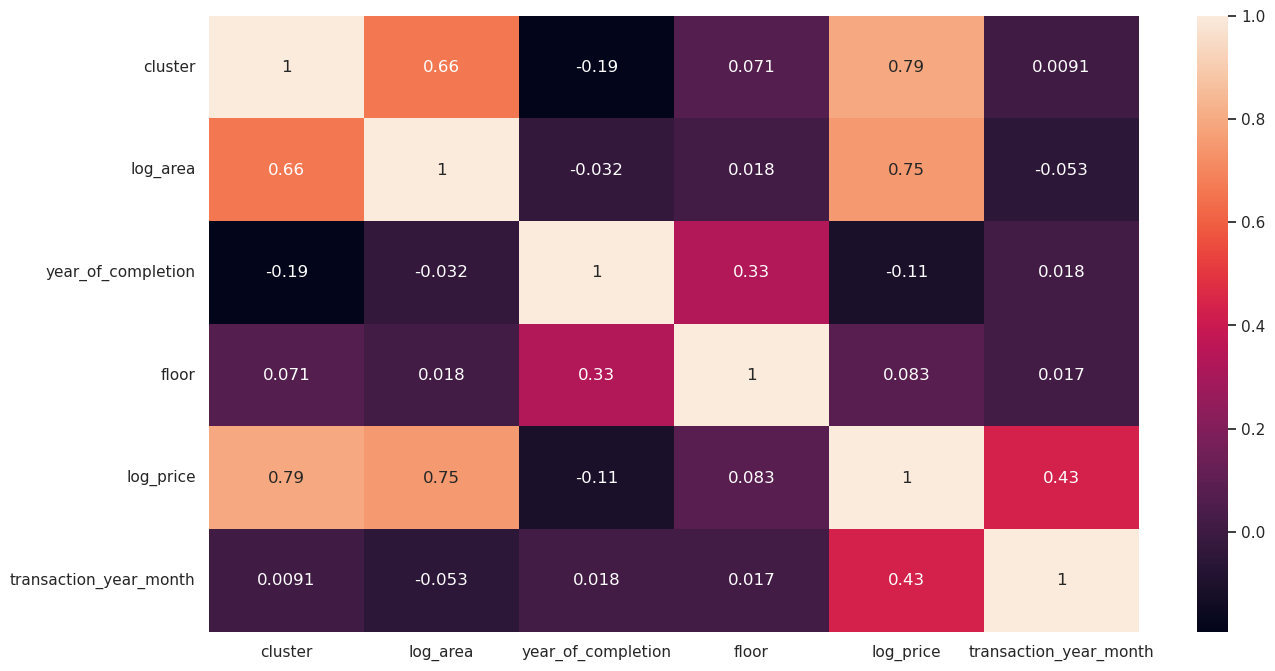

In [152]:
plt.figure(figsize=(15, 8))
sns.heatmap(train_df.corr(),annot=True)